In [2]:
# general
import pandas as pd
import numpy as np
import csv
import re 
import string
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLP related
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.tokenize import MWETokenizer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary

# spacy for lemmatization
import spacy
import textacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monkeyjiashuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# display only 15 rows of results in each cell
pd.options.display.max_rows = 15
pd.set_option('display.max_columns', 50)

In [5]:
df = pd.read_pickle('music_df.pickle')

In [6]:
df.columns

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender',
       'tags'],
      dtype='object')

### <font color='orange'>Feature Explanation</font>

##### <font color='black'>lyrics related</font>
<font color='red'>'title'</font> - title of the song <br>
<font color='red'>'artist'</font> - singer of the song <br>
<font color='red'>'lyrics'</font> - full lyrics of each song <br>
<font color='red'>'neg'</font> - Negativity assoc. w/ lyrics. (between 0-1 inclusive, 1 being 100% negative) <br>
<font color='red'>'neu'</font> - Neutrality assoc. w/ lyrics. (between 0-1 inclusive, 1 being 100% neutral) <br>
<font color='red'>'pos'</font> - Positivity assoc. w/ lyrics. (between 0-1 inclusive, 1 being 100% positive) <br>
<font color='red'>'compound'</font> - compound assoc. w/ lyrics. The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive) <br>
<font color='red'>'year'</font> - Release year of the song <br>
<font color='red'>'num_words'</font> - Number of words in lyrics <br>
<font color='red'>'num_lines'</font> - Number of lines in lyrics <br>
<font color='red'>'num_syllables'</font> - Number of syllables in lyrics <br>
<font color='red'>'difficult_words'</font> - Number of words not on the Dale–Chall "easy" word list <br>
<font color='red'>'fog_index'</font> - Gunning-Fog readability index <br>
<font color='red'>'flesch_index'</font> - Flesch reading ease score <br>
<font color='red'>'f_k_grade'</font> - Flesch–Kincaid grade level of lyrics <br>
<font color='red'>'num_dupes'</font> - Number of duplicate (repetitive) lines in lyrics <br>

##### <font color='black'>song related - from Spotify API</font> 
<font color='red'>'id'</font> - The Spotify ID for the track <br>
<font color='red'>'danceability'</font> - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable <br>
<font color='red'>'energy'</font> - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy <br>
<font color='red'>'key'</font> - The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1 <br>
<font color='red'>'loudness'</font> - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db <br>
<font color='red'>'mode'</font> - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0 <br>
<font color='red'>'speechiness'</font> - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks <br>
<font color='red'>'acousticness'</font> - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic <br>
<font color='red'>'instrumentalness'</font> - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0 <br>
<font color='red'>'liveness'</font> - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live <br>
<font color='red'>'valence'</font> - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry) <br>
<font color='red'>'tempo'</font> - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration <br>
<font color='red'>'duration_ms'</font> - The duration of the track in milliseconds <br>
<font color='red'>'time_signature'</font> - An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure) <br>
<font color='red'>'uri'</font> - The Spotify URI for the track <br>
<font color='red'>'analysis_url'</font> - An HTTP URL to access the full audio analysis of this track. An access token is required to access this data <br>
<font color='red'>'artist_with_features'</font> - <br>
<font color='red'>'year_bin'</font> - <br>
<font color='red'>'image'</font> - <br>
<font color='red'>'cluster'</font> - <br>
<font color='red'>'Gender'</font> - <br>
<font color='red'>'tags'</font> - <br>

In [7]:
df.head()

lyrics  num_syllables    pos  \
0  Mona Lisa, Mona Lisa, men have named you\nYou'...          189.0  0.199   
1  I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...          270.9  0.224   
2  I was dancing with my darling to the Tennessee...          174.6  0.351   
3  Each time I hold someone new\nMy arms grow col...          135.9  0.231   
4  Unfortunately, we are not licensed to display ...           46.8  0.079   

   year  fog_index  flesch_index  num_words  num_lines               title  \
0  1950        5.2         88.74        145         17           Mona Lisa   
1  1950        4.4         82.31        189         31    I Wanna Be Loved   
2  1950        5.2         88.74        138         16     Tennessee Waltz   
3  1950        4.4         99.23        117         18  I'll Never Be Free   
4  1950        6.0         69.79         32          3         All My Love   

   f_k_grade                artist  difficult_words  num_dupes    neg    neu  \
0        2.9         Nat King Cole               13         10  0.155  0.646   
1        3.3       Andrews Sisters               40         32  0.036  0.740   
2        2.9            Patti Page                5         10  0.053  0.596   
3        0.9  Tennessee Ernie Ford               10          3  0.167  0.602   
4        6.0            Patti Page                9          0  0.070  0.850   

   compound                      id  danceability  energy  key  loudness  \
0    0.8443  3k5ycyXX5qsCjLd7R2vphp         0.214   0.194    1   -15.636   
1    0.9897  4UY81WrDU3jTROGaKuz4uZ         0.358   0.085    8   -13.664   
2    0.9948  6DKt9vMnMN0HmlnK3EAHRQ         0.424   0.163    3   -15.899   
3    0.8842  0KnD456yC5JuweN932Ems3         0.697   0.182    7   -12.586   
4    0.0772  05sXHTLqIpwywbpui1JT4o         0.631   0.273    8   -11.538   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1       0.0325         0.903          0.000001     0.107    0.339   
1     1       0.0389         0.939          0.000000     0.160    0.181   
2     1       0.0276         0.784          0.000671     0.116    0.294   
3     1       0.0357         0.780          0.000000     0.126    0.474   
4     1       0.0408         0.801          0.000000     0.158    0.633   

     tempo  duration_ms  time_signature                                   uri  \
0   86.198     207573.0               3  spotify:track:3k5ycyXX5qsCjLd7R2vphp   
1  170.869     198027.0               5  spotify:track:4UY81WrDU3jTROGaKuz4uZ   
2   86.335     182733.0               3  spotify:track:6DKt9vMnMN0HmlnK3EAHRQ   
3   82.184     158000.0               3  spotify:track:0KnD456yC5JuweN932Ems3   
4  123.314     190933.0               4  spotify:track:05sXHTLqIpwywbpui1JT4o   

                                        analysis_url artist_with_features  \
0  https://api.spotify.com/v1/audio-analysis/3k5y...                  NaN   
1  https://api.spotify.com/v1/audio-analysis/4UY8...       Gordon Jenkins   
2  https://api.spotify.com/v1/audio-analysis/6DKt...                  NaN   
3  https://api.spotify.com/v1/audio-analysis/0KnD...            Kay Starr   
4  https://api.spotify.com/v1/audio-analysis/05sX...                  NaN   

  year_bin                                              image       cluster  \
0      50s  https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...  String Lover   
1      50s  https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...  String Lover   
2      50s  https://i.scdn.co/image/353b05113b1a140d64d83d...  String Lover   
3      50s  https://i.scdn.co/image/4bd427bb9181914d0fa448...  String Lover   
4      50s  https://i.scdn.co/image/353b05113b1a140d64d83d...  String Lover   

   Gender                                               tags  
0    male  [american, death by lung cancer, easy listenin...  
1   Group                                  [andrews sisters]  
2  female                                     [country, pop]  
3    male                [death by liver f

In [8]:
# print lyric for a song
for line in df.loc[df['id']=='3k5ycyXX5qsCjLd7R2vphp']['lyrics']:
    print(line)

Mona Lisa, Mona Lisa, men have named you
You're so like the lady with the mystic smile
Is it only 'cause you're lonely they have blamed you?
For that Mona Lisa strangeness in your smile?

Do you smile to tempt a lover, Mona Lisa?
Or is this your way to hide a broken heart?
Many dreams have been brought to your doorstep
They just lie there and they die there

Are you warm, are you real, Mona Lisa?
Or just a cold and lonely lovely work of art?

Do you smile to tempt a lover, Mona Lisa?
Or is this your way to hide a broken heart?
Many dreams have been brought to your doorstep
They just lie there and they die there

Are you warm, are you real, Mona Lisa?
Or just a cold and lonely lovely work of art?

Mona Lisa, Mona Lisa


### <font color='orange'>Data Exploration</font>

In [9]:
len(df['lyrics'])

4028

### <font color='orange'>Text Preprocessing</font>

In [10]:
# convert to a list of strings of lyrics
df['lyric'] = df.lyrics.values.tolist()

In [11]:
df['lyric'][0]

"Mona Lisa, Mona Lisa, men have named you\nYou're so like the lady with the mystic smile\nIs it only 'cause you're lonely they have blamed you?\nFor that Mona Lisa strangeness in your smile?\n\nDo you smile to tempt a lover, Mona Lisa?\nOr is this your way to hide a broken heart?\nMany dreams have been brought to your doorstep\nThey just lie there and they die there\n\nAre you warm, are you real, Mona Lisa?\nOr just a cold and lonely lovely work of art?\n\nDo you smile to tempt a lover, Mona Lisa?\nOr is this your way to hide a broken heart?\nMany dreams have been brought to your doorstep\nThey just lie there and they die there\n\nAre you warm, are you real, Mona Lisa?\nOr just a cold and lonely lovely work of art?\n\nMona Lisa, Mona Lisa"

In [12]:
# Remove new line characters
df['lyrics_data'] = [re.sub('\s+', ' ', line) for line in df['lyrics']]

In [13]:
# Text preprocessing steps - remove numbers, captial letters, and punctuation
alphanumeric = lambda line: re.sub('\w*\d\w*', ' ', line)
punc_lower = lambda line: re.sub('[%s]' % re.escape(string.punctuation), ' ', line.lower())
df['lyrics_data'] = df.lyrics_data.map(alphanumeric).map(punc_lower)

In [14]:
df['lyrics_data'][0]

'mona lisa  mona lisa  men have named you you re so like the lady with the mystic smile is it only  cause you re lonely they have blamed you  for that mona lisa strangeness in your smile  do you smile to tempt a lover  mona lisa  or is this your way to hide a broken heart  many dreams have been brought to your doorstep they just lie there and they die there are you warm  are you real  mona lisa  or just a cold and lonely lovely work of art  do you smile to tempt a lover  mona lisa  or is this your way to hide a broken heart  many dreams have been brought to your doorstep they just lie there and they die there are you warm  are you real  mona lisa  or just a cold and lonely lovely work of art  mona lisa  mona lisa'

In [15]:
# tokenize - convert the lyrics to a list of words for further text processing
# deacc=True removes punctuations
def lyric_to_words(lyrics):
    for lyric in lyrics:
        yield(gensim.utils.simple_preprocess(str(lyric), deacc=True))  

lyric_words = list(lyric_to_words(df['lyrics_data']))

In [76]:
# Build the bigram and trigram models
# higher threshold fewer phrases
bigram = gensim.models.Phrases(lyric_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[lyric_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[lyric_words[0]]])

2019-08-21 17:40:39,254 : INFO : collecting all words and their counts
2019-08-21 17:40:39,256 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-08-21 17:40:41,754 : INFO : collected 247691 word types from a corpus of 1237627 words (unigram + bigrams) and 4028 sentences
2019-08-21 17:40:41,755 : INFO : using 247691 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
/Users/monkeyjiashuo/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2019-08-21 17:40:41,758 : INFO : collecting all words and their counts
2019-08-21 17:40:41,761 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-08-21 17:40:50,385 : INFO : collected 249893 word types from a corpus of 1221777 words (unigram + bigrams) and 4028 sentences
2019-0

['mona_lisa', 'mona_lisa', 'men', 'have', 'named', 'you', 'you', 're', 'so', 'like', 'the', 'lady', 'with', 'the', 'mystic', 'smile', 'is', 'it', 'only', 'cause', 'you', 're', 'lonely', 'they', 'have', 'blamed', 'you', 'for', 'that', 'mona_lisa', 'strangeness', 'in', 'your', 'smile', 'do', 'you', 'smile', 'to', 'tempt', 'lover', 'mona_lisa', 'or', 'is', 'this', 'your', 'way', 'to', 'hide', 'broken', 'heart', 'many', 'dreams', 'have', 'been', 'brought', 'to', 'your', 'doorstep', 'they', 'just', 'lie', 'there', 'and', 'they', 'die', 'there', 'are', 'you', 'warm', 'are', 'you', 'real', 'mona_lisa', 'or', 'just', 'cold', 'and', 'lonely', 'lovely', 'work', 'of', 'art', 'do', 'you', 'smile', 'to', 'tempt', 'lover', 'mona_lisa', 'or', 'is', 'this', 'your', 'way', 'to', 'hide', 'broken', 'heart', 'many', 'dreams', 'have', 'been', 'brought', 'to', 'your', 'doorstep', 'they', 'just', 'lie', 'there', 'and', 'they', 'die', 'there', 'are', 'you', 'warm', 'are', 'you', 'real', 'mona_lisa', 'or', 'ju

In [143]:
# # lemmanize data
# stemmer = LancasterStemmer()
# #df['lyrics_data'] = [stemmer.stem(lyric) for lyric in df['lyrics_data']]

In [ ]:
# df['lyrics_data'].apply(lambda lyric: stemmer.stem(lyric))

In [25]:
stop_words = stopwords.words('english')
stop_words.extend(['ain','just','don','yeah','uh','ve','ya','II','la','till','until','em','oh',
                  'whoa','ah','gon','doo','na','ooh','didn','let','cause','oh oh','ve got',
                  'gonna','know know','don wanna','da','just wanna','ma','da da','just like',
                  'hey','goin','yeah yeah','ain got','la la','ha','huh','uh huh','ha ha','uh un',
                  'ooh','ooh ooh','gotta','doesn','cause just','til','oooo','ooooh','oooh','ooo',
                  'still','wanna','aaaah',])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words
lyric_words_nostops = remove_stopwords(lyric_words)

# Form Bigrams
lyric_words_bigrams = make_bigrams(lyric_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
lyric_lemmatized = lemmatization(lyric_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

In [22]:
# print a sample to see the results 
# pprint(lyric_lemmatized)

### <font color='orange'>Model Building</font>

##### <font color='black'>LDA Topic Modeling with Gensim</font>

In [28]:
# create dictionary from the data, then convert to bag of words corpus
id2word = corpora.Dictionary(lyric_lemmatized)
print(id2word)
print(type(id2word))

# create term document requency
corpus = [id2word.doc2bow(lyric) for lyric in lyric_lemmatized]
print(type(corpus))

2019-08-21 16:05:14,539 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-08-21 16:05:14,874 : INFO : built Dictionary(14172 unique tokens: ['art', 'cold', 'doorstep', 'dream', 'heart']...) from 4028 documents (total 324332 corpus positions)


Dictionary(14172 unique tokens: ['art', 'cold', 'doorstep', 'dream', 'heart']...)
<class 'gensim.corpora.dictionary.Dictionary'>
<class 'list'>


In [29]:
# lyric_lemmatized is a list of lists, each of which contains cleaned words of each song
print(lyric_lemmatized[0:2])

[['mona_lisa', 'mona_lisa', 'man', 'lady', 'mystic', 'smile', 'lonely', 'mona_lisa', 'strangeness', 'smile', 'smile', 'tempt', 'lover', 'mona_lisa', 'way', 'heart', 'many', 'dream', 'doorstep', 'lie', 'warm', 'real', 'mona_lisa', 'cold', 'lonely', 'lovely', 'work', 'art', 'smile', 'tempt', 'lover', 'mona_lisa', 'way', 'heart', 'many', 'dream', 'doorstep', 'lie', 'warm', 'real', 'mona_lisa', 'cold', 'lonely', 'lovely', 'work', 'art', 'mona_lisa', 'mona_lisa'], ['andrews', 'sister', 'inspiration', 'tonight', 'conversation', 'hold', 'tingle', 'tonight', 'embrace', 'heartbeat', 'wrong', 'right', 'age', 'stage', 'careful', 'careful', 'mood', 'insist', 'world', 'thrilled', 'desperation', 'tonight', 'love', 'love', 'wonderful', 'sensation', 'age', 'stage', 'mood', 'insist', 'world', 'thrilled', 'desperation', 'tonight', 'tonight', 'wonderful', 'sensation']]


In [140]:
print(corpus[:2])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 2), (7, 3), (8, 2), (9, 2), (10, 1), (11, 2), (12, 9), (13, 1), (14, 2), (15, 4), (16, 1), (17, 2), (18, 2), (19, 2), (20, 2)], [(21, 2), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 2), (33, 1), (34, 2), (35, 1), (36, 2), (37, 2), (38, 1), (39, 5), (40, 2), (41, 2), (42, 1)]]


In [31]:
print(id2word)

Dictionary(14172 unique tokens: ['art', 'cold', 'doorstep', 'dream', 'heart']...)


In [ ]:
# print(id2word.token2id)

In [35]:
# build LDA model
lda_model_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

2019-08-21 16:25:41,783 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2019-08-21 16:25:41,785 : INFO : using symmetric eta at 0.1
2019-08-21 16:25:41,791 : INFO : using serial LDA version on this node
2019-08-21 16:25:41,814 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 4028 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-21 16:25:41,816 : INFO : PROGRESS: pass 0, at document #100/4028
2019-08-21 16:25:41,919 : INFO : optimized alpha [0.08687377, 0.076367885, 0.06993142, 0.08019801, 0.075639226, 0.07757345, 0.09343058, 0.08206311, 0.098222084, 0.08136833]
2019-08-21 16:25:41,923 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:41,949 : INFO : topic #2 (0.070): 0.050*"love" + 0.036*"jealous" + 0.030*"shine" + 0.029*"lover" + 0.026*"

2019-08-21 16:25:42,624 : INFO : topic #5 (0.094): 0.054*"love" + 0.041*"work" + 0.037*"much" + 0.022*"anyone" + 0.022*"fine" + 0.021*"guy" + 0.020*"big" + 0.017*"chance" + 0.015*"sign" + 0.014*"aaah"
2019-08-21 16:25:42,627 : INFO : topic #7 (0.151): 0.192*"baby" + 0.085*"girl" + 0.052*"good" + 0.020*"bit" + 0.015*"sweet" + 0.014*"kind" + 0.014*"little" + 0.012*"wish" + 0.011*"bout" + 0.009*"sound"
2019-08-21 16:25:42,629 : INFO : topic #8 (0.156): 0.041*"love" + 0.040*"heart" + 0.024*"day" + 0.022*"night" + 0.020*"many" + 0.019*"last" + 0.018*"eye" + 0.016*"deep" + 0.016*"man" + 0.015*"people"
2019-08-21 16:25:42,630 : INFO : topic #0 (0.171): 0.203*"love" + 0.023*"heart" + 0.021*"thing" + 0.018*"true" + 0.018*"dream" + 0.018*"someone" + 0.016*"life" + 0.015*"night" + 0.014*"somebody" + 0.014*"nothing"
2019-08-21 16:25:42,633 : INFO : topic diff=0.303567, rho=0.408248
2019-08-21 16:25:42,635 : INFO : PROGRESS: pass 0, at document #700/4028
2019-08-21 16:25:42,722 : INFO : optimized a

2019-08-21 16:25:43,303 : INFO : PROGRESS: pass 0, at document #1200/4028
2019-08-21 16:25:43,369 : INFO : optimized alpha [0.32665676, 0.21177584, 0.10259222, 0.18067107, 0.17901237, 0.13333023, 0.2634746, 0.26310587, 0.25482306, 0.18931594]
2019-08-21 16:25:43,371 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:43,396 : INFO : topic #2 (0.103): 0.054*"boogie" + 0.021*"funk" + 0.015*"summer" + 0.015*"band" + 0.014*"tonight" + 0.013*"door" + 0.013*"island" + 0.013*"dirty" + 0.012*"drive" + 0.011*"hour"
2019-08-21 16:25:43,397 : INFO : topic #5 (0.133): 0.048*"wonder" + 0.022*"big" + 0.022*"much" + 0.020*"fine" + 0.020*"run" + 0.020*"work" + 0.017*"love" + 0.013*"chance" + 0.012*"takin" + 0.011*"sign"
2019-08-21 16:25:43,400 : INFO : topic #7 (0.263): 0.197*"baby" + 0.071*"girl" + 0.049*"good" + 0.036*"shake" + 0.022*"sweet" + 0.017*"lord" + 0.016*"boy" + 0.011*"enough" + 0.011*"tonight" + 0.011*"little"
2019-08-21 16:25:43,401 : INFO : topic 

2019-08-21 16:25:43,959 : INFO : topic #0 (0.585): 0.241*"love" + 0.034*"life" + 0.034*"heart" + 0.018*"nothing" + 0.017*"thing" + 0.017*"dream" + 0.016*"hold" + 0.015*"true" + 0.014*"time" + 0.013*"someone"
2019-08-21 16:25:43,960 : INFO : topic diff=0.317475, rho=0.242536
2019-08-21 16:25:43,970 : INFO : PROGRESS: pass 0, at document #1800/4028
2019-08-21 16:25:44,040 : INFO : optimized alpha [0.6265957, 0.30603358, 0.13768063, 0.2714577, 0.23236088, 0.1723429, 0.40252745, 0.35808447, 0.4068284, 0.27180925]
2019-08-21 16:25:44,042 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:44,066 : INFO : topic #2 (0.138): 0.021*"wall" + 0.017*"magic" + 0.016*"door" + 0.014*"church" + 0.013*"uptown" + 0.012*"summer" + 0.012*"hall" + 0.012*"power" + 0.012*"tonight" + 0.011*"boogie"
2019-08-21 16:25:44,068 : INFO : topic #5 (0.172): 0.031*"chance" + 0.030*"much" + 0.029*"control" + 0.022*"run" + 0.022*"mickey" + 0.021*"wonder" + 0.021*"big" + 0.021*"fine

2019-08-21 16:25:44,711 : INFO : topic #6 (0.549): 0.073*"night" + 0.035*"man" + 0.033*"rock" + 0.028*"hand" + 0.026*"free" + 0.020*"talk" + 0.019*"friend" + 0.018*"fire" + 0.018*"home" + 0.016*"good"
2019-08-21 16:25:44,712 : INFO : topic #8 (0.564): 0.038*"eye" + 0.029*"heart" + 0.020*"mind" + 0.017*"people" + 0.017*"close" + 0.014*"deep" + 0.013*"night" + 0.013*"alive" + 0.013*"call" + 0.012*"head"
2019-08-21 16:25:44,714 : INFO : topic #0 (0.920): 0.231*"love" + 0.045*"heart" + 0.028*"life" + 0.022*"thing" + 0.020*"nothing" + 0.018*"true" + 0.016*"real" + 0.016*"time" + 0.016*"something" + 0.015*"touch"
2019-08-21 16:25:44,716 : INFO : topic diff=0.392107, rho=0.208514
2019-08-21 16:25:44,718 : INFO : PROGRESS: pass 0, at document #2400/4028
2019-08-21 16:25:44,779 : INFO : optimized alpha [0.9699587, 0.44969678, 0.1683485, 0.40331167, 0.3008309, 0.2201639, 0.5922713, 0.5129328, 0.60494816, 0.38380858]
2019-08-21 16:25:44,781 : INFO : merging changes from 100 documents into a model

2019-08-21 16:25:45,267 : INFO : topic #2 (0.215): 0.015*"party" + 0.015*"wit" + 0.013*"nigga" + 0.011*"niggaz" + 0.010*"cash" + 0.009*"open" + 0.009*"ray" + 0.009*"bag" + 0.008*"mack" + 0.007*"niggas"
2019-08-21 16:25:45,269 : INFO : topic #5 (0.288): 0.035*"big" + 0.032*"shit" + 0.023*"work" + 0.023*"wonder" + 0.020*"run" + 0.019*"body" + 0.015*"angel" + 0.015*"chance" + 0.015*"control" + 0.014*"watch"
2019-08-21 16:25:45,271 : INFO : topic #6 (0.774): 0.056*"night" + 0.041*"man" + 0.025*"hand" + 0.021*"rock" + 0.020*"yo" + 0.019*"anything" + 0.019*"free" + 0.019*"woman" + 0.018*"friend" + 0.017*"good"
2019-08-21 16:25:45,273 : INFO : topic #8 (0.784): 0.035*"eye" + 0.018*"close" + 0.016*"call" + 0.016*"wake" + 0.016*"mind" + 0.015*"heart" + 0.015*"lady" + 0.013*"break" + 0.013*"head" + 0.012*"deep"
2019-08-21 16:25:45,275 : INFO : topic #0 (1.201): 0.193*"love" + 0.040*"heart" + 0.038*"life" + 0.025*"thing" + 0.019*"nothing" + 0.019*"real" + 0.018*"true" + 0.016*"something" + 0.016*

2019-08-21 16:25:45,876 : INFO : topic diff=0.464299, rho=0.171499
2019-08-21 16:25:45,877 : INFO : PROGRESS: pass 0, at document #3500/4028
2019-08-21 16:25:45,934 : INFO : optimized alpha [1.2856982, 0.77425313, 0.35856926, 0.72137046, 0.51984316, 0.4116788, 0.9882015, 0.94970936, 0.99642116, 0.6195143]
2019-08-21 16:25:45,936 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:45,957 : INFO : topic #2 (0.359): 0.029*"wit" + 0.028*"club" + 0.017*"nigga" + 0.012*"pop" + 0.010*"party" + 0.009*"drive" + 0.008*"top" + 0.008*"dem" + 0.008*"hump" + 0.008*"niggas"
2019-08-21 16:25:45,959 : INFO : topic #5 (0.412): 0.042*"shit" + 0.034*"work" + 0.032*"big" + 0.024*"watch" + 0.020*"wonder" + 0.016*"fine" + 0.015*"run" + 0.014*"body" + 0.014*"control" + 0.014*"chance"
2019-08-21 16:25:45,961 : INFO : topic #6 (0.988): 0.045*"man" + 0.039*"night" + 0.027*"yo" + 0.026*"money" + 0.025*"rock" + 0.024*"hand" + 0.018*"woman" + 0.016*"good" + 0.016*"talk" + 0.0

2019-08-21 16:25:46,477 : INFO : topic #6 (1.181): 0.063*"night" + 0.036*"money" + 0.034*"man" + 0.032*"hand" + 0.029*"rock" + 0.018*"yo" + 0.018*"good" + 0.018*"hard" + 0.017*"fire" + 0.014*"beautiful"
2019-08-21 16:25:46,479 : INFO : topic #0 (1.407): 0.185*"love" + 0.044*"life" + 0.037*"heart" + 0.025*"thing" + 0.021*"nothing" + 0.017*"real" + 0.016*"something" + 0.014*"time" + 0.014*"want" + 0.013*"nobody"
2019-08-21 16:25:46,481 : INFO : topic diff=0.417270, rho=0.158114
2019-08-21 16:25:46,516 : INFO : -7.774 per-word bound, 218.9 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 16:25:46,517 : INFO : PROGRESS: pass 0, at document #4028/4028
2019-08-21 16:25:46,533 : INFO : optimized alpha [1.471295, 0.8864605, 0.50720155, 0.81654656, 0.6398237, 0.49310046, 1.2488924, 1.111972, 1.2371035, 0.7640725]
2019-08-21 16:25:46,534 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 16:25:46,559 : INFO : topic #5 (0.

2019-08-21 16:25:46,941 : INFO : topic #5 (0.378): 0.045*"work" + 0.044*"big" + 0.027*"shit" + 0.026*"run" + 0.018*"watch" + 0.014*"guy" + 0.014*"wonder" + 0.013*"anyone" + 0.013*"chance" + 0.011*"fine"
2019-08-21 16:25:46,943 : INFO : topic #6 (0.866): 0.068*"night" + 0.039*"man" + 0.030*"hand" + 0.028*"money" + 0.023*"rock" + 0.017*"good" + 0.017*"home" + 0.016*"long" + 0.015*"fire" + 0.014*"hard"
2019-08-21 16:25:46,944 : INFO : topic #8 (0.976): 0.026*"eye" + 0.018*"call" + 0.017*"deep" + 0.017*"head" + 0.016*"heart" + 0.016*"blue" + 0.015*"break" + 0.013*"people" + 0.011*"close" + 0.011*"mind"
2019-08-21 16:25:46,946 : INFO : topic #0 (1.300): 0.204*"love" + 0.050*"heart" + 0.033*"life" + 0.024*"thing" + 0.018*"true" + 0.017*"nothing" + 0.016*"nobody" + 0.016*"dream" + 0.013*"someone" + 0.013*"time"
2019-08-21 16:25:46,948 : INFO : topic diff=0.232876, rho=0.153792
2019-08-21 16:25:46,950 : INFO : PROGRESS: pass 1, at document #600/4028
2019-08-21 16:25:47,002 : INFO : optimized a

2019-08-21 16:25:47,720 : INFO : optimized alpha [1.2386603, 0.69985914, 0.3028382, 0.6471775, 0.43033716, 0.33886272, 0.8742344, 0.7561823, 0.96908927, 0.5847457]
2019-08-21 16:25:47,722 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:47,748 : INFO : topic #2 (0.303): 0.023*"boogie" + 0.013*"band" + 0.011*"party" + 0.010*"club" + 0.010*"dirty" + 0.010*"summer" + 0.009*"green" + 0.008*"hour" + 0.008*"diamond" + 0.008*"nigga"
2019-08-21 16:25:47,749 : INFO : topic #5 (0.339): 0.037*"big" + 0.031*"work" + 0.028*"run" + 0.017*"wonder" + 0.015*"takin" + 0.014*"watch" + 0.012*"guy" + 0.012*"nice" + 0.012*"chance" + 0.012*"shit"
2019-08-21 16:25:47,751 : INFO : topic #6 (0.874): 0.052*"man" + 0.050*"night" + 0.036*"rock" + 0.033*"hand" + 0.032*"woman" + 0.025*"money" + 0.019*"good" + 0.018*"long" + 0.018*"fire" + 0.017*"home"
2019-08-21 16:25:47,752 : INFO : topic #8 (0.969): 0.032*"eye" + 0.028*"people" + 0.020*"head" + 0.019*"call" + 0.015*"lady"

2019-08-21 16:25:48,159 : INFO : topic #0 (1.417): 0.251*"love" + 0.037*"life" + 0.035*"heart" + 0.024*"thing" + 0.016*"hold" + 0.016*"sweet" + 0.015*"time" + 0.015*"dream" + 0.014*"someone" + 0.013*"nothing"
2019-08-21 16:25:48,160 : INFO : topic diff=0.204647, rho=0.153792
2019-08-21 16:25:48,162 : INFO : PROGRESS: pass 1, at document #1700/4028
2019-08-21 16:25:48,201 : INFO : optimized alpha [1.4265049, 0.6706901, 0.27495828, 0.6578707, 0.4043398, 0.32072732, 0.87073475, 0.7185078, 0.9694175, 0.56122714]
2019-08-21 16:25:48,203 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:48,229 : INFO : topic #2 (0.275): 0.019*"wall" + 0.019*"boogie" + 0.012*"funk" + 0.012*"party" + 0.012*"band" + 0.011*"stone" + 0.010*"summer" + 0.010*"casbah" + 0.010*"dirty" + 0.009*"america"
2019-08-21 16:25:48,233 : INFO : topic #5 (0.321): 0.030*"big" + 0.029*"run" + 0.026*"mickey" + 0.026*"wonder" + 0.025*"chance" + 0.021*"work" + 0.015*"watch" + 0.014*"fine" + 

2019-08-21 16:25:48,781 : INFO : topic #6 (0.906): 0.099*"night" + 0.044*"man" + 0.035*"hand" + 0.029*"rock" + 0.027*"free" + 0.021*"home" + 0.021*"woman" + 0.020*"long" + 0.019*"fire" + 0.019*"talk"
2019-08-21 16:25:48,783 : INFO : topic #8 (0.999): 0.048*"eye" + 0.020*"people" + 0.019*"mind" + 0.017*"close" + 0.016*"head" + 0.015*"call" + 0.014*"word" + 0.013*"deep" + 0.012*"blue" + 0.011*"face"
2019-08-21 16:25:48,785 : INFO : topic #0 (1.575): 0.226*"love" + 0.050*"heart" + 0.034*"life" + 0.022*"thing" + 0.020*"true" + 0.018*"nothing" + 0.016*"hold" + 0.016*"dream" + 0.015*"time" + 0.014*"lover"
2019-08-21 16:25:48,786 : INFO : topic diff=0.330791, rho=0.153792
2019-08-21 16:25:48,788 : INFO : PROGRESS: pass 1, at document #2300/4028
2019-08-21 16:25:48,828 : INFO : optimized alpha [1.604251, 0.70923394, 0.27082843, 0.7017063, 0.40294498, 0.3287291, 0.91249424, 0.7733833, 1.0160016, 0.5835167]
2019-08-21 16:25:48,829 : INFO : merging changes from 100 documents into a model of 4028 

2019-08-21 16:25:49,225 : INFO : topic #2 (0.299): 0.017*"party" + 0.016*"nigga" + 0.013*"wit" + 0.012*"niggaz" + 0.010*"ray" + 0.008*"mack" + 0.007*"cruel_summer" + 0.006*"wet" + 0.006*"cash" + 0.006*"funk"
2019-08-21 16:25:49,227 : INFO : topic #5 (0.368): 0.033*"big" + 0.031*"shit" + 0.025*"run" + 0.023*"wonder" + 0.022*"work" + 0.019*"control" + 0.016*"sign" + 0.015*"watch" + 0.013*"chance" + 0.012*"body"
2019-08-21 16:25:49,229 : INFO : topic #6 (0.997): 0.080*"night" + 0.049*"man" + 0.028*"hand" + 0.026*"rock" + 0.023*"anything" + 0.022*"free" + 0.020*"woman" + 0.017*"long" + 0.016*"friend" + 0.016*"yo"
2019-08-21 16:25:49,231 : INFO : topic #8 (1.103): 0.040*"eye" + 0.018*"call" + 0.017*"close" + 0.017*"wake" + 0.017*"mind" + 0.015*"word" + 0.014*"head" + 0.014*"break" + 0.013*"people" + 0.013*"deep"
2019-08-21 16:25:49,232 : INFO : topic #0 (1.653): 0.203*"love" + 0.049*"heart" + 0.037*"life" + 0.026*"thing" + 0.019*"nothing" + 0.018*"true" + 0.017*"someone" + 0.015*"wrong" + 0

2019-08-21 16:25:49,728 : INFO : topic diff=0.417632, rho=0.153792
2019-08-21 16:25:49,730 : INFO : PROGRESS: pass 1, at document #3400/4028
2019-08-21 16:25:49,767 : INFO : optimized alpha [1.5640882, 0.8681724, 0.44460976, 0.8325453, 0.525947, 0.45172688, 1.1056064, 1.073608, 1.1926987, 0.6822548]
2019-08-21 16:25:49,769 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:49,791 : INFO : topic #2 (0.445): 0.028*"wit" + 0.021*"club" + 0.018*"nigga" + 0.012*"pop" + 0.010*"party" + 0.009*"drive" + 0.008*"dem" + 0.008*"hump" + 0.007*"niggaz" + 0.007*"niggas"
2019-08-21 16:25:49,793 : INFO : topic #5 (0.452): 0.045*"shit" + 0.041*"work" + 0.033*"big" + 0.026*"watch" + 0.022*"wonder" + 0.018*"run" + 0.017*"control" + 0.016*"chance" + 0.016*"thoia_thoia" + 0.011*"tha"
2019-08-21 16:25:49,795 : INFO : topic #6 (1.106): 0.053*"man" + 0.051*"night" + 0.028*"yo" + 0.028*"hand" + 0.025*"rock" + 0.023*"money" + 0.021*"woman" + 0.017*"long" + 0.016*"talk" + 

2019-08-21 16:25:50,221 : INFO : topic #0 (1.563): 0.184*"love" + 0.047*"life" + 0.041*"heart" + 0.028*"thing" + 0.021*"nothing" + 0.015*"real" + 0.014*"time" + 0.013*"touch" + 0.013*"wrong" + 0.013*"want"
2019-08-21 16:25:50,222 : INFO : topic diff=0.326926, rho=0.153792
2019-08-21 16:25:50,319 : INFO : -7.945 per-word bound, 246.4 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:25:50,320 : INFO : PROGRESS: pass 1, at document #4000/4028
2019-08-21 16:25:50,359 : INFO : optimized alpha [1.5745656, 0.9112859, 0.5888602, 0.85861665, 0.60869724, 0.5001777, 1.2417803, 1.1613712, 1.2996035, 0.7665348]
2019-08-21 16:25:50,360 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:50,382 : INFO : topic #5 (0.500): 0.043*"work" + 0.043*"shit" + 0.041*"big" + 0.036*"run" + 0.024*"watch" + 0.016*"control" + 0.016*"wonder" + 0.012*"lucky" + 0.012*"sick" + 0.010*"chance"
2019-08-21 16:25:50,384 : INFO : topic #2 (

2019-08-21 16:25:51,290 : INFO : -7.902 per-word bound, 239.1 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:25:51,291 : INFO : PROGRESS: pass 2, at document #1000/4028
2019-08-21 16:25:51,334 : INFO : optimized alpha [1.3111894, 0.71642524, 0.33330637, 0.68351996, 0.415888, 0.33607462, 0.9181381, 0.7835615, 1.0582471, 0.58128315]
2019-08-21 16:25:51,335 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:51,361 : INFO : topic #2 (0.333): 0.014*"band" + 0.012*"club" + 0.012*"party" + 0.010*"nigga" + 0.010*"dirty" + 0.008*"green" + 0.008*"hour" + 0.008*"diamond" + 0.008*"wit" + 0.007*"stone"
2019-08-21 16:25:51,362 : INFO : topic #5 (0.336): 0.040*"big" + 0.035*"run" + 0.032*"work" + 0.018*"watch" + 0.016*"wonder" + 0.015*"shit" + 0.014*"guy" + 0.014*"control" + 0.012*"anyone" + 0.011*"nice"
2019-08-21 16:25:51,364 : INFO : topic #6 (0.918): 0.060*"man" + 0.057*"night" + 0.033*"rock" + 0.031*"woman" +

2019-08-21 16:25:51,731 : INFO : topic #8 (1.011): 0.040*"eye" + 0.030*"people" + 0.020*"call" + 0.019*"head" + 0.016*"lady" + 0.013*"blue" + 0.013*"passion" + 0.013*"mind" + 0.012*"word" + 0.012*"star"
2019-08-21 16:25:51,732 : INFO : topic #0 (1.468): 0.252*"love" + 0.039*"life" + 0.038*"heart" + 0.025*"thing" + 0.018*"sweet" + 0.015*"much" + 0.015*"dream" + 0.014*"nothing" + 0.013*"time" + 0.013*"true"
2019-08-21 16:25:51,734 : INFO : topic diff=0.178587, rho=0.152004
2019-08-21 16:25:51,736 : INFO : PROGRESS: pass 2, at document #1600/4028
2019-08-21 16:25:51,765 : INFO : optimized alpha [1.489903, 0.69434184, 0.28736463, 0.68308, 0.3862064, 0.31283718, 0.90379524, 0.73924994, 1.0166229, 0.5622364]
2019-08-21 16:25:51,766 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:51,787 : INFO : topic #2 (0.287): 0.021*"wall" + 0.021*"boogie" + 0.015*"funk" + 0.014*"party" + 0.012*"stone" + 0.012*"band" + 0.010*"drive" + 0.010*"shot" + 0.008*"hour" 

2019-08-21 16:25:52,231 : INFO : topic #5 (0.317): 0.043*"big" + 0.041*"control" + 0.030*"run" + 0.027*"wonder" + 0.023*"chance" + 0.021*"fresh" + 0.017*"work" + 0.014*"watch" + 0.014*"mickey" + 0.012*"weak"
2019-08-21 16:25:52,233 : INFO : topic #6 (0.926): 0.110*"night" + 0.049*"man" + 0.033*"hand" + 0.025*"rock" + 0.023*"woman" + 0.022*"long" + 0.021*"free" + 0.020*"home" + 0.019*"money" + 0.018*"fire"
2019-08-21 16:25:52,235 : INFO : topic #8 (1.058): 0.051*"eye" + 0.020*"people" + 0.018*"mind" + 0.017*"call" + 0.017*"head" + 0.016*"word" + 0.015*"blue" + 0.014*"close" + 0.013*"face" + 0.012*"place"
2019-08-21 16:25:52,237 : INFO : topic #0 (1.620): 0.220*"love" + 0.055*"heart" + 0.036*"life" + 0.023*"thing" + 0.020*"true" + 0.018*"nothing" + 0.015*"much" + 0.015*"dream" + 0.015*"sweet" + 0.015*"hold"
2019-08-21 16:25:52,239 : INFO : topic diff=0.161657, rho=0.152004
2019-08-21 16:25:52,241 : INFO : PROGRESS: pass 2, at document #2200/4028
2019-08-21 16:25:52,286 : INFO : optimized

2019-08-21 16:25:52,712 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:52,735 : INFO : topic #2 (0.295): 0.018*"party" + 0.017*"nigga" + 0.011*"wit" + 0.010*"mack" + 0.008*"duuh_duuh" + 0.007*"zoom_zoom" + 0.007*"niggaz" + 0.007*"cash" + 0.007*"funk" + 0.006*"homie"
2019-08-21 16:25:52,737 : INFO : topic #5 (0.347): 0.032*"big" + 0.028*"run" + 0.024*"work" + 0.023*"control" + 0.023*"shit" + 0.023*"wonder" + 0.017*"sign" + 0.013*"chance" + 0.013*"freek" + 0.013*"watch"
2019-08-21 16:25:52,739 : INFO : topic #6 (0.992): 0.087*"night" + 0.054*"man" + 0.030*"hand" + 0.025*"anything" + 0.025*"rock" + 0.024*"free" + 0.023*"long" + 0.022*"woman" + 0.017*"money" + 0.016*"something"
2019-08-21 16:25:52,742 : INFO : topic #8 (1.132): 0.043*"eye" + 0.018*"word" + 0.018*"wake" + 0.018*"call" + 0.016*"strong" + 0.016*"mind" + 0.014*"head" + 0.014*"close" + 0.014*"people" + 0.014*"deep"
2019-08-21 16:25:52,744 : INFO : topic #0 (1.703): 0.207*"love" + 0.0

2019-08-21 16:25:53,235 : INFO : topic #0 (1.628): 0.186*"love" + 0.043*"life" + 0.040*"heart" + 0.030*"thing" + 0.017*"nothing" + 0.017*"real" + 0.016*"true" + 0.014*"time" + 0.013*"want" + 0.013*"wrong"
2019-08-21 16:25:53,237 : INFO : topic diff=0.456881, rho=0.152004
2019-08-21 16:25:53,239 : INFO : PROGRESS: pass 2, at document #3300/4028
2019-08-21 16:25:53,272 : INFO : optimized alpha [1.6026564, 0.8507627, 0.42284825, 0.8120281, 0.4827289, 0.41604128, 1.0725813, 1.0384542, 1.2012808, 0.65859413]
2019-08-21 16:25:53,273 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:53,294 : INFO : topic #5 (0.416): 0.051*"shit" + 0.045*"work" + 0.031*"big" + 0.023*"wonder" + 0.022*"thoia_thoia" + 0.022*"control" + 0.021*"run" + 0.016*"watch" + 0.015*"tha" + 0.014*"chance"
2019-08-21 16:25:53,295 : INFO : topic #2 (0.423): 0.030*"wit" + 0.019*"nigga" + 0.018*"club" + 0.013*"pop" + 0.011*"party" + 0.010*"hump" + 0.008*"dem" + 0.007*"niggaz" + 0.007*"ni

2019-08-21 16:25:53,621 : INFO : topic #8 (1.287): 0.030*"eye" + 0.024*"call" + 0.024*"head" + 0.017*"break" + 0.014*"place" + 0.014*"close" + 0.014*"face" + 0.013*"people" + 0.011*"word" + 0.011*"mind"
2019-08-21 16:25:53,622 : INFO : topic #0 (1.570): 0.181*"love" + 0.048*"life" + 0.042*"heart" + 0.030*"thing" + 0.019*"nothing" + 0.015*"time" + 0.015*"real" + 0.014*"nobody" + 0.013*"touch" + 0.012*"want"
2019-08-21 16:25:53,624 : INFO : topic diff=0.293275, rho=0.152004
2019-08-21 16:25:53,626 : INFO : PROGRESS: pass 2, at document #3900/4028
2019-08-21 16:25:53,660 : INFO : optimized alpha [1.5836675, 0.9000722, 0.57205063, 0.86251557, 0.5709655, 0.46703136, 1.2216256, 1.1492622, 1.3240273, 0.7354208]
2019-08-21 16:25:53,662 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:53,684 : INFO : topic #5 (0.467): 0.047*"work" + 0.047*"shit" + 0.037*"run" + 0.036*"big" + 0.022*"watch" + 0.018*"control" + 0.018*"wonder" + 0.014*"lucky" + 0.013*"sick

2019-08-21 16:25:54,156 : INFO : topic #5 (0.394): 0.046*"big" + 0.040*"work" + 0.035*"shit" + 0.034*"run" + 0.021*"watch" + 0.015*"wonder" + 0.014*"boogety_boogety" + 0.012*"wing" + 0.011*"control" + 0.011*"bomp_bomp"
2019-08-21 16:25:54,158 : INFO : topic #2 (0.447): 0.022*"club" + 0.021*"nigga" + 0.015*"party" + 0.011*"wit" + 0.011*"niggas" + 0.010*"bottom" + 0.009*"diamond" + 0.008*"mma" + 0.008*"top" + 0.008*"pop"
2019-08-21 16:25:54,159 : INFO : topic #6 (1.009): 0.077*"night" + 0.044*"man" + 0.034*"hand" + 0.029*"money" + 0.028*"rock" + 0.022*"long" + 0.020*"home" + 0.016*"fire" + 0.016*"side" + 0.014*"yo"
2019-08-21 16:25:54,160 : INFO : topic #8 (1.191): 0.031*"eye" + 0.021*"call" + 0.021*"head" + 0.019*"deep" + 0.013*"break" + 0.013*"blue" + 0.012*"lip" + 0.012*"word" + 0.011*"cold" + 0.011*"people"
2019-08-21 16:25:54,162 : INFO : topic #0 (1.496): 0.190*"love" + 0.056*"heart" + 0.041*"life" + 0.024*"thing" + 0.018*"nothing" + 0.017*"nobody" + 0.016*"true" + 0.013*"dream" + 

2019-08-21 16:25:54,564 : INFO : PROGRESS: pass 3, at document #900/4028
2019-08-21 16:25:54,595 : INFO : optimized alpha [1.3695322, 0.7177112, 0.33803707, 0.6869476, 0.40738705, 0.3278032, 0.9199406, 0.7960893, 1.1037635, 0.56737965]
2019-08-21 16:25:54,596 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:54,618 : INFO : topic #5 (0.328): 0.044*"big" + 0.038*"work" + 0.029*"run" + 0.019*"shit" + 0.016*"wonder" + 0.015*"watch" + 0.015*"guy" + 0.012*"sign" + 0.011*"anyone" + 0.011*"control"
2019-08-21 16:25:54,620 : INFO : topic #2 (0.338): 0.015*"club" + 0.013*"nigga" + 0.012*"dirty" + 0.011*"party" + 0.009*"green" + 0.007*"band" + 0.007*"wit" + 0.007*"bottom" + 0.007*"niggas" + 0.007*"top"
2019-08-21 16:25:54,621 : INFO : topic #6 (0.920): 0.069*"night" + 0.059*"man" + 0.031*"woman" + 0.030*"hand" + 0.029*"long" + 0.021*"home" + 0.020*"fire" + 0.019*"money" + 0.018*"rock" + 0.016*"free"
2019-08-21 16:25:54,622 : INFO : topic #8 (1.104): 0.03

2019-08-21 16:25:55,030 : INFO : topic #8 (1.037): 0.037*"eye" + 0.030*"people" + 0.022*"call" + 0.018*"head" + 0.015*"blue" + 0.014*"word" + 0.013*"sky" + 0.013*"star" + 0.012*"place" + 0.012*"lady"
2019-08-21 16:25:55,031 : INFO : topic #0 (1.437): 0.260*"love" + 0.038*"heart" + 0.035*"life" + 0.028*"thing" + 0.021*"sweet" + 0.015*"much" + 0.014*"hold" + 0.013*"dream" + 0.013*"nothing" + 0.013*"wrong"
2019-08-21 16:25:55,033 : INFO : topic diff=0.165363, rho=0.150278
2019-08-21 16:25:55,035 : INFO : PROGRESS: pass 3, at document #1500/4028
2019-08-21 16:25:55,064 : INFO : optimized alpha [1.4994645, 0.72184473, 0.294255, 0.6958174, 0.3866165, 0.30515954, 0.94040793, 0.7449018, 1.0447458, 0.56994677]
2019-08-21 16:25:55,065 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:55,088 : INFO : topic #2 (0.294): 0.022*"boogie" + 0.017*"funk" + 0.015*"party" + 0.013*"stone" + 0.011*"band" + 0.011*"shot" + 0.010*"drive" + 0.009*"wall" + 0.009*"dirty" 

2019-08-21 16:25:55,602 : INFO : topic #5 (0.305): 0.045*"big" + 0.039*"control" + 0.035*"run" + 0.026*"wonder" + 0.025*"fresh" + 0.018*"work" + 0.017*"mickey" + 0.015*"watch" + 0.013*"chance" + 0.011*"stranger"
2019-08-21 16:25:55,603 : INFO : topic #6 (0.947): 0.112*"night" + 0.051*"man" + 0.034*"hand" + 0.028*"rock" + 0.025*"long" + 0.024*"woman" + 0.021*"free" + 0.021*"home" + 0.018*"fire" + 0.017*"talk"
2019-08-21 16:25:55,605 : INFO : topic #8 (1.070): 0.050*"eye" + 0.023*"people" + 0.018*"word" + 0.017*"head" + 0.016*"call" + 0.015*"blue" + 0.015*"mind" + 0.014*"face" + 0.013*"close" + 0.012*"strong"
2019-08-21 16:25:55,607 : INFO : topic #0 (1.574): 0.226*"love" + 0.050*"heart" + 0.039*"life" + 0.022*"thing" + 0.018*"true" + 0.018*"nothing" + 0.015*"sweet" + 0.015*"time" + 0.015*"hold" + 0.015*"much"
2019-08-21 16:25:55,609 : INFO : topic diff=0.149094, rho=0.150278
2019-08-21 16:25:55,611 : INFO : PROGRESS: pass 3, at document #2100/4028
2019-08-21 16:25:55,653 : INFO : optimi

2019-08-21 16:25:56,033 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:56,057 : INFO : topic #2 (0.286): 0.021*"party" + 0.011*"nigga" + 0.009*"duuh_duuh" + 0.009*"zoom_zoom" + 0.009*"funk" + 0.008*"cash" + 0.006*"dat" + 0.006*"faithful" + 0.006*"wit" + 0.006*"man"
2019-08-21 16:25:56,059 : INFO : topic #5 (0.318): 0.034*"big" + 0.029*"run" + 0.027*"work" + 0.023*"control" + 0.021*"wonder" + 0.020*"sign" + 0.017*"freek" + 0.014*"watch" + 0.014*"murderer" + 0.013*"shy"
2019-08-21 16:25:56,062 : INFO : topic #6 (0.978): 0.089*"night" + 0.059*"man" + 0.034*"hand" + 0.027*"anything" + 0.026*"long" + 0.026*"free" + 0.024*"rock" + 0.023*"woman" + 0.017*"something" + 0.017*"talk"
2019-08-21 16:25:56,065 : INFO : topic #8 (1.154): 0.042*"eye" + 0.020*"wake" + 0.019*"word" + 0.019*"call" + 0.018*"strong" + 0.016*"people" + 0.015*"head" + 0.014*"mind" + 0.014*"place" + 0.014*"deep"
2019-08-21 16:25:56,067 : INFO : topic #0 (1.705): 0.215*"love" + 0.05

2019-08-21 16:25:56,549 : INFO : topic #0 (1.706): 0.187*"love" + 0.046*"life" + 0.043*"heart" + 0.031*"thing" + 0.017*"true" + 0.017*"real" + 0.016*"nothing" + 0.014*"nobody" + 0.014*"wrong" + 0.014*"time"
2019-08-21 16:25:56,551 : INFO : topic diff=0.420819, rho=0.150278
2019-08-21 16:25:56,553 : INFO : PROGRESS: pass 3, at document #3200/4028
2019-08-21 16:25:56,598 : INFO : optimized alpha [1.6478746, 0.84993553, 0.39144444, 0.80495316, 0.4551527, 0.3845713, 1.0615457, 1.0227305, 1.2265054, 0.6473626]
2019-08-21 16:25:56,600 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:56,622 : INFO : topic #5 (0.385): 0.049*"shit" + 0.035*"work" + 0.031*"big" + 0.027*"thoia_thoia" + 0.025*"run" + 0.024*"wonder" + 0.021*"control" + 0.016*"watch" + 0.015*"mon" + 0.013*"shoulder"
2019-08-21 16:25:56,624 : INFO : topic #2 (0.391): 0.020*"nigga" + 0.019*"wit" + 0.016*"club" + 0.012*"party" + 0.012*"pop" + 0.009*"dem" + 0.008*"niggaz" + 0.008*"niggas" + 0.0

2019-08-21 16:25:56,999 : INFO : topic #8 (1.287): 0.031*"eye" + 0.025*"head" + 0.024*"call" + 0.017*"place" + 0.015*"face" + 0.015*"break" + 0.014*"people" + 0.014*"everything" + 0.013*"word" + 0.012*"close"
2019-08-21 16:25:57,001 : INFO : topic #0 (1.588): 0.186*"love" + 0.050*"life" + 0.040*"heart" + 0.032*"thing" + 0.018*"nothing" + 0.015*"time" + 0.014*"nobody" + 0.014*"touch" + 0.014*"real" + 0.013*"want"
2019-08-21 16:25:57,002 : INFO : topic diff=0.338198, rho=0.150278
2019-08-21 16:25:57,004 : INFO : PROGRESS: pass 3, at document #3800/4028
2019-08-21 16:25:57,036 : INFO : optimized alpha [1.5820546, 0.87959766, 0.5423258, 0.84707654, 0.5508711, 0.4393962, 1.1798807, 1.1516434, 1.3091851, 0.7116145]
2019-08-21 16:25:57,038 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:57,059 : INFO : topic #5 (0.439): 0.054*"work" + 0.049*"shit" + 0.040*"run" + 0.033*"big" + 0.022*"watch" + 0.020*"control" + 0.019*"wonder" + 0.013*"sick" + 0.010*"

2019-08-21 16:25:57,485 : INFO : topic #5 (0.394): 0.044*"work" + 0.042*"shit" + 0.039*"big" + 0.033*"run" + 0.022*"watch" + 0.014*"wonder" + 0.014*"control" + 0.013*"bomp_bomp" + 0.012*"lucky" + 0.011*"sick"
2019-08-21 16:25:57,487 : INFO : topic #2 (0.490): 0.023*"club" + 0.021*"nigga" + 0.015*"party" + 0.012*"wit" + 0.011*"niggas" + 0.010*"bottom" + 0.009*"diamond" + 0.008*"mma" + 0.008*"pop" + 0.008*"top"
2019-08-21 16:25:57,489 : INFO : topic #6 (1.070): 0.080*"night" + 0.044*"man" + 0.035*"hand" + 0.032*"money" + 0.030*"rock" + 0.024*"long" + 0.020*"home" + 0.017*"side" + 0.016*"fire" + 0.015*"yo"
2019-08-21 16:25:57,491 : INFO : topic #8 (1.269): 0.031*"eye" + 0.022*"head" + 0.022*"call" + 0.020*"deep" + 0.013*"break" + 0.013*"word" + 0.012*"cold" + 0.012*"lip" + 0.011*"blue" + 0.011*"house"
2019-08-21 16:25:57,492 : INFO : topic #0 (1.538): 0.187*"love" + 0.053*"heart" + 0.044*"life" + 0.026*"thing" + 0.019*"nobody" + 0.017*"nothing" + 0.015*"true" + 0.013*"time" + 0.012*"dream

2019-08-21 16:25:57,883 : INFO : PROGRESS: pass 4, at document #800/4028
2019-08-21 16:25:57,929 : INFO : optimized alpha [1.4016247, 0.7239654, 0.34942746, 0.68644154, 0.41121486, 0.32518753, 0.9243199, 0.826592, 1.1315304, 0.55999327]
2019-08-21 16:25:57,931 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:57,955 : INFO : topic #5 (0.325): 0.041*"work" + 0.034*"big" + 0.030*"run" + 0.022*"shit" + 0.016*"watch" + 0.015*"wonder" + 0.015*"guy" + 0.013*"anyone" + 0.013*"sign" + 0.011*"wing"
2019-08-21 16:25:57,958 : INFO : topic #2 (0.349): 0.016*"club" + 0.014*"nigga" + 0.012*"party" + 0.010*"green" + 0.009*"dirty" + 0.008*"wit" + 0.008*"bottom" + 0.007*"band" + 0.007*"niggas" + 0.007*"stone"
2019-08-21 16:25:57,960 : INFO : topic #6 (0.924): 0.078*"night" + 0.052*"man" + 0.034*"hand" + 0.027*"long" + 0.023*"fire" + 0.022*"money" + 0.022*"home" + 0.020*"woman" + 0.019*"rock" + 0.015*"free"
2019-08-21 16:25:57,961 : INFO : topic #8 (1.132): 0.03

2019-08-21 16:25:58,372 : INFO : topic #8 (1.082): 0.037*"eye" + 0.029*"people" + 0.018*"head" + 0.017*"sky" + 0.016*"blue" + 0.015*"call" + 0.015*"word" + 0.014*"place" + 0.013*"deep" + 0.013*"face"
2019-08-21 16:25:58,374 : INFO : topic #0 (1.408): 0.251*"love" + 0.042*"heart" + 0.035*"life" + 0.032*"thing" + 0.023*"sweet" + 0.014*"true" + 0.013*"time" + 0.013*"nothing" + 0.013*"someone" + 0.013*"much"
2019-08-21 16:25:58,376 : INFO : topic diff=0.177583, rho=0.148610
2019-08-21 16:25:58,378 : INFO : PROGRESS: pass 4, at document #1400/4028
2019-08-21 16:25:58,410 : INFO : optimized alpha [1.4519334, 0.71893877, 0.2986779, 0.69080484, 0.3903807, 0.29410923, 0.9470703, 0.7558887, 1.0638322, 0.5550393]
2019-08-21 16:25:58,413 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:58,438 : INFO : topic #5 (0.294): 0.030*"big" + 0.030*"work" + 0.030*"wonder" + 0.030*"run" + 0.020*"luck" + 0.016*"navy" + 0.016*"takin" + 0.015*"watch" + 0.014*"control" 

2019-08-21 16:25:58,805 : INFO : topic #6 (0.970): 0.114*"night" + 0.053*"man" + 0.034*"hand" + 0.032*"rock" + 0.027*"long" + 0.026*"woman" + 0.020*"free" + 0.020*"home" + 0.019*"fire" + 0.016*"talk"
2019-08-21 16:25:58,807 : INFO : topic #8 (1.097): 0.051*"eye" + 0.023*"people" + 0.019*"head" + 0.017*"call" + 0.016*"word" + 0.015*"face" + 0.014*"blue" + 0.013*"mind" + 0.012*"close" + 0.011*"strong"
2019-08-21 16:25:58,809 : INFO : topic #0 (1.581): 0.228*"love" + 0.050*"heart" + 0.038*"life" + 0.024*"thing" + 0.017*"true" + 0.016*"much" + 0.016*"time" + 0.016*"hold" + 0.015*"dream" + 0.014*"nothing"
2019-08-21 16:25:58,811 : INFO : topic diff=0.161336, rho=0.148610
2019-08-21 16:25:58,893 : INFO : -7.128 per-word bound, 139.9 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:25:58,894 : INFO : PROGRESS: pass 4, at document #2000/4028
2019-08-21 16:25:58,934 : INFO : optimized alpha [1.5915254, 0.7003434, 0.28761742, 0.6985761, 0.37320355, 0.

2019-08-21 16:25:59,274 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:59,295 : INFO : topic #2 (0.283): 0.021*"party" + 0.012*"duuh_duuh" + 0.012*"zoom_zoom" + 0.011*"funk" + 0.009*"nigga" + 0.008*"faithful" + 0.007*"dat" + 0.007*"monkey" + 0.006*"wit" + 0.006*"boom_boom"
2019-08-21 16:25:59,297 : INFO : topic #5 (0.307): 0.032*"work" + 0.032*"big" + 0.028*"control" + 0.026*"run" + 0.023*"sign" + 0.022*"wonder" + 0.014*"watch" + 0.014*"shit" + 0.013*"fresh" + 0.013*"mon"
2019-08-21 16:25:59,299 : INFO : topic #6 (0.992): 0.094*"night" + 0.060*"man" + 0.032*"hand" + 0.027*"long" + 0.027*"rock" + 0.026*"free" + 0.024*"anything" + 0.023*"woman" + 0.019*"talk" + 0.018*"something"
2019-08-21 16:25:59,300 : INFO : topic #8 (1.165): 0.045*"eye" + 0.019*"word" + 0.018*"people" + 0.018*"call" + 0.017*"strong" + 0.016*"place" + 0.014*"deep" + 0.014*"close" + 0.014*"head" + 0.014*"face"
2019-08-21 16:25:59,302 : INFO : topic #0 (1.717): 0.220*"love" +

2019-08-21 16:25:59,774 : INFO : topic #0 (1.747): 0.187*"love" + 0.048*"heart" + 0.047*"life" + 0.031*"thing" + 0.019*"true" + 0.018*"real" + 0.016*"nothing" + 0.015*"nobody" + 0.014*"time" + 0.014*"someone"
2019-08-21 16:25:59,776 : INFO : topic diff=0.361703, rho=0.148610
2019-08-21 16:25:59,777 : INFO : PROGRESS: pass 4, at document #3100/4028
2019-08-21 16:25:59,823 : INFO : optimized alpha [1.7213597, 0.83666193, 0.36040267, 0.79282737, 0.42943427, 0.36103183, 1.0611981, 0.97915435, 1.2531047, 0.6321473]
2019-08-21 16:25:59,825 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:25:59,849 : INFO : topic #2 (0.360): 0.017*"nigga" + 0.016*"wit" + 0.013*"club" + 0.011*"party" + 0.009*"dem" + 0.008*"niggaz" + 0.008*"bottle" + 0.007*"hoe" + 0.007*"niggas" + 0.007*"shorty"
2019-08-21 16:25:59,852 : INFO : topic #5 (0.361): 0.037*"shit" + 0.034*"thoia_thoia" + 0.032*"work" + 0.029*"big" + 0.027*"wonder" + 0.024*"run" + 0.021*"control" + 0.018*"watch"

2019-08-21 16:26:00,268 : INFO : topic #6 (1.120): 0.065*"night" + 0.052*"man" + 0.036*"hand" + 0.027*"rock" + 0.026*"yo" + 0.024*"money" + 0.019*"woman" + 0.017*"long" + 0.015*"talk" + 0.015*"home"
2019-08-21 16:26:00,270 : INFO : topic #8 (1.289): 0.031*"eye" + 0.025*"head" + 0.025*"call" + 0.017*"face" + 0.017*"break" + 0.016*"place" + 0.015*"people" + 0.014*"word" + 0.014*"everything" + 0.012*"cold"
2019-08-21 16:26:00,271 : INFO : topic #0 (1.591): 0.190*"love" + 0.045*"life" + 0.039*"heart" + 0.035*"thing" + 0.017*"nothing" + 0.015*"nobody" + 0.015*"touch" + 0.015*"real" + 0.014*"time" + 0.014*"want"
2019-08-21 16:26:00,273 : INFO : topic diff=0.283642, rho=0.148610
2019-08-21 16:26:00,275 : INFO : PROGRESS: pass 4, at document #3700/4028
2019-08-21 16:26:00,312 : INFO : optimized alpha [1.5969641, 0.87214756, 0.5176394, 0.85483116, 0.54287195, 0.42554393, 1.1637568, 1.1391221, 1.3069282, 0.69306225]
2019-08-21 16:26:00,313 : INFO : merging changes from 100 documents into a model

2019-08-21 16:26:00,799 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:00,821 : INFO : topic #5 (0.413): 0.046*"work" + 0.046*"shit" + 0.035*"run" + 0.032*"big" + 0.023*"watch" + 0.015*"wonder" + 0.015*"control" + 0.012*"sick" + 0.012*"lucky" + 0.011*"motion"
2019-08-21 16:26:00,823 : INFO : topic #2 (0.507): 0.025*"club" + 0.023*"nigga" + 0.016*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"shawty" + 0.008*"top"
2019-08-21 16:26:00,825 : INFO : topic #6 (1.153): 0.082*"night" + 0.045*"man" + 0.036*"hand" + 0.033*"money" + 0.027*"rock" + 0.024*"long" + 0.021*"home" + 0.017*"side" + 0.016*"yo" + 0.016*"fire"
2019-08-21 16:26:00,827 : INFO : topic #8 (1.356): 0.030*"eye" + 0.022*"call" + 0.020*"deep" + 0.020*"head" + 0.014*"break" + 0.014*"word" + 0.013*"cold" + 0.013*"everything" + 0.012*"house" + 0.012*"people"
2019-08-21 16:26:00,828 : INFO : topic #0 (1.564): 0.183*"love" + 0.053*"heart" + 

2019-08-21 16:26:01,160 : INFO : topic diff=0.170885, rho=0.146995
2019-08-21 16:26:01,161 : INFO : PROGRESS: pass 5, at document #700/4028
2019-08-21 16:26:01,191 : INFO : optimized alpha [1.4013703, 0.722328, 0.36189792, 0.6827789, 0.42200425, 0.32269883, 0.91510224, 0.8265794, 1.1256413, 0.56254244]
2019-08-21 16:26:01,192 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:01,217 : INFO : topic #5 (0.323): 0.046*"work" + 0.032*"big" + 0.030*"run" + 0.025*"shit" + 0.017*"watch" + 0.017*"wonder" + 0.015*"anyone" + 0.012*"guy" + 0.012*"jude" + 0.011*"wing"
2019-08-21 16:26:01,219 : INFO : topic #2 (0.362): 0.017*"club" + 0.015*"nigga" + 0.012*"party" + 0.009*"green" + 0.009*"wit" + 0.008*"dirty" + 0.008*"niggas" + 0.008*"bottom" + 0.007*"diamond" + 0.006*"stone"
2019-08-21 16:26:01,220 : INFO : topic #6 (0.915): 0.082*"night" + 0.052*"man" + 0.034*"hand" + 0.028*"long" + 0.025*"money" + 0.023*"home" + 0.021*"rock" + 0.021*"fire" + 0.019*"woman" 

2019-08-21 16:26:01,634 : INFO : topic #8 (1.090): 0.033*"eye" + 0.028*"people" + 0.019*"head" + 0.019*"sky" + 0.018*"call" + 0.016*"blue" + 0.015*"place" + 0.014*"child" + 0.013*"face" + 0.012*"word"
2019-08-21 16:26:01,636 : INFO : topic #0 (1.381): 0.253*"love" + 0.044*"heart" + 0.036*"life" + 0.030*"thing" + 0.023*"sweet" + 0.014*"true" + 0.013*"someone" + 0.013*"time" + 0.013*"hold" + 0.012*"nothing"
2019-08-21 16:26:01,638 : INFO : topic diff=0.165630, rho=0.146995
2019-08-21 16:26:01,639 : INFO : PROGRESS: pass 5, at document #1300/4028
2019-08-21 16:26:01,671 : INFO : optimized alpha [1.4163201, 0.72231036, 0.31086987, 0.69261473, 0.39364937, 0.2958336, 0.94885945, 0.76129985, 1.1031998, 0.55745274]
2019-08-21 16:26:01,673 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:01,698 : INFO : topic #5 (0.296): 0.033*"wonder" + 0.031*"work" + 0.031*"big" + 0.027*"run" + 0.022*"luck" + 0.017*"takin" + 0.013*"watch" + 0.012*"control" + 0.011*"s

2019-08-21 16:26:02,064 : INFO : topic #6 (0.959): 0.115*"night" + 0.057*"man" + 0.035*"rock" + 0.031*"hand" + 0.030*"long" + 0.029*"woman" + 0.021*"home" + 0.018*"free" + 0.017*"talk" + 0.017*"fire"
2019-08-21 16:26:02,066 : INFO : topic #8 (1.105): 0.051*"eye" + 0.025*"people" + 0.019*"head" + 0.017*"call" + 0.016*"blue" + 0.014*"face" + 0.014*"word" + 0.013*"close" + 0.012*"world" + 0.012*"mind"
2019-08-21 16:26:02,068 : INFO : topic #0 (1.559): 0.227*"love" + 0.049*"heart" + 0.039*"life" + 0.024*"thing" + 0.017*"much" + 0.017*"hold" + 0.016*"time" + 0.015*"true" + 0.014*"lover" + 0.014*"sweet"
2019-08-21 16:26:02,069 : INFO : topic diff=0.170886, rho=0.146995
2019-08-21 16:26:02,071 : INFO : PROGRESS: pass 5, at document #1900/4028
2019-08-21 16:26:02,100 : INFO : optimized alpha [1.587909, 0.6984549, 0.2900245, 0.70314145, 0.3787163, 0.29877612, 0.97655123, 0.75726503, 1.118002, 0.55909795]
2019-08-21 16:26:02,103 : INFO : merging changes from 100 documents into a model of 4028 do

2019-08-21 16:26:02,504 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:02,526 : INFO : topic #2 (0.282): 0.019*"party" + 0.016*"duuh_duuh" + 0.015*"zoom_zoom" + 0.009*"monkey" + 0.008*"boom_boom" + 0.007*"humpty_hump" + 0.007*"wall" + 0.007*"wit" + 0.007*"green" + 0.007*"america"
2019-08-21 16:26:02,528 : INFO : topic #5 (0.299): 0.034*"work" + 0.034*"control" + 0.030*"big" + 0.028*"run" + 0.021*"wonder" + 0.019*"sign" + 0.015*"fresh" + 0.015*"watch" + 0.014*"mon" + 0.014*"snow"
2019-08-21 16:26:02,530 : INFO : topic #6 (0.987): 0.100*"night" + 0.055*"man" + 0.035*"hand" + 0.031*"free" + 0.029*"rock" + 0.026*"long" + 0.022*"woman" + 0.020*"home" + 0.019*"anything" + 0.019*"talk"
2019-08-21 16:26:02,532 : INFO : topic #8 (1.167): 0.047*"eye" + 0.018*"word" + 0.018*"people" + 0.017*"place" + 0.016*"call" + 0.015*"deep" + 0.015*"face" + 0.015*"close" + 0.015*"strong" + 0.015*"head"
2019-08-21 16:26:02,533 : INFO : topic #0 (1.715): 0.222*"love"

2019-08-21 16:26:02,907 : INFO : topic diff=0.263017, rho=0.146995
2019-08-21 16:26:03,000 : INFO : -7.829 per-word bound, 227.4 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:26:03,001 : INFO : PROGRESS: pass 5, at document #3000/4028
2019-08-21 16:26:03,032 : INFO : optimized alpha [1.7550718, 0.8156219, 0.33446336, 0.77687484, 0.41235894, 0.34135434, 1.033967, 0.9480131, 1.2516109, 0.62276584]
2019-08-21 16:26:03,034 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:03,056 : INFO : topic #2 (0.334): 0.016*"nigga" + 0.012*"party" + 0.011*"wit" + 0.010*"niggaz" + 0.008*"niggas" + 0.008*"club" + 0.008*"bottle" + 0.007*"drive" + 0.006*"cash" + 0.006*"funk"
2019-08-21 16:26:03,058 : INFO : topic #5 (0.341): 0.038*"shit" + 0.029*"wonder" + 0.029*"big" + 0.028*"run" + 0.025*"work" + 0.020*"control" + 0.017*"mon" + 0.017*"watch" + 0.013*"sign" + 0.011*"givin"
2019-08-21 16:26:03,059 : INFO : topic #6 (

2019-08-21 16:26:03,398 : INFO : topic #8 (1.296): 0.030*"eye" + 0.024*"call" + 0.022*"head" + 0.019*"face" + 0.018*"place" + 0.017*"people" + 0.016*"everything" + 0.014*"word" + 0.012*"cold" + 0.012*"world"
2019-08-21 16:26:03,400 : INFO : topic #0 (1.601): 0.180*"love" + 0.047*"life" + 0.040*"heart" + 0.036*"thing" + 0.017*"nobody" + 0.017*"nothing" + 0.016*"real" + 0.016*"touch" + 0.014*"time" + 0.014*"true"
2019-08-21 16:26:03,402 : INFO : topic diff=0.299915, rho=0.146995
2019-08-21 16:26:03,403 : INFO : PROGRESS: pass 5, at document #3600/4028
2019-08-21 16:26:03,436 : INFO : optimized alpha [1.5963947, 0.8690546, 0.4857231, 0.8504898, 0.5218849, 0.40927413, 1.1196923, 1.1054617, 1.3061966, 0.67573315]
2019-08-21 16:26:03,440 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:03,463 : INFO : topic #5 (0.409): 0.046*"shit" + 0.040*"work" + 0.030*"big" + 0.025*"watch" + 0.025*"run" + 0.023*"wonder" + 0.020*"control" + 0.013*"thoia_thoia" + 0

2019-08-21 16:26:03,880 : INFO : topic #5 (0.444): 0.050*"shit" + 0.049*"work" + 0.037*"run" + 0.031*"big" + 0.023*"watch" + 0.016*"control" + 0.016*"wonder" + 0.013*"sick" + 0.011*"lucky" + 0.011*"motion"
2019-08-21 16:26:03,881 : INFO : topic #2 (0.572): 0.025*"club" + 0.023*"nigga" + 0.016*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"shawty" + 0.008*"top"
2019-08-21 16:26:03,883 : INFO : topic #6 (1.263): 0.084*"night" + 0.046*"man" + 0.037*"hand" + 0.035*"money" + 0.027*"rock" + 0.026*"long" + 0.020*"home" + 0.018*"side" + 0.018*"yo" + 0.017*"fire"
2019-08-21 16:26:03,884 : INFO : topic #8 (1.449): 0.031*"eye" + 0.023*"call" + 0.021*"deep" + 0.021*"head" + 0.015*"everything" + 0.014*"break" + 0.014*"word" + 0.014*"hard" + 0.013*"cold" + 0.013*"place"
2019-08-21 16:26:03,885 : INFO : topic #0 (1.642): 0.183*"love" + 0.050*"life" + 0.047*"heart" + 0.030*"thing" + 0.021*"nobody" + 0.017*"nothing" + 0.014*"time" + 0.014*"touch" + 0.01

2019-08-21 16:26:04,202 : INFO : PROGRESS: pass 6, at document #600/4028
2019-08-21 16:26:04,237 : INFO : optimized alpha [1.4241705, 0.7288389, 0.3780809, 0.6806887, 0.43275428, 0.32857245, 0.9272516, 0.8309761, 1.1382945, 0.561726]
2019-08-21 16:26:04,239 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:04,260 : INFO : topic #5 (0.329): 0.052*"work" + 0.036*"big" + 0.031*"run" + 0.029*"shit" + 0.019*"watch" + 0.016*"anyone" + 0.016*"wonder" + 0.012*"guy" + 0.012*"wing" + 0.012*"sign"
2019-08-21 16:26:04,261 : INFO : topic #2 (0.378): 0.018*"club" + 0.016*"nigga" + 0.013*"party" + 0.009*"wit" + 0.009*"niggas" + 0.008*"dirty" + 0.008*"bottom" + 0.007*"diamond" + 0.007*"stone" + 0.006*"shot"
2019-08-21 16:26:04,263 : INFO : topic #6 (0.927): 0.085*"night" + 0.050*"man" + 0.034*"hand" + 0.027*"long" + 0.026*"money" + 0.025*"home" + 0.023*"rock" + 0.017*"fire" + 0.016*"woman" + 0.015*"side"
2019-08-21 16:26:04,265 : INFO : topic #8 (1.138): 0.032

2019-08-21 16:26:04,660 : INFO : topic #8 (1.153): 0.034*"eye" + 0.027*"people" + 0.020*"sky" + 0.020*"head" + 0.019*"call" + 0.017*"blue" + 0.016*"place" + 0.014*"world" + 0.013*"child" + 0.013*"word"
2019-08-21 16:26:04,662 : INFO : topic #0 (1.384): 0.235*"love" + 0.044*"heart" + 0.036*"life" + 0.029*"thing" + 0.018*"sweet" + 0.014*"true" + 0.014*"hold" + 0.014*"nothing" + 0.013*"time" + 0.013*"wrong"
2019-08-21 16:26:04,666 : INFO : topic diff=0.175346, rho=0.145432
2019-08-21 16:26:04,668 : INFO : PROGRESS: pass 6, at document #1200/4028
2019-08-21 16:26:04,695 : INFO : optimized alpha [1.3861656, 0.7038619, 0.31655544, 0.69339675, 0.39897537, 0.30178517, 0.9646393, 0.7805365, 1.1094075, 0.553577]
2019-08-21 16:26:04,696 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:04,720 : INFO : topic #5 (0.302): 0.037*"wonder" + 0.032*"work" + 0.031*"run" + 0.027*"big" + 0.015*"takin" + 0.015*"watch" + 0.012*"sign" + 0.012*"shit" + 0.011*"anyone" +

2019-08-21 16:26:05,049 : INFO : topic #6 (0.955): 0.092*"night" + 0.060*"man" + 0.035*"woman" + 0.033*"hand" + 0.031*"rock" + 0.027*"long" + 0.023*"home" + 0.019*"free" + 0.018*"talk" + 0.018*"fire"
2019-08-21 16:26:05,051 : INFO : topic #8 (1.132): 0.050*"eye" + 0.025*"people" + 0.017*"head" + 0.016*"call" + 0.015*"blue" + 0.015*"word" + 0.013*"face" + 0.013*"world" + 0.013*"sky" + 0.012*"place"
2019-08-21 16:26:05,052 : INFO : topic #0 (1.558): 0.236*"love" + 0.049*"heart" + 0.038*"life" + 0.024*"thing" + 0.017*"much" + 0.015*"hold" + 0.015*"true" + 0.015*"sweet" + 0.015*"time" + 0.013*"want"
2019-08-21 16:26:05,054 : INFO : topic diff=0.167199, rho=0.145432
2019-08-21 16:26:05,056 : INFO : PROGRESS: pass 6, at document #1800/4028
2019-08-21 16:26:05,087 : INFO : optimized alpha [1.561481, 0.6929797, 0.29516837, 0.70273554, 0.38223967, 0.29461294, 0.9634089, 0.7529546, 1.1234689, 0.5547159]
2019-08-21 16:26:05,088 : INFO : merging changes from 100 documents into a model of 4028 docu

2019-08-21 16:26:05,500 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:05,522 : INFO : topic #2 (0.283): 0.022*"party" + 0.012*"monkey" + 0.011*"wall" + 0.011*"humpty_hump" + 0.010*"america" + 0.009*"green" + 0.008*"wit" + 0.008*"stone" + 0.007*"band" + 0.007*"downtown"
2019-08-21 16:26:05,524 : INFO : topic #5 (0.293): 0.037*"control" + 0.034*"work" + 0.032*"big" + 0.031*"run" + 0.023*"sign" + 0.023*"wonder" + 0.018*"fresh" + 0.015*"watch" + 0.015*"mon" + 0.013*"nice"
2019-08-21 16:26:05,526 : INFO : topic #6 (0.973): 0.106*"night" + 0.053*"man" + 0.038*"hand" + 0.033*"rock" + 0.026*"long" + 0.025*"free" + 0.022*"home" + 0.020*"woman" + 0.019*"fire" + 0.019*"talk"
2019-08-21 16:26:05,528 : INFO : topic #8 (1.177): 0.046*"eye" + 0.019*"word" + 0.019*"people" + 0.018*"place" + 0.016*"face" + 0.016*"world" + 0.015*"call" + 0.015*"head" + 0.014*"strong" + 0.014*"close"
2019-08-21 16:26:05,529 : INFO : topic #0 (1.730): 0.224*"love" + 0.058*"hea

2019-08-21 16:26:05,861 : INFO : topic diff=0.306691, rho=0.145432
2019-08-21 16:26:05,864 : INFO : PROGRESS: pass 6, at document #2900/4028
2019-08-21 16:26:05,894 : INFO : optimized alpha [1.7655987, 0.8032859, 0.31666633, 0.7585315, 0.3984072, 0.33437622, 1.0332223, 0.9237674, 1.2479888, 0.61603284]
2019-08-21 16:26:05,896 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:05,920 : INFO : topic #2 (0.317): 0.017*"nigga" + 0.013*"party" + 0.012*"wit" + 0.010*"niggaz" + 0.007*"cash" + 0.007*"ray" + 0.007*"niggas" + 0.007*"bag" + 0.006*"mack" + 0.006*"drive"
2019-08-21 16:26:05,922 : INFO : topic #5 (0.334): 0.034*"shit" + 0.033*"big" + 0.028*"work" + 0.027*"wonder" + 0.027*"run" + 0.021*"control" + 0.016*"watch" + 0.015*"sign" + 0.013*"melanie" + 0.011*"mon"
2019-08-21 16:26:05,923 : INFO : topic #6 (1.033): 0.086*"night" + 0.056*"man" + 0.034*"hand" + 0.024*"rock" + 0.023*"long" + 0.022*"woman" + 0.021*"free" + 0.021*"anything" + 0.019*"someth

2019-08-21 16:26:06,360 : INFO : topic #8 (1.303): 0.031*"eye" + 0.021*"call" + 0.021*"head" + 0.016*"face" + 0.016*"place" + 0.016*"everything" + 0.016*"word" + 0.015*"people" + 0.012*"world" + 0.012*"cold"
2019-08-21 16:26:06,361 : INFO : topic #0 (1.631): 0.177*"love" + 0.044*"life" + 0.041*"heart" + 0.036*"thing" + 0.018*"real" + 0.017*"nobody" + 0.016*"nothing" + 0.016*"true" + 0.015*"touch" + 0.014*"want"
2019-08-21 16:26:06,363 : INFO : topic diff=0.303392, rho=0.145432
2019-08-21 16:26:06,366 : INFO : PROGRESS: pass 6, at document #3500/4028
2019-08-21 16:26:06,396 : INFO : optimized alpha [1.6012951, 0.87159216, 0.4566523, 0.85501564, 0.50999254, 0.40642098, 1.1060699, 1.0781665, 1.3117253, 0.66446173]
2019-08-21 16:26:06,400 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:06,421 : INFO : topic #5 (0.406): 0.047*"shit" + 0.039*"work" + 0.029*"big" + 0.026*"watch" + 0.024*"wonder" + 0.020*"run" + 0.019*"control" + 0.015*"thoia_thoia" 

2019-08-21 16:26:06,842 : INFO : topic #4 (0.571): 0.046*"everybody" + 0.044*"bitch" + 0.040*"ass" + 0.039*"dance" + 0.031*"fuck" + 0.027*"song" + 0.018*"roll" + 0.018*"sexy" + 0.017*"cool" + 0.016*"round"
2019-08-21 16:26:06,844 : INFO : topic #6 (1.215): 0.081*"night" + 0.044*"man" + 0.040*"hand" + 0.037*"money" + 0.031*"rock" + 0.020*"long" + 0.019*"yo" + 0.018*"fire" + 0.018*"home" + 0.015*"side"
2019-08-21 16:26:06,846 : INFO : topic #8 (1.396): 0.030*"eye" + 0.024*"call" + 0.023*"head" + 0.016*"hard" + 0.015*"break" + 0.015*"everything" + 0.015*"sky" + 0.015*"place" + 0.014*"face" + 0.014*"word"
2019-08-21 16:26:06,848 : INFO : topic #0 (1.609): 0.182*"love" + 0.048*"life" + 0.044*"heart" + 0.030*"thing" + 0.016*"nothing" + 0.015*"real" + 0.015*"lie" + 0.014*"touch" + 0.014*"time" + 0.014*"want"
2019-08-21 16:26:06,850 : INFO : topic diff=0.282675, rho=0.145432
2019-08-21 16:26:06,884 : INFO : -7.524 per-word bound, 184.1 perplexity estimate based on a held-out corpus of 28 docum

2019-08-21 16:26:07,240 : INFO : optimized alpha [1.4351734, 0.72468835, 0.39476866, 0.6868497, 0.44695005, 0.3419953, 0.93487144, 0.84600604, 1.1653451, 0.5750578]
2019-08-21 16:26:07,242 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:07,265 : INFO : topic #5 (0.342): 0.050*"work" + 0.038*"big" + 0.032*"run" + 0.031*"shit" + 0.020*"watch" + 0.016*"wonder" + 0.015*"anyone" + 0.013*"guy" + 0.012*"boogety_boogety" + 0.011*"wing"
2019-08-21 16:26:07,268 : INFO : topic #2 (0.395): 0.019*"club" + 0.018*"nigga" + 0.014*"party" + 0.010*"wit" + 0.009*"niggas" + 0.009*"bottom" + 0.008*"diamond" + 0.007*"mma" + 0.007*"shot" + 0.007*"bottle"
2019-08-21 16:26:07,270 : INFO : topic #6 (0.935): 0.086*"night" + 0.047*"man" + 0.035*"hand" + 0.028*"money" + 0.027*"long" + 0.024*"rock" + 0.024*"home" + 0.016*"fire" + 0.015*"side" + 0.015*"young"
2019-08-21 16:26:07,271 : INFO : topic #8 (1.165): 0.029*"eye" + 0.020*"blue" + 0.019*"call" + 0.018*"head" + 0.016

2019-08-21 16:26:08,143 : INFO : topic #6 (0.961): 0.096*"night" + 0.058*"man" + 0.036*"woman" + 0.032*"hand" + 0.030*"long" + 0.027*"rock" + 0.026*"home" + 0.020*"fire" + 0.020*"free" + 0.020*"talk"
2019-08-21 16:26:08,145 : INFO : topic #8 (1.134): 0.048*"eye" + 0.028*"people" + 0.018*"call" + 0.016*"head" + 0.016*"blue" + 0.015*"sky" + 0.014*"word" + 0.014*"world" + 0.013*"face" + 0.013*"place"
2019-08-21 16:26:08,147 : INFO : topic #0 (1.547): 0.245*"love" + 0.040*"heart" + 0.040*"life" + 0.027*"thing" + 0.017*"hold" + 0.015*"sweet" + 0.015*"much" + 0.015*"time" + 0.014*"someone" + 0.013*"want"
2019-08-21 16:26:08,149 : INFO : topic diff=0.132726, rho=0.143918
2019-08-21 16:26:08,153 : INFO : PROGRESS: pass 7, at document #1700/4028
2019-08-21 16:26:08,186 : INFO : optimized alpha [1.5573028, 0.7047203, 0.2943621, 0.70624703, 0.3832851, 0.29047886, 0.9585981, 0.7514217, 1.1494678, 0.54993564]
2019-08-21 16:26:08,188 : INFO : merging changes from 100 documents into a model of 4028 d

2019-08-21 16:26:08,580 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:08,603 : INFO : topic #2 (0.285): 0.020*"party" + 0.014*"monkey" + 0.013*"humpty_hump" + 0.012*"america" + 0.011*"wall" + 0.009*"green" + 0.008*"jungle" + 0.008*"band" + 0.008*"shot" + 0.008*"boogie"
2019-08-21 16:26:08,604 : INFO : topic #5 (0.294): 0.039*"control" + 0.035*"work" + 0.034*"big" + 0.033*"run" + 0.026*"wonder" + 0.022*"fresh" + 0.016*"watch" + 0.013*"mickey" + 0.013*"sign" + 0.012*"nice"
2019-08-21 16:26:08,606 : INFO : topic #6 (0.974): 0.114*"night" + 0.051*"man" + 0.038*"hand" + 0.029*"rock" + 0.026*"free" + 0.026*"long" + 0.024*"home" + 0.021*"woman" + 0.020*"fire" + 0.019*"talk"
2019-08-21 16:26:08,608 : INFO : topic #8 (1.179): 0.049*"eye" + 0.020*"people" + 0.019*"word" + 0.016*"head" + 0.015*"close" + 0.015*"call" + 0.015*"world" + 0.015*"face" + 0.014*"place" + 0.014*"strong"
2019-08-21 16:26:08,609 : INFO : topic #0 (1.700): 0.222*"love" + 0.055*"

2019-08-21 16:26:08,949 : INFO : topic diff=0.249186, rho=0.143918
2019-08-21 16:26:08,951 : INFO : PROGRESS: pass 7, at document #2800/4028
2019-08-21 16:26:08,984 : INFO : optimized alpha [1.7590679, 0.77731395, 0.3077879, 0.7539177, 0.39698926, 0.3271463, 1.0320299, 0.90449405, 1.262776, 0.6063998]
2019-08-21 16:26:08,987 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:09,010 : INFO : topic #2 (0.308): 0.016*"party" + 0.015*"nigga" + 0.013*"wit" + 0.011*"niggaz" + 0.009*"ray" + 0.008*"mack" + 0.007*"cruel_summer" + 0.006*"cash" + 0.006*"duuh_duuh" + 0.006*"wet"
2019-08-21 16:26:09,013 : INFO : topic #5 (0.327): 0.033*"shit" + 0.029*"big" + 0.028*"run" + 0.026*"wonder" + 0.024*"work" + 0.022*"control" + 0.017*"sign" + 0.015*"watch" + 0.015*"melanie" + 0.011*"mon"
2019-08-21 16:26:09,015 : INFO : topic #6 (1.032): 0.094*"night" + 0.055*"man" + 0.031*"hand" + 0.026*"rock" + 0.024*"long" + 0.023*"anything" + 0.022*"free" + 0.021*"woman" + 0.02

2019-08-21 16:26:09,440 : INFO : topic #8 (1.296): 0.032*"eye" + 0.023*"head" + 0.019*"call" + 0.017*"everything" + 0.017*"word" + 0.016*"people" + 0.015*"face" + 0.014*"world" + 0.014*"place" + 0.013*"hard"
2019-08-21 16:26:09,442 : INFO : topic #0 (1.641): 0.182*"love" + 0.043*"life" + 0.042*"heart" + 0.035*"thing" + 0.017*"real" + 0.016*"true" + 0.015*"nobody" + 0.015*"nothing" + 0.014*"wrong" + 0.014*"want"
2019-08-21 16:26:09,444 : INFO : topic diff=0.333247, rho=0.143918
2019-08-21 16:26:09,445 : INFO : PROGRESS: pass 7, at document #3400/4028
2019-08-21 16:26:09,479 : INFO : optimized alpha [1.628398, 0.8646141, 0.44268423, 0.84075075, 0.49590486, 0.39542735, 1.1018772, 1.0771956, 1.3167039, 0.656819]
2019-08-21 16:26:09,480 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:09,503 : INFO : topic #5 (0.395): 0.049*"shit" + 0.044*"work" + 0.028*"big" + 0.026*"watch" + 0.024*"wonder" + 0.020*"run" + 0.019*"control" + 0.018*"thoia_thoia" + 0

2019-08-21 16:26:09,846 : INFO : topic #6 (1.207): 0.082*"night" + 0.042*"man" + 0.041*"hand" + 0.034*"rock" + 0.033*"money" + 0.022*"yo" + 0.019*"long" + 0.017*"home" + 0.016*"beautiful" + 0.015*"young"
2019-08-21 16:26:09,847 : INFO : topic #8 (1.406): 0.030*"eye" + 0.025*"call" + 0.023*"head" + 0.018*"everything" + 0.016*"hard" + 0.016*"place" + 0.015*"break" + 0.014*"face" + 0.013*"close" + 0.013*"sky"
2019-08-21 16:26:09,849 : INFO : topic #0 (1.599): 0.182*"love" + 0.050*"life" + 0.044*"heart" + 0.032*"thing" + 0.016*"nothing" + 0.015*"touch" + 0.014*"time" + 0.014*"real" + 0.014*"wrong" + 0.014*"want"
2019-08-21 16:26:09,851 : INFO : topic diff=0.265380, rho=0.143918
2019-08-21 16:26:09,932 : INFO : -7.824 per-word bound, 226.7 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:26:09,933 : INFO : PROGRESS: pass 7, at document #4000/4028
2019-08-21 16:26:09,962 : INFO : optimized alpha [1.6038045, 0.8950229, 0.5717942, 0.849468, 0.56958

2019-08-21 16:26:10,303 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:10,324 : INFO : topic #5 (0.352): 0.049*"work" + 0.040*"big" + 0.035*"shit" + 0.034*"run" + 0.021*"watch" + 0.017*"wonder" + 0.013*"boogety_boogety" + 0.012*"wing" + 0.012*"control" + 0.011*"lucky"
2019-08-21 16:26:10,326 : INFO : topic #2 (0.424): 0.020*"club" + 0.019*"nigga" + 0.015*"party" + 0.011*"wit" + 0.010*"niggas" + 0.009*"bottom" + 0.008*"diamond" + 0.007*"mma" + 0.007*"shot" + 0.007*"pop"
2019-08-21 16:26:10,327 : INFO : topic #6 (0.972): 0.083*"night" + 0.046*"man" + 0.036*"hand" + 0.028*"money" + 0.026*"rock" + 0.026*"long" + 0.023*"home" + 0.017*"fire" + 0.015*"side" + 0.015*"woman"
2019-08-21 16:26:10,329 : INFO : topic #8 (1.223): 0.030*"eye" + 0.020*"blue" + 0.019*"call" + 0.019*"head" + 0.016*"deep" + 0.014*"everything" + 0.013*"sweet" + 0.013*"hard" + 0.013*"lip" + 0.012*"break"
2019-08-21 16:26:10,331 : INFO : topic #0 (1.451): 0.188*"love" + 0.059*"he

2019-08-21 16:26:10,654 : INFO : topic diff=0.171601, rho=0.142451
2019-08-21 16:26:10,744 : INFO : -7.756 per-word bound, 216.2 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:26:10,745 : INFO : PROGRESS: pass 8, at document #1000/4028
2019-08-21 16:26:10,785 : INFO : optimized alpha [1.3734322, 0.73312956, 0.34092057, 0.7142673, 0.41042435, 0.30961323, 0.9813236, 0.8021331, 1.2049102, 0.5698663]
2019-08-21 16:26:10,787 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:10,811 : INFO : topic #5 (0.310): 0.037*"run" + 0.035*"work" + 0.031*"big" + 0.018*"watch" + 0.018*"shit" + 0.017*"wonder" + 0.015*"control" + 0.013*"anyone" + 0.012*"guy" + 0.012*"nice"
2019-08-21 16:26:10,813 : INFO : topic #2 (0.341): 0.014*"band" + 0.013*"club" + 0.011*"nigga" + 0.011*"party" + 0.010*"dirty" + 0.008*"green" + 0.008*"wit" + 0.008*"diamond" + 0.008*"rockin" + 0.007*"stone"
2019-08-21 16:26:10,815 : INFO : topic #6 

2019-08-21 16:26:11,189 : INFO : topic #8 (1.147): 0.039*"eye" + 0.028*"people" + 0.020*"call" + 0.018*"head" + 0.016*"world" + 0.015*"sky" + 0.015*"sweet" + 0.014*"blue" + 0.014*"word" + 0.014*"place"
2019-08-21 16:26:11,191 : INFO : topic #0 (1.522): 0.251*"love" + 0.041*"life" + 0.040*"heart" + 0.027*"thing" + 0.016*"much" + 0.014*"hold" + 0.014*"time" + 0.013*"true" + 0.013*"wrong" + 0.013*"someone"
2019-08-21 16:26:11,192 : INFO : topic diff=0.144597, rho=0.142451
2019-08-21 16:26:11,194 : INFO : PROGRESS: pass 8, at document #1600/4028
2019-08-21 16:26:11,222 : INFO : optimized alpha [1.5413082, 0.71700114, 0.29740927, 0.70631224, 0.38442016, 0.29009962, 0.9640933, 0.7577226, 1.1519766, 0.55616885]
2019-08-21 16:26:11,224 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:11,246 : INFO : topic #5 (0.290): 0.033*"run" + 0.029*"wonder" + 0.028*"work" + 0.025*"big" + 0.016*"luck" + 0.015*"givin" + 0.014*"takin" + 0.013*"stranger" + 0.013*"wat

2019-08-21 16:26:11,638 : INFO : topic #5 (0.293): 0.043*"control" + 0.038*"big" + 0.032*"run" + 0.029*"wonder" + 0.022*"fresh" + 0.019*"work" + 0.015*"mickey" + 0.014*"watch" + 0.012*"nice" + 0.011*"stranger"
2019-08-21 16:26:11,640 : INFO : topic #6 (0.975): 0.116*"night" + 0.052*"man" + 0.035*"hand" + 0.026*"long" + 0.025*"rock" + 0.023*"home" + 0.023*"woman" + 0.021*"free" + 0.019*"money" + 0.019*"fire"
2019-08-21 16:26:11,641 : INFO : topic #8 (1.195): 0.049*"eye" + 0.019*"people" + 0.018*"word" + 0.017*"call" + 0.016*"head" + 0.016*"world" + 0.016*"blue" + 0.015*"face" + 0.014*"place" + 0.014*"dream"
2019-08-21 16:26:11,642 : INFO : topic #0 (1.669): 0.221*"love" + 0.057*"heart" + 0.038*"life" + 0.025*"thing" + 0.020*"true" + 0.016*"much" + 0.015*"hold" + 0.015*"time" + 0.015*"nothing" + 0.014*"want"
2019-08-21 16:26:11,644 : INFO : topic diff=0.130771, rho=0.142451
2019-08-21 16:26:11,646 : INFO : PROGRESS: pass 8, at document #2200/4028
2019-08-21 16:26:11,679 : INFO : optimize

2019-08-21 16:26:12,014 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:12,036 : INFO : topic #2 (0.299): 0.017*"party" + 0.016*"nigga" + 0.010*"wit" + 0.010*"mack" + 0.007*"duuh_duuh" + 0.007*"zoom_zoom" + 0.007*"funk" + 0.007*"niggaz" + 0.007*"cash" + 0.006*"crew"
2019-08-21 16:26:12,037 : INFO : topic #5 (0.319): 0.030*"run" + 0.029*"big" + 0.026*"work" + 0.025*"control" + 0.024*"wonder" + 0.024*"shit" + 0.018*"sign" + 0.014*"melanie" + 0.014*"freek" + 0.013*"watch"
2019-08-21 16:26:12,038 : INFO : topic #6 (1.017): 0.096*"night" + 0.057*"man" + 0.031*"hand" + 0.027*"long" + 0.025*"rock" + 0.024*"anything" + 0.024*"free" + 0.022*"woman" + 0.020*"something" + 0.018*"home"
2019-08-21 16:26:12,040 : INFO : topic #8 (1.257): 0.042*"eye" + 0.020*"word" + 0.018*"strong" + 0.017*"call" + 0.016*"wake" + 0.016*"place" + 0.016*"world" + 0.014*"everything" + 0.014*"head" + 0.014*"sweet"
2019-08-21 16:26:12,042 : INFO : topic #0 (1.738): 0.209*"love" 

2019-08-21 16:26:12,462 : INFO : topic #0 (1.664): 0.188*"love" + 0.044*"life" + 0.042*"heart" + 0.032*"thing" + 0.017*"real" + 0.016*"true" + 0.014*"nothing" + 0.014*"want" + 0.014*"time" + 0.014*"wrong"
2019-08-21 16:26:12,464 : INFO : topic diff=0.399807, rho=0.142451
2019-08-21 16:26:12,466 : INFO : PROGRESS: pass 8, at document #3300/4028
2019-08-21 16:26:12,500 : INFO : optimized alpha [1.6357697, 0.85075366, 0.41760713, 0.81438106, 0.4749394, 0.38117522, 1.0764525, 1.0387255, 1.3085768, 0.64733726]
2019-08-21 16:26:12,502 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:12,523 : INFO : topic #5 (0.381): 0.053*"shit" + 0.047*"work" + 0.027*"big" + 0.025*"wonder" + 0.023*"control" + 0.023*"thoia_thoia" + 0.023*"run" + 0.015*"tha" + 0.015*"watch" + 0.014*"mon"
2019-08-21 16:26:12,524 : INFO : topic #2 (0.418): 0.029*"wit" + 0.019*"nigga" + 0.017*"club" + 0.012*"pop" + 0.010*"party" + 0.009*"hump" + 0.008*"dem" + 0.007*"niggaz" + 0.007*"sho

2019-08-21 16:26:12,857 : INFO : topic #8 (1.383): 0.030*"eye" + 0.023*"call" + 0.023*"head" + 0.019*"everything" + 0.018*"hard" + 0.016*"place" + 0.015*"world" + 0.015*"face" + 0.014*"break" + 0.013*"close"
2019-08-21 16:26:12,859 : INFO : topic #0 (1.585): 0.182*"love" + 0.050*"life" + 0.043*"heart" + 0.033*"thing" + 0.015*"nothing" + 0.015*"time" + 0.015*"real" + 0.014*"touch" + 0.014*"nobody" + 0.013*"want"
2019-08-21 16:26:12,861 : INFO : topic diff=0.251881, rho=0.142451
2019-08-21 16:26:12,862 : INFO : PROGRESS: pass 8, at document #3900/4028
2019-08-21 16:26:12,894 : INFO : optimized alpha [1.5921174, 0.89129853, 0.5539417, 0.8519521, 0.5569612, 0.42728412, 1.2031213, 1.1334136, 1.4168055, 0.7173084]
2019-08-21 16:26:12,897 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:12,924 : INFO : topic #5 (0.427): 0.050*"work" + 0.049*"shit" + 0.038*"run" + 0.031*"big" + 0.021*"watch" + 0.020*"control" + 0.019*"wonder" + 0.014*"lucky" + 0.014*"

2019-08-21 16:26:13,331 : INFO : topic #5 (0.371): 0.043*"work" + 0.041*"big" + 0.037*"shit" + 0.035*"run" + 0.020*"watch" + 0.016*"wonder" + 0.014*"boogety_boogety" + 0.013*"control" + 0.012*"wing" + 0.011*"bomp_bomp"
2019-08-21 16:26:13,333 : INFO : topic #2 (0.449): 0.022*"club" + 0.021*"nigga" + 0.014*"party" + 0.012*"wit" + 0.011*"niggas" + 0.010*"bottom" + 0.009*"diamond" + 0.008*"mma" + 0.008*"pop" + 0.008*"drive"
2019-08-21 16:26:13,335 : INFO : topic #6 (1.034): 0.081*"night" + 0.045*"man" + 0.035*"hand" + 0.029*"money" + 0.028*"rock" + 0.025*"long" + 0.024*"home" + 0.016*"side" + 0.016*"fire" + 0.015*"yo"
2019-08-21 16:26:13,338 : INFO : topic #8 (1.293): 0.031*"eye" + 0.021*"call" + 0.020*"head" + 0.018*"deep" + 0.016*"sweet" + 0.016*"everything" + 0.014*"hard" + 0.013*"word" + 0.013*"blue" + 0.013*"lip"
2019-08-21 16:26:13,340 : INFO : topic #0 (1.506): 0.191*"love" + 0.057*"heart" + 0.043*"life" + 0.026*"thing" + 0.017*"nobody" + 0.016*"true" + 0.014*"nothing" + 0.013*"tim

2019-08-21 16:26:13,672 : INFO : topic diff=0.170868, rho=0.141027
2019-08-21 16:26:13,674 : INFO : PROGRESS: pass 9, at document #900/4028
2019-08-21 16:26:13,706 : INFO : optimized alpha [1.3883121, 0.730743, 0.34598395, 0.70609546, 0.41124165, 0.3130056, 0.95934004, 0.8112476, 1.2286074, 0.564078]
2019-08-21 16:26:13,707 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:13,731 : INFO : topic #5 (0.313): 0.040*"work" + 0.036*"big" + 0.031*"run" + 0.021*"shit" + 0.017*"wonder" + 0.015*"watch" + 0.013*"guy" + 0.013*"sign" + 0.012*"anyone" + 0.012*"control"
2019-08-21 16:26:13,733 : INFO : topic #2 (0.346): 0.015*"club" + 0.013*"nigga" + 0.011*"dirty" + 0.011*"party" + 0.009*"green" + 0.008*"band" + 0.008*"wit" + 0.007*"bottom" + 0.007*"niggas" + 0.007*"diamond"
2019-08-21 16:26:13,737 : INFO : topic #6 (0.959): 0.073*"night" + 0.060*"man" + 0.031*"long" + 0.031*"hand" + 0.030*"woman" + 0.026*"home" + 0.020*"fire" + 0.020*"money" + 0.018*"rock" 

2019-08-21 16:26:14,126 : INFO : topic #8 (1.164): 0.035*"eye" + 0.027*"people" + 0.025*"sweet" + 0.021*"call" + 0.018*"world" + 0.017*"head" + 0.016*"sky" + 0.015*"blue" + 0.015*"place" + 0.014*"word"
2019-08-21 16:26:14,128 : INFO : topic #0 (1.451): 0.263*"love" + 0.041*"heart" + 0.037*"life" + 0.030*"thing" + 0.015*"hold" + 0.015*"much" + 0.013*"wrong" + 0.013*"true" + 0.013*"time" + 0.012*"someone"
2019-08-21 16:26:14,129 : INFO : topic diff=0.141686, rho=0.141027
2019-08-21 16:26:14,131 : INFO : PROGRESS: pass 9, at document #1500/4028
2019-08-21 16:26:14,160 : INFO : optimized alpha [1.5120326, 0.7372981, 0.30404168, 0.7090805, 0.39252722, 0.29402536, 0.98117775, 0.7571715, 1.1680799, 0.5679983]
2019-08-21 16:26:14,162 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:14,186 : INFO : topic #5 (0.294): 0.034*"run" + 0.029*"wonder" + 0.029*"work" + 0.028*"big" + 0.018*"luck" + 0.015*"takin" + 0.014*"watch" + 0.014*"navy" + 0.013*"control" 

2019-08-21 16:26:14,593 : INFO : topic #5 (0.294): 0.040*"big" + 0.039*"control" + 0.036*"run" + 0.027*"wonder" + 0.025*"fresh" + 0.019*"work" + 0.017*"mickey" + 0.015*"watch" + 0.012*"stranger" + 0.011*"takin"
2019-08-21 16:26:14,594 : INFO : topic #6 (0.978): 0.115*"night" + 0.053*"man" + 0.035*"hand" + 0.028*"rock" + 0.027*"long" + 0.024*"woman" + 0.024*"home" + 0.021*"free" + 0.018*"fire" + 0.017*"money"
2019-08-21 16:26:14,596 : INFO : topic #8 (1.193): 0.047*"eye" + 0.021*"people" + 0.020*"sweet" + 0.018*"word" + 0.016*"world" + 0.016*"head" + 0.016*"dream" + 0.015*"call" + 0.015*"blue" + 0.015*"face"
2019-08-21 16:26:14,599 : INFO : topic #0 (1.585): 0.230*"love" + 0.051*"heart" + 0.041*"life" + 0.024*"thing" + 0.019*"true" + 0.016*"time" + 0.016*"hold" + 0.015*"much" + 0.015*"nothing" + 0.014*"want"
2019-08-21 16:26:14,601 : INFO : topic diff=0.128267, rho=0.141027
2019-08-21 16:26:14,602 : INFO : PROGRESS: pass 9, at document #2100/4028
2019-08-21 16:26:14,635 : INFO : optimiz

2019-08-21 16:26:15,432 : INFO : topic #8 (1.334): 0.035*"eye" + 0.021*"everything" + 0.018*"word" + 0.018*"world" + 0.017*"call" + 0.015*"head" + 0.015*"people" + 0.014*"sweet" + 0.014*"place" + 0.014*"face"
2019-08-21 16:26:15,434 : INFO : topic #0 (1.714): 0.190*"love" + 0.047*"life" + 0.045*"heart" + 0.032*"thing" + 0.017*"true" + 0.017*"real" + 0.015*"want" + 0.014*"wrong" + 0.014*"time" + 0.014*"hold"
2019-08-21 16:26:15,436 : INFO : topic diff=0.373351, rho=0.141027
2019-08-21 16:26:15,439 : INFO : PROGRESS: pass 9, at document #3200/4028
2019-08-21 16:26:15,482 : INFO : optimized alpha [1.6572714, 0.8489121, 0.3920079, 0.80409026, 0.4545501, 0.36761647, 1.0626014, 1.0152324, 1.3258524, 0.6420686]
2019-08-21 16:26:15,484 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:26:15,507 : INFO : topic #5 (0.368): 0.050*"shit" + 0.036*"work" + 0.029*"big" + 0.027*"thoia_thoia" + 0.027*"run" + 0.025*"wonder" + 0.022*"control" + 0.016*"mon" + 0.016*"

2019-08-21 16:26:15,850 : INFO : topic #6 (1.151): 0.064*"night" + 0.048*"man" + 0.040*"hand" + 0.038*"rock" + 0.028*"yo" + 0.028*"money" + 0.018*"long" + 0.017*"woman" + 0.017*"home" + 0.015*"beautiful"
2019-08-21 16:26:15,855 : INFO : topic #8 (1.375): 0.030*"eye" + 0.023*"head" + 0.022*"call" + 0.021*"everything" + 0.018*"place" + 0.017*"world" + 0.016*"face" + 0.016*"hard" + 0.014*"sweet" + 0.013*"word"
2019-08-21 16:26:15,856 : INFO : topic #0 (1.587): 0.189*"love" + 0.051*"life" + 0.042*"heart" + 0.033*"thing" + 0.015*"time" + 0.015*"nobody" + 0.015*"want" + 0.014*"touch" + 0.014*"nothing" + 0.014*"real"
2019-08-21 16:26:15,857 : INFO : topic diff=0.302074, rho=0.141027
2019-08-21 16:26:15,859 : INFO : PROGRESS: pass 9, at document #3800/4028
2019-08-21 16:26:15,891 : INFO : optimized alpha [1.5782324, 0.8748597, 0.53192526, 0.8353115, 0.54447925, 0.4192779, 1.1629303, 1.1377991, 1.394078, 0.7012555]
2019-08-21 16:26:15,893 : INFO : merging changes from 100 documents into a model

In [36]:
# Print the Keyword in the 10 topics
# the weights reflect how important a keyword is to that topic
pprint(lda_model_10.print_topics())
# lyric_lda = lda_model[corpus]

2019-08-21 16:26:52,123 : INFO : topic #0 (1.619): 0.185*"love" + 0.051*"life" + 0.047*"heart" + 0.031*"thing" + 0.021*"nobody" + 0.015*"nothing" + 0.014*"time" + 0.014*"touch" + 0.014*"want" + 0.014*"wrong"
2019-08-21 16:26:52,125 : INFO : topic #1 (0.902): 0.121*"way" + 0.037*"little" + 0.028*"high" + 0.024*"show" + 0.022*"thing" + 0.022*"friend" + 0.020*"low" + 0.018*"world" + 0.017*"babe" + 0.013*"happy"
2019-08-21 16:26:52,127 : INFO : topic #2 (0.566): 0.025*"club" + 0.023*"nigga" + 0.016*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"shawty" + 0.008*"top"
2019-08-21 16:26:52,129 : INFO : topic #3 (0.853): 0.137*"time" + 0.061*"day" + 0.041*"right" + 0.034*"name" + 0.023*"crazy" + 0.019*"mind" + 0.019*"stop" + 0.018*"door" + 0.017*"hate" + 0.017*"mama"
2019-08-21 16:26:52,130 : INFO : topic #4 (0.584): 0.046*"bitch" + 0.040*"dance" + 0.040*"everybody" + 0.037*"song" + 0.034*"ass" + 0.032*"fuck" + 0.017*"roll" + 0.017*"slow" + 0.01

[(0,
  '0.185*"love" + 0.051*"life" + 0.047*"heart" + 0.031*"thing" + '
  '0.021*"nobody" + 0.015*"nothing" + 0.014*"time" + 0.014*"touch" + '
  '0.014*"want" + 0.014*"wrong"'),
 (1,
  '0.121*"way" + 0.037*"little" + 0.028*"high" + 0.024*"show" + 0.022*"thing" '
  '+ 0.022*"friend" + 0.020*"low" + 0.018*"world" + 0.017*"babe" + '
  '0.013*"happy"'),
 (2,
  '0.025*"club" + 0.023*"nigga" + 0.016*"party" + 0.013*"wit" + 0.012*"niggas" '
  '+ 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"shawty" + '
  '0.008*"top"'),
 (3,
  '0.137*"time" + 0.061*"day" + 0.041*"right" + 0.034*"name" + 0.023*"crazy" + '
  '0.019*"mind" + 0.019*"stop" + 0.018*"door" + 0.017*"hate" + 0.017*"mama"'),
 (4,
  '0.046*"bitch" + 0.040*"dance" + 0.040*"everybody" + 0.037*"song" + '
  '0.034*"ass" + 0.032*"fuck" + 0.017*"roll" + 0.017*"slow" + 0.016*"sexy" + '
  '0.015*"cool"'),
 (5,
  '0.050*"shit" + 0.049*"work" + 0.037*"run" + 0.030*"big" + 0.023*"watch" + '
  '0.016*"control" + 0.016*"wonder" + 0.013*"si

##### <font color='black'>Visualize Topics from LDA Model</font>

In [37]:
pyLDAvis.enable_notebook()
vis_10 = pyLDAvis.gensim.prepare(lda_model_10, corpus, id2word)

/Users/monkeyjiashuo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [118]:
pyLDAvis.display(vis_10)

### <font color='orange'>Model Evaluation</font>

##### <font color='black'>Compute Model Perplexity and Coherence Score</font>

In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lyric_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2019-08-21 16:53:26,229 : INFO : -7.341 per-word bound, 162.2 perplexity estimate based on a held-out corpus of 4028 documents with 324332 words
2019-08-21 16:53:26,239 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -7.341245613030971


2019-08-21 16:53:28,040 : INFO : 47 batches submitted to accumulate stats from 3008 documents (-118393 virtual)
2019-08-21 16:53:28,093 : INFO : 48 batches submitted to accumulate stats from 3072 documents (-117001 virtual)
2019-08-21 16:53:28,411 : INFO : 49 batches submitted to accumulate stats from 3136 documents (-116779 virtual)
2019-08-21 16:53:28,661 : INFO : 50 batches submitted to accumulate stats from 3200 documents (-114856 virtual)
2019-08-21 16:53:28,674 : INFO : 51 batches submitted to accumulate stats from 3264 documents (-114237 virtual)
2019-08-21 16:53:29,017 : INFO : 52 batches submitted to accumulate stats from 3328 documents (-113120 virtual)
2019-08-21 16:53:29,310 : INFO : 53 batches submitted to accumulate stats from 3392 documents (-112853 virtual)
2019-08-21 16:53:29,804 : INFO : 55 batches submitted to accumulate stats from 3520 documents (-112631 virtual)
2019-08-21 16:53:30,426 : INFO : 56 batches submitted to accumulate stats from 3584 documents (-112560 v


Coherence Score:  0.28003958580348703


##### <font color='black'>Find Optimal Number of Topics for LDA</font>

In [40]:
# build many LDA models with different number of topics and find the one with highest coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
# calculate the optimal # of topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lyric_lemmatized, start=2, limit=20, step=2)

2019-08-21 16:53:42,487 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2019-08-21 16:53:42,490 : INFO : using symmetric eta at 0.5
2019-08-21 16:53:42,496 : INFO : using serial LDA version on this node
2019-08-21 16:53:42,502 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 4028 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-21 16:53:42,504 : INFO : PROGRESS: pass 0, at document #100/4028
2019-08-21 16:53:42,599 : INFO : optimized alpha [0.65857995, 0.5549762]
2019-08-21 16:53:42,600 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:42,606 : INFO : topic #0 (0.659): 0.040*"love" + 0.034*"heart" + 0.027*"baby" + 0.011*"dream" + 0.011*"true" + 0.010*"lonely" + 0.008*"arm" + 0.008*"good" + 0.008*"home" + 0.008*"rare"
2019-08-21 16:53:42,607 : INFO : topic #1 (0.555): 0.032*"love

2019-08-21 16:53:43,867 : INFO : topic #1 (0.886): 0.016*"girl" + 0.015*"day" + 0.013*"man" + 0.012*"little" + 0.010*"time" + 0.008*"night" + 0.008*"old" + 0.007*"sun" + 0.007*"mama" + 0.007*"sky"
2019-08-21 16:53:43,869 : INFO : topic diff=0.229031, rho=0.301511
2019-08-21 16:53:43,872 : INFO : PROGRESS: pass 0, at document #1200/4028
2019-08-21 16:53:43,960 : INFO : optimized alpha [1.3681198, 0.789151]
2019-08-21 16:53:43,964 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:43,970 : INFO : topic #0 (1.368): 0.092*"love" + 0.043*"baby" + 0.018*"time" + 0.016*"good" + 0.014*"way" + 0.013*"thing" + 0.012*"woman" + 0.012*"heart" + 0.012*"life" + 0.010*"sweet"
2019-08-21 16:53:43,973 : INFO : topic #1 (0.789): 0.017*"girl" + 0.015*"man" + 0.014*"day" + 0.011*"night" + 0.011*"dance" + 0.010*"time" + 0.009*"little" + 0.008*"old" + 0.008*"boy" + 0.007*"rock"
2019-08-21 16:53:43,975 : INFO : topic diff=0.222982, rho=0.288675
2019-08-21 16:53:43,976 

2019-08-21 16:53:44,937 : INFO : topic diff=0.268718, rho=0.213201
2019-08-21 16:53:44,938 : INFO : PROGRESS: pass 0, at document #2300/4028
2019-08-21 16:53:44,999 : INFO : optimized alpha [1.4492007, 0.56519514]
2019-08-21 16:53:45,000 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:45,007 : INFO : topic #0 (1.449): 0.075*"love" + 0.041*"baby" + 0.028*"time" + 0.020*"heart" + 0.017*"way" + 0.012*"good" + 0.012*"life" + 0.012*"thing" + 0.011*"night" + 0.010*"girl"
2019-08-21 16:53:45,008 : INFO : topic #1 (0.565): 0.019*"girl" + 0.015*"night" + 0.012*"man" + 0.012*"dance" + 0.010*"everybody" + 0.010*"little" + 0.009*"rock" + 0.009*"boy" + 0.008*"day" + 0.006*"roll"
2019-08-21 16:53:45,011 : INFO : topic diff=0.232252, rho=0.208514
2019-08-21 16:53:45,012 : INFO : PROGRESS: pass 0, at document #2400/4028
2019-08-21 16:53:45,082 : INFO : optimized alpha [1.335601, 0.52974755]
2019-08-21 16:53:45,083 : INFO : merging changes from 100 documents 

2019-08-21 16:53:45,816 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:45,821 : INFO : topic #0 (0.976): 0.051*"love" + 0.042*"baby" + 0.021*"time" + 0.018*"way" + 0.017*"girl" + 0.016*"thing" + 0.014*"life" + 0.012*"good" + 0.012*"heart" + 0.009*"right"
2019-08-21 16:53:45,825 : INFO : topic #1 (0.541): 0.018*"girl" + 0.011*"man" + 0.010*"boy" + 0.007*"wit" + 0.007*"hot" + 0.007*"yo" + 0.006*"dance" + 0.006*"shit" + 0.006*"bitch" + 0.005*"club"
2019-08-21 16:53:45,827 : INFO : topic diff=0.246930, rho=0.171499
2019-08-21 16:53:45,829 : INFO : PROGRESS: pass 0, at document #3500/4028
2019-08-21 16:53:45,896 : INFO : optimized alpha [0.9818204, 0.5450842]
2019-08-21 16:53:45,898 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:45,903 : INFO : topic #0 (0.982): 0.052*"love" + 0.039*"baby" + 0.022*"time" + 0.018*"way" + 0.017*"girl" + 0.015*"thing" + 0.015*"life" + 0.013*"good" + 0.011*"heart" + 0.009*

2019-08-21 16:53:46,639 : INFO : topic #0 (1.051): 0.053*"love" + 0.037*"baby" + 0.019*"time" + 0.017*"heart" + 0.015*"way" + 0.013*"night" + 0.013*"good" + 0.012*"life" + 0.012*"girl" + 0.011*"thing"
2019-08-21 16:53:46,641 : INFO : topic #1 (0.470): 0.015*"girl" + 0.010*"man" + 0.008*"little" + 0.008*"everybody" + 0.008*"dance" + 0.007*"rock" + 0.006*"boy" + 0.006*"money" + 0.006*"bitch" + 0.006*"big"
2019-08-21 16:53:46,644 : INFO : topic diff=0.129893, rho=0.153792
2019-08-21 16:53:46,646 : INFO : PROGRESS: pass 1, at document #500/4028
2019-08-21 16:53:46,706 : INFO : optimized alpha [1.032531, 0.43785205]
2019-08-21 16:53:46,707 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:46,713 : INFO : topic #0 (1.033): 0.057*"love" + 0.038*"baby" + 0.019*"time" + 0.018*"heart" + 0.015*"way" + 0.014*"night" + 0.013*"good" + 0.012*"girl" + 0.012*"day" + 0.011*"thing"
2019-08-21 16:53:46,715 : INFO : topic #1 (0.438): 0.017*"girl" + 0.011*"man" + 0.

2019-08-21 16:53:47,461 : INFO : topic #1 (0.352): 0.016*"man" + 0.013*"dance" + 0.011*"rock" + 0.010*"girl" + 0.009*"boy" + 0.008*"music" + 0.008*"little" + 0.007*"night" + 0.007*"lady" + 0.007*"money"
2019-08-21 16:53:47,462 : INFO : topic diff=0.128090, rho=0.153792
2019-08-21 16:53:47,464 : INFO : PROGRESS: pass 1, at document #1600/4028
2019-08-21 16:53:47,508 : INFO : optimized alpha [1.0965041, 0.341337]
2019-08-21 16:53:47,509 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:47,515 : INFO : topic #0 (1.097): 0.074*"love" + 0.034*"baby" + 0.024*"time" + 0.015*"way" + 0.015*"night" + 0.013*"life" + 0.012*"good" + 0.012*"heart" + 0.012*"day" + 0.011*"thing"
2019-08-21 16:53:47,517 : INFO : topic #1 (0.341): 0.016*"man" + 0.014*"dance" + 0.011*"rock" + 0.011*"girl" + 0.008*"boy" + 0.008*"little" + 0.008*"shake" + 0.007*"music" + 0.007*"night" + 0.007*"round"
2019-08-21 16:53:47,518 : INFO : topic diff=0.121672, rho=0.153792
2019-08-21 16:5

2019-08-21 16:53:48,185 : INFO : topic diff=0.213069, rho=0.153792
2019-08-21 16:53:48,186 : INFO : PROGRESS: pass 1, at document #2700/4028
2019-08-21 16:53:48,233 : INFO : optimized alpha [0.95673305, 0.28227577]
2019-08-21 16:53:48,234 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:48,239 : INFO : topic #0 (0.957): 0.063*"love" + 0.043*"baby" + 0.024*"time" + 0.016*"heart" + 0.015*"way" + 0.014*"night" + 0.013*"life" + 0.012*"good" + 0.012*"girl" + 0.011*"day"
2019-08-21 16:53:48,241 : INFO : topic #1 (0.282): 0.013*"man" + 0.010*"girl" + 0.009*"boy" + 0.008*"rock" + 0.008*"dance" + 0.008*"everybody" + 0.006*"little" + 0.006*"roll" + 0.006*"night" + 0.005*"money"
2019-08-21 16:53:48,243 : INFO : topic diff=0.200900, rho=0.153792
2019-08-21 16:53:48,244 : INFO : PROGRESS: pass 1, at document #2800/4028
2019-08-21 16:53:48,298 : INFO : optimized alpha [0.9343295, 0.28371304]
2019-08-21 16:53:48,299 : INFO : merging changes from 100 document

2019-08-21 16:53:49,129 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:49,134 : INFO : topic #0 (0.835): 0.050*"love" + 0.041*"baby" + 0.022*"time" + 0.018*"girl" + 0.017*"way" + 0.015*"life" + 0.015*"good" + 0.012*"thing" + 0.012*"night" + 0.012*"heart"
2019-08-21 16:53:49,137 : INFO : topic #1 (0.389): 0.018*"girl" + 0.009*"rock" + 0.009*"man" + 0.009*"boy" + 0.008*"ass" + 0.007*"money" + 0.007*"dance" + 0.007*"body" + 0.007*"yo" + 0.006*"club"
2019-08-21 16:53:49,138 : INFO : topic diff=0.181760, rho=0.153792
2019-08-21 16:53:49,139 : INFO : PROGRESS: pass 1, at document #3900/4028
2019-08-21 16:53:49,193 : INFO : optimized alpha [0.86811936, 0.39880097]
2019-08-21 16:53:49,194 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:49,200 : INFO : topic #0 (0.868): 0.050*"love" + 0.038*"baby" + 0.021*"time" + 0.017*"way" + 0.017*"girl" + 0.015*"night" + 0.014*"life" + 0.014*"good" + 0.012*"heart" + 0.0

2019-08-21 16:53:49,833 : INFO : topic #0 (0.965): 0.059*"love" + 0.041*"baby" + 0.019*"time" + 0.015*"way" + 0.014*"girl" + 0.014*"heart" + 0.013*"night" + 0.013*"day" + 0.012*"good" + 0.010*"life"
2019-08-21 16:53:49,835 : INFO : topic #1 (0.316): 0.014*"girl" + 0.010*"man" + 0.008*"little" + 0.007*"everybody" + 0.007*"dance" + 0.007*"money" + 0.006*"round" + 0.006*"shake" + 0.006*"rock" + 0.006*"boy"
2019-08-21 16:53:49,837 : INFO : topic diff=0.145001, rho=0.152004
2019-08-21 16:53:49,838 : INFO : PROGRESS: pass 2, at document #900/4028
2019-08-21 16:53:49,882 : INFO : optimized alpha [0.9835109, 0.31339937]
2019-08-21 16:53:49,884 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:49,889 : INFO : topic #0 (0.984): 0.059*"love" + 0.038*"baby" + 0.019*"time" + 0.015*"day" + 0.015*"way" + 0.014*"girl" + 0.013*"heart" + 0.012*"good" + 0.012*"night" + 0.010*"thing"
2019-08-21 16:53:49,895 : INFO : topic #1 (0.313): 0.013*"girl" + 0.013*"man" + 0

2019-08-21 16:53:50,548 : INFO : topic #1 (0.286): 0.017*"dance" + 0.015*"rock" + 0.014*"man" + 0.012*"girl" + 0.011*"boy" + 0.009*"music" + 0.008*"city" + 0.007*"hot" + 0.007*"money" + 0.007*"everybody"
2019-08-21 16:53:50,550 : INFO : topic diff=0.137283, rho=0.152004
2019-08-21 16:53:50,634 : INFO : -7.020 per-word bound, 129.8 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:53:50,634 : INFO : PROGRESS: pass 2, at document #2000/4028
2019-08-21 16:53:50,672 : INFO : optimized alpha [1.0578598, 0.28494874]
2019-08-21 16:53:50,674 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:50,680 : INFO : topic #0 (1.058): 0.068*"love" + 0.029*"baby" + 0.026*"time" + 0.018*"night" + 0.015*"heart" + 0.014*"way" + 0.013*"life" + 0.012*"good" + 0.011*"day" + 0.011*"girl"
2019-08-21 16:53:50,681 : INFO : topic #1 (0.285): 0.018*"dance" + 0.014*"man" + 0.013*"rock" + 0.012*"girl" + 0.012*"boy" + 0.009*"everybody"

2019-08-21 16:53:51,355 : INFO : topic diff=0.261477, rho=0.152004
2019-08-21 16:53:51,359 : INFO : PROGRESS: pass 2, at document #3100/4028
2019-08-21 16:53:51,456 : INFO : optimized alpha [0.86030406, 0.27559444]
2019-08-21 16:53:51,459 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:51,473 : INFO : topic #0 (0.860): 0.055*"love" + 0.044*"baby" + 0.021*"time" + 0.017*"way" + 0.015*"girl" + 0.014*"life" + 0.013*"thing" + 0.013*"heart" + 0.012*"day" + 0.012*"night"
2019-08-21 16:53:51,477 : INFO : topic #1 (0.276): 0.011*"man" + 0.011*"boy" + 0.011*"girl" + 0.008*"dance" + 0.008*"rock" + 0.007*"yo" + 0.006*"bitch" + 0.006*"body" + 0.005*"lady" + 0.005*"little"
2019-08-21 16:53:51,480 : INFO : topic diff=0.295241, rho=0.152004
2019-08-21 16:53:51,482 : INFO : PROGRESS: pass 2, at document #3200/4028
2019-08-21 16:53:51,565 : INFO : optimized alpha [0.7789896, 0.28626397]
2019-08-21 16:53:51,566 : INFO : merging changes from 100 documents into 

2019-08-21 16:53:52,363 : INFO : optimized alpha [0.90597874, 0.36083212]
2019-08-21 16:53:52,365 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:52,371 : INFO : topic #0 (0.906): 0.049*"love" + 0.035*"baby" + 0.020*"time" + 0.016*"night" + 0.015*"way" + 0.015*"heart" + 0.014*"life" + 0.013*"girl" + 0.013*"good" + 0.010*"thing"
2019-08-21 16:53:52,373 : INFO : topic #1 (0.361): 0.015*"girl" + 0.010*"money" + 0.010*"man" + 0.008*"bitch" + 0.008*"rock" + 0.008*"shake" + 0.008*"boy" + 0.007*"dance" + 0.006*"body" + 0.006*"ass"
2019-08-21 16:53:52,374 : INFO : topic diff=0.126020, rho=0.150278
2019-08-21 16:53:52,375 : INFO : PROGRESS: pass 3, at document #200/4028
2019-08-21 16:53:52,430 : INFO : optimized alpha [0.90420365, 0.34787613]
2019-08-21 16:53:52,433 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:52,441 : INFO : topic #0 (0.904): 0.051*"love" + 0.036*"baby" + 0.020*"time" + 0.015*"way" + 0.0

2019-08-21 16:53:53,233 : INFO : topic #0 (0.937): 0.070*"love" + 0.037*"baby" + 0.020*"time" + 0.015*"day" + 0.015*"way" + 0.013*"good" + 0.013*"night" + 0.012*"girl" + 0.012*"heart" + 0.011*"thing"
2019-08-21 16:53:53,235 : INFO : topic #1 (0.287): 0.014*"rock" + 0.014*"man" + 0.012*"dance" + 0.011*"girl" + 0.011*"shake" + 0.011*"money" + 0.009*"boy" + 0.007*"music" + 0.006*"mama" + 0.006*"little"
2019-08-21 16:53:53,236 : INFO : topic diff=0.143517, rho=0.150278
2019-08-21 16:53:53,238 : INFO : PROGRESS: pass 3, at document #1300/4028
2019-08-21 16:53:53,279 : INFO : optimized alpha [0.9617805, 0.28325665]
2019-08-21 16:53:53,281 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:53,287 : INFO : topic #0 (0.962): 0.069*"love" + 0.036*"baby" + 0.019*"time" + 0.015*"way" + 0.014*"night" + 0.014*"day" + 0.012*"good" + 0.012*"thing" + 0.012*"heart" + 0.011*"girl"
2019-08-21 16:53:53,289 : INFO : topic #1 (0.283): 0.014*"man" + 0.014*"dance" + 0.0

2019-08-21 16:53:53,950 : INFO : topic #1 (0.252): 0.015*"dance" + 0.015*"rock" + 0.012*"girl" + 0.012*"man" + 0.011*"boy" + 0.010*"everybody" + 0.008*"roll" + 0.007*"money" + 0.007*"music" + 0.007*"little"
2019-08-21 16:53:53,953 : INFO : topic diff=0.191173, rho=0.150278
2019-08-21 16:53:53,955 : INFO : PROGRESS: pass 3, at document #2400/4028
2019-08-21 16:53:54,011 : INFO : optimized alpha [0.98569196, 0.24634695]
2019-08-21 16:53:54,015 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:54,022 : INFO : topic #0 (0.986): 0.067*"love" + 0.039*"baby" + 0.025*"time" + 0.018*"heart" + 0.016*"way" + 0.016*"night" + 0.012*"good" + 0.012*"girl" + 0.011*"life" + 0.011*"day"
2019-08-21 16:53:54,025 : INFO : topic #1 (0.246): 0.013*"boy" + 0.013*"dance" + 0.012*"man" + 0.012*"rock" + 0.010*"girl" + 0.009*"everybody" + 0.007*"shake" + 0.007*"move" + 0.006*"roll" + 0.006*"money"
2019-08-21 16:53:54,028 : INFO : topic diff=0.250481, rho=0.150278
2019-08-

2019-08-21 16:53:54,831 : INFO : topic diff=0.226942, rho=0.150278
2019-08-21 16:53:54,832 : INFO : PROGRESS: pass 3, at document #3500/4028
2019-08-21 16:53:54,872 : INFO : optimized alpha [0.7624465, 0.30811226]
2019-08-21 16:53:54,873 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:54,879 : INFO : topic #0 (0.762): 0.051*"love" + 0.037*"baby" + 0.023*"time" + 0.018*"way" + 0.018*"girl" + 0.014*"life" + 0.014*"thing" + 0.011*"good" + 0.011*"heart" + 0.011*"night"
2019-08-21 16:53:54,882 : INFO : topic #1 (0.308): 0.016*"girl" + 0.010*"man" + 0.010*"boy" + 0.009*"shake" + 0.007*"hot" + 0.007*"rock" + 0.007*"yo" + 0.007*"club" + 0.007*"dance" + 0.006*"wit"
2019-08-21 16:53:54,883 : INFO : topic diff=0.217766, rho=0.150278
2019-08-21 16:53:54,884 : INFO : PROGRESS: pass 3, at document #3600/4028
2019-08-21 16:53:54,927 : INFO : optimized alpha [0.78804296, 0.32515433]
2019-08-21 16:53:54,929 : INFO : merging changes from 100 documents into a m

2019-08-21 16:53:56,017 : INFO : PROGRESS: pass 4, at document #500/4028
2019-08-21 16:53:56,067 : INFO : optimized alpha [0.9083239, 0.30248022]
2019-08-21 16:53:56,069 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:56,075 : INFO : topic #0 (0.908): 0.055*"love" + 0.035*"baby" + 0.019*"time" + 0.017*"heart" + 0.015*"way" + 0.015*"night" + 0.013*"girl" + 0.013*"day" + 0.012*"good" + 0.011*"life"
2019-08-21 16:53:56,077 : INFO : topic #1 (0.302): 0.015*"girl" + 0.009*"man" + 0.009*"money" + 0.009*"dance" + 0.008*"shake" + 0.008*"everybody" + 0.008*"rock" + 0.007*"round" + 0.007*"little" + 0.007*"boy"
2019-08-21 16:53:56,078 : INFO : topic diff=0.102578, rho=0.148610
2019-08-21 16:53:56,080 : INFO : PROGRESS: pass 4, at document #600/4028
2019-08-21 16:53:56,129 : INFO : optimized alpha [0.93627983, 0.29876965]
2019-08-21 16:53:56,131 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:56,137 : INFO : to

2019-08-21 16:53:56,774 : INFO : topic #0 (1.051): 0.071*"love" + 0.032*"baby" + 0.023*"time" + 0.016*"night" + 0.015*"way" + 0.012*"day" + 0.012*"life" + 0.012*"good" + 0.012*"heart" + 0.010*"girl"
2019-08-21 16:53:56,775 : INFO : topic #1 (0.261): 0.016*"dance" + 0.014*"man" + 0.013*"rock" + 0.010*"girl" + 0.009*"shake" + 0.009*"boy" + 0.009*"music" + 0.008*"money" + 0.007*"round" + 0.007*"lady"
2019-08-21 16:53:56,776 : INFO : topic diff=0.114732, rho=0.148610
2019-08-21 16:53:56,778 : INFO : PROGRESS: pass 4, at document #1700/4028
2019-08-21 16:53:56,826 : INFO : optimized alpha [1.0430526, 0.2632756]
2019-08-21 16:53:56,827 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:56,831 : INFO : topic #0 (1.043): 0.069*"love" + 0.031*"baby" + 0.024*"time" + 0.015*"night" + 0.014*"heart" + 0.014*"way" + 0.012*"life" + 0.012*"day" + 0.011*"good" + 0.011*"girl"
2019-08-21 16:53:56,833 : INFO : topic #1 (0.263): 0.018*"dance" + 0.014*"rock" + 0.014*

2019-08-21 16:53:57,752 : INFO : topic #1 (0.237): 0.012*"man" + 0.010*"boy" + 0.009*"rock" + 0.009*"girl" + 0.008*"dance" + 0.007*"everybody" + 0.006*"roll" + 0.006*"money" + 0.006*"body" + 0.006*"move"
2019-08-21 16:53:57,753 : INFO : topic diff=0.195695, rho=0.148610
2019-08-21 16:53:57,754 : INFO : PROGRESS: pass 4, at document #2800/4028
2019-08-21 16:53:57,805 : INFO : optimized alpha [0.92385554, 0.24010919]
2019-08-21 16:53:57,806 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:57,820 : INFO : topic #0 (0.924): 0.060*"love" + 0.040*"baby" + 0.023*"time" + 0.016*"heart" + 0.015*"way" + 0.015*"night" + 0.012*"life" + 0.012*"good" + 0.012*"girl" + 0.012*"day"
2019-08-21 16:53:57,823 : INFO : topic #1 (0.240): 0.011*"man" + 0.009*"boy" + 0.009*"rock" + 0.008*"girl" + 0.008*"body" + 0.007*"everybody" + 0.007*"dance" + 0.006*"yo" + 0.006*"money" + 0.006*"roll"
2019-08-21 16:53:57,835 : INFO : topic diff=0.235396, rho=0.148610
2019-08-21 16:

2019-08-21 16:53:59,085 : INFO : PROGRESS: pass 4, at document #3900/4028
2019-08-21 16:53:59,136 : INFO : optimized alpha [0.8594748, 0.35156125]
2019-08-21 16:53:59,138 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:59,144 : INFO : topic #0 (0.859): 0.048*"love" + 0.037*"baby" + 0.021*"time" + 0.017*"way" + 0.017*"girl" + 0.016*"night" + 0.014*"life" + 0.013*"good" + 0.012*"heart" + 0.011*"thing"
2019-08-21 16:53:59,146 : INFO : topic #1 (0.352): 0.017*"girl" + 0.010*"rock" + 0.009*"money" + 0.009*"boy" + 0.008*"man" + 0.008*"shake" + 0.007*"dance" + 0.007*"bitch" + 0.007*"ass" + 0.007*"body"
2019-08-21 16:53:59,149 : INFO : topic diff=0.189937, rho=0.148610
2019-08-21 16:53:59,331 : INFO : -7.538 per-word bound, 185.9 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:53:59,332 : INFO : PROGRESS: pass 4, at document #4000/4028
2019-08-21 16:53:59,387 : INFO : optimized alpha [0.8531806, 0.362055

2019-08-21 16:53:59,966 : INFO : optimized alpha [0.9932163, 0.27856043]
2019-08-21 16:53:59,967 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:53:59,972 : INFO : topic #0 (0.993): 0.057*"love" + 0.036*"baby" + 0.018*"time" + 0.015*"day" + 0.014*"way" + 0.014*"girl" + 0.013*"heart" + 0.012*"night" + 0.012*"good" + 0.010*"life"
2019-08-21 16:53:59,974 : INFO : topic #1 (0.279): 0.013*"girl" + 0.011*"man" + 0.008*"dance" + 0.007*"money" + 0.007*"everybody" + 0.007*"little" + 0.007*"boy" + 0.007*"rock" + 0.007*"big" + 0.006*"round"
2019-08-21 16:53:59,975 : INFO : topic diff=0.131530, rho=0.146995
2019-08-21 16:54:00,034 : INFO : -7.526 per-word bound, 184.3 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:54:00,035 : INFO : PROGRESS: pass 5, at document #1000/4028
2019-08-21 16:54:00,072 : INFO : optimized alpha [0.9747165, 0.2796789]
2019-08-21 16:54:00,073 : INFO : merging changes from 100 documents 

2019-08-21 16:54:00,621 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:00,626 : INFO : topic #0 (1.064): 0.066*"love" + 0.029*"baby" + 0.025*"time" + 0.019*"night" + 0.015*"heart" + 0.014*"way" + 0.012*"life" + 0.012*"good" + 0.011*"day" + 0.011*"girl"
2019-08-21 16:54:00,629 : INFO : topic #1 (0.254): 0.019*"dance" + 0.014*"rock" + 0.012*"boy" + 0.012*"man" + 0.012*"girl" + 0.009*"everybody" + 0.009*"music" + 0.008*"money" + 0.007*"city" + 0.007*"big"
2019-08-21 16:54:00,631 : INFO : topic diff=0.120968, rho=0.146995
2019-08-21 16:54:00,633 : INFO : PROGRESS: pass 5, at document #2100/4028
2019-08-21 16:54:00,675 : INFO : optimized alpha [1.1054245, 0.24924287]
2019-08-21 16:54:00,676 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:00,682 : INFO : topic #0 (1.105): 0.065*"love" + 0.032*"baby" + 0.024*"time" + 0.018*"night" + 0.017*"heart" + 0.014*"way" + 0.012*"girl" + 0.012*"life" + 0.011*"good" 

2019-08-21 16:54:01,292 : INFO : topic #1 (0.253): 0.012*"boy" + 0.011*"man" + 0.011*"girl" + 0.009*"dance" + 0.009*"rock" + 0.007*"yo" + 0.006*"bitch" + 0.006*"body" + 0.006*"lady" + 0.005*"music"
2019-08-21 16:54:01,293 : INFO : topic diff=0.290677, rho=0.146995
2019-08-21 16:54:01,295 : INFO : PROGRESS: pass 5, at document #3200/4028
2019-08-21 16:54:01,354 : INFO : optimized alpha [0.78109026, 0.26331052]
2019-08-21 16:54:01,355 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:01,360 : INFO : topic #0 (0.781): 0.053*"love" + 0.042*"baby" + 0.021*"time" + 0.017*"way" + 0.016*"girl" + 0.013*"life" + 0.012*"thing" + 0.012*"heart" + 0.011*"night" + 0.011*"day"
2019-08-21 16:54:01,361 : INFO : topic #1 (0.263): 0.013*"girl" + 0.011*"boy" + 0.011*"man" + 0.008*"dance" + 0.007*"move" + 0.007*"rock" + 0.007*"hot" + 0.006*"bitch" + 0.006*"yo" + 0.006*"shit"
2019-08-21 16:54:01,363 : INFO : topic diff=0.289438, rho=0.146995
2019-08-21 16:54:01,364 :

2019-08-21 16:54:01,943 : INFO : topic diff=0.121420, rho=0.145432
2019-08-21 16:54:01,944 : INFO : PROGRESS: pass 6, at document #200/4028
2019-08-21 16:54:01,974 : INFO : optimized alpha [0.89822596, 0.32033035]
2019-08-21 16:54:01,975 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:01,980 : INFO : topic #0 (0.898): 0.050*"love" + 0.034*"baby" + 0.020*"time" + 0.015*"night" + 0.015*"way" + 0.014*"heart" + 0.013*"girl" + 0.013*"life" + 0.012*"good" + 0.010*"thing"
2019-08-21 16:54:01,982 : INFO : topic #1 (0.320): 0.015*"girl" + 0.010*"money" + 0.009*"rock" + 0.009*"man" + 0.008*"shake" + 0.008*"boy" + 0.008*"bitch" + 0.008*"dance" + 0.006*"everybody" + 0.006*"body"
2019-08-21 16:54:01,983 : INFO : topic diff=0.112446, rho=0.145432
2019-08-21 16:54:01,984 : INFO : PROGRESS: pass 6, at document #300/4028
2019-08-21 16:54:02,016 : INFO : optimized alpha [0.91811216, 0.31210098]
2019-08-21 16:54:02,017 : INFO : merging changes from 100 document

2019-08-21 16:54:02,598 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:02,606 : INFO : topic #0 (0.964): 0.067*"love" + 0.035*"baby" + 0.019*"time" + 0.015*"way" + 0.014*"night" + 0.014*"day" + 0.012*"good" + 0.012*"thing" + 0.011*"heart" + 0.011*"girl"
2019-08-21 16:54:02,608 : INFO : topic #1 (0.262): 0.014*"dance" + 0.013*"rock" + 0.013*"man" + 0.012*"girl" + 0.011*"money" + 0.010*"shake" + 0.010*"boy" + 0.008*"music" + 0.007*"little" + 0.006*"lady"
2019-08-21 16:54:02,611 : INFO : topic diff=0.128989, rho=0.145432
2019-08-21 16:54:02,613 : INFO : PROGRESS: pass 6, at document #1400/4028
2019-08-21 16:54:02,669 : INFO : optimized alpha [0.9775574, 0.25583795]
2019-08-21 16:54:02,671 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:02,677 : INFO : topic #0 (0.978): 0.072*"love" + 0.034*"baby" + 0.019*"time" + 0.015*"way" + 0.015*"night" + 0.013*"day" + 0.013*"good" + 0.011*"heart" + 0.011*"thing" 

2019-08-21 16:54:03,390 : INFO : topic #1 (0.229): 0.013*"boy" + 0.013*"dance" + 0.013*"rock" + 0.012*"man" + 0.010*"girl" + 0.009*"everybody" + 0.008*"shake" + 0.007*"move" + 0.007*"money" + 0.006*"roll"
2019-08-21 16:54:03,392 : INFO : topic diff=0.246104, rho=0.145432
2019-08-21 16:54:03,393 : INFO : PROGRESS: pass 6, at document #2500/4028
2019-08-21 16:54:03,442 : INFO : optimized alpha [0.9387116, 0.22389616]
2019-08-21 16:54:03,444 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:03,450 : INFO : topic #0 (0.939): 0.066*"love" + 0.040*"baby" + 0.024*"time" + 0.017*"heart" + 0.016*"night" + 0.016*"way" + 0.012*"girl" + 0.012*"good" + 0.011*"life" + 0.011*"day"
2019-08-21 16:54:03,453 : INFO : topic #1 (0.224): 0.013*"man" + 0.013*"boy" + 0.012*"dance" + 0.011*"rock" + 0.009*"girl" + 0.008*"everybody" + 0.007*"roll" + 0.007*"move" + 0.006*"shake" + 0.006*"body"
2019-08-21 16:54:03,455 : INFO : topic diff=0.197207, rho=0.145432
2019-08-21 1

2019-08-21 16:54:04,164 : INFO : PROGRESS: pass 6, at document #3600/4028
2019-08-21 16:54:04,213 : INFO : optimized alpha [0.7813891, 0.30469683]
2019-08-21 16:54:04,214 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:04,220 : INFO : topic #0 (0.781): 0.052*"love" + 0.037*"baby" + 0.022*"time" + 0.018*"girl" + 0.018*"way" + 0.013*"life" + 0.013*"thing" + 0.012*"night" + 0.012*"good" + 0.011*"heart"
2019-08-21 16:54:04,222 : INFO : topic #1 (0.305): 0.017*"girl" + 0.011*"boy" + 0.009*"man" + 0.008*"dance" + 0.008*"shake" + 0.007*"club" + 0.007*"rock" + 0.007*"yo" + 0.007*"hot" + 0.007*"body"
2019-08-21 16:54:04,224 : INFO : topic diff=0.199247, rho=0.145432
2019-08-21 16:54:04,225 : INFO : PROGRESS: pass 6, at document #3700/4028
2019-08-21 16:54:04,275 : INFO : optimized alpha [0.80401343, 0.32492113]
2019-08-21 16:54:04,277 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:04,280 : INFO : topic #0 (

2019-08-21 16:54:04,846 : INFO : optimized alpha [0.93342286, 0.2841631]
2019-08-21 16:54:04,847 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:04,852 : INFO : topic #0 (0.933): 0.056*"love" + 0.035*"baby" + 0.019*"time" + 0.015*"heart" + 0.015*"way" + 0.015*"night" + 0.013*"girl" + 0.013*"day" + 0.013*"good" + 0.010*"life"
2019-08-21 16:54:04,854 : INFO : topic #1 (0.284): 0.015*"girl" + 0.009*"man" + 0.009*"dance" + 0.009*"money" + 0.008*"everybody" + 0.008*"rock" + 0.008*"shake" + 0.007*"little" + 0.007*"round" + 0.007*"boy"
2019-08-21 16:54:04,855 : INFO : topic diff=0.113393, rho=0.143918
2019-08-21 16:54:04,856 : INFO : PROGRESS: pass 7, at document #700/4028
2019-08-21 16:54:04,889 : INFO : optimized alpha [0.9377498, 0.27945882]
2019-08-21 16:54:04,891 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:04,895 : INFO : topic #0 (0.938): 0.057*"love" + 0.037*"baby" + 0.019*"time" + 0.014*"heart"

2019-08-21 16:54:05,400 : INFO : topic #0 (1.037): 0.068*"love" + 0.031*"baby" + 0.023*"time" + 0.015*"night" + 0.014*"way" + 0.014*"heart" + 0.012*"day" + 0.012*"life" + 0.011*"good" + 0.011*"girl"
2019-08-21 16:54:05,403 : INFO : topic #1 (0.248): 0.019*"dance" + 0.014*"rock" + 0.013*"man" + 0.010*"girl" + 0.009*"music" + 0.009*"shake" + 0.009*"boy" + 0.007*"money" + 0.007*"everybody" + 0.007*"hot"
2019-08-21 16:54:05,404 : INFO : topic diff=0.162310, rho=0.143918
2019-08-21 16:54:05,406 : INFO : PROGRESS: pass 7, at document #1800/4028
2019-08-21 16:54:05,445 : INFO : optimized alpha [1.0354016, 0.24937512]
2019-08-21 16:54:05,447 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:05,452 : INFO : topic #0 (1.035): 0.065*"love" + 0.029*"baby" + 0.026*"time" + 0.020*"night" + 0.014*"heart" + 0.013*"way" + 0.012*"life" + 0.012*"girl" + 0.011*"day" + 0.010*"good"
2019-08-21 16:54:05,454 : INFO : topic #1 (0.249): 0.018*"dance" + 0.017*"rock" + 0.

2019-08-21 16:54:05,985 : INFO : topic #1 (0.227): 0.011*"man" + 0.010*"boy" + 0.010*"rock" + 0.008*"girl" + 0.008*"body" + 0.008*"dance" + 0.007*"everybody" + 0.006*"money" + 0.006*"yo" + 0.006*"roll"
2019-08-21 16:54:05,987 : INFO : topic diff=0.231113, rho=0.143918
2019-08-21 16:54:05,988 : INFO : PROGRESS: pass 7, at document #2900/4028
2019-08-21 16:54:06,023 : INFO : optimized alpha [0.9013119, 0.22893989]
2019-08-21 16:54:06,024 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:06,029 : INFO : topic #0 (0.901): 0.057*"love" + 0.039*"baby" + 0.022*"time" + 0.017*"way" + 0.015*"heart" + 0.014*"girl" + 0.014*"night" + 0.013*"life" + 0.012*"day" + 0.012*"thing"
2019-08-21 16:54:06,031 : INFO : topic #1 (0.229): 0.011*"man" + 0.010*"girl" + 0.009*"boy" + 0.009*"rock" + 0.008*"dance" + 0.007*"everybody" + 0.007*"yo" + 0.006*"body" + 0.006*"money" + 0.006*"big"
2019-08-21 16:54:06,032 : INFO : topic diff=0.198970, rho=0.143918
2019-08-21 16:54:

2019-08-21 16:54:06,659 : INFO : -7.533 per-word bound, 185.3 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:54:06,660 : INFO : PROGRESS: pass 7, at document #4000/4028
2019-08-21 16:54:06,696 : INFO : optimized alpha [0.8411101, 0.34215483]
2019-08-21 16:54:06,698 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:06,703 : INFO : topic #0 (0.841): 0.048*"love" + 0.036*"baby" + 0.020*"time" + 0.016*"girl" + 0.016*"way" + 0.016*"night" + 0.014*"good" + 0.014*"life" + 0.012*"heart" + 0.011*"thing"
2019-08-21 16:54:06,705 : INFO : topic #1 (0.342): 0.017*"girl" + 0.010*"money" + 0.009*"shake" + 0.009*"rock" + 0.009*"boy" + 0.008*"man" + 0.008*"bitch" + 0.008*"body" + 0.007*"ass" + 0.007*"dance"
2019-08-21 16:54:06,706 : INFO : topic diff=0.198740, rho=0.143918
2019-08-21 16:54:06,728 : INFO : -7.315 per-word bound, 159.2 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
20

2019-08-21 16:54:07,229 : INFO : PROGRESS: pass 8, at document #1000/4028
2019-08-21 16:54:07,261 : INFO : optimized alpha [0.9681407, 0.26722166]
2019-08-21 16:54:07,262 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:07,267 : INFO : topic #0 (0.968): 0.057*"love" + 0.035*"baby" + 0.019*"time" + 0.014*"day" + 0.014*"way" + 0.013*"girl" + 0.013*"good" + 0.012*"heart" + 0.012*"night" + 0.010*"thing"
2019-08-21 16:54:07,269 : INFO : topic #1 (0.267): 0.013*"rock" + 0.012*"girl" + 0.012*"man" + 0.009*"dance" + 0.008*"money" + 0.007*"mama" + 0.007*"boy" + 0.007*"round" + 0.006*"everybody" + 0.006*"little"
2019-08-21 16:54:07,270 : INFO : topic diff=0.144982, rho=0.142451
2019-08-21 16:54:07,271 : INFO : PROGRESS: pass 8, at document #1100/4028
2019-08-21 16:54:07,303 : INFO : optimized alpha [0.96947294, 0.26681703]
2019-08-21 16:54:07,304 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:07,309 : INFO : 

2019-08-21 16:54:07,816 : INFO : topic #0 (1.093): 0.064*"love" + 0.031*"baby" + 0.024*"time" + 0.018*"night" + 0.016*"heart" + 0.014*"way" + 0.012*"girl" + 0.011*"life" + 0.011*"good" + 0.010*"day"
2019-08-21 16:54:07,818 : INFO : topic #1 (0.238): 0.018*"dance" + 0.013*"rock" + 0.012*"boy" + 0.012*"girl" + 0.012*"man" + 0.010*"money" + 0.009*"everybody" + 0.008*"music" + 0.007*"hot" + 0.007*"roll"
2019-08-21 16:54:07,819 : INFO : topic diff=0.124366, rho=0.142451
2019-08-21 16:54:07,820 : INFO : PROGRESS: pass 8, at document #2200/4028
2019-08-21 16:54:07,856 : INFO : optimized alpha [1.0841252, 0.23457184]
2019-08-21 16:54:07,857 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:07,862 : INFO : topic #0 (1.084): 0.065*"love" + 0.033*"baby" + 0.024*"time" + 0.018*"night" + 0.016*"heart" + 0.014*"way" + 0.012*"girl" + 0.012*"good" + 0.011*"life" + 0.011*"day"
2019-08-21 16:54:07,864 : INFO : topic #1 (0.235): 0.017*"dance" + 0.014*"rock" + 0.0

2019-08-21 16:54:08,447 : INFO : topic #1 (0.252): 0.013*"girl" + 0.011*"boy" + 0.011*"man" + 0.008*"dance" + 0.007*"move" + 0.007*"rock" + 0.007*"hot" + 0.006*"bitch" + 0.006*"yo" + 0.006*"shit"
2019-08-21 16:54:08,448 : INFO : topic diff=0.284325, rho=0.142451
2019-08-21 16:54:08,449 : INFO : PROGRESS: pass 8, at document #3300/4028
2019-08-21 16:54:08,485 : INFO : optimized alpha [0.7521103, 0.26373863]
2019-08-21 16:54:08,486 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:08,491 : INFO : topic #0 (0.752): 0.052*"love" + 0.040*"baby" + 0.021*"time" + 0.017*"girl" + 0.017*"way" + 0.013*"thing" + 0.013*"life" + 0.012*"heart" + 0.011*"night" + 0.011*"good"
2019-08-21 16:54:08,493 : INFO : topic #1 (0.264): 0.016*"girl" + 0.010*"man" + 0.010*"boy" + 0.008*"dance" + 0.008*"wit" + 0.007*"rock" + 0.007*"move" + 0.007*"yo" + 0.007*"body" + 0.006*"shit"
2019-08-21 16:54:08,494 : INFO : topic diff=0.241275, rho=0.142451
2019-08-21 16:54:08,495 : IN

2019-08-21 16:54:09,085 : INFO : topic diff=0.109196, rho=0.141027
2019-08-21 16:54:09,086 : INFO : PROGRESS: pass 9, at document #300/4028
2019-08-21 16:54:09,125 : INFO : optimized alpha [0.90620774, 0.30023485]
2019-08-21 16:54:09,126 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:09,133 : INFO : topic #0 (0.906): 0.050*"love" + 0.033*"baby" + 0.019*"time" + 0.015*"way" + 0.015*"heart" + 0.015*"night" + 0.013*"good" + 0.012*"girl" + 0.012*"life" + 0.011*"day"
2019-08-21 16:54:09,134 : INFO : topic #1 (0.300): 0.015*"girl" + 0.009*"money" + 0.009*"man" + 0.009*"rock" + 0.008*"boy" + 0.008*"shake" + 0.008*"dance" + 0.008*"bitch" + 0.007*"big" + 0.007*"everybody"
2019-08-21 16:54:09,136 : INFO : topic diff=0.112279, rho=0.141027
2019-08-21 16:54:09,137 : INFO : PROGRESS: pass 9, at document #400/4028
2019-08-21 16:54:09,197 : INFO : optimized alpha [0.8932705, 0.29184687]
2019-08-21 16:54:09,199 : INFO : merging changes from 100 documents in

2019-08-21 16:54:09,866 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:09,873 : INFO : topic #0 (0.969): 0.071*"love" + 0.033*"baby" + 0.019*"time" + 0.015*"way" + 0.015*"night" + 0.013*"day" + 0.013*"good" + 0.011*"heart" + 0.011*"thing" + 0.010*"life"
2019-08-21 16:54:09,876 : INFO : topic #1 (0.247): 0.016*"dance" + 0.014*"rock" + 0.013*"man" + 0.011*"girl" + 0.010*"money" + 0.010*"boy" + 0.009*"music" + 0.009*"shake" + 0.007*"mama" + 0.006*"lady"
2019-08-21 16:54:09,879 : INFO : topic diff=0.122809, rho=0.141027
2019-08-21 16:54:09,882 : INFO : PROGRESS: pass 9, at document #1500/4028
2019-08-21 16:54:09,927 : INFO : optimized alpha [1.0091616, 0.24314061]
2019-08-21 16:54:09,928 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:09,935 : INFO : topic #0 (1.009): 0.070*"love" + 0.031*"baby" + 0.022*"time" + 0.016*"night" + 0.015*"way" + 0.013*"day" + 0.012*"good" + 0.012*"life" + 0.011*"heart" + 0

2019-08-21 16:54:10,540 : INFO : topic #1 (0.216): 0.013*"man" + 0.013*"boy" + 0.012*"dance" + 0.011*"rock" + 0.010*"girl" + 0.008*"everybody" + 0.007*"roll" + 0.007*"move" + 0.007*"shake" + 0.006*"body"
2019-08-21 16:54:10,542 : INFO : topic diff=0.193453, rho=0.141027
2019-08-21 16:54:10,544 : INFO : PROGRESS: pass 9, at document #2600/4028
2019-08-21 16:54:10,597 : INFO : optimized alpha [0.9278659, 0.21625267]
2019-08-21 16:54:10,598 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:10,603 : INFO : topic #0 (0.928): 0.063*"love" + 0.039*"baby" + 0.024*"time" + 0.015*"heart" + 0.015*"way" + 0.015*"night" + 0.012*"good" + 0.012*"day" + 0.012*"girl" + 0.011*"life"
2019-08-21 16:54:10,605 : INFO : topic #1 (0.216): 0.013*"man" + 0.011*"boy" + 0.010*"dance" + 0.010*"rock" + 0.009*"girl" + 0.008*"everybody" + 0.007*"roll" + 0.006*"move" + 0.006*"body" + 0.006*"party"
2019-08-21 16:54:10,606 : INFO : topic diff=0.201036, rho=0.141027
2019-08-21 16

2019-08-21 16:54:11,286 : INFO : PROGRESS: pass 9, at document #3700/4028
2019-08-21 16:54:11,330 : INFO : optimized alpha [0.7923489, 0.3120232]
2019-08-21 16:54:11,331 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:11,336 : INFO : topic #0 (0.792): 0.050*"love" + 0.037*"baby" + 0.022*"time" + 0.018*"way" + 0.018*"girl" + 0.014*"life" + 0.013*"good" + 0.012*"night" + 0.012*"thing" + 0.011*"heart"
2019-08-21 16:54:11,338 : INFO : topic #1 (0.312): 0.017*"girl" + 0.010*"boy" + 0.010*"rock" + 0.009*"man" + 0.008*"dance" + 0.008*"body" + 0.008*"yo" + 0.007*"money" + 0.007*"club" + 0.007*"shake"
2019-08-21 16:54:11,340 : INFO : topic diff=0.219953, rho=0.141027
2019-08-21 16:54:11,342 : INFO : PROGRESS: pass 9, at document #3800/4028
2019-08-21 16:54:11,379 : INFO : optimized alpha [0.80645984, 0.3155343]
2019-08-21 16:54:11,381 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:11,385 : INFO : topic #0 (

2019-08-21 16:54:13,721 : INFO : topic #2 (0.178): 0.033*"baby" + 0.029*"love" + 0.018*"round" + 0.016*"bomp_bomp" + 0.013*"little" + 0.009*"rock" + 0.009*"way" + 0.008*"old" + 0.008*"sweet" + 0.008*"lolli_lolli"
2019-08-21 16:54:13,724 : INFO : topic #3 (0.202): 0.061*"baby" + 0.025*"honey" + 0.022*"head" + 0.022*"love" + 0.019*"heart" + 0.017*"time" + 0.015*"mine" + 0.014*"day" + 0.013*"bop" + 0.010*"queen"
2019-08-21 16:54:13,727 : INFO : topic diff=0.603623, rho=0.707107
2019-08-21 16:54:13,730 : INFO : PROGRESS: pass 0, at document #300/4028
2019-08-21 16:54:13,829 : INFO : optimized alpha [0.31520182, 0.2535608, 0.1724868, 0.22327816]
2019-08-21 16:54:13,830 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:13,840 : INFO : topic #0 (0.315): 0.076*"love" + 0.031*"heart" + 0.013*"dream" + 0.012*"someone" + 0.012*"lonely" + 0.012*"way" + 0.011*"sweet" + 0.011*"good" + 0.010*"life" + 0.010*"true"
2019-08-21 16:54:13,842 : INFO : topic #1 (0.2

2019-08-21 16:54:14,555 : INFO : topic #3 (0.418): 0.093*"baby" + 0.027*"woman" + 0.024*"good" + 0.021*"time" + 0.018*"man" + 0.014*"head" + 0.013*"people" + 0.013*"child" + 0.010*"name" + 0.009*"friend"
2019-08-21 16:54:14,556 : INFO : topic diff=0.266177, rho=0.333333
2019-08-21 16:54:14,647 : INFO : -7.995 per-word bound, 255.1 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:54:14,648 : INFO : PROGRESS: pass 0, at document #1000/4028
2019-08-21 16:54:14,710 : INFO : optimized alpha [0.71847117, 0.5492386, 0.26800779, 0.46923912]
2019-08-21 16:54:14,711 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:14,720 : INFO : topic #0 (0.718): 0.125*"love" + 0.020*"thing" + 0.016*"life" + 0.015*"way" + 0.015*"heart" + 0.012*"world" + 0.012*"time" + 0.011*"good" + 0.010*"nothing" + 0.009*"hold"
2019-08-21 16:54:14,722 : INFO : topic #1 (0.549): 0.033*"day" + 0.032*"girl" + 0.018*"little" + 0.016*"world" + 

2019-08-21 16:54:15,193 : INFO : topic diff=0.190629, rho=0.250000
2019-08-21 16:54:15,196 : INFO : PROGRESS: pass 0, at document #1700/4028
2019-08-21 16:54:15,251 : INFO : optimized alpha [1.2308257, 0.73140967, 0.33927363, 0.6787822]
2019-08-21 16:54:15,253 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:15,261 : INFO : topic #0 (1.231): 0.128*"love" + 0.025*"heart" + 0.021*"time" + 0.021*"life" + 0.018*"way" + 0.015*"thing" + 0.013*"night" + 0.011*"tonight" + 0.011*"much" + 0.010*"dream"
2019-08-21 16:54:15,263 : INFO : topic #1 (0.731): 0.034*"girl" + 0.027*"little" + 0.024*"eye" + 0.022*"day" + 0.019*"night" + 0.018*"time" + 0.012*"world" + 0.010*"man" + 0.008*"sun" + 0.008*"blue"
2019-08-21 16:54:15,265 : INFO : topic #2 (0.339): 0.034*"dance" + 0.023*"rock" + 0.015*"night" + 0.014*"music" + 0.014*"light" + 0.013*"shake" + 0.013*"everybody" + 0.012*"hot" + 0.011*"round" + 0.011*"fire"
2019-08-21 16:54:15,267 : INFO : topic #3 (0.679): 

2019-08-21 16:54:16,438 : INFO : topic diff=0.360849, rho=0.182574
2019-08-21 16:54:16,440 : INFO : PROGRESS: pass 0, at document #3100/4028
2019-08-21 16:54:16,501 : INFO : optimized alpha [1.6574768, 1.0645922, 0.4917025, 1.0336219]
2019-08-21 16:54:16,502 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:16,511 : INFO : topic #0 (1.657): 0.096*"love" + 0.025*"life" + 0.025*"way" + 0.024*"thing" + 0.021*"heart" + 0.018*"time" + 0.012*"something" + 0.009*"want" + 0.009*"real" + 0.009*"nothing"
2019-08-21 16:54:16,513 : INFO : topic #1 (1.065): 0.044*"girl" + 0.022*"day" + 0.016*"little" + 0.016*"night" + 0.012*"time" + 0.012*"eye" + 0.012*"chorus" + 0.011*"world" + 0.008*"sun" + 0.008*"man"
2019-08-21 16:54:16,515 : INFO : topic #2 (0.492): 0.015*"dance" + 0.015*"rock" + 0.011*"boy" + 0.010*"everybody" + 0.009*"shit" + 0.009*"music" + 0.009*"roll" + 0.008*"wit" + 0.007*"nigga" + 0.007*"big"
2019-08-21 16:54:16,516 : INFO : topic #3 (1.034): 0.

2019-08-21 16:54:17,007 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:17,015 : INFO : topic #0 (1.584): 0.089*"love" + 0.025*"way" + 0.025*"life" + 0.022*"thing" + 0.021*"time" + 0.021*"heart" + 0.014*"tonight" + 0.011*"night" + 0.010*"nothing" + 0.010*"something"
2019-08-21 16:54:17,017 : INFO : topic #1 (1.163): 0.060*"girl" + 0.017*"day" + 0.016*"night" + 0.013*"time" + 0.012*"world" + 0.012*"little" + 0.011*"hand" + 0.011*"eye" + 0.008*"chorus" + 0.007*"show"
2019-08-21 16:54:17,019 : INFO : topic #2 (0.696): 0.017*"rock" + 0.013*"dance" + 0.011*"club" + 0.011*"ass" + 0.011*"everybody" + 0.011*"hot" + 0.010*"shake" + 0.010*"shit" + 0.009*"body" + 0.008*"boy"
2019-08-21 16:54:17,020 : INFO : topic #3 (1.155): 0.092*"baby" + 0.032*"good" + 0.018*"girl" + 0.017*"time" + 0.015*"right" + 0.014*"man" + 0.012*"name" + 0.011*"head" + 0.010*"money" + 0.010*"bout"
2019-08-21 16:54:17,022 : INFO : topic diff=0.245649, rho=0.162221
2019-08-21 16:54

2019-08-21 16:54:17,503 : INFO : optimized alpha [1.3637743, 0.9200057, 0.50563544, 0.7691275]
2019-08-21 16:54:17,504 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:17,513 : INFO : topic #0 (1.364): 0.093*"love" + 0.029*"heart" + 0.023*"way" + 0.020*"life" + 0.018*"time" + 0.018*"thing" + 0.014*"night" + 0.012*"tonight" + 0.009*"nothing" + 0.009*"dream"
2019-08-21 16:54:17,514 : INFO : topic #1 (0.920): 0.041*"girl" + 0.021*"little" + 0.020*"day" + 0.017*"night" + 0.011*"blue" + 0.011*"eye" + 0.010*"time" + 0.009*"world" + 0.008*"hand" + 0.008*"man"
2019-08-21 16:54:17,516 : INFO : topic #2 (0.506): 0.015*"dance" + 0.015*"everybody" + 0.014*"rock" + 0.013*"shake" + 0.010*"round" + 0.010*"big" + 0.009*"twist" + 0.008*"party" + 0.008*"club" + 0.007*"shit"
2019-08-21 16:54:17,518 : INFO : topic #3 (0.769): 0.095*"baby" + 0.032*"good" + 0.017*"time" + 0.014*"man" + 0.012*"girl" + 0.011*"head" + 0.011*"right" + 0.010*"money" + 0.009*"name" + 0.0

2019-08-21 16:54:17,990 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:17,998 : INFO : topic #0 (1.260): 0.122*"love" + 0.022*"heart" + 0.022*"way" + 0.021*"time" + 0.020*"thing" + 0.018*"life" + 0.010*"night" + 0.010*"sweet" + 0.010*"day" + 0.009*"song"
2019-08-21 16:54:18,000 : INFO : topic #1 (0.886): 0.034*"girl" + 0.026*"day" + 0.021*"little" + 0.015*"night" + 0.015*"world" + 0.012*"eye" + 0.011*"man" + 0.011*"sky" + 0.011*"sun" + 0.010*"time"
2019-08-21 16:54:18,002 : INFO : topic #2 (0.408): 0.025*"rock" + 0.016*"dance" + 0.013*"round" + 0.012*"everybody" + 0.009*"music" + 0.009*"fire" + 0.008*"big" + 0.008*"boogie" + 0.008*"shake" + 0.007*"city"
2019-08-21 16:54:18,004 : INFO : topic #3 (0.737): 0.111*"baby" + 0.035*"good" + 0.019*"man" + 0.019*"woman" + 0.016*"time" + 0.011*"head" + 0.011*"money" + 0.011*"people" + 0.010*"girl" + 0.010*"right"
2019-08-21 16:54:18,005 : INFO : topic diff=0.189643, rho=0.153792
2019-08-21 16:54:18,007

2019-08-21 16:54:18,420 : INFO : topic #1 (0.794): 0.035*"girl" + 0.029*"night" + 0.025*"little" + 0.022*"day" + 0.020*"eye" + 0.013*"world" + 0.012*"time" + 0.010*"man" + 0.009*"blue" + 0.009*"sun"
2019-08-21 16:54:18,422 : INFO : topic #2 (0.362): 0.031*"dance" + 0.028*"rock" + 0.016*"music" + 0.014*"city" + 0.013*"everybody" + 0.012*"shake" + 0.011*"roll" + 0.011*"boy" + 0.011*"round" + 0.010*"hot"
2019-08-21 16:54:18,424 : INFO : topic #3 (0.679): 0.100*"baby" + 0.030*"good" + 0.022*"man" + 0.021*"time" + 0.020*"woman" + 0.013*"girl" + 0.012*"head" + 0.010*"well" + 0.010*"right" + 0.010*"mine"
2019-08-21 16:54:18,425 : INFO : topic diff=0.195902, rho=0.153792
2019-08-21 16:54:18,426 : INFO : PROGRESS: pass 1, at document #1900/4028
2019-08-21 16:54:18,466 : INFO : optimized alpha [1.4316194, 0.79718035, 0.35353148, 0.6891794]
2019-08-21 16:54:18,468 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:18,476 : INFO : topic #0 (1.432): 0.118*"l

2019-08-21 16:54:18,904 : INFO : topic #2 (0.334): 0.019*"dance" + 0.018*"rock" + 0.014*"boy" + 0.013*"everybody" + 0.011*"roll" + 0.010*"shake" + 0.009*"yo" + 0.009*"party" + 0.008*"music" + 0.008*"big"
2019-08-21 16:54:18,907 : INFO : topic #3 (0.727): 0.132*"baby" + 0.034*"good" + 0.023*"man" + 0.016*"time" + 0.015*"anything" + 0.014*"woman" + 0.013*"girl" + 0.012*"step" + 0.011*"right" + 0.009*"crazy"
2019-08-21 16:54:18,908 : INFO : topic diff=0.239288, rho=0.153792
2019-08-21 16:54:18,909 : INFO : PROGRESS: pass 1, at document #2600/4028
2019-08-21 16:54:18,951 : INFO : optimized alpha [1.4999276, 0.79614997, 0.3371274, 0.7343004]
2019-08-21 16:54:18,953 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:18,961 : INFO : topic #0 (1.500): 0.112*"love" + 0.029*"time" + 0.027*"heart" + 0.023*"way" + 0.018*"life" + 0.018*"thing" + 0.014*"night" + 0.011*"something" + 0.011*"nothing" + 0.010*"true"
2019-08-21 16:54:18,964 : INFO : topic #1 (0.79

2019-08-21 16:54:19,494 : INFO : topic #2 (0.423): 0.013*"dance" + 0.013*"boy" + 0.011*"rock" + 0.010*"hot" + 0.010*"shit" + 0.010*"yo" + 0.010*"bitch" + 0.009*"everybody" + 0.009*"nigga" + 0.008*"wit"
2019-08-21 16:54:19,496 : INFO : topic #3 (0.796): 0.114*"baby" + 0.029*"girl" + 0.028*"good" + 0.021*"man" + 0.014*"name" + 0.013*"time" + 0.012*"right" + 0.011*"woman" + 0.011*"head" + 0.011*"step"
2019-08-21 16:54:19,497 : INFO : topic diff=0.347578, rho=0.153792
2019-08-21 16:54:19,498 : INFO : PROGRESS: pass 1, at document #3300/4028
2019-08-21 16:54:19,541 : INFO : optimized alpha [1.3435048, 0.8386343, 0.4499747, 0.8068612]
2019-08-21 16:54:19,542 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:19,551 : INFO : topic #0 (1.344): 0.092*"love" + 0.027*"way" + 0.025*"time" + 0.024*"thing" + 0.022*"life" + 0.021*"heart" + 0.011*"something" + 0.010*"night" + 0.009*"nothing" + 0.009*"want"
2019-08-21 16:54:19,553 : INFO : topic #1 (0.839): 0.04

2019-08-21 16:54:19,952 : INFO : topic #3 (0.893): 0.097*"baby" + 0.036*"girl" + 0.035*"good" + 0.016*"right" + 0.015*"man" + 0.013*"name" + 0.012*"head" + 0.012*"bout" + 0.011*"time" + 0.010*"body"
2019-08-21 16:54:19,953 : INFO : topic diff=0.237436, rho=0.153792
2019-08-21 16:54:20,042 : INFO : -7.651 per-word bound, 201.0 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:54:20,043 : INFO : PROGRESS: pass 1, at document #4000/4028
2019-08-21 16:54:20,084 : INFO : optimized alpha [1.3928646, 0.9455145, 0.59609574, 0.88484573]
2019-08-21 16:54:20,086 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:20,094 : INFO : topic #0 (1.393): 0.089*"love" + 0.025*"way" + 0.025*"time" + 0.024*"life" + 0.022*"heart" + 0.020*"thing" + 0.016*"night" + 0.014*"tonight" + 0.012*"bad" + 0.011*"something"
2019-08-21 16:54:20,096 : INFO : topic #1 (0.946): 0.037*"girl" + 0.019*"night" + 0.016*"day" + 0.015*"little" + 0

2019-08-21 16:54:20,444 : INFO : topic #3 (0.616): 0.107*"baby" + 0.034*"good" + 0.028*"girl" + 0.016*"man" + 0.013*"time" + 0.012*"name" + 0.011*"right" + 0.010*"head" + 0.010*"bout" + 0.009*"money"
2019-08-21 16:54:20,445 : INFO : topic diff=0.130168, rho=0.152004
2019-08-21 16:54:20,446 : INFO : PROGRESS: pass 2, at document #600/4028
2019-08-21 16:54:20,484 : INFO : optimized alpha [1.2174228, 0.78106004, 0.39117882, 0.611279]
2019-08-21 16:54:20,486 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:20,494 : INFO : topic #0 (1.217): 0.105*"love" + 0.028*"heart" + 0.024*"time" + 0.024*"way" + 0.018*"thing" + 0.018*"life" + 0.016*"night" + 0.010*"tonight" + 0.009*"sweet" + 0.009*"true"
2019-08-21 16:54:20,496 : INFO : topic #1 (0.781): 0.031*"girl" + 0.022*"little" + 0.022*"day" + 0.017*"night" + 0.011*"blue" + 0.011*"eye" + 0.010*"home" + 0.009*"world" + 0.009*"old" + 0.008*"time"
2019-08-21 16:54:20,498 : INFO : topic #2 (0.391): 0.015*"dan

2019-08-21 16:54:20,914 : INFO : topic diff=0.164108, rho=0.152004
2019-08-21 16:54:20,916 : INFO : PROGRESS: pass 2, at document #1300/4028
2019-08-21 16:54:20,955 : INFO : optimized alpha [1.2468401, 0.768226, 0.3509475, 0.62386036]
2019-08-21 16:54:20,957 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:20,966 : INFO : topic #0 (1.247): 0.126*"love" + 0.025*"way" + 0.024*"time" + 0.021*"thing" + 0.021*"heart" + 0.018*"life" + 0.017*"night" + 0.012*"sweet" + 0.011*"day" + 0.009*"song"
2019-08-21 16:54:20,967 : INFO : topic #1 (0.768): 0.026*"little" + 0.024*"day" + 0.024*"girl" + 0.016*"night" + 0.014*"world" + 0.012*"eye" + 0.010*"man" + 0.010*"sun" + 0.010*"old" + 0.010*"sky"
2019-08-21 16:54:20,968 : INFO : topic #2 (0.351): 0.025*"dance" + 0.023*"rock" + 0.017*"shake" + 0.015*"music" + 0.012*"boy" + 0.011*"round" + 0.010*"everybody" + 0.009*"boogie" + 0.009*"roll" + 0.009*"big"
2019-08-21 16:54:20,971 : INFO : topic #3 (0.624): 0.116*"ba

2019-08-21 16:54:21,398 : INFO : PROGRESS: pass 2, at document #2000/4028
2019-08-21 16:54:21,439 : INFO : optimized alpha [1.4484525, 0.7337599, 0.32632452, 0.6338131]
2019-08-21 16:54:21,441 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:21,449 : INFO : topic #0 (1.448): 0.113*"love" + 0.033*"time" + 0.025*"heart" + 0.022*"way" + 0.020*"life" + 0.019*"night" + 0.015*"thing" + 0.013*"tonight" + 0.011*"bad" + 0.010*"nothing"
2019-08-21 16:54:21,451 : INFO : topic #1 (0.734): 0.026*"night" + 0.026*"girl" + 0.023*"little" + 0.020*"day" + 0.018*"eye" + 0.013*"world" + 0.010*"home" + 0.010*"hand" + 0.010*"light" + 0.009*"blue"
2019-08-21 16:54:21,453 : INFO : topic #2 (0.326): 0.033*"dance" + 0.024*"rock" + 0.016*"everybody" + 0.016*"music" + 0.015*"boy" + 0.012*"hot" + 0.012*"big" + 0.011*"city" + 0.010*"shake" + 0.010*"round"
2019-08-21 16:54:21,455 : INFO : topic #3 (0.634): 0.104*"baby" + 0.036*"good" + 0.024*"girl" + 0.022*"man" + 0.016*"wo

2019-08-21 16:54:21,882 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:21,890 : INFO : topic #0 (1.507): 0.104*"love" + 0.031*"time" + 0.027*"heart" + 0.023*"way" + 0.020*"life" + 0.017*"thing" + 0.016*"night" + 0.011*"something" + 0.010*"true" + 0.010*"nothing"
2019-08-21 16:54:21,892 : INFO : topic #1 (0.743): 0.023*"day" + 0.023*"girl" + 0.019*"night" + 0.019*"little" + 0.015*"eye" + 0.013*"world" + 0.012*"rain" + 0.011*"wake" + 0.010*"chorus" + 0.009*"sun"
2019-08-21 16:54:21,893 : INFO : topic #2 (0.323): 0.015*"rock" + 0.013*"dance" + 0.012*"everybody" + 0.011*"boy" + 0.010*"roll" + 0.008*"yo" + 0.008*"party" + 0.007*"shake" + 0.007*"big" + 0.007*"nigga"
2019-08-21 16:54:21,895 : INFO : topic #3 (0.703): 0.139*"baby" + 0.035*"good" + 0.030*"girl" + 0.022*"man" + 0.015*"anything" + 0.013*"woman" + 0.012*"right" + 0.012*"time" + 0.010*"step" + 0.009*"body"
2019-08-21 16:54:21,896 : INFO : topic diff=0.232998, rho=0.152004
2019-08-21 16:5

2019-08-21 16:54:22,371 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:22,380 : INFO : topic #0 (1.321): 0.087*"love" + 0.030*"time" + 0.029*"way" + 0.024*"thing" + 0.022*"life" + 0.020*"heart" + 0.012*"night" + 0.010*"something" + 0.010*"nothing" + 0.009*"tonight"
2019-08-21 16:54:22,382 : INFO : topic #1 (0.776): 0.024*"girl" + 0.018*"day" + 0.017*"little" + 0.013*"night" + 0.012*"chorus" + 0.012*"world" + 0.011*"rain" + 0.010*"eye" + 0.008*"home" + 0.008*"sun"
2019-08-21 16:54:22,383 : INFO : topic #2 (0.445): 0.011*"wit" + 0.011*"boy" + 0.011*"yo" + 0.011*"hot" + 0.010*"dance" + 0.010*"rock" + 0.010*"shake" + 0.009*"shit" + 0.009*"bitch" + 0.009*"club"
2019-08-21 16:54:22,385 : INFO : topic #3 (0.780): 0.101*"baby" + 0.055*"girl" + 0.028*"good" + 0.021*"man" + 0.015*"right" + 0.013*"name" + 0.012*"bout" + 0.011*"woman" + 0.011*"boy" + 0.011*"body"
2019-08-21 16:54:22,387 : INFO : topic diff=0.268058, rho=0.152004
2019-08-21 16:54:22,388 

2019-08-21 16:54:22,855 : INFO : optimized alpha [1.4140038, 0.8839677, 0.5595376, 0.81857866]
2019-08-21 16:54:22,857 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 16:54:22,866 : INFO : topic #0 (1.414): 0.086*"love" + 0.029*"time" + 0.025*"way" + 0.024*"life" + 0.022*"heart" + 0.020*"night" + 0.019*"thing" + 0.016*"tonight" + 0.012*"something" + 0.011*"bad"
2019-08-21 16:54:22,868 : INFO : topic #1 (0.884): 0.017*"night" + 0.016*"girl" + 0.014*"day" + 0.013*"little" + 0.012*"light" + 0.010*"eye" + 0.010*"home" + 0.010*"hand" + 0.009*"world" + 0.009*"play"
2019-08-21 16:54:22,869 : INFO : topic #2 (0.560): 0.014*"bitch" + 0.014*"shake" + 0.013*"rock" + 0.012*"dance" + 0.010*"ass" + 0.010*"club" + 0.010*"fuck" + 0.010*"nigga" + 0.010*"everybody" + 0.009*"shit"
2019-08-21 16:54:22,871 : INFO : topic #3 (0.819): 0.098*"baby" + 0.056*"girl" + 0.036*"good" + 0.019*"man" + 0.014*"right" + 0.013*"body" + 0.013*"name" + 0.012*"bout" + 0.011*"head" + 0.01

2019-08-21 16:54:23,266 : INFO : topic #0 (1.208): 0.104*"love" + 0.026*"heart" + 0.026*"time" + 0.023*"way" + 0.018*"thing" + 0.017*"life" + 0.017*"night" + 0.010*"day" + 0.009*"sweet" + 0.009*"tonight"
2019-08-21 16:54:23,268 : INFO : topic #1 (0.747): 0.023*"little" + 0.022*"day" + 0.017*"girl" + 0.014*"night" + 0.011*"blue" + 0.011*"eye" + 0.010*"home" + 0.010*"old" + 0.009*"light" + 0.009*"world"
2019-08-21 16:54:23,270 : INFO : topic #2 (0.372): 0.015*"dance" + 0.014*"round" + 0.013*"everybody" + 0.012*"rock" + 0.012*"shake" + 0.009*"bitch" + 0.009*"music" + 0.008*"twist" + 0.008*"big" + 0.007*"hot"
2019-08-21 16:54:23,271 : INFO : topic #3 (0.613): 0.116*"baby" + 0.048*"girl" + 0.035*"good" + 0.020*"man" + 0.012*"name" + 0.011*"right" + 0.011*"woman" + 0.011*"time" + 0.009*"head" + 0.009*"bout"
2019-08-21 16:54:23,273 : INFO : topic diff=0.154551, rho=0.150278
2019-08-21 16:54:23,275 : INFO : PROGRESS: pass 3, at document #800/4028
2019-08-21 16:54:23,315 : INFO : optimized alph

2019-08-21 16:54:23,854 : INFO : topic #1 (0.716): 0.026*"little" + 0.022*"day" + 0.015*"night" + 0.013*"light" + 0.013*"world" + 0.012*"home" + 0.012*"sun" + 0.011*"eye" + 0.011*"girl" + 0.011*"old"
2019-08-21 16:54:23,855 : INFO : topic #2 (0.340): 0.028*"dance" + 0.025*"rock" + 0.017*"music" + 0.015*"shake" + 0.013*"round" + 0.012*"boy" + 0.010*"roll" + 0.010*"everybody" + 0.008*"boogie" + 0.008*"big"
2019-08-21 16:54:23,857 : INFO : topic #3 (0.612): 0.115*"baby" + 0.036*"girl" + 0.036*"good" + 0.026*"man" + 0.023*"woman" + 0.012*"stop" + 0.011*"right" + 0.010*"time" + 0.010*"money" + 0.010*"head"
2019-08-21 16:54:23,859 : INFO : topic diff=0.145846, rho=0.150278
2019-08-21 16:54:23,861 : INFO : PROGRESS: pass 3, at document #1500/4028
2019-08-21 16:54:23,912 : INFO : optimized alpha [1.3636334, 0.7158736, 0.33431798, 0.60649455]
2019-08-21 16:54:23,914 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:23,922 : INFO : topic #0 (1.364): 0.12

2019-08-21 16:54:24,397 : INFO : topic #2 (0.315): 0.031*"dance" + 0.022*"rock" + 0.015*"everybody" + 0.015*"music" + 0.015*"boy" + 0.013*"roll" + 0.012*"hot" + 0.011*"big" + 0.010*"shake" + 0.009*"city"
2019-08-21 16:54:24,399 : INFO : topic #3 (0.647): 0.115*"baby" + 0.045*"girl" + 0.032*"good" + 0.022*"man" + 0.015*"woman" + 0.011*"right" + 0.010*"name" + 0.010*"time" + 0.009*"control" + 0.009*"head"
2019-08-21 16:54:24,401 : INFO : topic diff=0.145094, rho=0.150278
2019-08-21 16:54:24,402 : INFO : PROGRESS: pass 3, at document #2200/4028
2019-08-21 16:54:24,454 : INFO : optimized alpha [1.5351061, 0.71023613, 0.31311908, 0.6529628]
2019-08-21 16:54:24,456 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:24,465 : INFO : topic #0 (1.535): 0.111*"love" + 0.034*"time" + 0.028*"heart" + 0.022*"way" + 0.020*"night" + 0.019*"life" + 0.015*"thing" + 0.011*"tonight" + 0.010*"true" + 0.010*"dream"
2019-08-21 16:54:24,467 : INFO : topic #1 (0.710): 0

2019-08-21 16:54:24,976 : INFO : topic #3 (0.684): 0.133*"baby" + 0.044*"girl" + 0.035*"good" + 0.023*"man" + 0.014*"anything" + 0.012*"woman" + 0.012*"body" + 0.012*"right" + 0.011*"boy" + 0.010*"step"
2019-08-21 16:54:24,979 : INFO : topic diff=0.266069, rho=0.150278
2019-08-21 16:54:24,981 : INFO : PROGRESS: pass 3, at document #2900/4028
2019-08-21 16:54:25,056 : INFO : optimized alpha [1.4858835, 0.70783186, 0.32806703, 0.69582516]
2019-08-21 16:54:25,062 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:25,077 : INFO : topic #0 (1.486): 0.096*"love" + 0.031*"time" + 0.027*"way" + 0.025*"heart" + 0.022*"life" + 0.019*"thing" + 0.017*"night" + 0.011*"something" + 0.010*"nothing" + 0.009*"day"
2019-08-21 16:54:25,080 : INFO : topic #1 (0.708): 0.022*"day" + 0.018*"little" + 0.015*"night" + 0.014*"chorus" + 0.013*"eye" + 0.011*"world" + 0.010*"rain" + 0.010*"light" + 0.009*"wake" + 0.009*"girl"
2019-08-21 16:54:25,082 : INFO : topic #2 (0.328

2019-08-21 16:54:25,678 : INFO : topic #3 (0.770): 0.093*"baby" + 0.071*"girl" + 0.029*"good" + 0.022*"man" + 0.015*"right" + 0.013*"boy" + 0.012*"name" + 0.012*"bout" + 0.012*"body" + 0.011*"woman"
2019-08-21 16:54:25,683 : INFO : topic diff=0.254357, rho=0.150278
2019-08-21 16:54:25,693 : INFO : PROGRESS: pass 3, at document #3600/4028
2019-08-21 16:54:25,780 : INFO : optimized alpha [1.3279756, 0.7658067, 0.47872266, 0.7958481]
2019-08-21 16:54:25,782 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:25,794 : INFO : topic #0 (1.328): 0.091*"love" + 0.032*"time" + 0.029*"way" + 0.022*"life" + 0.022*"thing" + 0.019*"heart" + 0.016*"night" + 0.011*"tonight" + 0.010*"bad" + 0.010*"nothing"
2019-08-21 16:54:25,796 : INFO : topic #1 (0.766): 0.016*"day" + 0.014*"little" + 0.012*"night" + 0.011*"light" + 0.011*"chorus" + 0.011*"world" + 0.010*"eye" + 0.009*"hand" + 0.009*"rain" + 0.009*"place"
2019-08-21 16:54:25,799 : INFO : topic #2 (0.479): 0.01

2019-08-21 16:54:26,310 : INFO : topic #3 (0.711): 0.098*"baby" + 0.065*"girl" + 0.035*"good" + 0.020*"man" + 0.013*"right" + 0.012*"body" + 0.012*"boy" + 0.012*"name" + 0.011*"bout" + 0.010*"head"
2019-08-21 16:54:26,312 : INFO : topic diff=0.149864, rho=0.148610
2019-08-21 16:54:26,314 : INFO : PROGRESS: pass 4, at document #200/4028
2019-08-21 16:54:26,358 : INFO : optimized alpha [1.347652, 0.7921698, 0.47493654, 0.6682894]
2019-08-21 16:54:26,360 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:26,370 : INFO : topic #0 (1.348): 0.088*"love" + 0.028*"time" + 0.025*"heart" + 0.025*"way" + 0.022*"life" + 0.020*"night" + 0.016*"thing" + 0.014*"tonight" + 0.010*"nothing" + 0.010*"something"
2019-08-21 16:54:26,372 : INFO : topic #1 (0.792): 0.015*"little" + 0.014*"day" + 0.013*"night" + 0.013*"light" + 0.011*"home" + 0.010*"eye" + 0.009*"old" + 0.008*"hand" + 0.008*"world" + 0.008*"sun"
2019-08-21 16:54:26,374 : INFO : topic #2 (0.475): 0.015*

2019-08-21 16:54:26,719 : INFO : topic diff=0.165571, rho=0.148610
2019-08-21 16:54:26,720 : INFO : PROGRESS: pass 4, at document #900/4028
2019-08-21 16:54:26,757 : INFO : optimized alpha [1.2669427, 0.76716447, 0.35438588, 0.6314486]
2019-08-21 16:54:26,759 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:26,767 : INFO : topic #0 (1.267): 0.105*"love" + 0.027*"time" + 0.024*"way" + 0.024*"heart" + 0.017*"life" + 0.017*"thing" + 0.016*"night" + 0.012*"day" + 0.011*"sweet" + 0.009*"nothing"
2019-08-21 16:54:26,769 : INFO : topic #1 (0.767): 0.024*"day" + 0.022*"little" + 0.012*"night" + 0.011*"old" + 0.011*"world" + 0.011*"home" + 0.010*"blue" + 0.010*"sun" + 0.009*"light" + 0.009*"eye"
2019-08-21 16:54:26,771 : INFO : topic #2 (0.354): 0.014*"dance" + 0.012*"everybody" + 0.012*"rock" + 0.012*"round" + 0.011*"shake" + 0.010*"music" + 0.010*"big" + 0.008*"bitch" + 0.007*"hot" + 0.007*"twist"
2019-08-21 16:54:26,773 : INFO : topic #3 (0.631): 0.

2019-08-21 16:54:27,195 : INFO : PROGRESS: pass 4, at document #1600/4028
2019-08-21 16:54:27,232 : INFO : optimized alpha [1.4091603, 0.70355755, 0.31954694, 0.61052537]
2019-08-21 16:54:27,234 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:27,242 : INFO : topic #0 (1.409): 0.120*"love" + 0.033*"time" + 0.023*"way" + 0.020*"night" + 0.020*"life" + 0.020*"heart" + 0.016*"thing" + 0.011*"day" + 0.009*"sweet" + 0.009*"tonight"
2019-08-21 16:54:27,244 : INFO : topic #1 (0.704): 0.026*"little" + 0.020*"day" + 0.015*"light" + 0.015*"night" + 0.015*"eye" + 0.012*"home" + 0.011*"world" + 0.011*"sun" + 0.010*"old" + 0.009*"blue"
2019-08-21 16:54:27,246 : INFO : topic #2 (0.320): 0.028*"dance" + 0.023*"rock" + 0.017*"shake" + 0.016*"music" + 0.014*"round" + 0.011*"roll" + 0.011*"boy" + 0.011*"everybody" + 0.008*"cool" + 0.007*"whip"
2019-08-21 16:54:27,248 : INFO : topic #3 (0.611): 0.114*"baby" + 0.047*"girl" + 0.034*"good" + 0.025*"man" + 0.024*"wo

2019-08-21 16:54:27,679 : INFO : optimized alpha [1.5713571, 0.70133543, 0.30494335, 0.6522021]
2019-08-21 16:54:27,681 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:27,689 : INFO : topic #0 (1.571): 0.111*"love" + 0.038*"time" + 0.029*"heart" + 0.025*"way" + 0.019*"night" + 0.018*"life" + 0.016*"thing" + 0.011*"day" + 0.011*"tonight" + 0.009*"nothing"
2019-08-21 16:54:27,691 : INFO : topic #1 (0.701): 0.021*"little" + 0.019*"day" + 0.018*"night" + 0.015*"eye" + 0.015*"rain" + 0.014*"world" + 0.013*"light" + 0.011*"home" + 0.010*"place" + 0.009*"hand"
2019-08-21 16:54:27,693 : INFO : topic #2 (0.305): 0.028*"dance" + 0.026*"rock" + 0.016*"everybody" + 0.014*"roll" + 0.013*"music" + 0.012*"boy" + 0.009*"party" + 0.009*"big" + 0.009*"hot" + 0.008*"shake"
2019-08-21 16:54:27,694 : INFO : topic #3 (0.652): 0.126*"baby" + 0.058*"girl" + 0.031*"good" + 0.022*"man" + 0.014*"step" + 0.012*"right" + 0.012*"woman" + 0.010*"boy" + 0.009*"name" + 0.009

2019-08-21 16:54:28,157 : INFO : optimized alpha [1.4823132, 0.69909, 0.33745372, 0.6959516]
2019-08-21 16:54:28,159 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:28,167 : INFO : topic #0 (1.482): 0.092*"love" + 0.031*"time" + 0.027*"way" + 0.024*"life" + 0.024*"heart" + 0.019*"thing" + 0.017*"night" + 0.010*"something" + 0.010*"day" + 0.010*"everything"
2019-08-21 16:54:28,169 : INFO : topic #1 (0.699): 0.021*"day" + 0.017*"little" + 0.013*"chorus" + 0.013*"night" + 0.011*"eye" + 0.011*"light" + 0.011*"world" + 0.010*"pain" + 0.010*"rain" + 0.010*"sun"
2019-08-21 16:54:28,171 : INFO : topic #2 (0.337): 0.015*"dance" + 0.012*"rock" + 0.011*"yo" + 0.010*"boy" + 0.010*"bitch" + 0.010*"everybody" + 0.010*"music" + 0.008*"shit" + 0.008*"roll" + 0.007*"hot"
2019-08-21 16:54:28,172 : INFO : topic #3 (0.696): 0.134*"baby" + 0.058*"girl" + 0.030*"good" + 0.023*"man" + 0.014*"boy" + 0.014*"woman" + 0.011*"anything" + 0.010*"body" + 0.010*"right" + 0

2019-08-21 16:54:28,571 : INFO : topic #0 (1.353): 0.088*"love" + 0.033*"time" + 0.030*"way" + 0.025*"life" + 0.019*"thing" + 0.019*"heart" + 0.016*"night" + 0.015*"tonight" + 0.011*"everything" + 0.010*"right"
2019-08-21 16:54:28,573 : INFO : topic #1 (0.776): 0.015*"day" + 0.015*"light" + 0.012*"little" + 0.012*"world" + 0.011*"chorus" + 0.011*"night" + 0.010*"hand" + 0.010*"place" + 0.009*"eye" + 0.009*"home"
2019-08-21 16:54:28,574 : INFO : topic #2 (0.503): 0.016*"rock" + 0.013*"dance" + 0.012*"yo" + 0.011*"club" + 0.010*"shake" + 0.009*"shit" + 0.009*"hot" + 0.009*"bitch" + 0.008*"wit" + 0.008*"everybody"
2019-08-21 16:54:28,576 : INFO : topic #3 (0.807): 0.095*"baby" + 0.080*"girl" + 0.030*"good" + 0.019*"man" + 0.017*"boy" + 0.016*"right" + 0.013*"body" + 0.013*"name" + 0.011*"head" + 0.009*"woman"
2019-08-21 16:54:28,577 : INFO : topic diff=0.263725, rho=0.148610
2019-08-21 16:54:28,579 : INFO : PROGRESS: pass 4, at document #3800/4028
2019-08-21 16:54:28,619 : INFO : optimize

2019-08-21 16:54:29,542 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:29,557 : INFO : topic #0 (1.324): 0.089*"love" + 0.028*"time" + 0.027*"heart" + 0.025*"way" + 0.021*"life" + 0.020*"night" + 0.015*"thing" + 0.014*"tonight" + 0.010*"nothing" + 0.009*"something"
2019-08-21 16:54:29,559 : INFO : topic #1 (0.768): 0.017*"day" + 0.017*"little" + 0.012*"light" + 0.011*"night" + 0.011*"home" + 0.010*"old" + 0.009*"eye" + 0.008*"world" + 0.008*"blue" + 0.008*"sun"
2019-08-21 16:54:29,561 : INFO : topic #2 (0.436): 0.014*"rock" + 0.013*"shake" + 0.012*"bitch" + 0.012*"dance" + 0.010*"everybody" + 0.010*"money" + 0.009*"big" + 0.009*"ass" + 0.009*"club" + 0.009*"fuck"
2019-08-21 16:54:29,566 : INFO : topic #3 (0.635): 0.101*"baby" + 0.065*"girl" + 0.035*"good" + 0.020*"man" + 0.014*"boy" + 0.012*"right" + 0.011*"name" + 0.011*"head" + 0.011*"body" + 0.010*"bout"
2019-08-21 16:54:29,571 : INFO : topic diff=0.134611, rho=0.146995
2019-08-21 16:54:2

2019-08-21 16:54:30,159 : INFO : topic #0 (1.262): 0.108*"love" + 0.029*"time" + 0.024*"way" + 0.022*"heart" + 0.017*"life" + 0.017*"thing" + 0.015*"night" + 0.013*"day" + 0.010*"sweet" + 0.009*"world"
2019-08-21 16:54:30,161 : INFO : topic #1 (0.783): 0.022*"day" + 0.020*"little" + 0.012*"world" + 0.011*"home" + 0.011*"old" + 0.011*"sky" + 0.010*"sun" + 0.010*"light" + 0.010*"eye" + 0.010*"night"
2019-08-21 16:54:30,163 : INFO : topic #2 (0.351): 0.023*"rock" + 0.016*"dance" + 0.012*"round" + 0.011*"everybody" + 0.010*"shake" + 0.009*"music" + 0.008*"big" + 0.008*"roll" + 0.007*"money" + 0.007*"bitch"
2019-08-21 16:54:30,164 : INFO : topic #3 (0.633): 0.114*"baby" + 0.060*"girl" + 0.035*"good" + 0.025*"man" + 0.019*"woman" + 0.011*"right" + 0.011*"boy" + 0.011*"head" + 0.010*"name" + 0.008*"run"
2019-08-21 16:54:30,166 : INFO : topic diff=0.167557, rho=0.146995
2019-08-21 16:54:30,168 : INFO : PROGRESS: pass 5, at document #1100/4028
2019-08-21 16:54:30,215 : INFO : optimized alpha [1

2019-08-21 16:54:30,621 : INFO : topic #1 (0.704): 0.025*"little" + 0.018*"day" + 0.016*"eye" + 0.015*"light" + 0.014*"night" + 0.011*"home" + 0.010*"world" + 0.010*"old" + 0.010*"sun" + 0.009*"man"
2019-08-21 16:54:30,623 : INFO : topic #2 (0.316): 0.033*"dance" + 0.026*"rock" + 0.016*"music" + 0.015*"shake" + 0.013*"everybody" + 0.012*"round" + 0.011*"hot" + 0.011*"roll" + 0.009*"boy" + 0.007*"cool"
2019-08-21 16:54:30,625 : INFO : topic #3 (0.614): 0.108*"baby" + 0.053*"girl" + 0.030*"good" + 0.026*"man" + 0.023*"woman" + 0.011*"right" + 0.010*"mine" + 0.010*"boy" + 0.009*"head" + 0.009*"well"
2019-08-21 16:54:30,626 : INFO : topic diff=0.172848, rho=0.146995
2019-08-21 16:54:30,628 : INFO : PROGRESS: pass 5, at document #1800/4028
2019-08-21 16:54:30,670 : INFO : optimized alpha [1.4480636, 0.70553416, 0.3197753, 0.60748494]
2019-08-21 16:54:30,672 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:30,684 : INFO : topic #0 (1.448): 0.110*"lo

2019-08-21 16:54:31,255 : INFO : topic #2 (0.302): 0.022*"dance" + 0.021*"rock" + 0.015*"everybody" + 0.013*"shake" + 0.012*"boy" + 0.011*"roll" + 0.010*"music" + 0.009*"move" + 0.008*"party" + 0.008*"big"
2019-08-21 16:54:31,258 : INFO : topic #3 (0.647): 0.137*"baby" + 0.056*"girl" + 0.033*"good" + 0.023*"man" + 0.016*"boy" + 0.014*"woman" + 0.013*"step" + 0.012*"anything" + 0.011*"right" + 0.009*"name"
2019-08-21 16:54:31,260 : INFO : topic diff=0.269804, rho=0.146995
2019-08-21 16:54:31,262 : INFO : PROGRESS: pass 5, at document #2500/4028
2019-08-21 16:54:31,311 : INFO : optimized alpha [1.5050008, 0.67486197, 0.29975808, 0.6507955]
2019-08-21 16:54:31,314 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:31,329 : INFO : topic #0 (1.505): 0.108*"love" + 0.035*"time" + 0.028*"heart" + 0.024*"way" + 0.020*"night" + 0.018*"life" + 0.015*"thing" + 0.011*"something" + 0.011*"nothing" + 0.010*"day"
2019-08-21 16:54:31,331 : INFO : topic #1 (0.67

2019-08-21 16:54:31,832 : INFO : topic #2 (0.355): 0.014*"dance" + 0.014*"rock" + 0.011*"yo" + 0.010*"bitch" + 0.009*"boy" + 0.008*"music" + 0.008*"everybody" + 0.008*"shit" + 0.008*"roll" + 0.007*"thoia_thoia"
2019-08-21 16:54:31,834 : INFO : topic #3 (0.700): 0.125*"baby" + 0.065*"girl" + 0.029*"good" + 0.023*"man" + 0.017*"boy" + 0.013*"woman" + 0.012*"name" + 0.011*"right" + 0.010*"anything" + 0.010*"body"
2019-08-21 16:54:31,836 : INFO : topic diff=0.325982, rho=0.146995
2019-08-21 16:54:31,837 : INFO : PROGRESS: pass 5, at document #3200/4028
2019-08-21 16:54:31,873 : INFO : optimized alpha [1.3612187, 0.69814974, 0.37931538, 0.70338315]
2019-08-21 16:54:31,875 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:31,883 : INFO : topic #0 (1.361): 0.090*"love" + 0.032*"time" + 0.028*"way" + 0.022*"life" + 0.020*"heart" + 0.019*"thing" + 0.015*"night" + 0.011*"something" + 0.010*"everything" + 0.010*"day"
2019-08-21 16:54:31,885 : INFO : topic

2019-08-21 16:54:32,293 : INFO : topic #3 (0.794): 0.101*"baby" + 0.084*"girl" + 0.033*"good" + 0.019*"man" + 0.017*"boy" + 0.015*"right" + 0.013*"body" + 0.012*"name" + 0.010*"head" + 0.010*"bout"
2019-08-21 16:54:32,295 : INFO : topic diff=0.205610, rho=0.146995
2019-08-21 16:54:32,297 : INFO : PROGRESS: pass 5, at document #3900/4028
2019-08-21 16:54:32,333 : INFO : optimized alpha [1.3716419, 0.8013277, 0.5172417, 0.7796507]
2019-08-21 16:54:32,335 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:32,343 : INFO : topic #0 (1.372): 0.084*"love" + 0.032*"time" + 0.028*"way" + 0.024*"life" + 0.022*"night" + 0.020*"heart" + 0.018*"thing" + 0.016*"tonight" + 0.010*"nothing" + 0.010*"bad"
2019-08-21 16:54:32,345 : INFO : topic #1 (0.801): 0.017*"light" + 0.014*"day" + 0.014*"little" + 0.013*"night" + 0.010*"world" + 0.010*"eye" + 0.010*"home" + 0.009*"hand" + 0.009*"sky" + 0.009*"place"
2019-08-21 16:54:32,347 : INFO : topic #2 (0.517): 0.015*"ro

2019-08-21 16:54:32,858 : INFO : topic #3 (0.603): 0.106*"baby" + 0.068*"girl" + 0.033*"good" + 0.020*"man" + 0.015*"boy" + 0.011*"right" + 0.010*"bout" + 0.010*"name" + 0.010*"head" + 0.010*"body"
2019-08-21 16:54:32,862 : INFO : topic diff=0.140081, rho=0.145432
2019-08-21 16:54:32,864 : INFO : PROGRESS: pass 6, at document #500/4028
2019-08-21 16:54:32,907 : INFO : optimized alpha [1.2756424, 0.7341181, 0.38945028, 0.5962357]
2019-08-21 16:54:32,908 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:32,919 : INFO : topic #0 (1.276): 0.094*"love" + 0.029*"time" + 0.028*"heart" + 0.025*"way" + 0.021*"night" + 0.018*"life" + 0.017*"thing" + 0.012*"tonight" + 0.011*"day" + 0.009*"dream"
2019-08-21 16:54:32,922 : INFO : topic #1 (0.734): 0.021*"little" + 0.019*"day" + 0.011*"blue" + 0.011*"light" + 0.011*"home" + 0.011*"night" + 0.010*"old" + 0.009*"eye" + 0.008*"world" + 0.007*"sun"
2019-08-21 16:54:32,924 : INFO : topic #2 (0.389): 0.014*"dance"

2019-08-21 16:54:33,390 : INFO : topic diff=0.157822, rho=0.145432
2019-08-21 16:54:33,392 : INFO : PROGRESS: pass 6, at document #1200/4028
2019-08-21 16:54:33,427 : INFO : optimized alpha [1.2738639, 0.7464473, 0.34139782, 0.6232251]
2019-08-21 16:54:33,429 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:33,440 : INFO : topic #0 (1.274): 0.122*"love" + 0.030*"time" + 0.024*"way" + 0.021*"heart" + 0.018*"life" + 0.018*"night" + 0.018*"thing" + 0.014*"day" + 0.012*"sweet" + 0.009*"world"
2019-08-21 16:54:33,442 : INFO : topic #1 (0.746): 0.021*"day" + 0.018*"little" + 0.013*"old" + 0.012*"sky" + 0.011*"world" + 0.011*"light" + 0.011*"night" + 0.011*"sun" + 0.010*"home" + 0.010*"man"
2019-08-21 16:54:33,444 : INFO : topic #2 (0.341): 0.026*"rock" + 0.021*"dance" + 0.019*"shake" + 0.013*"money" + 0.013*"music" + 0.010*"roll" + 0.010*"everybody" + 0.010*"boogie" + 0.010*"round" + 0.008*"dancing"
2019-08-21 16:54:33,445 : INFO : topic #3 (0.623):

2019-08-21 16:54:33,873 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:33,882 : INFO : topic #0 (1.477): 0.110*"love" + 0.038*"time" + 0.026*"night" + 0.024*"heart" + 0.020*"way" + 0.019*"life" + 0.014*"thing" + 0.011*"tonight" + 0.010*"day" + 0.010*"dream"
2019-08-21 16:54:33,885 : INFO : topic #1 (0.709): 0.022*"little" + 0.018*"day" + 0.018*"night" + 0.016*"eye" + 0.015*"light" + 0.012*"world" + 0.011*"home" + 0.010*"old" + 0.009*"man" + 0.009*"high"
2019-08-21 16:54:33,887 : INFO : topic #2 (0.309): 0.033*"dance" + 0.028*"rock" + 0.017*"music" + 0.014*"hot" + 0.012*"shake" + 0.012*"everybody" + 0.010*"roll" + 0.010*"round" + 0.009*"party" + 0.009*"boy"
2019-08-21 16:54:33,888 : INFO : topic #3 (0.613): 0.106*"baby" + 0.059*"girl" + 0.034*"good" + 0.025*"man" + 0.019*"woman" + 0.015*"boy" + 0.010*"right" + 0.010*"name" + 0.010*"head" + 0.009*"run"
2019-08-21 16:54:33,890 : INFO : topic diff=0.145892, rho=0.145432
2019-08-21 16:54:33,990 :

2019-08-21 16:54:34,445 : INFO : topic #0 (1.515): 0.105*"love" + 0.037*"time" + 0.025*"heart" + 0.024*"way" + 0.019*"night" + 0.018*"life" + 0.016*"thing" + 0.011*"day" + 0.010*"nothing" + 0.010*"something"
2019-08-21 16:54:34,447 : INFO : topic #1 (0.675): 0.020*"day" + 0.018*"little" + 0.013*"light" + 0.013*"rain" + 0.013*"night" + 0.013*"eye" + 0.013*"wake" + 0.011*"world" + 0.010*"sun" + 0.009*"home"
2019-08-21 16:54:34,448 : INFO : topic #2 (0.298): 0.016*"dance" + 0.015*"rock" + 0.013*"everybody" + 0.011*"roll" + 0.009*"party" + 0.009*"shake" + 0.009*"yo" + 0.008*"boy" + 0.008*"move" + 0.007*"big"
2019-08-21 16:54:34,450 : INFO : topic #3 (0.646): 0.140*"baby" + 0.057*"girl" + 0.035*"good" + 0.026*"man" + 0.016*"anything" + 0.015*"boy" + 0.014*"woman" + 0.011*"step" + 0.010*"right" + 0.009*"body"
2019-08-21 16:54:34,452 : INFO : topic diff=0.226138, rho=0.145432
2019-08-21 16:54:34,454 : INFO : PROGRESS: pass 6, at document #2700/4028
2019-08-21 16:54:34,486 : INFO : optimized a

2019-08-21 16:54:35,024 : INFO : topic #0 (1.330): 0.087*"love" + 0.032*"time" + 0.027*"way" + 0.021*"life" + 0.020*"thing" + 0.020*"heart" + 0.015*"night" + 0.010*"something" + 0.010*"day" + 0.009*"nothing"
2019-08-21 16:54:35,026 : INFO : topic #1 (0.685): 0.017*"little" + 0.017*"day" + 0.014*"chorus" + 0.011*"light" + 0.010*"sun" + 0.010*"world" + 0.010*"eye" + 0.009*"pain" + 0.009*"night" + 0.009*"home"
2019-08-21 16:54:35,028 : INFO : topic #2 (0.398): 0.012*"wit" + 0.012*"dance" + 0.011*"rock" + 0.010*"yo" + 0.010*"shit" + 0.009*"bitch" + 0.009*"move" + 0.009*"shake" + 0.009*"hot" + 0.009*"ass"
2019-08-21 16:54:35,032 : INFO : topic #3 (0.705): 0.107*"baby" + 0.079*"girl" + 0.026*"good" + 0.024*"man" + 0.018*"boy" + 0.013*"name" + 0.013*"right" + 0.012*"woman" + 0.011*"body" + 0.011*"bout"
2019-08-21 16:54:35,034 : INFO : topic diff=0.276594, rho=0.145432
2019-08-21 16:54:35,036 : INFO : PROGRESS: pass 6, at document #3400/4028
2019-08-21 16:54:35,088 : INFO : optimized alpha [1.

2019-08-21 16:54:35,601 : INFO : topic #1 (0.791): 0.017*"light" + 0.015*"little" + 0.013*"day" + 0.011*"night" + 0.010*"home" + 0.010*"sky" + 0.009*"eye" + 0.009*"world" + 0.009*"hand" + 0.009*"play"
2019-08-21 16:54:35,602 : INFO : topic #2 (0.531): 0.015*"shake" + 0.014*"rock" + 0.013*"money" + 0.013*"bitch" + 0.011*"ass" + 0.011*"dance" + 0.011*"everybody" + 0.010*"club" + 0.009*"shit" + 0.009*"fuck"
2019-08-21 16:54:35,604 : INFO : topic #3 (0.768): 0.099*"baby" + 0.081*"girl" + 0.034*"good" + 0.019*"man" + 0.017*"boy" + 0.014*"body" + 0.013*"right" + 0.012*"bout" + 0.012*"name" + 0.011*"head"
2019-08-21 16:54:35,605 : INFO : topic diff=0.227348, rho=0.145432
2019-08-21 16:54:35,631 : INFO : -7.348 per-word bound, 162.9 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 16:54:35,632 : INFO : PROGRESS: pass 6, at document #4028/4028
2019-08-21 16:54:35,644 : INFO : optimized alpha [1.3997154, 0.8092007, 0.52315503, 0.74581844]
2019-08-21 16:54

2019-08-21 16:54:36,069 : INFO : topic #2 (0.376): 0.015*"dance" + 0.013*"everybody" + 0.013*"rock" + 0.013*"shake" + 0.011*"round" + 0.011*"money" + 0.010*"bitch" + 0.009*"twist" + 0.008*"music" + 0.008*"big"
2019-08-21 16:54:36,071 : INFO : topic #3 (0.588): 0.111*"baby" + 0.070*"girl" + 0.035*"good" + 0.021*"man" + 0.014*"boy" + 0.011*"name" + 0.010*"right" + 0.010*"bout" + 0.009*"woman" + 0.008*"head"
2019-08-21 16:54:36,073 : INFO : topic diff=0.129374, rho=0.143918
2019-08-21 16:54:36,075 : INFO : PROGRESS: pass 7, at document #700/4028
2019-08-21 16:54:36,112 : INFO : optimized alpha [1.2498547, 0.7295055, 0.36358738, 0.59904444]
2019-08-21 16:54:36,114 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:36,123 : INFO : topic #0 (1.250): 0.100*"love" + 0.030*"time" + 0.026*"heart" + 0.024*"way" + 0.020*"night" + 0.017*"life" + 0.016*"thing" + 0.011*"day" + 0.009*"tonight" + 0.009*"nothing"
2019-08-21 16:54:36,125 : INFO : topic #1 (0.730):

2019-08-21 16:54:36,559 : INFO : topic #3 (0.607): 0.119*"baby" + 0.058*"girl" + 0.033*"good" + 0.026*"man" + 0.023*"woman" + 0.015*"boy" + 0.010*"right" + 0.009*"head" + 0.009*"honey" + 0.009*"stop"
2019-08-21 16:54:36,561 : INFO : topic diff=0.143043, rho=0.143918
2019-08-21 16:54:36,562 : INFO : PROGRESS: pass 7, at document #1400/4028
2019-08-21 16:54:36,597 : INFO : optimized alpha [1.3496296, 0.71715915, 0.3262359, 0.6007203]
2019-08-21 16:54:36,598 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:36,606 : INFO : topic #0 (1.350): 0.125*"love" + 0.029*"time" + 0.025*"way" + 0.021*"night" + 0.019*"heart" + 0.018*"life" + 0.018*"thing" + 0.013*"day" + 0.010*"sweet" + 0.009*"world"
2019-08-21 16:54:36,608 : INFO : topic #1 (0.717): 0.024*"little" + 0.019*"day" + 0.016*"light" + 0.013*"home" + 0.012*"sun" + 0.012*"old" + 0.011*"people" + 0.011*"night" + 0.011*"world" + 0.010*"man"
2019-08-21 16:54:36,610 : INFO : topic #2 (0.326): 0.028*"dan

2019-08-21 16:54:36,997 : INFO : topic diff=0.125499, rho=0.143918
2019-08-21 16:54:36,998 : INFO : PROGRESS: pass 7, at document #2100/4028
2019-08-21 16:54:37,035 : INFO : optimized alpha [1.5820647, 0.6955579, 0.29978907, 0.62454677]
2019-08-21 16:54:37,036 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:37,045 : INFO : topic #0 (1.582): 0.106*"love" + 0.036*"time" + 0.027*"heart" + 0.024*"night" + 0.022*"way" + 0.019*"life" + 0.014*"thing" + 0.012*"tonight" + 0.010*"bad" + 0.010*"day"
2019-08-21 16:54:37,047 : INFO : topic #1 (0.696): 0.020*"little" + 0.016*"eye" + 0.016*"day" + 0.016*"night" + 0.014*"light" + 0.011*"home" + 0.011*"world" + 0.011*"rain" + 0.009*"blue" + 0.009*"old"
2019-08-21 16:54:37,049 : INFO : topic #2 (0.300): 0.032*"dance" + 0.023*"rock" + 0.016*"everybody" + 0.016*"music" + 0.013*"roll" + 0.012*"hot" + 0.011*"money" + 0.011*"big" + 0.011*"shake" + 0.009*"party"
2019-08-21 16:54:37,051 : INFO : topic #3 (0.625): 0.1

2019-08-21 16:54:37,447 : INFO : optimized alpha [1.5072333, 0.67251474, 0.30622762, 0.65254784]
2019-08-21 16:54:37,448 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:37,457 : INFO : topic #0 (1.507): 0.097*"love" + 0.034*"time" + 0.026*"heart" + 0.024*"way" + 0.021*"night" + 0.020*"life" + 0.017*"thing" + 0.011*"something" + 0.010*"day" + 0.010*"nothing"
2019-08-21 16:54:37,459 : INFO : topic #1 (0.673): 0.019*"day" + 0.018*"little" + 0.013*"chorus" + 0.012*"eye" + 0.012*"night" + 0.012*"light" + 0.012*"rain" + 0.010*"world" + 0.010*"sun" + 0.010*"wake"
2019-08-21 16:54:37,461 : INFO : topic #2 (0.306): 0.016*"rock" + 0.012*"dance" + 0.012*"everybody" + 0.009*"yo" + 0.009*"roll" + 0.008*"shit" + 0.007*"party" + 0.007*"big" + 0.007*"shake" + 0.007*"nigga"
2019-08-21 16:54:37,462 : INFO : topic #3 (0.653): 0.134*"baby" + 0.056*"girl" + 0.033*"good" + 0.023*"man" + 0.017*"boy" + 0.014*"anything" + 0.013*"woman" + 0.012*"body" + 0.010*"right" 

2019-08-21 16:54:38,004 : INFO : optimized alpha [1.3159554, 0.7126535, 0.42817333, 0.726949]
2019-08-21 16:54:38,006 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:38,016 : INFO : topic #0 (1.316): 0.085*"love" + 0.035*"time" + 0.030*"way" + 0.023*"life" + 0.020*"thing" + 0.019*"heart" + 0.016*"night" + 0.010*"everything" + 0.010*"tonight" + 0.010*"nothing"
2019-08-21 16:54:38,017 : INFO : topic #1 (0.713): 0.015*"day" + 0.015*"little" + 0.013*"chorus" + 0.013*"light" + 0.011*"rain" + 0.010*"place" + 0.010*"world" + 0.009*"home" + 0.009*"pain" + 0.009*"eye"
2019-08-21 16:54:38,019 : INFO : topic #2 (0.428): 0.014*"shake" + 0.011*"rock" + 0.011*"dance" + 0.011*"yo" + 0.011*"club" + 0.010*"hot" + 0.010*"wit" + 0.009*"shit" + 0.009*"bitch" + 0.008*"move"
2019-08-21 16:54:38,021 : INFO : topic #3 (0.727): 0.093*"baby" + 0.080*"girl" + 0.027*"good" + 0.023*"man" + 0.020*"boy" + 0.013*"right" + 0.012*"name" + 0.012*"bout" + 0.011*"body" + 0.011*"

2019-08-21 16:54:38,733 : INFO : topic diff=0.136398, rho=0.143918
2019-08-21 16:54:38,735 : INFO : PROGRESS: pass 8, at document #100/4028
2019-08-21 16:54:38,785 : INFO : optimized alpha [1.3695835, 0.79326713, 0.47094613, 0.66532177]
2019-08-21 16:54:38,786 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:38,797 : INFO : topic #0 (1.370): 0.083*"love" + 0.031*"time" + 0.025*"way" + 0.024*"heart" + 0.023*"night" + 0.022*"life" + 0.016*"thing" + 0.015*"tonight" + 0.011*"nothing" + 0.010*"something"
2019-08-21 16:54:38,799 : INFO : topic #1 (0.793): 0.015*"light" + 0.013*"little" + 0.012*"day" + 0.011*"home" + 0.010*"night" + 0.009*"eye" + 0.008*"old" + 0.008*"sky" + 0.008*"sun" + 0.007*"beautiful"
2019-08-21 16:54:38,801 : INFO : topic #2 (0.471): 0.014*"bitch" + 0.014*"money" + 0.013*"rock" + 0.013*"shake" + 0.012*"dance" + 0.010*"ass" + 0.010*"club" + 0.010*"fuck" + 0.009*"everybody" + 0.009*"nigga"
2019-08-21 16:54:38,803 : INFO : topic #3

2019-08-21 16:54:39,299 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:39,310 : INFO : topic #0 (1.287): 0.101*"love" + 0.030*"time" + 0.025*"way" + 0.024*"heart" + 0.019*"night" + 0.017*"life" + 0.016*"thing" + 0.012*"day" + 0.010*"nothing" + 0.009*"world"
2019-08-21 16:54:39,312 : INFO : topic #1 (0.744): 0.021*"little" + 0.018*"day" + 0.011*"light" + 0.011*"home" + 0.010*"old" + 0.010*"blue" + 0.010*"night" + 0.009*"eye" + 0.009*"world" + 0.008*"place"
2019-08-21 16:54:39,314 : INFO : topic #2 (0.352): 0.014*"dance" + 0.013*"everybody" + 0.012*"shake" + 0.012*"rock" + 0.011*"round" + 0.011*"money" + 0.009*"music" + 0.009*"bitch" + 0.008*"big" + 0.008*"twist"
2019-08-21 16:54:39,316 : INFO : topic #3 (0.609): 0.123*"baby" + 0.069*"girl" + 0.032*"good" + 0.021*"man" + 0.014*"boy" + 0.011*"name" + 0.011*"woman" + 0.009*"right" + 0.009*"bout" + 0.009*"honey"
2019-08-21 16:54:39,318 : INFO : topic diff=0.156234, rho=0.142451
2019-08-21 16:54:3

2019-08-21 16:54:39,935 : INFO : topic #0 (1.410): 0.120*"love" + 0.034*"time" + 0.025*"way" + 0.022*"night" + 0.020*"life" + 0.019*"heart" + 0.016*"thing" + 0.013*"day" + 0.009*"dream" + 0.009*"good"
2019-08-21 16:54:39,937 : INFO : topic #1 (0.712): 0.022*"little" + 0.018*"day" + 0.016*"light" + 0.013*"home" + 0.012*"night" + 0.011*"old" + 0.011*"people" + 0.011*"sun" + 0.011*"eye" + 0.010*"man"
2019-08-21 16:54:39,939 : INFO : topic #2 (0.317): 0.027*"dance" + 0.024*"rock" + 0.017*"music" + 0.014*"shake" + 0.013*"money" + 0.011*"everybody" + 0.010*"round" + 0.010*"roll" + 0.008*"boogie" + 0.007*"move"
2019-08-21 16:54:39,941 : INFO : topic #3 (0.590): 0.114*"baby" + 0.051*"girl" + 0.033*"good" + 0.027*"man" + 0.025*"woman" + 0.014*"boy" + 0.011*"stop" + 0.010*"lady" + 0.010*"right" + 0.010*"honey"
2019-08-21 16:54:39,943 : INFO : topic diff=0.127418, rho=0.142451
2019-08-21 16:54:39,945 : INFO : PROGRESS: pass 8, at document #1600/4028
2019-08-21 16:54:39,976 : INFO : optimized alph

2019-08-21 16:54:40,409 : INFO : topic #1 (0.687): 0.021*"little" + 0.017*"day" + 0.015*"eye" + 0.015*"night" + 0.014*"rain" + 0.014*"light" + 0.012*"home" + 0.011*"world" + 0.009*"man" + 0.009*"blame"
2019-08-21 16:54:40,411 : INFO : topic #2 (0.294): 0.031*"dance" + 0.025*"rock" + 0.014*"everybody" + 0.014*"music" + 0.013*"roll" + 0.010*"hot" + 0.010*"money" + 0.009*"shake" + 0.009*"big" + 0.009*"party"
2019-08-21 16:54:40,412 : INFO : topic #3 (0.625): 0.120*"baby" + 0.063*"girl" + 0.031*"good" + 0.021*"man" + 0.016*"boy" + 0.015*"step" + 0.013*"woman" + 0.010*"right" + 0.009*"honey" + 0.008*"name"
2019-08-21 16:54:40,413 : INFO : topic diff=0.225167, rho=0.142451
2019-08-21 16:54:40,415 : INFO : PROGRESS: pass 8, at document #2300/4028
2019-08-21 16:54:40,451 : INFO : optimized alpha [1.5882583, 0.6869629, 0.2917957, 0.6267717]
2019-08-21 16:54:40,452 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:40,460 : INFO : topic #0 (1.588): 0.109*

2019-08-21 16:54:40,798 : INFO : topic #2 (0.309): 0.014*"rock" + 0.013*"dance" + 0.011*"everybody" + 0.011*"yo" + 0.008*"roll" + 0.008*"big" + 0.008*"shit" + 0.007*"hot" + 0.007*"nigga" + 0.007*"music"
2019-08-21 16:54:40,799 : INFO : topic #3 (0.655): 0.126*"baby" + 0.065*"girl" + 0.030*"good" + 0.023*"man" + 0.017*"boy" + 0.013*"woman" + 0.012*"anything" + 0.010*"step" + 0.010*"body" + 0.010*"name"
2019-08-21 16:54:40,801 : INFO : topic diff=0.219501, rho=0.142451
2019-08-21 16:54:40,877 : INFO : -7.554 per-word bound, 188.0 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:54:40,878 : INFO : PROGRESS: pass 8, at document #3000/4028
2019-08-21 16:54:40,915 : INFO : optimized alpha [1.4840908, 0.6679204, 0.32277676, 0.66096324]
2019-08-21 16:54:40,916 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:40,925 : INFO : topic #0 (1.484): 0.090*"love" + 0.033*"time" + 0.027*"way" + 0.023*"heart" + 0.023

2019-08-21 16:54:41,277 : INFO : topic #2 (0.446): 0.013*"dance" + 0.012*"shake" + 0.012*"club" + 0.011*"rock" + 0.011*"yo" + 0.010*"hot" + 0.009*"wit" + 0.009*"shit" + 0.008*"bitch" + 0.008*"money"
2019-08-21 16:54:41,279 : INFO : topic #3 (0.736): 0.096*"baby" + 0.083*"girl" + 0.028*"good" + 0.023*"boy" + 0.021*"man" + 0.013*"right" + 0.011*"name" + 0.011*"body" + 0.011*"head" + 0.010*"woman"
2019-08-21 16:54:41,281 : INFO : topic diff=0.226008, rho=0.142451
2019-08-21 16:54:41,282 : INFO : PROGRESS: pass 8, at document #3700/4028
2019-08-21 16:54:41,321 : INFO : optimized alpha [1.3508483, 0.7421473, 0.47548696, 0.7582826]
2019-08-21 16:54:41,322 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:41,330 : INFO : topic #0 (1.351): 0.086*"love" + 0.035*"time" + 0.029*"way" + 0.024*"life" + 0.019*"heart" + 0.018*"thing" + 0.017*"night" + 0.015*"tonight" + 0.011*"everything" + 0.011*"right"
2019-08-21 16:54:41,331 : INFO : topic #1 (0.742): 0.015

2019-08-21 16:54:41,724 : INFO : topic #2 (0.452): 0.015*"rock" + 0.013*"money" + 0.013*"shake" + 0.013*"bitch" + 0.012*"dance" + 0.010*"everybody" + 0.009*"ass" + 0.009*"club" + 0.009*"fuck" + 0.009*"nigga"
2019-08-21 16:54:41,726 : INFO : topic #3 (0.630): 0.105*"baby" + 0.072*"girl" + 0.032*"good" + 0.020*"man" + 0.019*"boy" + 0.012*"body" + 0.011*"name" + 0.011*"head" + 0.011*"right" + 0.011*"bout"
2019-08-21 16:54:41,727 : INFO : topic diff=0.126162, rho=0.141027
2019-08-21 16:54:41,728 : INFO : PROGRESS: pass 9, at document #300/4028
2019-08-21 16:54:41,761 : INFO : optimized alpha [1.3308473, 0.754005, 0.42097622, 0.6095448]
2019-08-21 16:54:41,763 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:41,771 : INFO : topic #0 (1.331): 0.087*"love" + 0.030*"time" + 0.026*"heart" + 0.025*"way" + 0.021*"night" + 0.020*"life" + 0.015*"thing" + 0.014*"tonight" + 0.010*"nothing" + 0.010*"day"
2019-08-21 16:54:41,773 : INFO : topic #1 (0.754): 0.01

2019-08-21 16:54:42,082 : INFO : topic #3 (0.613): 0.117*"baby" + 0.069*"girl" + 0.033*"good" + 0.024*"man" + 0.018*"woman" + 0.015*"boy" + 0.011*"head" + 0.011*"name" + 0.009*"little" + 0.009*"bout"
2019-08-21 16:54:42,084 : INFO : topic diff=0.143378, rho=0.141027
2019-08-21 16:54:42,147 : INFO : -7.590 per-word bound, 192.6 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:54:42,148 : INFO : PROGRESS: pass 9, at document #1000/4028
2019-08-21 16:54:42,184 : INFO : optimized alpha [1.2844429, 0.77901, 0.34231776, 0.6148926]
2019-08-21 16:54:42,185 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:42,194 : INFO : topic #0 (1.284): 0.105*"love" + 0.031*"time" + 0.024*"way" + 0.022*"heart" + 0.017*"life" + 0.017*"night" + 0.016*"thing" + 0.013*"day" + 0.010*"world" + 0.009*"sweet"
2019-08-21 16:54:42,195 : INFO : topic #1 (0.779): 0.020*"day" + 0.019*"little" + 0.012*"old" + 0.011*"home" + 0.011*"world

2019-08-21 16:54:42,520 : INFO : topic diff=0.117817, rho=0.141027
2019-08-21 16:54:42,521 : INFO : PROGRESS: pass 9, at document #1700/4028
2019-08-21 16:54:42,554 : INFO : optimized alpha [1.4357917, 0.6999196, 0.30707124, 0.59226954]
2019-08-21 16:54:42,555 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:42,564 : INFO : topic #0 (1.436): 0.114*"love" + 0.036*"time" + 0.023*"heart" + 0.023*"way" + 0.021*"night" + 0.019*"life" + 0.014*"thing" + 0.011*"day" + 0.010*"tonight" + 0.009*"eye"
2019-08-21 16:54:42,566 : INFO : topic #1 (0.700): 0.024*"little" + 0.016*"day" + 0.015*"eye" + 0.015*"light" + 0.012*"night" + 0.011*"home" + 0.011*"man" + 0.011*"old" + 0.010*"people" + 0.010*"sun"
2019-08-21 16:54:42,567 : INFO : topic #2 (0.307): 0.033*"dance" + 0.026*"rock" + 0.016*"music" + 0.016*"shake" + 0.012*"everybody" + 0.012*"round" + 0.011*"hot" + 0.011*"roll" + 0.010*"money" + 0.007*"move"
2019-08-21 16:54:42,569 : INFO : topic #3 (0.592): 0.1

2019-08-21 16:54:42,985 : INFO : PROGRESS: pass 9, at document #2400/4028
2019-08-21 16:54:43,029 : INFO : optimized alpha [1.5479187, 0.66754967, 0.2899667, 0.6229711]
2019-08-21 16:54:43,030 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:43,039 : INFO : topic #0 (1.548): 0.107*"love" + 0.037*"time" + 0.029*"heart" + 0.025*"way" + 0.021*"night" + 0.018*"life" + 0.015*"thing" + 0.011*"day" + 0.010*"tonight" + 0.010*"nothing"
2019-08-21 16:54:43,040 : INFO : topic #1 (0.668): 0.019*"little" + 0.016*"day" + 0.015*"rain" + 0.013*"night" + 0.013*"eye" + 0.013*"light" + 0.011*"world" + 0.011*"home" + 0.010*"man" + 0.009*"place"
2019-08-21 16:54:43,042 : INFO : topic #2 (0.290): 0.022*"dance" + 0.021*"rock" + 0.015*"everybody" + 0.013*"shake" + 0.011*"roll" + 0.010*"music" + 0.010*"move" + 0.008*"party" + 0.008*"boy" + 0.008*"money"
2019-08-21 16:54:43,044 : INFO : topic #3 (0.623): 0.136*"baby" + 0.058*"girl" + 0.031*"good" + 0.023*"man" + 0.021*

2019-08-21 16:54:43,449 : INFO : PROGRESS: pass 9, at document #3100/4028
2019-08-21 16:54:43,489 : INFO : optimized alpha [1.4506199, 0.67775977, 0.3390711, 0.66990787]
2019-08-21 16:54:43,490 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:43,498 : INFO : topic #0 (1.451): 0.090*"love" + 0.032*"time" + 0.027*"way" + 0.023*"life" + 0.021*"heart" + 0.018*"thing" + 0.018*"night" + 0.011*"day" + 0.011*"something" + 0.010*"everything"
2019-08-21 16:54:43,500 : INFO : topic #1 (0.678): 0.018*"day" + 0.018*"little" + 0.014*"chorus" + 0.013*"light" + 0.010*"eye" + 0.010*"pain" + 0.010*"sun" + 0.010*"home" + 0.010*"world" + 0.010*"rain"
2019-08-21 16:54:43,502 : INFO : topic #2 (0.339): 0.014*"dance" + 0.014*"rock" + 0.011*"yo" + 0.010*"bitch" + 0.008*"music" + 0.008*"roll" + 0.008*"shit" + 0.008*"everybody" + 0.007*"thoia_thoia" + 0.007*"nigga"
2019-08-21 16:54:43,504 : INFO : topic #3 (0.670): 0.126*"baby" + 0.067*"girl" + 0.027*"good" + 0.023*"ma

2019-08-21 16:54:43,899 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:43,908 : INFO : topic #0 (1.350): 0.083*"love" + 0.035*"time" + 0.028*"way" + 0.023*"life" + 0.020*"heart" + 0.019*"night" + 0.018*"thing" + 0.015*"tonight" + 0.011*"right" + 0.010*"everything"
2019-08-21 16:54:43,910 : INFO : topic #1 (0.745): 0.017*"light" + 0.014*"little" + 0.013*"day" + 0.010*"beautiful" + 0.010*"home" + 0.010*"world" + 0.010*"night" + 0.010*"chorus" + 0.009*"place" + 0.009*"sky"
2019-08-21 16:54:43,913 : INFO : topic #2 (0.478): 0.015*"rock" + 0.012*"ass" + 0.012*"dance" + 0.011*"yo" + 0.011*"club" + 0.010*"money" + 0.010*"shake" + 0.010*"bitch" + 0.009*"shit" + 0.009*"hot"
2019-08-21 16:54:43,915 : INFO : topic #3 (0.751): 0.102*"baby" + 0.087*"girl" + 0.031*"good" + 0.021*"boy" + 0.019*"man" + 0.013*"right" + 0.013*"body" + 0.012*"name" + 0.010*"head" + 0.010*"bout"
2019-08-21 16:54:43,917 : INFO : topic diff=0.197128, rho=0.141027
2019-08-21 16:54

2019-08-21 16:54:46,681 : INFO : topic #1 (0.144): 0.044*"house" + 0.042*"love" + 0.017*"story" + 0.015*"true" + 0.013*"blue" + 0.013*"home" + 0.012*"time" + 0.011*"heart" + 0.011*"way" + 0.011*"day"
2019-08-21 16:54:46,683 : INFO : topic #0 (0.168): 0.050*"love" + 0.048*"heart" + 0.018*"true" + 0.018*"dream" + 0.013*"home" + 0.013*"island_line" + 0.013*"good" + 0.012*"rock" + 0.010*"life" + 0.010*"road"
2019-08-21 16:54:46,685 : INFO : topic diff=6.342289, rho=1.000000
2019-08-21 16:54:46,687 : INFO : PROGRESS: pass 0, at document #200/4028
2019-08-21 16:54:46,795 : INFO : optimized alpha [0.17891495, 0.14957474, 0.12389186, 0.12422428, 0.1145707, 0.12023998]
2019-08-21 16:54:46,797 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:46,820 : INFO : topic #4 (0.115): 0.031*"round" + 0.030*"fool" + 0.029*"love" + 0.018*"heart" + 0.016*"eye" + 0.013*"old" + 0.013*"everybody" + 0.013*"dance" + 0.011*"charlie_brown" + 0.010*"day"
2019-08-21 16:54:46

2019-08-21 16:54:47,470 : INFO : topic #1 (0.316): 0.049*"girl" + 0.037*"day" + 0.032*"love" + 0.030*"little" + 0.020*"time" + 0.014*"world" + 0.013*"blue" + 0.013*"hair" + 0.012*"sweet" + 0.011*"way"
2019-08-21 16:54:47,472 : INFO : topic #0 (0.382): 0.126*"love" + 0.023*"heart" + 0.023*"thing" + 0.017*"way" + 0.015*"life" + 0.014*"long" + 0.013*"hold" + 0.013*"good" + 0.013*"time" + 0.012*"lonely"
2019-08-21 16:54:47,475 : INFO : topic diff=0.280586, rho=0.377964
2019-08-21 16:54:47,477 : INFO : PROGRESS: pass 0, at document #800/4028
2019-08-21 16:54:47,537 : INFO : optimized alpha [0.44601718, 0.35266563, 0.15489462, 0.21285528, 0.17904858, 0.20455502]
2019-08-21 16:54:47,538 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:47,551 : INFO : topic #2 (0.155): 0.025*"high" + 0.020*"light" + 0.016*"way" + 0.015*"war" + 0.013*"summer" + 0.011*"night" + 0.011*"baby" + 0.010*"green" + 0.010*"mile" + 0.010*"wish"
2019-08-21 16:54:47,553 : INFO : t

2019-08-21 16:54:48,135 : INFO : topic #1 (0.565): 0.034*"day" + 0.033*"girl" + 0.031*"little" + 0.022*"world" + 0.021*"time" + 0.016*"love" + 0.016*"sweet" + 0.015*"boy" + 0.013*"way" + 0.012*"sun"
2019-08-21 16:54:48,139 : INFO : topic #0 (0.765): 0.158*"love" + 0.028*"thing" + 0.023*"way" + 0.021*"life" + 0.020*"heart" + 0.020*"time" + 0.016*"night" + 0.013*"good" + 0.011*"bad" + 0.010*"long"
2019-08-21 16:54:48,141 : INFO : topic diff=0.253247, rho=0.277350
2019-08-21 16:54:48,143 : INFO : PROGRESS: pass 0, at document #1400/4028
2019-08-21 16:54:48,225 : INFO : optimized alpha [0.8428586, 0.57642746, 0.22276904, 0.32609996, 0.29040474, 0.28378835]
2019-08-21 16:54:48,226 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:48,241 : INFO : topic #2 (0.223): 0.037*"night" + 0.037*"light" + 0.024*"rock" + 0.021*"high" + 0.021*"shake" + 0.016*"boogie" + 0.015*"funk" + 0.013*"dancing" + 0.010*"stone" + 0.009*"way"
2019-08-21 16:54:48,244 : INFO : 

2019-08-21 16:54:48,698 : INFO : topic #1 (0.792): 0.042*"girl" + 0.030*"time" + 0.027*"day" + 0.025*"little" + 0.022*"world" + 0.017*"boy" + 0.016*"eye" + 0.014*"hand" + 0.013*"end" + 0.011*"show"
2019-08-21 16:54:48,699 : INFO : topic #0 (1.206): 0.138*"love" + 0.031*"time" + 0.030*"heart" + 0.024*"life" + 0.018*"thing" + 0.018*"way" + 0.017*"night" + 0.012*"dream" + 0.012*"something" + 0.012*"true"
2019-08-21 16:54:48,701 : INFO : topic diff=0.233114, rho=0.229416
2019-08-21 16:54:48,783 : INFO : -7.352 per-word bound, 163.4 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:54:48,784 : INFO : PROGRESS: pass 0, at document #2000/4028
2019-08-21 16:54:48,835 : INFO : optimized alpha [1.2766743, 0.8240802, 0.29205027, 0.4358208, 0.3827222, 0.39500183]
2019-08-21 16:54:48,836 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:48,848 : INFO : topic #2 (0.292): 0.066*"night" + 0.028*"light" + 0.024*"rock"

2019-08-21 16:54:49,200 : INFO : topic #3 (0.573): 0.045*"man" + 0.042*"good" + 0.026*"anything" + 0.021*"time" + 0.020*"woman" + 0.020*"step" + 0.012*"fire" + 0.012*"name" + 0.011*"head" + 0.010*"right"
2019-08-21 16:54:49,203 : INFO : topic #1 (1.043): 0.043*"girl" + 0.026*"time" + 0.026*"day" + 0.022*"world" + 0.022*"boy" + 0.020*"little" + 0.015*"eye" + 0.013*"hand" + 0.011*"show" + 0.011*"cry"
2019-08-21 16:54:49,205 : INFO : topic #0 (1.636): 0.132*"love" + 0.034*"heart" + 0.028*"time" + 0.025*"way" + 0.021*"life" + 0.020*"thing" + 0.016*"something" + 0.014*"nothing" + 0.013*"night" + 0.012*"real"
2019-08-21 16:54:49,206 : INFO : topic diff=0.343571, rho=0.200000
2019-08-21 16:54:49,208 : INFO : PROGRESS: pass 0, at document #2600/4028
2019-08-21 16:54:49,252 : INFO : optimized alpha [1.6886188, 1.0952398, 0.34718826, 0.597906, 0.48778236, 0.54617023]
2019-08-21 16:54:49,254 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:49,269 : INFO 

2019-08-21 16:54:49,794 : INFO : topic #4 (0.603): 0.028*"dance" + 0.020*"lady" + 0.020*"everybody" + 0.018*"turn" + 0.016*"roll" + 0.014*"song" + 0.014*"enough" + 0.014*"music" + 0.013*"pain" + 0.010*"shit"
2019-08-21 16:54:49,796 : INFO : topic #3 (0.719): 0.039*"man" + 0.035*"good" + 0.019*"woman" + 0.019*"bitch" + 0.017*"name" + 0.015*"anything" + 0.015*"time" + 0.012*"step" + 0.012*"head" + 0.011*"ready"
2019-08-21 16:54:49,798 : INFO : topic #1 (1.327): 0.050*"girl" + 0.028*"day" + 0.022*"boy" + 0.020*"time" + 0.020*"world" + 0.020*"little" + 0.013*"hand" + 0.012*"eye" + 0.012*"cry" + 0.012*"chorus"
2019-08-21 16:54:49,800 : INFO : topic #0 (1.875): 0.107*"love" + 0.029*"life" + 0.028*"way" + 0.027*"thing" + 0.024*"heart" + 0.024*"time" + 0.016*"something" + 0.012*"real" + 0.011*"nothing" + 0.011*"bad"
2019-08-21 16:54:49,801 : INFO : topic diff=0.469889, rho=0.179605
2019-08-21 16:54:49,803 : INFO : PROGRESS: pass 0, at document #3200/4028
2019-08-21 16:54:49,850 : INFO : optimi

2019-08-21 16:54:50,240 : INFO : topic #4 (0.748): 0.029*"dance" + 0.023*"everybody" + 0.019*"turn" + 0.017*"lady" + 0.017*"song" + 0.013*"shit" + 0.013*"enough" + 0.012*"roll" + 0.011*"daddy" + 0.011*"music"
2019-08-21 16:54:50,241 : INFO : topic #3 (0.926): 0.036*"good" + 0.031*"man" + 0.021*"money" + 0.018*"head" + 0.017*"name" + 0.016*"bitch" + 0.013*"right" + 0.013*"woman" + 0.012*"ass" + 0.011*"time"
2019-08-21 16:54:50,243 : INFO : topic #1 (1.497): 0.067*"girl" + 0.023*"boy" + 0.022*"time" + 0.021*"world" + 0.020*"day" + 0.018*"hand" + 0.015*"little" + 0.011*"eye" + 0.010*"everything" + 0.010*"way"
2019-08-21 16:54:50,245 : INFO : topic #0 (1.903): 0.103*"love" + 0.032*"way" + 0.030*"life" + 0.026*"thing" + 0.026*"time" + 0.023*"heart" + 0.016*"right" + 0.013*"bad" + 0.013*"something" + 0.013*"night"
2019-08-21 16:54:50,247 : INFO : topic diff=0.358772, rho=0.164399
2019-08-21 16:54:50,248 : INFO : PROGRESS: pass 0, at document #3800/4028
2019-08-21 16:54:50,294 : INFO : optimi

2019-08-21 16:54:50,737 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:50,749 : INFO : topic #2 (0.635): 0.024*"rock" + 0.022*"shake" + 0.019*"night" + 0.015*"club" + 0.014*"hot" + 0.013*"light" + 0.013*"party" + 0.010*"run" + 0.009*"high" + 0.008*"nigga"
2019-08-21 16:54:50,751 : INFO : topic #4 (0.674): 0.026*"song" + 0.026*"dance" + 0.025*"everybody" + 0.019*"turn" + 0.015*"round" + 0.014*"lady" + 0.012*"roll" + 0.011*"enough" + 0.010*"slow" + 0.010*"shit"
2019-08-21 16:54:50,752 : INFO : topic #3 (0.797): 0.038*"good" + 0.031*"man" + 0.025*"money" + 0.022*"bitch" + 0.018*"head" + 0.016*"ass" + 0.015*"name" + 0.012*"fire" + 0.011*"fuck" + 0.010*"time"
2019-08-21 16:54:50,754 : INFO : topic #1 (1.368): 0.049*"girl" + 0.021*"day" + 0.020*"time" + 0.020*"little" + 0.016*"boy" + 0.016*"hand" + 0.014*"world" + 0.012*"eye" + 0.011*"deep" + 0.009*"play"
2019-08-21 16:54:50,756 : INFO : topic #0 (1.875): 0.105*"love" + 0.031*"heart" + 0.027*"way"

2019-08-21 16:54:51,336 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:51,355 : INFO : topic #2 (0.463): 0.018*"shake" + 0.018*"night" + 0.017*"rock" + 0.017*"light" + 0.014*"high" + 0.011*"hot" + 0.010*"run" + 0.009*"party" + 0.009*"club" + 0.008*"city"
2019-08-21 16:54:51,357 : INFO : topic #4 (0.514): 0.028*"everybody" + 0.024*"song" + 0.023*"dance" + 0.023*"round" + 0.015*"turn" + 0.012*"lady" + 0.011*"music" + 0.010*"enough" + 0.009*"slow" + 0.009*"old"
2019-08-21 16:54:51,359 : INFO : topic #3 (0.640): 0.040*"good" + 0.037*"man" + 0.018*"money" + 0.018*"fire" + 0.017*"name" + 0.017*"woman" + 0.014*"head" + 0.013*"honey" + 0.012*"mama" + 0.011*"bitch"
2019-08-21 16:54:51,361 : INFO : topic #1 (1.252): 0.047*"girl" + 0.029*"day" + 0.027*"little" + 0.019*"world" + 0.019*"time" + 0.013*"hand" + 0.013*"eye" + 0.011*"sweet" + 0.011*"blue" + 0.011*"boy"
2019-08-21 16:54:51,363 : INFO : topic #0 (1.626): 0.127*"love" + 0.029*"heart" + 0.027*"w

2019-08-21 16:54:51,986 : INFO : optimized alpha [1.6508932, 1.1420642, 0.41455936, 0.59537804, 0.49518734, 0.48968512]
2019-08-21 16:54:51,988 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:52,003 : INFO : topic #2 (0.415): 0.037*"rock" + 0.026*"night" + 0.023*"light" + 0.023*"shake" + 0.014*"high" + 0.013*"boogie" + 0.011*"dancing" + 0.011*"city" + 0.010*"run" + 0.010*"funk"
2019-08-21 16:54:52,005 : INFO : topic #5 (0.490): 0.239*"baby" + 0.029*"tonight" + 0.020*"girl" + 0.015*"chance" + 0.014*"wonder" + 0.012*"beautiful" + 0.012*"crazy" + 0.012*"fun" + 0.012*"work" + 0.011*"body"
2019-08-21 16:54:52,007 : INFO : topic #3 (0.595): 0.053*"man" + 0.044*"good" + 0.036*"woman" + 0.022*"money" + 0.017*"stop" + 0.016*"head" + 0.014*"fire" + 0.014*"honey" + 0.014*"mama" + 0.014*"name"
2019-08-21 16:54:52,010 : INFO : topic #1 (1.142): 0.034*"girl" + 0.032*"day" + 0.031*"little" + 0.022*"world" + 0.020*"time" + 0.016*"sweet" + 0.014*"boy" + 0.014

2019-08-21 16:54:52,560 : INFO : PROGRESS: pass 1, at document #2000/4028
2019-08-21 16:54:52,612 : INFO : optimized alpha [1.8707037, 1.16497, 0.40698043, 0.58003914, 0.47411397, 0.5098899]
2019-08-21 16:54:52,614 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:52,630 : INFO : topic #2 (0.407): 0.042*"night" + 0.033*"rock" + 0.020*"light" + 0.020*"city" + 0.018*"hot" + 0.014*"shake" + 0.014*"high" + 0.013*"party" + 0.013*"run" + 0.011*"rhythm"
2019-08-21 16:54:52,632 : INFO : topic #4 (0.474): 0.049*"dance" + 0.032*"everybody" + 0.027*"song" + 0.023*"turn" + 0.019*"music" + 0.017*"enough" + 0.015*"lady" + 0.015*"round" + 0.014*"roll" + 0.014*"cool"
2019-08-21 16:54:52,634 : INFO : topic #3 (0.580): 0.049*"man" + 0.046*"good" + 0.026*"woman" + 0.018*"money" + 0.018*"fire" + 0.017*"head" + 0.015*"name" + 0.015*"step" + 0.013*"honey" + 0.013*"stop"
2019-08-21 16:54:52,644 : INFO : topic #1 (1.165): 0.041*"girl" + 0.027*"day" + 0.027*"little" + 

2019-08-21 16:54:53,262 : INFO : topic diff=0.275123, rho=0.153792
2019-08-21 16:54:53,264 : INFO : PROGRESS: pass 1, at document #2600/4028
2019-08-21 16:54:53,311 : INFO : optimized alpha [2.0069284, 1.2406733, 0.3968879, 0.6307133, 0.49226278, 0.5758788]
2019-08-21 16:54:53,314 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:53,328 : INFO : topic #2 (0.397): 0.024*"night" + 0.024*"rock" + 0.015*"party" + 0.014*"shake" + 0.013*"light" + 0.011*"city" + 0.010*"hot" + 0.009*"run" + 0.009*"move" + 0.008*"high"
2019-08-21 16:54:53,331 : INFO : topic #4 (0.492): 0.033*"everybody" + 0.029*"dance" + 0.021*"roll" + 0.018*"song" + 0.018*"turn" + 0.016*"enough" + 0.015*"reason" + 0.013*"daddy" + 0.013*"lady" + 0.013*"blame"
2019-08-21 16:54:53,332 : INFO : topic #3 (0.631): 0.053*"man" + 0.046*"good" + 0.026*"anything" + 0.022*"woman" + 0.018*"step" + 0.014*"fire" + 0.014*"head" + 0.013*"money" + 0.013*"name" + 0.012*"stop"
2019-08-21 16:54:53,334 : I

2019-08-21 16:54:53,794 : INFO : topic #0 (2.035): 0.109*"love" + 0.031*"way" + 0.029*"time" + 0.028*"life" + 0.026*"thing" + 0.025*"heart" + 0.017*"night" + 0.014*"something" + 0.012*"right" + 0.011*"nothing"
2019-08-21 16:54:53,795 : INFO : topic diff=0.400181, rho=0.153792
2019-08-21 16:54:53,797 : INFO : PROGRESS: pass 1, at document #3200/4028
2019-08-21 16:54:53,834 : INFO : optimized alpha [1.9312998, 1.3415779, 0.5077814, 0.7282506, 0.5614766, 0.67233944]
2019-08-21 16:54:53,835 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:53,847 : INFO : topic #2 (0.508): 0.018*"hot" + 0.018*"rock" + 0.013*"wit" + 0.013*"shake" + 0.012*"shit" + 0.012*"nigga" + 0.012*"move" + 0.012*"night" + 0.011*"club" + 0.010*"party"
2019-08-21 16:54:53,849 : INFO : topic #4 (0.561): 0.033*"dance" + 0.027*"everybody" + 0.024*"lady" + 0.021*"turn" + 0.019*"roll" + 0.018*"song" + 0.018*"music" + 0.014*"enough" + 0.012*"reason" + 0.011*"thoia_thoia"
2019-08-21 16:5

2019-08-21 16:54:54,163 : INFO : topic #0 (1.938): 0.103*"love" + 0.035*"way" + 0.030*"time" + 0.029*"life" + 0.026*"thing" + 0.023*"heart" + 0.018*"night" + 0.017*"right" + 0.012*"bad" + 0.012*"something"
2019-08-21 16:54:54,165 : INFO : topic diff=0.314597, rho=0.153792
2019-08-21 16:54:54,166 : INFO : PROGRESS: pass 1, at document #3800/4028
2019-08-21 16:54:54,203 : INFO : optimized alpha [1.9398383, 1.3936177, 0.6561023, 0.87766445, 0.6332877, 0.7276859]
2019-08-21 16:54:54,204 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:54,216 : INFO : topic #4 (0.633): 0.032*"dance" + 0.031*"everybody" + 0.026*"turn" + 0.020*"song" + 0.017*"lady" + 0.015*"enough" + 0.014*"roll" + 0.013*"music" + 0.012*"round" + 0.012*"daddy"
2019-08-21 16:54:54,218 : INFO : topic #2 (0.656): 0.025*"rock" + 0.017*"club" + 0.016*"hot" + 0.016*"shake" + 0.012*"wit" + 0.012*"shit" + 0.012*"night" + 0.011*"party" + 0.011*"run" + 0.011*"move"
2019-08-21 16:54:54,220 : IN

2019-08-21 16:54:54,591 : INFO : topic #1 (1.292): 0.041*"girl" + 0.021*"day" + 0.021*"little" + 0.018*"time" + 0.016*"hand" + 0.015*"boy" + 0.015*"world" + 0.014*"eye" + 0.010*"deep" + 0.009*"home"
2019-08-21 16:54:54,593 : INFO : topic #0 (1.858): 0.104*"love" + 0.030*"heart" + 0.029*"way" + 0.027*"time" + 0.025*"night" + 0.025*"life" + 0.021*"thing" + 0.012*"something" + 0.012*"good" + 0.012*"right"
2019-08-21 16:54:54,594 : INFO : topic diff=0.166843, rho=0.152004
2019-08-21 16:54:54,595 : INFO : PROGRESS: pass 2, at document #300/4028
2019-08-21 16:54:54,633 : INFO : optimized alpha [1.8066759, 1.2750951, 0.537848, 0.69526064, 0.53782004, 0.5924509]
2019-08-21 16:54:54,634 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:54,646 : INFO : topic #2 (0.538): 0.024*"rock" + 0.021*"shake" + 0.014*"club" + 0.013*"hot" + 0.012*"party" + 0.012*"night" + 0.011*"nigga" + 0.011*"run" + 0.010*"shit" + 0.009*"low"
2019-08-21 16:54:54,648 : INFO : topic

2019-08-21 16:54:54,940 : INFO : topic #1 (1.235): 0.039*"girl" + 0.029*"day" + 0.028*"little" + 0.020*"world" + 0.017*"time" + 0.014*"eye" + 0.014*"hand" + 0.012*"sweet" + 0.012*"blue" + 0.010*"boy"
2019-08-21 16:54:54,942 : INFO : topic #0 (1.659): 0.125*"love" + 0.029*"way" + 0.029*"heart" + 0.027*"time" + 0.023*"night" + 0.022*"thing" + 0.020*"life" + 0.013*"good" + 0.012*"nothing" + 0.010*"mind"
2019-08-21 16:54:54,943 : INFO : topic diff=0.185281, rho=0.152004
2019-08-21 16:54:54,944 : INFO : PROGRESS: pass 2, at document #900/4028
2019-08-21 16:54:54,977 : INFO : optimized alpha [1.6441807, 1.2488657, 0.4150537, 0.6096313, 0.45999, 0.49325114]
2019-08-21 16:54:54,979 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:54,991 : INFO : topic #2 (0.415): 0.018*"rock" + 0.016*"shake" + 0.012*"city" + 0.011*"hot" + 0.011*"light" + 0.011*"night" + 0.010*"run" + 0.009*"club" + 0.009*"party" + 0.008*"high"
2019-08-21 16:54:54,993 : INFO : topic #4

2019-08-21 16:54:55,443 : INFO : topic #1 (1.134): 0.032*"little" + 0.031*"day" + 0.029*"girl" + 0.022*"world" + 0.017*"time" + 0.016*"sweet" + 0.015*"eye" + 0.014*"hand" + 0.013*"boy" + 0.013*"sun"
2019-08-21 16:54:55,445 : INFO : topic #0 (1.694): 0.153*"love" + 0.030*"way" + 0.028*"time" + 0.026*"night" + 0.023*"thing" + 0.023*"heart" + 0.021*"life" + 0.013*"good" + 0.011*"right" + 0.010*"mind"
2019-08-21 16:54:55,446 : INFO : topic diff=0.162269, rho=0.152004
2019-08-21 16:54:55,448 : INFO : PROGRESS: pass 2, at document #1500/4028
2019-08-21 16:54:55,489 : INFO : optimized alpha [1.7893045, 1.1610788, 0.3763582, 0.5690899, 0.45096758, 0.47162077]
2019-08-21 16:54:55,491 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:55,504 : INFO : topic #2 (0.376): 0.036*"rock" + 0.022*"shake" + 0.018*"night" + 0.017*"light" + 0.012*"city" + 0.012*"run" + 0.012*"boogie" + 0.012*"hot" + 0.010*"dancing" + 0.010*"party"
2019-08-21 16:54:55,505 : INFO : to

2019-08-21 16:54:55,843 : INFO : topic #3 (0.561): 0.055*"man" + 0.042*"good" + 0.027*"woman" + 0.020*"fire" + 0.019*"money" + 0.017*"head" + 0.015*"name" + 0.015*"step" + 0.014*"stop" + 0.013*"honey"
2019-08-21 16:54:55,845 : INFO : topic #1 (1.159): 0.035*"girl" + 0.027*"little" + 0.026*"day" + 0.022*"world" + 0.022*"eye" + 0.020*"time" + 0.016*"hand" + 0.015*"boy" + 0.013*"sweet" + 0.010*"blue"
2019-08-21 16:54:55,846 : INFO : topic #0 (1.938): 0.131*"love" + 0.038*"time" + 0.030*"night" + 0.029*"heart" + 0.026*"way" + 0.023*"life" + 0.018*"thing" + 0.013*"bad" + 0.013*"right" + 0.012*"nothing"
2019-08-21 16:54:55,847 : INFO : topic diff=0.141569, rho=0.152004
2019-08-21 16:54:55,848 : INFO : PROGRESS: pass 2, at document #2100/4028
2019-08-21 16:54:55,887 : INFO : optimized alpha [2.0350595, 1.1760052, 0.3607619, 0.5651415, 0.44271922, 0.50915104]
2019-08-21 16:54:55,889 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:55,901 : INFO : topi

2019-08-21 16:54:56,262 : INFO : topic #3 (0.603): 0.058*"man" + 0.043*"good" + 0.027*"anything" + 0.022*"woman" + 0.018*"step" + 0.016*"fire" + 0.014*"head" + 0.014*"money" + 0.014*"name" + 0.013*"stop"
2019-08-21 16:54:56,263 : INFO : topic #1 (1.211): 0.033*"girl" + 0.029*"day" + 0.023*"world" + 0.022*"little" + 0.020*"eye" + 0.019*"time" + 0.016*"boy" + 0.015*"hand" + 0.013*"wake" + 0.013*"rain"
2019-08-21 16:54:56,265 : INFO : topic #0 (2.049): 0.126*"love" + 0.037*"time" + 0.031*"heart" + 0.028*"way" + 0.024*"night" + 0.021*"life" + 0.020*"thing" + 0.013*"something" + 0.013*"nothing" + 0.012*"good"
2019-08-21 16:54:56,267 : INFO : topic diff=0.264247, rho=0.152004
2019-08-21 16:54:56,268 : INFO : PROGRESS: pass 2, at document #2700/4028
2019-08-21 16:54:56,302 : INFO : optimized alpha [2.0906765, 1.220039, 0.37580276, 0.6084444, 0.46501452, 0.58445305]
2019-08-21 16:54:56,303 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:56,315 : INFO

2019-08-21 16:54:56,687 : INFO : topic #4 (0.521): 0.035*"dance" + 0.029*"everybody" + 0.025*"lady" + 0.021*"turn" + 0.020*"music" + 0.020*"roll" + 0.019*"song" + 0.015*"enough" + 0.014*"thoia_thoia" + 0.012*"reason"
2019-08-21 16:54:56,689 : INFO : topic #3 (0.702): 0.048*"man" + 0.030*"good" + 0.020*"name" + 0.019*"bitch" + 0.017*"head" + 0.016*"woman" + 0.015*"step" + 0.014*"ass" + 0.014*"bout" + 0.013*"anything"
2019-08-21 16:54:56,690 : INFO : topic #1 (1.280): 0.037*"girl" + 0.025*"day" + 0.022*"little" + 0.020*"world" + 0.019*"boy" + 0.016*"time" + 0.015*"eye" + 0.014*"chorus" + 0.014*"hand" + 0.011*"cry"
2019-08-21 16:54:56,692 : INFO : topic #0 (1.957): 0.105*"love" + 0.034*"way" + 0.032*"time" + 0.026*"thing" + 0.026*"life" + 0.023*"heart" + 0.019*"night" + 0.013*"something" + 0.012*"right" + 0.011*"nothing"
2019-08-21 16:54:56,693 : INFO : topic diff=0.386011, rho=0.152004
2019-08-21 16:54:56,694 : INFO : PROGRESS: pass 2, at document #3300/4028
2019-08-21 16:54:56,730 : INF

2019-08-21 16:54:57,073 : INFO : topic #2 (0.618): 0.025*"rock" + 0.017*"club" + 0.016*"hot" + 0.016*"shake" + 0.014*"shit" + 0.012*"wit" + 0.011*"party" + 0.011*"nigga" + 0.011*"move" + 0.011*"run"
2019-08-21 16:54:57,075 : INFO : topic #3 (0.848): 0.037*"man" + 0.036*"good" + 0.023*"money" + 0.022*"ass" + 0.018*"bitch" + 0.017*"name" + 0.017*"head" + 0.014*"bout" + 0.012*"woman" + 0.011*"stop"
2019-08-21 16:54:57,077 : INFO : topic #1 (1.323): 0.041*"girl" + 0.022*"world" + 0.022*"day" + 0.021*"hand" + 0.018*"little" + 0.017*"time" + 0.015*"boy" + 0.014*"eye" + 0.011*"place" + 0.010*"face"
2019-08-21 16:54:57,078 : INFO : topic #0 (1.966): 0.097*"love" + 0.034*"way" + 0.033*"time" + 0.027*"life" + 0.025*"thing" + 0.023*"heart" + 0.023*"night" + 0.017*"right" + 0.015*"good" + 0.012*"bad"
2019-08-21 16:54:57,080 : INFO : topic diff=0.237291, rho=0.152004
2019-08-21 16:54:57,082 : INFO : PROGRESS: pass 2, at document #3900/4028
2019-08-21 16:54:57,124 : INFO : optimized alpha [2.0031688

2019-08-21 16:54:57,592 : INFO : topic #4 (0.511): 0.031*"everybody" + 0.030*"song" + 0.029*"dance" + 0.020*"turn" + 0.020*"round" + 0.014*"lady" + 0.014*"roll" + 0.013*"music" + 0.013*"daddy" + 0.012*"slow"
2019-08-21 16:54:57,594 : INFO : topic #2 (0.519): 0.024*"rock" + 0.021*"shake" + 0.014*"club" + 0.013*"hot" + 0.013*"nigga" + 0.012*"shit" + 0.012*"party" + 0.011*"run" + 0.010*"big" + 0.008*"low"
2019-08-21 16:54:57,596 : INFO : topic #3 (0.686): 0.037*"man" + 0.034*"good" + 0.024*"money" + 0.020*"bitch" + 0.017*"head" + 0.015*"name" + 0.014*"ass" + 0.014*"mama" + 0.014*"fuck" + 0.014*"bout"
2019-08-21 16:54:57,598 : INFO : topic #1 (1.249): 0.028*"girl" + 0.024*"day" + 0.023*"little" + 0.016*"hand" + 0.015*"world" + 0.015*"time" + 0.015*"eye" + 0.011*"boy" + 0.011*"home" + 0.011*"sweet"
2019-08-21 16:54:57,600 : INFO : topic #0 (1.843): 0.104*"love" + 0.032*"heart" + 0.030*"way" + 0.029*"time" + 0.027*"night" + 0.024*"life" + 0.020*"thing" + 0.014*"good" + 0.012*"right" + 0.012*

2019-08-21 16:54:58,017 : INFO : topic #2 (0.405): 0.019*"rock" + 0.017*"shake" + 0.013*"city" + 0.012*"hot" + 0.010*"run" + 0.009*"club" + 0.009*"party" + 0.009*"big" + 0.007*"nigga" + 0.007*"dirty"
2019-08-21 16:54:58,019 : INFO : topic #4 (0.447): 0.030*"everybody" + 0.030*"song" + 0.025*"round" + 0.024*"dance" + 0.017*"lady" + 0.016*"music" + 0.015*"turn" + 0.013*"daddy" + 0.013*"twist" + 0.012*"enough"
2019-08-21 16:54:58,020 : INFO : topic #3 (0.610): 0.052*"man" + 0.037*"good" + 0.028*"woman" + 0.020*"head" + 0.018*"fire" + 0.017*"money" + 0.017*"name" + 0.013*"mama" + 0.012*"bout" + 0.011*"honey"
2019-08-21 16:54:58,022 : INFO : topic #1 (1.243): 0.032*"day" + 0.029*"girl" + 0.029*"little" + 0.021*"world" + 0.016*"sweet" + 0.014*"time" + 0.013*"eye" + 0.013*"hand" + 0.012*"blue" + 0.011*"sun"
2019-08-21 16:54:58,023 : INFO : topic #0 (1.707): 0.124*"love" + 0.030*"way" + 0.029*"time" + 0.028*"heart" + 0.024*"night" + 0.021*"thing" + 0.020*"life" + 0.014*"good" + 0.012*"long" + 

2019-08-21 16:54:58,463 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:58,477 : INFO : topic #2 (0.367): 0.038*"rock" + 0.022*"shake" + 0.013*"city" + 0.013*"boogie" + 0.012*"run" + 0.012*"hot" + 0.011*"dancing" + 0.011*"night" + 0.010*"light" + 0.010*"party"
2019-08-21 16:54:58,479 : INFO : topic #4 (0.440): 0.041*"dance" + 0.034*"song" + 0.027*"enough" + 0.025*"everybody" + 0.024*"music" + 0.022*"lady" + 0.020*"turn" + 0.019*"round" + 0.015*"slow" + 0.015*"passion"
2019-08-21 16:54:58,481 : INFO : topic #3 (0.571): 0.061*"man" + 0.038*"woman" + 0.037*"good" + 0.021*"money" + 0.019*"fire" + 0.017*"stop" + 0.017*"head" + 0.015*"honey" + 0.015*"mama" + 0.013*"name"
2019-08-21 16:54:58,483 : INFO : topic #1 (1.160): 0.029*"day" + 0.028*"little" + 0.021*"world" + 0.020*"girl" + 0.017*"eye" + 0.016*"time" + 0.015*"hand" + 0.014*"sweet" + 0.012*"home" + 0.012*"high"
2019-08-21 16:54:58,485 : INFO : topic #0 (1.858): 0.144*"love" + 0.035*"time" + 

2019-08-21 16:54:58,999 : INFO : optimized alpha [2.106635, 1.1651655, 0.35280454, 0.5659566, 0.4328208, 0.5249542]
2019-08-21 16:54:59,001 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:59,021 : INFO : topic #2 (0.353): 0.034*"rock" + 0.021*"city" + 0.020*"hot" + 0.016*"shake" + 0.015*"night" + 0.014*"party" + 0.012*"rhythm" + 0.012*"run" + 0.012*"boy" + 0.011*"big"
2019-08-21 16:54:59,023 : INFO : topic #4 (0.433): 0.048*"dance" + 0.036*"everybody" + 0.027*"song" + 0.021*"music" + 0.020*"enough" + 0.020*"roll" + 0.019*"turn" + 0.015*"lady" + 0.015*"round" + 0.015*"cool"
2019-08-21 16:54:59,025 : INFO : topic #3 (0.566): 0.057*"man" + 0.036*"good" + 0.026*"woman" + 0.022*"money" + 0.021*"fire" + 0.018*"head" + 0.017*"name" + 0.014*"honey" + 0.014*"step" + 0.013*"anything"
2019-08-21 16:54:59,027 : INFO : topic #1 (1.165): 0.026*"little" + 0.024*"day" + 0.024*"girl" + 0.024*"eye" + 0.023*"world" + 0.016*"hand" + 0.015*"time" + 0.013*"sweet" 

2019-08-21 16:54:59,509 : INFO : optimized alpha [2.142353, 1.1892377, 0.36945555, 0.6057126, 0.45253697, 0.6008217]
2019-08-21 16:54:59,512 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:54:59,529 : INFO : topic #2 (0.369): 0.024*"rock" + 0.013*"party" + 0.012*"shake" + 0.011*"nigga" + 0.010*"boy" + 0.010*"city" + 0.010*"hot" + 0.010*"shit" + 0.009*"run" + 0.009*"night"
2019-08-21 16:54:59,533 : INFO : topic #4 (0.453): 0.034*"everybody" + 0.029*"dance" + 0.022*"roll" + 0.020*"song" + 0.019*"enough" + 0.016*"turn" + 0.015*"reason" + 0.013*"lady" + 0.013*"daddy" + 0.012*"cool"
2019-08-21 16:54:59,535 : INFO : topic #3 (0.606): 0.056*"man" + 0.037*"good" + 0.024*"anything" + 0.022*"woman" + 0.017*"step" + 0.016*"money" + 0.014*"fire" + 0.013*"head" + 0.013*"name" + 0.013*"stop"
2019-08-21 16:54:59,538 : INFO : topic #1 (1.189): 0.029*"day" + 0.023*"little" + 0.023*"world" + 0.021*"eye" + 0.019*"girl" + 0.014*"time" + 0.014*"hand" + 0.013*"boy" +

2019-08-21 16:54:59,961 : INFO : topic diff=0.377492, rho=0.150278
2019-08-21 16:54:59,963 : INFO : PROGRESS: pass 3, at document #3300/4028
2019-08-21 16:54:59,996 : INFO : optimized alpha [1.9609017, 1.2372082, 0.49146366, 0.7172457, 0.51905376, 0.6739732]
2019-08-21 16:54:59,998 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:00,011 : INFO : topic #2 (0.491): 0.021*"wit" + 0.017*"rock" + 0.015*"shit" + 0.015*"hot" + 0.015*"shake" + 0.014*"boy" + 0.013*"nigga" + 0.012*"club" + 0.012*"move" + 0.009*"pop"
2019-08-21 16:55:00,013 : INFO : topic #4 (0.519): 0.036*"dance" + 0.028*"everybody" + 0.027*"lady" + 0.022*"turn" + 0.021*"song" + 0.020*"music" + 0.018*"roll" + 0.014*"enough" + 0.013*"slow" + 0.012*"thoia_thoia"
2019-08-21 16:55:00,015 : INFO : topic #3 (0.717): 0.048*"man" + 0.028*"good" + 0.019*"name" + 0.018*"bitch" + 0.017*"head" + 0.017*"woman" + 0.017*"ass" + 0.016*"money" + 0.015*"bout" + 0.014*"step"
2019-08-21 16:55:00,017 : INFO

2019-08-21 16:55:00,346 : INFO : topic diff=0.231082, rho=0.150278
2019-08-21 16:55:00,347 : INFO : PROGRESS: pass 3, at document #3900/4028
2019-08-21 16:55:00,387 : INFO : optimized alpha [2.0358894, 1.319953, 0.629691, 0.86017203, 0.58346117, 0.72314554]
2019-08-21 16:55:00,389 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:00,402 : INFO : topic #4 (0.583): 0.033*"everybody" + 0.032*"dance" + 0.027*"turn" + 0.027*"song" + 0.017*"lady" + 0.015*"enough" + 0.015*"round" + 0.014*"roll" + 0.014*"music" + 0.011*"daddy"
2019-08-21 16:55:00,405 : INFO : topic #2 (0.630): 0.025*"rock" + 0.021*"shake" + 0.016*"club" + 0.015*"hot" + 0.015*"shit" + 0.013*"party" + 0.012*"nigga" + 0.011*"boy" + 0.011*"wit" + 0.010*"move"
2019-08-21 16:55:00,407 : INFO : topic #3 (0.860): 0.034*"man" + 0.033*"good" + 0.026*"money" + 0.020*"ass" + 0.020*"bitch" + 0.017*"name" + 0.017*"head" + 0.016*"bout" + 0.012*"fuck" + 0.011*"fire"
2019-08-21 16:55:00,409 : INFO : to

2019-08-21 16:55:00,978 : INFO : topic #0 (1.879): 0.103*"love" + 0.031*"heart" + 0.031*"time" + 0.031*"way" + 0.028*"night" + 0.024*"life" + 0.020*"thing" + 0.015*"good" + 0.012*"right" + 0.012*"nothing"
2019-08-21 16:55:00,980 : INFO : topic diff=0.161999, rho=0.148610
2019-08-21 16:55:00,982 : INFO : PROGRESS: pass 4, at document #400/4028
2019-08-21 16:55:01,037 : INFO : optimized alpha [1.7913167, 1.1970514, 0.48817852, 0.6405831, 0.490677, 0.58374184]
2019-08-21 16:55:01,038 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:01,053 : INFO : topic #2 (0.488): 0.023*"rock" + 0.020*"shake" + 0.013*"club" + 0.013*"party" + 0.012*"nigga" + 0.012*"hot" + 0.012*"shit" + 0.011*"big" + 0.010*"run" + 0.009*"boy"
2019-08-21 16:55:01,055 : INFO : topic #4 (0.491): 0.035*"everybody" + 0.032*"dance" + 0.028*"song" + 0.021*"round" + 0.019*"turn" + 0.018*"twist" + 0.013*"lady" + 0.013*"slow" + 0.013*"roll" + 0.012*"music"
2019-08-21 16:55:01,057 : INFO : 

2019-08-21 16:55:01,454 : INFO : topic #0 (1.753): 0.122*"love" + 0.032*"time" + 0.031*"way" + 0.028*"heart" + 0.024*"night" + 0.021*"thing" + 0.020*"life" + 0.016*"good" + 0.012*"long" + 0.011*"nothing"
2019-08-21 16:55:01,456 : INFO : topic diff=0.163273, rho=0.148610
2019-08-21 16:55:01,541 : INFO : -7.676 per-word bound, 204.5 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:55:01,541 : INFO : PROGRESS: pass 4, at document #1000/4028
2019-08-21 16:55:01,586 : INFO : optimized alpha [1.7127653, 1.2260586, 0.39923632, 0.610853, 0.44914895, 0.5143821]
2019-08-21 16:55:01,587 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:01,611 : INFO : topic #2 (0.399): 0.036*"rock" + 0.015*"shake" + 0.012*"run" + 0.011*"city" + 0.010*"hot" + 0.009*"boy" + 0.009*"band" + 0.009*"big" + 0.009*"party" + 0.008*"club"
2019-08-21 16:55:01,612 : INFO : topic #4 (0.449): 0.036*"song" + 0.029*"dance" + 0.028*"everybody" 

2019-08-21 16:55:02,022 : INFO : topic #0 (1.901): 0.142*"love" + 0.037*"time" + 0.031*"way" + 0.031*"night" + 0.024*"life" + 0.023*"heart" + 0.021*"thing" + 0.016*"good" + 0.012*"right" + 0.011*"long"
2019-08-21 16:55:02,024 : INFO : topic diff=0.139012, rho=0.148610
2019-08-21 16:55:02,028 : INFO : PROGRESS: pass 4, at document #1600/4028
2019-08-21 16:55:02,072 : INFO : optimized alpha [1.929032, 1.1325392, 0.35688058, 0.5670964, 0.43089762, 0.5091996]
2019-08-21 16:55:02,074 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:02,088 : INFO : topic #2 (0.357): 0.037*"rock" + 0.027*"shake" + 0.016*"boy" + 0.014*"city" + 0.012*"boogie" + 0.012*"hot" + 0.012*"run" + 0.011*"wall" + 0.010*"move" + 0.010*"dancing"
2019-08-21 16:55:02,089 : INFO : topic #4 (0.431): 0.044*"dance" + 0.032*"song" + 0.026*"enough" + 0.024*"everybody" + 0.023*"round" + 0.023*"music" + 0.021*"turn" + 0.021*"lady" + 0.017*"roll" + 0.014*"passion"
2019-08-21 16:55:02,091 : I

2019-08-21 16:55:02,447 : INFO : topic #0 (2.146): 0.124*"love" + 0.040*"time" + 0.033*"night" + 0.032*"heart" + 0.027*"way" + 0.022*"life" + 0.018*"thing" + 0.014*"good" + 0.013*"mind" + 0.012*"bad"
2019-08-21 16:55:02,448 : INFO : topic diff=0.142652, rho=0.148610
2019-08-21 16:55:02,454 : INFO : PROGRESS: pass 4, at document #2200/4028
2019-08-21 16:55:02,498 : INFO : optimized alpha [2.1602993, 1.1591977, 0.34835276, 0.5761681, 0.4315941, 0.5628166]
2019-08-21 16:55:02,502 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:02,516 : INFO : topic #2 (0.348): 0.038*"rock" + 0.020*"city" + 0.019*"boy" + 0.016*"hot" + 0.013*"shake" + 0.013*"party" + 0.012*"run" + 0.010*"big" + 0.010*"rhythm" + 0.010*"night"
2019-08-21 16:55:02,520 : INFO : topic #4 (0.432): 0.049*"dance" + 0.036*"everybody" + 0.024*"song" + 0.022*"blame" + 0.022*"music" + 0.021*"roll" + 0.019*"enough" + 0.016*"lady" + 0.016*"turn" + 0.014*"reason"
2019-08-21 16:55:02,522 : INFO :

2019-08-21 16:55:02,808 : INFO : topic #0 (2.172): 0.117*"love" + 0.039*"time" + 0.030*"heart" + 0.029*"way" + 0.027*"night" + 0.023*"life" + 0.020*"thing" + 0.015*"good" + 0.013*"something" + 0.012*"nothing"
2019-08-21 16:55:02,810 : INFO : topic diff=0.239078, rho=0.148610
2019-08-21 16:55:02,811 : INFO : PROGRESS: pass 4, at document #2800/4028
2019-08-21 16:55:02,843 : INFO : optimized alpha [2.164827, 1.174937, 0.37744847, 0.60983545, 0.4475298, 0.62437147]
2019-08-21 16:55:02,844 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:02,856 : INFO : topic #2 (0.377): 0.024*"rock" + 0.018*"boy" + 0.013*"shit" + 0.012*"party" + 0.011*"hot" + 0.011*"shake" + 0.010*"nigga" + 0.010*"city" + 0.009*"big" + 0.009*"wit"
2019-08-21 16:55:02,858 : INFO : topic #4 (0.448): 0.036*"everybody" + 0.027*"dance" + 0.023*"enough" + 0.021*"roll" + 0.019*"song" + 0.016*"lady" + 0.016*"turn" + 0.014*"reason" + 0.013*"singing" + 0.013*"daddy"
2019-08-21 16:55:02,859

2019-08-21 16:55:03,310 : INFO : topic #1 (1.204): 0.023*"day" + 0.022*"little" + 0.021*"world" + 0.016*"eye" + 0.015*"hand" + 0.014*"chorus" + 0.011*"door" + 0.011*"cry" + 0.011*"face" + 0.011*"time"
2019-08-21 16:55:03,312 : INFO : topic #0 (1.989): 0.099*"love" + 0.035*"time" + 0.034*"way" + 0.028*"thing" + 0.024*"life" + 0.023*"heart" + 0.020*"night" + 0.014*"right" + 0.013*"good" + 0.012*"something"
2019-08-21 16:55:03,314 : INFO : topic diff=0.312300, rho=0.148610
2019-08-21 16:55:03,316 : INFO : PROGRESS: pass 4, at document #3400/4028
2019-08-21 16:55:03,361 : INFO : optimized alpha [1.9944606, 1.225534, 0.5179024, 0.7444273, 0.52599466, 0.71414757]
2019-08-21 16:55:03,363 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:03,378 : INFO : topic #2 (0.518): 0.021*"boy" + 0.018*"wit" + 0.018*"hot" + 0.017*"rock" + 0.016*"shake" + 0.015*"shit" + 0.014*"club" + 0.012*"nigga" + 0.011*"move" + 0.008*"pop"
2019-08-21 16:55:03,380 : INFO : topic

2019-08-21 16:55:03,770 : INFO : topic #1 (1.292): 0.021*"hand" + 0.021*"day" + 0.020*"world" + 0.018*"little" + 0.016*"eye" + 0.014*"light" + 0.011*"place" + 0.011*"home" + 0.010*"time" + 0.010*"face"
2019-08-21 16:55:03,772 : INFO : topic #0 (2.060): 0.094*"love" + 0.035*"time" + 0.035*"way" + 0.030*"night" + 0.027*"life" + 0.024*"thing" + 0.023*"heart" + 0.017*"good" + 0.016*"right" + 0.013*"bad"
2019-08-21 16:55:03,774 : INFO : topic diff=0.237412, rho=0.148610
2019-08-21 16:55:03,854 : INFO : -7.693 per-word bound, 206.9 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:55:03,855 : INFO : PROGRESS: pass 4, at document #4000/4028
2019-08-21 16:55:03,895 : INFO : optimized alpha [2.0327876, 1.2877822, 0.6362262, 0.87408286, 0.58054876, 0.7411645]
2019-08-21 16:55:03,896 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:03,910 : INFO : topic #4 (0.581): 0.038*"everybody" + 0.032*"dance" + 0.026*"so

2019-08-21 16:55:04,723 : INFO : topic #4 (0.446): 0.036*"song" + 0.030*"dance" + 0.029*"everybody" + 0.027*"round" + 0.016*"music" + 0.016*"lady" + 0.015*"daddy" + 0.015*"roll" + 0.013*"turn" + 0.013*"enough"
2019-08-21 16:55:04,725 : INFO : topic #3 (0.613): 0.058*"man" + 0.031*"good" + 0.028*"woman" + 0.018*"mama" + 0.018*"head" + 0.018*"fire" + 0.017*"money" + 0.016*"name" + 0.012*"honey" + 0.011*"bout"
2019-08-21 16:55:04,727 : INFO : topic #1 (1.213): 0.030*"day" + 0.025*"little" + 0.022*"world" + 0.015*"eye" + 0.014*"hand" + 0.014*"high" + 0.013*"sweet" + 0.013*"home" + 0.012*"blue" + 0.012*"sky"
2019-08-21 16:55:04,728 : INFO : topic #0 (1.743): 0.124*"love" + 0.034*"time" + 0.030*"way" + 0.025*"heart" + 0.023*"night" + 0.022*"thing" + 0.020*"life" + 0.017*"good" + 0.011*"long" + 0.011*"right"
2019-08-21 16:55:04,730 : INFO : topic diff=0.171500, rho=0.146995
2019-08-21 16:55:04,732 : INFO : PROGRESS: pass 5, at document #1100/4028
2019-08-21 16:55:04,760 : INFO : optimized alp

2019-08-21 16:55:05,064 : INFO : topic #4 (0.428): 0.044*"dance" + 0.032*"song" + 0.026*"enough" + 0.025*"everybody" + 0.024*"music" + 0.023*"round" + 0.021*"turn" + 0.021*"lady" + 0.017*"roll" + 0.014*"passion"
2019-08-21 16:55:05,066 : INFO : topic #3 (0.569): 0.062*"man" + 0.038*"woman" + 0.030*"good" + 0.022*"fire" + 0.019*"money" + 0.016*"head" + 0.016*"stop" + 0.014*"mama" + 0.014*"honey" + 0.013*"name"
2019-08-21 16:55:05,067 : INFO : topic #1 (1.126): 0.030*"little" + 0.026*"day" + 0.023*"eye" + 0.020*"world" + 0.017*"light" + 0.015*"hand" + 0.014*"home" + 0.013*"high" + 0.012*"sweet" + 0.011*"sun"
2019-08-21 16:55:05,069 : INFO : topic #0 (1.955): 0.139*"love" + 0.040*"time" + 0.030*"night" + 0.029*"way" + 0.023*"life" + 0.023*"heart" + 0.020*"thing" + 0.016*"good" + 0.013*"right" + 0.011*"mind"
2019-08-21 16:55:05,071 : INFO : topic diff=0.129318, rho=0.146995
2019-08-21 16:55:05,072 : INFO : PROGRESS: pass 5, at document #1700/4028
2019-08-21 16:55:05,108 : INFO : optimized 

2019-08-21 16:55:05,528 : INFO : topic #4 (0.428): 0.050*"dance" + 0.036*"everybody" + 0.025*"song" + 0.022*"music" + 0.022*"blame" + 0.021*"roll" + 0.020*"enough" + 0.017*"lady" + 0.016*"turn" + 0.014*"reason"
2019-08-21 16:55:05,529 : INFO : topic #5 (0.579): 0.216*"baby" + 0.095*"girl" + 0.045*"tonight" + 0.017*"crazy" + 0.017*"chance" + 0.014*"sweet" + 0.013*"body" + 0.012*"fun" + 0.012*"work" + 0.012*"little"
2019-08-21 16:55:05,533 : INFO : topic #1 (1.151): 0.026*"little" + 0.025*"day" + 0.025*"eye" + 0.023*"world" + 0.018*"hand" + 0.015*"rain" + 0.014*"light" + 0.013*"home" + 0.012*"high" + 0.011*"end"
2019-08-21 16:55:05,540 : INFO : topic #0 (2.188): 0.126*"love" + 0.042*"time" + 0.032*"night" + 0.031*"heart" + 0.027*"way" + 0.022*"life" + 0.019*"thing" + 0.015*"good" + 0.012*"right" + 0.012*"mind"
2019-08-21 16:55:05,542 : INFO : topic diff=0.241933, rho=0.146995
2019-08-21 16:55:05,543 : INFO : PROGRESS: pass 5, at document #2300/4028
2019-08-21 16:55:05,596 : INFO : optimi

2019-08-21 16:55:06,081 : INFO : topic #4 (0.443): 0.037*"everybody" + 0.028*"dance" + 0.023*"enough" + 0.022*"roll" + 0.019*"song" + 0.016*"lady" + 0.016*"turn" + 0.014*"reason" + 0.013*"singing" + 0.013*"daddy"
2019-08-21 16:55:06,087 : INFO : topic #5 (0.637): 0.233*"baby" + 0.082*"girl" + 0.034*"tonight" + 0.028*"body" + 0.016*"crazy" + 0.015*"wish" + 0.015*"sweet" + 0.013*"yo" + 0.012*"little" + 0.011*"kind"
2019-08-21 16:55:06,090 : INFO : topic #1 (1.164): 0.026*"day" + 0.022*"little" + 0.021*"eye" + 0.021*"world" + 0.014*"hand" + 0.013*"chorus" + 0.012*"light" + 0.012*"rain" + 0.012*"place" + 0.011*"cry"
2019-08-21 16:55:06,093 : INFO : topic #0 (2.191): 0.113*"love" + 0.039*"time" + 0.030*"heart" + 0.030*"way" + 0.027*"night" + 0.023*"life" + 0.022*"thing" + 0.015*"good" + 0.013*"something" + 0.012*"right"
2019-08-21 16:55:06,095 : INFO : topic diff=0.277476, rho=0.146995
2019-08-21 16:55:06,096 : INFO : PROGRESS: pass 5, at document #2900/4028
2019-08-21 16:55:06,156 : INFO :

2019-08-21 16:55:06,780 : INFO : topic #2 (0.519): 0.023*"boy" + 0.018*"wit" + 0.018*"hot" + 0.017*"rock" + 0.016*"shake" + 0.015*"shit" + 0.014*"club" + 0.012*"nigga" + 0.011*"move" + 0.008*"big"
2019-08-21 16:55:06,782 : INFO : topic #4 (0.520): 0.031*"dance" + 0.026*"turn" + 0.026*"everybody" + 0.025*"lady" + 0.021*"song" + 0.018*"music" + 0.016*"roll" + 0.015*"enough" + 0.014*"daddy" + 0.013*"slow"
2019-08-21 16:55:06,785 : INFO : topic #3 (0.743): 0.048*"man" + 0.024*"good" + 0.018*"name" + 0.018*"money" + 0.017*"bitch" + 0.017*"bout" + 0.016*"woman" + 0.016*"ass" + 0.015*"head" + 0.013*"step"
2019-08-21 16:55:06,787 : INFO : topic #1 (1.213): 0.022*"day" + 0.021*"little" + 0.020*"world" + 0.016*"eye" + 0.015*"hand" + 0.013*"chorus" + 0.012*"rain" + 0.011*"place" + 0.011*"face" + 0.011*"light"
2019-08-21 16:55:06,789 : INFO : topic #0 (2.018): 0.095*"love" + 0.038*"time" + 0.037*"way" + 0.028*"thing" + 0.024*"life" + 0.022*"heart" + 0.020*"night" + 0.015*"right" + 0.014*"good" + 0

2019-08-21 16:55:07,212 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:07,226 : INFO : topic #4 (0.575): 0.039*"everybody" + 0.032*"dance" + 0.026*"song" + 0.025*"turn" + 0.016*"lady" + 0.015*"roll" + 0.015*"enough" + 0.014*"cool" + 0.014*"music" + 0.013*"round"
2019-08-21 16:55:07,228 : INFO : topic #2 (0.636): 0.025*"shake" + 0.023*"rock" + 0.018*"boy" + 0.016*"club" + 0.015*"hot" + 0.015*"shit" + 0.014*"nigga" + 0.013*"party" + 0.010*"big" + 0.010*"wit"
2019-08-21 16:55:07,230 : INFO : topic #3 (0.870): 0.037*"man" + 0.029*"money" + 0.028*"good" + 0.023*"bitch" + 0.020*"ass" + 0.018*"name" + 0.017*"head" + 0.017*"bout" + 0.016*"fuck" + 0.015*"fire"
2019-08-21 16:55:07,232 : INFO : topic #1 (1.282): 0.021*"hand" + 0.021*"little" + 0.019*"day" + 0.019*"light" + 0.018*"world" + 0.015*"eye" + 0.012*"home" + 0.011*"sky" + 0.011*"place" + 0.011*"high"
2019-08-21 16:55:07,234 : INFO : topic #0 (2.052): 0.095*"love" + 0.036*"time" + 0.033*"way" +

2019-08-21 16:55:07,629 : INFO : optimized alpha [1.8247699, 1.1746743, 0.46314272, 0.62127316, 0.4567273, 0.60362756]
2019-08-21 16:55:07,631 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:07,644 : INFO : topic #4 (0.457): 0.036*"everybody" + 0.032*"dance" + 0.031*"round" + 0.027*"song" + 0.021*"twist" + 0.018*"turn" + 0.014*"music" + 0.013*"lady" + 0.013*"slow" + 0.012*"roll"
2019-08-21 16:55:07,646 : INFO : topic #2 (0.463): 0.022*"shake" + 0.021*"rock" + 0.016*"boy" + 0.013*"big" + 0.013*"club" + 0.012*"party" + 0.012*"nigga" + 0.012*"shit" + 0.011*"hot" + 0.009*"run"
2019-08-21 16:55:07,648 : INFO : topic #3 (0.621): 0.043*"man" + 0.026*"good" + 0.024*"money" + 0.018*"name" + 0.017*"bitch" + 0.015*"head" + 0.014*"bout" + 0.014*"fire" + 0.013*"mama" + 0.012*"ass"
2019-08-21 16:55:07,650 : INFO : topic #1 (1.175): 0.027*"little" + 0.026*"day" + 0.016*"hand" + 0.015*"world" + 0.014*"eye" + 0.014*"blue" + 0.013*"light" + 0.012*"home" + 0.01

2019-08-21 16:55:08,062 : INFO : topic diff=0.168490, rho=0.145432
2019-08-21 16:55:08,064 : INFO : PROGRESS: pass 6, at document #1100/4028
2019-08-21 16:55:08,104 : INFO : optimized alpha [1.7642955, 1.1914592, 0.39925689, 0.6126637, 0.4437523, 0.54682755]
2019-08-21 16:55:08,106 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:08,119 : INFO : topic #2 (0.399): 0.041*"rock" + 0.018*"boy" + 0.014*"shake" + 0.013*"city" + 0.013*"boogie" + 0.011*"big" + 0.010*"run" + 0.010*"hot" + 0.008*"band" + 0.008*"party"
2019-08-21 16:55:08,122 : INFO : topic #4 (0.444): 0.036*"song" + 0.030*"dance" + 0.028*"everybody" + 0.023*"round" + 0.020*"lady" + 0.016*"music" + 0.016*"daddy" + 0.015*"enough" + 0.013*"roll" + 0.013*"brother"
2019-08-21 16:55:08,124 : INFO : topic #3 (0.613): 0.058*"man" + 0.030*"good" + 0.030*"woman" + 0.023*"money" + 0.018*"mama" + 0.018*"head" + 0.017*"fire" + 0.015*"name" + 0.013*"bout" + 0.011*"honey"
2019-08-21 16:55:08,127 : INF

2019-08-21 16:55:08,470 : INFO : topic diff=0.127301, rho=0.145432
2019-08-21 16:55:08,471 : INFO : PROGRESS: pass 6, at document #1700/4028
2019-08-21 16:55:08,500 : INFO : optimized alpha [1.9762613, 1.1117117, 0.36201513, 0.57550824, 0.42673662, 0.53270197]
2019-08-21 16:55:08,501 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:08,514 : INFO : topic #2 (0.362): 0.041*"rock" + 0.024*"shake" + 0.023*"boy" + 0.018*"hot" + 0.016*"city" + 0.010*"run" + 0.010*"boogie" + 0.010*"big" + 0.009*"town" + 0.009*"wall"
2019-08-21 16:55:08,516 : INFO : topic #4 (0.427): 0.051*"dance" + 0.029*"song" + 0.028*"everybody" + 0.025*"music" + 0.023*"enough" + 0.021*"round" + 0.019*"lady" + 0.019*"turn" + 0.017*"roll" + 0.013*"passion"
2019-08-21 16:55:08,518 : INFO : topic #3 (0.576): 0.065*"man" + 0.037*"woman" + 0.025*"good" + 0.019*"fire" + 0.017*"head" + 0.017*"money" + 0.014*"step" + 0.013*"stop" + 0.013*"honey" + 0.013*"mama"
2019-08-21 16:55:08,520 : INF

2019-08-21 16:55:08,892 : INFO : topic diff=0.238752, rho=0.145432
2019-08-21 16:55:08,893 : INFO : PROGRESS: pass 6, at document #2300/4028
2019-08-21 16:55:08,922 : INFO : optimized alpha [2.2422998, 1.1625559, 0.35330188, 0.58295286, 0.42574617, 0.59204745]
2019-08-21 16:55:08,924 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:08,939 : INFO : topic #2 (0.353): 0.043*"rock" + 0.028*"boy" + 0.019*"city" + 0.015*"party" + 0.014*"hot" + 0.014*"shake" + 0.013*"big" + 0.012*"rhythm" + 0.010*"run" + 0.008*"move"
2019-08-21 16:55:08,941 : INFO : topic #4 (0.426): 0.047*"dance" + 0.039*"everybody" + 0.023*"roll" + 0.021*"song" + 0.021*"music" + 0.018*"blame" + 0.017*"enough" + 0.015*"lady" + 0.015*"reason" + 0.014*"turn"
2019-08-21 16:55:08,943 : INFO : topic #5 (0.592): 0.223*"baby" + 0.100*"girl" + 0.044*"tonight" + 0.018*"sweet" + 0.016*"chance" + 0.015*"crazy" + 0.015*"little" + 0.012*"body" + 0.012*"work" + 0.011*"fun"
2019-08-21 16:55:08,944

2019-08-21 16:55:09,369 : INFO : topic diff=0.274213, rho=0.145432
2019-08-21 16:55:09,373 : INFO : PROGRESS: pass 6, at document #2900/4028
2019-08-21 16:55:09,406 : INFO : optimized alpha [2.213474, 1.1570244, 0.3902775, 0.61982447, 0.44621104, 0.65881175]
2019-08-21 16:55:09,407 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:09,420 : INFO : topic #2 (0.390): 0.022*"boy" + 0.022*"rock" + 0.013*"shit" + 0.012*"hot" + 0.012*"big" + 0.011*"nigga" + 0.010*"party" + 0.009*"shake" + 0.009*"city" + 0.008*"wit"
2019-08-21 16:55:09,422 : INFO : topic #4 (0.446): 0.036*"everybody" + 0.031*"dance" + 0.024*"enough" + 0.021*"lady" + 0.020*"roll" + 0.018*"song" + 0.016*"music" + 0.016*"reason" + 0.016*"turn" + 0.012*"cool"
2019-08-21 16:55:09,423 : INFO : topic #5 (0.659): 0.224*"baby" + 0.103*"girl" + 0.032*"tonight" + 0.024*"body" + 0.017*"crazy" + 0.015*"yo" + 0.015*"wish" + 0.014*"sweet" + 0.012*"little" + 0.012*"show"
2019-08-21 16:55:09,426 : INFO

2019-08-21 16:55:10,277 : INFO : topic #0 (2.039): 0.095*"love" + 0.039*"time" + 0.037*"way" + 0.028*"thing" + 0.024*"life" + 0.022*"heart" + 0.020*"night" + 0.015*"good" + 0.015*"right" + 0.012*"something"
2019-08-21 16:55:10,280 : INFO : topic diff=0.271586, rho=0.145432
2019-08-21 16:55:10,282 : INFO : PROGRESS: pass 6, at document #3500/4028
2019-08-21 16:55:10,340 : INFO : optimized alpha [2.0284078, 1.2149441, 0.5392654, 0.7664536, 0.52521235, 0.734518]
2019-08-21 16:55:10,342 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:10,361 : INFO : topic #4 (0.525): 0.032*"dance" + 0.025*"everybody" + 0.025*"lady" + 0.024*"turn" + 0.023*"song" + 0.020*"music" + 0.016*"roll" + 0.014*"round" + 0.013*"enough" + 0.013*"slow"
2019-08-21 16:55:10,363 : INFO : topic #2 (0.539): 0.022*"shake" + 0.021*"boy" + 0.017*"rock" + 0.017*"hot" + 0.017*"club" + 0.017*"wit" + 0.015*"shit" + 0.013*"nigga" + 0.010*"move" + 0.009*"big"
2019-08-21 16:55:10,365 : INFO 

2019-08-21 16:55:11,067 : INFO : topic #0 (2.067): 0.094*"love" + 0.037*"time" + 0.033*"way" + 0.030*"night" + 0.026*"life" + 0.023*"thing" + 0.023*"heart" + 0.021*"good" + 0.015*"right" + 0.014*"bad"
2019-08-21 16:55:11,069 : INFO : topic diff=0.246556, rho=0.145432
2019-08-21 16:55:11,124 : INFO : -7.480 per-word bound, 178.5 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 16:55:11,126 : INFO : PROGRESS: pass 6, at document #4028/4028
2019-08-21 16:55:11,143 : INFO : optimized alpha [2.166483, 1.3312093, 0.6427982, 0.87961835, 0.58931684, 0.78018093]
2019-08-21 16:55:11,145 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 16:55:11,161 : INFO : topic #4 (0.589): 0.036*"song" + 0.034*"dance" + 0.034*"everybody" + 0.025*"turn" + 0.019*"lady" + 0.015*"enough" + 0.014*"slow" + 0.014*"roll" + 0.014*"music" + 0.013*"cool"
2019-08-21 16:55:11,163 : INFO : topic #2 (0.643): 0.023*"shake" + 0.021*"rock" + 0.018*"boy"

2019-08-21 16:55:11,498 : INFO : topic #0 (1.844): 0.108*"love" + 0.035*"time" + 0.033*"heart" + 0.032*"way" + 0.029*"night" + 0.022*"thing" + 0.021*"life" + 0.018*"good" + 0.012*"right" + 0.010*"nothing"
2019-08-21 16:55:11,504 : INFO : topic diff=0.131531, rho=0.143918
2019-08-21 16:55:11,510 : INFO : PROGRESS: pass 7, at document #600/4028
2019-08-21 16:55:11,564 : INFO : optimized alpha [1.8393701, 1.164523, 0.44720763, 0.608243, 0.44549757, 0.6006018]
2019-08-21 16:55:11,566 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:11,581 : INFO : topic #4 (0.445): 0.037*"everybody" + 0.032*"dance" + 0.029*"round" + 0.028*"song" + 0.019*"twist" + 0.017*"music" + 0.017*"turn" + 0.014*"lady" + 0.012*"roll" + 0.012*"slow"
2019-08-21 16:55:11,583 : INFO : topic #2 (0.447): 0.021*"rock" + 0.021*"shake" + 0.015*"boy" + 0.013*"big" + 0.012*"club" + 0.011*"party" + 0.011*"hot" + 0.011*"nigga" + 0.011*"shit" + 0.009*"city"
2019-08-21 16:55:11,585 : INFO : 

2019-08-21 16:55:12,023 : INFO : topic #0 (1.783): 0.129*"love" + 0.037*"time" + 0.031*"way" + 0.024*"heart" + 0.023*"thing" + 0.023*"night" + 0.021*"life" + 0.020*"good" + 0.012*"day" + 0.011*"long"
2019-08-21 16:55:12,025 : INFO : topic diff=0.159302, rho=0.143918
2019-08-21 16:55:12,027 : INFO : PROGRESS: pass 7, at document #1200/4028
2019-08-21 16:55:12,073 : INFO : optimized alpha [1.79071, 1.1394558, 0.39514863, 0.5964701, 0.4306476, 0.5530129]
2019-08-21 16:55:12,075 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:12,095 : INFO : topic #2 (0.395): 0.041*"rock" + 0.030*"shake" + 0.024*"boy" + 0.016*"boogie" + 0.012*"dancing" + 0.012*"city" + 0.011*"big" + 0.010*"town" + 0.009*"party" + 0.009*"run"
2019-08-21 16:55:12,097 : INFO : topic #4 (0.431): 0.042*"song" + 0.039*"dance" + 0.026*"everybody" + 0.023*"music" + 0.022*"round" + 0.021*"lady" + 0.019*"roll" + 0.015*"turn" + 0.014*"sing" + 0.014*"enough"
2019-08-21 16:55:12,100 : INFO : 

2019-08-21 16:55:12,519 : INFO : topic #0 (1.991): 0.133*"love" + 0.043*"time" + 0.028*"night" + 0.028*"way" + 0.027*"heart" + 0.022*"life" + 0.018*"thing" + 0.017*"good" + 0.012*"right" + 0.011*"mind"
2019-08-21 16:55:12,520 : INFO : topic diff=0.168740, rho=0.143918
2019-08-21 16:55:12,522 : INFO : PROGRESS: pass 7, at document #1800/4028
2019-08-21 16:55:12,556 : INFO : optimized alpha [2.0274265, 1.1177573, 0.36782998, 0.56713635, 0.42104924, 0.55108446]
2019-08-21 16:55:12,560 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:12,573 : INFO : topic #2 (0.368): 0.045*"rock" + 0.025*"boy" + 0.024*"city" + 0.020*"shake" + 0.016*"hot" + 0.009*"big" + 0.009*"run" + 0.008*"dancing" + 0.008*"boogie" + 0.008*"wall"
2019-08-21 16:55:12,575 : INFO : topic #4 (0.421): 0.052*"dance" + 0.030*"song" + 0.030*"everybody" + 0.027*"music" + 0.021*"enough" + 0.019*"turn" + 0.019*"roll" + 0.019*"round" + 0.018*"cool" + 0.017*"lady"
2019-08-21 16:55:12,577 : IN

2019-08-21 16:55:13,033 : INFO : topic #0 (2.259): 0.126*"love" + 0.046*"time" + 0.033*"heart" + 0.031*"way" + 0.029*"night" + 0.020*"life" + 0.020*"thing" + 0.016*"good" + 0.013*"right" + 0.011*"mind"
2019-08-21 16:55:13,035 : INFO : topic diff=0.208151, rho=0.143918
2019-08-21 16:55:13,038 : INFO : PROGRESS: pass 7, at document #2400/4028
2019-08-21 16:55:13,089 : INFO : optimized alpha [2.2373261, 1.1478447, 0.3626551, 0.59046656, 0.42831826, 0.6052763]
2019-08-21 16:55:13,090 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:13,104 : INFO : topic #2 (0.363): 0.034*"boy" + 0.034*"rock" + 0.020*"shake" + 0.015*"city" + 0.013*"party" + 0.012*"big" + 0.012*"hot" + 0.010*"move" + 0.009*"duuh_duuh" + 0.009*"zoom_zoom"
2019-08-21 16:55:13,106 : INFO : topic #4 (0.428): 0.041*"dance" + 0.039*"everybody" + 0.023*"song" + 0.020*"roll" + 0.019*"blame" + 0.019*"enough" + 0.018*"music" + 0.016*"daddy" + 0.015*"reason" + 0.015*"lady"
2019-08-21 16:55:13,

2019-08-21 16:55:13,513 : INFO : topic #0 (2.229): 0.108*"love" + 0.039*"time" + 0.033*"way" + 0.028*"heart" + 0.025*"night" + 0.024*"life" + 0.023*"thing" + 0.017*"good" + 0.013*"something" + 0.011*"nothing"
2019-08-21 16:55:13,515 : INFO : topic diff=0.235732, rho=0.143918
2019-08-21 16:55:13,617 : INFO : -7.652 per-word bound, 201.2 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:55:13,617 : INFO : PROGRESS: pass 7, at document #3000/4028
2019-08-21 16:55:13,668 : INFO : optimized alpha [2.2090006, 1.1644284, 0.40899724, 0.6369319, 0.4548798, 0.6757196]
2019-08-21 16:55:13,670 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:13,692 : INFO : topic #2 (0.409): 0.028*"boy" + 0.019*"rock" + 0.013*"shit" + 0.011*"hot" + 0.011*"nigga" + 0.011*"big" + 0.009*"party" + 0.008*"shake" + 0.008*"wit" + 0.007*"niggaz"
2019-08-21 16:55:13,694 : INFO : topic #4 (0.455): 0.037*"dance" + 0.033*"everybody" + 0.02

2019-08-21 16:55:14,079 : INFO : topic #1 (1.210): 0.021*"day" + 0.019*"world" + 0.018*"little" + 0.016*"light" + 0.016*"eye" + 0.015*"hand" + 0.013*"chorus" + 0.013*"place" + 0.012*"face" + 0.012*"rain"
2019-08-21 16:55:14,080 : INFO : topic #0 (2.042): 0.096*"love" + 0.041*"time" + 0.038*"way" + 0.028*"thing" + 0.026*"life" + 0.021*"heart" + 0.020*"night" + 0.017*"good" + 0.015*"right" + 0.012*"nothing"
2019-08-21 16:55:14,082 : INFO : topic diff=0.260518, rho=0.143918
2019-08-21 16:55:14,083 : INFO : PROGRESS: pass 7, at document #3600/4028
2019-08-21 16:55:14,147 : INFO : optimized alpha [2.0412407, 1.1962439, 0.5613441, 0.78455806, 0.5290188, 0.753464]
2019-08-21 16:55:14,149 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:14,180 : INFO : topic #4 (0.529): 0.040*"dance" + 0.028*"everybody" + 0.024*"turn" + 0.024*"lady" + 0.023*"song" + 0.018*"music" + 0.015*"roll" + 0.014*"round" + 0.014*"enough" + 0.013*"reason"
2019-08-21 16:55:14,186 

2019-08-21 16:55:14,865 : INFO : topic #3 (0.876): 0.041*"man" + 0.028*"money" + 0.025*"bitch" + 0.022*"good" + 0.018*"ass" + 0.017*"name" + 0.017*"fuck" + 0.016*"head" + 0.016*"bout" + 0.014*"fire"
2019-08-21 16:55:14,868 : INFO : topic #1 (1.327): 0.021*"light" + 0.019*"hand" + 0.018*"little" + 0.017*"day" + 0.016*"eye" + 0.015*"world" + 0.013*"home" + 0.013*"high" + 0.010*"place" + 0.010*"play"
2019-08-21 16:55:14,870 : INFO : topic #0 (2.176): 0.094*"love" + 0.039*"time" + 0.033*"way" + 0.031*"night" + 0.027*"life" + 0.024*"heart" + 0.023*"thing" + 0.020*"good" + 0.014*"right" + 0.013*"something"
2019-08-21 16:55:14,876 : INFO : topic diff=0.142627, rho=0.143918
2019-08-21 16:55:14,879 : INFO : PROGRESS: pass 8, at document #100/4028
2019-08-21 16:55:14,941 : INFO : optimized alpha [2.0629196, 1.2616218, 0.5751817, 0.77043843, 0.53793615, 0.70449656]
2019-08-21 16:55:14,944 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:14,958 : INFO : t

2019-08-21 16:55:15,380 : INFO : topic #3 (0.609): 0.048*"man" + 0.024*"good" + 0.023*"money" + 0.018*"name" + 0.016*"bitch" + 0.015*"fire" + 0.015*"head" + 0.014*"bout" + 0.014*"woman" + 0.014*"mama"
2019-08-21 16:55:15,388 : INFO : topic #1 (1.163): 0.026*"little" + 0.026*"day" + 0.015*"eye" + 0.015*"hand" + 0.015*"world" + 0.014*"light" + 0.014*"home" + 0.013*"blue" + 0.010*"old" + 0.010*"high"
2019-08-21 16:55:15,397 : INFO : topic #0 (1.855): 0.113*"love" + 0.037*"time" + 0.031*"way" + 0.030*"heart" + 0.028*"night" + 0.021*"thing" + 0.020*"life" + 0.020*"good" + 0.011*"right" + 0.010*"nothing"
2019-08-21 16:55:15,398 : INFO : topic diff=0.138474, rho=0.142451
2019-08-21 16:55:15,400 : INFO : PROGRESS: pass 8, at document #700/4028
2019-08-21 16:55:15,480 : INFO : optimized alpha [1.8195064, 1.1657531, 0.4323846, 0.6073552, 0.4397643, 0.5989735]
2019-08-21 16:55:15,481 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:15,504 : INFO : topic 

2019-08-21 16:55:15,961 : INFO : topic #3 (0.597): 0.063*"man" + 0.040*"woman" + 0.027*"money" + 0.024*"good" + 0.017*"head" + 0.017*"mama" + 0.016*"fire" + 0.014*"name" + 0.012*"bout" + 0.012*"honey"
2019-08-21 16:55:15,963 : INFO : topic #1 (1.137): 0.029*"day" + 0.021*"little" + 0.020*"world" + 0.016*"hand" + 0.016*"eye" + 0.016*"high" + 0.015*"light" + 0.013*"sky" + 0.012*"home" + 0.012*"old"
2019-08-21 16:55:15,965 : INFO : topic #0 (1.805): 0.139*"love" + 0.038*"time" + 0.031*"way" + 0.025*"night" + 0.024*"heart" + 0.023*"thing" + 0.021*"life" + 0.021*"good" + 0.012*"day" + 0.011*"right"
2019-08-21 16:55:15,968 : INFO : topic diff=0.148476, rho=0.142451
2019-08-21 16:55:15,976 : INFO : PROGRESS: pass 8, at document #1300/4028
2019-08-21 16:55:16,015 : INFO : optimized alpha [1.8377998, 1.1404834, 0.391503, 0.585349, 0.43019098, 0.5466457]
2019-08-21 16:55:16,018 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:16,038 : INFO : topic #2 (0

2019-08-21 16:55:16,364 : INFO : topic #3 (0.568): 0.069*"man" + 0.034*"woman" + 0.020*"fire" + 0.019*"good" + 0.019*"head" + 0.018*"money" + 0.014*"step" + 0.014*"name" + 0.013*"stop" + 0.013*"mama"
2019-08-21 16:55:16,366 : INFO : topic #1 (1.115): 0.027*"little" + 0.026*"eye" + 0.024*"day" + 0.021*"light" + 0.019*"world" + 0.015*"hand" + 0.015*"high" + 0.013*"home" + 0.011*"blue" + 0.011*"people"
2019-08-21 16:55:16,367 : INFO : topic #0 (2.038): 0.126*"love" + 0.047*"time" + 0.036*"night" + 0.027*"heart" + 0.026*"way" + 0.022*"life" + 0.018*"thing" + 0.016*"good" + 0.012*"right" + 0.012*"mind"
2019-08-21 16:55:16,370 : INFO : topic diff=0.160267, rho=0.142451
2019-08-21 16:55:16,371 : INFO : PROGRESS: pass 8, at document #1900/4028
2019-08-21 16:55:16,409 : INFO : optimized alpha [2.0905483, 1.1333337, 0.3694664, 0.576219, 0.4242126, 0.5720951]
2019-08-21 16:55:16,411 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:16,424 : INFO : topic #

2019-08-21 16:55:16,840 : INFO : topic #5 (0.610): 0.237*"baby" + 0.092*"girl" + 0.039*"tonight" + 0.021*"sweet" + 0.018*"body" + 0.016*"crazy" + 0.015*"little" + 0.013*"chance" + 0.012*"work" + 0.011*"fine"
2019-08-21 16:55:16,843 : INFO : topic #1 (1.144): 0.023*"day" + 0.023*"eye" + 0.022*"little" + 0.022*"world" + 0.017*"light" + 0.016*"hand" + 0.015*"rain" + 0.013*"place" + 0.013*"high" + 0.012*"home"
2019-08-21 16:55:16,844 : INFO : topic #0 (2.249): 0.124*"love" + 0.044*"time" + 0.033*"heart" + 0.031*"way" + 0.028*"night" + 0.020*"life" + 0.020*"thing" + 0.018*"good" + 0.012*"right" + 0.012*"mind"
2019-08-21 16:55:16,845 : INFO : topic diff=0.278459, rho=0.142451
2019-08-21 16:55:16,848 : INFO : PROGRESS: pass 8, at document #2500/4028
2019-08-21 16:55:16,877 : INFO : optimized alpha [2.2195594, 1.138709, 0.36135393, 0.5966909, 0.43095118, 0.62032896]
2019-08-21 16:55:16,879 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:16,891 : INFO

2019-08-21 16:55:17,339 : INFO : topic #4 (0.454): 0.037*"dance" + 0.033*"everybody" + 0.027*"lady" + 0.024*"music" + 0.021*"song" + 0.021*"enough" + 0.021*"turn" + 0.020*"roll" + 0.014*"reason" + 0.012*"cool"
2019-08-21 16:55:17,341 : INFO : topic #5 (0.679): 0.235*"baby" + 0.100*"girl" + 0.034*"tonight" + 0.023*"body" + 0.018*"wish" + 0.018*"crazy" + 0.017*"sweet" + 0.016*"yo" + 0.013*"little" + 0.012*"fun"
2019-08-21 16:55:17,343 : INFO : topic #1 (1.161): 0.026*"day" + 0.020*"world" + 0.020*"eye" + 0.019*"little" + 0.016*"light" + 0.015*"hand" + 0.014*"chorus" + 0.012*"pain" + 0.011*"home" + 0.011*"place"
2019-08-21 16:55:17,344 : INFO : topic #0 (2.221): 0.104*"love" + 0.039*"time" + 0.034*"way" + 0.027*"life" + 0.027*"heart" + 0.024*"thing" + 0.024*"night" + 0.017*"good" + 0.012*"something" + 0.011*"everything"
2019-08-21 16:55:17,346 : INFO : topic diff=0.308656, rho=0.142451
2019-08-21 16:55:17,348 : INFO : PROGRESS: pass 8, at document #3100/4028
2019-08-21 16:55:17,380 : INFO

2019-08-21 16:55:17,796 : INFO : topic #2 (0.559): 0.022*"boy" + 0.019*"shake" + 0.019*"club" + 0.018*"rock" + 0.016*"hot" + 0.015*"wit" + 0.014*"shit" + 0.012*"nigga" + 0.010*"big" + 0.010*"move"
2019-08-21 16:55:17,798 : INFO : topic #3 (0.782): 0.044*"man" + 0.019*"good" + 0.019*"name" + 0.019*"head" + 0.018*"money" + 0.015*"bitch" + 0.015*"woman" + 0.015*"bout" + 0.014*"stop" + 0.013*"call"
2019-08-21 16:55:17,800 : INFO : topic #1 (1.193): 0.020*"day" + 0.018*"world" + 0.018*"hand" + 0.017*"little" + 0.017*"light" + 0.016*"eye" + 0.013*"place" + 0.012*"chorus" + 0.011*"face" + 0.010*"home"
2019-08-21 16:55:17,808 : INFO : topic #0 (2.051): 0.100*"love" + 0.040*"time" + 0.038*"way" + 0.027*"thing" + 0.025*"life" + 0.023*"night" + 0.021*"heart" + 0.019*"good" + 0.015*"right" + 0.012*"nothing"
2019-08-21 16:55:17,810 : INFO : topic diff=0.238325, rho=0.142451
2019-08-21 16:55:17,812 : INFO : PROGRESS: pass 8, at document #3700/4028
2019-08-21 16:55:17,854 : INFO : optimized alpha [2.

2019-08-21 16:55:18,243 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:18,256 : INFO : topic #4 (0.537): 0.034*"song" + 0.032*"dance" + 0.032*"everybody" + 0.024*"turn" + 0.018*"lady" + 0.014*"enough" + 0.014*"music" + 0.014*"roll" + 0.014*"slow" + 0.012*"cool"
2019-08-21 16:55:18,259 : INFO : topic #2 (0.574): 0.022*"rock" + 0.022*"shake" + 0.017*"boy" + 0.017*"club" + 0.015*"nigga" + 0.015*"shit" + 0.014*"hot" + 0.013*"party" + 0.011*"big" + 0.010*"move"
2019-08-21 16:55:18,260 : INFO : topic #3 (0.769): 0.041*"man" + 0.027*"money" + 0.023*"bitch" + 0.019*"good" + 0.017*"ass" + 0.017*"name" + 0.016*"fuck" + 0.016*"head" + 0.015*"bout" + 0.013*"fire"
2019-08-21 16:55:18,262 : INFO : topic #1 (1.260): 0.020*"light" + 0.018*"hand" + 0.017*"little" + 0.017*"day" + 0.016*"eye" + 0.014*"home" + 0.014*"world" + 0.013*"high" + 0.009*"place" + 0.009*"sky"
2019-08-21 16:55:18,265 : INFO : topic #0 (2.071): 0.094*"love" + 0.038*"time" + 0.032*"way" +

2019-08-21 16:55:18,587 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:18,600 : INFO : topic #2 (0.432): 0.020*"rock" + 0.020*"shake" + 0.014*"boy" + 0.013*"big" + 0.012*"hot" + 0.011*"club" + 0.011*"party" + 0.010*"nigga" + 0.010*"shit" + 0.009*"city"
2019-08-21 16:55:18,602 : INFO : topic #4 (0.440): 0.036*"everybody" + 0.031*"dance" + 0.029*"round" + 0.027*"song" + 0.018*"music" + 0.017*"twist" + 0.016*"turn" + 0.013*"lady" + 0.012*"roll" + 0.011*"slow"
2019-08-21 16:55:18,604 : INFO : topic #3 (0.608): 0.049*"man" + 0.022*"money" + 0.021*"good" + 0.019*"name" + 0.018*"fire" + 0.016*"woman" + 0.016*"head" + 0.014*"bitch" + 0.014*"bout" + 0.014*"mama"
2019-08-21 16:55:18,606 : INFO : topic #1 (1.163): 0.027*"little" + 0.026*"day" + 0.017*"light" + 0.016*"eye" + 0.015*"world" + 0.015*"hand" + 0.013*"home" + 0.013*"blue" + 0.012*"high" + 0.010*"old"
2019-08-21 16:55:18,607 : INFO : topic #0 (1.831): 0.114*"love" + 0.037*"time" + 0.030*"way" 

2019-08-21 16:55:19,126 : INFO : optimized alpha [1.8496332, 1.1386842, 0.3908368, 0.585752, 0.43033078, 0.5517082]
2019-08-21 16:55:19,129 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:19,142 : INFO : topic #2 (0.391): 0.037*"rock" + 0.027*"shake" + 0.025*"boy" + 0.014*"boogie" + 0.014*"big" + 0.012*"city" + 0.011*"dancing" + 0.009*"hot" + 0.009*"move" + 0.009*"town"
2019-08-21 16:55:19,144 : INFO : topic #4 (0.430): 0.044*"dance" + 0.042*"song" + 0.026*"music" + 0.024*"everybody" + 0.021*"lady" + 0.020*"round" + 0.017*"roll" + 0.015*"enough" + 0.015*"slow" + 0.014*"turn"
2019-08-21 16:55:19,146 : INFO : topic #3 (0.586): 0.065*"man" + 0.037*"woman" + 0.026*"money" + 0.021*"good" + 0.017*"head" + 0.016*"mama" + 0.015*"name" + 0.015*"fire" + 0.014*"honey" + 0.014*"stop"
2019-08-21 16:55:19,148 : INFO : topic #1 (1.139): 0.028*"little" + 0.027*"day" + 0.020*"world" + 0.017*"high" + 0.017*"eye" + 0.015*"light" + 0.015*"hand" + 0.012*"home" + 

2019-08-21 16:55:19,533 : INFO : optimized alpha [2.100414, 1.1319959, 0.36839655, 0.57663244, 0.4242669, 0.5771515]
2019-08-21 16:55:19,537 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:19,549 : INFO : topic #2 (0.368): 0.042*"rock" + 0.028*"boy" + 0.023*"city" + 0.020*"hot" + 0.019*"shake" + 0.014*"party" + 0.009*"big" + 0.008*"rhythm" + 0.008*"wall" + 0.008*"dancing"
2019-08-21 16:55:19,551 : INFO : topic #4 (0.424): 0.052*"dance" + 0.032*"song" + 0.028*"everybody" + 0.027*"music" + 0.020*"turn" + 0.020*"enough" + 0.018*"round" + 0.017*"roll" + 0.016*"lady" + 0.016*"cool"
2019-08-21 16:55:19,553 : INFO : topic #5 (0.577): 0.192*"baby" + 0.099*"girl" + 0.046*"tonight" + 0.022*"sweet" + 0.017*"crazy" + 0.017*"chance" + 0.016*"little" + 0.014*"body" + 0.014*"mine" + 0.014*"fun"
2019-08-21 16:55:19,556 : INFO : topic #1 (1.132): 0.025*"little" + 0.025*"eye" + 0.024*"day" + 0.022*"light" + 0.020*"world" + 0.016*"hand" + 0.016*"high" + 0.013*"

2019-08-21 16:55:20,219 : INFO : topic diff=0.274980, rho=0.141027
2019-08-21 16:55:20,220 : INFO : PROGRESS: pass 9, at document #2500/4028
2019-08-21 16:55:20,283 : INFO : optimized alpha [2.230247, 1.1372015, 0.3594691, 0.5969223, 0.4304299, 0.62636095]
2019-08-21 16:55:20,284 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:20,299 : INFO : topic #2 (0.359): 0.032*"boy" + 0.029*"rock" + 0.017*"shake" + 0.014*"party" + 0.013*"city" + 0.013*"big" + 0.011*"hot" + 0.010*"move" + 0.008*"rhythm" + 0.007*"duuh_duuh"
2019-08-21 16:55:20,304 : INFO : topic #4 (0.430): 0.039*"dance" + 0.037*"everybody" + 0.022*"roll" + 0.021*"song" + 0.019*"enough" + 0.017*"blame" + 0.017*"music" + 0.017*"lady" + 0.016*"reason" + 0.015*"daddy"
2019-08-21 16:55:20,308 : INFO : topic #5 (0.626): 0.237*"baby" + 0.091*"girl" + 0.036*"tonight" + 0.020*"sweet" + 0.020*"body" + 0.017*"crazy" + 0.015*"little" + 0.013*"chance" + 0.012*"yo" + 0.011*"work"
2019-08-21 16:55:20,3

2019-08-21 16:55:20,851 : INFO : topic #0 (2.231): 0.103*"love" + 0.040*"time" + 0.034*"way" + 0.027*"life" + 0.027*"heart" + 0.024*"thing" + 0.024*"night" + 0.017*"good" + 0.012*"something" + 0.012*"everything"
2019-08-21 16:55:20,853 : INFO : topic diff=0.305308, rho=0.141027
2019-08-21 16:55:20,854 : INFO : PROGRESS: pass 9, at document #3100/4028
2019-08-21 16:55:20,897 : INFO : optimized alpha [2.2083724, 1.1793724, 0.43216616, 0.6655086, 0.46876195, 0.7008694]
2019-08-21 16:55:20,899 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:20,914 : INFO : topic #2 (0.432): 0.027*"boy" + 0.022*"rock" + 0.013*"shit" + 0.011*"nigga" + 0.011*"wit" + 0.011*"big" + 0.010*"hot" + 0.009*"club" + 0.009*"party" + 0.008*"move"
2019-08-21 16:55:20,915 : INFO : topic #4 (0.469): 0.037*"dance" + 0.030*"everybody" + 0.026*"lady" + 0.022*"music" + 0.021*"roll" + 0.020*"song" + 0.020*"turn" + 0.019*"enough" + 0.019*"thoia_thoia" + 0.012*"reason"
2019-08-21 16:55

2019-08-21 16:55:21,274 : INFO : topic #0 (2.058): 0.100*"love" + 0.041*"time" + 0.038*"way" + 0.027*"thing" + 0.025*"life" + 0.022*"night" + 0.021*"heart" + 0.020*"good" + 0.015*"right" + 0.012*"nothing"
2019-08-21 16:55:21,276 : INFO : topic diff=0.235670, rho=0.141027
2019-08-21 16:55:21,278 : INFO : PROGRESS: pass 9, at document #3700/4028
2019-08-21 16:55:21,318 : INFO : optimized alpha [2.0956032, 1.2198998, 0.58466685, 0.8067943, 0.5415768, 0.7860521]
2019-08-21 16:55:21,320 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:21,333 : INFO : topic #4 (0.542): 0.039*"dance" + 0.032*"everybody" + 0.023*"turn" + 0.023*"song" + 0.023*"lady" + 0.018*"music" + 0.017*"enough" + 0.017*"roll" + 0.015*"daddy" + 0.014*"round"
2019-08-21 16:55:21,335 : INFO : topic #2 (0.585): 0.026*"rock" + 0.021*"boy" + 0.017*"club" + 0.017*"shake" + 0.015*"shit" + 0.015*"hot" + 0.013*"wit" + 0.011*"nigga" + 0.011*"move" + 0.010*"big"
2019-08-21 16:55:21,336 : INFO 

2019-08-21 16:55:23,455 : INFO : 53 batches submitted to accumulate stats from 3392 documents (-112552 virtual)
2019-08-21 16:55:23,699 : INFO : 54 batches submitted to accumulate stats from 3456 documents (-112505 virtual)
2019-08-21 16:55:23,768 : INFO : 55 batches submitted to accumulate stats from 3520 documents (-112295 virtual)
2019-08-21 16:55:23,976 : INFO : 56 batches submitted to accumulate stats from 3584 documents (-112213 virtual)
2019-08-21 16:55:24,023 : INFO : 57 batches submitted to accumulate stats from 3648 documents (-112060 virtual)
2019-08-21 16:55:24,160 : INFO : 58 batches submitted to accumulate stats from 3712 documents (-111455 virtual)
2019-08-21 16:55:25,163 : INFO : serializing accumulator to return to master...
2019-08-21 16:55:25,261 : INFO : serializing accumulator to return to master...
2019-08-21 16:55:25,182 : INFO : accumulator serialized
2019-08-21 16:55:25,284 : INFO : accumulator serialized
2019-08-21 16:55:25,386 : INFO : serializing accumulator

2019-08-21 16:55:26,871 : INFO : topic #1 (0.155): 0.081*"love" + 0.053*"little" + 0.047*"day" + 0.036*"girl" + 0.032*"blue" + 0.021*"help" + 0.018*"way" + 0.016*"time" + 0.014*"sweet" + 0.013*"happy"
2019-08-21 16:55:26,873 : INFO : topic #7 (0.158): 0.154*"baby" + 0.048*"girl" + 0.024*"good" + 0.016*"love" + 0.015*"work" + 0.015*"shake" + 0.015*"wish" + 0.010*"man" + 0.010*"bout" + 0.009*"little"
2019-08-21 16:55:26,875 : INFO : topic #6 (0.203): 0.033*"thing" + 0.031*"night" + 0.031*"heart" + 0.031*"love" + 0.016*"glad" + 0.015*"care" + 0.015*"world" + 0.015*"long" + 0.013*"way" + 0.012*"time"
2019-08-21 16:55:26,876 : INFO : topic diff=0.292952, rho=0.447214
2019-08-21 16:55:26,878 : INFO : PROGRESS: pass 0, at document #600/4028
2019-08-21 16:55:26,942 : INFO : optimized alpha [0.17060317, 0.17274591, 0.087877706, 0.14423274, 0.11248895, 0.10854405, 0.23391959, 0.17456281]
2019-08-21 16:55:26,943 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21

2019-08-21 16:55:27,529 : INFO : topic #5 (0.153): 0.029*"love" + 0.027*"sky" + 0.024*"much" + 0.017*"star" + 0.016*"big" + 0.014*"run" + 0.012*"son" + 0.011*"eye" + 0.009*"home" + 0.008*"nice"
2019-08-21 16:55:27,530 : INFO : topic #0 (0.283): 0.204*"love" + 0.021*"sweet" + 0.018*"way" + 0.015*"heart" + 0.014*"nothing" + 0.014*"someone" + 0.013*"dream" + 0.013*"life" + 0.012*"arm" + 0.011*"beach"
2019-08-21 16:55:27,532 : INFO : topic #7 (0.294): 0.161*"baby" + 0.042*"good" + 0.035*"rock" + 0.024*"girl" + 0.015*"man" + 0.013*"boy" + 0.013*"lord" + 0.012*"right" + 0.011*"love" + 0.011*"soul"
2019-08-21 16:55:27,533 : INFO : topic #6 (0.439): 0.030*"thing" + 0.028*"world" + 0.022*"night" + 0.022*"people" + 0.022*"man" + 0.020*"woman" + 0.018*"time" + 0.017*"hand" + 0.017*"love" + 0.017*"life"
2019-08-21 16:55:27,535 : INFO : topic diff=0.281736, rho=0.301511
2019-08-21 16:55:27,536 : INFO : PROGRESS: pass 0, at document #1200/4028
2019-08-21 16:55:27,589 : INFO : optimized alpha [0.3104

2019-08-21 16:55:28,047 : INFO : topic #2 (0.156): 0.022*"city" + 0.021*"wall" + 0.019*"hot" + 0.014*"boogie" + 0.014*"magic" + 0.011*"funk" + 0.011*"summer" + 0.011*"room" + 0.010*"america" + 0.010*"high"
2019-08-21 16:55:28,049 : INFO : topic #5 (0.195): 0.036*"much" + 0.026*"eye" + 0.022*"mickey" + 0.019*"chance" + 0.017*"wonder" + 0.016*"run" + 0.015*"big" + 0.012*"stranger" + 0.012*"middle" + 0.011*"full"
2019-08-21 16:55:28,050 : INFO : topic #7 (0.426): 0.144*"baby" + 0.036*"good" + 0.032*"tonight" + 0.027*"rock" + 0.026*"girl" + 0.016*"enough" + 0.015*"shake" + 0.015*"music" + 0.015*"right" + 0.014*"boy"
2019-08-21 16:55:28,052 : INFO : topic #0 (0.535): 0.243*"love" + 0.031*"heart" + 0.019*"dream" + 0.017*"sweet" + 0.017*"life" + 0.016*"nothing" + 0.016*"way" + 0.015*"someone" + 0.014*"true" + 0.014*"fall"
2019-08-21 16:55:28,053 : INFO : topic #6 (0.766): 0.045*"night" + 0.021*"thing" + 0.020*"time" + 0.019*"heart" + 0.019*"life" + 0.019*"man" + 0.019*"light" + 0.019*"world" 

2019-08-21 16:55:29,339 : INFO : topic #0 (0.984): 0.213*"love" + 0.043*"heart" + 0.020*"someone" + 0.018*"nothing" + 0.018*"true" + 0.018*"nobody" + 0.017*"way" + 0.017*"real" + 0.015*"dream" + 0.014*"sweet"
2019-08-21 16:55:29,341 : INFO : topic #6 (1.327): 0.044*"night" + 0.029*"thing" + 0.023*"life" + 0.019*"way" + 0.019*"world" + 0.017*"man" + 0.014*"something" + 0.014*"time" + 0.013*"hand" + 0.013*"anything"
2019-08-21 16:55:29,342 : INFO : topic diff=0.432603, rho=0.188982
2019-08-21 16:55:29,344 : INFO : PROGRESS: pass 0, at document #2900/4028
2019-08-21 16:55:29,471 : INFO : optimized alpha [1.0177034, 0.7133373, 0.23500901, 0.6957592, 0.32947648, 0.33663407, 1.3712739, 0.83212733]
2019-08-21 16:55:29,473 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:29,493 : INFO : topic #2 (0.235): 0.015*"hot" + 0.013*"wit" + 0.012*"city" + 0.011*"nigga" + 0.010*"niggaz" + 0.009*"cash" + 0.009*"man" + 0.008*"mack" + 0.008*"ray" + 0.007*"wet"
201

2019-08-21 16:55:30,330 : INFO : topic #0 (1.008): 0.191*"love" + 0.033*"heart" + 0.024*"way" + 0.022*"nobody" + 0.022*"real" + 0.019*"nothing" + 0.016*"game" + 0.015*"touch" + 0.014*"true" + 0.014*"get"
2019-08-21 16:55:30,332 : INFO : topic #7 (1.060): 0.124*"baby" + 0.028*"good" + 0.027*"boy" + 0.023*"girl" + 0.020*"right" + 0.019*"move" + 0.019*"body" + 0.017*"tonight" + 0.016*"shake" + 0.016*"rock"
2019-08-21 16:55:30,334 : INFO : topic #6 (1.478): 0.035*"thing" + 0.030*"night" + 0.024*"life" + 0.020*"way" + 0.017*"man" + 0.017*"world" + 0.015*"everything" + 0.014*"right" + 0.013*"hand" + 0.013*"time"
2019-08-21 16:55:30,336 : INFO : topic diff=0.408312, rho=0.171499
2019-08-21 16:55:30,338 : INFO : PROGRESS: pass 0, at document #3500/4028
2019-08-21 16:55:30,410 : INFO : optimized alpha [1.0155295, 0.878693, 0.353639, 0.8151542, 0.49635246, 0.46675074, 1.506495, 1.0785835]
2019-08-21 16:55:30,412 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-2

2019-08-21 16:55:30,974 : INFO : topic #5 (0.556): 0.031*"shit" + 0.030*"big" + 0.024*"run" + 0.019*"low" + 0.014*"watch" + 0.013*"air" + 0.012*"full" + 0.011*"drunk" + 0.010*"wonder" + 0.009*"swear"
2019-08-21 16:55:30,976 : INFO : topic #0 (1.074): 0.205*"love" + 0.038*"heart" + 0.024*"way" + 0.020*"nothing" + 0.018*"real" + 0.015*"nobody" + 0.015*"touch" + 0.015*"somebody" + 0.014*"game" + 0.012*"life"
2019-08-21 16:55:30,977 : INFO : topic #7 (1.208): 0.121*"baby" + 0.039*"good" + 0.028*"tonight" + 0.024*"shake" + 0.023*"body" + 0.022*"boy" + 0.022*"rock" + 0.021*"girl" + 0.020*"right" + 0.015*"bout"
2019-08-21 16:55:30,979 : INFO : topic #6 (1.779): 0.044*"night" + 0.027*"life" + 0.026*"thing" + 0.019*"light" + 0.016*"world" + 0.016*"hand" + 0.016*"way" + 0.016*"money" + 0.013*"man" + 0.013*"everything"
2019-08-21 16:55:30,980 : INFO : topic diff=0.361481, rho=0.158114
2019-08-21 16:55:31,015 : INFO : -7.671 per-word bound, 203.8 perplexity estimate based on a held-out corpus of 2

2019-08-21 16:55:31,338 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:31,353 : INFO : topic #2 (0.341): 0.015*"hot" + 0.014*"nigga" + 0.013*"fuck" + 0.012*"summer" + 0.010*"man" + 0.010*"city" + 0.010*"bottom" + 0.009*"wit" + 0.009*"niggas" + 0.008*"gun"
2019-08-21 16:55:31,355 : INFO : topic #5 (0.411): 0.035*"big" + 0.021*"shit" + 0.020*"run" + 0.013*"low" + 0.013*"watch" + 0.012*"full" + 0.010*"wonder" + 0.009*"eye" + 0.009*"kind" + 0.009*"chance"
2019-08-21 16:55:31,356 : INFO : topic #7 (0.820): 0.142*"baby" + 0.038*"good" + 0.025*"tonight" + 0.020*"boy" + 0.019*"shake" + 0.018*"rock" + 0.017*"girl" + 0.016*"right" + 0.015*"body" + 0.015*"work"
2019-08-21 16:55:31,358 : INFO : topic #0 (1.025): 0.212*"love" + 0.053*"heart" + 0.021*"way" + 0.019*"dream" + 0.019*"sweet" + 0.017*"true" + 0.017*"nobody" + 0.014*"nothing" + 0.014*"someone" + 0.013*"arm"
2019-08-21 16:55:31,359 : INFO : topic #6 (1.339): 0.045*"night" + 0.027*"thing" + 0.022

2019-08-21 16:55:31,800 : INFO : topic diff=0.245310, rho=0.153792
2019-08-21 16:55:31,801 : INFO : PROGRESS: pass 1, at document #1100/4028
2019-08-21 16:55:31,848 : INFO : optimized alpha [0.9684813, 0.74478513, 0.30741116, 0.67720443, 0.4232897, 0.37641397, 1.3830253, 0.78549767]
2019-08-21 16:55:31,850 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:31,865 : INFO : topic #2 (0.307): 0.020*"boogie" + 0.020*"city" + 0.016*"summer" + 0.012*"man" + 0.012*"hot" + 0.011*"band" + 0.010*"beach" + 0.008*"war" + 0.008*"dirty" + 0.008*"hour"
2019-08-21 16:55:31,867 : INFO : topic #5 (0.376): 0.028*"big" + 0.020*"run" + 0.014*"sky" + 0.012*"son" + 0.011*"wonder" + 0.010*"kind" + 0.010*"low" + 0.010*"watch" + 0.009*"eye" + 0.009*"air"
2019-08-21 16:55:31,868 : INFO : topic #7 (0.785): 0.167*"baby" + 0.045*"good" + 0.030*"rock" + 0.019*"boy" + 0.017*"tonight" + 0.015*"right" + 0.014*"girl" + 0.011*"bout" + 0.011*"music" + 0.010*"way"
2019-08-21 16:55:3

2019-08-21 16:55:32,281 : INFO : topic #6 (1.484): 0.049*"night" + 0.026*"life" + 0.026*"thing" + 0.020*"man" + 0.020*"light" + 0.019*"world" + 0.018*"woman" + 0.018*"way" + 0.017*"time" + 0.016*"people"
2019-08-21 16:55:32,283 : INFO : topic diff=0.182142, rho=0.153792
2019-08-21 16:55:32,284 : INFO : PROGRESS: pass 1, at document #1700/4028
2019-08-21 16:55:32,330 : INFO : optimized alpha [1.1000334, 0.671102, 0.28637013, 0.7234392, 0.3914435, 0.35031492, 1.4920199, 0.75834817]
2019-08-21 16:55:32,332 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:32,351 : INFO : topic #2 (0.286): 0.024*"hot" + 0.024*"city" + 0.015*"boogie" + 0.015*"man" + 0.014*"summer" + 0.014*"wall" + 0.010*"funk" + 0.010*"band" + 0.009*"stone" + 0.008*"america"
2019-08-21 16:55:32,353 : INFO : topic #5 (0.350): 0.023*"big" + 0.020*"mickey" + 0.020*"eye" + 0.020*"run" + 0.019*"wonder" + 0.012*"son" + 0.012*"full" + 0.012*"chance" + 0.011*"stranger" + 0.011*"middle"
2019

2019-08-21 16:55:32,853 : INFO : topic #0 (1.180): 0.251*"love" + 0.054*"heart" + 0.022*"true" + 0.021*"dream" + 0.019*"way" + 0.018*"sweet" + 0.016*"nothing" + 0.016*"touch" + 0.015*"much" + 0.014*"someone"
2019-08-21 16:55:32,855 : INFO : topic #6 (1.539): 0.058*"night" + 0.026*"life" + 0.025*"thing" + 0.019*"world" + 0.018*"way" + 0.018*"hand" + 0.018*"man" + 0.016*"time" + 0.016*"light" + 0.014*"free"
2019-08-21 16:55:32,856 : INFO : topic diff=0.301784, rho=0.153792
2019-08-21 16:55:32,857 : INFO : PROGRESS: pass 1, at document #2300/4028
2019-08-21 16:55:32,902 : INFO : optimized alpha [1.2026066, 0.6985077, 0.27208075, 0.7781937, 0.37854445, 0.35700193, 1.5436558, 0.80671936]
2019-08-21 16:55:32,903 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:32,920 : INFO : topic #2 (0.272): 0.030*"city" + 0.019*"hot" + 0.014*"man" + 0.013*"seed" + 0.012*"gun" + 0.011*"summer" + 0.011*"monkey" + 0.010*"heat" + 0.009*"wall" + 0.009*"street"
2019-08

2019-08-21 16:55:33,283 : INFO : topic #7 (0.916): 0.180*"baby" + 0.042*"good" + 0.022*"body" + 0.021*"tonight" + 0.021*"boy" + 0.020*"rock" + 0.018*"right" + 0.013*"move" + 0.013*"enough" + 0.012*"roll"
2019-08-21 16:55:33,285 : INFO : topic #0 (1.219): 0.231*"love" + 0.055*"heart" + 0.020*"true" + 0.020*"someone" + 0.020*"way" + 0.017*"dream" + 0.017*"nothing" + 0.017*"sweet" + 0.016*"nobody" + 0.015*"real"
2019-08-21 16:55:33,286 : INFO : topic #6 (1.656): 0.047*"night" + 0.029*"thing" + 0.027*"life" + 0.021*"way" + 0.019*"man" + 0.018*"world" + 0.017*"something" + 0.014*"hand" + 0.013*"time" + 0.013*"light"
2019-08-21 16:55:33,288 : INFO : topic diff=0.346603, rho=0.153792
2019-08-21 16:55:33,289 : INFO : PROGRESS: pass 1, at document #2900/4028
2019-08-21 16:55:33,326 : INFO : optimized alpha [1.2302588, 0.7990503, 0.30511257, 0.8127781, 0.40917554, 0.39415058, 1.6789875, 0.9305591]
2019-08-21 16:55:33,327 : INFO : merging changes from 100 documents into a model of 4028 documents


2019-08-21 16:55:33,785 : INFO : topic #5 (0.472): 0.026*"big" + 0.026*"shit" + 0.019*"watch" + 0.017*"low" + 0.017*"wonder" + 0.013*"club" + 0.012*"run" + 0.011*"full" + 0.011*"control" + 0.009*"fly"
2019-08-21 16:55:33,786 : INFO : topic #7 (1.086): 0.135*"baby" + 0.032*"good" + 0.029*"boy" + 0.023*"right" + 0.021*"move" + 0.020*"body" + 0.019*"tonight" + 0.018*"rock" + 0.017*"shake" + 0.015*"bout"
2019-08-21 16:55:33,788 : INFO : topic #0 (1.117): 0.208*"love" + 0.043*"heart" + 0.027*"way" + 0.021*"nobody" + 0.020*"real" + 0.017*"nothing" + 0.017*"true" + 0.016*"touch" + 0.015*"dream" + 0.015*"game"
2019-08-21 16:55:33,790 : INFO : topic #6 (1.680): 0.035*"thing" + 0.033*"night" + 0.028*"life" + 0.022*"way" + 0.019*"man" + 0.017*"world" + 0.016*"everything" + 0.014*"something" + 0.014*"hand" + 0.014*"right"
2019-08-21 16:55:33,791 : INFO : topic diff=0.338902, rho=0.153792
2019-08-21 16:55:33,792 : INFO : PROGRESS: pass 1, at document #3500/4028
2019-08-21 16:55:33,827 : INFO : opti

2019-08-21 16:55:34,261 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:34,276 : INFO : topic #2 (0.512): 0.022*"fuck" + 0.021*"hot" + 0.019*"nigga" + 0.014*"wit" + 0.013*"niggas" + 0.013*"bottom" + 0.012*"bitch" + 0.012*"city" + 0.012*"man" + 0.009*"shot"
2019-08-21 16:55:34,278 : INFO : topic #5 (0.541): 0.032*"big" + 0.025*"run" + 0.023*"low" + 0.021*"shit" + 0.017*"watch" + 0.014*"air" + 0.013*"full" + 0.012*"club" + 0.012*"drunk" + 0.012*"wonder"
2019-08-21 16:55:34,280 : INFO : topic #0 (1.101): 0.216*"love" + 0.047*"heart" + 0.026*"way" + 0.018*"nothing" + 0.016*"real" + 0.015*"touch" + 0.015*"nobody" + 0.015*"somebody" + 0.014*"game" + 0.013*"dream"
2019-08-21 16:55:34,281 : INFO : topic #7 (1.165): 0.129*"baby" + 0.042*"good" + 0.030*"tonight" + 0.025*"shake" + 0.024*"body" + 0.023*"boy" + 0.023*"rock" + 0.022*"right" + 0.016*"bout" + 0.015*"move"
2019-08-21 16:55:34,283 : INFO : topic #6 (1.879): 0.044*"night" + 0.030*"life" + 0.027

2019-08-21 16:55:34,591 : INFO : topic diff=0.198174, rho=0.152004
2019-08-21 16:55:34,592 : INFO : PROGRESS: pass 2, at document #500/4028
2019-08-21 16:55:34,623 : INFO : optimized alpha [1.0406289, 0.7495158, 0.35526845, 0.6704514, 0.4657898, 0.39269143, 1.40504, 0.78886175]
2019-08-21 16:55:34,625 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:34,641 : INFO : topic #2 (0.355): 0.018*"fuck" + 0.016*"nigga" + 0.015*"hot" + 0.013*"man" + 0.011*"summer" + 0.011*"bitch" + 0.010*"city" + 0.009*"niggas" + 0.009*"wit" + 0.009*"bottom"
2019-08-21 16:55:34,643 : INFO : topic #5 (0.393): 0.037*"big" + 0.021*"run" + 0.016*"low" + 0.015*"watch" + 0.014*"shit" + 0.013*"full" + 0.011*"wonder" + 0.010*"kind" + 0.010*"air" + 0.010*"boogety_boogety"
2019-08-21 16:55:34,644 : INFO : topic #7 (0.789): 0.151*"baby" + 0.041*"good" + 0.027*"tonight" + 0.021*"boy" + 0.020*"shake" + 0.019*"rock" + 0.017*"right" + 0.016*"work" + 0.016*"body" + 0.013*"bout"
2019-0

2019-08-21 16:55:35,022 : INFO : topic #6 (1.467): 0.034*"night" + 0.026*"thing" + 0.024*"man" + 0.022*"life" + 0.022*"world" + 0.017*"way" + 0.016*"woman" + 0.016*"long" + 0.015*"time" + 0.014*"hand"
2019-08-21 16:55:35,024 : INFO : topic diff=0.202050, rho=0.152004
2019-08-21 16:55:35,025 : INFO : PROGRESS: pass 2, at document #1100/4028
2019-08-21 16:55:35,059 : INFO : optimized alpha [0.98432624, 0.7296153, 0.31305858, 0.6739855, 0.42359322, 0.35686594, 1.4644885, 0.76199496]
2019-08-21 16:55:35,060 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:35,076 : INFO : topic #2 (0.313): 0.020*"boogie" + 0.019*"city" + 0.016*"summer" + 0.015*"man" + 0.013*"hot" + 0.011*"band" + 0.009*"beach" + 0.009*"fuck" + 0.008*"nigga" + 0.008*"dirty"
2019-08-21 16:55:35,077 : INFO : topic #5 (0.357): 0.030*"big" + 0.020*"run" + 0.013*"son" + 0.013*"low" + 0.012*"wonder" + 0.012*"kind" + 0.011*"watch" + 0.010*"air" + 0.009*"full" + 0.009*"eye"
2019-08-21 16:55

2019-08-21 16:55:35,389 : INFO : topic #6 (1.570): 0.048*"night" + 0.028*"life" + 0.026*"thing" + 0.021*"man" + 0.019*"way" + 0.019*"light" + 0.018*"world" + 0.018*"woman" + 0.017*"time" + 0.015*"people"
2019-08-21 16:55:35,391 : INFO : topic diff=0.149160, rho=0.152004
2019-08-21 16:55:35,392 : INFO : PROGRESS: pass 2, at document #1700/4028
2019-08-21 16:55:35,429 : INFO : optimized alpha [1.1201696, 0.6563178, 0.28913096, 0.7198095, 0.39448857, 0.33242935, 1.5777264, 0.7422091]
2019-08-21 16:55:35,431 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:35,449 : INFO : topic #2 (0.289): 0.024*"hot" + 0.024*"city" + 0.017*"man" + 0.015*"boogie" + 0.014*"summer" + 0.013*"wall" + 0.010*"funk" + 0.009*"band" + 0.009*"stone" + 0.008*"casbah"
2019-08-21 16:55:35,451 : INFO : topic #5 (0.332): 0.024*"big" + 0.021*"mickey" + 0.020*"wonder" + 0.020*"eye" + 0.020*"run" + 0.013*"son" + 0.012*"full" + 0.011*"stranger" + 0.011*"middle" + 0.010*"watch"
2019-

2019-08-21 16:55:35,820 : INFO : topic #0 (1.203): 0.252*"love" + 0.059*"heart" + 0.023*"true" + 0.021*"dream" + 0.019*"way" + 0.019*"sweet" + 0.016*"touch" + 0.016*"much" + 0.015*"nothing" + 0.014*"lover"
2019-08-21 16:55:35,821 : INFO : topic #6 (1.622): 0.056*"night" + 0.028*"life" + 0.025*"thing" + 0.020*"way" + 0.018*"man" + 0.018*"world" + 0.018*"hand" + 0.016*"time" + 0.015*"light" + 0.013*"something"
2019-08-21 16:55:35,823 : INFO : topic diff=0.265942, rho=0.152004
2019-08-21 16:55:35,824 : INFO : PROGRESS: pass 2, at document #2300/4028
2019-08-21 16:55:35,855 : INFO : optimized alpha [1.223004, 0.6791929, 0.2738737, 0.773318, 0.38003597, 0.34167466, 1.6237146, 0.7906096]
2019-08-21 16:55:35,857 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:35,872 : INFO : topic #2 (0.274): 0.030*"city" + 0.020*"hot" + 0.016*"man" + 0.013*"seed" + 0.012*"gun" + 0.011*"summer" + 0.011*"monkey" + 0.010*"heat" + 0.009*"america" + 0.009*"street"
2019-

2019-08-21 16:55:36,261 : INFO : topic #7 (0.895): 0.185*"baby" + 0.043*"good" + 0.022*"body" + 0.022*"tonight" + 0.021*"boy" + 0.020*"rock" + 0.019*"right" + 0.013*"move" + 0.013*"enough" + 0.012*"roll"
2019-08-21 16:55:36,263 : INFO : topic #0 (1.228): 0.232*"love" + 0.059*"heart" + 0.021*"true" + 0.020*"way" + 0.020*"someone" + 0.018*"sweet" + 0.018*"dream" + 0.016*"nobody" + 0.016*"nothing" + 0.015*"real"
2019-08-21 16:55:36,265 : INFO : topic #6 (1.721): 0.046*"night" + 0.029*"thing" + 0.029*"life" + 0.022*"way" + 0.019*"man" + 0.018*"world" + 0.018*"something" + 0.014*"hand" + 0.013*"time" + 0.013*"everything"
2019-08-21 16:55:36,267 : INFO : topic diff=0.316438, rho=0.152004
2019-08-21 16:55:36,268 : INFO : PROGRESS: pass 2, at document #2900/4028
2019-08-21 16:55:36,317 : INFO : optimized alpha [1.2390436, 0.7738154, 0.30860814, 0.7960132, 0.40727904, 0.37412658, 1.7438586, 0.91089344]
2019-08-21 16:55:36,318 : INFO : merging changes from 100 documents into a model of 4028 docu

2019-08-21 16:55:36,912 : INFO : topic #5 (0.445): 0.025*"big" + 0.021*"watch" + 0.020*"low" + 0.018*"wonder" + 0.016*"club" + 0.012*"full" + 0.012*"run" + 0.012*"control" + 0.010*"fly" + 0.010*"angel"
2019-08-21 16:55:36,933 : INFO : topic #7 (1.058): 0.139*"baby" + 0.032*"good" + 0.029*"boy" + 0.024*"right" + 0.021*"move" + 0.021*"body" + 0.019*"tonight" + 0.018*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:55:36,942 : INFO : topic #0 (1.118): 0.211*"love" + 0.047*"heart" + 0.027*"way" + 0.021*"nobody" + 0.019*"real" + 0.018*"true" + 0.016*"dream" + 0.016*"touch" + 0.015*"nothing" + 0.015*"game"
2019-08-21 16:55:36,945 : INFO : topic #6 (1.739): 0.035*"thing" + 0.032*"night" + 0.029*"life" + 0.024*"way" + 0.019*"man" + 0.017*"world" + 0.016*"everything" + 0.015*"something" + 0.015*"hand" + 0.013*"right"
2019-08-21 16:55:36,949 : INFO : topic diff=0.315064, rho=0.152004
2019-08-21 16:55:36,952 : INFO : PROGRESS: pass 2, at document #3500/4028
2019-08-21 16:55:37,057 : INFO : opt

2019-08-21 16:55:37,689 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:37,709 : INFO : topic #5 (0.509): 0.030*"big" + 0.025*"run" + 0.025*"low" + 0.018*"watch" + 0.016*"club" + 0.015*"air" + 0.014*"full" + 0.012*"wonder" + 0.012*"drunk" + 0.011*"ball"
2019-08-21 16:55:37,711 : INFO : topic #2 (0.521): 0.031*"bitch" + 0.022*"fuck" + 0.020*"hot" + 0.020*"nigga" + 0.019*"shit" + 0.014*"wit" + 0.012*"niggas" + 0.012*"man" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:55:37,712 : INFO : topic #0 (1.093): 0.217*"love" + 0.051*"heart" + 0.026*"way" + 0.016*"nothing" + 0.016*"real" + 0.016*"touch" + 0.015*"nobody" + 0.015*"somebody" + 0.014*"game" + 0.013*"dream"
2019-08-21 16:55:37,715 : INFO : topic #7 (1.131): 0.132*"baby" + 0.043*"good" + 0.030*"tonight" + 0.025*"shake" + 0.025*"body" + 0.023*"rock" + 0.023*"boy" + 0.023*"right" + 0.016*"move" + 0.016*"bout"
2019-08-21 16:55:37,717 : INFO : topic #6 (1.921): 0.044*"night" + 0.030*"life" + 0.027

2019-08-21 16:55:38,179 : INFO : topic diff=0.186758, rho=0.150278
2019-08-21 16:55:38,181 : INFO : PROGRESS: pass 3, at document #500/4028
2019-08-21 16:55:38,284 : INFO : optimized alpha [1.0451195, 0.7408051, 0.35903323, 0.6657024, 0.46403843, 0.37849274, 1.4637141, 0.778759]
2019-08-21 16:55:38,289 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:38,321 : INFO : topic #2 (0.359): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.015*"shit" + 0.015*"hot" + 0.013*"man" + 0.011*"summer" + 0.010*"city" + 0.009*"wit" + 0.009*"niggas"
2019-08-21 16:55:38,330 : INFO : topic #5 (0.378): 0.035*"big" + 0.021*"run" + 0.018*"low" + 0.016*"watch" + 0.013*"full" + 0.012*"wonder" + 0.011*"club" + 0.011*"kind" + 0.010*"tree" + 0.010*"air"
2019-08-21 16:55:38,339 : INFO : topic #7 (0.779): 0.154*"baby" + 0.041*"good" + 0.027*"tonight" + 0.021*"boy" + 0.020*"shake" + 0.019*"rock" + 0.018*"right" + 0.017*"work" + 0.016*"body" + 0.014*"bout"
2019-08-21 16:55:3

2019-08-21 16:55:38,979 : INFO : topic #6 (1.538): 0.033*"night" + 0.026*"thing" + 0.024*"man" + 0.022*"life" + 0.021*"world" + 0.018*"way" + 0.017*"day" + 0.016*"woman" + 0.015*"long" + 0.015*"hand"
2019-08-21 16:55:38,982 : INFO : topic diff=0.187063, rho=0.150278
2019-08-21 16:55:38,985 : INFO : PROGRESS: pass 3, at document #1100/4028
2019-08-21 16:55:39,043 : INFO : optimized alpha [0.9953825, 0.72769016, 0.31489033, 0.6718167, 0.4256389, 0.34953603, 1.5390339, 0.75545156]
2019-08-21 16:55:39,044 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:39,064 : INFO : topic #2 (0.315): 0.019*"city" + 0.019*"boogie" + 0.015*"man" + 0.015*"summer" + 0.013*"bitch" + 0.013*"hot" + 0.011*"band" + 0.009*"fuck" + 0.008*"nigga" + 0.008*"beach"
2019-08-21 16:55:39,066 : INFO : topic #5 (0.350): 0.028*"big" + 0.020*"run" + 0.014*"son" + 0.014*"low" + 0.013*"wonder" + 0.012*"kind" + 0.012*"watch" + 0.010*"air" + 0.010*"full" + 0.009*"eye"
2019-08-21 16:55:3

2019-08-21 16:55:39,548 : INFO : topic #6 (1.647): 0.047*"night" + 0.029*"life" + 0.026*"thing" + 0.022*"man" + 0.021*"way" + 0.019*"light" + 0.018*"world" + 0.017*"woman" + 0.016*"time" + 0.015*"day"
2019-08-21 16:55:39,550 : INFO : topic diff=0.139008, rho=0.150278
2019-08-21 16:55:39,552 : INFO : PROGRESS: pass 3, at document #1700/4028
2019-08-21 16:55:39,640 : INFO : optimized alpha [1.1313115, 0.6528962, 0.29165518, 0.71730024, 0.3971644, 0.32667685, 1.652664, 0.73874307]
2019-08-21 16:55:39,644 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:39,703 : INFO : topic #2 (0.292): 0.024*"hot" + 0.024*"city" + 0.017*"man" + 0.015*"boogie" + 0.013*"summer" + 0.011*"wall" + 0.010*"funk" + 0.009*"band" + 0.009*"stone" + 0.008*"casbah"
2019-08-21 16:55:39,705 : INFO : topic #5 (0.327): 0.023*"big" + 0.021*"mickey" + 0.021*"wonder" + 0.020*"eye" + 0.019*"run" + 0.013*"son" + 0.013*"full" + 0.011*"stranger" + 0.011*"watch" + 0.011*"low"
2019-08-21 

2019-08-21 16:55:41,117 : INFO : topic #0 (1.215): 0.253*"love" + 0.061*"heart" + 0.023*"true" + 0.021*"dream" + 0.019*"way" + 0.019*"sweet" + 0.017*"much" + 0.016*"touch" + 0.015*"lover" + 0.014*"someone"
2019-08-21 16:55:41,124 : INFO : topic #6 (1.697): 0.055*"night" + 0.028*"life" + 0.025*"thing" + 0.021*"way" + 0.019*"man" + 0.018*"world" + 0.018*"hand" + 0.016*"time" + 0.015*"day" + 0.015*"light"
2019-08-21 16:55:41,127 : INFO : topic diff=0.253805, rho=0.150278
2019-08-21 16:55:41,131 : INFO : PROGRESS: pass 3, at document #2300/4028
2019-08-21 16:55:41,203 : INFO : optimized alpha [1.2347546, 0.6735069, 0.27555305, 0.7717394, 0.3829825, 0.3369976, 1.69768, 0.78591573]
2019-08-21 16:55:41,205 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:41,252 : INFO : topic #2 (0.276): 0.030*"city" + 0.020*"hot" + 0.016*"man" + 0.012*"seed" + 0.012*"gun" + 0.011*"summer" + 0.011*"monkey" + 0.010*"heat" + 0.009*"america" + 0.008*"street"
2019-08-21 

2019-08-21 16:55:42,055 : INFO : topic #7 (0.888): 0.187*"baby" + 0.043*"good" + 0.023*"body" + 0.022*"tonight" + 0.021*"rock" + 0.021*"boy" + 0.019*"right" + 0.013*"move" + 0.013*"roll" + 0.012*"crazy"
2019-08-21 16:55:42,061 : INFO : topic #0 (1.235): 0.233*"love" + 0.060*"heart" + 0.021*"true" + 0.020*"someone" + 0.019*"way" + 0.018*"sweet" + 0.018*"dream" + 0.016*"nobody" + 0.015*"much" + 0.015*"real"
2019-08-21 16:55:42,063 : INFO : topic #6 (1.782): 0.045*"night" + 0.030*"life" + 0.029*"thing" + 0.024*"way" + 0.020*"man" + 0.018*"something" + 0.018*"world" + 0.016*"day" + 0.014*"hand" + 0.014*"time"
2019-08-21 16:55:42,068 : INFO : topic diff=0.304632, rho=0.150278
2019-08-21 16:55:42,069 : INFO : PROGRESS: pass 3, at document #2900/4028
2019-08-21 16:55:42,134 : INFO : optimized alpha [1.2456231, 0.7659591, 0.30973122, 0.78981286, 0.40825933, 0.3664315, 1.8053943, 0.90279126]
2019-08-21 16:55:42,136 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-

2019-08-21 16:55:42,945 : INFO : topic #5 (0.435): 0.023*"big" + 0.022*"watch" + 0.020*"low" + 0.019*"wonder" + 0.018*"club" + 0.013*"full" + 0.012*"run" + 0.011*"control" + 0.011*"angel" + 0.010*"fly"
2019-08-21 16:55:42,947 : INFO : topic #7 (1.046): 0.142*"baby" + 0.032*"good" + 0.028*"boy" + 0.024*"right" + 0.022*"move" + 0.021*"body" + 0.019*"tonight" + 0.018*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:55:42,949 : INFO : topic #0 (1.121): 0.212*"love" + 0.048*"heart" + 0.026*"way" + 0.021*"nobody" + 0.019*"real" + 0.018*"true" + 0.016*"dream" + 0.016*"touch" + 0.015*"game" + 0.014*"someone"
2019-08-21 16:55:42,950 : INFO : topic #6 (1.796): 0.035*"thing" + 0.032*"night" + 0.030*"life" + 0.026*"way" + 0.019*"man" + 0.017*"world" + 0.016*"everything" + 0.016*"something" + 0.014*"hand" + 0.014*"day"
2019-08-21 16:55:42,952 : INFO : topic diff=0.305391, rho=0.150278
2019-08-21 16:55:42,955 : INFO : PROGRESS: pass 3, at document #3500/4028
2019-08-21 16:55:43,007 : INFO : optim

2019-08-21 16:55:43,974 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:44,007 : INFO : topic #5 (0.497): 0.028*"big" + 0.025*"low" + 0.025*"run" + 0.019*"watch" + 0.018*"club" + 0.016*"air" + 0.014*"full" + 0.013*"wonder" + 0.013*"drunk" + 0.012*"ball"
2019-08-21 16:55:44,024 : INFO : topic #2 (0.523): 0.031*"bitch" + 0.021*"fuck" + 0.021*"shit" + 0.020*"hot" + 0.020*"nigga" + 0.014*"wit" + 0.013*"man" + 0.012*"niggas" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:55:44,036 : INFO : topic #0 (1.091): 0.219*"love" + 0.052*"heart" + 0.025*"way" + 0.016*"touch" + 0.016*"real" + 0.015*"nobody" + 0.015*"somebody" + 0.014*"game" + 0.014*"nothing" + 0.014*"dream"
2019-08-21 16:55:44,043 : INFO : topic #7 (1.117): 0.134*"baby" + 0.043*"good" + 0.030*"tonight" + 0.025*"shake" + 0.025*"body" + 0.024*"rock" + 0.023*"right" + 0.023*"boy" + 0.016*"move" + 0.016*"bout"
2019-08-21 16:55:44,057 : INFO : topic #6 (1.966): 0.043*"night" + 0.031*"life" + 0.027

2019-08-21 16:55:45,071 : INFO : topic diff=0.180994, rho=0.148610
2019-08-21 16:55:45,074 : INFO : PROGRESS: pass 4, at document #500/4028
2019-08-21 16:55:45,207 : INFO : optimized alpha [1.0486375, 0.7425075, 0.3620205, 0.66614115, 0.4642344, 0.3743471, 1.5170957, 0.7767133]
2019-08-21 16:55:45,209 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:45,231 : INFO : topic #2 (0.362): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.016*"shit" + 0.015*"hot" + 0.013*"man" + 0.010*"summer" + 0.010*"city" + 0.009*"wit" + 0.009*"niggas"
2019-08-21 16:55:45,233 : INFO : topic #5 (0.374): 0.034*"big" + 0.021*"run" + 0.018*"low" + 0.016*"watch" + 0.014*"full" + 0.013*"club" + 0.012*"wonder" + 0.011*"tree" + 0.011*"kind" + 0.011*"angel"
2019-08-21 16:55:45,235 : INFO : topic #7 (0.777): 0.156*"baby" + 0.041*"good" + 0.028*"tonight" + 0.021*"boy" + 0.021*"shake" + 0.020*"rock" + 0.019*"right" + 0.017*"work" + 0.017*"body" + 0.014*"bout"
2019-08-21 16:55:

2019-08-21 16:55:45,974 : INFO : topic #6 (1.598): 0.033*"night" + 0.025*"thing" + 0.024*"man" + 0.023*"life" + 0.021*"world" + 0.020*"way" + 0.020*"day" + 0.015*"woman" + 0.015*"time" + 0.015*"long"
2019-08-21 16:55:45,976 : INFO : topic diff=0.179739, rho=0.148610
2019-08-21 16:55:45,978 : INFO : PROGRESS: pass 4, at document #1100/4028
2019-08-21 16:55:46,068 : INFO : optimized alpha [1.0023799, 0.73059237, 0.31671798, 0.66946244, 0.42766064, 0.34716764, 1.5998088, 0.7538539]
2019-08-21 16:55:46,070 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:46,100 : INFO : topic #2 (0.317): 0.019*"city" + 0.019*"boogie" + 0.015*"man" + 0.013*"bitch" + 0.013*"summer" + 0.013*"hot" + 0.011*"band" + 0.009*"fuck" + 0.009*"nigga" + 0.008*"shit"
2019-08-21 16:55:46,102 : INFO : topic #5 (0.347): 0.027*"big" + 0.020*"run" + 0.014*"son" + 0.014*"low" + 0.013*"wonder" + 0.012*"kind" + 0.012*"watch" + 0.010*"air" + 0.010*"full" + 0.009*"eye"
2019-08-21 16:55:4

2019-08-21 16:55:47,038 : INFO : topic #6 (1.712): 0.046*"night" + 0.029*"life" + 0.025*"thing" + 0.022*"way" + 0.021*"man" + 0.018*"day" + 0.018*"light" + 0.018*"world" + 0.017*"time" + 0.017*"woman"
2019-08-21 16:55:47,042 : INFO : topic diff=0.134306, rho=0.148610
2019-08-21 16:55:47,045 : INFO : PROGRESS: pass 4, at document #1700/4028
2019-08-21 16:55:47,143 : INFO : optimized alpha [1.1372315, 0.6541136, 0.29324946, 0.7130669, 0.39953986, 0.32577392, 1.7148263, 0.7369007]
2019-08-21 16:55:47,145 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:47,179 : INFO : topic #2 (0.293): 0.024*"hot" + 0.024*"city" + 0.017*"man" + 0.015*"boogie" + 0.012*"summer" + 0.010*"funk" + 0.010*"band" + 0.009*"stone" + 0.008*"casbah" + 0.008*"america"
2019-08-21 16:55:47,188 : INFO : topic #5 (0.326): 0.023*"big" + 0.021*"mickey" + 0.021*"wonder" + 0.020*"eye" + 0.019*"run" + 0.013*"son" + 0.013*"full" + 0.012*"stranger" + 0.011*"watch" + 0.011*"low"
2019-08-

2019-08-21 16:55:48,611 : INFO : topic #5 (0.362): 0.024*"big" + 0.019*"wonder" + 0.015*"eye" + 0.014*"run" + 0.014*"low" + 0.014*"angel" + 0.014*"sign" + 0.013*"control" + 0.012*"melanie" + 0.011*"watch"
2019-08-21 16:55:48,615 : INFO : topic #7 (0.881): 0.189*"baby" + 0.042*"good" + 0.023*"body" + 0.023*"tonight" + 0.021*"rock" + 0.021*"boy" + 0.020*"right" + 0.013*"move" + 0.013*"roll" + 0.013*"crazy"
2019-08-21 16:55:48,617 : INFO : topic #0 (1.237): 0.235*"love" + 0.061*"heart" + 0.021*"true" + 0.020*"someone" + 0.018*"way" + 0.018*"sweet" + 0.018*"dream" + 0.016*"nobody" + 0.016*"much" + 0.015*"real"
2019-08-21 16:55:48,618 : INFO : topic #6 (1.837): 0.044*"night" + 0.030*"life" + 0.029*"thing" + 0.025*"way" + 0.019*"man" + 0.019*"day" + 0.018*"something" + 0.018*"world" + 0.014*"time" + 0.014*"hand"
2019-08-21 16:55:48,621 : INFO : topic diff=0.298018, rho=0.148610
2019-08-21 16:55:48,623 : INFO : PROGRESS: pass 4, at document #2900/4028
2019-08-21 16:55:48,675 : INFO : optimize

2019-08-21 16:55:49,627 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:49,661 : INFO : topic #2 (0.419): 0.027*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.018*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.011*"pop" + 0.009*"drive" + 0.008*"spot"
2019-08-21 16:55:49,664 : INFO : topic #5 (0.431): 0.023*"big" + 0.022*"watch" + 0.020*"low" + 0.020*"wonder" + 0.019*"club" + 0.013*"angel" + 0.013*"full" + 0.012*"run" + 0.011*"control" + 0.010*"fly"
2019-08-21 16:55:49,667 : INFO : topic #7 (1.035): 0.144*"baby" + 0.032*"good" + 0.028*"boy" + 0.024*"right" + 0.022*"move" + 0.021*"body" + 0.020*"tonight" + 0.019*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:55:49,672 : INFO : topic #0 (1.120): 0.214*"love" + 0.049*"heart" + 0.025*"way" + 0.021*"nobody" + 0.019*"real" + 0.019*"true" + 0.017*"dream" + 0.016*"touch" + 0.015*"game" + 0.014*"much"
2019-08-21 16:55:49,674 : INFO : topic #6 (1.846): 0.035*"thing" + 0.031*"night" + 0.030*"life"

2019-08-21 16:55:50,554 : INFO : PROGRESS: pass 4, at document #4000/4028
2019-08-21 16:55:50,607 : INFO : optimized alpha [1.0883113, 0.9038109, 0.52287155, 0.83810526, 0.61857486, 0.4928426, 2.0051625, 1.1060027]
2019-08-21 16:55:50,609 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:50,632 : INFO : topic #5 (0.493): 0.027*"big" + 0.026*"low" + 0.025*"run" + 0.019*"watch" + 0.019*"club" + 0.016*"air" + 0.014*"full" + 0.013*"wonder" + 0.013*"drunk" + 0.012*"ball"
2019-08-21 16:55:50,634 : INFO : topic #2 (0.523): 0.031*"bitch" + 0.021*"fuck" + 0.021*"shit" + 0.020*"hot" + 0.020*"nigga" + 0.014*"wit" + 0.013*"man" + 0.012*"niggas" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:55:50,638 : INFO : topic #0 (1.088): 0.220*"love" + 0.053*"heart" + 0.023*"way" + 0.016*"touch" + 0.016*"real" + 0.015*"nobody" + 0.015*"somebody" + 0.014*"game" + 0.014*"dream" + 0.014*"sweet"
2019-08-21 16:55:50,644 : INFO : topic #7 (1.106): 0.136*"baby" + 0.042*"good

2019-08-21 16:55:51,176 : INFO : topic #6 (1.609): 0.042*"night" + 0.027*"life" + 0.025*"thing" + 0.022*"way" + 0.017*"day" + 0.016*"man" + 0.016*"hand" + 0.015*"time" + 0.014*"light" + 0.013*"long"
2019-08-21 16:55:51,177 : INFO : topic diff=0.176798, rho=0.146995
2019-08-21 16:55:51,179 : INFO : PROGRESS: pass 5, at document #500/4028
2019-08-21 16:55:51,230 : INFO : optimized alpha [1.049812, 0.74521846, 0.36363244, 0.66249055, 0.46505243, 0.3734147, 1.5661242, 0.7761283]
2019-08-21 16:55:51,232 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:51,256 : INFO : topic #2 (0.364): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.017*"shit" + 0.015*"hot" + 0.014*"man" + 0.010*"city" + 0.009*"wit" + 0.009*"niggas" + 0.008*"bottom"
2019-08-21 16:55:51,258 : INFO : topic #5 (0.373): 0.033*"big" + 0.021*"run" + 0.018*"low" + 0.017*"watch" + 0.014*"full" + 0.013*"club" + 0.012*"wonder" + 0.012*"angel" + 0.011*"tree" + 0.011*"kind"
2019-08-21 16:55:51

2019-08-21 16:55:51,842 : INFO : topic #0 (1.001): 0.253*"love" + 0.052*"heart" + 0.028*"sweet" + 0.019*"way" + 0.019*"dream" + 0.017*"true" + 0.014*"much" + 0.013*"nobody" + 0.012*"someone" + 0.012*"arm"
2019-08-21 16:55:51,844 : INFO : topic #6 (1.650): 0.032*"night" + 0.025*"thing" + 0.023*"man" + 0.023*"day" + 0.023*"life" + 0.021*"way" + 0.021*"world" + 0.016*"time" + 0.015*"woman" + 0.015*"long"
2019-08-21 16:55:51,848 : INFO : topic diff=0.174726, rho=0.146995
2019-08-21 16:55:51,850 : INFO : PROGRESS: pass 5, at document #1100/4028
2019-08-21 16:55:51,901 : INFO : optimized alpha [1.0061193, 0.73371446, 0.31697848, 0.66306317, 0.42910057, 0.34669238, 1.6513149, 0.75313526]
2019-08-21 16:55:51,903 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:51,918 : INFO : topic #2 (0.317): 0.019*"city" + 0.019*"boogie" + 0.015*"man" + 0.013*"bitch" + 0.013*"hot" + 0.011*"band" + 0.009*"summer" + 0.009*"fuck" + 0.009*"nigga" + 0.009*"shit"
2019-08-

2019-08-21 16:55:52,255 : INFO : topic #0 (1.130): 0.282*"love" + 0.046*"heart" + 0.025*"sweet" + 0.020*"dream" + 0.018*"way" + 0.017*"much" + 0.016*"someone" + 0.015*"true" + 0.012*"arm" + 0.012*"eye"
2019-08-21 16:55:52,257 : INFO : topic #6 (1.765): 0.045*"night" + 0.028*"life" + 0.025*"thing" + 0.023*"way" + 0.021*"man" + 0.021*"day" + 0.019*"time" + 0.018*"world" + 0.018*"light" + 0.017*"woman"
2019-08-21 16:55:52,258 : INFO : topic diff=0.131309, rho=0.146995
2019-08-21 16:55:52,260 : INFO : PROGRESS: pass 5, at document #1700/4028
2019-08-21 16:55:52,295 : INFO : optimized alpha [1.1393526, 0.65625364, 0.2930561, 0.70461625, 0.4010189, 0.32627404, 1.764696, 0.7349592]
2019-08-21 16:55:52,297 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:52,314 : INFO : topic #2 (0.293): 0.024*"hot" + 0.024*"city" + 0.017*"man" + 0.015*"boogie" + 0.010*"funk" + 0.010*"band" + 0.009*"summer" + 0.009*"stone" + 0.008*"casbah" + 0.008*"america"
2019-08-21

2019-08-21 16:55:52,717 : INFO : topic #7 (0.783): 0.182*"baby" + 0.043*"good" + 0.032*"tonight" + 0.026*"rock" + 0.022*"boy" + 0.021*"right" + 0.015*"move" + 0.014*"music" + 0.014*"chance" + 0.014*"roll"
2019-08-21 16:55:52,719 : INFO : topic #0 (1.222): 0.256*"love" + 0.063*"heart" + 0.023*"true" + 0.022*"dream" + 0.020*"sweet" + 0.017*"much" + 0.017*"way" + 0.017*"lover" + 0.016*"touch" + 0.014*"someone"
2019-08-21 16:55:52,720 : INFO : topic #6 (1.813): 0.052*"night" + 0.028*"life" + 0.025*"thing" + 0.024*"way" + 0.020*"day" + 0.018*"man" + 0.018*"world" + 0.018*"time" + 0.017*"hand" + 0.014*"light"
2019-08-21 16:55:52,722 : INFO : topic diff=0.242147, rho=0.146995
2019-08-21 16:55:52,723 : INFO : PROGRESS: pass 5, at document #2300/4028
2019-08-21 16:55:52,778 : INFO : optimized alpha [1.2410434, 0.6758441, 0.2757292, 0.7593896, 0.38623828, 0.33560142, 1.8102794, 0.77794874]
2019-08-21 16:55:52,780 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-

2019-08-21 16:55:53,125 : INFO : topic #5 (0.361): 0.024*"big" + 0.020*"wonder" + 0.015*"angel" + 0.015*"eye" + 0.014*"run" + 0.014*"low" + 0.014*"sign" + 0.012*"control" + 0.012*"melanie" + 0.011*"watch"
2019-08-21 16:55:53,126 : INFO : topic #7 (0.875): 0.191*"baby" + 0.041*"good" + 0.023*"body" + 0.023*"tonight" + 0.021*"rock" + 0.020*"boy" + 0.020*"right" + 0.014*"move" + 0.013*"roll" + 0.013*"crazy"
2019-08-21 16:55:53,128 : INFO : topic #0 (1.237): 0.236*"love" + 0.062*"heart" + 0.021*"true" + 0.020*"someone" + 0.018*"sweet" + 0.018*"dream" + 0.017*"way" + 0.016*"nobody" + 0.016*"much" + 0.015*"real"
2019-08-21 16:55:53,129 : INFO : topic #6 (1.882): 0.043*"night" + 0.029*"life" + 0.029*"thing" + 0.026*"way" + 0.021*"day" + 0.019*"man" + 0.018*"something" + 0.018*"world" + 0.016*"time" + 0.014*"hand"
2019-08-21 16:55:53,131 : INFO : topic diff=0.293082, rho=0.146995
2019-08-21 16:55:53,132 : INFO : PROGRESS: pass 5, at document #2900/4028
2019-08-21 16:55:53,170 : INFO : optimize

2019-08-21 16:55:53,605 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:53,620 : INFO : topic #2 (0.417): 0.026*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.018*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.011*"pop" + 0.009*"drive" + 0.008*"spot"
2019-08-21 16:55:53,622 : INFO : topic #5 (0.429): 0.022*"big" + 0.022*"watch" + 0.020*"low" + 0.020*"wonder" + 0.019*"club" + 0.015*"angel" + 0.013*"full" + 0.012*"run" + 0.011*"control" + 0.010*"fly"
2019-08-21 16:55:53,623 : INFO : topic #7 (1.026): 0.145*"baby" + 0.032*"good" + 0.027*"boy" + 0.024*"right" + 0.022*"move" + 0.022*"body" + 0.020*"tonight" + 0.019*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:55:53,625 : INFO : topic #0 (1.117): 0.216*"love" + 0.050*"heart" + 0.023*"way" + 0.021*"nobody" + 0.019*"real" + 0.019*"true" + 0.017*"dream" + 0.016*"touch" + 0.015*"game" + 0.014*"much"
2019-08-21 16:55:53,627 : INFO : topic #6 (1.885): 0.035*"thing" + 0.031*"night" + 0.030*"life"

2019-08-21 16:55:54,028 : INFO : PROGRESS: pass 5, at document #4000/4028
2019-08-21 16:55:54,058 : INFO : optimized alpha [1.0851798, 0.90760803, 0.5200151, 0.8268107, 0.6160092, 0.49007028, 2.036948, 1.0970901]
2019-08-21 16:55:54,060 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:54,075 : INFO : topic #5 (0.490): 0.027*"big" + 0.026*"low" + 0.025*"run" + 0.019*"club" + 0.019*"watch" + 0.015*"air" + 0.015*"full" + 0.013*"wonder" + 0.013*"drunk" + 0.012*"ball"
2019-08-21 16:55:54,076 : INFO : topic #2 (0.520): 0.031*"bitch" + 0.021*"shit" + 0.021*"fuck" + 0.020*"hot" + 0.020*"nigga" + 0.014*"wit" + 0.013*"man" + 0.012*"niggas" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:55:54,078 : INFO : topic #0 (1.085): 0.222*"love" + 0.054*"heart" + 0.022*"way" + 0.016*"real" + 0.016*"touch" + 0.015*"nobody" + 0.015*"somebody" + 0.014*"game" + 0.014*"dream" + 0.014*"sweet"
2019-08-21 16:55:54,079 : INFO : topic #7 (1.097): 0.137*"baby" + 0.041*"good" 

2019-08-21 16:55:54,417 : INFO : topic #6 (1.649): 0.041*"night" + 0.027*"life" + 0.025*"thing" + 0.024*"way" + 0.019*"day" + 0.016*"time" + 0.016*"man" + 0.015*"hand" + 0.014*"light" + 0.013*"good"
2019-08-21 16:55:54,419 : INFO : topic diff=0.173311, rho=0.145432
2019-08-21 16:55:54,420 : INFO : PROGRESS: pass 6, at document #500/4028
2019-08-21 16:55:54,449 : INFO : optimized alpha [1.0500046, 0.7504801, 0.3629455, 0.6559639, 0.46583396, 0.3732734, 1.607315, 0.77572054]
2019-08-21 16:55:54,451 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:54,467 : INFO : topic #2 (0.363): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.017*"shit" + 0.015*"hot" + 0.014*"man" + 0.010*"city" + 0.009*"wit" + 0.009*"niggas" + 0.008*"bottom"
2019-08-21 16:55:54,469 : INFO : topic #5 (0.373): 0.032*"big" + 0.021*"run" + 0.018*"low" + 0.017*"watch" + 0.014*"full" + 0.014*"club" + 0.013*"angel" + 0.013*"wonder" + 0.012*"tree" + 0.011*"kind"
2019-08-21 16:55:54,4

2019-08-21 16:55:54,821 : INFO : topic #0 (1.004): 0.254*"love" + 0.052*"heart" + 0.028*"sweet" + 0.019*"dream" + 0.018*"way" + 0.017*"true" + 0.014*"much" + 0.013*"nobody" + 0.012*"someone" + 0.012*"arm"
2019-08-21 16:55:54,822 : INFO : topic #6 (1.694): 0.031*"night" + 0.025*"day" + 0.025*"thing" + 0.022*"life" + 0.022*"way" + 0.022*"man" + 0.020*"world" + 0.017*"time" + 0.015*"woman" + 0.014*"long"
2019-08-21 16:55:54,824 : INFO : topic diff=0.170897, rho=0.145432
2019-08-21 16:55:54,825 : INFO : PROGRESS: pass 6, at document #1100/4028
2019-08-21 16:55:54,866 : INFO : optimized alpha [1.0085741, 0.7390655, 0.31711143, 0.6540524, 0.4300823, 0.34688467, 1.6949259, 0.7530665]
2019-08-21 16:55:54,867 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:54,887 : INFO : topic #2 (0.317): 0.019*"city" + 0.018*"boogie" + 0.015*"man" + 0.013*"bitch" + 0.013*"hot" + 0.011*"band" + 0.009*"fuck" + 0.009*"nigga" + 0.009*"shit" + 0.008*"gun"
2019-08-21 16:5

2019-08-21 16:55:55,241 : INFO : topic #0 (1.132): 0.283*"love" + 0.046*"heart" + 0.025*"sweet" + 0.021*"dream" + 0.017*"much" + 0.017*"way" + 0.016*"someone" + 0.015*"true" + 0.012*"eye" + 0.012*"arm"
2019-08-21 16:55:55,242 : INFO : topic #6 (1.810): 0.044*"night" + 0.028*"life" + 0.025*"thing" + 0.024*"way" + 0.023*"day" + 0.020*"man" + 0.020*"time" + 0.018*"world" + 0.017*"light" + 0.016*"woman"
2019-08-21 16:55:55,244 : INFO : topic diff=0.129013, rho=0.145432
2019-08-21 16:55:55,246 : INFO : PROGRESS: pass 6, at document #1700/4028
2019-08-21 16:55:55,277 : INFO : optimized alpha [1.1410228, 0.66108555, 0.2936211, 0.6946546, 0.40244976, 0.32698417, 1.8088392, 0.7344414]
2019-08-21 16:55:55,278 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:55,293 : INFO : topic #2 (0.294): 0.024*"hot" + 0.024*"city" + 0.017*"man" + 0.015*"boogie" + 0.010*"funk" + 0.010*"band" + 0.009*"stone" + 0.008*"casbah" + 0.008*"america" + 0.008*"hour"
2019-08-21 

2019-08-21 16:55:55,653 : INFO : topic #7 (0.781): 0.183*"baby" + 0.042*"good" + 0.032*"tonight" + 0.026*"rock" + 0.021*"boy" + 0.021*"right" + 0.015*"move" + 0.015*"music" + 0.014*"chance" + 0.014*"crazy"
2019-08-21 16:55:55,655 : INFO : topic #0 (1.223): 0.257*"love" + 0.064*"heart" + 0.024*"true" + 0.022*"dream" + 0.020*"sweet" + 0.018*"much" + 0.017*"lover" + 0.016*"touch" + 0.016*"way" + 0.014*"someone"
2019-08-21 16:55:55,657 : INFO : topic #6 (1.858): 0.051*"night" + 0.028*"life" + 0.025*"way" + 0.025*"thing" + 0.022*"day" + 0.020*"time" + 0.018*"world" + 0.018*"man" + 0.017*"hand" + 0.014*"light"
2019-08-21 16:55:55,658 : INFO : topic diff=0.238082, rho=0.145432
2019-08-21 16:55:55,659 : INFO : PROGRESS: pass 6, at document #2300/4028
2019-08-21 16:55:55,691 : INFO : optimized alpha [1.2419099, 0.68025076, 0.27622622, 0.74917865, 0.38750032, 0.33610937, 1.8540363, 0.77549636]
2019-08-21 16:55:55,692 : INFO : merging changes from 100 documents into a model of 4028 documents
2019

2019-08-21 16:55:56,031 : INFO : topic #5 (0.361): 0.023*"big" + 0.020*"wonder" + 0.016*"angel" + 0.015*"eye" + 0.014*"run" + 0.014*"low" + 0.014*"sign" + 0.012*"control" + 0.012*"melanie" + 0.011*"watch"
2019-08-21 16:55:56,032 : INFO : topic #7 (0.871): 0.192*"baby" + 0.041*"good" + 0.023*"body" + 0.023*"tonight" + 0.021*"rock" + 0.020*"boy" + 0.020*"right" + 0.014*"move" + 0.013*"roll" + 0.013*"crazy"
2019-08-21 16:55:56,033 : INFO : topic #0 (1.236): 0.238*"love" + 0.063*"heart" + 0.021*"true" + 0.020*"someone" + 0.019*"sweet" + 0.019*"dream" + 0.016*"nobody" + 0.016*"much" + 0.016*"way" + 0.015*"real"
2019-08-21 16:55:56,035 : INFO : topic #6 (1.921): 0.043*"night" + 0.029*"life" + 0.029*"thing" + 0.027*"way" + 0.023*"day" + 0.018*"man" + 0.018*"something" + 0.018*"world" + 0.017*"time" + 0.014*"hand"
2019-08-21 16:55:56,037 : INFO : topic diff=0.288866, rho=0.145432
2019-08-21 16:55:56,038 : INFO : PROGRESS: pass 6, at document #2900/4028
2019-08-21 16:55:56,075 : INFO : optimize

2019-08-21 16:55:56,499 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:56,514 : INFO : topic #2 (0.415): 0.026*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.018*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.011*"pop" + 0.009*"drive" + 0.008*"spot"
2019-08-21 16:55:56,516 : INFO : topic #5 (0.428): 0.022*"watch" + 0.022*"big" + 0.020*"low" + 0.020*"wonder" + 0.020*"club" + 0.015*"angel" + 0.013*"full" + 0.012*"run" + 0.011*"control" + 0.010*"fly"
2019-08-21 16:55:56,517 : INFO : topic #7 (1.019): 0.147*"baby" + 0.031*"good" + 0.027*"boy" + 0.024*"right" + 0.022*"move" + 0.022*"body" + 0.020*"tonight" + 0.019*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:55:56,519 : INFO : topic #0 (1.115): 0.217*"love" + 0.051*"heart" + 0.021*"way" + 0.021*"nobody" + 0.019*"real" + 0.019*"true" + 0.017*"dream" + 0.016*"touch" + 0.015*"game" + 0.015*"much"
2019-08-21 16:55:56,521 : INFO : topic #6 (1.917): 0.035*"thing" + 0.031*"way" + 0.030*"night" 

2019-08-21 16:55:57,892 : INFO : topic #6 (1.682): 0.040*"night" + 0.027*"life" + 0.025*"thing" + 0.025*"way" + 0.020*"day" + 0.018*"time" + 0.015*"hand" + 0.015*"man" + 0.013*"good" + 0.013*"light"
2019-08-21 16:55:57,902 : INFO : topic diff=0.170222, rho=0.143918
2019-08-21 16:55:57,906 : INFO : PROGRESS: pass 7, at document #500/4028
2019-08-21 16:55:57,961 : INFO : optimized alpha [1.05056, 0.7545469, 0.36366004, 0.64896995, 0.46661842, 0.3738614, 1.6402493, 0.7758554]
2019-08-21 16:55:57,962 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:57,984 : INFO : topic #2 (0.364): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.017*"shit" + 0.015*"hot" + 0.014*"man" + 0.010*"city" + 0.010*"wit" + 0.009*"niggas" + 0.009*"bottom"
2019-08-21 16:55:57,986 : INFO : topic #5 (0.374): 0.032*"big" + 0.021*"run" + 0.018*"low" + 0.017*"watch" + 0.014*"full" + 0.014*"club" + 0.014*"angel" + 0.013*"wonder" + 0.012*"tree" + 0.011*"kind"
2019-08-21 16:55:57,9

2019-08-21 16:55:58,496 : INFO : topic #0 (1.006): 0.255*"love" + 0.053*"heart" + 0.028*"sweet" + 0.019*"dream" + 0.017*"true" + 0.017*"way" + 0.015*"much" + 0.013*"nobody" + 0.012*"someone" + 0.012*"arm"
2019-08-21 16:55:58,498 : INFO : topic #6 (1.728): 0.031*"night" + 0.027*"day" + 0.025*"thing" + 0.023*"way" + 0.022*"life" + 0.022*"man" + 0.020*"world" + 0.019*"time" + 0.014*"woman" + 0.014*"hand"
2019-08-21 16:55:58,500 : INFO : topic diff=0.167516, rho=0.143918
2019-08-21 16:55:58,501 : INFO : PROGRESS: pass 7, at document #1100/4028
2019-08-21 16:55:58,536 : INFO : optimized alpha [1.0106168, 0.7437969, 0.3183059, 0.64550763, 0.4308501, 0.34725204, 1.7285271, 0.75332403]
2019-08-21 16:55:58,537 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:58,554 : INFO : topic #2 (0.318): 0.019*"city" + 0.018*"boogie" + 0.015*"man" + 0.014*"bitch" + 0.013*"hot" + 0.011*"band" + 0.009*"fuck" + 0.009*"nigga" + 0.009*"shit" + 0.008*"gun"
2019-08-21 16:

2019-08-21 16:55:58,896 : INFO : topic #0 (1.133): 0.284*"love" + 0.047*"heart" + 0.025*"sweet" + 0.021*"dream" + 0.017*"much" + 0.016*"someone" + 0.016*"way" + 0.015*"true" + 0.012*"eye" + 0.012*"arm"
2019-08-21 16:55:58,898 : INFO : topic #6 (1.844): 0.043*"night" + 0.028*"life" + 0.025*"way" + 0.025*"thing" + 0.024*"day" + 0.022*"time" + 0.020*"man" + 0.017*"world" + 0.017*"light" + 0.016*"woman"
2019-08-21 16:55:58,900 : INFO : topic diff=0.126944, rho=0.143918
2019-08-21 16:55:58,902 : INFO : PROGRESS: pass 7, at document #1700/4028
2019-08-21 16:55:58,934 : INFO : optimized alpha [1.1421696, 0.66576695, 0.2950131, 0.68499476, 0.40357205, 0.32745433, 1.8429683, 0.7342692]
2019-08-21 16:55:58,936 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:55:58,955 : INFO : topic #2 (0.295): 0.024*"hot" + 0.023*"city" + 0.018*"man" + 0.015*"boogie" + 0.010*"funk" + 0.010*"band" + 0.009*"stone" + 0.008*"casbah" + 0.008*"america" + 0.008*"hour"
2019-08-21

2019-08-21 16:55:59,377 : INFO : topic #7 (0.779): 0.184*"baby" + 0.041*"good" + 0.032*"tonight" + 0.026*"rock" + 0.021*"boy" + 0.021*"right" + 0.015*"move" + 0.015*"music" + 0.014*"chance" + 0.014*"crazy"
2019-08-21 16:55:59,378 : INFO : topic #0 (1.224): 0.258*"love" + 0.064*"heart" + 0.024*"true" + 0.022*"dream" + 0.020*"sweet" + 0.018*"much" + 0.017*"lover" + 0.016*"touch" + 0.015*"way" + 0.014*"someone"
2019-08-21 16:55:59,380 : INFO : topic #6 (1.893): 0.051*"night" + 0.028*"life" + 0.026*"way" + 0.025*"thing" + 0.024*"day" + 0.022*"time" + 0.018*"world" + 0.017*"man" + 0.017*"hand" + 0.014*"light"
2019-08-21 16:55:59,381 : INFO : topic diff=0.234498, rho=0.143918
2019-08-21 16:55:59,384 : INFO : PROGRESS: pass 7, at document #2300/4028
2019-08-21 16:55:59,420 : INFO : optimized alpha [1.242459, 0.6843784, 0.2773063, 0.73899657, 0.38843647, 0.33656478, 1.8881577, 0.7739915]
2019-08-21 16:55:59,421 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-

2019-08-21 16:55:59,745 : INFO : topic #5 (0.361): 0.023*"big" + 0.020*"wonder" + 0.017*"angel" + 0.014*"run" + 0.014*"low" + 0.014*"eye" + 0.014*"sign" + 0.012*"melanie" + 0.012*"control" + 0.011*"watch"
2019-08-21 16:55:59,747 : INFO : topic #7 (0.868): 0.193*"baby" + 0.040*"good" + 0.023*"tonight" + 0.023*"body" + 0.022*"rock" + 0.020*"boy" + 0.020*"right" + 0.014*"move" + 0.013*"roll" + 0.013*"crazy"
2019-08-21 16:55:59,748 : INFO : topic #0 (1.236): 0.239*"love" + 0.063*"heart" + 0.022*"true" + 0.020*"someone" + 0.019*"sweet" + 0.019*"dream" + 0.016*"much" + 0.016*"nobody" + 0.015*"real" + 0.015*"lover"
2019-08-21 16:55:59,750 : INFO : topic #6 (1.951): 0.042*"night" + 0.029*"life" + 0.028*"thing" + 0.028*"way" + 0.025*"day" + 0.019*"time" + 0.018*"something" + 0.018*"man" + 0.018*"world" + 0.014*"hand"
2019-08-21 16:55:59,753 : INFO : topic diff=0.284896, rho=0.143918
2019-08-21 16:55:59,754 : INFO : PROGRESS: pass 7, at document #2900/4028
2019-08-21 16:55:59,787 : INFO : optimi

2019-08-21 16:56:00,182 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:00,201 : INFO : topic #2 (0.415): 0.026*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.017*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.011*"pop" + 0.009*"drive" + 0.008*"spot"
2019-08-21 16:56:00,203 : INFO : topic #5 (0.427): 0.022*"watch" + 0.021*"big" + 0.020*"low" + 0.020*"wonder" + 0.020*"club" + 0.016*"angel" + 0.013*"full" + 0.012*"run" + 0.011*"control" + 0.010*"fly"
2019-08-21 16:56:00,205 : INFO : topic #7 (1.014): 0.148*"baby" + 0.031*"good" + 0.027*"boy" + 0.024*"right" + 0.022*"move" + 0.022*"body" + 0.020*"tonight" + 0.019*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:56:00,207 : INFO : topic #0 (1.114): 0.219*"love" + 0.051*"heart" + 0.021*"nobody" + 0.020*"way" + 0.019*"real" + 0.019*"true" + 0.017*"dream" + 0.016*"touch" + 0.015*"game" + 0.015*"much"
2019-08-21 16:56:00,209 : INFO : topic #6 (1.941): 0.034*"thing" + 0.032*"way" + 0.030*"night" 

2019-08-21 16:56:00,685 : INFO : PROGRESS: pass 7, at document #4000/4028
2019-08-21 16:56:00,717 : INFO : optimized alpha [1.0828296, 0.9127025, 0.5172446, 0.80429393, 0.6122827, 0.48734644, 2.0850236, 1.0859542]
2019-08-21 16:56:00,719 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:00,734 : INFO : topic #5 (0.487): 0.026*"low" + 0.026*"big" + 0.025*"run" + 0.020*"club" + 0.019*"watch" + 0.015*"air" + 0.015*"full" + 0.014*"wonder" + 0.013*"drunk" + 0.012*"ball"
2019-08-21 16:56:00,735 : INFO : topic #2 (0.517): 0.030*"bitch" + 0.021*"shit" + 0.021*"fuck" + 0.020*"hot" + 0.020*"nigga" + 0.014*"wit" + 0.013*"man" + 0.012*"niggas" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:56:00,737 : INFO : topic #0 (1.083): 0.224*"love" + 0.054*"heart" + 0.019*"way" + 0.016*"real" + 0.016*"touch" + 0.016*"nobody" + 0.015*"somebody" + 0.015*"game" + 0.015*"dream" + 0.014*"sweet"
2019-08-21 16:56:00,739 : INFO : topic #7 (1.086): 0.139*"baby" + 0.040*"good"

2019-08-21 16:56:01,045 : INFO : topic #6 (1.707): 0.040*"night" + 0.027*"life" + 0.026*"way" + 0.025*"thing" + 0.022*"day" + 0.019*"time" + 0.015*"hand" + 0.015*"man" + 0.014*"good" + 0.013*"light"
2019-08-21 16:56:01,047 : INFO : topic diff=0.167262, rho=0.142451
2019-08-21 16:56:01,048 : INFO : PROGRESS: pass 8, at document #500/4028
2019-08-21 16:56:01,077 : INFO : optimized alpha [1.0510211, 0.7575583, 0.36467266, 0.64212096, 0.46726993, 0.3743503, 1.6651738, 0.77623993]
2019-08-21 16:56:01,078 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:01,095 : INFO : topic #2 (0.365): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.017*"shit" + 0.015*"hot" + 0.014*"man" + 0.010*"city" + 0.010*"wit" + 0.009*"niggas" + 0.009*"bottom"
2019-08-21 16:56:01,098 : INFO : topic #5 (0.374): 0.031*"big" + 0.021*"run" + 0.018*"low" + 0.017*"watch" + 0.014*"club" + 0.014*"angel" + 0.014*"full" + 0.013*"wonder" + 0.012*"tree" + 0.011*"kind"
2019-08-21 16:56:0

2019-08-21 16:56:01,460 : INFO : topic #0 (1.008): 0.255*"love" + 0.053*"heart" + 0.028*"sweet" + 0.020*"dream" + 0.017*"true" + 0.016*"way" + 0.015*"much" + 0.013*"nobody" + 0.013*"someone" + 0.012*"arm"
2019-08-21 16:56:01,462 : INFO : topic #6 (1.753): 0.031*"night" + 0.029*"day" + 0.025*"thing" + 0.024*"way" + 0.022*"life" + 0.021*"man" + 0.021*"time" + 0.020*"world" + 0.014*"hand" + 0.014*"good"
2019-08-21 16:56:01,465 : INFO : topic diff=0.164363, rho=0.142451
2019-08-21 16:56:01,466 : INFO : PROGRESS: pass 8, at document #1100/4028
2019-08-21 16:56:01,500 : INFO : optimized alpha [1.0121596, 0.747416, 0.31950834, 0.6375573, 0.43116808, 0.34758073, 1.753607, 0.7536694]
2019-08-21 16:56:01,502 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:01,517 : INFO : topic #2 (0.320): 0.019*"city" + 0.018*"boogie" + 0.015*"man" + 0.014*"bitch" + 0.013*"hot" + 0.010*"band" + 0.010*"fuck" + 0.009*"nigga" + 0.009*"shit" + 0.008*"gun"
2019-08-21 16:56:

2019-08-21 16:56:01,826 : INFO : topic #0 (1.133): 0.284*"love" + 0.047*"heart" + 0.025*"sweet" + 0.021*"dream" + 0.017*"much" + 0.016*"someone" + 0.015*"true" + 0.015*"way" + 0.013*"eye" + 0.012*"arm"
2019-08-21 16:56:01,827 : INFO : topic #6 (1.870): 0.043*"night" + 0.028*"life" + 0.026*"way" + 0.025*"day" + 0.025*"thing" + 0.024*"time" + 0.019*"man" + 0.017*"world" + 0.017*"light" + 0.016*"woman"
2019-08-21 16:56:01,828 : INFO : topic diff=0.124983, rho=0.142451
2019-08-21 16:56:01,830 : INFO : PROGRESS: pass 8, at document #1700/4028
2019-08-21 16:56:01,863 : INFO : optimized alpha [1.1428223, 0.6696479, 0.29639933, 0.67551214, 0.40434873, 0.32801527, 1.8686742, 0.7341921]
2019-08-21 16:56:01,865 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:01,880 : INFO : topic #2 (0.296): 0.024*"hot" + 0.023*"city" + 0.018*"man" + 0.015*"boogie" + 0.010*"funk" + 0.009*"band" + 0.009*"stone" + 0.008*"casbah" + 0.008*"hour" + 0.008*"america"
2019-08-21

2019-08-21 16:56:02,255 : INFO : topic #7 (0.778): 0.185*"baby" + 0.040*"good" + 0.032*"tonight" + 0.026*"rock" + 0.021*"boy" + 0.021*"right" + 0.015*"move" + 0.015*"music" + 0.014*"chance" + 0.014*"crazy"
2019-08-21 16:56:02,257 : INFO : topic #0 (1.224): 0.259*"love" + 0.064*"heart" + 0.024*"true" + 0.022*"dream" + 0.020*"sweet" + 0.018*"much" + 0.017*"lover" + 0.016*"touch" + 0.014*"someone" + 0.014*"way"
2019-08-21 16:56:02,259 : INFO : topic #6 (1.919): 0.050*"night" + 0.028*"life" + 0.027*"way" + 0.025*"thing" + 0.025*"day" + 0.024*"time" + 0.018*"world" + 0.017*"man" + 0.017*"hand" + 0.014*"good"
2019-08-21 16:56:02,260 : INFO : topic diff=0.231157, rho=0.142451
2019-08-21 16:56:02,261 : INFO : PROGRESS: pass 8, at document #2300/4028
2019-08-21 16:56:02,293 : INFO : optimized alpha [1.2423735, 0.687748, 0.27836835, 0.7284769, 0.3891509, 0.33688125, 1.914419, 0.77263004]
2019-08-21 16:56:02,295 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21

2019-08-21 16:56:02,629 : INFO : topic #5 (0.362): 0.023*"big" + 0.021*"wonder" + 0.017*"angel" + 0.014*"run" + 0.014*"low" + 0.014*"eye" + 0.014*"sign" + 0.012*"melanie" + 0.012*"control" + 0.011*"watch"
2019-08-21 16:56:02,630 : INFO : topic #7 (0.865): 0.194*"baby" + 0.039*"good" + 0.023*"tonight" + 0.023*"body" + 0.022*"rock" + 0.020*"boy" + 0.020*"right" + 0.014*"move" + 0.013*"roll" + 0.013*"crazy"
2019-08-21 16:56:02,632 : INFO : topic #0 (1.235): 0.240*"love" + 0.063*"heart" + 0.022*"true" + 0.020*"someone" + 0.019*"sweet" + 0.019*"dream" + 0.017*"much" + 0.016*"nobody" + 0.015*"lover" + 0.015*"real"
2019-08-21 16:56:02,634 : INFO : topic #6 (1.974): 0.042*"night" + 0.029*"life" + 0.029*"way" + 0.028*"thing" + 0.026*"day" + 0.021*"time" + 0.018*"something" + 0.018*"world" + 0.017*"man" + 0.014*"good"
2019-08-21 16:56:02,636 : INFO : topic diff=0.281082, rho=0.142451
2019-08-21 16:56:02,638 : INFO : PROGRESS: pass 8, at document #2900/4028
2019-08-21 16:56:02,679 : INFO : optimi

2019-08-21 16:56:03,118 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:03,136 : INFO : topic #2 (0.415): 0.026*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.017*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.011*"pop" + 0.009*"drive" + 0.008*"spot"
2019-08-21 16:56:03,138 : INFO : topic #5 (0.426): 0.022*"watch" + 0.021*"big" + 0.020*"low" + 0.020*"wonder" + 0.020*"club" + 0.016*"angel" + 0.013*"full" + 0.012*"run" + 0.011*"control" + 0.010*"fly"
2019-08-21 16:56:03,140 : INFO : topic #7 (1.009): 0.149*"baby" + 0.030*"good" + 0.026*"boy" + 0.024*"right" + 0.022*"move" + 0.022*"body" + 0.020*"tonight" + 0.019*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:56:03,141 : INFO : topic #0 (1.113): 0.219*"love" + 0.051*"heart" + 0.021*"nobody" + 0.019*"real" + 0.019*"true" + 0.019*"way" + 0.017*"dream" + 0.016*"touch" + 0.015*"game" + 0.015*"much"
2019-08-21 16:56:03,145 : INFO : topic #6 (1.960): 0.034*"thing" + 0.033*"way" + 0.030*"night" 

2019-08-21 16:56:03,626 : INFO : PROGRESS: pass 8, at document #4000/4028
2019-08-21 16:56:03,662 : INFO : optimized alpha [1.081794, 0.9139694, 0.5162176, 0.79321665, 0.6103896, 0.48616794, 2.1003928, 1.0813859]
2019-08-21 16:56:03,663 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:03,679 : INFO : topic #5 (0.486): 0.026*"low" + 0.025*"big" + 0.025*"run" + 0.020*"club" + 0.019*"watch" + 0.015*"air" + 0.015*"full" + 0.014*"wonder" + 0.013*"drunk" + 0.012*"ball"
2019-08-21 16:56:03,680 : INFO : topic #2 (0.516): 0.030*"bitch" + 0.021*"shit" + 0.021*"fuck" + 0.020*"hot" + 0.020*"nigga" + 0.014*"wit" + 0.013*"man" + 0.012*"niggas" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:56:03,682 : INFO : topic #7 (1.081): 0.140*"baby" + 0.039*"good" + 0.031*"tonight" + 0.026*"body" + 0.026*"shake" + 0.024*"rock" + 0.023*"right" + 0.022*"boy" + 0.017*"move" + 0.016*"bout"
2019-08-21 16:56:03,685 : INFO : topic #0 (1.082): 0.224*"love" + 0.054*"heart" + 0.

2019-08-21 16:56:04,053 : INFO : topic #6 (1.727): 0.040*"night" + 0.027*"way" + 0.026*"life" + 0.025*"thing" + 0.023*"day" + 0.021*"time" + 0.015*"hand" + 0.014*"good" + 0.014*"man" + 0.013*"light"
2019-08-21 16:56:04,054 : INFO : topic diff=0.164374, rho=0.141027
2019-08-21 16:56:04,056 : INFO : PROGRESS: pass 9, at document #500/4028
2019-08-21 16:56:04,083 : INFO : optimized alpha [1.0510918, 0.76037246, 0.3654773, 0.63509214, 0.46768495, 0.37473634, 1.6843537, 0.7763634]
2019-08-21 16:56:04,085 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:04,102 : INFO : topic #2 (0.365): 0.025*"bitch" + 0.018*"fuck" + 0.017*"nigga" + 0.017*"shit" + 0.015*"hot" + 0.014*"man" + 0.010*"wit" + 0.010*"city" + 0.009*"niggas" + 0.009*"bottom"
2019-08-21 16:56:04,103 : INFO : topic #5 (0.375): 0.031*"big" + 0.021*"run" + 0.018*"low" + 0.017*"watch" + 0.014*"angel" + 0.014*"club" + 0.014*"full" + 0.013*"wonder" + 0.012*"tree" + 0.011*"kind"
2019-08-21 16:56:0

2019-08-21 16:56:04,502 : INFO : topic #0 (1.009): 0.255*"love" + 0.053*"heart" + 0.028*"sweet" + 0.020*"dream" + 0.017*"true" + 0.015*"way" + 0.015*"much" + 0.013*"nobody" + 0.013*"someone" + 0.012*"arm"
2019-08-21 16:56:04,503 : INFO : topic #6 (1.773): 0.031*"night" + 0.030*"day" + 0.025*"thing" + 0.025*"way" + 0.022*"time" + 0.022*"life" + 0.020*"man" + 0.020*"world" + 0.015*"good" + 0.014*"hand"
2019-08-21 16:56:04,504 : INFO : topic diff=0.161352, rho=0.141027
2019-08-21 16:56:04,506 : INFO : PROGRESS: pass 9, at document #1100/4028
2019-08-21 16:56:04,534 : INFO : optimized alpha [1.0133449, 0.7506298, 0.32054332, 0.6296789, 0.43162936, 0.34794068, 1.773153, 0.7537316]
2019-08-21 16:56:04,536 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:04,552 : INFO : topic #2 (0.321): 0.019*"city" + 0.018*"boogie" + 0.015*"man" + 0.014*"bitch" + 0.013*"hot" + 0.010*"band" + 0.010*"fuck" + 0.009*"nigga" + 0.009*"shit" + 0.008*"gun"
2019-08-21 16:56

2019-08-21 16:56:04,910 : INFO : topic #0 (1.134): 0.285*"love" + 0.047*"heart" + 0.025*"sweet" + 0.021*"dream" + 0.017*"much" + 0.016*"someone" + 0.015*"true" + 0.014*"way" + 0.013*"eye" + 0.012*"arm"
2019-08-21 16:56:04,911 : INFO : topic #6 (1.891): 0.042*"night" + 0.027*"life" + 0.027*"time" + 0.027*"way" + 0.026*"day" + 0.025*"thing" + 0.019*"man" + 0.017*"world" + 0.017*"light" + 0.016*"woman"
2019-08-21 16:56:04,913 : INFO : topic diff=0.123061, rho=0.141027
2019-08-21 16:56:04,914 : INFO : PROGRESS: pass 9, at document #1700/4028
2019-08-21 16:56:04,954 : INFO : optimized alpha [1.1433212, 0.67318344, 0.29770517, 0.6660657, 0.4051507, 0.32856733, 1.8892373, 0.7339419]
2019-08-21 16:56:04,956 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:04,978 : INFO : topic #2 (0.298): 0.024*"hot" + 0.023*"city" + 0.018*"man" + 0.015*"boogie" + 0.010*"funk" + 0.010*"band" + 0.009*"stone" + 0.008*"casbah" + 0.008*"hour" + 0.008*"america"
2019-08-21 

2019-08-21 16:56:05,434 : INFO : topic #7 (0.776): 0.186*"baby" + 0.039*"good" + 0.032*"tonight" + 0.026*"rock" + 0.021*"right" + 0.021*"boy" + 0.015*"move" + 0.015*"music" + 0.014*"chance" + 0.014*"crazy"
2019-08-21 16:56:05,436 : INFO : topic #0 (1.224): 0.260*"love" + 0.064*"heart" + 0.024*"true" + 0.022*"dream" + 0.020*"sweet" + 0.018*"much" + 0.017*"lover" + 0.016*"touch" + 0.014*"someone" + 0.013*"way"
2019-08-21 16:56:05,438 : INFO : topic #6 (1.940): 0.049*"night" + 0.028*"life" + 0.027*"way" + 0.027*"time" + 0.025*"day" + 0.025*"thing" + 0.018*"world" + 0.017*"man" + 0.016*"hand" + 0.014*"good"
2019-08-21 16:56:05,439 : INFO : topic diff=0.227924, rho=0.141027
2019-08-21 16:56:05,441 : INFO : PROGRESS: pass 9, at document #2300/4028
2019-08-21 16:56:05,475 : INFO : optimized alpha [1.2422692, 0.6907558, 0.27940583, 0.71742153, 0.3899283, 0.33715034, 1.9362346, 0.7712163]
2019-08-21 16:56:05,477 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-

2019-08-21 16:56:05,825 : INFO : topic #5 (0.362): 0.022*"big" + 0.021*"wonder" + 0.017*"angel" + 0.014*"run" + 0.014*"low" + 0.014*"eye" + 0.014*"sign" + 0.012*"melanie" + 0.012*"control" + 0.011*"watch"
2019-08-21 16:56:05,827 : INFO : topic #7 (0.863): 0.195*"baby" + 0.038*"good" + 0.023*"tonight" + 0.023*"body" + 0.022*"rock" + 0.020*"right" + 0.020*"boy" + 0.014*"move" + 0.013*"crazy" + 0.013*"roll"
2019-08-21 16:56:05,829 : INFO : topic #0 (1.235): 0.240*"love" + 0.063*"heart" + 0.022*"true" + 0.020*"someone" + 0.019*"sweet" + 0.019*"dream" + 0.017*"much" + 0.016*"nobody" + 0.016*"lover" + 0.015*"real"
2019-08-21 16:56:05,831 : INFO : topic #6 (1.993): 0.041*"night" + 0.029*"way" + 0.029*"life" + 0.028*"thing" + 0.026*"day" + 0.024*"time" + 0.018*"something" + 0.018*"world" + 0.017*"man" + 0.015*"good"
2019-08-21 16:56:05,833 : INFO : topic diff=0.277389, rho=0.141027
2019-08-21 16:56:05,836 : INFO : PROGRESS: pass 9, at document #2900/4028
2019-08-21 16:56:05,870 : INFO : optimi

2019-08-21 16:56:06,305 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:06,321 : INFO : topic #2 (0.414): 0.026*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.017*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.011*"pop" + 0.009*"drive" + 0.008*"spot"
2019-08-21 16:56:06,322 : INFO : topic #5 (0.426): 0.022*"watch" + 0.021*"big" + 0.020*"low" + 0.020*"wonder" + 0.020*"club" + 0.016*"angel" + 0.013*"full" + 0.012*"run" + 0.011*"shorty" + 0.010*"control"
2019-08-21 16:56:06,324 : INFO : topic #7 (1.005): 0.150*"baby" + 0.030*"good" + 0.026*"boy" + 0.024*"right" + 0.022*"move" + 0.022*"body" + 0.020*"tonight" + 0.019*"rock" + 0.018*"shake" + 0.016*"bout"
2019-08-21 16:56:06,326 : INFO : topic #0 (1.113): 0.220*"love" + 0.051*"heart" + 0.021*"nobody" + 0.019*"real" + 0.019*"true" + 0.018*"way" + 0.017*"dream" + 0.016*"touch" + 0.015*"game" + 0.015*"much"
2019-08-21 16:56:06,328 : INFO : topic #6 (1.975): 0.034*"thing" + 0.033*"way" + 0.030*"nigh

2019-08-21 16:56:06,747 : INFO : PROGRESS: pass 9, at document #4000/4028
2019-08-21 16:56:06,776 : INFO : optimized alpha [1.0809332, 0.9152183, 0.51474464, 0.7820706, 0.6084906, 0.48512328, 2.1124377, 1.0771974]
2019-08-21 16:56:06,777 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:06,794 : INFO : topic #5 (0.485): 0.026*"low" + 0.025*"run" + 0.025*"big" + 0.020*"club" + 0.019*"watch" + 0.015*"air" + 0.014*"full" + 0.014*"wonder" + 0.012*"drunk" + 0.012*"ball"
2019-08-21 16:56:06,796 : INFO : topic #2 (0.515): 0.030*"bitch" + 0.021*"shit" + 0.021*"fuck" + 0.020*"hot" + 0.020*"nigga" + 0.014*"wit" + 0.012*"man" + 0.012*"niggas" + 0.012*"bottom" + 0.011*"city"
2019-08-21 16:56:06,799 : INFO : topic #7 (1.077): 0.140*"baby" + 0.038*"good" + 0.031*"tonight" + 0.026*"body" + 0.026*"shake" + 0.024*"rock" + 0.023*"right" + 0.021*"boy" + 0.017*"move" + 0.016*"bout"
2019-08-21 16:56:06,801 : INFO : topic #0 (1.081): 0.225*"love" + 0.054*"heart" + 0

2019-08-21 16:56:15,627 : INFO : topic diff=0.689472, rho=0.707107
2019-08-21 16:56:15,629 : INFO : PROGRESS: pass 0, at document #300/4028
2019-08-21 16:56:15,726 : INFO : optimized alpha [0.114736035, 0.098961845, 0.072298795, 0.08767685, 0.087887615, 0.08143253, 0.11006704, 0.10516204, 0.11122754, 0.09664266]
2019-08-21 16:56:15,729 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:15,763 : INFO : topic #2 (0.072): 0.037*"love" + 0.026*"kissin" + 0.025*"bomp_bomp" + 0.021*"moon" + 0.015*"lover" + 0.015*"tonight" + 0.015*"way" + 0.014*"baby" + 0.013*"bernadine" + 0.013*"lolli_lolli"
2019-08-21 16:56:15,765 : INFO : topic #5 (0.081): 0.054*"big" + 0.054*"love" + 0.034*"boogety_boogety" + 0.026*"much" + 0.021*"wing" + 0.018*"work" + 0.017*"shoo" + 0.016*"wonder" + 0.015*"baby" + 0.014*"chance"
2019-08-21 16:56:15,773 : INFO : topic #6 (0.110): 0.028*"good" + 0.019*"home" + 0.018*"night" + 0.018*"rock" + 0.017*"road" + 0.017*"darling" + 0.016*"l

2019-08-21 16:56:16,579 : INFO : topic #8 (0.197): 0.029*"love" + 0.029*"people" + 0.027*"heart" + 0.020*"eye" + 0.020*"hair" + 0.019*"child" + 0.018*"deep" + 0.017*"day" + 0.017*"night" + 0.015*"wine"
2019-08-21 16:56:16,582 : INFO : topic #0 (0.213): 0.213*"love" + 0.026*"nothing" + 0.023*"life" + 0.022*"thing" + 0.020*"dream" + 0.017*"heart" + 0.015*"world" + 0.015*"hold" + 0.014*"someone" + 0.014*"something"
2019-08-21 16:56:16,584 : INFO : topic diff=0.344707, rho=0.353553
2019-08-21 16:56:16,588 : INFO : PROGRESS: pass 0, at document #900/4028
2019-08-21 16:56:16,668 : INFO : optimized alpha [0.2354054, 0.16970526, 0.08717862, 0.14557427, 0.1402887, 0.112414144, 0.19209133, 0.20793816, 0.2158669, 0.15419982]
2019-08-21 16:56:16,670 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:16,691 : INFO : topic #2 (0.087): 0.026*"summer" + 0.021*"dirty" + 0.018*"bring" + 0.017*"magic" + 0.017*"sugar" + 0.017*"hour" + 0.014*"golden" + 0.012*"green"

2019-08-21 16:56:17,693 : INFO : topic #5 (0.140): 0.031*"luck" + 0.030*"wonder" + 0.028*"chance" + 0.028*"much" + 0.026*"big" + 0.020*"work" + 0.019*"run" + 0.016*"fine" + 0.016*"turn" + 0.015*"family"
2019-08-21 16:56:17,702 : INFO : topic #8 (0.300): 0.033*"people" + 0.025*"eye" + 0.021*"night" + 0.021*"call" + 0.020*"heart" + 0.018*"lady" + 0.016*"man" + 0.014*"head" + 0.014*"love" + 0.013*"day"
2019-08-21 16:56:17,704 : INFO : topic #6 (0.305): 0.056*"night" + 0.043*"man" + 0.039*"woman" + 0.034*"rock" + 0.022*"home" + 0.022*"good" + 0.020*"money" + 0.019*"free" + 0.018*"thing" + 0.017*"friend"
2019-08-21 16:56:17,707 : INFO : topic #0 (0.424): 0.286*"love" + 0.029*"life" + 0.023*"thing" + 0.021*"heart" + 0.016*"dream" + 0.016*"hold" + 0.014*"nothing" + 0.013*"sweet" + 0.013*"wrong" + 0.012*"time"
2019-08-21 16:56:17,713 : INFO : topic diff=0.273118, rho=0.267261
2019-08-21 16:56:17,719 : INFO : PROGRESS: pass 0, at document #1500/4028
2019-08-21 16:56:17,870 : INFO : optimized al

2019-08-21 16:56:18,559 : INFO : PROGRESS: pass 0, at document #2000/4028
2019-08-21 16:56:18,624 : INFO : optimized alpha [0.72038364, 0.3448874, 0.1491364, 0.30396453, 0.24900603, 0.18636806, 0.45920086, 0.39559868, 0.46313307, 0.30173394]
2019-08-21 16:56:18,625 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:18,650 : INFO : topic #2 (0.149): 0.026*"party" + 0.020*"wall" + 0.015*"open" + 0.015*"summer" + 0.014*"door" + 0.014*"america" + 0.012*"magic" + 0.011*"tonight" + 0.011*"dead" + 0.010*"fight"
2019-08-21 16:56:18,653 : INFO : topic #5 (0.186): 0.047*"big" + 0.038*"control" + 0.031*"chance" + 0.028*"fresh" + 0.026*"run" + 0.023*"much" + 0.022*"wonder" + 0.017*"body" + 0.016*"fine" + 0.013*"mickey"
2019-08-21 16:56:18,655 : INFO : topic #6 (0.459): 0.087*"night" + 0.032*"man" + 0.026*"rock" + 0.025*"hand" + 0.022*"free" + 0.020*"woman" + 0.019*"home" + 0.019*"talk" + 0.018*"fire" + 0.017*"hard"
2019-08-21 16:56:18,657 : INFO : topic #8 

2019-08-21 16:56:19,299 : INFO : topic #0 (1.017): 0.225*"love" + 0.044*"heart" + 0.028*"life" + 0.023*"nothing" + 0.020*"real" + 0.020*"thing" + 0.019*"true" + 0.018*"something" + 0.016*"time" + 0.015*"wrong"
2019-08-21 16:56:19,301 : INFO : topic diff=0.431038, rho=0.200000
2019-08-21 16:56:19,303 : INFO : PROGRESS: pass 0, at document #2600/4028
2019-08-21 16:56:19,365 : INFO : optimized alpha [1.059474, 0.5046022, 0.18146797, 0.4555924, 0.32173815, 0.24299666, 0.6525329, 0.58164155, 0.684691, 0.4199847]
2019-08-21 16:56:19,366 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:19,385 : INFO : topic #2 (0.181): 0.027*"party" + 0.011*"cash" + 0.011*"funk" + 0.008*"open" + 0.008*"faithful" + 0.008*"dem" + 0.008*"edge" + 0.007*"door" + 0.007*"mack" + 0.007*"power"
2019-08-21 16:56:19,389 : INFO : topic #5 (0.243): 0.032*"big" + 0.022*"work" + 0.022*"run" + 0.019*"chance" + 0.018*"sign" + 0.017*"body" + 0.017*"wonder" + 0.017*"control" + 0.012*"g

2019-08-21 16:56:20,016 : INFO : topic #6 (0.848): 0.048*"night" + 0.044*"man" + 0.026*"rock" + 0.023*"hand" + 0.023*"yo" + 0.022*"woman" + 0.017*"friend" + 0.017*"good" + 0.017*"anything" + 0.016*"free"
2019-08-21 16:56:20,018 : INFO : topic #8 (0.874): 0.030*"eye" + 0.020*"lady" + 0.018*"call" + 0.015*"mind" + 0.015*"close" + 0.015*"people" + 0.014*"head" + 0.014*"deep" + 0.013*"wake" + 0.012*"heart"
2019-08-21 16:56:20,020 : INFO : topic #0 (1.242): 0.186*"love" + 0.043*"life" + 0.034*"heart" + 0.027*"thing" + 0.019*"real" + 0.018*"nothing" + 0.016*"something" + 0.016*"true" + 0.015*"nobody" + 0.013*"time"
2019-08-21 16:56:20,021 : INFO : topic diff=0.603822, rho=0.179605
2019-08-21 16:56:20,023 : INFO : PROGRESS: pass 0, at document #3200/4028
2019-08-21 16:56:20,085 : INFO : optimized alpha [1.2396337, 0.7036197, 0.2879755, 0.61650103, 0.43609947, 0.34780094, 0.8820559, 0.8373269, 0.9024278, 0.5582211]
2019-08-21 16:56:20,088 : INFO : merging changes from 100 documents into a mode

2019-08-21 16:56:20,535 : INFO : topic #5 (0.441): 0.044*"shit" + 0.037*"work" + 0.032*"big" + 0.026*"run" + 0.021*"watch" + 0.018*"wonder" + 0.015*"body" + 0.015*"control" + 0.013*"chance" + 0.013*"fine"
2019-08-21 16:56:20,537 : INFO : topic #8 (1.060): 0.027*"eye" + 0.024*"head" + 0.024*"call" + 0.017*"lady" + 0.016*"break" + 0.014*"mind" + 0.013*"close" + 0.013*"people" + 0.011*"bed" + 0.011*"face"
2019-08-21 16:56:20,539 : INFO : topic #6 (1.074): 0.044*"night" + 0.037*"rock" + 0.036*"man" + 0.032*"hand" + 0.028*"yo" + 0.027*"money" + 0.017*"good" + 0.016*"hard" + 0.015*"woman" + 0.015*"beautiful"
2019-08-21 16:56:20,541 : INFO : topic #0 (1.337): 0.189*"love" + 0.046*"life" + 0.033*"heart" + 0.027*"thing" + 0.020*"nothing" + 0.015*"nobody" + 0.015*"real" + 0.015*"time" + 0.014*"something" + 0.013*"want"
2019-08-21 16:56:20,542 : INFO : topic diff=0.466442, rho=0.164399
2019-08-21 16:56:20,546 : INFO : PROGRESS: pass 0, at document #3800/4028
2019-08-21 16:56:20,608 : INFO : optim

2019-08-21 16:56:21,210 : INFO : topic diff=0.285156, rho=0.153792
2019-08-21 16:56:21,212 : INFO : PROGRESS: pass 1, at document #200/4028
2019-08-21 16:56:21,268 : INFO : optimized alpha [1.3835925, 0.79647696, 0.43774593, 0.71027386, 0.5384016, 0.4248779, 1.0291085, 0.909124, 1.109854, 0.65718114]
2019-08-21 16:56:21,270 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:21,296 : INFO : topic #5 (0.425): 0.041*"big" + 0.039*"work" + 0.037*"shit" + 0.028*"run" + 0.020*"watch" + 0.014*"chance" + 0.012*"wonder" + 0.011*"control" + 0.010*"lucky" + 0.010*"sick"
2019-08-21 16:56:21,298 : INFO : topic #2 (0.438): 0.023*"club" + 0.018*"nigga" + 0.018*"party" + 0.012*"wit" + 0.012*"bottom" + 0.011*"niggas" + 0.010*"diamond" + 0.009*"pop" + 0.008*"drive" + 0.008*"type"
2019-08-21 16:56:21,301 : INFO : topic #6 (1.029): 0.064*"night" + 0.036*"man" + 0.031*"money" + 0.029*"hand" + 0.028*"rock" + 0.017*"good" + 0.015*"home" + 0.015*"long" + 0.015*"hard" +

2019-08-21 16:56:21,666 : INFO : topic #0 (1.266): 0.218*"love" + 0.044*"heart" + 0.031*"life" + 0.024*"thing" + 0.018*"nothing" + 0.016*"true" + 0.016*"dream" + 0.014*"someone" + 0.014*"hold" + 0.014*"nobody"
2019-08-21 16:56:21,668 : INFO : topic diff=0.275506, rho=0.153792
2019-08-21 16:56:21,670 : INFO : PROGRESS: pass 1, at document #800/4028
2019-08-21 16:56:21,720 : INFO : optimized alpha [1.270564, 0.7049548, 0.32534775, 0.63682556, 0.43790245, 0.35258076, 0.8563334, 0.79739636, 0.99634486, 0.5775723]
2019-08-21 16:56:21,722 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:21,745 : INFO : topic #2 (0.325): 0.015*"club" + 0.014*"party" + 0.012*"nigga" + 0.011*"summer" + 0.011*"green" + 0.009*"dirty" + 0.008*"hour" + 0.008*"wit" + 0.008*"bottom" + 0.008*"band"
2019-08-21 16:56:21,750 : INFO : topic #5 (0.353): 0.039*"big" + 0.037*"work" + 0.026*"run" + 0.019*"shit" + 0.016*"guy" + 0.014*"watch" + 0.014*"wonder" + 0.013*"chance" + 0.012*"

2019-08-21 16:56:22,189 : INFO : topic #6 (0.868): 0.068*"night" + 0.053*"man" + 0.037*"woman" + 0.031*"rock" + 0.028*"hand" + 0.025*"money" + 0.019*"free" + 0.018*"good" + 0.017*"long" + 0.016*"home"
2019-08-21 16:56:22,192 : INFO : topic #8 (0.951): 0.034*"eye" + 0.029*"people" + 0.018*"head" + 0.015*"lady" + 0.015*"call" + 0.014*"mind" + 0.014*"deep" + 0.013*"child" + 0.013*"blue" + 0.012*"star"
2019-08-21 16:56:22,195 : INFO : topic #0 (1.285): 0.256*"love" + 0.036*"heart" + 0.032*"life" + 0.028*"thing" + 0.020*"sweet" + 0.015*"nothing" + 0.014*"dream" + 0.014*"time" + 0.013*"someone" + 0.013*"true"
2019-08-21 16:56:22,197 : INFO : topic diff=0.251182, rho=0.153792
2019-08-21 16:56:22,199 : INFO : PROGRESS: pass 1, at document #1400/4028
2019-08-21 16:56:22,239 : INFO : optimized alpha [1.3308864, 0.69393915, 0.28234455, 0.64130604, 0.41830048, 0.3191569, 0.87424093, 0.7348445, 0.9369638, 0.5690011]
2019-08-21 16:56:22,241 : INFO : merging changes from 100 documents into a model of

2019-08-21 16:56:22,664 : INFO : topic #5 (0.330): 0.033*"run" + 0.027*"fresh" + 0.027*"control" + 0.025*"chance" + 0.024*"big" + 0.022*"wonder" + 0.018*"mickey" + 0.017*"work" + 0.014*"watch" + 0.012*"guy"
2019-08-21 16:56:22,666 : INFO : topic #6 (0.904): 0.102*"night" + 0.048*"man" + 0.032*"rock" + 0.031*"hand" + 0.027*"woman" + 0.021*"long" + 0.020*"free" + 0.019*"fire" + 0.017*"home" + 0.017*"talk"
2019-08-21 16:56:22,668 : INFO : topic #8 (0.975): 0.049*"eye" + 0.023*"people" + 0.018*"head" + 0.018*"mind" + 0.016*"call" + 0.014*"close" + 0.013*"face" + 0.012*"blue" + 0.011*"word" + 0.011*"lady"
2019-08-21 16:56:22,670 : INFO : topic #0 (1.461): 0.233*"love" + 0.045*"heart" + 0.036*"life" + 0.022*"thing" + 0.017*"true" + 0.017*"dream" + 0.016*"time" + 0.016*"nothing" + 0.015*"hold" + 0.015*"much"
2019-08-21 16:56:22,671 : INFO : topic diff=0.227139, rho=0.153792
2019-08-21 16:56:22,758 : INFO : -7.244 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 100 docu

2019-08-21 16:56:23,184 : INFO : optimized alpha [1.6113719, 0.72052467, 0.2753042, 0.6998851, 0.40518188, 0.3414135, 0.9511511, 0.8095123, 1.0518928, 0.60421187]
2019-08-21 16:56:23,185 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:23,207 : INFO : topic #2 (0.275): 0.022*"party" + 0.012*"duuh_duuh" + 0.011*"funk" + 0.011*"zoom_zoom" + 0.009*"nigga" + 0.008*"faithful" + 0.008*"dat" + 0.007*"edge" + 0.007*"monkey" + 0.007*"wit"
2019-08-21 16:56:23,208 : INFO : topic #5 (0.341): 0.035*"big" + 0.029*"work" + 0.025*"control" + 0.023*"run" + 0.021*"sign" + 0.021*"chance" + 0.020*"wonder" + 0.013*"watch" + 0.012*"shit" + 0.012*"fresh"
2019-08-21 16:56:23,210 : INFO : topic #6 (0.951): 0.082*"night" + 0.055*"man" + 0.029*"hand" + 0.026*"rock" + 0.026*"free" + 0.024*"anything" + 0.023*"woman" + 0.022*"long" + 0.019*"talk" + 0.016*"fire"
2019-08-21 16:56:23,211 : INFO : topic #8 (1.052): 0.043*"eye" + 0.018*"mind" + 0.018*"call" + 0.018*"people" + 0

2019-08-21 16:56:23,702 : INFO : topic #8 (1.134): 0.036*"eye" + 0.017*"call" + 0.017*"lady" + 0.016*"close" + 0.015*"mind" + 0.015*"head" + 0.014*"word" + 0.014*"deep" + 0.013*"people" + 0.013*"pain"
2019-08-21 16:56:23,704 : INFO : topic #0 (1.655): 0.189*"love" + 0.045*"heart" + 0.045*"life" + 0.029*"thing" + 0.019*"true" + 0.018*"real" + 0.017*"nothing" + 0.015*"nobody" + 0.015*"time" + 0.014*"someone"
2019-08-21 16:56:23,705 : INFO : topic diff=0.428179, rho=0.153792
2019-08-21 16:56:23,707 : INFO : PROGRESS: pass 1, at document #3100/4028
2019-08-21 16:56:23,754 : INFO : optimized alpha [1.6342158, 0.82955897, 0.35641065, 0.7716348, 0.45338973, 0.40185, 1.0424253, 0.96224743, 1.1572329, 0.64902765]
2019-08-21 16:56:23,757 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:23,780 : INFO : topic #2 (0.356): 0.017*"nigga" + 0.017*"wit" + 0.013*"club" + 0.011*"party" + 0.009*"dem" + 0.008*"niggaz" + 0.008*"bottle" + 0.008*"niggas" + 0.007*"hoe

2019-08-21 16:56:24,267 : INFO : topic #6 (1.123): 0.058*"night" + 0.048*"man" + 0.033*"hand" + 0.027*"rock" + 0.026*"yo" + 0.024*"money" + 0.019*"woman" + 0.015*"talk" + 0.014*"ride" + 0.014*"beautiful"
2019-08-21 16:56:24,270 : INFO : topic #8 (1.216): 0.030*"eye" + 0.025*"call" + 0.025*"head" + 0.018*"break" + 0.015*"lady" + 0.015*"people" + 0.014*"face" + 0.013*"mind" + 0.013*"place" + 0.012*"close"
2019-08-21 16:56:24,273 : INFO : topic #0 (1.543): 0.193*"love" + 0.043*"life" + 0.037*"heart" + 0.032*"thing" + 0.020*"nothing" + 0.016*"nobody" + 0.015*"real" + 0.015*"time" + 0.014*"touch" + 0.014*"want"
2019-08-21 16:56:24,277 : INFO : topic diff=0.339255, rho=0.153792
2019-08-21 16:56:24,279 : INFO : PROGRESS: pass 1, at document #3700/4028
2019-08-21 16:56:24,325 : INFO : optimized alpha [1.5518241, 0.8783544, 0.5207301, 0.8542739, 0.5780262, 0.47768885, 1.1690185, 1.1407821, 1.2323093, 0.71751803]
2019-08-21 16:56:24,327 : INFO : merging changes from 100 documents into a model of

2019-08-21 16:56:24,901 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:24,920 : INFO : topic #5 (0.459): 0.043*"work" + 0.043*"shit" + 0.038*"big" + 0.032*"run" + 0.022*"watch" + 0.014*"wonder" + 0.013*"control" + 0.011*"lucky" + 0.011*"sick" + 0.010*"chance"
2019-08-21 16:56:24,922 : INFO : topic #2 (0.511): 0.025*"club" + 0.023*"nigga" + 0.017*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"top" + 0.008*"type"
2019-08-21 16:56:24,924 : INFO : topic #6 (1.152): 0.075*"night" + 0.042*"man" + 0.034*"hand" + 0.033*"money" + 0.026*"rock" + 0.020*"long" + 0.017*"home" + 0.016*"yo" + 0.016*"side" + 0.015*"fire"
2019-08-21 16:56:24,926 : INFO : topic #8 (1.286): 0.030*"eye" + 0.022*"call" + 0.021*"deep" + 0.019*"head" + 0.015*"break" + 0.012*"house" + 0.012*"close" + 0.012*"people" + 0.011*"cold" + 0.011*"word"
2019-08-21 16:56:24,927 : INFO : topic #0 (1.529): 0.185*"love" + 0.050*"heart" + 0.045*"

2019-08-21 16:56:25,287 : INFO : topic diff=0.198360, rho=0.152004
2019-08-21 16:56:25,290 : INFO : PROGRESS: pass 2, at document #700/4028
2019-08-21 16:56:25,334 : INFO : optimized alpha [1.3497043, 0.7181628, 0.3587692, 0.6626885, 0.43271384, 0.3499574, 0.87182987, 0.8158676, 1.0498664, 0.57663906]
2019-08-21 16:56:25,336 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:25,361 : INFO : topic #5 (0.350): 0.043*"work" + 0.039*"big" + 0.028*"run" + 0.023*"shit" + 0.016*"watch" + 0.015*"wonder" + 0.014*"anyone" + 0.013*"guy" + 0.012*"chance" + 0.012*"jude"
2019-08-21 16:56:25,363 : INFO : topic #2 (0.359): 0.017*"club" + 0.015*"nigga" + 0.013*"party" + 0.009*"green" + 0.008*"dirty" + 0.008*"wit" + 0.008*"niggas" + 0.008*"bottom" + 0.007*"diamond" + 0.007*"stone"
2019-08-21 16:56:25,365 : INFO : topic #6 (0.872): 0.076*"night" + 0.050*"man" + 0.033*"hand" + 0.025*"money" + 0.023*"long" + 0.021*"rock" + 0.021*"fire" + 0.019*"home" + 0.019*"woman"

2019-08-21 16:56:25,885 : INFO : topic #8 (1.006): 0.033*"eye" + 0.029*"people" + 0.019*"head" + 0.018*"call" + 0.014*"blue" + 0.014*"child" + 0.014*"mind" + 0.014*"lady" + 0.013*"sky" + 0.013*"star"
2019-08-21 16:56:25,887 : INFO : topic #0 (1.323): 0.257*"love" + 0.041*"heart" + 0.035*"life" + 0.028*"thing" + 0.024*"sweet" + 0.014*"dream" + 0.014*"true" + 0.014*"nothing" + 0.013*"someone" + 0.013*"time"
2019-08-21 16:56:25,889 : INFO : topic diff=0.194785, rho=0.152004
2019-08-21 16:56:25,892 : INFO : PROGRESS: pass 2, at document #1300/4028
2019-08-21 16:56:25,935 : INFO : optimized alpha [1.3609068, 0.7078821, 0.3057838, 0.66849846, 0.39994588, 0.3187095, 0.9001881, 0.7514008, 1.0204221, 0.5664877]
2019-08-21 16:56:25,937 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:25,959 : INFO : topic #2 (0.306): 0.027*"boogie" + 0.012*"party" + 0.012*"band" + 0.010*"dirty" + 0.010*"aaah_aaah" + 0.009*"summer" + 0.009*"funk" + 0.009*"drive" + 0.009*

2019-08-21 16:56:26,311 : INFO : topic #6 (0.913): 0.110*"night" + 0.055*"man" + 0.036*"rock" + 0.030*"hand" + 0.030*"woman" + 0.027*"long" + 0.019*"home" + 0.019*"free" + 0.017*"talk" + 0.017*"fire"
2019-08-21 16:56:26,312 : INFO : topic #8 (1.024): 0.051*"eye" + 0.025*"people" + 0.019*"head" + 0.017*"call" + 0.017*"mind" + 0.015*"blue" + 0.014*"close" + 0.013*"face" + 0.012*"word" + 0.011*"deep"
2019-08-21 16:56:26,314 : INFO : topic #0 (1.503): 0.228*"love" + 0.047*"heart" + 0.038*"life" + 0.023*"thing" + 0.017*"much" + 0.017*"hold" + 0.016*"time" + 0.016*"dream" + 0.015*"nothing" + 0.015*"true"
2019-08-21 16:56:26,315 : INFO : topic diff=0.198131, rho=0.152004
2019-08-21 16:56:26,317 : INFO : PROGRESS: pass 2, at document #1900/4028
2019-08-21 16:56:26,352 : INFO : optimized alpha [1.5328914, 0.6823301, 0.28629264, 0.68261474, 0.38208213, 0.32146314, 0.93315035, 0.7426376, 1.0354006, 0.56419456]
2019-08-21 16:56:26,354 : INFO : merging changes from 100 documents into a model of 402

2019-08-21 16:56:26,768 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:26,787 : INFO : topic #2 (0.281): 0.020*"party" + 0.016*"duuh_duuh" + 0.016*"zoom_zoom" + 0.009*"monkey" + 0.008*"boom_boom" + 0.008*"wall" + 0.008*"humpty_hump" + 0.007*"wit" + 0.007*"green" + 0.007*"america"
2019-08-21 16:56:26,789 : INFO : topic #5 (0.323): 0.034*"big" + 0.032*"work" + 0.031*"control" + 0.026*"run" + 0.019*"wonder" + 0.018*"chance" + 0.017*"sign" + 0.015*"watch" + 0.014*"fresh" + 0.013*"mon"
2019-08-21 16:56:26,791 : INFO : topic #6 (0.956): 0.094*"night" + 0.053*"man" + 0.033*"hand" + 0.031*"free" + 0.029*"rock" + 0.023*"long" + 0.022*"woman" + 0.019*"anything" + 0.019*"talk" + 0.018*"home"
2019-08-21 16:56:26,792 : INFO : topic #8 (1.084): 0.047*"eye" + 0.018*"people" + 0.017*"mind" + 0.017*"call" + 0.016*"word" + 0.016*"deep" + 0.016*"close" + 0.015*"place" + 0.015*"head" + 0.014*"face"
2019-08-21 16:56:26,794 : INFO : topic #0 (1.666): 0.224*"love"

2019-08-21 16:56:27,160 : INFO : topic diff=0.295752, rho=0.152004
2019-08-21 16:56:27,261 : INFO : -7.878 per-word bound, 235.2 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:56:27,262 : INFO : PROGRESS: pass 2, at document #3000/4028
2019-08-21 16:56:27,304 : INFO : optimized alpha [1.7074792, 0.81316876, 0.33518568, 0.7666462, 0.41595867, 0.3684363, 1.0173436, 0.94242126, 1.1788948, 0.6283406]
2019-08-21 16:56:27,307 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:27,328 : INFO : topic #2 (0.335): 0.017*"nigga" + 0.012*"party" + 0.011*"wit" + 0.011*"niggaz" + 0.008*"niggas" + 0.008*"club" + 0.008*"bottle" + 0.007*"drive" + 0.007*"cash" + 0.006*"funk"
2019-08-21 16:56:27,330 : INFO : topic #5 (0.368): 0.036*"shit" + 0.032*"big" + 0.028*"wonder" + 0.027*"run" + 0.023*"work" + 0.019*"control" + 0.018*"watch" + 0.017*"mon" + 0.013*"chance" + 0.012*"sign"
2019-08-21 16:56:27,332 : INFO : topic #6 

2019-08-21 16:56:27,684 : INFO : topic #8 (1.234): 0.031*"eye" + 0.024*"call" + 0.022*"head" + 0.017*"face" + 0.017*"people" + 0.016*"place" + 0.014*"lady" + 0.013*"word" + 0.012*"break" + 0.012*"close"
2019-08-21 16:56:27,687 : INFO : topic #0 (1.571): 0.181*"love" + 0.046*"life" + 0.039*"heart" + 0.034*"thing" + 0.019*"nothing" + 0.017*"nobody" + 0.016*"real" + 0.016*"touch" + 0.014*"time" + 0.014*"true"
2019-08-21 16:56:27,689 : INFO : topic diff=0.331288, rho=0.152004
2019-08-21 16:56:27,691 : INFO : PROGRESS: pass 2, at document #3600/4028
2019-08-21 16:56:27,725 : INFO : optimized alpha [1.5698518, 0.8698635, 0.49368978, 0.85182726, 0.531491, 0.4414937, 1.1180708, 1.1083041, 1.2466638, 0.6849032]
2019-08-21 16:56:27,727 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:27,749 : INFO : topic #5 (0.441): 0.044*"shit" + 0.038*"work" + 0.034*"big" + 0.025*"watch" + 0.024*"run" + 0.021*"wonder" + 0.019*"control" + 0.012*"sick" + 0.012*"thoia_t

2019-08-21 16:56:28,193 : INFO : topic #5 (0.479): 0.048*"shit" + 0.047*"work" + 0.036*"big" + 0.036*"run" + 0.024*"watch" + 0.015*"control" + 0.015*"wonder" + 0.012*"sick" + 0.011*"motion" + 0.011*"lucky"
2019-08-21 16:56:28,195 : INFO : topic #2 (0.586): 0.025*"club" + 0.023*"nigga" + 0.017*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"top" + 0.008*"shawty"
2019-08-21 16:56:28,197 : INFO : topic #6 (1.280): 0.081*"night" + 0.044*"man" + 0.036*"hand" + 0.035*"money" + 0.026*"rock" + 0.024*"long" + 0.018*"yo" + 0.018*"home" + 0.017*"side" + 0.016*"fire"
2019-08-21 16:56:28,199 : INFO : topic #8 (1.401): 0.031*"eye" + 0.023*"call" + 0.022*"deep" + 0.021*"head" + 0.015*"break" + 0.013*"word" + 0.012*"close" + 0.012*"cold" + 0.012*"alive" + 0.012*"people"
2019-08-21 16:56:28,200 : INFO : topic #0 (1.634): 0.184*"love" + 0.049*"life" + 0.046*"heart" + 0.029*"thing" + 0.022*"nobody" + 0.020*"nothing" + 0.014*"time" + 0.014*"something" + 0.0

2019-08-21 16:56:28,549 : INFO : PROGRESS: pass 3, at document #600/4028
2019-08-21 16:56:28,585 : INFO : optimized alpha [1.3965471, 0.7241507, 0.37535533, 0.6681452, 0.43346295, 0.34471238, 0.89972353, 0.82397085, 1.0771868, 0.5668765]
2019-08-21 16:56:28,588 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:28,610 : INFO : topic #5 (0.345): 0.050*"work" + 0.041*"big" + 0.030*"run" + 0.027*"shit" + 0.019*"watch" + 0.016*"anyone" + 0.015*"wonder" + 0.012*"guy" + 0.012*"wing" + 0.011*"sign"
2019-08-21 16:56:28,612 : INFO : topic #2 (0.375): 0.018*"club" + 0.016*"nigga" + 0.014*"party" + 0.009*"wit" + 0.009*"dirty" + 0.009*"niggas" + 0.008*"bottom" + 0.007*"diamond" + 0.007*"stone" + 0.006*"yellow_submarine"
2019-08-21 16:56:28,614 : INFO : topic #6 (0.900): 0.082*"night" + 0.050*"man" + 0.034*"hand" + 0.026*"money" + 0.025*"long" + 0.023*"rock" + 0.022*"home" + 0.016*"fire" + 0.016*"woman" + 0.015*"side"
2019-08-21 16:56:28,616 : INFO : topic #

2019-08-21 16:56:29,057 : INFO : topic #8 (1.082): 0.035*"eye" + 0.028*"people" + 0.020*"head" + 0.020*"call" + 0.017*"sky" + 0.017*"blue" + 0.014*"place" + 0.013*"child" + 0.013*"deep" + 0.013*"star"
2019-08-21 16:56:29,059 : INFO : topic #0 (1.352): 0.236*"love" + 0.042*"heart" + 0.035*"life" + 0.028*"thing" + 0.019*"sweet" + 0.015*"nothing" + 0.014*"true" + 0.013*"time" + 0.013*"hold" + 0.013*"dream"
2019-08-21 16:56:29,061 : INFO : topic diff=0.194297, rho=0.150278
2019-08-21 16:56:29,063 : INFO : PROGRESS: pass 3, at document #1200/4028
2019-08-21 16:56:29,096 : INFO : optimized alpha [1.3558638, 0.6947119, 0.31207916, 0.67897356, 0.39736366, 0.31534433, 0.9345763, 0.77422124, 1.0422412, 0.5563571]
2019-08-21 16:56:29,098 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:29,117 : INFO : topic #2 (0.312): 0.029*"boogie" + 0.013*"party" + 0.012*"band" + 0.011*"dirty" + 0.010*"funk" + 0.010*"club" + 0.009*"drive" + 0.009*"nigga" + 0.008*"gree

2019-08-21 16:56:29,534 : INFO : topic #6 (0.925): 0.089*"night" + 0.059*"man" + 0.035*"woman" + 0.032*"hand" + 0.031*"rock" + 0.025*"long" + 0.020*"home" + 0.019*"free" + 0.019*"talk" + 0.017*"fire"
2019-08-21 16:56:29,537 : INFO : topic #8 (1.066): 0.051*"eye" + 0.026*"people" + 0.017*"head" + 0.017*"call" + 0.015*"blue" + 0.014*"word" + 0.013*"mind" + 0.012*"lady" + 0.012*"close" + 0.012*"today"
2019-08-21 16:56:29,540 : INFO : topic #0 (1.531): 0.236*"love" + 0.048*"heart" + 0.038*"life" + 0.023*"thing" + 0.017*"much" + 0.016*"sweet" + 0.015*"true" + 0.015*"hold" + 0.015*"time" + 0.015*"nothing"
2019-08-21 16:56:29,542 : INFO : topic diff=0.185872, rho=0.150278
2019-08-21 16:56:29,545 : INFO : PROGRESS: pass 3, at document #1800/4028
2019-08-21 16:56:29,590 : INFO : optimized alpha [1.5346583, 0.6824259, 0.28991526, 0.6924838, 0.38016787, 0.30517268, 0.9359482, 0.74522537, 1.0580888, 0.5559779]
2019-08-21 16:56:29,593 : INFO : merging changes from 100 documents into a model of 4028

2019-08-21 16:56:30,146 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:30,169 : INFO : topic #2 (0.279): 0.023*"party" + 0.012*"monkey" + 0.011*"wall" + 0.011*"humpty_hump" + 0.010*"america" + 0.009*"green" + 0.008*"wit" + 0.008*"stone" + 0.008*"downtown" + 0.007*"shot"
2019-08-21 16:56:30,172 : INFO : topic #5 (0.303): 0.036*"control" + 0.035*"big" + 0.033*"work" + 0.029*"run" + 0.022*"sign" + 0.022*"wonder" + 0.018*"fresh" + 0.016*"watch" + 0.015*"mon" + 0.012*"nice"
2019-08-21 16:56:30,174 : INFO : topic #6 (0.953): 0.102*"night" + 0.052*"man" + 0.037*"hand" + 0.033*"rock" + 0.025*"free" + 0.025*"long" + 0.020*"home" + 0.019*"woman" + 0.019*"talk" + 0.019*"fire"
2019-08-21 16:56:30,177 : INFO : topic #8 (1.109): 0.046*"eye" + 0.020*"people" + 0.019*"word" + 0.016*"place" + 0.015*"face" + 0.015*"call" + 0.015*"mind" + 0.015*"head" + 0.015*"close" + 0.014*"strong"
2019-08-21 16:56:30,179 : INFO : topic #0 (1.706): 0.224*"love" + 0.057*"hear

2019-08-21 16:56:30,687 : INFO : topic diff=0.328123, rho=0.150278
2019-08-21 16:56:30,690 : INFO : PROGRESS: pass 3, at document #2900/4028
2019-08-21 16:56:30,746 : INFO : optimized alpha [1.7396833, 0.80244356, 0.3140518, 0.75450873, 0.39721003, 0.34660015, 1.0238537, 0.92496014, 1.1843587, 0.6178738]
2019-08-21 16:56:30,748 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:30,772 : INFO : topic #2 (0.314): 0.017*"nigga" + 0.014*"party" + 0.012*"wit" + 0.011*"niggaz" + 0.008*"cash" + 0.007*"ray" + 0.007*"niggas" + 0.007*"bag" + 0.006*"mack" + 0.006*"drive"
2019-08-21 16:56:30,774 : INFO : topic #5 (0.347): 0.035*"big" + 0.033*"shit" + 0.027*"work" + 0.026*"wonder" + 0.026*"run" + 0.020*"control" + 0.017*"watch" + 0.015*"sign" + 0.012*"melanie" + 0.011*"guy"
2019-08-21 16:56:30,776 : INFO : topic #6 (1.024): 0.082*"night" + 0.055*"man" + 0.033*"hand" + 0.024*"rock" + 0.022*"long" + 0.021*"woman" + 0.021*"free" + 0.021*"anything" + 0.019*"yo" 

2019-08-21 16:56:31,406 : INFO : topic #8 (1.250): 0.031*"eye" + 0.021*"call" + 0.021*"head" + 0.016*"people" + 0.015*"face" + 0.015*"place" + 0.015*"word" + 0.013*"break" + 0.012*"cold" + 0.012*"lady"
2019-08-21 16:56:31,408 : INFO : topic #0 (1.613): 0.177*"love" + 0.043*"life" + 0.041*"heart" + 0.035*"thing" + 0.018*"nothing" + 0.018*"real" + 0.018*"nobody" + 0.015*"true" + 0.014*"touch" + 0.014*"time"
2019-08-21 16:56:31,410 : INFO : topic diff=0.327495, rho=0.150278
2019-08-21 16:56:31,412 : INFO : PROGRESS: pass 3, at document #3500/4028
2019-08-21 16:56:31,458 : INFO : optimized alpha [1.5852399, 0.8741072, 0.45830864, 0.8581502, 0.5135434, 0.42276943, 1.1049712, 1.0824497, 1.2579314, 0.66854334]
2019-08-21 16:56:31,460 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:31,489 : INFO : topic #5 (0.423): 0.046*"shit" + 0.038*"work" + 0.031*"big" + 0.027*"watch" + 0.023*"wonder" + 0.019*"run" + 0.018*"control" + 0.015*"thoia_thoia" + 0.012*

2019-08-21 16:56:31,949 : INFO : topic #4 (0.576): 0.046*"everybody" + 0.044*"bitch" + 0.040*"ass" + 0.038*"dance" + 0.031*"fuck" + 0.028*"song" + 0.018*"roll" + 0.018*"sexy" + 0.017*"cool" + 0.016*"round"
2019-08-21 16:56:31,950 : INFO : topic #6 (1.226): 0.079*"night" + 0.043*"man" + 0.039*"hand" + 0.037*"money" + 0.031*"rock" + 0.019*"yo" + 0.019*"long" + 0.018*"fire" + 0.016*"home" + 0.015*"side"
2019-08-21 16:56:31,952 : INFO : topic #8 (1.350): 0.031*"eye" + 0.025*"call" + 0.023*"head" + 0.017*"break" + 0.014*"sky" + 0.014*"place" + 0.013*"close" + 0.013*"face" + 0.013*"word" + 0.012*"cold"
2019-08-21 16:56:31,954 : INFO : topic #0 (1.604): 0.182*"love" + 0.048*"life" + 0.044*"heart" + 0.029*"thing" + 0.018*"nothing" + 0.015*"real" + 0.014*"touch" + 0.014*"lie" + 0.014*"time" + 0.014*"want"
2019-08-21 16:56:31,955 : INFO : topic diff=0.303658, rho=0.150278
2019-08-21 16:56:31,999 : INFO : -7.560 per-word bound, 188.8 perplexity estimate based on a held-out corpus of 28 documents 

2019-08-21 16:56:32,328 : INFO : optimized alpha [1.4213713, 0.72356164, 0.39139816, 0.67954695, 0.4455212, 0.3485577, 0.9169373, 0.840102, 1.1093919, 0.5751807]
2019-08-21 16:56:32,330 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:32,350 : INFO : topic #5 (0.349): 0.050*"work" + 0.040*"big" + 0.031*"run" + 0.030*"shit" + 0.020*"watch" + 0.015*"wonder" + 0.015*"anyone" + 0.013*"guy" + 0.012*"boogety_boogety" + 0.011*"wing"
2019-08-21 16:56:32,352 : INFO : topic #2 (0.391): 0.019*"club" + 0.018*"nigga" + 0.015*"party" + 0.010*"wit" + 0.009*"niggas" + 0.009*"bottom" + 0.008*"diamond" + 0.007*"shot" + 0.007*"mma" + 0.007*"bottle"
2019-08-21 16:56:32,354 : INFO : topic #6 (0.917): 0.084*"night" + 0.047*"man" + 0.035*"hand" + 0.028*"money" + 0.026*"long" + 0.024*"rock" + 0.021*"home" + 0.016*"fire" + 0.015*"side" + 0.014*"woman"
2019-08-21 16:56:32,356 : INFO : topic #8 (1.109): 0.030*"eye" + 0.020*"blue" + 0.019*"call" + 0.018*"head" + 0.016*"d

2019-08-21 16:56:32,779 : INFO : topic #0 (1.361): 0.226*"love" + 0.046*"heart" + 0.035*"life" + 0.027*"thing" + 0.019*"sweet" + 0.016*"nothing" + 0.015*"true" + 0.014*"hold" + 0.013*"wrong" + 0.013*"dream"
2019-08-21 16:56:32,781 : INFO : topic diff=0.192663, rho=0.148610
2019-08-21 16:56:32,782 : INFO : PROGRESS: pass 4, at document #1100/4028
2019-08-21 16:56:32,818 : INFO : optimized alpha [1.3683268, 0.723299, 0.32339463, 0.70037234, 0.40175277, 0.3090427, 0.9498029, 0.7840275, 1.109943, 0.5690723]
2019-08-21 16:56:32,819 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:32,839 : INFO : topic #5 (0.309): 0.034*"work" + 0.033*"big" + 0.032*"run" + 0.018*"wonder" + 0.017*"takin" + 0.016*"watch" + 0.014*"shit" + 0.013*"nice" + 0.012*"control" + 0.012*"anyone"
2019-08-21 16:56:32,840 : INFO : topic #2 (0.323): 0.021*"boogie" + 0.013*"band" + 0.011*"club" + 0.010*"party" + 0.010*"nigga" + 0.010*"dirty" + 0.008*"green" + 0.008*"diamond" + 0.007*

2019-08-21 16:56:33,262 : INFO : topic #8 (1.077): 0.049*"eye" + 0.029*"people" + 0.018*"call" + 0.017*"head" + 0.017*"blue" + 0.014*"word" + 0.014*"sky" + 0.013*"today" + 0.012*"close" + 0.012*"lady"
2019-08-21 16:56:33,266 : INFO : topic #0 (1.536): 0.245*"love" + 0.040*"life" + 0.040*"heart" + 0.026*"thing" + 0.018*"sweet" + 0.017*"hold" + 0.014*"much" + 0.014*"time" + 0.014*"someone" + 0.013*"true"
2019-08-21 16:56:33,268 : INFO : topic diff=0.142869, rho=0.148610
2019-08-21 16:56:33,270 : INFO : PROGRESS: pass 4, at document #1700/4028
2019-08-21 16:56:33,314 : INFO : optimized alpha [1.5468891, 0.6973793, 0.2891379, 0.7017796, 0.3800881, 0.2937467, 0.9405938, 0.7448483, 1.0924507, 0.54879147]
2019-08-21 16:56:33,316 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:33,338 : INFO : topic #2 (0.289): 0.018*"boogie" + 0.018*"wall" + 0.012*"funk" + 0.012*"band" + 0.011*"party" + 0.011*"stone" + 0.010*"casbah" + 0.010*"america" + 0.009*"dirty"

2019-08-21 16:56:33,858 : INFO : topic #5 (0.298): 0.039*"control" + 0.036*"big" + 0.035*"work" + 0.033*"run" + 0.025*"wonder" + 0.022*"fresh" + 0.017*"watch" + 0.013*"mickey" + 0.013*"sign" + 0.012*"nice"
2019-08-21 16:56:33,866 : INFO : topic #6 (0.961): 0.112*"night" + 0.050*"man" + 0.038*"hand" + 0.029*"rock" + 0.026*"free" + 0.025*"long" + 0.023*"home" + 0.021*"woman" + 0.019*"fire" + 0.019*"talk"
2019-08-21 16:56:33,869 : INFO : topic #8 (1.121): 0.050*"eye" + 0.020*"people" + 0.019*"word" + 0.016*"head" + 0.015*"close" + 0.015*"call" + 0.014*"blue" + 0.014*"face" + 0.013*"place" + 0.013*"strong"
2019-08-21 16:56:33,871 : INFO : topic #0 (1.692): 0.221*"love" + 0.054*"heart" + 0.036*"life" + 0.024*"thing" + 0.020*"true" + 0.016*"hold" + 0.016*"nothing" + 0.015*"lover" + 0.015*"much" + 0.015*"time"
2019-08-21 16:56:33,875 : INFO : topic diff=0.257232, rho=0.148610
2019-08-21 16:56:33,881 : INFO : PROGRESS: pass 4, at document #2300/4028
2019-08-21 16:56:33,942 : INFO : optimized a

2019-08-21 16:56:34,509 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:34,541 : INFO : topic #2 (0.305): 0.016*"party" + 0.016*"nigga" + 0.013*"wit" + 0.011*"niggaz" + 0.009*"ray" + 0.008*"mack" + 0.007*"cruel_summer" + 0.006*"wet" + 0.006*"cash" + 0.006*"duuh_duuh"
2019-08-21 16:56:34,543 : INFO : topic #5 (0.332): 0.033*"shit" + 0.030*"big" + 0.027*"run" + 0.025*"wonder" + 0.024*"work" + 0.021*"control" + 0.017*"sign" + 0.016*"watch" + 0.015*"melanie" + 0.011*"mon"
2019-08-21 16:56:34,548 : INFO : topic #6 (1.028): 0.092*"night" + 0.054*"man" + 0.031*"hand" + 0.026*"rock" + 0.023*"anything" + 0.023*"long" + 0.022*"free" + 0.021*"woman" + 0.019*"something" + 0.016*"yo"
2019-08-21 16:56:34,555 : INFO : topic #8 (1.210): 0.042*"eye" + 0.020*"word" + 0.018*"call" + 0.017*"strong" + 0.016*"wake" + 0.015*"close" + 0.015*"place" + 0.014*"head" + 0.014*"people" + 0.013*"break"
2019-08-21 16:56:34,557 : INFO : topic #0 (1.752): 0.200*"love" + 0.052

2019-08-21 16:56:35,106 : INFO : topic #0 (1.633): 0.181*"love" + 0.043*"life" + 0.041*"heart" + 0.035*"thing" + 0.017*"real" + 0.016*"nothing" + 0.016*"true" + 0.015*"nobody" + 0.014*"wrong" + 0.014*"want"
2019-08-21 16:56:35,108 : INFO : topic diff=0.354064, rho=0.148610
2019-08-21 16:56:35,110 : INFO : PROGRESS: pass 4, at document #3400/4028
2019-08-21 16:56:35,151 : INFO : optimized alpha [1.6240454, 0.86743426, 0.44390044, 0.84486204, 0.49821696, 0.4032395, 1.1051593, 1.0819255, 1.2707145, 0.66002166]
2019-08-21 16:56:35,153 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:35,174 : INFO : topic #5 (0.403): 0.048*"shit" + 0.044*"work" + 0.028*"big" + 0.027*"watch" + 0.024*"wonder" + 0.020*"run" + 0.019*"control" + 0.018*"thoia_thoia" + 0.013*"tha" + 0.011*"mon"
2019-08-21 16:56:35,176 : INFO : topic #2 (0.444): 0.027*"wit" + 0.021*"club" + 0.018*"nigga" + 0.011*"pop" + 0.009*"party" + 0.009*"drive" + 0.008*"dem" + 0.008*"hump" + 0.007*"ho

2019-08-21 16:56:35,586 : INFO : topic #8 (1.363): 0.031*"eye" + 0.025*"call" + 0.023*"head" + 0.016*"break" + 0.015*"place" + 0.014*"face" + 0.014*"close" + 0.014*"everything" + 0.013*"sky" + 0.013*"word"
2019-08-21 16:56:35,588 : INFO : topic #0 (1.601): 0.181*"love" + 0.049*"life" + 0.044*"heart" + 0.031*"thing" + 0.018*"nothing" + 0.014*"touch" + 0.014*"time" + 0.014*"real" + 0.014*"wrong" + 0.013*"want"
2019-08-21 16:56:35,590 : INFO : topic diff=0.281748, rho=0.148610
2019-08-21 16:56:35,679 : INFO : -7.855 per-word bound, 231.5 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:56:35,679 : INFO : PROGRESS: pass 4, at document #4000/4028
2019-08-21 16:56:35,720 : INFO : optimized alpha [1.6089532, 0.90161175, 0.5773374, 0.8552073, 0.5736993, 0.44539103, 1.2228609, 1.1521821, 1.3671488, 0.7361992]
2019-08-21 16:56:35,722 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:35,744 : INFO : topic #5 (

2019-08-21 16:56:36,100 : INFO : topic #5 (0.356): 0.048*"work" + 0.042*"big" + 0.034*"shit" + 0.034*"run" + 0.021*"watch" + 0.017*"wonder" + 0.014*"boogety_boogety" + 0.012*"wing" + 0.011*"lucky" + 0.011*"control"
2019-08-21 16:56:36,102 : INFO : topic #2 (0.421): 0.020*"club" + 0.019*"nigga" + 0.015*"party" + 0.010*"wit" + 0.010*"niggas" + 0.009*"bottom" + 0.008*"diamond" + 0.007*"shot" + 0.007*"mma" + 0.007*"pop"
2019-08-21 16:56:36,104 : INFO : topic #6 (0.961): 0.082*"night" + 0.046*"man" + 0.036*"hand" + 0.028*"money" + 0.026*"rock" + 0.025*"long" + 0.021*"home" + 0.017*"fire" + 0.015*"side" + 0.014*"woman"
2019-08-21 16:56:36,106 : INFO : topic #8 (1.175): 0.031*"eye" + 0.020*"blue" + 0.019*"call" + 0.019*"head" + 0.017*"deep" + 0.013*"break" + 0.013*"lip" + 0.012*"word" + 0.011*"everything" + 0.011*"cold"
2019-08-21 16:56:36,107 : INFO : topic #0 (1.451): 0.187*"love" + 0.059*"heart" + 0.040*"life" + 0.027*"thing" + 0.018*"true" + 0.017*"nobody" + 0.015*"nothing" + 0.014*"dream

2019-08-21 16:56:36,562 : INFO : -7.792 per-word bound, 221.6 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:56:36,563 : INFO : PROGRESS: pass 5, at document #1000/4028
2019-08-21 16:56:36,595 : INFO : optimized alpha [1.370635, 0.72742677, 0.33628714, 0.7089378, 0.40710068, 0.31103787, 0.9679801, 0.7947274, 1.1481715, 0.5687771]
2019-08-21 16:56:36,598 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:36,617 : INFO : topic #5 (0.311): 0.037*"run" + 0.034*"work" + 0.032*"big" + 0.018*"watch" + 0.017*"wonder" + 0.017*"shit" + 0.015*"control" + 0.013*"guy" + 0.012*"anyone" + 0.012*"nice"
2019-08-21 16:56:36,619 : INFO : topic #2 (0.336): 0.014*"band" + 0.013*"club" + 0.011*"nigga" + 0.011*"party" + 0.010*"dirty" + 0.008*"green" + 0.008*"diamond" + 0.008*"wit" + 0.007*"stone" + 0.006*"bottom"
2019-08-21 16:56:36,620 : INFO : topic #6 (0.968): 0.063*"night" + 0.061*"man" + 0.032*"rock" + 0.032*"hand" +

2019-08-21 16:56:36,980 : INFO : topic #8 (1.092): 0.040*"eye" + 0.029*"people" + 0.020*"call" + 0.019*"head" + 0.015*"sky" + 0.015*"blue" + 0.014*"word" + 0.013*"place" + 0.013*"lady" + 0.013*"face"
2019-08-21 16:56:36,983 : INFO : topic #0 (1.523): 0.249*"love" + 0.040*"life" + 0.040*"heart" + 0.027*"thing" + 0.018*"sweet" + 0.015*"much" + 0.013*"true" + 0.013*"time" + 0.013*"hold" + 0.013*"wrong"
2019-08-21 16:56:36,985 : INFO : topic diff=0.153468, rho=0.146995
2019-08-21 16:56:36,988 : INFO : PROGRESS: pass 5, at document #1600/4028
2019-08-21 16:56:37,023 : INFO : optimized alpha [1.5438946, 0.7113791, 0.29234785, 0.7038819, 0.38065553, 0.2905827, 0.9506975, 0.75095457, 1.0978822, 0.55478626]
2019-08-21 16:56:37,025 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:37,048 : INFO : topic #5 (0.291): 0.033*"run" + 0.029*"wonder" + 0.028*"work" + 0.026*"big" + 0.016*"luck" + 0.015*"givin" + 0.014*"takin" + 0.013*"stranger" + 0.013*"watch" + 

2019-08-21 16:56:37,497 : INFO : topic #5 (0.294): 0.044*"control" + 0.039*"big" + 0.032*"run" + 0.029*"wonder" + 0.023*"fresh" + 0.019*"work" + 0.015*"mickey" + 0.014*"watch" + 0.012*"nice" + 0.011*"stranger"
2019-08-21 16:56:37,500 : INFO : topic #6 (0.968): 0.115*"night" + 0.051*"man" + 0.034*"hand" + 0.025*"rock" + 0.025*"long" + 0.023*"woman" + 0.022*"home" + 0.021*"free" + 0.019*"money" + 0.018*"fire"
2019-08-21 16:56:37,503 : INFO : topic #8 (1.143): 0.051*"eye" + 0.020*"people" + 0.018*"word" + 0.017*"call" + 0.017*"head" + 0.016*"blue" + 0.015*"face" + 0.014*"place" + 0.013*"strong" + 0.013*"close"
2019-08-21 16:56:37,506 : INFO : topic #0 (1.678): 0.218*"love" + 0.056*"heart" + 0.037*"life" + 0.024*"thing" + 0.020*"true" + 0.016*"nothing" + 0.015*"much" + 0.015*"hold" + 0.015*"sweet" + 0.015*"time"
2019-08-21 16:56:37,508 : INFO : topic diff=0.139709, rho=0.146995
2019-08-21 16:56:37,511 : INFO : PROGRESS: pass 5, at document #2200/4028
2019-08-21 16:56:37,571 : INFO : optimi

2019-08-21 16:56:37,951 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:37,971 : INFO : topic #2 (0.296): 0.017*"party" + 0.016*"nigga" + 0.011*"wit" + 0.010*"mack" + 0.008*"duuh_duuh" + 0.007*"zoom_zoom" + 0.007*"funk" + 0.007*"niggaz" + 0.007*"cash" + 0.006*"crew"
2019-08-21 16:56:37,972 : INFO : topic #5 (0.321): 0.030*"run" + 0.029*"big" + 0.026*"work" + 0.025*"control" + 0.024*"shit" + 0.024*"wonder" + 0.018*"sign" + 0.014*"melanie" + 0.014*"freek" + 0.013*"watch"
2019-08-21 16:56:37,974 : INFO : topic #6 (1.016): 0.094*"night" + 0.056*"man" + 0.031*"hand" + 0.026*"long" + 0.025*"rock" + 0.025*"anything" + 0.024*"free" + 0.022*"woman" + 0.020*"something" + 0.017*"home"
2019-08-21 16:56:37,976 : INFO : topic #8 (1.208): 0.043*"eye" + 0.020*"word" + 0.018*"strong" + 0.017*"call" + 0.017*"wake" + 0.015*"place" + 0.014*"head" + 0.014*"people" + 0.013*"close" + 0.013*"deep"
2019-08-21 16:56:37,978 : INFO : topic #0 (1.750): 0.206*"love" + 0.0

2019-08-21 16:56:38,448 : INFO : topic #0 (1.669): 0.185*"love" + 0.044*"life" + 0.041*"heart" + 0.031*"thing" + 0.017*"real" + 0.016*"true" + 0.016*"nothing" + 0.014*"time" + 0.014*"want" + 0.014*"wrong"
2019-08-21 16:56:38,451 : INFO : topic diff=0.420357, rho=0.146995
2019-08-21 16:56:38,453 : INFO : PROGRESS: pass 5, at document #3300/4028
2019-08-21 16:56:38,485 : INFO : optimized alpha [1.6398205, 0.8521705, 0.41792527, 0.8179307, 0.47625783, 0.38508147, 1.0802143, 1.0426985, 1.2662361, 0.65002495]
2019-08-21 16:56:38,488 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:38,517 : INFO : topic #5 (0.385): 0.053*"shit" + 0.047*"work" + 0.028*"big" + 0.024*"wonder" + 0.023*"thoia_thoia" + 0.023*"control" + 0.022*"run" + 0.016*"watch" + 0.015*"tha" + 0.014*"mon"
2019-08-21 16:56:38,520 : INFO : topic #2 (0.418): 0.029*"wit" + 0.019*"nigga" + 0.018*"club" + 0.012*"pop" + 0.010*"party" + 0.009*"hump" + 0.008*"dem" + 0.007*"niggaz" + 0.007*"nigg

2019-08-21 16:56:38,911 : INFO : topic #8 (1.345): 0.030*"eye" + 0.024*"call" + 0.023*"head" + 0.016*"place" + 0.016*"everything" + 0.015*"break" + 0.015*"face" + 0.014*"hard" + 0.013*"close" + 0.013*"sky"
2019-08-21 16:56:38,913 : INFO : topic #0 (1.594): 0.180*"love" + 0.049*"life" + 0.043*"heart" + 0.032*"thing" + 0.017*"nothing" + 0.015*"time" + 0.015*"real" + 0.014*"touch" + 0.013*"nobody" + 0.012*"want"
2019-08-21 16:56:38,915 : INFO : topic diff=0.267109, rho=0.146995
2019-08-21 16:56:38,918 : INFO : PROGRESS: pass 5, at document #3900/4028
2019-08-21 16:56:38,960 : INFO : optimized alpha [1.6041332, 0.89583504, 0.5585975, 0.85922074, 0.56043583, 0.43341672, 1.2137872, 1.140314, 1.3796754, 0.72244257]
2019-08-21 16:56:38,962 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:38,981 : INFO : topic #5 (0.433): 0.050*"work" + 0.049*"shit" + 0.039*"run" + 0.031*"big" + 0.022*"watch" + 0.019*"control" + 0.019*"wonder" + 0.014*"lucky" + 0.014*"

2019-08-21 16:56:39,413 : INFO : topic #5 (0.374): 0.042*"work" + 0.042*"big" + 0.037*"shit" + 0.035*"run" + 0.020*"watch" + 0.016*"wonder" + 0.015*"boogety_boogety" + 0.012*"wing" + 0.012*"control" + 0.011*"bomp_bomp"
2019-08-21 16:56:39,414 : INFO : topic #2 (0.447): 0.022*"club" + 0.021*"nigga" + 0.015*"party" + 0.012*"wit" + 0.011*"niggas" + 0.010*"bottom" + 0.009*"diamond" + 0.008*"mma" + 0.008*"pop" + 0.008*"drive"
2019-08-21 16:56:39,416 : INFO : topic #6 (1.031): 0.081*"night" + 0.045*"man" + 0.035*"hand" + 0.029*"money" + 0.028*"rock" + 0.024*"long" + 0.023*"home" + 0.016*"side" + 0.016*"fire" + 0.014*"yo"
2019-08-21 16:56:39,418 : INFO : topic #8 (1.251): 0.031*"eye" + 0.021*"call" + 0.021*"head" + 0.018*"deep" + 0.013*"word" + 0.013*"blue" + 0.013*"lip" + 0.013*"everything" + 0.013*"break" + 0.012*"cold"
2019-08-21 16:56:39,420 : INFO : topic #0 (1.518): 0.189*"love" + 0.057*"heart" + 0.042*"life" + 0.026*"thing" + 0.017*"nobody" + 0.016*"nothing" + 0.016*"true" + 0.013*"tim

2019-08-21 16:56:39,764 : INFO : PROGRESS: pass 6, at document #900/4028
2019-08-21 16:56:39,802 : INFO : optimized alpha [1.400836, 0.7245156, 0.3419239, 0.7020002, 0.40803784, 0.31345633, 0.95129496, 0.8046455, 1.1738666, 0.5631866]
2019-08-21 16:56:39,804 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:39,824 : INFO : topic #5 (0.313): 0.040*"work" + 0.037*"big" + 0.031*"run" + 0.020*"shit" + 0.017*"wonder" + 0.015*"watch" + 0.014*"guy" + 0.013*"sign" + 0.012*"anyone" + 0.011*"control"
2019-08-21 16:56:39,826 : INFO : topic #2 (0.342): 0.015*"club" + 0.013*"nigga" + 0.012*"dirty" + 0.011*"party" + 0.009*"green" + 0.007*"band" + 0.007*"wit" + 0.007*"bottom" + 0.007*"niggas" + 0.007*"diamond"
2019-08-21 16:56:39,827 : INFO : topic #6 (0.951): 0.072*"night" + 0.060*"man" + 0.031*"long" + 0.031*"woman" + 0.031*"hand" + 0.024*"home" + 0.020*"fire" + 0.019*"money" + 0.018*"rock" + 0.016*"free"
2019-08-21 16:56:39,829 : INFO : topic #8 (1.174): 0

2019-08-21 16:56:40,317 : INFO : topic #8 (1.104): 0.036*"eye" + 0.029*"people" + 0.022*"call" + 0.018*"head" + 0.016*"sky" + 0.016*"blue" + 0.015*"word" + 0.015*"place" + 0.014*"world" + 0.013*"face"
2019-08-21 16:56:40,322 : INFO : topic #0 (1.464): 0.259*"love" + 0.040*"heart" + 0.036*"life" + 0.030*"thing" + 0.020*"sweet" + 0.015*"hold" + 0.015*"much" + 0.013*"wrong" + 0.013*"true" + 0.013*"time"
2019-08-21 16:56:40,324 : INFO : topic diff=0.150175, rho=0.145432
2019-08-21 16:56:40,326 : INFO : PROGRESS: pass 6, at document #1500/4028
2019-08-21 16:56:40,383 : INFO : optimized alpha [1.5267439, 0.73251194, 0.2996156, 0.7073162, 0.38841668, 0.293662, 0.97197187, 0.7505588, 1.1108851, 0.566787]
2019-08-21 16:56:40,384 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:40,406 : INFO : topic #5 (0.294): 0.034*"run" + 0.029*"wonder" + 0.028*"big" + 0.028*"work" + 0.018*"luck" + 0.016*"takin" + 0.014*"navy" + 0.014*"watch" + 0.013*"control" + 0.01

2019-08-21 16:56:41,011 : INFO : topic #5 (0.294): 0.041*"big" + 0.040*"control" + 0.036*"run" + 0.027*"wonder" + 0.025*"fresh" + 0.019*"work" + 0.017*"mickey" + 0.015*"watch" + 0.012*"stranger" + 0.011*"takin"
2019-08-21 16:56:41,013 : INFO : topic #6 (0.973): 0.114*"night" + 0.052*"man" + 0.035*"hand" + 0.028*"rock" + 0.027*"long" + 0.024*"woman" + 0.023*"home" + 0.021*"free" + 0.018*"fire" + 0.017*"money"
2019-08-21 16:56:41,015 : INFO : topic #8 (1.137): 0.049*"eye" + 0.022*"people" + 0.018*"word" + 0.017*"head" + 0.016*"call" + 0.016*"blue" + 0.015*"face" + 0.013*"strong" + 0.013*"close" + 0.013*"world"
2019-08-21 16:56:41,018 : INFO : topic #0 (1.603): 0.226*"love" + 0.050*"heart" + 0.040*"life" + 0.023*"thing" + 0.018*"true" + 0.016*"nothing" + 0.015*"time" + 0.015*"hold" + 0.015*"much" + 0.015*"sweet"
2019-08-21 16:56:41,020 : INFO : topic diff=0.135952, rho=0.145432
2019-08-21 16:56:41,023 : INFO : PROGRESS: pass 6, at document #2100/4028
2019-08-21 16:56:41,074 : INFO : optim

2019-08-21 16:56:41,438 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:41,461 : INFO : topic #2 (0.289): 0.021*"party" + 0.011*"nigga" + 0.009*"duuh_duuh" + 0.009*"zoom_zoom" + 0.008*"funk" + 0.008*"cash" + 0.006*"man" + 0.006*"wit" + 0.006*"dat" + 0.006*"faithful"
2019-08-21 16:56:41,462 : INFO : topic #5 (0.307): 0.032*"big" + 0.030*"run" + 0.028*"work" + 0.024*"control" + 0.022*"wonder" + 0.020*"sign" + 0.017*"freek" + 0.014*"watch" + 0.014*"murderer" + 0.013*"shit"
2019-08-21 16:56:41,464 : INFO : topic #6 (0.993): 0.093*"night" + 0.060*"man" + 0.035*"hand" + 0.028*"long" + 0.027*"anything" + 0.026*"free" + 0.025*"rock" + 0.023*"woman" + 0.019*"something" + 0.017*"home"
2019-08-21 16:56:41,466 : INFO : topic #8 (1.216): 0.042*"eye" + 0.020*"word" + 0.019*"wake" + 0.019*"strong" + 0.018*"call" + 0.016*"people" + 0.015*"place" + 0.015*"head" + 0.013*"world" + 0.013*"deep"
2019-08-21 16:56:41,467 : INFO : topic #0 (1.725): 0.216*"love" + 0.

2019-08-21 16:56:41,905 : INFO : topic #0 (1.731): 0.187*"love" + 0.046*"life" + 0.044*"heart" + 0.032*"thing" + 0.017*"true" + 0.017*"real" + 0.015*"nothing" + 0.014*"wrong" + 0.014*"want" + 0.014*"time"
2019-08-21 16:56:41,907 : INFO : topic diff=0.393743, rho=0.145432
2019-08-21 16:56:41,910 : INFO : PROGRESS: pass 6, at document #3200/4028
2019-08-21 16:56:41,944 : INFO : optimized alpha [1.6714818, 0.84974235, 0.3923294, 0.8070621, 0.45422506, 0.37062073, 1.0679555, 1.0194105, 1.2849089, 0.6441137]
2019-08-21 16:56:41,946 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:41,965 : INFO : topic #5 (0.371): 0.050*"shit" + 0.036*"work" + 0.030*"big" + 0.028*"thoia_thoia" + 0.026*"run" + 0.025*"wonder" + 0.022*"control" + 0.016*"watch" + 0.016*"mon" + 0.013*"shoulder"
2019-08-21 16:56:41,967 : INFO : topic #2 (0.392): 0.020*"nigga" + 0.019*"wit" + 0.016*"club" + 0.012*"party" + 0.011*"pop" + 0.008*"dem" + 0.008*"niggaz" + 0.008*"niggas" + 0.007

2019-08-21 16:56:42,326 : INFO : topic #8 (1.339): 0.030*"eye" + 0.024*"head" + 0.023*"call" + 0.018*"everything" + 0.018*"place" + 0.016*"face" + 0.014*"break" + 0.014*"hard" + 0.013*"people" + 0.013*"word"
2019-08-21 16:56:42,328 : INFO : topic #0 (1.602): 0.186*"love" + 0.050*"life" + 0.041*"heart" + 0.033*"thing" + 0.016*"nothing" + 0.015*"time" + 0.014*"nobody" + 0.014*"touch" + 0.014*"want" + 0.014*"real"
2019-08-21 16:56:42,329 : INFO : topic diff=0.318116, rho=0.145432
2019-08-21 16:56:42,331 : INFO : PROGRESS: pass 6, at document #3800/4028
2019-08-21 16:56:42,369 : INFO : optimized alpha [1.59423, 0.87672144, 0.5362684, 0.84225345, 0.5465362, 0.42360115, 1.1736577, 1.1447438, 1.3594328, 0.70541835]
2019-08-21 16:56:42,370 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:42,391 : INFO : topic #5 (0.424): 0.054*"work" + 0.050*"shit" + 0.041*"run" + 0.031*"big" + 0.021*"watch" + 0.021*"control" + 0.020*"wonder" + 0.014*"sick" + 0.010*"f

2019-08-21 16:56:42,814 : INFO : topic #5 (0.384): 0.045*"work" + 0.043*"shit" + 0.037*"big" + 0.034*"run" + 0.021*"watch" + 0.015*"wonder" + 0.014*"control" + 0.013*"bomp_bomp" + 0.012*"lucky" + 0.012*"sick"
2019-08-21 16:56:42,815 : INFO : topic #2 (0.489): 0.023*"club" + 0.021*"nigga" + 0.015*"party" + 0.012*"wit" + 0.011*"niggas" + 0.010*"bottom" + 0.009*"diamond" + 0.008*"mma" + 0.008*"pop" + 0.008*"shot"
2019-08-21 16:56:42,817 : INFO : topic #6 (1.081): 0.082*"night" + 0.045*"man" + 0.035*"hand" + 0.032*"money" + 0.030*"rock" + 0.026*"long" + 0.023*"home" + 0.017*"side" + 0.016*"fire" + 0.016*"yo"
2019-08-21 16:56:42,818 : INFO : topic #8 (1.318): 0.030*"eye" + 0.022*"head" + 0.022*"call" + 0.019*"deep" + 0.015*"everything" + 0.013*"word" + 0.013*"hard" + 0.013*"break" + 0.012*"cold" + 0.012*"lip"
2019-08-21 16:56:42,820 : INFO : topic #0 (1.547): 0.187*"love" + 0.054*"heart" + 0.045*"life" + 0.027*"thing" + 0.018*"nobody" + 0.015*"true" + 0.015*"nothing" + 0.013*"time" + 0.013*

2019-08-21 16:56:43,147 : INFO : topic diff=0.178210, rho=0.143918
2019-08-21 16:56:43,149 : INFO : PROGRESS: pass 7, at document #800/4028
2019-08-21 16:56:43,180 : INFO : optimized alpha [1.4157128, 0.7282403, 0.35373485, 0.6953181, 0.41330913, 0.319525, 0.94537884, 0.8334128, 1.1883785, 0.5600018]
2019-08-21 16:56:43,182 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:43,204 : INFO : topic #5 (0.320): 0.042*"work" + 0.031*"big" + 0.030*"run" + 0.023*"shit" + 0.016*"wonder" + 0.015*"watch" + 0.014*"guy" + 0.013*"anyone" + 0.013*"sign" + 0.011*"wing"
2019-08-21 16:56:43,205 : INFO : topic #2 (0.354): 0.016*"club" + 0.014*"nigga" + 0.012*"party" + 0.010*"green" + 0.009*"dirty" + 0.008*"wit" + 0.008*"bottom" + 0.008*"band" + 0.007*"niggas" + 0.007*"stone"
2019-08-21 16:56:43,207 : INFO : topic #6 (0.945): 0.080*"night" + 0.053*"man" + 0.034*"hand" + 0.029*"long" + 0.024*"home" + 0.023*"fire" + 0.023*"money" + 0.019*"woman" + 0.019*"rock" + 0.0

2019-08-21 16:56:43,643 : INFO : topic #8 (1.140): 0.036*"eye" + 0.028*"people" + 0.018*"head" + 0.018*"sky" + 0.016*"blue" + 0.015*"word" + 0.015*"call" + 0.015*"world" + 0.015*"place" + 0.014*"face"
2019-08-21 16:56:43,645 : INFO : topic #0 (1.421): 0.251*"love" + 0.043*"heart" + 0.036*"life" + 0.033*"thing" + 0.020*"sweet" + 0.014*"true" + 0.014*"hold" + 0.013*"time" + 0.013*"much" + 0.013*"someone"
2019-08-21 16:56:43,648 : INFO : topic diff=0.164103, rho=0.143918
2019-08-21 16:56:43,650 : INFO : PROGRESS: pass 7, at document #1400/4028
2019-08-21 16:56:43,681 : INFO : optimized alpha [1.4647654, 0.7256419, 0.30390924, 0.6969643, 0.3934938, 0.2910233, 0.96626884, 0.7624064, 1.1221316, 0.55565065]
2019-08-21 16:56:43,683 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:43,707 : INFO : topic #5 (0.291): 0.030*"work" + 0.030*"run" + 0.030*"wonder" + 0.028*"big" + 0.020*"luck" + 0.016*"navy" + 0.016*"takin" + 0.014*"watch" + 0.014*"control" + 

2019-08-21 16:56:44,054 : INFO : topic #6 (0.983): 0.116*"night" + 0.054*"man" + 0.034*"hand" + 0.032*"rock" + 0.028*"long" + 0.026*"woman" + 0.022*"home" + 0.020*"free" + 0.019*"fire" + 0.016*"talk"
2019-08-21 16:56:44,056 : INFO : topic #8 (1.153): 0.050*"eye" + 0.022*"people" + 0.018*"head" + 0.016*"call" + 0.016*"word" + 0.016*"face" + 0.014*"blue" + 0.013*"world" + 0.013*"dream" + 0.012*"close"
2019-08-21 16:56:44,057 : INFO : topic #0 (1.589): 0.229*"love" + 0.050*"heart" + 0.039*"life" + 0.025*"thing" + 0.017*"true" + 0.016*"much" + 0.016*"time" + 0.016*"hold" + 0.014*"lover" + 0.013*"someone"
2019-08-21 16:56:44,059 : INFO : topic diff=0.149901, rho=0.143918
2019-08-21 16:56:44,135 : INFO : -7.104 per-word bound, 137.5 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:56:44,136 : INFO : PROGRESS: pass 7, at document #2000/4028
2019-08-21 16:56:44,170 : INFO : optimized alpha [1.6015425, 0.70702916, 0.29213312, 0.70386505, 0.37625262, 

2019-08-21 16:56:44,527 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:44,550 : INFO : topic #2 (0.286): 0.020*"party" + 0.012*"duuh_duuh" + 0.012*"zoom_zoom" + 0.010*"funk" + 0.009*"nigga" + 0.008*"faithful" + 0.007*"dat" + 0.007*"monkey" + 0.006*"wit" + 0.006*"man"
2019-08-21 16:56:44,552 : INFO : topic #5 (0.303): 0.033*"work" + 0.031*"big" + 0.029*"control" + 0.027*"run" + 0.023*"sign" + 0.023*"wonder" + 0.014*"shit" + 0.013*"fresh" + 0.013*"watch" + 0.013*"mon"
2019-08-21 16:56:44,554 : INFO : topic #6 (1.000): 0.096*"night" + 0.061*"man" + 0.032*"hand" + 0.028*"long" + 0.027*"rock" + 0.026*"free" + 0.024*"anything" + 0.023*"woman" + 0.019*"home" + 0.019*"something"
2019-08-21 16:56:44,556 : INFO : topic #8 (1.219): 0.044*"eye" + 0.019*"word" + 0.018*"strong" + 0.017*"people" + 0.017*"call" + 0.017*"place" + 0.016*"world" + 0.014*"face" + 0.014*"close" + 0.014*"head"
2019-08-21 16:56:44,557 : INFO : topic #0 (1.722): 0.221*"love" + 0.05

2019-08-21 16:56:45,054 : INFO : topic #0 (1.755): 0.188*"love" + 0.048*"heart" + 0.047*"life" + 0.031*"thing" + 0.019*"true" + 0.017*"real" + 0.015*"time" + 0.015*"nothing" + 0.015*"nobody" + 0.014*"someone"
2019-08-21 16:56:45,056 : INFO : topic diff=0.340334, rho=0.143918
2019-08-21 16:56:45,058 : INFO : PROGRESS: pass 7, at document #3100/4028
2019-08-21 16:56:45,096 : INFO : optimized alpha [1.7292831, 0.83545417, 0.36204648, 0.79179096, 0.42965826, 0.35548246, 1.0618945, 0.97521466, 1.3045248, 0.630177]
2019-08-21 16:56:45,098 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:45,117 : INFO : topic #5 (0.355): 0.037*"shit" + 0.034*"thoia_thoia" + 0.032*"work" + 0.028*"big" + 0.027*"wonder" + 0.025*"run" + 0.022*"control" + 0.017*"watch" + 0.015*"mon" + 0.012*"givin"
2019-08-21 16:56:45,119 : INFO : topic #2 (0.362): 0.016*"nigga" + 0.016*"wit" + 0.013*"club" + 0.011*"party" + 0.009*"dem" + 0.009*"shorty" + 0.008*"niggaz" + 0.007*"bottle" +

2019-08-21 16:56:45,574 : INFO : topic #8 (1.334): 0.031*"eye" + 0.025*"head" + 0.024*"call" + 0.018*"everything" + 0.017*"face" + 0.016*"place" + 0.016*"break" + 0.015*"people" + 0.014*"world" + 0.014*"word"
2019-08-21 16:56:45,576 : INFO : topic #0 (1.594): 0.191*"love" + 0.046*"life" + 0.040*"heart" + 0.036*"thing" + 0.016*"nothing" + 0.016*"nobody" + 0.016*"touch" + 0.015*"real" + 0.015*"time" + 0.014*"want"
2019-08-21 16:56:45,578 : INFO : topic diff=0.265422, rho=0.143918
2019-08-21 16:56:45,583 : INFO : PROGRESS: pass 7, at document #3700/4028
2019-08-21 16:56:45,637 : INFO : optimized alpha [1.5991436, 0.86881524, 0.51429194, 0.8480864, 0.5393109, 0.41729358, 1.1575332, 1.1330763, 1.3521785, 0.6895352]
2019-08-21 16:56:45,641 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:45,665 : INFO : topic #5 (0.417): 0.050*"shit" + 0.043*"work" + 0.031*"run" + 0.027*"big" + 0.023*"watch" + 0.022*"wonder" + 0.019*"control" + 0.014*"sick" + 0.011*

2019-08-21 16:56:46,255 : INFO : topic #5 (0.406): 0.047*"shit" + 0.047*"work" + 0.035*"run" + 0.031*"big" + 0.022*"watch" + 0.016*"wonder" + 0.015*"control" + 0.012*"sick" + 0.012*"lucky" + 0.011*"motion"
2019-08-21 16:56:46,258 : INFO : topic #2 (0.507): 0.024*"club" + 0.023*"nigga" + 0.016*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"shawty" + 0.008*"top"
2019-08-21 16:56:46,261 : INFO : topic #6 (1.153): 0.083*"night" + 0.046*"man" + 0.036*"hand" + 0.033*"money" + 0.027*"rock" + 0.025*"long" + 0.023*"home" + 0.017*"side" + 0.017*"yo" + 0.016*"fire"
2019-08-21 16:56:46,263 : INFO : topic #8 (1.398): 0.030*"eye" + 0.021*"call" + 0.019*"deep" + 0.019*"head" + 0.016*"everything" + 0.015*"hard" + 0.014*"word" + 0.013*"break" + 0.013*"cold" + 0.012*"place"
2019-08-21 16:56:46,266 : INFO : topic #0 (1.562): 0.183*"love" + 0.054*"heart" + 0.048*"life" + 0.029*"thing" + 0.019*"nobody" + 0.016*"nothing" + 0.014*"time" + 0.014*"true" + 0.013

2019-08-21 16:56:46,741 : INFO : PROGRESS: pass 8, at document #700/4028
2019-08-21 16:56:46,802 : INFO : optimized alpha [1.4048065, 0.72617954, 0.36621574, 0.6880443, 0.42417198, 0.32088634, 0.9284242, 0.8325418, 1.1754464, 0.5637102]
2019-08-21 16:56:46,804 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:46,832 : INFO : topic #5 (0.321): 0.047*"work" + 0.031*"big" + 0.030*"run" + 0.026*"shit" + 0.017*"wonder" + 0.016*"watch" + 0.015*"anyone" + 0.012*"jude" + 0.012*"guy" + 0.011*"wing"
2019-08-21 16:56:46,834 : INFO : topic #2 (0.366): 0.017*"club" + 0.016*"nigga" + 0.012*"party" + 0.009*"wit" + 0.009*"green" + 0.008*"dirty" + 0.008*"niggas" + 0.008*"bottom" + 0.007*"diamond" + 0.006*"stone"
2019-08-21 16:56:46,842 : INFO : topic #6 (0.928): 0.083*"night" + 0.052*"man" + 0.034*"hand" + 0.029*"long" + 0.025*"money" + 0.025*"home" + 0.022*"rock" + 0.021*"fire" + 0.019*"woman" + 0.015*"side"
2019-08-21 16:56:46,849 : INFO : topic #8 (1.175): 0

2019-08-21 16:56:47,544 : INFO : topic #8 (1.146): 0.033*"eye" + 0.027*"people" + 0.019*"sky" + 0.019*"sweet" + 0.018*"head" + 0.017*"call" + 0.016*"place" + 0.016*"world" + 0.016*"blue" + 0.014*"child"
2019-08-21 16:56:47,561 : INFO : topic #0 (1.384): 0.255*"love" + 0.045*"heart" + 0.037*"life" + 0.031*"thing" + 0.015*"sweet" + 0.014*"true" + 0.013*"someone" + 0.013*"time" + 0.013*"hold" + 0.012*"much"
2019-08-21 16:56:47,574 : INFO : topic diff=0.154594, rho=0.142451
2019-08-21 16:56:47,576 : INFO : PROGRESS: pass 8, at document #1300/4028
2019-08-21 16:56:47,663 : INFO : optimized alpha [1.417036, 0.72742796, 0.31564033, 0.69648933, 0.3972076, 0.2951288, 0.96207273, 0.7685502, 1.1590149, 0.5587813]
2019-08-21 16:56:47,666 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:47,693 : INFO : topic #5 (0.295): 0.033*"wonder" + 0.032*"work" + 0.030*"big" + 0.027*"run" + 0.022*"luck" + 0.017*"takin" + 0.013*"watch" + 0.012*"control" + 0.011*"sign" 

2019-08-21 16:56:48,257 : INFO : topic #6 (0.969): 0.116*"night" + 0.057*"man" + 0.035*"rock" + 0.031*"hand" + 0.031*"long" + 0.029*"woman" + 0.023*"home" + 0.018*"free" + 0.017*"fire" + 0.017*"talk"
2019-08-21 16:56:48,260 : INFO : topic #8 (1.158): 0.050*"eye" + 0.024*"people" + 0.018*"head" + 0.017*"call" + 0.016*"blue" + 0.016*"world" + 0.015*"face" + 0.014*"word" + 0.013*"dream" + 0.013*"sweet"
2019-08-21 16:56:48,263 : INFO : topic #0 (1.555): 0.230*"love" + 0.049*"heart" + 0.040*"life" + 0.025*"thing" + 0.017*"much" + 0.017*"hold" + 0.016*"time" + 0.015*"true" + 0.014*"lover" + 0.014*"want"
2019-08-21 16:56:48,266 : INFO : topic diff=0.159404, rho=0.142451
2019-08-21 16:56:48,270 : INFO : PROGRESS: pass 8, at document #1900/4028
2019-08-21 16:56:48,320 : INFO : optimized alpha [1.5833806, 0.7032654, 0.29441687, 0.70579046, 0.3819565, 0.29799357, 0.9849459, 0.76269305, 1.1715606, 0.56048155]
2019-08-21 16:56:48,322 : INFO : merging changes from 100 documents into a model of 4028 

2019-08-21 16:56:48,875 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:48,901 : INFO : topic #2 (0.286): 0.019*"party" + 0.015*"duuh_duuh" + 0.015*"zoom_zoom" + 0.009*"monkey" + 0.008*"boom_boom" + 0.007*"wall" + 0.007*"wit" + 0.007*"humpty_hump" + 0.007*"green" + 0.007*"america"
2019-08-21 16:56:48,902 : INFO : topic #5 (0.298): 0.035*"work" + 0.034*"control" + 0.030*"big" + 0.028*"run" + 0.021*"wonder" + 0.019*"sign" + 0.015*"fresh" + 0.015*"watch" + 0.014*"mon" + 0.013*"snow"
2019-08-21 16:56:48,907 : INFO : topic #6 (0.991): 0.102*"night" + 0.056*"man" + 0.035*"hand" + 0.031*"free" + 0.030*"rock" + 0.026*"long" + 0.023*"woman" + 0.021*"home" + 0.019*"anything" + 0.019*"talk"
2019-08-21 16:56:48,909 : INFO : topic #8 (1.220): 0.046*"eye" + 0.018*"word" + 0.018*"world" + 0.017*"place" + 0.017*"people" + 0.016*"call" + 0.015*"face" + 0.015*"strong" + 0.015*"deep" + 0.015*"close"
2019-08-21 16:56:48,912 : INFO : topic #0 (1.705): 0.225*"love

2019-08-21 16:56:49,478 : INFO : topic diff=0.247621, rho=0.142451
2019-08-21 16:56:49,606 : INFO : -7.800 per-word bound, 222.9 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:56:49,607 : INFO : PROGRESS: pass 8, at document #3000/4028
2019-08-21 16:56:49,685 : INFO : optimized alpha [1.7480769, 0.81447166, 0.3362528, 0.77511257, 0.41323277, 0.3387341, 1.0316304, 0.94535655, 1.2984678, 0.6211419]
2019-08-21 16:56:49,697 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:49,750 : INFO : topic #2 (0.336): 0.016*"nigga" + 0.012*"party" + 0.011*"wit" + 0.010*"niggaz" + 0.008*"niggas" + 0.008*"club" + 0.007*"bottle" + 0.007*"drive" + 0.007*"shorty" + 0.006*"cash"
2019-08-21 16:56:49,753 : INFO : topic #5 (0.339): 0.037*"shit" + 0.029*"wonder" + 0.029*"big" + 0.028*"run" + 0.025*"work" + 0.021*"control" + 0.017*"mon" + 0.017*"watch" + 0.013*"sign" + 0.011*"givin"
2019-08-21 16:56:49,755 : INFO : topic #6

2019-08-21 16:56:50,368 : INFO : topic #8 (1.337): 0.030*"eye" + 0.023*"call" + 0.021*"head" + 0.019*"everything" + 0.019*"face" + 0.018*"place" + 0.016*"people" + 0.015*"world" + 0.014*"word" + 0.012*"hard"
2019-08-21 16:56:50,371 : INFO : topic #0 (1.593): 0.183*"love" + 0.048*"life" + 0.040*"heart" + 0.036*"thing" + 0.017*"nobody" + 0.016*"real" + 0.016*"touch" + 0.015*"nothing" + 0.014*"time" + 0.014*"true"
2019-08-21 16:56:50,373 : INFO : topic diff=0.282036, rho=0.142451
2019-08-21 16:56:50,375 : INFO : PROGRESS: pass 8, at document #3600/4028
2019-08-21 16:56:50,424 : INFO : optimized alpha [1.5883034, 0.86569417, 0.48340484, 0.84416497, 0.5192481, 0.4039117, 1.1132022, 1.0991957, 1.3455999, 0.6724708]
2019-08-21 16:56:50,426 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:50,451 : INFO : topic #5 (0.404): 0.046*"shit" + 0.040*"work" + 0.029*"big" + 0.025*"run" + 0.025*"watch" + 0.023*"wonder" + 0.020*"control" + 0.013*"thoia_thoia" + 

2019-08-21 16:56:51,073 : INFO : topic #5 (0.437): 0.050*"shit" + 0.049*"work" + 0.037*"run" + 0.031*"big" + 0.023*"watch" + 0.016*"control" + 0.016*"wonder" + 0.013*"sick" + 0.011*"lucky" + 0.011*"motion"
2019-08-21 16:56:51,075 : INFO : topic #2 (0.568): 0.025*"club" + 0.023*"nigga" + 0.016*"party" + 0.013*"wit" + 0.012*"niggas" + 0.011*"bottom" + 0.010*"diamond" + 0.009*"mma" + 0.008*"shawty" + 0.008*"top"
2019-08-21 16:56:51,078 : INFO : topic #6 (1.250): 0.085*"night" + 0.046*"man" + 0.038*"hand" + 0.035*"money" + 0.027*"rock" + 0.026*"long" + 0.021*"home" + 0.018*"yo" + 0.018*"side" + 0.017*"fire"
2019-08-21 16:56:51,082 : INFO : topic #8 (1.481): 0.030*"eye" + 0.022*"call" + 0.020*"head" + 0.020*"deep" + 0.018*"everything" + 0.017*"hard" + 0.014*"word" + 0.013*"break" + 0.013*"place" + 0.012*"sky"
2019-08-21 16:56:51,086 : INFO : topic #0 (1.626): 0.185*"love" + 0.050*"life" + 0.047*"heart" + 0.031*"thing" + 0.021*"nobody" + 0.015*"nothing" + 0.014*"time" + 0.014*"touch" + 0.014

2019-08-21 16:56:51,504 : INFO : PROGRESS: pass 9, at document #600/4028
2019-08-21 16:56:51,533 : INFO : optimized alpha [1.4157401, 0.7333352, 0.38187948, 0.6842869, 0.43463945, 0.3278493, 0.9351305, 0.8363628, 1.1875427, 0.562803]
2019-08-21 16:56:51,536 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:51,557 : INFO : topic #5 (0.328): 0.052*"work" + 0.035*"big" + 0.031*"run" + 0.030*"shit" + 0.018*"watch" + 0.016*"anyone" + 0.016*"wonder" + 0.012*"wing" + 0.012*"guy" + 0.012*"sign"
2019-08-21 16:56:51,559 : INFO : topic #2 (0.382): 0.018*"club" + 0.017*"nigga" + 0.013*"party" + 0.009*"wit" + 0.009*"niggas" + 0.008*"dirty" + 0.008*"bottom" + 0.007*"diamond" + 0.007*"stone" + 0.006*"rockin"
2019-08-21 16:56:51,562 : INFO : topic #6 (0.935): 0.086*"night" + 0.051*"man" + 0.034*"hand" + 0.027*"long" + 0.026*"home" + 0.026*"money" + 0.023*"rock" + 0.017*"fire" + 0.016*"woman" + 0.016*"side"
2019-08-21 16:56:51,565 : INFO : topic #8 (1.188): 0.0

2019-08-21 16:56:51,991 : INFO : topic #8 (1.209): 0.033*"eye" + 0.025*"people" + 0.023*"sweet" + 0.020*"sky" + 0.019*"head" + 0.019*"call" + 0.018*"world" + 0.017*"blue" + 0.016*"place" + 0.014*"everything"
2019-08-21 16:56:51,993 : INFO : topic #0 (1.373): 0.238*"love" + 0.045*"heart" + 0.037*"life" + 0.030*"thing" + 0.015*"true" + 0.014*"hold" + 0.014*"time" + 0.013*"wrong" + 0.013*"someone" + 0.013*"much"
2019-08-21 16:56:51,995 : INFO : topic diff=0.163591, rho=0.141027
2019-08-21 16:56:51,996 : INFO : PROGRESS: pass 9, at document #1200/4028
2019-08-21 16:56:52,026 : INFO : optimized alpha [1.3749939, 0.7101037, 0.32088554, 0.6972238, 0.40275833, 0.30180767, 0.9730103, 0.78711754, 1.1658187, 0.5552648]
2019-08-21 16:56:52,028 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:52,052 : INFO : topic #5 (0.302): 0.036*"wonder" + 0.033*"work" + 0.031*"run" + 0.027*"big" + 0.015*"watch" + 0.015*"takin" + 0.012*"shit" + 0.012*"sign" + 0.011*"any

2019-08-21 16:56:52,421 : INFO : topic #6 (0.963): 0.093*"night" + 0.060*"man" + 0.035*"woman" + 0.033*"hand" + 0.031*"rock" + 0.027*"long" + 0.024*"home" + 0.019*"free" + 0.018*"talk" + 0.018*"fire"
2019-08-21 16:56:52,422 : INFO : topic #8 (1.187): 0.048*"eye" + 0.024*"people" + 0.022*"sweet" + 0.016*"head" + 0.016*"world" + 0.016*"call" + 0.015*"blue" + 0.014*"word" + 0.014*"dream" + 0.014*"everything"
2019-08-21 16:56:52,424 : INFO : topic #0 (1.542): 0.240*"love" + 0.050*"heart" + 0.039*"life" + 0.025*"thing" + 0.018*"much" + 0.016*"hold" + 0.016*"true" + 0.015*"time" + 0.014*"want" + 0.013*"someone"
2019-08-21 16:56:52,427 : INFO : topic diff=0.156182, rho=0.141027
2019-08-21 16:56:52,429 : INFO : PROGRESS: pass 9, at document #1800/4028
2019-08-21 16:56:52,461 : INFO : optimized alpha [1.545248, 0.69717413, 0.29908127, 0.7041191, 0.38591778, 0.29474652, 0.97006047, 0.7580547, 1.1768813, 0.5563488]
2019-08-21 16:56:52,463 : INFO : merging changes from 100 documents into a model o

2019-08-21 16:56:52,857 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:52,877 : INFO : topic #2 (0.286): 0.022*"party" + 0.011*"monkey" + 0.011*"wall" + 0.010*"humpty_hump" + 0.010*"america" + 0.009*"green" + 0.008*"wit" + 0.008*"band" + 0.008*"stone" + 0.007*"downtown"
2019-08-21 16:56:52,879 : INFO : topic #5 (0.293): 0.037*"control" + 0.034*"work" + 0.032*"big" + 0.031*"run" + 0.023*"wonder" + 0.022*"sign" + 0.018*"fresh" + 0.015*"mon" + 0.015*"watch" + 0.013*"nice"
2019-08-21 16:56:52,881 : INFO : topic #6 (0.975): 0.107*"night" + 0.054*"man" + 0.038*"hand" + 0.033*"rock" + 0.027*"long" + 0.025*"free" + 0.023*"home" + 0.020*"woman" + 0.019*"fire" + 0.019*"talk"
2019-08-21 16:56:52,883 : INFO : topic #8 (1.233): 0.044*"eye" + 0.020*"sweet" + 0.020*"world" + 0.019*"word" + 0.018*"people" + 0.018*"place" + 0.016*"face" + 0.015*"dream" + 0.014*"call" + 0.014*"strong"
2019-08-21 16:56:52,885 : INFO : topic #0 (1.705): 0.228*"love" + 0.059*"he

2019-08-21 16:56:53,210 : INFO : topic diff=0.291394, rho=0.141027
2019-08-21 16:56:53,211 : INFO : PROGRESS: pass 9, at document #2900/4028
2019-08-21 16:56:53,244 : INFO : optimized alpha [1.7462436, 0.8035577, 0.31847724, 0.7573656, 0.40035194, 0.3328587, 1.0292257, 0.9221526, 1.2948304, 0.61504275]
2019-08-21 16:56:53,246 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:53,267 : INFO : topic #2 (0.318): 0.017*"nigga" + 0.013*"party" + 0.012*"wit" + 0.010*"niggaz" + 0.007*"cash" + 0.007*"ray" + 0.007*"niggas" + 0.007*"bag" + 0.006*"mack" + 0.006*"drive"
2019-08-21 16:56:53,269 : INFO : topic #5 (0.333): 0.033*"shit" + 0.032*"big" + 0.028*"work" + 0.027*"wonder" + 0.027*"run" + 0.021*"control" + 0.016*"watch" + 0.016*"sign" + 0.012*"melanie" + 0.011*"mon"
2019-08-21 16:56:53,270 : INFO : topic #6 (1.029): 0.088*"night" + 0.057*"man" + 0.034*"hand" + 0.025*"rock" + 0.024*"long" + 0.022*"woman" + 0.022*"free" + 0.021*"anything" + 0.019*"someth

2019-08-21 16:56:53,690 : INFO : topic #8 (1.341): 0.031*"eye" + 0.020*"call" + 0.020*"head" + 0.019*"everything" + 0.016*"face" + 0.016*"world" + 0.016*"place" + 0.016*"word" + 0.015*"people" + 0.013*"hard"
2019-08-21 16:56:53,693 : INFO : topic #0 (1.616): 0.180*"love" + 0.044*"life" + 0.042*"heart" + 0.037*"thing" + 0.018*"real" + 0.017*"nobody" + 0.016*"true" + 0.015*"nothing" + 0.015*"touch" + 0.015*"want"
2019-08-21 16:56:53,695 : INFO : topic diff=0.285971, rho=0.141027
2019-08-21 16:56:53,697 : INFO : PROGRESS: pass 9, at document #3500/4028
2019-08-21 16:56:53,729 : INFO : optimized alpha [1.5870934, 0.8699842, 0.45493284, 0.84959257, 0.50875175, 0.40250787, 1.0991569, 1.0728042, 1.3494842, 0.66158247]
2019-08-21 16:56:53,731 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:56:53,750 : INFO : topic #5 (0.403): 0.047*"shit" + 0.039*"work" + 0.028*"big" + 0.026*"watch" + 0.024*"wonder" + 0.020*"run" + 0.019*"control" + 0.015*"thoia_thoia" 

2019-08-21 16:56:54,175 : INFO : topic #4 (0.568): 0.046*"everybody" + 0.044*"bitch" + 0.039*"ass" + 0.039*"dance" + 0.030*"fuck" + 0.026*"song" + 0.018*"roll" + 0.018*"sexy" + 0.017*"cool" + 0.016*"round"
2019-08-21 16:56:54,177 : INFO : topic #6 (1.204): 0.082*"night" + 0.044*"man" + 0.040*"hand" + 0.037*"money" + 0.031*"rock" + 0.020*"long" + 0.019*"yo" + 0.019*"home" + 0.018*"fire" + 0.015*"side"
2019-08-21 16:56:54,179 : INFO : topic #8 (1.427): 0.030*"eye" + 0.023*"call" + 0.022*"head" + 0.018*"everything" + 0.018*"hard" + 0.015*"place" + 0.015*"sky" + 0.015*"world" + 0.014*"break" + 0.014*"face"
2019-08-21 16:56:54,181 : INFO : topic #0 (1.589): 0.184*"love" + 0.049*"life" + 0.045*"heart" + 0.031*"thing" + 0.015*"lie" + 0.015*"real" + 0.014*"touch" + 0.014*"want" + 0.014*"time" + 0.014*"nothing"
2019-08-21 16:56:54,183 : INFO : topic diff=0.266577, rho=0.141027
2019-08-21 16:56:54,217 : INFO : -7.506 per-word bound, 181.7 perplexity estimate based on a held-out corpus of 28 docu

2019-08-21 16:57:04,562 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:04,587 : INFO : topic #5 (0.066): 0.035*"boogety_boogety" + 0.023*"wing" + 0.022*"work" + 0.019*"wonder" + 0.018*"shoo" + 0.017*"sweet" + 0.014*"kissin" + 0.012*"walk" + 0.012*"ave" + 0.012*"angel"
2019-08-21 16:57:04,590 : INFO : topic #2 (0.069): 0.030*"love" + 0.026*"bomp_bomp" + 0.023*"tonight" + 0.022*"moon" + 0.019*"runnin" + 0.016*"gun" + 0.015*"lover" + 0.014*"girl" + 0.014*"bernadine" + 0.013*"high"
2019-08-21 16:57:04,591 : INFO : topic #0 (0.088): 0.091*"love" + 0.041*"someone" + 0.033*"dream" + 0.024*"life" + 0.022*"heart" + 0.021*"year" + 0.018*"nothing" + 0.017*"young" + 0.017*"night" + 0.014*"true"
2019-08-21 16:57:04,593 : INFO : topic #8 (0.090): 0.050*"heart" + 0.049*"love" + 0.033*"fool" + 0.032*"home" + 0.031*"day" + 0.022*"night" + 0.018*"much" + 0.016*"house" + 0.015*"eye" + 0.014*"sweet"
2019-08-21 16:57:04,603 : INFO : topic #11 (0.101): 0.063*"lit

2019-08-21 16:57:05,244 : INFO : topic #11 (0.183): 0.065*"little" + 0.061*"love" + 0.026*"world" + 0.025*"heart" + 0.020*"friend" + 0.019*"deep" + 0.019*"rain" + 0.017*"sky" + 0.016*"eye" + 0.015*"night"
2019-08-21 16:57:05,246 : INFO : topic diff=0.370472, rho=0.353553
2019-08-21 16:57:05,249 : INFO : PROGRESS: pass 0, at document #900/4028
2019-08-21 16:57:05,324 : INFO : optimized alpha [0.1799431, 0.15836751, 0.08554747, 0.114400454, 0.11929473, 0.095277935, 0.1513621, 0.13480198, 0.15820771, 0.13937244, 0.113787845, 0.19965895]
2019-08-21 16:57:05,326 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:05,356 : INFO : topic #2 (0.086): 0.049*"high" + 0.034*"light" + 0.024*"summer" + 0.022*"war" + 0.020*"dirty" + 0.019*"magic" + 0.018*"girl" + 0.017*"sugar" + 0.017*"bring" + 0.012*"winter"
2019-08-21 16:57:05,357 : INFO : topic #5 (0.095): 0.035*"city" + 0.020*"walk" + 0.020*"son" + 0.019*"work" + 0.018*"sweet" + 0.016*"face" + 0.015*"fine" 

2019-08-21 16:57:06,274 : INFO : topic #2 (0.119): 0.072*"light" + 0.056*"high" + 0.028*"tonight" + 0.022*"funk" + 0.019*"stone" + 0.018*"summer" + 0.016*"magic" + 0.012*"girl" + 0.012*"mountain" + 0.011*"power"
2019-08-21 16:57:06,276 : INFO : topic #1 (0.250): 0.081*"way" + 0.065*"love" + 0.040*"day" + 0.034*"girl" + 0.033*"time" + 0.025*"need" + 0.024*"show" + 0.021*"fire" + 0.020*"want" + 0.017*"luck"
2019-08-21 16:57:06,278 : INFO : topic #11 (0.294): 0.070*"little" + 0.037*"love" + 0.028*"turn" + 0.028*"world" + 0.021*"eye" + 0.020*"lady" + 0.020*"friend" + 0.018*"sky" + 0.016*"night" + 0.015*"dancing"
2019-08-21 16:57:06,280 : INFO : topic #0 (0.319): 0.308*"love" + 0.037*"life" + 0.035*"thing" + 0.021*"dream" + 0.016*"nothing" + 0.016*"heart" + 0.015*"wrong" + 0.015*"someone" + 0.014*"nobody" + 0.013*"time"
2019-08-21 16:57:06,283 : INFO : topic diff=0.293551, rho=0.267261
2019-08-21 16:57:06,286 : INFO : PROGRESS: pass 0, at document #1500/4028
2019-08-21 16:57:06,365 : INFO :

2019-08-21 16:57:07,104 : INFO : PROGRESS: pass 0, at document #2000/4028
2019-08-21 16:57:07,187 : INFO : optimized alpha [0.5404079, 0.36007097, 0.17220412, 0.24925132, 0.21454996, 0.16757272, 0.33207703, 0.212248, 0.34554958, 0.2694642, 0.25064898, 0.45980695]
2019-08-21 16:57:07,190 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:07,221 : INFO : topic #5 (0.168): 0.042*"city" + 0.023*"wonder" + 0.021*"fight" + 0.021*"walk" + 0.021*"crazy" + 0.019*"america" + 0.019*"sleep" + 0.018*"slow" + 0.018*"angel" + 0.017*"body"
2019-08-21 16:57:07,224 : INFO : topic #2 (0.172): 0.099*"tonight" + 0.058*"light" + 0.049*"high" + 0.022*"rhythm" + 0.019*"magic" + 0.017*"wall" + 0.015*"summer" + 0.012*"heat" + 0.011*"mountain" + 0.011*"power"
2019-08-21 16:57:07,226 : INFO : topic #1 (0.360): 0.081*"way" + 0.063*"girl" + 0.037*"time" + 0.036*"day" + 0.035*"love" + 0.031*"want" + 0.028*"need" + 0.026*"show" + 0.025*"fire" + 0.024*"end"
2019-08-21 16:57:07,

2019-08-21 16:57:07,857 : INFO : topic #11 (0.610): 0.043*"little" + 0.031*"world" + 0.028*"rain" + 0.026*"eye" + 0.023*"close" + 0.023*"heart" + 0.022*"turn" + 0.021*"friend" + 0.019*"word" + 0.018*"deep"
2019-08-21 16:57:07,860 : INFO : topic #0 (0.785): 0.263*"love" + 0.039*"heart" + 0.035*"life" + 0.028*"thing" + 0.027*"nothing" + 0.024*"real" + 0.022*"true" + 0.021*"dream" + 0.019*"time" + 0.019*"wrong"
2019-08-21 16:57:07,862 : INFO : topic diff=0.480957, rho=0.200000
2019-08-21 16:57:07,864 : INFO : PROGRESS: pass 0, at document #2600/4028
2019-08-21 16:57:07,929 : INFO : optimized alpha [0.8301641, 0.56026095, 0.21884155, 0.3550794, 0.27040055, 0.23189034, 0.48763964, 0.3006129, 0.4919421, 0.36218327, 0.3567218, 0.65961975]
2019-08-21 16:57:07,932 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:07,963 : INFO : topic #2 (0.219): 0.056*"tonight" + 0.042*"light" + 0.028*"high" + 0.016*"low" + 0.013*"gun" + 0.012*"cash" + 0.010*"funk" + 0

2019-08-21 16:57:08,922 : INFO : topic #2 (0.308): 0.040*"tonight" + 0.030*"light" + 0.021*"high" + 0.015*"low" + 0.011*"bottle" + 0.010*"drive" + 0.009*"pop" + 0.008*"put" + 0.008*"fuck" + 0.008*"nigga"
2019-08-21 16:57:08,925 : INFO : topic #5 (0.316): 0.034*"body" + 0.032*"crazy" + 0.030*"work" + 0.026*"wonder" + 0.025*"angel" + 0.023*"wish" + 0.016*"middle" + 0.015*"sleep" + 0.014*"walk" + 0.012*"kind"
2019-08-21 16:57:08,928 : INFO : topic #1 (0.740): 0.092*"way" + 0.090*"girl" + 0.048*"day" + 0.030*"want" + 0.025*"show" + 0.022*"need" + 0.021*"time" + 0.019*"thing" + 0.016*"love" + 0.015*"kiss"
2019-08-21 16:57:08,931 : INFO : topic #11 (0.832): 0.042*"little" + 0.033*"world" + 0.028*"turn" + 0.024*"lady" + 0.022*"friend" + 0.022*"eye" + 0.019*"close" + 0.018*"word" + 0.017*"rain" + 0.015*"deep"
2019-08-21 16:57:08,935 : INFO : topic #0 (0.983): 0.223*"love" + 0.051*"life" + 0.038*"thing" + 0.032*"heart" + 0.022*"real" + 0.022*"nothing" + 0.019*"true" + 0.019*"nobody" + 0.018*"dr

2019-08-21 16:57:09,896 : INFO : topic diff=0.463951, rho=0.166667
2019-08-21 16:57:09,899 : INFO : PROGRESS: pass 0, at document #3700/4028
2019-08-21 16:57:09,965 : INFO : optimized alpha [1.0798413, 0.92796457, 0.47593462, 0.70701104, 0.570166, 0.46274543, 0.85072184, 0.49842143, 0.7968905, 0.59164906, 0.6504117, 0.95564383]
2019-08-21 16:57:09,968 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:10,003 : INFO : topic #5 (0.463): 0.049*"body" + 0.037*"work" + 0.024*"crazy" + 0.022*"wish" + 0.019*"fight" + 0.018*"wonder" + 0.017*"sleep" + 0.017*"walk" + 0.015*"city" + 0.015*"breath"
2019-08-21 16:57:10,006 : INFO : topic #2 (0.476): 0.062*"tonight" + 0.033*"light" + 0.022*"low" + 0.018*"high" + 0.014*"top" + 0.012*"pop" + 0.012*"fuck" + 0.011*"put" + 0.010*"bottle" + 0.010*"drive"
2019-08-21 16:57:10,008 : INFO : topic #1 (0.928): 0.129*"girl" + 0.099*"way" + 0.034*"day" + 0.028*"show" + 0.026*"want" + 0.020*"need" + 0.020*"time" + 0.018*"th

2019-08-21 16:57:10,970 : INFO : topic #1 (0.882): 0.110*"girl" + 0.089*"way" + 0.034*"day" + 0.027*"show" + 0.025*"want" + 0.023*"fire" + 0.019*"time" + 0.017*"need" + 0.016*"kiss" + 0.015*"thing"
2019-08-21 16:57:10,973 : INFO : topic #11 (1.045): 0.033*"little" + 0.030*"turn" + 0.027*"deep" + 0.024*"world" + 0.023*"eye" + 0.018*"side" + 0.018*"close" + 0.017*"run" + 0.017*"beautiful" + 0.017*"lady"
2019-08-21 16:57:10,975 : INFO : topic #0 (1.161): 0.225*"love" + 0.052*"life" + 0.045*"heart" + 0.034*"thing" + 0.028*"nothing" + 0.026*"nobody" + 0.021*"time" + 0.016*"dream" + 0.016*"true" + 0.015*"real"
2019-08-21 16:57:10,979 : INFO : topic diff=0.323529, rho=0.153792
2019-08-21 16:57:10,982 : INFO : PROGRESS: pass 1, at document #200/4028
2019-08-21 16:57:11,039 : INFO : optimized alpha [1.166775, 0.8783571, 0.5356407, 0.64316034, 0.5614513, 0.4363221, 0.8232323, 0.48900658, 0.82140964, 0.5781792, 0.62693363, 1.0247422]
2019-08-21 16:57:11,043 : INFO : merging changes from 100 docum

2019-08-21 16:57:13,520 : INFO : topic #0 (1.130): 0.306*"love" + 0.039*"life" + 0.038*"heart" + 0.035*"thing" + 0.022*"time" + 0.020*"dream" + 0.018*"nothing" + 0.016*"someone" + 0.016*"true" + 0.013*"nobody"
2019-08-21 16:57:13,525 : INFO : topic diff=0.269127, rho=0.153792
2019-08-21 16:57:13,530 : INFO : PROGRESS: pass 1, at document #1300/4028
2019-08-21 16:57:13,629 : INFO : optimized alpha [1.1619692, 0.79769427, 0.39122307, 0.5488859, 0.44504324, 0.33547512, 0.7183329, 0.4314921, 0.7465244, 0.51391304, 0.4820929, 0.9402619]
2019-08-21 16:57:13,632 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:13,825 : INFO : topic #5 (0.335): 0.033*"wonder" + 0.030*"work" + 0.027*"slow" + 0.024*"city" + 0.023*"walk" + 0.019*"angel" + 0.017*"body" + 0.017*"wish" + 0.017*"crazy" + 0.016*"beach"
2019-08-21 16:57:13,829 : INFO : topic #2 (0.391): 0.061*"high" + 0.039*"tonight" + 0.039*"light" + 0.022*"summer" + 0.014*"mountain" + 0.014*"low" + 0.010*"di

2019-08-21 16:57:15,074 : INFO : topic #8 (0.797): 0.146*"night" + 0.035*"people" + 0.029*"home" + 0.029*"much" + 0.026*"eye" + 0.026*"everything" + 0.017*"fool" + 0.016*"feeling" + 0.015*"break" + 0.014*"town"
2019-08-21 16:57:15,078 : INFO : topic #11 (0.982): 0.056*"little" + 0.037*"eye" + 0.036*"world" + 0.027*"turn" + 0.020*"close" + 0.019*"friend" + 0.018*"blue" + 0.017*"face" + 0.017*"sun" + 0.016*"rain"
2019-08-21 16:57:15,083 : INFO : topic #0 (1.279): 0.282*"love" + 0.048*"heart" + 0.044*"life" + 0.029*"thing" + 0.027*"time" + 0.024*"dream" + 0.021*"nothing" + 0.018*"true" + 0.016*"lover" + 0.016*"someone"
2019-08-21 16:57:15,086 : INFO : topic diff=0.275849, rho=0.153792
2019-08-21 16:57:15,090 : INFO : PROGRESS: pass 1, at document #1900/4028
2019-08-21 16:57:15,178 : INFO : optimized alpha [1.3021964, 0.8102774, 0.4034589, 0.5645594, 0.4241234, 0.3476393, 0.73180485, 0.40796906, 0.80959404, 0.5162297, 0.51638603, 0.9901881]
2019-08-21 16:57:15,182 : INFO : merging changes 

2019-08-21 16:57:16,399 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:16,465 : INFO : topic #5 (0.364): 0.032*"crazy" + 0.030*"work" + 0.030*"body" + 0.028*"city" + 0.022*"walk" + 0.021*"slow" + 0.018*"angel" + 0.018*"wonder" + 0.018*"sleep" + 0.017*"knee"
2019-08-21 16:57:16,469 : INFO : topic #2 (0.399): 0.073*"tonight" + 0.043*"light" + 0.042*"high" + 0.014*"low" + 0.012*"rhythm" + 0.011*"seed" + 0.011*"summer" + 0.010*"wall" + 0.010*"monkey" + 0.009*"power"
2019-08-21 16:57:16,476 : INFO : topic #1 (0.867): 0.109*"way" + 0.096*"girl" + 0.061*"day" + 0.029*"show" + 0.029*"want" + 0.023*"fire" + 0.023*"need" + 0.019*"end" + 0.019*"time" + 0.017*"kiss"
2019-08-21 16:57:16,481 : INFO : topic #11 (1.043): 0.044*"little" + 0.043*"world" + 0.035*"eye" + 0.028*"rain" + 0.023*"close" + 0.021*"turn" + 0.021*"word" + 0.020*"friend" + 0.019*"deep" + 0.019*"face"
2019-08-21 16:57:16,485 : INFO : topic #0 (1.429): 0.275*"love" + 0.061*"heart" + 0.038

2019-08-21 16:57:17,601 : INFO : topic diff=0.366995, rho=0.153792
2019-08-21 16:57:17,910 : INFO : -8.045 per-word bound, 264.2 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:57:17,913 : INFO : PROGRESS: pass 1, at document #3000/4028
2019-08-21 16:57:18,024 : INFO : optimized alpha [1.4673814, 0.9948273, 0.46594805, 0.662233, 0.47469914, 0.42544243, 0.8624489, 0.5087787, 0.8831757, 0.56566316, 0.6364567, 1.1489769]
2019-08-21 16:57:18,028 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:18,094 : INFO : topic #5 (0.425): 0.040*"body" + 0.033*"crazy" + 0.029*"wish" + 0.028*"wonder" + 0.027*"angel" + 0.023*"work" + 0.017*"sleep" + 0.016*"walk" + 0.016*"city" + 0.015*"kind"
2019-08-21 16:57:18,099 : INFO : topic #2 (0.466): 0.047*"tonight" + 0.027*"light" + 0.023*"high" + 0.018*"fuck" + 0.012*"niggaz" + 0.012*"nigga" + 0.011*"low" + 0.009*"bottle" + 0.009*"drive" + 0.008*"cash"
2019-08-21 16:57:18,

2019-08-21 16:57:19,359 : INFO : topic #1 (1.121): 0.151*"girl" + 0.107*"way" + 0.045*"day" + 0.027*"want" + 0.026*"show" + 0.019*"need" + 0.019*"thing" + 0.014*"kiss" + 0.014*"change" + 0.012*"time"
2019-08-21 16:57:19,381 : INFO : topic #11 (1.158): 0.038*"world" + 0.037*"little" + 0.033*"turn" + 0.025*"face" + 0.025*"lady" + 0.023*"eye" + 0.022*"rain" + 0.018*"close" + 0.017*"watch" + 0.017*"word"
2019-08-21 16:57:19,389 : INFO : topic #0 (1.372): 0.230*"love" + 0.054*"life" + 0.043*"thing" + 0.043*"heart" + 0.027*"time" + 0.026*"nothing" + 0.022*"nobody" + 0.019*"real" + 0.017*"true" + 0.016*"dream"
2019-08-21 16:57:19,396 : INFO : topic diff=0.403775, rho=0.153792
2019-08-21 16:57:19,402 : INFO : PROGRESS: pass 1, at document #3600/4028
2019-08-21 16:57:19,667 : INFO : optimized alpha [1.3598717, 1.1239347, 0.6180291, 0.8410224, 0.6657155, 0.54466176, 0.97022045, 0.56797045, 0.96983325, 0.64621687, 0.7407985, 1.1481003]
2019-08-21 16:57:19,670 : INFO : merging changes from 100 doc

2019-08-21 16:57:23,173 : INFO : optimized alpha [1.4138262, 1.132928, 0.77105796, 0.86191016, 0.7554776, 0.572385, 1.0830487, 0.5915105, 1.0689803, 0.7089185, 0.797607, 1.2656052]
2019-08-21 16:57:23,194 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 16:57:23,534 : INFO : topic #5 (0.572): 0.054*"body" + 0.045*"work" + 0.034*"crazy" + 0.024*"slow" + 0.020*"city" + 0.020*"wish" + 0.018*"fight" + 0.018*"sleep" + 0.016*"breath" + 0.014*"wonder"
2019-08-21 16:57:23,553 : INFO : topic #7 (0.592): 0.356*"baby" + 0.060*"shake" + 0.041*"bout" + 0.019*"sweet" + 0.014*"fun" + 0.014*"bit" + 0.011*"body" + 0.011*"girl" + 0.010*"little" + 0.010*"do"
2019-08-21 16:57:23,598 : INFO : topic #1 (1.133): 0.143*"girl" + 0.100*"way" + 0.041*"day" + 0.028*"show" + 0.028*"want" + 0.023*"fire" + 0.018*"need" + 0.015*"thing" + 0.014*"kiss" + 0.013*"change"
2019-08-21 16:57:23,617 : INFO : topic #11 (1.266): 0.033*"little" + 0.031*"turn" + 0.030*"world" + 0.029*"deep" + 0

2019-08-21 16:57:33,290 : INFO : topic #0 (1.295): 0.246*"love" + 0.065*"heart" + 0.041*"life" + 0.034*"thing" + 0.026*"time" + 0.023*"dream" + 0.022*"true" + 0.022*"nothing" + 0.019*"nobody" + 0.016*"someone"
2019-08-21 16:57:33,309 : INFO : topic diff=0.211941, rho=0.152004
2019-08-21 16:57:33,326 : INFO : PROGRESS: pass 2, at document #600/4028
2019-08-21 16:57:36,731 : INFO : optimized alpha [1.281988, 0.88152826, 0.48826253, 0.60296065, 0.5157161, 0.3929677, 0.74806887, 0.48474312, 0.84593564, 0.54159105, 0.53818375, 1.0544004]
2019-08-21 16:57:36,745 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:37,182 : INFO : topic #5 (0.393): 0.051*"work" + 0.034*"body" + 0.027*"crazy" + 0.023*"slow" + 0.022*"wish" + 0.020*"city" + 0.019*"walk" + 0.016*"angel" + 0.015*"kind" + 0.015*"sleep"
2019-08-21 16:57:37,360 : INFO : topic #7 (0.485): 0.354*"baby" + 0.040*"shake" + 0.037*"sweet" + 0.028*"bout" + 0.021*"bit" + 0.015*"little" + 0.014*"fun" + 0.

2019-08-21 16:57:51,335 : INFO : topic #2 (0.435): 0.054*"high" + 0.043*"tonight" + 0.034*"light" + 0.019*"summer" + 0.014*"mountain" + 0.014*"low" + 0.010*"fuck" + 0.010*"dirty" + 0.008*"different" + 0.008*"next"
2019-08-21 16:57:51,352 : INFO : topic #1 (0.845): 0.112*"girl" + 0.095*"way" + 0.081*"day" + 0.025*"fire" + 0.022*"show" + 0.019*"want" + 0.018*"need" + 0.015*"kiss" + 0.015*"thing" + 0.013*"time"
2019-08-21 16:57:51,369 : INFO : topic #11 (1.040): 0.050*"little" + 0.046*"world" + 0.028*"eye" + 0.027*"sky" + 0.024*"sun" + 0.021*"blue" + 0.018*"rain" + 0.017*"lady" + 0.016*"friend" + 0.016*"face"
2019-08-21 16:57:51,386 : INFO : topic #0 (1.234): 0.285*"love" + 0.046*"heart" + 0.040*"life" + 0.033*"thing" + 0.029*"time" + 0.020*"nothing" + 0.020*"dream" + 0.017*"true" + 0.015*"someone" + 0.015*"wrong"
2019-08-21 16:57:51,404 : INFO : topic diff=0.229455, rho=0.152004
2019-08-21 16:57:51,420 : INFO : PROGRESS: pass 2, at document #1200/4028
2019-08-21 16:57:52,024 : INFO : opt

2019-08-21 16:57:56,279 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:56,395 : INFO : topic #5 (0.345): 0.028*"wonder" + 0.028*"mickey" + 0.027*"city" + 0.027*"slow" + 0.027*"crazy" + 0.025*"body" + 0.023*"work" + 0.018*"angel" + 0.017*"walk" + 0.017*"middle"
2019-08-21 16:57:56,401 : INFO : topic #7 (0.416): 0.389*"baby" + 0.048*"sweet" + 0.041*"shake" + 0.022*"fun" + 0.016*"bit" + 0.016*"bout" + 0.013*"groove" + 0.012*"little" + 0.009*"do" + 0.009*"sugar"
2019-08-21 16:57:56,410 : INFO : topic #8 (0.846): 0.121*"night" + 0.039*"people" + 0.031*"home" + 0.030*"everything" + 0.024*"much" + 0.022*"eye" + 0.020*"fool" + 0.017*"town" + 0.016*"feeling" + 0.016*"old"
2019-08-21 16:57:56,416 : INFO : topic #11 (1.073): 0.057*"little" + 0.042*"eye" + 0.039*"world" + 0.026*"turn" + 0.019*"sun" + 0.018*"close" + 0.018*"blue" + 0.018*"friend" + 0.017*"word" + 0.016*"face"
2019-08-21 16:57:56,421 : INFO : topic #0 (1.396): 0.288*"love" + 0.055*"heart"

2019-08-21 16:57:58,941 : INFO : topic #0 (1.495): 0.274*"love" + 0.063*"heart" + 0.042*"life" + 0.031*"time" + 0.028*"thing" + 0.025*"true" + 0.023*"dream" + 0.023*"nothing" + 0.018*"lover" + 0.015*"someone"
2019-08-21 16:57:58,948 : INFO : topic diff=0.295727, rho=0.152004
2019-08-21 16:57:58,955 : INFO : PROGRESS: pass 2, at document #2300/4028
2019-08-21 16:57:59,214 : INFO : optimized alpha [1.5261891, 0.89297795, 0.4183127, 0.62053776, 0.42760155, 0.3573164, 0.7796677, 0.439847, 0.8706934, 0.53148067, 0.5368926, 1.1058685]
2019-08-21 16:57:59,224 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:57:59,342 : INFO : topic #5 (0.357): 0.032*"city" + 0.030*"crazy" + 0.030*"work" + 0.023*"body" + 0.023*"slow" + 0.023*"walk" + 0.021*"sign" + 0.020*"wonder" + 0.019*"angel" + 0.017*"sleep"
2019-08-21 16:57:59,347 : INFO : topic #2 (0.418): 0.085*"tonight" + 0.047*"high" + 0.042*"light" + 0.015*"rhythm" + 0.013*"seed" + 0.012*"low" + 0.012*"summer" +

2019-08-21 16:58:00,774 : INFO : topic #1 (0.965): 0.108*"way" + 0.105*"girl" + 0.068*"day" + 0.033*"want" + 0.029*"show" + 0.024*"need" + 0.017*"kiss" + 0.016*"change" + 0.016*"fire" + 0.016*"end"
2019-08-21 16:58:00,779 : INFO : topic #11 (1.165): 0.043*"world" + 0.039*"little" + 0.038*"eye" + 0.026*"word" + 0.024*"close" + 0.022*"turn" + 0.021*"rain" + 0.020*"cry" + 0.018*"friend" + 0.017*"sun"
2019-08-21 16:58:00,783 : INFO : topic #0 (1.533): 0.249*"love" + 0.062*"heart" + 0.045*"life" + 0.033*"thing" + 0.031*"time" + 0.024*"nothing" + 0.023*"true" + 0.021*"someone" + 0.019*"dream" + 0.019*"wrong"
2019-08-21 16:58:00,789 : INFO : topic diff=0.368404, rho=0.152004
2019-08-21 16:58:00,796 : INFO : PROGRESS: pass 2, at document #2900/4028
2019-08-21 16:58:00,926 : INFO : optimized alpha [1.5363034, 1.0069888, 0.46253762, 0.6422902, 0.4573906, 0.41156608, 0.86741894, 0.5015152, 0.90772974, 0.5473792, 0.617201, 1.1824914]
2019-08-21 16:58:00,931 : INFO : merging changes from 100 docume

2019-08-21 16:58:02,414 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:02,503 : INFO : topic #5 (0.511): 0.045*"body" + 0.041*"work" + 0.034*"crazy" + 0.022*"wonder" + 0.020*"slow" + 0.018*"breath" + 0.018*"angel" + 0.018*"wish" + 0.017*"shorty" + 0.017*"thoia_thoia"
2019-08-21 16:58:02,508 : INFO : topic #7 (0.553): 0.361*"baby" + 0.045*"shake" + 0.040*"bout" + 0.024*"sweet" + 0.018*"bit" + 0.014*"fun" + 0.014*"little" + 0.013*"body" + 0.011*"do" + 0.011*"booty"
2019-08-21 16:58:02,514 : INFO : topic #1 (1.128): 0.163*"girl" + 0.110*"way" + 0.049*"day" + 0.028*"want" + 0.025*"show" + 0.020*"need" + 0.020*"thing" + 0.014*"kiss" + 0.013*"change" + 0.011*"end"
2019-08-21 16:58:02,518 : INFO : topic #11 (1.226): 0.040*"world" + 0.037*"little" + 0.034*"turn" + 0.027*"eye" + 0.024*"lady" + 0.022*"rain" + 0.021*"face" + 0.020*"word" + 0.018*"cry" + 0.016*"close"
2019-08-21 16:58:02,523 : INFO : topic #0 (1.446): 0.221*"love" + 0.050*"life" + 0.048

2019-08-21 16:58:06,026 : INFO : topic #7 (0.494): 0.353*"baby" + 0.045*"shake" + 0.037*"sweet" + 0.032*"bout" + 0.015*"fun" + 0.015*"little" + 0.011*"bit" + 0.008*"crazy" + 0.008*"jean" + 0.008*"wonderful"
2019-08-21 16:58:06,036 : INFO : topic #1 (0.922): 0.133*"girl" + 0.100*"way" + 0.057*"day" + 0.025*"want" + 0.022*"fire" + 0.021*"show" + 0.020*"kiss" + 0.013*"end" + 0.013*"thing" + 0.013*"need"
2019-08-21 16:58:06,040 : INFO : topic #11 (1.152): 0.048*"little" + 0.029*"world" + 0.028*"eye" + 0.025*"blue" + 0.024*"turn" + 0.020*"cry" + 0.020*"deep" + 0.016*"side" + 0.015*"word" + 0.015*"run"
2019-08-21 16:58:06,049 : INFO : topic #0 (1.344): 0.230*"love" + 0.069*"heart" + 0.045*"life" + 0.032*"thing" + 0.031*"time" + 0.024*"nothing" + 0.024*"dream" + 0.022*"true" + 0.020*"nobody" + 0.015*"someone"
2019-08-21 16:58:06,058 : INFO : topic diff=0.220380, rho=0.150278
2019-08-21 16:58:06,065 : INFO : PROGRESS: pass 3, at document #500/4028
2019-08-21 16:58:06,173 : INFO : optimized alp

2019-08-21 16:58:07,064 : INFO : PROGRESS: pass 3, at document #1000/4028
2019-08-21 16:58:07,161 : INFO : optimized alpha [1.2477516, 0.8632554, 0.4494424, 0.5878237, 0.4788129, 0.3535401, 0.7863437, 0.45842597, 0.8444025, 0.5364349, 0.50194556, 1.1031275]
2019-08-21 16:58:07,164 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:07,213 : INFO : topic #5 (0.354): 0.035*"work" + 0.024*"body" + 0.024*"crazy" + 0.023*"city" + 0.021*"slow" + 0.019*"walk" + 0.018*"wonder" + 0.016*"wish" + 0.013*"sleep" + 0.013*"kind"
2019-08-21 16:58:07,216 : INFO : topic #2 (0.449): 0.053*"high" + 0.042*"tonight" + 0.026*"light" + 0.020*"summer" + 0.016*"mountain" + 0.015*"low" + 0.012*"fuck" + 0.011*"dirty" + 0.009*"different" + 0.009*"next"
2019-08-21 16:58:07,221 : INFO : topic #1 (0.863): 0.129*"girl" + 0.099*"way" + 0.083*"day" + 0.026*"fire" + 0.024*"show" + 0.020*"want" + 0.017*"kiss" + 0.017*"need" + 0.015*"river" + 0.014*"thing"
2019-08-21 16:58:07,225 : I

2019-08-21 16:58:07,906 : INFO : topic #11 (1.094): 0.049*"little" + 0.042*"world" + 0.036*"eye" + 0.025*"turn" + 0.021*"sun" + 0.019*"lady" + 0.019*"sky" + 0.017*"word" + 0.017*"blue" + 0.017*"face"
2019-08-21 16:58:07,910 : INFO : topic #0 (1.400): 0.303*"love" + 0.046*"heart" + 0.046*"life" + 0.033*"time" + 0.031*"thing" + 0.022*"dream" + 0.018*"nothing" + 0.016*"true" + 0.016*"wrong" + 0.015*"someone"
2019-08-21 16:58:07,913 : INFO : topic diff=0.175572, rho=0.150278
2019-08-21 16:58:07,917 : INFO : PROGRESS: pass 3, at document #1600/4028
2019-08-21 16:58:07,980 : INFO : optimized alpha [1.42758, 0.8710211, 0.4282954, 0.57934505, 0.43217584, 0.33785683, 0.76597214, 0.42449883, 0.8599651, 0.510761, 0.48452228, 1.1150365]
2019-08-21 16:58:07,983 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:08,027 : INFO : topic #5 (0.338): 0.030*"body" + 0.030*"slow" + 0.030*"wonder" + 0.027*"work" + 0.025*"crazy" + 0.022*"angel" + 0.022*"city" + 0.018*

2019-08-21 16:58:08,936 : INFO : topic #5 (0.350): 0.035*"crazy" + 0.035*"city" + 0.027*"wonder" + 0.027*"body" + 0.025*"slow" + 0.022*"angel" + 0.020*"walk" + 0.019*"fight" + 0.018*"sleep" + 0.017*"work"
2019-08-21 16:58:08,938 : INFO : topic #7 (0.420): 0.405*"baby" + 0.046*"sweet" + 0.027*"fun" + 0.024*"shake" + 0.015*"sugar" + 0.014*"little" + 0.013*"bit" + 0.012*"bout" + 0.010*"groove" + 0.009*"loco_motion"
2019-08-21 16:58:08,940 : INFO : topic #8 (0.874): 0.154*"night" + 0.031*"people" + 0.031*"home" + 0.027*"everything" + 0.020*"feeling" + 0.018*"fool" + 0.016*"eye" + 0.015*"break" + 0.015*"cold" + 0.015*"old"
2019-08-21 16:58:08,942 : INFO : topic #11 (1.128): 0.046*"eye" + 0.045*"world" + 0.044*"little" + 0.025*"turn" + 0.022*"word" + 0.020*"close" + 0.020*"face" + 0.019*"rain" + 0.019*"blue" + 0.016*"chance"
2019-08-21 16:58:08,945 : INFO : topic #0 (1.532): 0.267*"love" + 0.067*"heart" + 0.042*"life" + 0.035*"time" + 0.028*"thing" + 0.024*"true" + 0.024*"nothing" + 0.023*"d

2019-08-21 16:58:09,629 : INFO : topic diff=0.299403, rho=0.150278
2019-08-21 16:58:09,632 : INFO : PROGRESS: pass 3, at document #2700/4028
2019-08-21 16:58:09,689 : INFO : optimized alpha [1.6081116, 0.9605034, 0.44014683, 0.6082499, 0.43524492, 0.38086233, 0.84573454, 0.48490724, 0.9260525, 0.52830714, 0.57110065, 1.2039503]
2019-08-21 16:58:09,692 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:09,733 : INFO : topic #5 (0.381): 0.038*"body" + 0.035*"crazy" + 0.025*"work" + 0.024*"wonder" + 0.021*"sleep" + 0.020*"city" + 0.018*"sign" + 0.017*"slow" + 0.016*"angel" + 0.014*"knee"
2019-08-21 16:58:09,736 : INFO : topic #4 (0.435): 0.053*"boy" + 0.043*"everybody" + 0.036*"dance" + 0.028*"roll" + 0.026*"big" + 0.021*"party" + 0.017*"daddy" + 0.017*"shit" + 0.015*"blame" + 0.013*"cool"
2019-08-21 16:58:09,739 : INFO : topic #1 (0.961): 0.116*"girl" + 0.111*"way" + 0.075*"day" + 0.035*"want" + 0.028*"show" + 0.025*"need" + 0.019*"fire" + 0.016*"

2019-08-21 16:58:10,532 : INFO : topic #1 (1.076): 0.151*"girl" + 0.112*"way" + 0.056*"day" + 0.030*"want" + 0.027*"show" + 0.020*"need" + 0.018*"thing" + 0.016*"change" + 0.016*"kiss" + 0.013*"fire"
2019-08-21 16:58:10,535 : INFO : topic #11 (1.248): 0.042*"world" + 0.036*"little" + 0.032*"eye" + 0.028*"turn" + 0.023*"lady" + 0.021*"word" + 0.020*"cry" + 0.020*"close" + 0.020*"sun" + 0.017*"face"
2019-08-21 16:58:10,537 : INFO : topic #0 (1.493): 0.230*"love" + 0.051*"life" + 0.050*"heart" + 0.036*"thing" + 0.034*"time" + 0.024*"nothing" + 0.020*"true" + 0.019*"dream" + 0.019*"real" + 0.017*"wrong"
2019-08-21 16:58:10,541 : INFO : topic diff=0.471573, rho=0.150278
2019-08-21 16:58:10,544 : INFO : PROGRESS: pass 3, at document #3300/4028
2019-08-21 16:58:10,605 : INFO : optimized alpha [1.4844565, 1.0999954, 0.5649498, 0.7359579, 0.57676655, 0.4755659, 0.9412422, 0.5380286, 0.9568961, 0.5870309, 0.68371904, 1.2468871]
2019-08-21 16:58:10,608 : INFO : merging changes from 100 documents 

2019-08-21 16:58:11,257 : INFO : topic #5 (0.544): 0.060*"body" + 0.051*"work" + 0.031*"crazy" + 0.019*"fight" + 0.018*"slow" + 0.018*"wonder" + 0.017*"city" + 0.017*"sleep" + 0.015*"shorty" + 0.014*"breath"
2019-08-21 16:58:11,259 : INFO : topic #7 (0.566): 0.382*"baby" + 0.045*"shake" + 0.036*"bout" + 0.025*"sweet" + 0.015*"little" + 0.014*"bit" + 0.012*"body" + 0.011*"fun" + 0.010*"booty" + 0.010*"jean"
2019-08-21 16:58:11,261 : INFO : topic #1 (1.151): 0.193*"girl" + 0.110*"way" + 0.048*"day" + 0.032*"show" + 0.026*"want" + 0.019*"need" + 0.017*"thing" + 0.017*"fire" + 0.015*"kiss" + 0.014*"change"
2019-08-21 16:58:11,263 : INFO : topic #11 (1.293): 0.045*"world" + 0.034*"turn" + 0.030*"eye" + 0.029*"little" + 0.021*"run" + 0.020*"face" + 0.020*"close" + 0.020*"beautiful" + 0.019*"light" + 0.018*"lady"
2019-08-21 16:58:11,267 : INFO : topic #0 (1.450): 0.223*"love" + 0.056*"life" + 0.052*"heart" + 0.038*"time" + 0.037*"thing" + 0.027*"nothing" + 0.017*"nobody" + 0.016*"dream" + 0.0

2019-08-21 16:58:12,074 : INFO : topic #0 (1.417): 0.230*"love" + 0.065*"heart" + 0.051*"life" + 0.036*"time" + 0.031*"thing" + 0.026*"nothing" + 0.023*"nobody" + 0.021*"dream" + 0.019*"true" + 0.014*"wrong"
2019-08-21 16:58:12,078 : INFO : topic diff=0.211548, rho=0.148610
2019-08-21 16:58:12,081 : INFO : PROGRESS: pass 4, at document #300/4028
2019-08-21 16:58:12,140 : INFO : optimized alpha [1.4126536, 0.97455263, 0.608902, 0.6520102, 0.5779168, 0.43900552, 0.86291486, 0.5071493, 0.9318097, 0.5850006, 0.60872436, 1.220947]
2019-08-21 16:58:12,144 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:12,192 : INFO : topic #5 (0.439): 0.048*"body" + 0.043*"work" + 0.032*"crazy" + 0.023*"slow" + 0.017*"wonder" + 0.016*"fight" + 0.016*"angel" + 0.015*"boogety_boogety" + 0.015*"city" + 0.013*"sleep"
2019-08-21 16:58:12,194 : INFO : topic #7 (0.507): 0.353*"baby" + 0.050*"shake" + 0.034*"bout" + 0.033*"sweet" + 0.016*"fun" + 0.016*"little" + 0.013*"bi

2019-08-21 16:58:12,703 : INFO : topic #1 (0.881): 0.142*"girl" + 0.106*"way" + 0.071*"day" + 0.029*"fire" + 0.024*"show" + 0.019*"want" + 0.019*"need" + 0.018*"kiss" + 0.018*"river" + 0.013*"thing"
2019-08-21 16:58:12,706 : INFO : topic #11 (1.146): 0.045*"little" + 0.042*"world" + 0.031*"eye" + 0.022*"blue" + 0.021*"deep" + 0.018*"turn" + 0.017*"cry" + 0.017*"face" + 0.016*"sky" + 0.016*"sun"
2019-08-21 16:58:12,708 : INFO : topic #0 (1.333): 0.258*"love" + 0.059*"heart" + 0.039*"life" + 0.035*"time" + 0.032*"thing" + 0.024*"nothing" + 0.022*"dream" + 0.020*"true" + 0.016*"someone" + 0.015*"nobody"
2019-08-21 16:58:12,711 : INFO : topic diff=0.203625, rho=0.148610
2019-08-21 16:58:12,713 : INFO : PROGRESS: pass 4, at document #900/4028
2019-08-21 16:58:12,757 : INFO : optimized alpha [1.3120911, 0.8818135, 0.45292407, 0.57893014, 0.4713906, 0.35420924, 0.76558197, 0.4641226, 0.87146187, 0.53873354, 0.49190694, 1.1427144]
2019-08-21 16:58:12,759 : INFO : merging changes from 100 docum

2019-08-21 16:58:13,313 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:13,343 : INFO : topic #5 (0.327): 0.033*"slow" + 0.032*"work" + 0.031*"wonder" + 0.022*"body" + 0.021*"crazy" + 0.019*"city" + 0.018*"walk" + 0.018*"angel" + 0.016*"sleep" + 0.015*"beach"
2019-08-21 16:58:13,345 : INFO : topic #2 (0.428): 0.057*"high" + 0.045*"tonight" + 0.038*"light" + 0.019*"summer" + 0.017*"funk" + 0.014*"mountain" + 0.013*"low" + 0.013*"stone" + 0.012*"navy" + 0.008*"dirty"
2019-08-21 16:58:13,346 : INFO : topic #1 (0.866): 0.114*"way" + 0.105*"girl" + 0.080*"day" + 0.024*"show" + 0.024*"want" + 0.023*"need" + 0.022*"fire" + 0.015*"thing" + 0.015*"end" + 0.014*"kiss"
2019-08-21 16:58:13,349 : INFO : topic #11 (1.111): 0.052*"little" + 0.046*"world" + 0.034*"eye" + 0.023*"sun" + 0.022*"turn" + 0.019*"sky" + 0.018*"blue" + 0.018*"word" + 0.017*"light" + 0.017*"face"
2019-08-21 16:58:13,351 : INFO : topic #0 (1.369): 0.308*"love" + 0.046*"heart" + 0.040*

2019-08-21 16:58:13,808 : INFO : topic diff=0.164934, rho=0.148610
2019-08-21 16:58:13,904 : INFO : -7.152 per-word bound, 142.2 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:58:13,905 : INFO : PROGRESS: pass 4, at document #2000/4028
2019-08-21 16:58:13,945 : INFO : optimized alpha [1.506404, 0.86397254, 0.42855802, 0.5743188, 0.41500694, 0.3420832, 0.77379143, 0.41000956, 0.87676483, 0.519724, 0.49443457, 1.1597848]
2019-08-21 16:58:13,947 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:13,983 : INFO : topic #5 (0.342): 0.038*"city" + 0.033*"crazy" + 0.027*"body" + 0.027*"slow" + 0.027*"wonder" + 0.021*"fight" + 0.021*"angel" + 0.020*"america" + 0.018*"work" + 0.018*"sleep"
2019-08-21 16:58:13,985 : INFO : topic #7 (0.410): 0.392*"baby" + 0.047*"sweet" + 0.032*"fun" + 0.029*"shake" + 0.016*"little" + 0.015*"bit" + 0.013*"groove" + 0.012*"bout" + 0.010*"do" + 0.009*"mmm"
2019-08-21 16:58:13,987

2019-08-21 16:58:14,468 : INFO : topic #1 (0.926): 0.118*"way" + 0.118*"girl" + 0.068*"day" + 0.033*"want" + 0.031*"show" + 0.023*"need" + 0.023*"fire" + 0.017*"end" + 0.017*"kiss" + 0.015*"change"
2019-08-21 16:58:14,470 : INFO : topic #11 (1.199): 0.048*"world" + 0.045*"eye" + 0.037*"little" + 0.024*"word" + 0.023*"rain" + 0.022*"close" + 0.020*"turn" + 0.019*"cry" + 0.018*"face" + 0.016*"deep"
2019-08-21 16:58:14,472 : INFO : topic #0 (1.612): 0.259*"love" + 0.066*"heart" + 0.042*"time" + 0.039*"life" + 0.028*"thing" + 0.025*"nothing" + 0.022*"true" + 0.020*"dream" + 0.019*"real" + 0.017*"lover"
2019-08-21 16:58:14,474 : INFO : topic diff=0.266350, rho=0.148610
2019-08-21 16:58:14,476 : INFO : PROGRESS: pass 4, at document #2600/4028
2019-08-21 16:58:14,520 : INFO : optimized alpha [1.6223919, 0.950989, 0.4247682, 0.5975506, 0.42773503, 0.36323577, 0.8272607, 0.4666397, 0.91130966, 0.530384, 0.5437198, 1.2306696]
2019-08-21 16:58:14,522 : INFO : merging changes from 100 documents in

2019-08-21 16:58:15,284 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:15,322 : INFO : topic #5 (0.419): 0.047*"body" + 0.042*"crazy" + 0.036*"thoia_thoia" + 0.034*"work" + 0.028*"wonder" + 0.028*"angel" + 0.019*"shorty" + 0.018*"middle" + 0.015*"sleep" + 0.012*"slow"
2019-08-21 16:58:15,324 : INFO : topic #4 (0.498): 0.058*"boy" + 0.039*"dance" + 0.031*"everybody" + 0.023*"big" + 0.023*"shit" + 0.022*"roll" + 0.015*"club" + 0.015*"party" + 0.011*"sexy" + 0.011*"superman"
2019-08-21 16:58:15,326 : INFO : topic #1 (1.055): 0.140*"girl" + 0.115*"way" + 0.066*"day" + 0.032*"want" + 0.026*"show" + 0.023*"need" + 0.018*"thing" + 0.016*"kiss" + 0.015*"change" + 0.013*"friend"
2019-08-21 16:58:15,328 : INFO : topic #11 (1.302): 0.045*"world" + 0.036*"eye" + 0.035*"little" + 0.025*"turn" + 0.023*"word" + 0.022*"cry" + 0.020*"lady" + 0.020*"close" + 0.017*"face" + 0.017*"light"
2019-08-21 16:58:15,331 : INFO : topic #0 (1.576): 0.229*"love" + 0.053*"

2019-08-21 16:58:15,846 : INFO : topic diff=0.296682, rho=0.148610
2019-08-21 16:58:15,847 : INFO : PROGRESS: pass 4, at document #3700/4028
2019-08-21 16:58:15,893 : INFO : optimized alpha [1.4627243, 1.1579823, 0.6666568, 0.8195832, 0.6889484, 0.522923, 1.0185901, 0.56339765, 1.0380263, 0.640891, 0.72157526, 1.2993838]
2019-08-21 16:58:15,895 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:15,928 : INFO : topic #5 (0.523): 0.064*"body" + 0.041*"work" + 0.030*"crazy" + 0.021*"fight" + 0.021*"wonder" + 0.018*"slow" + 0.017*"shorty" + 0.016*"breath" + 0.016*"sleep" + 0.015*"angel"
2019-08-21 16:58:15,929 : INFO : topic #7 (0.563): 0.365*"baby" + 0.048*"shake" + 0.034*"bout" + 0.025*"sweet" + 0.016*"little" + 0.014*"bit" + 0.013*"fun" + 0.012*"booty" + 0.011*"body" + 0.011*"mmm"
2019-08-21 16:58:15,932 : INFO : topic #1 (1.158): 0.190*"girl" + 0.117*"way" + 0.047*"day" + 0.029*"show" + 0.028*"want" + 0.020*"need" + 0.018*"thing" + 0.016*"fire" 

2019-08-21 16:58:16,488 : INFO : topic #8 (1.030): 0.110*"night" + 0.036*"everything" + 0.032*"home" + 0.022*"break" + 0.020*"cold" + 0.019*"last" + 0.018*"house" + 0.018*"people" + 0.015*"old" + 0.012*"well"
2019-08-21 16:58:16,490 : INFO : topic #11 (1.316): 0.032*"eye" + 0.032*"world" + 0.027*"little" + 0.027*"turn" + 0.024*"deep" + 0.022*"light" + 0.018*"word" + 0.018*"side" + 0.017*"close" + 0.016*"hand"
2019-08-21 16:58:16,492 : INFO : topic #0 (1.444): 0.222*"love" + 0.065*"heart" + 0.053*"life" + 0.040*"time" + 0.032*"thing" + 0.028*"nothing" + 0.024*"nobody" + 0.016*"true" + 0.016*"dream" + 0.016*"lie"
2019-08-21 16:58:16,494 : INFO : topic diff=0.219059, rho=0.146995
2019-08-21 16:58:16,495 : INFO : PROGRESS: pass 5, at document #200/4028
2019-08-21 16:58:16,531 : INFO : optimized alpha [1.437416, 1.0028722, 0.6614082, 0.67642325, 0.6051702, 0.44762233, 0.9107635, 0.51951545, 0.9721863, 0.5999774, 0.6352595, 1.2772057]
2019-08-21 16:58:16,533 : INFO : merging changes from 100

2019-08-21 16:58:16,944 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:16,973 : INFO : topic #5 (0.364): 0.046*"work" + 0.034*"body" + 0.025*"crazy" + 0.021*"slow" + 0.017*"wonder" + 0.015*"city" + 0.015*"angel" + 0.014*"fight" + 0.014*"sleep" + 0.013*"walk"
2019-08-21 16:58:16,975 : INFO : topic #7 (0.477): 0.382*"baby" + 0.037*"shake" + 0.035*"sweet" + 0.028*"bout" + 0.028*"little" + 0.024*"bit" + 0.015*"fun" + 0.011*"sugar" + 0.009*"wonderful" + 0.007*"crazy"
2019-08-21 16:58:16,977 : INFO : topic #1 (0.892): 0.146*"girl" + 0.100*"way" + 0.071*"day" + 0.026*"fire" + 0.023*"show" + 0.021*"want" + 0.020*"kiss" + 0.020*"need" + 0.013*"thing" + 0.013*"care"
2019-08-21 16:58:16,979 : INFO : topic #11 (1.178): 0.043*"little" + 0.035*"world" + 0.032*"eye" + 0.023*"blue" + 0.020*"light" + 0.018*"cry" + 0.018*"deep" + 0.018*"turn" + 0.016*"face" + 0.016*"word"
2019-08-21 16:58:16,981 : INFO : topic #0 (1.347): 0.252*"love" + 0.064*"heart" + 0.038*

2019-08-21 16:58:17,477 : INFO : topic #0 (1.328): 0.294*"love" + 0.051*"heart" + 0.040*"life" + 0.039*"time" + 0.033*"thing" + 0.020*"dream" + 0.018*"nothing" + 0.016*"true" + 0.015*"someone" + 0.014*"sweet"
2019-08-21 16:58:17,479 : INFO : topic diff=0.169575, rho=0.146995
2019-08-21 16:58:17,481 : INFO : PROGRESS: pass 5, at document #1300/4028
2019-08-21 16:58:17,515 : INFO : optimized alpha [1.3597996, 0.8691224, 0.43049648, 0.56516737, 0.44506127, 0.3301985, 0.7712663, 0.4440261, 0.85063344, 0.5264607, 0.466598, 1.152903]
2019-08-21 16:58:17,517 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:17,544 : INFO : topic #5 (0.330): 0.035*"wonder" + 0.033*"work" + 0.031*"slow" + 0.023*"body" + 0.021*"angel" + 0.020*"city" + 0.019*"crazy" + 0.017*"walk" + 0.017*"beach" + 0.013*"aaah_aaah"
2019-08-21 16:58:17,547 : INFO : topic #2 (0.430): 0.060*"high" + 0.041*"tonight" + 0.022*"summer" + 0.015*"mountain" + 0.015*"light" + 0.014*"low" + 0.010*"d

2019-08-21 16:58:17,972 : INFO : topic #8 (0.887): 0.157*"night" + 0.036*"people" + 0.031*"home" + 0.029*"everything" + 0.020*"morning" + 0.018*"fool" + 0.018*"feeling" + 0.017*"old" + 0.015*"break" + 0.015*"town"
2019-08-21 16:58:17,974 : INFO : topic #11 (1.197): 0.049*"eye" + 0.046*"little" + 0.043*"world" + 0.024*"turn" + 0.023*"light" + 0.018*"close" + 0.018*"hand" + 0.018*"blue" + 0.018*"face" + 0.017*"word"
2019-08-21 16:58:17,975 : INFO : topic #0 (1.503): 0.266*"love" + 0.057*"heart" + 0.047*"time" + 0.043*"life" + 0.027*"thing" + 0.023*"dream" + 0.020*"nothing" + 0.017*"true" + 0.017*"much" + 0.017*"lover"
2019-08-21 16:58:17,978 : INFO : topic diff=0.176901, rho=0.146995
2019-08-21 16:58:17,979 : INFO : PROGRESS: pass 5, at document #1900/4028
2019-08-21 16:58:18,015 : INFO : optimized alpha [1.5296634, 0.8776736, 0.42503795, 0.57022005, 0.42316386, 0.33722326, 0.7834297, 0.41660133, 0.8974381, 0.5195037, 0.48711085, 1.2080369]
2019-08-21 16:58:18,016 : INFO : merging change

2019-08-21 16:58:18,501 : INFO : optimized alpha [1.6334549, 0.9138704, 0.4129221, 0.5852494, 0.42428988, 0.3450224, 0.8086125, 0.44734353, 0.8964231, 0.52801573, 0.51772624, 1.2475315]
2019-08-21 16:58:18,503 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:18,529 : INFO : topic #5 (0.345): 0.038*"body" + 0.036*"crazy" + 0.033*"work" + 0.027*"city" + 0.024*"slow" + 0.020*"angel" + 0.020*"wonder" + 0.018*"knee" + 0.018*"sign" + 0.016*"fight"
2019-08-21 16:58:18,531 : INFO : topic #2 (0.413): 0.073*"tonight" + 0.043*"high" + 0.021*"light" + 0.014*"low" + 0.012*"rhythm" + 0.011*"summer" + 0.011*"seed" + 0.009*"monkey" + 0.009*"power" + 0.009*"next"
2019-08-21 16:58:18,532 : INFO : topic #1 (0.914): 0.124*"way" + 0.119*"girl" + 0.071*"day" + 0.030*"show" + 0.029*"want" + 0.024*"fire" + 0.023*"need" + 0.018*"kiss" + 0.017*"end" + 0.016*"change"
2019-08-21 16:58:18,535 : INFO : topic #11 (1.248): 0.050*"world" + 0.046*"eye" + 0.036*"little" + 0.024

2019-08-21 16:58:18,958 : INFO : topic #0 (1.623): 0.236*"love" + 0.060*"heart" + 0.048*"life" + 0.043*"time" + 0.033*"thing" + 0.023*"nothing" + 0.022*"true" + 0.019*"someone" + 0.018*"dream" + 0.018*"real"
2019-08-21 16:58:18,960 : INFO : topic diff=0.276427, rho=0.146995
2019-08-21 16:58:19,237 : INFO : -7.878 per-word bound, 235.2 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 16:58:19,238 : INFO : PROGRESS: pass 5, at document #3000/4028
2019-08-21 16:58:19,276 : INFO : optimized alpha [1.618977, 1.0261025, 0.47527987, 0.62826437, 0.4663494, 0.39392582, 0.88317424, 0.5031033, 0.9402837, 0.54430884, 0.59139276, 1.3329473]
2019-08-21 16:58:19,278 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:19,304 : INFO : topic #5 (0.394): 0.050*"body" + 0.038*"crazy" + 0.031*"wonder" + 0.030*"angel" + 0.026*"work" + 0.015*"sleep" + 0.015*"city" + 0.014*"slow" + 0.014*"shorty" + 0.014*"sign"
2019-08-21 16:58

2019-08-21 16:58:19,702 : INFO : topic #7 (0.542): 0.353*"baby" + 0.065*"shake" + 0.042*"bout" + 0.025*"sweet" + 0.018*"little" + 0.018*"bit" + 0.014*"fun" + 0.012*"booty" + 0.011*"body" + 0.010*"do"
2019-08-21 16:58:19,706 : INFO : topic #1 (1.143): 0.178*"girl" + 0.116*"way" + 0.050*"day" + 0.027*"want" + 0.027*"show" + 0.019*"need" + 0.018*"thing" + 0.016*"change" + 0.015*"kiss" + 0.012*"piece"
2019-08-21 16:58:19,708 : INFO : topic #11 (1.320): 0.042*"world" + 0.031*"eye" + 0.029*"turn" + 0.029*"little" + 0.025*"face" + 0.022*"lady" + 0.019*"light" + 0.019*"rain" + 0.018*"word" + 0.018*"cry"
2019-08-21 16:58:19,711 : INFO : topic #0 (1.488): 0.221*"love" + 0.053*"life" + 0.049*"heart" + 0.044*"time" + 0.041*"thing" + 0.025*"nothing" + 0.021*"nobody" + 0.017*"real" + 0.017*"true" + 0.016*"wrong"
2019-08-21 16:58:19,712 : INFO : topic diff=0.318481, rho=0.146995
2019-08-21 16:58:19,714 : INFO : PROGRESS: pass 5, at document #3600/4028
2019-08-21 16:58:19,747 : INFO : optimized alpha 

2019-08-21 16:58:20,271 : INFO : -7.574 per-word bound, 190.6 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 16:58:20,272 : INFO : PROGRESS: pass 5, at document #4028/4028
2019-08-21 16:58:20,285 : INFO : optimized alpha [1.5020028, 1.1486859, 0.7623852, 0.8033601, 0.7121171, 0.52341145, 1.0759343, 0.5719422, 1.1075038, 0.67992514, 0.72890383, 1.42381]
2019-08-21 16:58:20,287 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 16:58:20,315 : INFO : topic #5 (0.523): 0.063*"body" + 0.048*"work" + 0.037*"crazy" + 0.027*"slow" + 0.020*"fight" + 0.017*"city" + 0.017*"breath" + 0.016*"wonder" + 0.013*"sleep" + 0.012*"sick"
2019-08-21 16:58:20,318 : INFO : topic #7 (0.572): 0.374*"baby" + 0.063*"shake" + 0.043*"bout" + 0.020*"sweet" + 0.019*"little" + 0.015*"bit" + 0.015*"fun" + 0.011*"booty" + 0.010*"nah" + 0.010*"do"
2019-08-21 16:58:20,321 : INFO : topic #1 (1.149): 0.164*"girl" + 0.107*"way" + 0.045*"day" + 0.029

2019-08-21 16:58:20,764 : INFO : topic #11 (1.227): 0.042*"little" + 0.032*"world" + 0.030*"eye" + 0.023*"blue" + 0.020*"turn" + 0.020*"light" + 0.019*"cry" + 0.018*"deep" + 0.016*"hand" + 0.015*"word"
2019-08-21 16:58:20,766 : INFO : topic #0 (1.399): 0.236*"love" + 0.071*"heart" + 0.041*"time" + 0.041*"life" + 0.032*"thing" + 0.022*"dream" + 0.021*"true" + 0.021*"nothing" + 0.018*"nobody" + 0.016*"someone"
2019-08-21 16:58:20,769 : INFO : topic diff=0.169916, rho=0.145432
2019-08-21 16:58:20,771 : INFO : PROGRESS: pass 6, at document #600/4028
2019-08-21 16:58:20,803 : INFO : optimized alpha [1.3924768, 0.9136748, 0.4933846, 0.58372283, 0.5037986, 0.3690325, 0.76269114, 0.47922075, 0.8849891, 0.5319996, 0.50910044, 1.2047141]
2019-08-21 16:58:20,808 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:20,844 : INFO : topic #5 (0.369): 0.055*"work" + 0.042*"body" + 0.030*"crazy" + 0.026*"slow" + 0.018*"angel" + 0.017*"city" + 0.017*"wonder" + 0.0

2019-08-21 16:58:21,401 : INFO : topic #5 (0.338): 0.035*"work" + 0.023*"city" + 0.023*"body" + 0.021*"beach" + 0.020*"slow" + 0.020*"crazy" + 0.019*"wonder" + 0.012*"angel" + 0.012*"fight" + 0.012*"sleep"
2019-08-21 16:58:21,403 : INFO : topic #2 (0.438): 0.052*"high" + 0.045*"tonight" + 0.019*"summer" + 0.014*"mountain" + 0.014*"low" + 0.011*"fuck" + 0.010*"dirty" + 0.010*"band" + 0.010*"nigga" + 0.009*"light"
2019-08-21 16:58:21,405 : INFO : topic #1 (0.875): 0.127*"girl" + 0.103*"way" + 0.086*"day" + 0.025*"fire" + 0.023*"show" + 0.018*"want" + 0.018*"need" + 0.016*"care" + 0.016*"kiss" + 0.015*"thing"
2019-08-21 16:58:21,407 : INFO : topic #11 (1.197): 0.049*"world" + 0.039*"little" + 0.034*"eye" + 0.024*"sky" + 0.022*"sun" + 0.022*"light" + 0.021*"hand" + 0.020*"blue" + 0.016*"rain" + 0.016*"word"
2019-08-21 16:58:21,409 : INFO : topic #0 (1.344): 0.272*"love" + 0.051*"heart" + 0.044*"time" + 0.039*"life" + 0.031*"thing" + 0.020*"nothing" + 0.019*"dream" + 0.017*"true" + 0.015*"w

2019-08-21 16:58:21,925 : INFO : topic diff=0.140854, rho=0.145432
2019-08-21 16:58:21,926 : INFO : PROGRESS: pass 6, at document #1700/4028
2019-08-21 16:58:21,969 : INFO : optimized alpha [1.5210986, 0.8764366, 0.42060545, 0.5699137, 0.42832384, 0.3288432, 0.77949685, 0.4172764, 0.8844923, 0.5066535, 0.46781957, 1.238569]
2019-08-21 16:58:21,971 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:22,003 : INFO : topic #5 (0.329): 0.030*"wonder" + 0.030*"slow" + 0.029*"body" + 0.028*"mickey" + 0.027*"crazy" + 0.025*"work" + 0.024*"city" + 0.019*"angel" + 0.018*"middle" + 0.015*"fight"
2019-08-21 16:58:22,006 : INFO : topic #7 (0.417): 0.403*"baby" + 0.047*"sweet" + 0.042*"shake" + 0.023*"little" + 0.022*"fun" + 0.018*"bit" + 0.017*"bout" + 0.013*"groove" + 0.010*"do" + 0.010*"sugar"
2019-08-21 16:58:22,008 : INFO : topic #8 (0.884): 0.124*"night" + 0.039*"people" + 0.032*"home" + 0.031*"everything" + 0.021*"morning" + 0.020*"fool" + 0.018*"old" 

2019-08-21 16:58:22,582 : INFO : topic #1 (0.901): 0.130*"girl" + 0.113*"way" + 0.071*"day" + 0.033*"want" + 0.026*"need" + 0.026*"fire" + 0.025*"show" + 0.019*"kiss" + 0.018*"change" + 0.017*"end"
2019-08-21 16:58:22,585 : INFO : topic #11 (1.269): 0.048*"eye" + 0.047*"world" + 0.039*"little" + 0.023*"rain" + 0.022*"word" + 0.021*"light" + 0.021*"close" + 0.021*"turn" + 0.019*"hand" + 0.017*"face"
2019-08-21 16:58:22,587 : INFO : topic #0 (1.628): 0.261*"love" + 0.064*"heart" + 0.048*"time" + 0.041*"life" + 0.027*"thing" + 0.024*"true" + 0.022*"dream" + 0.022*"nothing" + 0.018*"lover" + 0.016*"much"
2019-08-21 16:58:22,589 : INFO : topic diff=0.247990, rho=0.145432
2019-08-21 16:58:22,592 : INFO : PROGRESS: pass 6, at document #2300/4028
2019-08-21 16:58:22,637 : INFO : optimized alpha [1.6570156, 0.91457117, 0.41202727, 0.585761, 0.41927505, 0.33670226, 0.792331, 0.43828583, 0.9031427, 0.52161604, 0.49947655, 1.2744831]
2019-08-21 16:58:22,640 : INFO : merging changes from 100 docume

2019-08-21 16:58:23,176 : INFO : topic #5 (0.376): 0.056*"body" + 0.034*"crazy" + 0.026*"wonder" + 0.025*"work" + 0.022*"angel" + 0.020*"city" + 0.017*"sign" + 0.017*"sleep" + 0.016*"slow" + 0.013*"knee"
2019-08-21 16:58:23,177 : INFO : topic #4 (0.438): 0.055*"boy" + 0.045*"everybody" + 0.034*"dance" + 0.027*"big" + 0.026*"roll" + 0.023*"shit" + 0.021*"party" + 0.016*"singing" + 0.015*"daddy" + 0.013*"blame"
2019-08-21 16:58:23,179 : INFO : topic #1 (0.975): 0.116*"girl" + 0.115*"way" + 0.072*"day" + 0.032*"want" + 0.029*"show" + 0.024*"need" + 0.018*"change" + 0.017*"kiss" + 0.017*"fire" + 0.015*"thing"
2019-08-21 16:58:23,181 : INFO : topic #11 (1.311): 0.045*"world" + 0.044*"eye" + 0.031*"little" + 0.025*"word" + 0.022*"close" + 0.020*"turn" + 0.020*"cry" + 0.020*"light" + 0.019*"rain" + 0.016*"face"
2019-08-21 16:58:23,183 : INFO : topic #0 (1.639): 0.239*"love" + 0.063*"heart" + 0.047*"time" + 0.043*"life" + 0.031*"thing" + 0.024*"nothing" + 0.022*"true" + 0.020*"someone" + 0.018

2019-08-21 16:58:23,708 : INFO : topic #0 (1.530): 0.220*"love" + 0.051*"heart" + 0.048*"life" + 0.043*"time" + 0.040*"thing" + 0.023*"nothing" + 0.019*"true" + 0.018*"nobody" + 0.018*"real" + 0.018*"dream"
2019-08-21 16:58:23,710 : INFO : topic diff=0.356499, rho=0.145432
2019-08-21 16:58:23,713 : INFO : PROGRESS: pass 6, at document #3400/4028
2019-08-21 16:58:23,746 : INFO : optimized alpha [1.5196898, 1.1237599, 0.58319414, 0.7276792, 0.5978417, 0.4736352, 0.96346444, 0.54009235, 0.994289, 0.58647764, 0.66852385, 1.3520262]
2019-08-21 16:58:23,748 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:23,776 : INFO : topic #5 (0.474): 0.051*"body" + 0.043*"work" + 0.036*"crazy" + 0.024*"wonder" + 0.021*"slow" + 0.019*"angel" + 0.019*"shorty" + 0.019*"breath" + 0.018*"thoia_thoia" + 0.017*"hump"
2019-08-21 16:58:23,779 : INFO : topic #7 (0.540): 0.375*"baby" + 0.046*"shake" + 0.041*"bout" + 0.024*"sweet" + 0.020*"little" + 0.020*"bit" + 0.015*"fu

2019-08-21 16:58:24,235 : INFO : topic #1 (1.151): 0.183*"girl" + 0.114*"way" + 0.051*"day" + 0.032*"show" + 0.026*"want" + 0.020*"need" + 0.019*"fire" + 0.016*"thing" + 0.015*"change" + 0.014*"kiss"
2019-08-21 16:58:24,237 : INFO : topic #11 (1.399): 0.043*"world" + 0.033*"eye" + 0.031*"turn" + 0.029*"light" + 0.025*"little" + 0.020*"hand" + 0.019*"close" + 0.018*"face" + 0.017*"beautiful" + 0.017*"run"
2019-08-21 16:58:24,238 : INFO : topic #0 (1.489): 0.222*"love" + 0.055*"life" + 0.054*"heart" + 0.048*"time" + 0.036*"thing" + 0.027*"nothing" + 0.017*"wrong" + 0.015*"nobody" + 0.015*"dream" + 0.015*"real"
2019-08-21 16:58:24,240 : INFO : topic diff=0.285870, rho=0.145432
2019-08-21 16:58:24,351 : INFO : -7.878 per-word bound, 235.3 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:58:24,353 : INFO : PROGRESS: pass 6, at document #4000/4028
2019-08-21 16:58:24,394 : INFO : optimized alpha [1.4764086, 1.1452631, 0.7300378, 0.7926377, 0.7109

2019-08-21 16:58:24,867 : INFO : PROGRESS: pass 7, at document #400/4028
2019-08-21 16:58:24,903 : INFO : optimized alpha [1.4237052, 0.9406287, 0.55146337, 0.5926955, 0.56234235, 0.40033922, 0.7984472, 0.48901883, 0.9125532, 0.5546985, 0.5540798, 1.2686962]
2019-08-21 16:58:24,906 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:24,935 : INFO : topic #5 (0.400): 0.050*"work" + 0.048*"body" + 0.033*"crazy" + 0.028*"slow" + 0.019*"angel" + 0.018*"wonder" + 0.015*"fight" + 0.014*"boogety_boogety" + 0.013*"breath" + 0.013*"city"
2019-08-21 16:58:24,940 : INFO : topic #7 (0.489): 0.361*"baby" + 0.047*"shake" + 0.035*"sweet" + 0.033*"bout" + 0.022*"little" + 0.015*"fun" + 0.013*"bit" + 0.008*"crazy" + 0.008*"jean" + 0.008*"wonderful"
2019-08-21 16:58:24,944 : INFO : topic #1 (0.941): 0.142*"girl" + 0.104*"way" + 0.058*"day" + 0.024*"want" + 0.022*"fire" + 0.022*"show" + 0.020*"kiss" + 0.013*"need" + 0.013*"thing" + 0.012*"change"
2019-08-21 16:58:2

2019-08-21 16:58:25,518 : INFO : topic #11 (1.223): 0.044*"world" + 0.041*"little" + 0.031*"eye" + 0.022*"blue" + 0.022*"light" + 0.020*"sun" + 0.018*"face" + 0.017*"deep" + 0.016*"cry" + 0.016*"turn"
2019-08-21 16:58:25,521 : INFO : topic #0 (1.371): 0.254*"love" + 0.058*"heart" + 0.043*"time" + 0.038*"life" + 0.030*"thing" + 0.023*"nothing" + 0.021*"dream" + 0.018*"true" + 0.015*"someone" + 0.015*"sweet"
2019-08-21 16:58:25,523 : INFO : topic diff=0.179912, rho=0.143918
2019-08-21 16:58:25,631 : INFO : -7.787 per-word bound, 220.9 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:58:25,632 : INFO : PROGRESS: pass 7, at document #1000/4028
2019-08-21 16:58:25,681 : INFO : optimized alpha [1.3352808, 0.883461, 0.44639203, 0.56993294, 0.47190315, 0.33870527, 0.7923645, 0.4577718, 0.8719878, 0.53338426, 0.47652382, 1.2308259]
2019-08-21 16:58:25,683 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:25,7

2019-08-21 16:58:26,227 : INFO : topic #5 (0.324): 0.035*"slow" + 0.030*"wonder" + 0.030*"work" + 0.024*"body" + 0.024*"crazy" + 0.018*"city" + 0.016*"angel" + 0.014*"sleep" + 0.014*"middle" + 0.013*"sign"
2019-08-21 16:58:26,229 : INFO : topic #2 (0.425): 0.055*"tonight" + 0.053*"high" + 0.019*"summer" + 0.016*"mountain" + 0.015*"funk" + 0.013*"low" + 0.013*"light" + 0.012*"stone" + 0.011*"navy" + 0.010*"shot"
2019-08-21 16:58:26,231 : INFO : topic #1 (0.898): 0.118*"way" + 0.101*"girl" + 0.077*"day" + 0.025*"fire" + 0.024*"want" + 0.023*"show" + 0.021*"need" + 0.020*"kiss" + 0.019*"change" + 0.016*"care"
2019-08-21 16:58:26,233 : INFO : topic #11 (1.225): 0.044*"world" + 0.040*"little" + 0.039*"eye" + 0.031*"light" + 0.023*"turn" + 0.020*"sun" + 0.019*"hand" + 0.017*"sky" + 0.017*"lady" + 0.016*"word"
2019-08-21 16:58:26,235 : INFO : topic #0 (1.491): 0.291*"love" + 0.047*"time" + 0.047*"heart" + 0.044*"life" + 0.030*"thing" + 0.021*"dream" + 0.017*"nothing" + 0.017*"much" + 0.016*"t

2019-08-21 16:58:26,826 : INFO : topic #0 (1.564): 0.261*"love" + 0.058*"heart" + 0.053*"time" + 0.043*"life" + 0.026*"thing" + 0.024*"nothing" + 0.022*"dream" + 0.021*"true" + 0.016*"much" + 0.015*"lover"
2019-08-21 16:58:26,828 : INFO : topic diff=0.134300, rho=0.143918
2019-08-21 16:58:26,830 : INFO : PROGRESS: pass 7, at document #2100/4028
2019-08-21 16:58:26,873 : INFO : optimized alpha [1.626369, 0.88416207, 0.4159411, 0.5609149, 0.4189366, 0.3365975, 0.77180296, 0.42123562, 0.895158, 0.51925385, 0.49213907, 1.2646892]
2019-08-21 16:58:26,875 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:26,902 : INFO : topic #5 (0.337): 0.035*"crazy" + 0.033*"city" + 0.030*"body" + 0.028*"wonder" + 0.026*"slow" + 0.023*"angel" + 0.020*"fight" + 0.019*"work" + 0.017*"america" + 0.015*"sleep"
2019-08-21 16:58:26,904 : INFO : topic #2 (0.416): 0.100*"tonight" + 0.052*"high" + 0.017*"summer" + 0.017*"rhythm" + 0.016*"monkey" + 0.014*"light" + 0.014*"low

2019-08-21 16:58:27,370 : INFO : topic #1 (0.956): 0.117*"girl" + 0.116*"way" + 0.076*"day" + 0.029*"want" + 0.029*"show" + 0.024*"need" + 0.021*"fire" + 0.017*"change" + 0.016*"kiss" + 0.015*"end"
2019-08-21 16:58:27,372 : INFO : topic #11 (1.308): 0.048*"world" + 0.045*"eye" + 0.033*"little" + 0.025*"word" + 0.023*"turn" + 0.023*"light" + 0.021*"rain" + 0.020*"close" + 0.018*"cry" + 0.018*"hand"
2019-08-21 16:58:27,374 : INFO : topic #0 (1.675): 0.250*"love" + 0.061*"heart" + 0.053*"time" + 0.038*"life" + 0.028*"thing" + 0.024*"nothing" + 0.022*"true" + 0.020*"wrong" + 0.019*"dream" + 0.019*"someone"
2019-08-21 16:58:27,377 : INFO : topic diff=0.265559, rho=0.143918
2019-08-21 16:58:27,379 : INFO : PROGRESS: pass 7, at document #2700/4028
2019-08-21 16:58:27,428 : INFO : optimized alpha [1.6857588, 0.96501434, 0.42997164, 0.56904215, 0.432561, 0.36266586, 0.84223586, 0.48064202, 0.9425039, 0.5168316, 0.541798, 1.3164102]
2019-08-21 16:58:27,430 : INFO : merging changes from 100 docum

2019-08-21 16:58:28,533 : INFO : topic #0 (1.495): 0.225*"love" + 0.055*"life" + 0.052*"time" + 0.050*"heart" + 0.037*"thing" + 0.025*"nothing" + 0.017*"nobody" + 0.016*"dream" + 0.015*"wrong" + 0.014*"touch"
2019-08-21 16:58:28,535 : INFO : topic diff=0.329734, rho=0.143918
2019-08-21 16:58:28,537 : INFO : PROGRESS: pass 7, at document #3800/4028
2019-08-21 16:58:28,597 : INFO : optimized alpha [1.5017985, 1.1459007, 0.6713748, 0.7807624, 0.68770915, 0.51498234, 1.0176774, 0.55564475, 1.0586722, 0.64140207, 0.7051024, 1.3863434]
2019-08-21 16:58:28,599 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:28,629 : INFO : topic #5 (0.515): 0.065*"body" + 0.052*"work" + 0.031*"crazy" + 0.020*"fight" + 0.019*"slow" + 0.019*"wonder" + 0.017*"city" + 0.016*"shorty" + 0.015*"breath" + 0.013*"angel"
2019-08-21 16:58:28,632 : INFO : topic #7 (0.556): 0.389*"baby" + 0.045*"shake" + 0.036*"bout" + 0.025*"sweet" + 0.019*"little" + 0.015*"bit" + 0.012*"fun" +

2019-08-21 16:58:29,166 : INFO : topic #7 (0.516): 0.366*"baby" + 0.055*"shake" + 0.035*"bout" + 0.025*"sweet" + 0.019*"little" + 0.016*"fun" + 0.014*"bit" + 0.009*"crazy" + 0.009*"do" + 0.009*"booty"
2019-08-21 16:58:29,167 : INFO : topic #1 (1.013): 0.147*"girl" + 0.105*"way" + 0.047*"day" + 0.025*"show" + 0.023*"want" + 0.021*"fire" + 0.019*"kiss" + 0.016*"need" + 0.014*"change" + 0.014*"thing"
2019-08-21 16:58:29,169 : INFO : topic #11 (1.336): 0.033*"eye" + 0.032*"world" + 0.028*"little" + 0.026*"light" + 0.023*"turn" + 0.022*"deep" + 0.018*"hand" + 0.017*"word" + 0.016*"close" + 0.016*"side"
2019-08-21 16:58:29,170 : INFO : topic #0 (1.476): 0.223*"love" + 0.064*"heart" + 0.048*"life" + 0.048*"time" + 0.030*"thing" + 0.026*"nothing" + 0.022*"nobody" + 0.020*"dream" + 0.018*"true" + 0.014*"wrong"
2019-08-21 16:58:29,172 : INFO : topic diff=0.189183, rho=0.142451
2019-08-21 16:58:29,174 : INFO : PROGRESS: pass 8, at document #300/4028
2019-08-21 16:58:29,201 : INFO : optimized alph

2019-08-21 16:58:29,599 : INFO : optimized alpha [1.4040896, 0.9021968, 0.46047652, 0.5608712, 0.48185936, 0.3543628, 0.7594543, 0.47378215, 0.89679533, 0.5265722, 0.49258286, 1.2439424]
2019-08-21 16:58:29,601 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:29,625 : INFO : topic #5 (0.354): 0.043*"work" + 0.033*"body" + 0.024*"crazy" + 0.023*"slow" + 0.016*"wonder" + 0.015*"angel" + 0.014*"city" + 0.013*"fight" + 0.013*"sign" + 0.011*"jude"
2019-08-21 16:58:29,626 : INFO : topic #2 (0.460): 0.050*"tonight" + 0.038*"high" + 0.019*"summer" + 0.017*"fuck" + 0.016*"low" + 0.015*"nigga" + 0.011*"different" + 0.009*"next" + 0.009*"dirty" + 0.009*"mountain"
2019-08-21 16:58:29,628 : INFO : topic #1 (0.902): 0.146*"girl" + 0.109*"way" + 0.071*"day" + 0.028*"fire" + 0.024*"show" + 0.018*"need" + 0.018*"kiss" + 0.018*"want" + 0.017*"river" + 0.013*"care"
2019-08-21 16:58:29,629 : INFO : topic #11 (1.244): 0.043*"world" + 0.038*"little" + 0.033*"eye" +

2019-08-21 16:58:30,064 : INFO : topic #11 (1.212): 0.048*"world" + 0.043*"little" + 0.037*"eye" + 0.024*"light" + 0.021*"hand" + 0.020*"sky" + 0.020*"sun" + 0.018*"blue" + 0.018*"word" + 0.016*"face"
2019-08-21 16:58:30,067 : INFO : topic #0 (1.404): 0.286*"love" + 0.049*"heart" + 0.047*"time" + 0.038*"life" + 0.036*"thing" + 0.019*"dream" + 0.019*"nothing" + 0.016*"true" + 0.015*"someone" + 0.015*"wrong"
2019-08-21 16:58:30,071 : INFO : topic diff=0.160953, rho=0.142451
2019-08-21 16:58:30,072 : INFO : PROGRESS: pass 8, at document #1400/4028
2019-08-21 16:58:30,112 : INFO : optimized alpha [1.4381787, 0.8812632, 0.4189467, 0.5414302, 0.44508576, 0.32115328, 0.77798516, 0.43758425, 0.86535996, 0.51028645, 0.4588849, 1.2082099]
2019-08-21 16:58:30,114 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:30,141 : INFO : topic #5 (0.321): 0.033*"slow" + 0.033*"work" + 0.032*"wonder" + 0.025*"body" + 0.021*"crazy" + 0.018*"angel" + 0.018*"city" + 0.

2019-08-21 16:58:30,579 : INFO : topic #2 (0.416): 0.086*"tonight" + 0.053*"high" + 0.021*"summer" + 0.015*"wall" + 0.014*"mountain" + 0.012*"light" + 0.012*"power" + 0.011*"rhythm" + 0.011*"low" + 0.009*"kyrie_eleison"
2019-08-21 16:58:30,582 : INFO : topic #8 (0.914): 0.154*"night" + 0.033*"people" + 0.030*"home" + 0.025*"everything" + 0.019*"feeling" + 0.019*"well" + 0.017*"morning" + 0.017*"old" + 0.016*"cold" + 0.016*"fool"
2019-08-21 16:58:30,584 : INFO : topic #11 (1.271): 0.050*"eye" + 0.045*"world" + 0.039*"little" + 0.030*"light" + 0.024*"turn" + 0.022*"hand" + 0.019*"word" + 0.019*"face" + 0.017*"close" + 0.016*"blue"
2019-08-21 16:58:30,589 : INFO : topic #0 (1.577): 0.263*"love" + 0.057*"heart" + 0.057*"time" + 0.041*"life" + 0.028*"thing" + 0.024*"dream" + 0.020*"true" + 0.020*"nothing" + 0.018*"much" + 0.015*"lover"
2019-08-21 16:58:30,592 : INFO : topic diff=0.146936, rho=0.142451
2019-08-21 16:58:30,691 : INFO : -7.108 per-word bound, 137.9 perplexity estimate based on

2019-08-21 16:58:31,145 : INFO : topic diff=0.302373, rho=0.142451
2019-08-21 16:58:31,147 : INFO : PROGRESS: pass 8, at document #2500/4028
2019-08-21 16:58:31,191 : INFO : optimized alpha [1.6749527, 0.9347667, 0.40950334, 0.5579219, 0.42822254, 0.34857574, 0.8113023, 0.45624986, 0.9185045, 0.51738024, 0.52003247, 1.2949636]
2019-08-21 16:58:31,193 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:31,226 : INFO : topic #5 (0.349): 0.044*"body" + 0.041*"crazy" + 0.032*"work" + 0.023*"city" + 0.023*"sign" + 0.022*"wonder" + 0.022*"angel" + 0.021*"slow" + 0.017*"knee" + 0.015*"fight"
2019-08-21 16:58:31,228 : INFO : topic #2 (0.410): 0.066*"tonight" + 0.033*"high" + 0.014*"low" + 0.012*"funk" + 0.011*"gun" + 0.011*"light" + 0.011*"rhythm" + 0.010*"power" + 0.010*"summer" + 0.010*"nigga"
2019-08-21 16:58:31,230 : INFO : topic #1 (0.935): 0.121*"way" + 0.120*"girl" + 0.068*"day" + 0.031*"want" + 0.031*"show" + 0.023*"need" + 0.023*"fire" + 0.017*"

2019-08-21 16:58:31,800 : INFO : topic #1 (1.030): 0.131*"girl" + 0.125*"way" + 0.070*"day" + 0.029*"want" + 0.028*"show" + 0.025*"need" + 0.018*"kiss" + 0.016*"change" + 0.016*"thing" + 0.015*"friend"
2019-08-21 16:58:31,802 : INFO : topic #11 (1.383): 0.044*"world" + 0.040*"eye" + 0.026*"little" + 0.023*"turn" + 0.023*"word" + 0.021*"light" + 0.020*"close" + 0.019*"lady" + 0.018*"cry" + 0.018*"wish"
2019-08-21 16:58:31,804 : INFO : topic #0 (1.653): 0.226*"love" + 0.058*"heart" + 0.051*"life" + 0.051*"time" + 0.035*"thing" + 0.023*"true" + 0.022*"nothing" + 0.019*"real" + 0.018*"nobody" + 0.017*"dream"
2019-08-21 16:58:31,805 : INFO : topic diff=0.328443, rho=0.142451
2019-08-21 16:58:31,807 : INFO : PROGRESS: pass 8, at document #3100/4028
2019-08-21 16:58:31,841 : INFO : optimized alpha [1.6262261, 1.0575588, 0.4913293, 0.6173649, 0.49770275, 0.40864486, 0.90240264, 0.51083195, 0.9713244, 0.544466, 0.6001333, 1.3813297]
2019-08-21 16:58:31,843 : INFO : merging changes from 100 docu

2019-08-21 16:58:32,249 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:32,280 : INFO : topic #5 (0.490): 0.055*"body" + 0.040*"work" + 0.031*"crazy" + 0.023*"wonder" + 0.022*"fight" + 0.021*"slow" + 0.019*"shorty" + 0.018*"breath" + 0.018*"angel" + 0.014*"hump"
2019-08-21 16:58:32,282 : INFO : topic #7 (0.545): 0.364*"baby" + 0.056*"shake" + 0.036*"bout" + 0.025*"sweet" + 0.019*"little" + 0.016*"bit" + 0.014*"fun" + 0.012*"mmm" + 0.011*"booty" + 0.010*"body"
2019-08-21 16:58:32,284 : INFO : topic #1 (1.145): 0.185*"girl" + 0.117*"way" + 0.048*"day" + 0.027*"want" + 0.026*"show" + 0.020*"need" + 0.018*"thing" + 0.016*"fire" + 0.015*"kiss" + 0.015*"change"
2019-08-21 16:58:32,287 : INFO : topic #11 (1.352): 0.043*"world" + 0.034*"eye" + 0.028*"turn" + 0.024*"little" + 0.022*"light" + 0.022*"face" + 0.019*"lady" + 0.019*"hand" + 0.018*"word" + 0.017*"cry"
2019-08-21 16:58:32,290 : INFO : topic #0 (1.498): 0.229*"love" + 0.053*"time" + 0.049*"li

2019-08-21 16:58:32,779 : INFO : topic #11 (1.469): 0.034*"world" + 0.034*"eye" + 0.030*"light" + 0.026*"turn" + 0.023*"deep" + 0.023*"little" + 0.021*"hand" + 0.018*"word" + 0.017*"side" + 0.016*"close"
2019-08-21 16:58:32,780 : INFO : topic #0 (1.531): 0.220*"love" + 0.056*"heart" + 0.054*"time" + 0.054*"life" + 0.035*"thing" + 0.029*"nothing" + 0.025*"nobody" + 0.016*"wrong" + 0.016*"lie" + 0.014*"touch"
2019-08-21 16:58:32,782 : INFO : topic diff=0.166276, rho=0.142451
2019-08-21 16:58:32,784 : INFO : PROGRESS: pass 9, at document #100/4028
2019-08-21 16:58:32,811 : INFO : optimized alpha [1.4917771, 1.0281571, 0.6593854, 0.68732125, 0.6297837, 0.4692973, 0.9522779, 0.52175254, 1.0422945, 0.62176645, 0.6585774, 1.3891499]
2019-08-21 16:58:32,813 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:32,839 : INFO : topic #5 (0.469): 0.062*"body" + 0.047*"work" + 0.036*"crazy" + 0.026*"slow" + 0.020*"fight" + 0.016*"breath" + 0.016*"city" + 0.016

2019-08-21 16:58:33,421 : INFO : topic #7 (0.478): 0.368*"baby" + 0.042*"shake" + 0.035*"sweet" + 0.030*"bout" + 0.030*"little" + 0.023*"bit" + 0.014*"fun" + 0.007*"wonderful" + 0.007*"crazy" + 0.007*"hanky_panky"
2019-08-21 16:58:33,423 : INFO : topic #1 (0.926): 0.144*"girl" + 0.105*"way" + 0.066*"day" + 0.023*"show" + 0.021*"want" + 0.021*"fire" + 0.021*"need" + 0.020*"kiss" + 0.013*"care" + 0.013*"thing"
2019-08-21 16:58:33,425 : INFO : topic #11 (1.249): 0.036*"little" + 0.034*"world" + 0.033*"eye" + 0.022*"blue" + 0.022*"light" + 0.019*"deep" + 0.018*"hand" + 0.018*"turn" + 0.018*"cry" + 0.016*"word"
2019-08-21 16:58:33,427 : INFO : topic #0 (1.428): 0.241*"love" + 0.065*"heart" + 0.049*"time" + 0.038*"life" + 0.031*"thing" + 0.021*"true" + 0.021*"nothing" + 0.020*"dream" + 0.016*"nobody" + 0.015*"someone"
2019-08-21 16:58:33,429 : INFO : topic diff=0.161003, rho=0.141027
2019-08-21 16:58:33,431 : INFO : PROGRESS: pass 9, at document #700/4028
2019-08-21 16:58:33,470 : INFO : opt

2019-08-21 16:58:33,965 : INFO : topic diff=0.168057, rho=0.141027
2019-08-21 16:58:33,967 : INFO : PROGRESS: pass 9, at document #1200/4028
2019-08-21 16:58:34,004 : INFO : optimized alpha [1.3859843, 0.87158, 0.4239071, 0.5387263, 0.45659432, 0.3315843, 0.78715885, 0.45122883, 0.8550821, 0.51553303, 0.4566565, 1.2006065]
2019-08-21 16:58:34,006 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:34,034 : INFO : topic #5 (0.332): 0.038*"wonder" + 0.034*"work" + 0.028*"slow" + 0.025*"body" + 0.020*"city" + 0.020*"angel" + 0.018*"beach" + 0.018*"crazy" + 0.012*"sign" + 0.011*"middle"
2019-08-21 16:58:34,037 : INFO : topic #2 (0.424): 0.047*"tonight" + 0.046*"high" + 0.018*"summer" + 0.015*"mountain" + 0.014*"low" + 0.011*"dirty" + 0.010*"fuck" + 0.010*"funk" + 0.010*"nigga" + 0.009*"drive"
2019-08-21 16:58:34,040 : INFO : topic #1 (0.872): 0.130*"girl" + 0.111*"way" + 0.087*"day" + 0.024*"show" + 0.023*"fire" + 0.022*"want" + 0.021*"need" + 0.016*

2019-08-21 16:58:34,446 : INFO : topic #11 (1.289): 0.050*"eye" + 0.042*"world" + 0.041*"little" + 0.029*"light" + 0.022*"turn" + 0.021*"hand" + 0.017*"word" + 0.017*"sun" + 0.016*"blue" + 0.016*"close"
2019-08-21 16:58:34,449 : INFO : topic #0 (1.559): 0.270*"love" + 0.057*"time" + 0.056*"heart" + 0.040*"life" + 0.027*"thing" + 0.021*"dream" + 0.020*"nothing" + 0.019*"much" + 0.018*"true" + 0.016*"mind"
2019-08-21 16:58:34,451 : INFO : topic diff=0.160638, rho=0.141027
2019-08-21 16:58:34,453 : INFO : PROGRESS: pass 9, at document #1800/4028
2019-08-21 16:58:34,489 : INFO : optimized alpha [1.5629638, 0.87740934, 0.41517273, 0.53233963, 0.43158647, 0.33036378, 0.77384835, 0.41932994, 0.91056263, 0.5028084, 0.47436586, 1.2716503]
2019-08-21 16:58:34,491 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:34,521 : INFO : topic #5 (0.330): 0.039*"city" + 0.033*"crazy" + 0.031*"slow" + 0.027*"body" + 0.026*"wonder" + 0.023*"mickey" + 0.022*"work" + 

2019-08-21 16:58:34,973 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:34,998 : INFO : topic #5 (0.335): 0.033*"work" + 0.032*"crazy" + 0.030*"city" + 0.028*"body" + 0.026*"slow" + 0.022*"wonder" + 0.022*"sign" + 0.020*"angel" + 0.018*"fight" + 0.017*"knee"
2019-08-21 16:58:35,000 : INFO : topic #2 (0.405): 0.088*"tonight" + 0.043*"high" + 0.015*"rhythm" + 0.013*"low" + 0.013*"summer" + 0.013*"seed" + 0.011*"monkey" + 0.011*"power" + 0.010*"light" + 0.010*"wall"
2019-08-21 16:58:35,001 : INFO : topic #1 (0.923): 0.129*"girl" + 0.125*"way" + 0.074*"day" + 0.029*"want" + 0.026*"show" + 0.024*"need" + 0.024*"fire" + 0.019*"kiss" + 0.018*"change" + 0.017*"end"
2019-08-21 16:58:35,003 : INFO : topic #11 (1.325): 0.053*"world" + 0.046*"eye" + 0.033*"little" + 0.024*"light" + 0.023*"rain" + 0.022*"word" + 0.021*"hand" + 0.019*"face" + 0.019*"close" + 0.019*"turn"
2019-08-21 16:58:35,005 : INFO : topic #0 (1.696): 0.256*"love" + 0.066*"heart" + 0.06

2019-08-21 16:58:35,404 : INFO : topic diff=0.302693, rho=0.141027
2019-08-21 16:58:35,406 : INFO : PROGRESS: pass 9, at document #2900/4028
2019-08-21 16:58:35,451 : INFO : optimized alpha [1.66843, 1.0196246, 0.44534945, 0.56456053, 0.44867617, 0.37634563, 0.8635568, 0.49211627, 0.950203, 0.525271, 0.56139565, 1.3700851]
2019-08-21 16:58:35,453 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:35,481 : INFO : topic #5 (0.376): 0.051*"body" + 0.035*"crazy" + 0.035*"angel" + 0.029*"work" + 0.028*"wonder" + 0.017*"city" + 0.016*"slow" + 0.016*"sign" + 0.013*"weak" + 0.013*"knee"
2019-08-21 16:58:35,484 : INFO : topic #2 (0.445): 0.047*"tonight" + 0.020*"high" + 0.020*"nigga" + 0.014*"fuck" + 0.012*"niggaz" + 0.011*"low" + 0.009*"cash" + 0.008*"niggas" + 0.008*"summer" + 0.008*"bag"
2019-08-21 16:58:35,487 : INFO : topic #1 (1.020): 0.133*"girl" + 0.122*"way" + 0.069*"day" + 0.031*"want" + 0.030*"show" + 0.026*"need" + 0.017*"change" + 0.016*"kis

2019-08-21 16:58:36,138 : INFO : topic #1 (1.122): 0.174*"girl" + 0.116*"way" + 0.051*"day" + 0.027*"want" + 0.026*"show" + 0.020*"need" + 0.018*"thing" + 0.015*"change" + 0.014*"friend" + 0.014*"kiss"
2019-08-21 16:58:36,140 : INFO : topic #11 (1.389): 0.042*"world" + 0.033*"eye" + 0.029*"turn" + 0.026*"little" + 0.021*"lady" + 0.020*"face" + 0.019*"word" + 0.019*"rain" + 0.018*"light" + 0.018*"cry"
2019-08-21 16:58:36,143 : INFO : topic #0 (1.545): 0.212*"love" + 0.053*"time" + 0.049*"heart" + 0.047*"life" + 0.041*"thing" + 0.025*"nothing" + 0.020*"nobody" + 0.018*"true" + 0.018*"real" + 0.017*"dream"
2019-08-21 16:58:36,147 : INFO : topic diff=0.290265, rho=0.141027
2019-08-21 16:58:36,149 : INFO : PROGRESS: pass 9, at document #3500/4028
2019-08-21 16:58:36,197 : INFO : optimized alpha [1.5249557, 1.1402445, 0.5800428, 0.7154708, 0.6125163, 0.47842973, 0.9604655, 0.53533447, 1.0199493, 0.59135604, 0.6600562, 1.3775388]
2019-08-21 16:58:36,200 : INFO : merging changes from 100 docum

2019-08-21 16:58:36,721 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:36,749 : INFO : topic #5 (0.514): 0.068*"body" + 0.047*"work" + 0.031*"crazy" + 0.021*"fight" + 0.019*"slow" + 0.017*"breath" + 0.017*"wonder" + 0.016*"city" + 0.014*"angel" + 0.013*"middle"
2019-08-21 16:58:36,751 : INFO : topic #7 (0.556): 0.372*"baby" + 0.069*"shake" + 0.044*"bout" + 0.023*"little" + 0.021*"sweet" + 0.015*"bit" + 0.013*"fun" + 0.012*"booty" + 0.010*"jean" + 0.010*"drop"
2019-08-21 16:58:36,753 : INFO : topic #1 (1.145): 0.178*"girl" + 0.106*"way" + 0.047*"day" + 0.031*"show" + 0.027*"want" + 0.024*"fire" + 0.019*"need" + 0.016*"kiss" + 0.015*"thing" + 0.014*"friend"
2019-08-21 16:58:36,755 : INFO : topic #11 (1.434): 0.040*"world" + 0.032*"eye" + 0.031*"light" + 0.027*"turn" + 0.026*"little" + 0.022*"hand" + 0.017*"face" + 0.017*"close" + 0.017*"sky" + 0.017*"run"
2019-08-21 16:58:36,757 : INFO : topic #0 (1.501): 0.219*"love" + 0.055*"time" + 0.053*"h

2019-08-21 16:58:44,994 : INFO : topic diff=0.730217, rho=0.707107
2019-08-21 16:58:44,996 : INFO : PROGRESS: pass 0, at document #300/4028
2019-08-21 16:58:45,070 : INFO : optimized alpha [0.07311006, 0.08151705, 0.058261998, 0.0684379, 0.06196059, 0.05730014, 0.07112865, 0.07090164, 0.07957696, 0.06764446, 0.06057814, 0.07808229, 0.05563056, 0.09145452]
2019-08-21 16:58:45,071 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:45,100 : INFO : topic #12 (0.056): 0.052*"boogety_boogety" + 0.026*"shoo" + 0.019*"time" + 0.018*"wild" + 0.016*"bismark" + 0.015*"jone" + 0.014*"gun" + 0.012*"alvin" + 0.012*"mint_julep" + 0.012*"man"
2019-08-21 16:58:45,102 : INFO : topic #5 (0.057): 0.057*"love" + 0.044*"wing" + 0.029*"wonder" + 0.021*"ave" + 0.017*"sweet" + 0.017*"bomp_bomp" + 0.017*"stick" + 0.012*"chance" + 0.012*"way" + 0.010*"snow"
2019-08-21 16:58:45,104 : INFO : topic #8 (0.080): 0.069*"day" + 0.065*"heart" + 0.062*"love" + 0.036*"night" + 0.01

2019-08-21 16:58:45,641 : INFO : topic #0 (0.134): 0.208*"love" + 0.028*"thing" + 0.025*"world" + 0.025*"life" + 0.025*"joy" + 0.024*"dream" + 0.023*"something" + 0.022*"hold" + 0.018*"way" + 0.018*"year"
2019-08-21 16:58:45,643 : INFO : topic #8 (0.136): 0.066*"day" + 0.053*"night" + 0.050*"love" + 0.043*"heart" + 0.024*"time" + 0.022*"glad" + 0.020*"home" + 0.019*"people" + 0.015*"many" + 0.014*"prayer"
2019-08-21 16:58:45,644 : INFO : topic #13 (0.189): 0.204*"baby" + 0.081*"love" + 0.056*"girl" + 0.039*"little" + 0.029*"good" + 0.019*"nothing" + 0.017*"sweet" + 0.016*"bad" + 0.014*"guy" + 0.011*"world"
2019-08-21 16:58:45,646 : INFO : topic diff=0.394738, rho=0.353553
2019-08-21 16:58:45,648 : INFO : PROGRESS: pass 0, at document #900/4028
2019-08-21 16:58:45,714 : INFO : optimized alpha [0.15031566, 0.13980575, 0.07247659, 0.12192961, 0.07556023, 0.07589244, 0.12101342, 0.113309704, 0.14555982, 0.10772742, 0.076504014, 0.13489681, 0.085220784, 0.20700796]
2019-08-21 16:58:45,715 :

2019-08-21 16:58:46,368 : INFO : topic diff=0.335700, rho=0.277350
2019-08-21 16:58:46,370 : INFO : PROGRESS: pass 0, at document #1400/4028
2019-08-21 16:58:46,427 : INFO : optimized alpha [0.2776761, 0.1974937, 0.099424824, 0.16815144, 0.09793523, 0.10357163, 0.16820984, 0.1511431, 0.20303518, 0.14683515, 0.0939698, 0.19408089, 0.11757134, 0.29594997]
2019-08-21 16:58:46,429 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:46,458 : INFO : topic #10 (0.094): 0.047*"boogie" + 0.047*"funk" + 0.039*"strong" + 0.028*"door" + 0.027*"wind" + 0.020*"hill" + 0.016*"freak" + 0.016*"hand" + 0.015*"number" + 0.014*"blood"
2019-08-21 16:58:46,461 : INFO : topic #4 (0.098): 0.072*"song" + 0.044*"round" + 0.044*"everybody" + 0.038*"ring" + 0.027*"dance" + 0.026*"bell_ring" + 0.025*"big" + 0.021*"sing" + 0.017*"bell" + 0.017*"burnin"
2019-08-21 16:58:46,464 : INFO : topic #8 (0.203): 0.104*"night" + 0.072*"day" + 0.040*"heart" + 0.033*"home" + 0.024*"time" 

2019-08-21 16:58:46,945 : INFO : topic #8 (0.295): 0.145*"night" + 0.062*"heart" + 0.058*"day" + 0.025*"time" + 0.021*"home" + 0.018*"lover" + 0.016*"sad" + 0.014*"break" + 0.014*"lonely" + 0.013*"today"
2019-08-21 16:58:46,947 : INFO : topic #13 (0.428): 0.157*"baby" + 0.067*"girl" + 0.044*"little" + 0.043*"good" + 0.041*"love" + 0.022*"nothing" + 0.020*"bad" + 0.019*"head" + 0.018*"sweet" + 0.013*"feel"
2019-08-21 16:58:46,949 : INFO : topic #0 (0.450): 0.281*"love" + 0.036*"life" + 0.027*"thing" + 0.025*"dream" + 0.024*"hold" + 0.023*"true" + 0.023*"heart" + 0.021*"much" + 0.018*"something" + 0.017*"touch"
2019-08-21 16:58:46,951 : INFO : topic diff=0.319014, rho=0.229416
2019-08-21 16:58:47,044 : INFO : -7.857 per-word bound, 231.8 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:58:47,045 : INFO : PROGRESS: pass 0, at document #2000/4028
2019-08-21 16:58:47,098 : INFO : optimized alpha [0.48087236, 0.25628024, 0.14471298, 0.24460548, 0.

2019-08-21 16:58:47,518 : INFO : PROGRESS: pass 0, at document #2500/4028
2019-08-21 16:58:47,570 : INFO : optimized alpha [0.7043003, 0.33855078, 0.17484269, 0.3471679, 0.14526068, 0.17630748, 0.29743338, 0.27363104, 0.41698176, 0.22713801, 0.16341883, 0.4135675, 0.22389166, 0.65541726]
2019-08-21 16:58:47,573 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:47,605 : INFO : topic #4 (0.145): 0.072*"everybody" + 0.034*"big" + 0.033*"song" + 0.033*"party" + 0.028*"jump_jump" + 0.025*"kick" + 0.024*"daddy" + 0.021*"cool" + 0.019*"round" + 0.015*"shit"
2019-08-21 16:58:47,606 : INFO : topic #10 (0.163): 0.058*"strong" + 0.046*"yo" + 0.026*"cha" + 0.020*"wind" + 0.019*"funk" + 0.018*"hell" + 0.018*"open" + 0.015*"door" + 0.014*"mon" + 0.014*"edge"
2019-08-21 16:58:47,608 : INFO : topic #8 (0.417): 0.110*"night" + 0.073*"heart" + 0.067*"day" + 0.023*"home" + 0.022*"break" + 0.020*"time" + 0.019*"lover" + 0.015*"sad" + 0.013*"cold" + 0.012*"lonely"


2019-08-21 16:58:48,171 : INFO : topic #11 (0.552): 0.044*"eye" + 0.036*"turn" + 0.032*"wrong" + 0.029*"word" + 0.027*"mind" + 0.027*"close" + 0.023*"deep" + 0.022*"life" + 0.021*"roll" + 0.021*"sun"
2019-08-21 16:58:48,173 : INFO : topic #13 (0.877): 0.208*"baby" + 0.078*"girl" + 0.034*"good" + 0.028*"little" + 0.026*"bad" + 0.021*"nothing" + 0.020*"love" + 0.018*"sweet" + 0.014*"everything" + 0.013*"head"
2019-08-21 16:58:48,174 : INFO : topic #0 (0.913): 0.228*"love" + 0.051*"life" + 0.037*"thing" + 0.028*"real" + 0.023*"heart" + 0.023*"true" + 0.022*"way" + 0.022*"nobody" + 0.020*"something" + 0.018*"hold"
2019-08-21 16:58:48,177 : INFO : topic diff=0.649312, rho=0.182574
2019-08-21 16:58:48,179 : INFO : PROGRESS: pass 0, at document #3100/4028
2019-08-21 16:58:48,231 : INFO : optimized alpha [0.9430472, 0.48615813, 0.2395757, 0.4898364, 0.19955334, 0.25326872, 0.4081549, 0.39688632, 0.5613525, 0.29071888, 0.22614115, 0.5775047, 0.33090082, 0.9198257]
2019-08-21 16:58:48,232 : INFO

2019-08-21 16:58:48,700 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:48,728 : INFO : topic #4 (0.294): 0.046*"club" + 0.036*"everybody" + 0.035*"shit" + 0.030*"song" + 0.027*"big" + 0.019*"party" + 0.018*"round" + 0.016*"cool" + 0.014*"chick" + 0.013*"nigga"
2019-08-21 16:58:48,730 : INFO : topic #10 (0.295): 0.056*"yo" + 0.048*"wit" + 0.043*"bitch" + 0.026*"hell" + 0.018*"strong" + 0.015*"nigga" + 0.014*"number" + 0.013*"dem" + 0.013*"damn" + 0.012*"open"
2019-08-21 16:58:48,731 : INFO : topic #11 (0.681): 0.043*"turn" + 0.039*"eye" + 0.028*"wrong" + 0.026*"mind" + 0.024*"face" + 0.022*"life" + 0.021*"word" + 0.020*"close" + 0.018*"run" + 0.017*"reason"
2019-08-21 16:58:48,733 : INFO : topic #0 (1.003): 0.240*"love" + 0.046*"life" + 0.040*"thing" + 0.023*"way" + 0.022*"real" + 0.022*"nobody" + 0.019*"heart" + 0.018*"touch" + 0.017*"something" + 0.016*"game"
2019-08-21 16:58:48,735 : INFO : topic #13 (1.107): 0.160*"baby" + 0.121*"girl" + 

2019-08-21 16:58:49,273 : INFO : topic #0 (1.103): 0.240*"love" + 0.053*"life" + 0.035*"thing" + 0.031*"nobody" + 0.022*"way" + 0.022*"heart" + 0.021*"something" + 0.020*"real" + 0.018*"hold" + 0.017*"touch"
2019-08-21 16:58:49,275 : INFO : topic #13 (1.249): 0.161*"baby" + 0.104*"girl" + 0.049*"good" + 0.031*"bad" + 0.027*"little" + 0.024*"nothing" + 0.019*"head" + 0.017*"crazy" + 0.015*"feel" + 0.014*"something"
2019-08-21 16:58:49,277 : INFO : topic diff=0.305019, rho=0.156174
2019-08-21 16:58:49,279 : INFO : PROGRESS: pass 1, at document #100/4028
2019-08-21 16:58:49,313 : INFO : optimized alpha [1.0732715, 0.6552996, 0.39534882, 0.6218722, 0.3495657, 0.38033143, 0.5438583, 0.57058865, 0.78075725, 0.39595187, 0.33872172, 0.769514, 0.5172666, 1.126597]
2019-08-21 16:58:49,315 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:49,345 : INFO : topic #10 (0.339): 0.066*"bitch" + 0.039*"yo" + 0.024*"wit" + 0.023*"hell" + 0.019*"nigga" + 0.015*"st

2019-08-21 16:58:49,726 : INFO : topic #10 (0.263): 0.049*"bitch" + 0.029*"yo" + 0.023*"strong" + 0.018*"wit" + 0.017*"hell" + 0.015*"number" + 0.014*"nigga" + 0.014*"skin" + 0.014*"clothe" + 0.013*"heartbeat"
2019-08-21 16:58:49,728 : INFO : topic #5 (0.308): 0.051*"hand" + 0.040*"body" + 0.031*"lady" + 0.019*"air" + 0.018*"anyone" + 0.015*"wonder" + 0.014*"wing" + 0.013*"trouble" + 0.012*"sign" + 0.011*"control"
2019-08-21 16:58:49,731 : INFO : topic #8 (0.789): 0.100*"night" + 0.074*"day" + 0.062*"heart" + 0.031*"home" + 0.022*"last" + 0.021*"lonely" + 0.020*"break" + 0.016*"old" + 0.016*"time" + 0.014*"cold"
2019-08-21 16:58:49,733 : INFO : topic #0 (1.026): 0.278*"love" + 0.037*"life" + 0.033*"thing" + 0.026*"heart" + 0.024*"true" + 0.022*"way" + 0.020*"nobody" + 0.019*"dream" + 0.017*"someone" + 0.016*"hold"
2019-08-21 16:58:49,735 : INFO : topic #13 (1.031): 0.172*"baby" + 0.091*"girl" + 0.050*"good" + 0.047*"little" + 0.028*"sweet" + 0.021*"bad" + 0.019*"nothing" + 0.015*"head"

2019-08-21 16:58:50,237 : INFO : topic #13 (1.028): 0.193*"baby" + 0.080*"girl" + 0.055*"good" + 0.048*"little" + 0.033*"sweet" + 0.024*"bad" + 0.020*"head" + 0.019*"nothing" + 0.011*"need" + 0.010*"everything"
2019-08-21 16:58:50,238 : INFO : topic diff=0.312433, rho=0.153792
2019-08-21 16:58:50,240 : INFO : PROGRESS: pass 1, at document #1200/4028
2019-08-21 16:58:50,276 : INFO : optimized alpha [1.0277798, 0.54569924, 0.30785474, 0.5622165, 0.2872185, 0.30134088, 0.48850897, 0.47010303, 0.7533937, 0.31477207, 0.23696172, 0.67911756, 0.4103499, 0.99973303]
2019-08-21 16:58:50,277 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:50,308 : INFO : topic #10 (0.237): 0.048*"boogie" + 0.028*"strong" + 0.024*"bitch" + 0.019*"yo" + 0.017*"funk" + 0.016*"business" + 0.015*"number" + 0.014*"door" + 0.013*"hell" + 0.013*"call"
2019-08-21 16:58:50,311 : INFO : topic #4 (0.287): 0.085*"song" + 0.051*"everybody" + 0.043*"round" + 0.030*"big" + 0.028*"sing

2019-08-21 16:58:50,706 : INFO : topic #4 (0.278): 0.061*"song" + 0.060*"everybody" + 0.044*"round" + 0.027*"big" + 0.027*"cool" + 0.020*"ring" + 0.019*"burnin" + 0.016*"kick" + 0.016*"sing" + 0.014*"daddy"
2019-08-21 16:58:50,708 : INFO : topic #8 (0.800): 0.115*"night" + 0.075*"day" + 0.058*"heart" + 0.029*"home" + 0.029*"lonely" + 0.019*"morning" + 0.015*"today" + 0.015*"time" + 0.015*"old" + 0.014*"cold"
2019-08-21 16:58:50,710 : INFO : topic #13 (1.009): 0.176*"baby" + 0.077*"girl" + 0.058*"little" + 0.052*"good" + 0.033*"sweet" + 0.022*"nothing" + 0.020*"bad" + 0.018*"head" + 0.015*"need" + 0.012*"well"
2019-08-21 16:58:50,712 : INFO : topic #0 (1.174): 0.313*"love" + 0.041*"life" + 0.029*"thing" + 0.025*"heart" + 0.024*"way" + 0.023*"much" + 0.021*"hold" + 0.021*"dream" + 0.020*"true" + 0.017*"world"
2019-08-21 16:58:50,716 : INFO : topic diff=0.292945, rho=0.153792
2019-08-21 16:58:50,718 : INFO : PROGRESS: pass 1, at document #1800/4028
2019-08-21 16:58:50,755 : INFO : optimiz

2019-08-21 16:58:51,194 : INFO : topic diff=0.365855, rho=0.153792
2019-08-21 16:58:51,199 : INFO : PROGRESS: pass 1, at document #2300/4028
2019-08-21 16:58:51,237 : INFO : optimized alpha [1.3111804, 0.53500706, 0.33643138, 0.6730045, 0.27646068, 0.30514535, 0.5241156, 0.47125584, 0.84759915, 0.3217953, 0.23902582, 0.78970003, 0.42911997, 1.1147182]
2019-08-21 16:58:51,239 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:51,268 : INFO : topic #10 (0.239): 0.033*"strong" + 0.028*"yo" + 0.026*"cha" + 0.023*"wind" + 0.023*"shack" + 0.020*"number" + 0.019*"mon" + 0.019*"open" + 0.016*"door" + 0.015*"hell"
2019-08-21 16:58:51,270 : INFO : topic #4 (0.276): 0.083*"everybody" + 0.044*"song" + 0.035*"big" + 0.029*"party" + 0.028*"round" + 0.023*"cool" + 0.020*"jump_jump" + 0.016*"daddy" + 0.013*"school" + 0.012*"ring"
2019-08-21 16:58:51,273 : INFO : topic #8 (0.848): 0.127*"night" + 0.081*"day" + 0.072*"heart" + 0.027*"home" + 0.022*"lonely" + 0.01

2019-08-21 16:58:51,670 : INFO : topic #8 (0.889): 0.118*"night" + 0.080*"day" + 0.059*"heart" + 0.024*"wake" + 0.024*"break" + 0.022*"home" + 0.018*"lonely" + 0.014*"morning" + 0.014*"tomorrow" + 0.014*"time"
2019-08-21 16:58:51,671 : INFO : topic #13 (1.252): 0.205*"baby" + 0.074*"girl" + 0.053*"good" + 0.038*"little" + 0.027*"bad" + 0.025*"sweet" + 0.022*"nothing" + 0.015*"need" + 0.015*"something" + 0.015*"everything"
2019-08-21 16:58:51,672 : INFO : topic #0 (1.387): 0.269*"love" + 0.044*"life" + 0.036*"thing" + 0.032*"heart" + 0.026*"way" + 0.024*"true" + 0.023*"someone" + 0.020*"hold" + 0.019*"nobody" + 0.019*"something"
2019-08-21 16:58:51,675 : INFO : topic diff=0.440818, rho=0.153792
2019-08-21 16:58:51,677 : INFO : PROGRESS: pass 1, at document #2900/4028
2019-08-21 16:58:51,715 : INFO : optimized alpha [1.419868, 0.62072, 0.36038998, 0.729903, 0.30364326, 0.35644424, 0.58448195, 0.5593939, 0.8922764, 0.3396671, 0.283381, 0.8746298, 0.49541712, 1.2945404]
2019-08-21 16:58:51

2019-08-21 16:58:52,171 : INFO : topic diff=0.485544, rho=0.153792
2019-08-21 16:58:52,173 : INFO : PROGRESS: pass 1, at document #3400/4028
2019-08-21 16:58:52,216 : INFO : optimized alpha [1.3463181, 0.74631375, 0.42169994, 0.77979356, 0.4080783, 0.429353, 0.65121764, 0.68624634, 0.8936338, 0.39675152, 0.36291716, 0.9040848, 0.6051146, 1.3842728]
2019-08-21 16:58:52,218 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:52,247 : INFO : topic #10 (0.363): 0.054*"wit" + 0.052*"yo" + 0.043*"bitch" + 0.021*"nigga" + 0.019*"hell" + 0.017*"call" + 0.016*"dem" + 0.013*"niggaz" + 0.012*"go" + 0.012*"number"
2019-08-21 16:58:52,249 : INFO : topic #9 (0.397): 0.073*"move" + 0.062*"dance" + 0.040*"sexy" + 0.040*"play" + 0.037*"floor" + 0.037*"music" + 0.026*"somebody" + 0.022*"check" + 0.021*"room" + 0.020*"right"
2019-08-21 16:58:52,251 : INFO : topic #11 (0.904): 0.047*"turn" + 0.044*"eye" + 0.030*"wrong" + 0.027*"word" + 0.024*"face" + 0.023*"mind" + 

2019-08-21 16:58:52,650 : INFO : topic #8 (0.973): 0.121*"night" + 0.066*"day" + 0.044*"heart" + 0.027*"break" + 0.026*"home" + 0.020*"last" + 0.019*"cold" + 0.018*"lonely" + 0.016*"bed" + 0.014*"everything"
2019-08-21 16:58:52,652 : INFO : topic #0 (1.309): 0.248*"love" + 0.056*"life" + 0.038*"thing" + 0.031*"way" + 0.026*"heart" + 0.019*"touch" + 0.018*"real" + 0.017*"nobody" + 0.016*"hold" + 0.015*"something"
2019-08-21 16:58:52,653 : INFO : topic #13 (1.500): 0.162*"baby" + 0.122*"girl" + 0.060*"good" + 0.029*"little" + 0.028*"bad" + 0.021*"head" + 0.020*"nothing" + 0.017*"everything" + 0.016*"crazy" + 0.016*"sweet"
2019-08-21 16:58:52,655 : INFO : topic diff=0.386030, rho=0.153792
2019-08-21 16:58:52,748 : INFO : -8.089 per-word bound, 272.3 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:58:52,749 : INFO : PROGRESS: pass 1, at document #4000/4028
2019-08-21 16:58:52,783 : INFO : optimized alpha [1.3046438, 0.8295645, 0.50655586, 0.80

2019-08-21 16:58:53,132 : INFO : topic diff=0.259301, rho=0.152004
2019-08-21 16:58:53,134 : INFO : PROGRESS: pass 2, at document #400/4028
2019-08-21 16:58:53,162 : INFO : optimized alpha [1.1951808, 0.64956355, 0.41061166, 0.6722013, 0.42713782, 0.3711941, 0.5533447, 0.5675074, 0.9550413, 0.37175715, 0.3211776, 0.8188577, 0.52411115, 1.178567]
2019-08-21 16:58:53,166 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:53,195 : INFO : topic #10 (0.321): 0.054*"bitch" + 0.033*"yo" + 0.020*"nigga" + 0.020*"wit" + 0.019*"call" + 0.019*"hell" + 0.013*"clothe" + 0.011*"motion" + 0.011*"skin" + 0.010*"number"
2019-08-21 16:58:53,198 : INFO : topic #5 (0.371): 0.061*"hand" + 0.055*"body" + 0.035*"lady" + 0.024*"air" + 0.018*"wonder" + 0.015*"wing" + 0.014*"control" + 0.013*"bomp_bomp" + 0.013*"trouble" + 0.012*"fly"
2019-08-21 16:58:53,201 : INFO : topic #8 (0.955): 0.101*"night" + 0.067*"day" + 0.059*"heart" + 0.029*"home" + 0.022*"lonely" + 0.020*"br

2019-08-21 16:58:53,581 : INFO : topic #8 (0.923): 0.095*"day" + 0.087*"night" + 0.049*"heart" + 0.032*"home" + 0.027*"lonely" + 0.022*"long" + 0.022*"old" + 0.019*"last" + 0.015*"break" + 0.014*"cold"
2019-08-21 16:58:53,583 : INFO : topic #0 (1.142): 0.297*"love" + 0.039*"life" + 0.034*"thing" + 0.029*"way" + 0.028*"heart" + 0.022*"hold" + 0.021*"true" + 0.021*"dream" + 0.018*"world" + 0.017*"someone"
2019-08-21 16:58:53,585 : INFO : topic #13 (1.171): 0.181*"baby" + 0.097*"girl" + 0.059*"good" + 0.052*"little" + 0.037*"sweet" + 0.021*"head" + 0.020*"bad" + 0.019*"nothing" + 0.013*"everything" + 0.012*"need"
2019-08-21 16:58:53,587 : INFO : topic diff=0.238461, rho=0.152004
2019-08-21 16:58:53,670 : INFO : -7.951 per-word bound, 247.5 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:58:53,670 : INFO : PROGRESS: pass 2, at document #1000/4028
2019-08-21 16:58:53,705 : INFO : optimized alpha [1.1189232, 0.58361846, 0.3539852, 0.64903086, 0.3

2019-08-21 16:58:54,072 : INFO : PROGRESS: pass 2, at document #1500/4028
2019-08-21 16:58:54,107 : INFO : optimized alpha [1.2754306, 0.55896187, 0.35326096, 0.63583994, 0.32379997, 0.3193797, 0.5291643, 0.49764732, 0.9258915, 0.3150799, 0.24158995, 0.81295, 0.4650324, 1.0842799]
2019-08-21 16:58:54,109 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:54,139 : INFO : topic #10 (0.242): 0.037*"boogie" + 0.036*"call" + 0.027*"funk" + 0.025*"number" + 0.018*"door" + 0.018*"bitch" + 0.017*"hill" + 0.016*"go" + 0.015*"open" + 0.013*"yo"
2019-08-21 16:58:54,141 : INFO : topic #9 (0.315): 0.100*"dance" + 0.065*"music" + 0.045*"move" + 0.039*"play" + 0.032*"somebody" + 0.029*"floor" + 0.025*"help" + 0.025*"sexy" + 0.021*"place" + 0.017*"room"
2019-08-21 16:58:54,143 : INFO : topic #8 (0.926): 0.118*"night" + 0.085*"day" + 0.039*"heart" + 0.034*"home" + 0.026*"long" + 0.022*"morning" + 0.022*"lonely" + 0.019*"old" + 0.016*"wind" + 0.015*"last"
2019-08

2019-08-21 16:58:54,595 : INFO : topic #8 (0.938): 0.140*"night" + 0.072*"day" + 0.051*"heart" + 0.029*"home" + 0.025*"lonely" + 0.024*"long" + 0.016*"morning" + 0.015*"old" + 0.014*"last" + 0.014*"cold"
2019-08-21 16:58:54,597 : INFO : topic #13 (1.093): 0.166*"baby" + 0.084*"girl" + 0.065*"good" + 0.050*"little" + 0.038*"bad" + 0.032*"sweet" + 0.022*"nothing" + 0.019*"need" + 0.017*"head" + 0.015*"crazy"
2019-08-21 16:58:54,599 : INFO : topic #0 (1.308): 0.307*"love" + 0.046*"life" + 0.033*"heart" + 0.031*"thing" + 0.028*"way" + 0.025*"true" + 0.023*"dream" + 0.021*"hold" + 0.020*"much" + 0.017*"someone"
2019-08-21 16:58:54,601 : INFO : topic diff=0.171929, rho=0.152004
2019-08-21 16:58:54,603 : INFO : PROGRESS: pass 2, at document #2100/4028
2019-08-21 16:58:54,635 : INFO : optimized alpha [1.3597629, 0.5337488, 0.3642707, 0.68536615, 0.30431122, 0.31444505, 0.5546621, 0.49962357, 0.957775, 0.31498474, 0.23315595, 0.8588031, 0.463902, 1.1403842]
2019-08-21 16:58:54,637 : INFO : merg

2019-08-21 16:58:55,023 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:55,052 : INFO : topic #10 (0.252): 0.037*"yo" + 0.021*"call" + 0.019*"cha" + 0.017*"freek" + 0.015*"hell" + 0.015*"bone" + 0.015*"bitch" + 0.014*"funk" + 0.013*"shoop_shoop" + 0.013*"go"
2019-08-21 16:58:55,053 : INFO : topic #4 (0.313): 0.068*"everybody" + 0.038*"song" + 0.034*"party" + 0.032*"big" + 0.026*"daddy" + 0.024*"cool" + 0.018*"kick" + 0.018*"jump_jump" + 0.018*"round" + 0.011*"shit"
2019-08-21 16:58:55,055 : INFO : topic #8 (0.959): 0.114*"night" + 0.085*"day" + 0.051*"heart" + 0.029*"wake" + 0.026*"long" + 0.022*"home" + 0.019*"lonely" + 0.018*"break" + 0.015*"last" + 0.015*"cold"
2019-08-21 16:58:55,056 : INFO : topic #13 (1.265): 0.209*"baby" + 0.078*"girl" + 0.063*"good" + 0.039*"little" + 0.029*"sweet" + 0.026*"bad" + 0.019*"nothing" + 0.017*"strong" + 0.017*"something" + 0.016*"need"
2019-08-21 16:58:55,057 : INFO : topic #0 (1.441): 0.292*"love" + 0.040

2019-08-21 16:58:55,536 : INFO : topic #13 (1.393): 0.201*"baby" + 0.099*"girl" + 0.054*"good" + 0.036*"little" + 0.025*"bad" + 0.021*"everything" + 0.019*"crazy" + 0.018*"sweet" + 0.018*"something" + 0.016*"need"
2019-08-21 16:58:55,538 : INFO : topic #0 (1.487): 0.248*"love" + 0.055*"life" + 0.041*"thing" + 0.032*"way" + 0.031*"heart" + 0.022*"true" + 0.021*"real" + 0.019*"hold" + 0.019*"nobody" + 0.018*"someone"
2019-08-21 16:58:55,540 : INFO : topic diff=0.476478, rho=0.152004
2019-08-21 16:58:55,541 : INFO : PROGRESS: pass 2, at document #3200/4028
2019-08-21 16:58:55,580 : INFO : optimized alpha [1.4348875, 0.69557273, 0.40923947, 0.77553374, 0.38864046, 0.4131537, 0.64867413, 0.6532191, 0.97359586, 0.36796406, 0.31864148, 0.9509761, 0.60327774, 1.4011066]
2019-08-21 16:58:55,583 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:55,616 : INFO : topic #10 (0.319): 0.046*"bitch" + 0.044*"yo" + 0.036*"wit" + 0.026*"nigga" + 0.020*"call" + 0.

2019-08-21 16:58:56,003 : INFO : topic #10 (0.376): 0.062*"yo" + 0.046*"bitch" + 0.043*"wit" + 0.026*"hell" + 0.024*"call" + 0.021*"nigga" + 0.016*"damn" + 0.012*"dem" + 0.012*"number" + 0.012*"clothe"
2019-08-21 16:58:56,004 : INFO : topic #9 (0.416): 0.074*"dance" + 0.068*"move" + 0.058*"floor" + 0.038*"sexy" + 0.038*"play" + 0.033*"music" + 0.026*"somebody" + 0.019*"help" + 0.018*"boom_boom" + 0.018*"right"
2019-08-21 16:58:56,006 : INFO : topic #8 (0.985): 0.094*"night" + 0.067*"day" + 0.037*"heart" + 0.025*"break" + 0.025*"home" + 0.021*"lonely" + 0.021*"long" + 0.021*"cold" + 0.020*"last" + 0.016*"bed"
2019-08-21 16:58:56,007 : INFO : topic #0 (1.356): 0.253*"love" + 0.060*"life" + 0.042*"thing" + 0.036*"way" + 0.028*"heart" + 0.020*"nobody" + 0.019*"touch" + 0.017*"game" + 0.016*"real" + 0.015*"true"
2019-08-21 16:58:56,009 : INFO : topic #13 (1.499): 0.163*"baby" + 0.134*"girl" + 0.060*"good" + 0.027*"little" + 0.026*"bad" + 0.022*"head" + 0.020*"everything" + 0.016*"crazy" + 0

2019-08-21 16:58:56,558 : INFO : topic #0 (1.304): 0.252*"love" + 0.057*"life" + 0.036*"heart" + 0.036*"thing" + 0.033*"way" + 0.027*"nobody" + 0.019*"true" + 0.018*"hold" + 0.018*"touch" + 0.016*"dream"
2019-08-21 16:58:56,560 : INFO : topic #13 (1.348): 0.163*"baby" + 0.110*"girl" + 0.067*"good" + 0.031*"little" + 0.029*"bad" + 0.021*"head" + 0.020*"something" + 0.019*"crazy" + 0.017*"nothing" + 0.016*"everything"
2019-08-21 16:58:56,562 : INFO : topic diff=0.245692, rho=0.150278
2019-08-21 16:58:56,564 : INFO : PROGRESS: pass 3, at document #200/4028
2019-08-21 16:58:56,593 : INFO : optimized alpha [1.306043, 0.72314364, 0.47088978, 0.732672, 0.46738508, 0.41845733, 0.61320645, 0.64885336, 1.0104799, 0.3917515, 0.35262895, 0.94101644, 0.61363465, 1.292825]
2019-08-21 16:58:56,595 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:56,626 : INFO : topic #10 (0.353): 0.066*"bitch" + 0.038*"yo" + 0.027*"nigga" + 0.025*"call" + 0.024*"wit" + 0.023

2019-08-21 16:58:56,995 : INFO : topic #10 (0.273): 0.045*"bitch" + 0.028*"yo" + 0.021*"call" + 0.018*"nigga" + 0.018*"number" + 0.017*"wit" + 0.016*"hell" + 0.015*"jude" + 0.014*"skin" + 0.014*"golden"
2019-08-21 16:58:56,997 : INFO : topic #9 (0.335): 0.076*"dance" + 0.045*"music" + 0.044*"move" + 0.040*"play" + 0.033*"somebody" + 0.033*"floor" + 0.032*"help" + 0.020*"room" + 0.020*"worth" + 0.017*"blow"
2019-08-21 16:58:56,999 : INFO : topic #8 (0.974): 0.095*"night" + 0.082*"day" + 0.048*"heart" + 0.030*"home" + 0.029*"long" + 0.026*"lonely" + 0.023*"last" + 0.020*"old" + 0.019*"break" + 0.015*"cold"
2019-08-21 16:58:57,001 : INFO : topic #0 (1.177): 0.290*"love" + 0.041*"life" + 0.035*"heart" + 0.035*"thing" + 0.031*"way" + 0.023*"true" + 0.021*"dream" + 0.020*"hold" + 0.019*"someone" + 0.018*"nobody"
2019-08-21 16:58:57,003 : INFO : topic #13 (1.181): 0.183*"baby" + 0.101*"girl" + 0.063*"good" + 0.051*"little" + 0.030*"sweet" + 0.020*"bad" + 0.018*"head" + 0.015*"everything" + 0.

2019-08-21 16:58:57,503 : INFO : topic #0 (1.175): 0.335*"love" + 0.041*"life" + 0.037*"thing" + 0.035*"way" + 0.030*"heart" + 0.019*"dream" + 0.018*"true" + 0.018*"someone" + 0.018*"hold" + 0.017*"world"
2019-08-21 16:58:57,505 : INFO : topic diff=0.189478, rho=0.150278
2019-08-21 16:58:57,506 : INFO : PROGRESS: pass 3, at document #1300/4028
2019-08-21 16:58:57,546 : INFO : optimized alpha [1.2048533, 0.5552564, 0.35126022, 0.6326279, 0.34163782, 0.32482895, 0.5404601, 0.5195008, 0.9519288, 0.30983034, 0.24087086, 0.8304821, 0.49694455, 1.1258473]
2019-08-21 16:58:57,547 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:57,574 : INFO : topic #10 (0.241): 0.047*"boogie" + 0.024*"bitch" + 0.019*"call" + 0.018*"yo" + 0.016*"hill" + 0.016*"funk" + 0.016*"business" + 0.016*"number" + 0.015*"hell" + 0.013*"go"
2019-08-21 16:58:57,576 : INFO : topic #9 (0.310): 0.103*"dance" + 0.060*"music" + 0.047*"move" + 0.043*"play" + 0.030*"somebody" + 0.030*"h

2019-08-21 16:58:57,903 : INFO : topic #5 (0.309): 0.059*"hand" + 0.046*"lady" + 0.039*"control" + 0.037*"body" + 0.029*"wonder" + 0.016*"hall" + 0.014*"beat" + 0.014*"family" + 0.013*"anyone" + 0.013*"physical"
2019-08-21 16:58:57,904 : INFO : topic #8 (0.972): 0.141*"night" + 0.075*"day" + 0.042*"heart" + 0.034*"long" + 0.028*"home" + 0.023*"lonely" + 0.018*"morning" + 0.016*"old" + 0.015*"break" + 0.014*"wind"
2019-08-21 16:58:57,906 : INFO : topic #13 (1.122): 0.172*"baby" + 0.091*"girl" + 0.062*"good" + 0.056*"little" + 0.031*"sweet" + 0.021*"head" + 0.020*"bad" + 0.017*"need" + 0.017*"crazy" + 0.014*"something"
2019-08-21 16:58:57,907 : INFO : topic #0 (1.322): 0.304*"love" + 0.046*"life" + 0.036*"heart" + 0.032*"thing" + 0.030*"way" + 0.023*"hold" + 0.023*"dream" + 0.023*"much" + 0.020*"true" + 0.017*"someone"
2019-08-21 16:58:57,908 : INFO : topic diff=0.183084, rho=0.150278
2019-08-21 16:58:57,910 : INFO : PROGRESS: pass 3, at document #1900/4028
2019-08-21 16:58:57,936 : INFO

2019-08-21 16:58:58,293 : INFO : topic #0 (1.449): 0.302*"love" + 0.046*"heart" + 0.042*"life" + 0.035*"way" + 0.034*"thing" + 0.025*"true" + 0.021*"dream" + 0.020*"hold" + 0.019*"much" + 0.019*"touch"
2019-08-21 16:58:58,295 : INFO : topic diff=0.246666, rho=0.150278
2019-08-21 16:58:58,296 : INFO : PROGRESS: pass 3, at document #2400/4028
2019-08-21 16:58:58,343 : INFO : optimized alpha [1.4523928, 0.5473365, 0.36059618, 0.7277311, 0.3150896, 0.32274532, 0.5772752, 0.5176431, 0.98279256, 0.31827053, 0.23646466, 0.92465436, 0.5078454, 1.2307262]
2019-08-21 16:58:58,345 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:58,379 : INFO : topic #10 (0.236): 0.033*"cha" + 0.033*"yo" + 0.021*"call" + 0.019*"shack" + 0.018*"mon" + 0.016*"go" + 0.015*"hell" + 0.015*"number" + 0.013*"wit" + 0.012*"bone"
2019-08-21 16:58:58,381 : INFO : topic #4 (0.315): 0.071*"everybody" + 0.044*"song" + 0.030*"big" + 0.029*"daddy" + 0.027*"party" + 0.026*"jump_jump" + 

2019-08-21 16:58:58,871 : INFO : topic #9 (0.329): 0.065*"dance" + 0.052*"move" + 0.038*"play" + 0.036*"somebody" + 0.036*"music" + 0.027*"help" + 0.027*"floor" + 0.025*"west" + 0.024*"check" + 0.022*"room"
2019-08-21 16:58:58,872 : INFO : topic #8 (1.015): 0.110*"night" + 0.087*"day" + 0.037*"heart" + 0.027*"long" + 0.022*"break" + 0.022*"home" + 0.020*"wake" + 0.019*"lonely" + 0.015*"last" + 0.015*"everything"
2019-08-21 16:58:58,874 : INFO : topic #13 (1.372): 0.196*"baby" + 0.094*"girl" + 0.061*"good" + 0.037*"little" + 0.027*"bad" + 0.022*"sweet" + 0.021*"something" + 0.020*"everything" + 0.018*"need" + 0.016*"crazy"
2019-08-21 16:58:58,876 : INFO : topic #0 (1.525): 0.259*"love" + 0.051*"life" + 0.043*"heart" + 0.041*"way" + 0.038*"thing" + 0.025*"true" + 0.021*"someone" + 0.020*"real" + 0.018*"hold" + 0.018*"nobody"
2019-08-21 16:58:58,878 : INFO : topic diff=0.304046, rho=0.150278
2019-08-21 16:58:58,969 : INFO : -7.973 per-word bound, 251.3 perplexity estimate based on a held-

2019-08-21 16:58:59,355 : INFO : topic diff=0.347838, rho=0.150278
2019-08-21 16:58:59,357 : INFO : PROGRESS: pass 3, at document #3500/4028
2019-08-21 16:58:59,387 : INFO : optimized alpha [1.3857987, 0.7411285, 0.43566892, 0.8215241, 0.4594569, 0.4463243, 0.67704153, 0.71928704, 0.9986731, 0.3886714, 0.3515762, 1.0070113, 0.6848469, 1.4556423]
2019-08-21 16:58:59,389 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:58:59,418 : INFO : topic #10 (0.352): 0.052*"yo" + 0.051*"wit" + 0.044*"bitch" + 0.026*"hell" + 0.025*"nigga" + 0.022*"call" + 0.014*"dem" + 0.014*"damn" + 0.013*"niggaz" + 0.012*"go"
2019-08-21 16:58:59,420 : INFO : topic #9 (0.389): 0.073*"move" + 0.067*"dance" + 0.046*"floor" + 0.043*"sexy" + 0.043*"music" + 0.040*"play" + 0.026*"somebody" + 0.025*"help" + 0.021*"room" + 0.021*"check"
2019-08-21 16:58:59,423 : INFO : topic #11 (1.007): 0.046*"eye" + 0.041*"turn" + 0.032*"face" + 0.030*"nothing" + 0.026*"wrong" + 0.026*"word" + 0.0

2019-08-21 16:58:59,884 : INFO : topic #11 (1.059): 0.046*"eye" + 0.040*"turn" + 0.032*"nothing" + 0.025*"sky" + 0.025*"run" + 0.025*"close" + 0.024*"word" + 0.024*"wrong" + 0.023*"face" + 0.019*"sun"
2019-08-21 16:58:59,886 : INFO : topic #0 (1.347): 0.252*"love" + 0.060*"life" + 0.040*"way" + 0.039*"thing" + 0.037*"heart" + 0.020*"touch" + 0.018*"nobody" + 0.017*"real" + 0.017*"want" + 0.017*"hold"
2019-08-21 16:58:59,888 : INFO : topic #13 (1.549): 0.159*"baby" + 0.123*"girl" + 0.071*"good" + 0.033*"little" + 0.031*"bad" + 0.022*"head" + 0.020*"something" + 0.017*"right" + 0.016*"everything" + 0.016*"crazy"
2019-08-21 16:58:59,890 : INFO : topic diff=0.339652, rho=0.150278
2019-08-21 16:58:59,928 : INFO : -7.586 per-word bound, 192.2 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 16:58:59,930 : INFO : PROGRESS: pass 3, at document #4028/4028
2019-08-21 16:58:59,948 : INFO : optimized alpha [1.3666223, 0.8010684, 0.52688587, 0.823519, 0.5438

2019-08-21 16:59:00,296 : INFO : PROGRESS: pass 4, at document #500/4028
2019-08-21 16:59:00,325 : INFO : optimized alpha [1.2427386, 0.59951437, 0.3931077, 0.6857224, 0.4250262, 0.35319975, 0.54506665, 0.56786686, 1.0164075, 0.35017037, 0.29592448, 0.87400246, 0.5286695, 1.2059996]
2019-08-21 16:59:00,327 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:00,361 : INFO : topic #10 (0.296): 0.054*"bitch" + 0.032*"yo" + 0.024*"nigga" + 0.021*"call" + 0.020*"wit" + 0.018*"hell" + 0.014*"heartbeat" + 0.013*"clothe" + 0.012*"go" + 0.011*"damn"
2019-08-21 16:59:00,362 : INFO : topic #9 (0.350): 0.078*"dance" + 0.047*"move" + 0.039*"play" + 0.038*"floor" + 0.035*"music" + 0.034*"help" + 0.032*"somebody" + 0.022*"worth" + 0.020*"blow" + 0.020*"room"
2019-08-21 16:59:00,364 : INFO : topic #8 (1.016): 0.100*"night" + 0.079*"day" + 0.041*"heart" + 0.030*"long" + 0.029*"home" + 0.021*"lonely" + 0.021*"break" + 0.020*"last" + 0.019*"old" + 0.016*"cold"
2019

2019-08-21 16:59:00,825 : INFO : topic #8 (0.970): 0.099*"day" + 0.082*"night" + 0.037*"long" + 0.034*"home" + 0.031*"heart" + 0.024*"lonely" + 0.023*"old" + 0.020*"last" + 0.018*"morning" + 0.018*"place"
2019-08-21 16:59:00,826 : INFO : topic #0 (1.173): 0.304*"love" + 0.042*"life" + 0.039*"way" + 0.038*"heart" + 0.034*"thing" + 0.021*"hold" + 0.021*"true" + 0.019*"dream" + 0.018*"world" + 0.017*"much"
2019-08-21 16:59:00,827 : INFO : topic #13 (1.194): 0.182*"baby" + 0.095*"girl" + 0.070*"good" + 0.051*"little" + 0.035*"sweet" + 0.023*"bad" + 0.021*"head" + 0.013*"something" + 0.013*"everything" + 0.012*"right"
2019-08-21 16:59:00,829 : INFO : topic diff=0.196958, rho=0.148610
2019-08-21 16:59:00,831 : INFO : PROGRESS: pass 4, at document #1100/4028
2019-08-21 16:59:00,870 : INFO : optimized alpha [1.1836699, 0.5532375, 0.3587224, 0.6488517, 0.36358914, 0.33169737, 0.55056846, 0.53493947, 0.9621825, 0.31298816, 0.25376555, 0.86613345, 0.52924025, 1.1826]
2019-08-21 16:59:00,872 : INF

2019-08-21 16:59:01,256 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:01,285 : INFO : topic #10 (0.233): 0.038*"boogie" + 0.035*"call" + 0.026*"funk" + 0.024*"number" + 0.020*"mon" + 0.018*"bitch" + 0.016*"hill" + 0.016*"go" + 0.014*"yo" + 0.014*"hell"
2019-08-21 16:59:01,287 : INFO : topic #9 (0.307): 0.107*"dance" + 0.060*"music" + 0.054*"move" + 0.046*"play" + 0.040*"somebody" + 0.028*"floor" + 0.028*"help" + 0.022*"sexy" + 0.021*"groove" + 0.020*"room"
2019-08-21 16:59:01,289 : INFO : topic #8 (0.987): 0.117*"night" + 0.085*"day" + 0.036*"long" + 0.033*"home" + 0.025*"heart" + 0.024*"lonely" + 0.021*"morning" + 0.020*"old" + 0.017*"today" + 0.016*"cold"
2019-08-21 16:59:01,290 : INFO : topic #13 (1.138): 0.183*"baby" + 0.078*"girl" + 0.071*"good" + 0.060*"little" + 0.038*"sweet" + 0.022*"bad" + 0.018*"head" + 0.016*"need" + 0.015*"right" + 0.013*"everything"
2019-08-21 16:59:01,292 : INFO : topic #0 (1.362): 0.319*"love" + 0.047*"life" 

2019-08-21 16:59:01,776 : INFO : topic #13 (1.175): 0.179*"baby" + 0.088*"girl" + 0.064*"good" + 0.046*"little" + 0.036*"bad" + 0.033*"sweet" + 0.019*"need" + 0.018*"something" + 0.018*"head" + 0.016*"crazy"
2019-08-21 16:59:01,777 : INFO : topic #0 (1.432): 0.297*"love" + 0.054*"heart" + 0.045*"life" + 0.035*"way" + 0.031*"thing" + 0.027*"true" + 0.023*"dream" + 0.021*"much" + 0.021*"hold" + 0.018*"someone"
2019-08-21 16:59:01,779 : INFO : topic diff=0.147772, rho=0.148610
2019-08-21 16:59:01,781 : INFO : PROGRESS: pass 4, at document #2200/4028
2019-08-21 16:59:01,816 : INFO : optimized alpha [1.4532931, 0.5159567, 0.36280435, 0.71797305, 0.3155143, 0.31376255, 0.5594349, 0.51054007, 0.9967581, 0.31212005, 0.22709273, 0.9329403, 0.50425327, 1.1996428]
2019-08-21 16:59:01,818 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:01,849 : INFO : topic #10 (0.227): 0.036*"cha" + 0.029*"yo" + 0.024*"call" + 0.023*"number" + 0.020*"mickey" + 0.018*"mo

2019-08-21 16:59:02,260 : INFO : topic #10 (0.251): 0.033*"yo" + 0.021*"nigga" + 0.020*"bitch" + 0.019*"call" + 0.018*"hell" + 0.018*"wit" + 0.016*"cha" + 0.015*"go" + 0.014*"freek" + 0.014*"bone"
2019-08-21 16:59:02,262 : INFO : topic #9 (0.319): 0.069*"dance" + 0.060*"move" + 0.039*"play" + 0.036*"somebody" + 0.031*"help" + 0.028*"music" + 0.026*"check" + 0.024*"floor" + 0.021*"groove" + 0.020*"room"
2019-08-21 16:59:02,264 : INFO : topic #8 (1.009): 0.118*"night" + 0.088*"day" + 0.032*"long" + 0.029*"heart" + 0.025*"wake" + 0.023*"home" + 0.020*"break" + 0.017*"lonely" + 0.017*"place" + 0.016*"last"
2019-08-21 16:59:02,266 : INFO : topic #13 (1.333): 0.211*"baby" + 0.080*"girl" + 0.065*"good" + 0.039*"little" + 0.027*"sweet" + 0.026*"bad" + 0.023*"something" + 0.018*"strong" + 0.017*"need" + 0.016*"everything"
2019-08-21 16:59:02,268 : INFO : topic #0 (1.522): 0.276*"love" + 0.053*"heart" + 0.048*"life" + 0.037*"way" + 0.034*"thing" + 0.026*"true" + 0.023*"someone" + 0.021*"nobody" 

2019-08-21 16:59:02,771 : INFO : topic #0 (1.475): 0.246*"love" + 0.054*"life" + 0.042*"way" + 0.041*"heart" + 0.040*"thing" + 0.021*"true" + 0.020*"real" + 0.018*"dream" + 0.018*"touch" + 0.017*"hold"
2019-08-21 16:59:02,773 : INFO : topic diff=0.466331, rho=0.148610
2019-08-21 16:59:02,775 : INFO : PROGRESS: pass 4, at document #3300/4028
2019-08-21 16:59:02,812 : INFO : optimized alpha [1.4489542, 0.6899684, 0.4198301, 0.8005781, 0.42068204, 0.42571718, 0.6650057, 0.6801085, 0.9974902, 0.37140557, 0.32619217, 1.016496, 0.6452205, 1.4316374]
2019-08-21 16:59:02,814 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:02,843 : INFO : topic #10 (0.326): 0.058*"wit" + 0.048*"yo" + 0.044*"bitch" + 0.027*"nigga" + 0.018*"hell" + 0.018*"call" + 0.016*"dem" + 0.014*"niggaz" + 0.011*"mon" + 0.011*"cha"
2019-08-21 16:59:02,845 : INFO : topic #9 (0.371): 0.078*"move" + 0.076*"dance" + 0.045*"music" + 0.043*"play" + 0.037*"floor" + 0.036*"sexy" + 0.026*"ch

2019-08-21 16:59:03,277 : INFO : topic #9 (0.418): 0.072*"dance" + 0.068*"move" + 0.058*"floor" + 0.039*"play" + 0.039*"sexy" + 0.034*"music" + 0.028*"somebody" + 0.020*"blow" + 0.020*"help" + 0.017*"boom_boom"
2019-08-21 16:59:03,279 : INFO : topic #11 (1.051): 0.046*"eye" + 0.044*"turn" + 0.036*"nothing" + 0.027*"run" + 0.026*"close" + 0.026*"face" + 0.024*"wrong" + 0.023*"word" + 0.021*"sky" + 0.018*"sun"
2019-08-21 16:59:03,280 : INFO : topic #0 (1.370): 0.248*"love" + 0.063*"life" + 0.045*"way" + 0.042*"heart" + 0.041*"thing" + 0.019*"touch" + 0.019*"nobody" + 0.017*"real" + 0.017*"game" + 0.016*"hold"
2019-08-21 16:59:03,282 : INFO : topic #13 (1.536): 0.170*"baby" + 0.136*"girl" + 0.070*"good" + 0.028*"little" + 0.026*"bad" + 0.022*"head" + 0.021*"right" + 0.020*"everything" + 0.018*"something" + 0.017*"crazy"
2019-08-21 16:59:03,285 : INFO : topic diff=0.295597, rho=0.148610
2019-08-21 16:59:03,288 : INFO : PROGRESS: pass 4, at document #3900/4028
2019-08-21 16:59:03,327 : INFO

2019-08-21 16:59:03,801 : INFO : topic #0 (1.350): 0.251*"love" + 0.055*"life" + 0.052*"heart" + 0.041*"way" + 0.034*"thing" + 0.025*"nobody" + 0.021*"true" + 0.019*"dream" + 0.018*"hold" + 0.016*"touch"
2019-08-21 16:59:03,805 : INFO : topic diff=0.205851, rho=0.146995
2019-08-21 16:59:03,807 : INFO : PROGRESS: pass 5, at document #300/4028
2019-08-21 16:59:03,838 : INFO : optimized alpha [1.3215221, 0.67356443, 0.4392172, 0.7204635, 0.4590779, 0.3901662, 0.58768994, 0.6199484, 1.0208231, 0.3731665, 0.3272174, 0.9664293, 0.6090905, 1.2570843]
2019-08-21 16:59:03,840 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:03,870 : INFO : topic #10 (0.327): 0.063*"bitch" + 0.038*"yo" + 0.030*"nigga" + 0.024*"call" + 0.023*"wit" + 0.022*"hell" + 0.014*"damn" + 0.013*"clothe" + 0.012*"skin" + 0.012*"motion"
2019-08-21 16:59:03,871 : INFO : topic #9 (0.373): 0.070*"dance" + 0.055*"move" + 0.045*"play" + 0.044*"floor" + 0.034*"music" + 0.031*"somebody" + 

2019-08-21 16:59:04,270 : INFO : topic #9 (0.322): 0.071*"dance" + 0.045*"music" + 0.042*"move" + 0.040*"play" + 0.033*"floor" + 0.032*"help" + 0.030*"somebody" + 0.023*"room" + 0.018*"worth" + 0.018*"blow"
2019-08-21 16:59:04,271 : INFO : topic #8 (0.997): 0.093*"night" + 0.085*"day" + 0.033*"long" + 0.030*"home" + 0.026*"lonely" + 0.024*"heart" + 0.022*"last" + 0.020*"old" + 0.019*"place" + 0.017*"break"
2019-08-21 16:59:04,273 : INFO : topic #13 (1.223): 0.193*"baby" + 0.101*"girl" + 0.065*"good" + 0.050*"little" + 0.030*"sweet" + 0.021*"bad" + 0.017*"head" + 0.016*"everything" + 0.016*"something" + 0.014*"right"
2019-08-21 16:59:04,276 : INFO : topic #0 (1.238): 0.288*"love" + 0.049*"heart" + 0.043*"life" + 0.043*"way" + 0.034*"thing" + 0.022*"true" + 0.021*"dream" + 0.018*"hold" + 0.017*"someone" + 0.017*"nobody"
2019-08-21 16:59:04,279 : INFO : topic diff=0.195870, rho=0.146995
2019-08-21 16:59:04,281 : INFO : PROGRESS: pass 5, at document #900/4028
2019-08-21 16:59:04,315 : INFO

2019-08-21 16:59:04,758 : INFO : topic diff=0.169836, rho=0.146995
2019-08-21 16:59:04,761 : INFO : PROGRESS: pass 5, at document #1400/4028
2019-08-21 16:59:04,791 : INFO : optimized alpha [1.2979525, 0.5322932, 0.35496274, 0.64047426, 0.34698004, 0.31693807, 0.54685783, 0.5178373, 0.9764734, 0.31165686, 0.24064597, 0.88530886, 0.51016045, 1.1560606]
2019-08-21 16:59:04,794 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:04,826 : INFO : topic #10 (0.241): 0.042*"boogie" + 0.038*"call" + 0.031*"funk" + 0.022*"bitch" + 0.018*"hill" + 0.016*"yo" + 0.015*"number" + 0.014*"go" + 0.014*"business" + 0.014*"hell"
2019-08-21 16:59:04,828 : INFO : topic #9 (0.312): 0.112*"dance" + 0.067*"music" + 0.048*"move" + 0.040*"play" + 0.031*"floor" + 0.029*"help" + 0.028*"somebody" + 0.019*"sexy" + 0.018*"band" + 0.015*"room"
2019-08-21 16:59:04,831 : INFO : topic #8 (0.976): 0.109*"night" + 0.091*"day" + 0.035*"home" + 0.031*"long" + 0.022*"lonely" + 0.022*"o

2019-08-21 16:59:05,240 : INFO : topic #8 (0.996): 0.143*"night" + 0.077*"day" + 0.034*"long" + 0.028*"home" + 0.026*"lonely" + 0.022*"heart" + 0.018*"end" + 0.018*"old" + 0.016*"morning" + 0.015*"last"
2019-08-21 16:59:05,242 : INFO : topic #13 (1.156): 0.169*"baby" + 0.089*"girl" + 0.075*"good" + 0.051*"little" + 0.030*"sweet" + 0.021*"bad" + 0.020*"head" + 0.019*"need" + 0.018*"something" + 0.017*"crazy"
2019-08-21 16:59:05,244 : INFO : topic #0 (1.388): 0.301*"love" + 0.051*"heart" + 0.047*"life" + 0.035*"way" + 0.031*"thing" + 0.024*"dream" + 0.023*"true" + 0.022*"much" + 0.021*"hold" + 0.018*"someone"
2019-08-21 16:59:05,247 : INFO : topic diff=0.156560, rho=0.146995
2019-08-21 16:59:05,333 : INFO : -7.165 per-word bound, 143.5 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 16:59:05,335 : INFO : PROGRESS: pass 5, at document #2000/4028
2019-08-21 16:59:05,367 : INFO : optimized alpha [1.3959271, 0.50739884, 0.37365586, 0.6801363, 0.3196

2019-08-21 16:59:05,746 : INFO : PROGRESS: pass 5, at document #2500/4028
2019-08-21 16:59:05,779 : INFO : optimized alpha [1.5178521, 0.5373277, 0.36849448, 0.7378253, 0.32254347, 0.3297591, 0.5794566, 0.53668374, 0.99914193, 0.32061866, 0.23995896, 0.99198073, 0.53849167, 1.2743087]
2019-08-21 16:59:05,781 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:05,811 : INFO : topic #10 (0.240): 0.043*"yo" + 0.026*"cha" + 0.024*"call" + 0.018*"funk" + 0.018*"hell" + 0.014*"mon" + 0.014*"bitch" + 0.014*"shack" + 0.013*"push" + 0.013*"dat"
2019-08-21 16:59:05,813 : INFO : topic #9 (0.321): 0.084*"dance" + 0.063*"move" + 0.046*"play" + 0.037*"somebody" + 0.036*"music" + 0.035*"help" + 0.026*"groove" + 0.023*"floor" + 0.021*"rhythm" + 0.020*"room"
2019-08-21 16:59:05,815 : INFO : topic #8 (0.999): 0.122*"night" + 0.080*"day" + 0.036*"long" + 0.026*"home" + 0.022*"heart" + 0.020*"break" + 0.020*"lonely" + 0.020*"place" + 0.018*"last" + 0.017*"cold"
2019

2019-08-21 16:59:06,363 : INFO : topic #11 (1.036): 0.058*"eye" + 0.038*"nothing" + 0.034*"word" + 0.034*"turn" + 0.030*"wrong" + 0.029*"close" + 0.023*"face" + 0.022*"sun" + 0.020*"deep" + 0.020*"soul"
2019-08-21 16:59:06,365 : INFO : topic #13 (1.400): 0.210*"baby" + 0.091*"girl" + 0.060*"good" + 0.032*"little" + 0.027*"bad" + 0.025*"everything" + 0.022*"something" + 0.022*"sweet" + 0.018*"need" + 0.017*"crazy"
2019-08-21 16:59:06,368 : INFO : topic #0 (1.563): 0.247*"love" + 0.058*"life" + 0.054*"heart" + 0.046*"way" + 0.039*"thing" + 0.025*"true" + 0.021*"real" + 0.019*"nobody" + 0.019*"someone" + 0.018*"hold"
2019-08-21 16:59:06,372 : INFO : topic diff=0.356013, rho=0.146995
2019-08-21 16:59:06,375 : INFO : PROGRESS: pass 5, at document #3100/4028
2019-08-21 16:59:06,425 : INFO : optimized alpha [1.5473335, 0.62153447, 0.401627, 0.7888278, 0.36870262, 0.39209378, 0.6397592, 0.63921803, 1.0322874, 0.34620708, 0.29169032, 1.0335, 0.6129751, 1.4286427]
2019-08-21 16:59:06,427 : INFO 

2019-08-21 16:59:06,895 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:06,928 : INFO : topic #10 (0.354): 0.054*"yo" + 0.047*"wit" + 0.042*"bitch" + 0.027*"nigga" + 0.025*"hell" + 0.025*"call" + 0.018*"damn" + 0.013*"dem" + 0.012*"shit" + 0.011*"niggaz"
2019-08-21 16:59:06,931 : INFO : topic #9 (0.397): 0.082*"dance" + 0.068*"move" + 0.054*"floor" + 0.044*"sexy" + 0.041*"play" + 0.037*"music" + 0.026*"somebody" + 0.023*"help" + 0.019*"room" + 0.018*"check"
2019-08-21 16:59:06,932 : INFO : topic #11 (1.041): 0.049*"eye" + 0.039*"nothing" + 0.039*"turn" + 0.030*"face" + 0.026*"wrong" + 0.026*"word" + 0.022*"close" + 0.019*"sun" + 0.018*"get" + 0.017*"soul"
2019-08-21 16:59:06,934 : INFO : topic #0 (1.402): 0.257*"love" + 0.057*"life" + 0.049*"way" + 0.045*"thing" + 0.043*"heart" + 0.021*"touch" + 0.021*"nobody" + 0.018*"game" + 0.017*"real" + 0.017*"much"
2019-08-21 16:59:06,937 : INFO : topic #13 (1.495): 0.164*"baby" + 0.135*"girl" + 0.064*"

2019-08-21 16:59:07,494 : INFO : topic #0 (1.401): 0.248*"love" + 0.063*"life" + 0.052*"heart" + 0.047*"way" + 0.038*"thing" + 0.029*"nobody" + 0.019*"touch" + 0.019*"hold" + 0.015*"want" + 0.015*"real"
2019-08-21 16:59:07,496 : INFO : topic #13 (1.526): 0.163*"baby" + 0.118*"girl" + 0.072*"good" + 0.031*"bad" + 0.028*"little" + 0.025*"something" + 0.022*"head" + 0.021*"right" + 0.020*"crazy" + 0.019*"everything"
2019-08-21 16:59:07,498 : INFO : topic diff=0.176574, rho=0.146995
2019-08-21 16:59:07,500 : INFO : PROGRESS: pass 6, at document #100/4028
2019-08-21 16:59:07,531 : INFO : optimized alpha [1.363576, 0.6859371, 0.49164158, 0.77037233, 0.49993798, 0.43991256, 0.6529211, 0.6819736, 1.0519072, 0.4077165, 0.3711536, 1.0507094, 0.70225286, 1.3738848]
2019-08-21 16:59:07,534 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:07,572 : INFO : topic #10 (0.371): 0.066*"bitch" + 0.039*"yo" + 0.033*"nigga" + 0.025*"wit" + 0.024*"call" + 0.023*"hel

2019-08-21 16:59:08,004 : INFO : topic #10 (0.281): 0.051*"bitch" + 0.031*"yo" + 0.026*"nigga" + 0.022*"call" + 0.019*"wit" + 0.018*"hell" + 0.014*"skin" + 0.014*"clothe" + 0.013*"heartbeat" + 0.013*"number"
2019-08-21 16:59:08,007 : INFO : topic #9 (0.343): 0.078*"dance" + 0.048*"move" + 0.044*"music" + 0.038*"play" + 0.038*"floor" + 0.034*"somebody" + 0.032*"help" + 0.020*"worth" + 0.019*"room" + 0.019*"blow"
2019-08-21 16:59:08,009 : INFO : topic #8 (1.001): 0.103*"night" + 0.083*"day" + 0.033*"home" + 0.033*"long" + 0.025*"last" + 0.022*"lonely" + 0.021*"old" + 0.020*"break" + 0.019*"heart" + 0.016*"place"
2019-08-21 16:59:08,011 : INFO : topic #13 (1.212): 0.174*"baby" + 0.103*"girl" + 0.070*"good" + 0.048*"little" + 0.031*"sweet" + 0.022*"bad" + 0.017*"head" + 0.017*"right" + 0.016*"something" + 0.016*"everything"
2019-08-21 16:59:08,013 : INFO : topic #0 (1.275): 0.277*"love" + 0.060*"heart" + 0.044*"way" + 0.044*"life" + 0.034*"thing" + 0.024*"true" + 0.019*"dream" + 0.019*"nob

2019-08-21 16:59:08,550 : INFO : topic #0 (1.221): 0.307*"love" + 0.047*"heart" + 0.045*"way" + 0.044*"life" + 0.034*"thing" + 0.019*"true" + 0.019*"hold" + 0.018*"dream" + 0.017*"much" + 0.016*"someone"
2019-08-21 16:59:08,554 : INFO : topic diff=0.176110, rho=0.145432
2019-08-21 16:59:08,557 : INFO : PROGRESS: pass 6, at document #1200/4028
2019-08-21 16:59:08,594 : INFO : optimized alpha [1.2391049, 0.532118, 0.35126996, 0.64187413, 0.36024323, 0.32689166, 0.5520419, 0.53715974, 0.9553636, 0.31049988, 0.24675661, 0.8785094, 0.5253837, 1.1750467]
2019-08-21 16:59:08,596 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:08,638 : INFO : topic #10 (0.247): 0.049*"boogie" + 0.027*"bitch" + 0.021*"yo" + 0.019*"call" + 0.017*"business" + 0.017*"funk" + 0.014*"hell" + 0.014*"number" + 0.012*"golden" + 0.012*"nigga"
2019-08-21 16:59:08,641 : INFO : topic #9 (0.310): 0.096*"dance" + 0.058*"music" + 0.049*"play" + 0.041*"move" + 0.035*"help" + 0.029*"f

2019-08-21 16:59:09,100 : INFO : topic #9 (0.308): 0.123*"dance" + 0.061*"music" + 0.052*"move" + 0.045*"play" + 0.032*"somebody" + 0.026*"floor" + 0.025*"help" + 0.020*"sexy" + 0.019*"room" + 0.018*"groove"
2019-08-21 16:59:09,104 : INFO : topic #8 (0.980): 0.115*"night" + 0.083*"day" + 0.034*"long" + 0.030*"home" + 0.028*"lonely" + 0.020*"old" + 0.019*"morning" + 0.016*"today" + 0.016*"last" + 0.015*"well"
2019-08-21 16:59:09,106 : INFO : topic #13 (1.162): 0.176*"baby" + 0.084*"girl" + 0.069*"good" + 0.058*"little" + 0.035*"sweet" + 0.020*"bad" + 0.019*"head" + 0.018*"right" + 0.018*"something" + 0.016*"need"
2019-08-21 16:59:09,109 : INFO : topic #0 (1.394): 0.305*"love" + 0.053*"heart" + 0.046*"life" + 0.042*"way" + 0.030*"thing" + 0.023*"much" + 0.021*"hold" + 0.020*"dream" + 0.020*"true" + 0.017*"someone"
2019-08-21 16:59:09,112 : INFO : topic diff=0.166237, rho=0.145432
2019-08-21 16:59:09,114 : INFO : PROGRESS: pass 6, at document #1800/4028
2019-08-21 16:59:09,152 : INFO : op

2019-08-21 16:59:09,665 : INFO : topic diff=0.246018, rho=0.145432
2019-08-21 16:59:09,668 : INFO : PROGRESS: pass 6, at document #2300/4028
2019-08-21 16:59:09,710 : INFO : optimized alpha [1.5222844, 0.50549453, 0.3630873, 0.7364777, 0.32104823, 0.31367403, 0.5711301, 0.51165646, 0.9970629, 0.31563568, 0.22838418, 0.9733376, 0.5213552, 1.2370125]
2019-08-21 16:59:09,712 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:09,751 : INFO : topic #10 (0.228): 0.032*"yo" + 0.029*"cha" + 0.027*"shack" + 0.022*"call" + 0.022*"mon" + 0.020*"number" + 0.017*"hell" + 0.017*"heartbeat" + 0.016*"mickey" + 0.015*"wit"
2019-08-21 16:59:09,755 : INFO : topic #5 (0.314): 0.059*"hand" + 0.040*"control" + 0.036*"body" + 0.035*"lady" + 0.020*"fresh" + 0.020*"wonder" + 0.019*"sign" + 0.019*"knee" + 0.018*"earth" + 0.016*"beat"
2019-08-21 16:59:09,758 : INFO : topic #8 (0.997): 0.126*"night" + 0.087*"day" + 0.032*"long" + 0.028*"home" + 0.022*"lonely" + 0.021*"plac

2019-08-21 16:59:10,231 : INFO : topic #11 (1.040): 0.063*"eye" + 0.043*"nothing" + 0.036*"word" + 0.034*"wrong" + 0.029*"close" + 0.027*"turn" + 0.021*"face" + 0.021*"sun" + 0.019*"deep" + 0.019*"roll"
2019-08-21 16:59:10,233 : INFO : topic #13 (1.360): 0.205*"baby" + 0.079*"girl" + 0.068*"good" + 0.036*"little" + 0.027*"bad" + 0.026*"something" + 0.026*"sweet" + 0.019*"right" + 0.019*"everything" + 0.018*"strong"
2019-08-21 16:59:10,235 : INFO : topic #0 (1.557): 0.265*"love" + 0.062*"heart" + 0.049*"life" + 0.044*"way" + 0.035*"thing" + 0.024*"true" + 0.022*"someone" + 0.019*"hold" + 0.019*"much" + 0.018*"dream"
2019-08-21 16:59:10,238 : INFO : topic diff=0.321796, rho=0.145432
2019-08-21 16:59:10,240 : INFO : PROGRESS: pass 6, at document #2900/4028
2019-08-21 16:59:10,282 : INFO : optimized alpha [1.5791501, 0.5750108, 0.37820318, 0.77789295, 0.34087044, 0.35949695, 0.62052244, 0.5993394, 1.028737, 0.32777032, 0.267257, 1.0436801, 0.5765344, 1.3971798]
2019-08-21 16:59:10,285 : IN

2019-08-21 16:59:11,458 : INFO : topic #11 (1.106): 0.048*"eye" + 0.042*"nothing" + 0.042*"turn" + 0.026*"wrong" + 0.026*"close" + 0.024*"face" + 0.024*"word" + 0.023*"run" + 0.022*"sky" + 0.020*"sun"
2019-08-21 16:59:11,461 : INFO : topic #0 (1.404): 0.246*"love" + 0.063*"life" + 0.055*"way" + 0.052*"heart" + 0.038*"thing" + 0.020*"touch" + 0.017*"nobody" + 0.017*"real" + 0.016*"hold" + 0.015*"game"
2019-08-21 16:59:11,463 : INFO : topic #13 (1.561): 0.163*"baby" + 0.128*"girl" + 0.071*"good" + 0.028*"bad" + 0.026*"little" + 0.024*"right" + 0.022*"head" + 0.021*"everything" + 0.019*"something" + 0.017*"crazy"
2019-08-21 16:59:11,467 : INFO : topic diff=0.287270, rho=0.145432
2019-08-21 16:59:11,584 : INFO : -7.901 per-word bound, 239.0 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 16:59:11,586 : INFO : PROGRESS: pass 6, at document #4000/4028
2019-08-21 16:59:11,628 : INFO : optimized alpha [1.3919502, 0.76083344, 0.50800806, 0.8257492, 0.

2019-08-21 16:59:12,157 : INFO : topic diff=0.190467, rho=0.143918
2019-08-21 16:59:12,160 : INFO : PROGRESS: pass 7, at document #400/4028
2019-08-21 16:59:12,209 : INFO : optimized alpha [1.3179059, 0.60719895, 0.4155017, 0.6990796, 0.45191532, 0.3639576, 0.5695309, 0.5909533, 1.0105761, 0.36137912, 0.31507587, 0.9495832, 0.5789109, 1.2386007]
2019-08-21 16:59:12,212 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:12,255 : INFO : topic #10 (0.315): 0.055*"bitch" + 0.033*"yo" + 0.029*"nigga" + 0.021*"call" + 0.021*"wit" + 0.019*"hell" + 0.013*"niggas" + 0.013*"clothe" + 0.012*"shit" + 0.012*"damn"
2019-08-21 16:59:12,259 : INFO : topic #9 (0.361): 0.083*"dance" + 0.051*"move" + 0.043*"play" + 0.043*"floor" + 0.035*"music" + 0.030*"somebody" + 0.022*"worth" + 0.022*"blow" + 0.021*"sexy" + 0.021*"help"
2019-08-21 16:59:12,262 : INFO : topic #8 (1.011): 0.103*"night" + 0.073*"day" + 0.033*"long" + 0.031*"home" + 0.023*"lonely" + 0.022*"last" + 

2019-08-21 16:59:12,800 : INFO : topic #8 (0.996): 0.099*"day" + 0.089*"night" + 0.038*"long" + 0.033*"home" + 0.026*"lonely" + 0.024*"old" + 0.021*"place" + 0.021*"last" + 0.015*"break" + 0.015*"cold"
2019-08-21 16:59:12,802 : INFO : topic #13 (1.234): 0.181*"baby" + 0.101*"girl" + 0.069*"good" + 0.049*"little" + 0.037*"sweet" + 0.022*"head" + 0.020*"bad" + 0.016*"everything" + 0.016*"right" + 0.015*"something"
2019-08-21 16:59:12,806 : INFO : topic #0 (1.252): 0.287*"love" + 0.057*"heart" + 0.049*"way" + 0.043*"life" + 0.032*"thing" + 0.021*"hold" + 0.020*"true" + 0.020*"dream" + 0.017*"much" + 0.016*"someone"
2019-08-21 16:59:12,809 : INFO : topic diff=0.173990, rho=0.143918
2019-08-21 16:59:12,926 : INFO : -7.782 per-word bound, 220.1 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 16:59:12,927 : INFO : PROGRESS: pass 7, at document #1000/4028
2019-08-21 16:59:12,973 : INFO : optimized alpha [1.2227123, 0.54200757, 0.3627374, 0.6721036, 0.

2019-08-21 16:59:13,478 : INFO : PROGRESS: pass 7, at document #1500/4028
2019-08-21 16:59:13,525 : INFO : optimized alpha [1.3884251, 0.5166096, 0.36094925, 0.65626615, 0.3453225, 0.31681845, 0.5493511, 0.5175242, 1.0028553, 0.31036264, 0.24049269, 0.93305993, 0.51890117, 1.1614897]
2019-08-21 16:59:13,528 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:13,574 : INFO : topic #10 (0.240): 0.038*"boogie" + 0.035*"call" + 0.028*"funk" + 0.024*"number" + 0.020*"bitch" + 0.017*"hill" + 0.016*"go" + 0.015*"yo" + 0.014*"hell" + 0.013*"business"
2019-08-21 16:59:13,576 : INFO : topic #9 (0.310): 0.106*"dance" + 0.068*"music" + 0.048*"move" + 0.042*"play" + 0.032*"floor" + 0.030*"somebody" + 0.027*"help" + 0.026*"sexy" + 0.019*"room" + 0.017*"band"
2019-08-21 16:59:13,579 : INFO : topic #8 (1.003): 0.118*"night" + 0.090*"day" + 0.038*"long" + 0.035*"home" + 0.022*"morning" + 0.022*"lonely" + 0.021*"old" + 0.017*"wind" + 0.017*"last" + 0.016*"place"
2

2019-08-21 16:59:14,311 : INFO : topic #8 (0.993): 0.142*"night" + 0.078*"day" + 0.034*"long" + 0.030*"home" + 0.026*"lonely" + 0.017*"end" + 0.017*"old" + 0.016*"morning" + 0.016*"last" + 0.014*"cold"
2019-08-21 16:59:14,313 : INFO : topic #13 (1.158): 0.167*"baby" + 0.087*"girl" + 0.073*"good" + 0.049*"little" + 0.037*"bad" + 0.033*"sweet" + 0.021*"something" + 0.020*"right" + 0.019*"need" + 0.018*"head"
2019-08-21 16:59:14,316 : INFO : topic #0 (1.421): 0.297*"love" + 0.060*"heart" + 0.049*"life" + 0.044*"way" + 0.029*"thing" + 0.024*"true" + 0.022*"dream" + 0.020*"hold" + 0.020*"much" + 0.017*"lover"
2019-08-21 16:59:14,320 : INFO : topic diff=0.128715, rho=0.143918
2019-08-21 16:59:14,323 : INFO : PROGRESS: pass 7, at document #2100/4028
2019-08-21 16:59:14,367 : INFO : optimized alpha [1.4810637, 0.49061042, 0.36914545, 0.7074506, 0.32409123, 0.30973718, 0.570342, 0.5150816, 1.0082401, 0.31165108, 0.2284471, 0.97443825, 0.5139776, 1.2010572]
2019-08-21 16:59:14,369 : INFO : mergi

2019-08-21 16:59:14,975 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:15,025 : INFO : topic #10 (0.246): 0.037*"yo" + 0.020*"call" + 0.020*"cha" + 0.018*"freek" + 0.015*"hell" + 0.015*"bone" + 0.015*"bitch" + 0.015*"funk" + 0.014*"nigga" + 0.013*"go"
2019-08-21 16:59:15,027 : INFO : topic #9 (0.319): 0.075*"dance" + 0.059*"move" + 0.040*"play" + 0.035*"somebody" + 0.032*"music" + 0.031*"help" + 0.025*"check" + 0.023*"groove" + 0.022*"floor" + 0.020*"room"
2019-08-21 16:59:15,030 : INFO : topic #11 (1.033): 0.065*"eye" + 0.047*"nothing" + 0.038*"wrong" + 0.035*"word" + 0.031*"turn" + 0.026*"close" + 0.022*"face" + 0.021*"sun" + 0.020*"roll" + 0.020*"deep"
2019-08-21 16:59:15,032 : INFO : topic #13 (1.320): 0.209*"baby" + 0.080*"girl" + 0.070*"good" + 0.037*"little" + 0.030*"sweet" + 0.026*"bad" + 0.024*"something" + 0.020*"strong" + 0.018*"right" + 0.017*"everything"
2019-08-21 16:59:15,035 : INFO : topic #0 (1.543): 0.285*"love" + 0.063*"he

2019-08-21 16:59:15,801 : INFO : topic #13 (1.441): 0.200*"baby" + 0.100*"girl" + 0.061*"good" + 0.033*"little" + 0.025*"everything" + 0.025*"bad" + 0.025*"something" + 0.022*"right" + 0.019*"crazy" + 0.019*"sweet"
2019-08-21 16:59:15,804 : INFO : topic #0 (1.565): 0.245*"love" + 0.057*"life" + 0.053*"heart" + 0.051*"way" + 0.038*"thing" + 0.022*"true" + 0.020*"real" + 0.018*"hold" + 0.018*"nobody" + 0.017*"someone"
2019-08-21 16:59:15,808 : INFO : topic diff=0.387964, rho=0.143918
2019-08-21 16:59:15,811 : INFO : PROGRESS: pass 7, at document #3200/4028
2019-08-21 16:59:15,868 : INFO : optimized alpha [1.5056171, 0.63049084, 0.40905446, 0.78877604, 0.39883602, 0.40246478, 0.65729374, 0.662519, 1.0152764, 0.36062837, 0.30847913, 1.0506992, 0.6402384, 1.4475813]
2019-08-21 16:59:15,871 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:15,923 : INFO : topic #10 (0.308): 0.044*"bitch" + 0.043*"yo" + 0.035*"wit" + 0.031*"nigga" + 0.018*"hell" + 0.0

2019-08-21 16:59:16,638 : INFO : topic #10 (0.367): 0.060*"yo" + 0.045*"bitch" + 0.041*"wit" + 0.028*"nigga" + 0.025*"hell" + 0.022*"call" + 0.017*"shit" + 0.017*"damn" + 0.012*"niggas" + 0.012*"hoe"
2019-08-21 16:59:16,643 : INFO : topic #9 (0.409): 0.076*"dance" + 0.070*"move" + 0.060*"floor" + 0.039*"play" + 0.039*"sexy" + 0.035*"music" + 0.024*"somebody" + 0.020*"help" + 0.018*"boom_boom" + 0.018*"room"
2019-08-21 16:59:16,650 : INFO : topic #11 (1.071): 0.049*"eye" + 0.042*"nothing" + 0.037*"turn" + 0.029*"face" + 0.024*"wrong" + 0.024*"word" + 0.023*"close" + 0.021*"run" + 0.018*"sun" + 0.017*"get"
2019-08-21 16:59:16,657 : INFO : topic #0 (1.421): 0.248*"love" + 0.063*"life" + 0.058*"way" + 0.049*"heart" + 0.039*"thing" + 0.019*"nobody" + 0.019*"touch" + 0.017*"game" + 0.016*"real" + 0.016*"much"
2019-08-21 16:59:16,666 : INFO : topic #13 (1.541): 0.163*"baby" + 0.134*"girl" + 0.065*"good" + 0.029*"right" + 0.026*"bad" + 0.025*"little" + 0.024*"everything" + 0.023*"head" + 0.020

2019-08-21 16:59:17,846 : INFO : topic #0 (1.383): 0.244*"love" + 0.064*"heart" + 0.059*"life" + 0.051*"way" + 0.033*"thing" + 0.026*"nobody" + 0.018*"true" + 0.018*"hold" + 0.018*"touch" + 0.015*"dream"
2019-08-21 16:59:17,850 : INFO : topic #13 (1.388): 0.164*"baby" + 0.113*"girl" + 0.073*"good" + 0.029*"bad" + 0.027*"little" + 0.024*"something" + 0.024*"right" + 0.021*"head" + 0.021*"everything" + 0.019*"crazy"
2019-08-21 16:59:17,854 : INFO : topic diff=0.198984, rho=0.142451
2019-08-21 16:59:17,857 : INFO : PROGRESS: pass 8, at document #200/4028
2019-08-21 16:59:17,911 : INFO : optimized alpha [1.3887856, 0.6764779, 0.4685134, 0.74452025, 0.47543335, 0.40842393, 0.6202591, 0.6573944, 1.0245498, 0.38744214, 0.34972355, 1.0426298, 0.6444149, 1.3353963]
2019-08-21 16:59:17,914 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:17,971 : INFO : topic #10 (0.350): 0.063*"bitch" + 0.038*"yo" + 0.035*"nigga" + 0.024*"wit" + 0.023*"call" + 0.022*"h

2019-08-21 16:59:18,710 : INFO : topic #10 (0.275): 0.046*"bitch" + 0.029*"yo" + 0.025*"nigga" + 0.020*"call" + 0.017*"wit" + 0.016*"hell" + 0.015*"number" + 0.014*"jude" + 0.014*"skin" + 0.013*"golden"
2019-08-21 16:59:18,714 : INFO : topic #9 (0.334): 0.078*"dance" + 0.046*"move" + 0.046*"music" + 0.041*"play" + 0.035*"floor" + 0.032*"help" + 0.030*"somebody" + 0.020*"room" + 0.020*"worth" + 0.017*"blow"
2019-08-21 16:59:18,720 : INFO : topic #8 (0.984): 0.099*"night" + 0.087*"day" + 0.034*"long" + 0.031*"home" + 0.027*"lonely" + 0.024*"last" + 0.021*"old" + 0.020*"break" + 0.019*"place" + 0.016*"cold"
2019-08-21 16:59:18,724 : INFO : topic #13 (1.225): 0.183*"baby" + 0.104*"girl" + 0.067*"good" + 0.047*"little" + 0.030*"sweet" + 0.021*"bad" + 0.019*"right" + 0.019*"everything" + 0.018*"head" + 0.016*"something"
2019-08-21 16:59:18,729 : INFO : topic #0 (1.271): 0.277*"love" + 0.064*"heart" + 0.047*"way" + 0.043*"life" + 0.032*"thing" + 0.022*"true" + 0.020*"dream" + 0.019*"hold" + 0

2019-08-21 16:59:19,692 : INFO : topic #0 (1.257): 0.323*"love" + 0.052*"heart" + 0.050*"way" + 0.044*"life" + 0.034*"thing" + 0.018*"dream" + 0.018*"true" + 0.017*"hold" + 0.017*"someone" + 0.016*"much"
2019-08-21 16:59:19,697 : INFO : topic diff=0.152472, rho=0.142451
2019-08-21 16:59:19,701 : INFO : PROGRESS: pass 8, at document #1300/4028
2019-08-21 16:59:19,776 : INFO : optimized alpha [1.2865844, 0.51693547, 0.35626596, 0.64552194, 0.35559976, 0.32214546, 0.55560595, 0.53535664, 0.9825538, 0.30949113, 0.2439645, 0.9210879, 0.5315715, 1.1816542]
2019-08-21 16:59:19,780 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:19,855 : INFO : topic #10 (0.244): 0.046*"boogie" + 0.026*"bitch" + 0.020*"yo" + 0.017*"call" + 0.016*"hill" + 0.015*"business" + 0.015*"funk" + 0.015*"hell" + 0.014*"number" + 0.013*"go"
2019-08-21 16:59:19,859 : INFO : topic #9 (0.309): 0.105*"dance" + 0.061*"music" + 0.049*"move" + 0.044*"play" + 0.031*"help" + 0.030*"floo

2019-08-21 16:59:20,699 : INFO : topic #5 (0.307): 0.053*"hand" + 0.047*"lady" + 0.041*"body" + 0.039*"control" + 0.030*"wonder" + 0.016*"hall" + 0.014*"family" + 0.014*"beat" + 0.013*"anyone" + 0.013*"physical"
2019-08-21 16:59:20,704 : INFO : topic #8 (0.991): 0.144*"night" + 0.080*"day" + 0.038*"long" + 0.030*"home" + 0.024*"lonely" + 0.019*"morning" + 0.018*"old" + 0.017*"well" + 0.015*"break" + 0.015*"wind"
2019-08-21 16:59:20,709 : INFO : topic #13 (1.176): 0.171*"baby" + 0.091*"girl" + 0.066*"good" + 0.053*"little" + 0.031*"sweet" + 0.022*"right" + 0.021*"head" + 0.020*"bad" + 0.018*"something" + 0.017*"everything"
2019-08-21 16:59:20,714 : INFO : topic #0 (1.410): 0.295*"love" + 0.059*"heart" + 0.048*"life" + 0.043*"way" + 0.030*"thing" + 0.023*"much" + 0.023*"hold" + 0.022*"dream" + 0.019*"true" + 0.018*"lover"
2019-08-21 16:59:20,720 : INFO : topic diff=0.146812, rho=0.142451
2019-08-21 16:59:20,724 : INFO : PROGRESS: pass 8, at document #1900/4028
2019-08-21 16:59:20,795 : I

2019-08-21 16:59:21,767 : INFO : topic #0 (1.540): 0.292*"love" + 0.071*"heart" + 0.050*"way" + 0.043*"life" + 0.032*"thing" + 0.024*"true" + 0.021*"dream" + 0.019*"much" + 0.019*"hold" + 0.019*"touch"
2019-08-21 16:59:21,773 : INFO : topic diff=0.202718, rho=0.142451
2019-08-21 16:59:21,780 : INFO : PROGRESS: pass 8, at document #2400/4028
2019-08-21 16:59:21,862 : INFO : optimized alpha [1.5391755, 0.5042661, 0.3627243, 0.7388971, 0.32696658, 0.31879792, 0.58930945, 0.5271606, 0.9969025, 0.3183367, 0.23649038, 1.0057861, 0.5360455, 1.2766377]
2019-08-21 16:59:21,867 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:21,941 : INFO : topic #10 (0.236): 0.033*"cha" + 0.033*"yo" + 0.020*"call" + 0.019*"shack" + 0.018*"mon" + 0.016*"go" + 0.015*"hell" + 0.014*"number" + 0.014*"wit" + 0.012*"bone"
2019-08-21 16:59:21,947 : INFO : topic #9 (0.318): 0.091*"dance" + 0.065*"move" + 0.052*"play" + 0.041*"music" + 0.034*"help" + 0.034*"somebody" + 0.023*"

2019-08-21 16:59:22,944 : INFO : topic #9 (0.327): 0.067*"dance" + 0.053*"move" + 0.040*"play" + 0.037*"music" + 0.033*"somebody" + 0.028*"help" + 0.028*"floor" + 0.024*"west" + 0.024*"check" + 0.022*"room"
2019-08-21 16:59:22,950 : INFO : topic #11 (1.061): 0.062*"eye" + 0.044*"nothing" + 0.034*"word" + 0.032*"wrong" + 0.029*"close" + 0.026*"turn" + 0.021*"face" + 0.020*"sun" + 0.019*"door" + 0.017*"deep"
2019-08-21 16:59:22,955 : INFO : topic #13 (1.409): 0.195*"baby" + 0.094*"girl" + 0.065*"good" + 0.033*"little" + 0.027*"bad" + 0.026*"something" + 0.025*"everything" + 0.023*"sweet" + 0.021*"right" + 0.018*"need"
2019-08-21 16:59:22,961 : INFO : topic #0 (1.592): 0.255*"love" + 0.062*"heart" + 0.055*"way" + 0.052*"life" + 0.035*"thing" + 0.024*"true" + 0.020*"someone" + 0.019*"real" + 0.018*"hold" + 0.018*"much"
2019-08-21 16:59:22,967 : INFO : topic diff=0.253772, rho=0.142451
2019-08-21 16:59:23,236 : INFO : -7.893 per-word bound, 237.6 perplexity estimate based on a held-out corp

2019-08-21 16:59:24,417 : INFO : topic diff=0.287810, rho=0.142451
2019-08-21 16:59:24,423 : INFO : PROGRESS: pass 8, at document #3500/4028
2019-08-21 16:59:24,565 : INFO : optimized alpha [1.4411045, 0.67785877, 0.43353298, 0.81897634, 0.46063328, 0.43422002, 0.68348026, 0.7216742, 1.0174755, 0.3845853, 0.34886554, 1.0744736, 0.70166934, 1.4916629]
2019-08-21 16:59:24,570 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:24,667 : INFO : topic #10 (0.349): 0.050*"yo" + 0.049*"wit" + 0.043*"bitch" + 0.031*"nigga" + 0.025*"hell" + 0.020*"call" + 0.018*"shit" + 0.014*"damn" + 0.014*"dem" + 0.013*"hoe"
2019-08-21 16:59:24,673 : INFO : topic #9 (0.385): 0.074*"move" + 0.069*"dance" + 0.046*"floor" + 0.044*"music" + 0.043*"sexy" + 0.041*"play" + 0.025*"help" + 0.024*"somebody" + 0.022*"room" + 0.021*"check"
2019-08-21 16:59:24,679 : INFO : topic #11 (1.074): 0.048*"eye" + 0.042*"nothing" + 0.038*"turn" + 0.032*"face" + 0.026*"word" + 0.025*"wrong" +

2019-08-21 16:59:26,696 : INFO : topic #11 (1.125): 0.048*"eye" + 0.044*"nothing" + 0.038*"turn" + 0.024*"face" + 0.024*"close" + 0.024*"word" + 0.024*"sky" + 0.024*"run" + 0.023*"wrong" + 0.018*"sun"
2019-08-21 16:59:26,711 : INFO : topic #0 (1.405): 0.246*"love" + 0.061*"life" + 0.057*"way" + 0.056*"heart" + 0.035*"thing" + 0.019*"touch" + 0.017*"real" + 0.017*"nobody" + 0.016*"hold" + 0.016*"want"
2019-08-21 16:59:26,721 : INFO : topic #13 (1.578): 0.159*"baby" + 0.123*"girl" + 0.074*"good" + 0.031*"bad" + 0.029*"right" + 0.028*"little" + 0.023*"something" + 0.022*"head" + 0.020*"everything" + 0.016*"crazy"
2019-08-21 16:59:26,727 : INFO : topic diff=0.280584, rho=0.142451
2019-08-21 16:59:27,004 : INFO : -7.502 per-word bound, 181.3 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 16:59:27,009 : INFO : PROGRESS: pass 8, at document #4028/4028
2019-08-21 16:59:27,073 : INFO : optimized alpha [1.4231601, 0.7387289, 0.52034587, 0.81948024, 0.53

2019-08-21 16:59:29,913 : INFO : PROGRESS: pass 9, at document #500/4028
2019-08-21 16:59:30,162 : INFO : optimized alpha [1.3216641, 0.56467104, 0.3949261, 0.68930244, 0.42931744, 0.34932318, 0.5571554, 0.58274, 1.0084983, 0.3504538, 0.29971695, 0.9503135, 0.548925, 1.2471223]
2019-08-21 16:59:30,167 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:30,413 : INFO : topic #10 (0.300): 0.053*"bitch" + 0.033*"yo" + 0.030*"nigga" + 0.020*"wit" + 0.020*"call" + 0.018*"hell" + 0.016*"niggas" + 0.014*"shit" + 0.013*"heartbeat" + 0.012*"clothe"
2019-08-21 16:59:30,429 : INFO : topic #5 (0.349): 0.061*"body" + 0.053*"hand" + 0.033*"lady" + 0.018*"anyone" + 0.017*"wonder" + 0.014*"wing" + 0.014*"control" + 0.012*"fly" + 0.012*"drunk" + 0.011*"bomp_bomp"
2019-08-21 16:59:30,447 : INFO : topic #8 (1.008): 0.104*"night" + 0.083*"day" + 0.033*"long" + 0.031*"home" + 0.022*"lonely" + 0.022*"last" + 0.022*"break" + 0.020*"old" + 0.017*"place" + 0.017*"cold"
2

2019-08-21 16:59:34,206 : INFO : topic #8 (0.983): 0.101*"day" + 0.085*"night" + 0.039*"long" + 0.035*"home" + 0.024*"place" + 0.024*"lonely" + 0.024*"old" + 0.021*"last" + 0.018*"morning" + 0.016*"well"
2019-08-21 16:59:34,222 : INFO : topic #13 (1.238): 0.181*"baby" + 0.096*"girl" + 0.072*"good" + 0.046*"little" + 0.034*"sweet" + 0.023*"bad" + 0.021*"right" + 0.021*"head" + 0.016*"everything" + 0.016*"something"
2019-08-21 16:59:34,238 : INFO : topic #0 (1.238): 0.294*"love" + 0.057*"heart" + 0.053*"way" + 0.043*"life" + 0.031*"thing" + 0.020*"true" + 0.020*"hold" + 0.019*"dream" + 0.017*"much" + 0.015*"nobody"
2019-08-21 16:59:34,254 : INFO : topic diff=0.160736, rho=0.141027
2019-08-21 16:59:34,271 : INFO : PROGRESS: pass 9, at document #1100/4028
2019-08-21 16:59:34,557 : INFO : optimized alpha [1.2452207, 0.52095044, 0.36232153, 0.65550584, 0.37282273, 0.328177, 0.56205654, 0.54941857, 0.974041, 0.3140295, 0.25821954, 0.9421639, 0.5511999, 1.2288144]
2019-08-21 16:59:34,572 : INF

2019-08-21 16:59:38,393 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:38,697 : INFO : topic #10 (0.237): 0.037*"boogie" + 0.032*"call" + 0.025*"funk" + 0.023*"number" + 0.020*"bitch" + 0.019*"mon" + 0.016*"go" + 0.016*"hill" + 0.015*"yo" + 0.014*"hell"
2019-08-21 16:59:38,728 : INFO : topic #9 (0.309): 0.108*"dance" + 0.060*"music" + 0.055*"move" + 0.047*"play" + 0.037*"somebody" + 0.029*"floor" + 0.028*"help" + 0.022*"sexy" + 0.021*"groove" + 0.020*"room"
2019-08-21 16:59:38,748 : INFO : topic #8 (0.999): 0.119*"night" + 0.088*"day" + 0.037*"long" + 0.034*"home" + 0.024*"lonely" + 0.021*"morning" + 0.021*"old" + 0.017*"today" + 0.017*"last" + 0.017*"well"
2019-08-21 16:59:38,777 : INFO : topic #13 (1.190): 0.181*"baby" + 0.079*"girl" + 0.072*"good" + 0.055*"little" + 0.037*"sweet" + 0.026*"right" + 0.022*"bad" + 0.018*"head" + 0.017*"everything" + 0.016*"need"
2019-08-21 16:59:38,794 : INFO : topic #0 (1.422): 0.312*"love" + 0.049*"way" + 

2019-08-21 16:59:43,419 : INFO : topic #13 (1.220): 0.178*"baby" + 0.088*"girl" + 0.066*"good" + 0.043*"little" + 0.036*"bad" + 0.033*"sweet" + 0.023*"right" + 0.021*"something" + 0.019*"need" + 0.018*"head"
2019-08-21 16:59:43,434 : INFO : topic #0 (1.496): 0.290*"love" + 0.071*"heart" + 0.048*"way" + 0.046*"life" + 0.029*"thing" + 0.026*"true" + 0.022*"dream" + 0.021*"much" + 0.021*"hold" + 0.018*"someone"
2019-08-21 16:59:43,450 : INFO : topic diff=0.123490, rho=0.141027
2019-08-21 16:59:43,466 : INFO : PROGRESS: pass 9, at document #2200/4028
2019-08-21 16:59:43,769 : INFO : optimized alpha [1.5174294, 0.47932342, 0.3643677, 0.7215924, 0.32515368, 0.31008214, 0.57320523, 0.52133316, 1.0035632, 0.3135433, 0.23007146, 0.9945622, 0.52312386, 1.2432925]
2019-08-21 16:59:43,802 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:44,052 : INFO : topic #10 (0.230): 0.034*"cha" + 0.028*"yo" + 0.022*"number" + 0.022*"call" + 0.019*"mickey" + 0.018*"mo

2019-08-21 16:59:47,257 : INFO : topic #10 (0.253): 0.032*"yo" + 0.024*"nigga" + 0.020*"bitch" + 0.018*"hell" + 0.017*"wit" + 0.017*"call" + 0.016*"cha" + 0.015*"go" + 0.014*"freek" + 0.013*"bone"
2019-08-21 16:59:47,273 : INFO : topic #9 (0.319): 0.071*"dance" + 0.060*"move" + 0.040*"play" + 0.033*"somebody" + 0.031*"help" + 0.029*"music" + 0.026*"check" + 0.024*"floor" + 0.022*"groove" + 0.020*"room"
2019-08-21 16:59:47,289 : INFO : topic #11 (1.059): 0.065*"eye" + 0.046*"nothing" + 0.035*"word" + 0.034*"wrong" + 0.028*"turn" + 0.026*"close" + 0.022*"face" + 0.020*"sun" + 0.019*"deep" + 0.018*"soul"
2019-08-21 16:59:47,309 : INFO : topic #13 (1.369): 0.208*"baby" + 0.080*"girl" + 0.066*"good" + 0.036*"little" + 0.027*"sweet" + 0.026*"something" + 0.025*"bad" + 0.024*"right" + 0.019*"everything" + 0.019*"strong"
2019-08-21 16:59:47,326 : INFO : topic #0 (1.574): 0.272*"love" + 0.067*"heart" + 0.049*"way" + 0.048*"life" + 0.031*"thing" + 0.026*"true" + 0.022*"someone" + 0.020*"hold" + 

2019-08-21 16:59:52,265 : INFO : topic #0 (1.516): 0.244*"love" + 0.058*"way" + 0.054*"life" + 0.052*"heart" + 0.037*"thing" + 0.021*"true" + 0.020*"real" + 0.018*"dream" + 0.018*"touch" + 0.017*"hold"
2019-08-21 16:59:52,283 : INFO : topic diff=0.401878, rho=0.141027
2019-08-21 16:59:52,300 : INFO : PROGRESS: pass 9, at document #3300/4028
2019-08-21 16:59:52,684 : INFO : optimized alpha [1.4858251, 0.63189775, 0.41718656, 0.7955532, 0.4204003, 0.41313428, 0.67327887, 0.6823938, 1.0021638, 0.36867487, 0.32503876, 1.0657858, 0.6549695, 1.4643596]
2019-08-21 16:59:52,700 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 16:59:52,934 : INFO : topic #10 (0.325): 0.055*"wit" + 0.046*"yo" + 0.042*"bitch" + 0.032*"nigga" + 0.018*"shit" + 0.018*"hell" + 0.016*"call" + 0.015*"dem" + 0.014*"niggaz" + 0.012*"niggas"
2019-08-21 16:59:52,949 : INFO : topic #9 (0.369): 0.078*"move" + 0.077*"dance" + 0.045*"music" + 0.044*"play" + 0.037*"floor" + 0.036*"sexy" + 0.

2019-08-21 16:59:56,186 : INFO : topic #9 (0.413): 0.073*"dance" + 0.069*"move" + 0.058*"floor" + 0.040*"play" + 0.039*"sexy" + 0.034*"music" + 0.025*"somebody" + 0.020*"blow" + 0.020*"help" + 0.017*"boom_boom"
2019-08-21 16:59:56,204 : INFO : topic #11 (1.104): 0.048*"eye" + 0.044*"nothing" + 0.042*"turn" + 0.026*"face" + 0.025*"run" + 0.025*"close" + 0.024*"wrong" + 0.023*"word" + 0.020*"sky" + 0.017*"sun"
2019-08-21 16:59:56,222 : INFO : topic #0 (1.413): 0.243*"love" + 0.063*"way" + 0.062*"life" + 0.055*"heart" + 0.037*"thing" + 0.019*"touch" + 0.018*"nobody" + 0.017*"real" + 0.017*"game" + 0.016*"hold"
2019-08-21 16:59:56,240 : INFO : topic #13 (1.575): 0.167*"baby" + 0.134*"girl" + 0.071*"good" + 0.037*"right" + 0.026*"bad" + 0.024*"little" + 0.023*"everything" + 0.021*"head" + 0.019*"something" + 0.017*"crazy"
2019-08-21 16:59:56,257 : INFO : topic diff=0.250662, rho=0.141027
2019-08-21 16:59:56,274 : INFO : PROGRESS: pass 9, at document #3900/4028
2019-08-21 16:59:56,705 : INFO

2019-08-21 17:00:21,849 : INFO : optimized alpha [0.055527087, 0.05105247, 0.051714435, 0.05529042, 0.052529965, 0.05176383, 0.054067984, 0.054840755, 0.060771395, 0.057076566, 0.058675595, 0.056240626, 0.05178838, 0.05756044, 0.057099607, 0.05554799]
2019-08-21 17:00:21,851 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:21,887 : INFO : topic #1 (0.051): 0.051*"story" + 0.034*"love" + 0.024*"way" + 0.020*"hand" + 0.017*"bed" + 0.017*"time" + 0.016*"dream" + 0.015*"kiss" + 0.013*"remember" + 0.013*"good"
2019-08-21 17:00:21,888 : INFO : topic #2 (0.052): 0.062*"love" + 0.042*"shine" + 0.042*"jealous" + 0.035*"lover" + 0.030*"allegheny" + 0.030*"moon" + 0.026*"true" + 0.022*"lonely" + 0.017*"mine" + 0.016*"tonight"
2019-08-21 17:00:21,890 : INFO : topic #13 (0.058): 0.075*"baby" + 0.047*"love" + 0.043*"heart" + 0.019*"mama" + 0.017*"home" + 0.016*"train" + 0.015*"people" + 0.015*"doll" + 0.014*"goodbye" + 0.014*"good"
2019-08-21 17:00:21,892 :

2019-08-21 17:00:22,495 : INFO : topic #5 (0.060): 0.028*"kind" + 0.026*"sign" + 0.025*"love" + 0.024*"sunny" + 0.023*"aaah" + 0.021*"shake" + 0.018*"chance" + 0.018*"sight" + 0.017*"wing" + 0.016*"angel"
2019-08-21 17:00:22,497 : INFO : topic #1 (0.099): 0.057*"little" + 0.040*"girl" + 0.033*"way" + 0.030*"need" + 0.019*"love" + 0.017*"stone" + 0.016*"show" + 0.014*"day" + 0.013*"sweet" + 0.013*"dirty"
2019-08-21 17:00:22,499 : INFO : topic #13 (0.101): 0.244*"baby" + 0.076*"love" + 0.033*"sweet" + 0.023*"little" + 0.023*"good" + 0.021*"people" + 0.017*"care" + 0.017*"tired" + 0.015*"time" + 0.014*"day"
2019-08-21 17:00:22,501 : INFO : topic #0 (0.103): 0.263*"love" + 0.028*"true" + 0.026*"work" + 0.026*"life" + 0.023*"dream" + 0.022*"someone" + 0.020*"heart" + 0.018*"way" + 0.018*"year" + 0.018*"somebody"
2019-08-21 17:00:22,503 : INFO : topic diff=0.352402, rho=0.408248
2019-08-21 17:00:22,506 : INFO : PROGRESS: pass 0, at document #700/4028
2019-08-21 17:00:22,572 : INFO : optimize

2019-08-21 17:00:23,146 : INFO : topic #0 (0.172): 0.343*"love" + 0.034*"life" + 0.025*"way" + 0.018*"dream" + 0.017*"heart" + 0.016*"someone" + 0.015*"year" + 0.015*"nothing" + 0.015*"know" + 0.015*"true"
2019-08-21 17:00:23,148 : INFO : topic diff=0.348369, rho=0.301511
2019-08-21 17:00:23,150 : INFO : PROGRESS: pass 0, at document #1200/4028
2019-08-21 17:00:23,206 : INFO : optimized alpha [0.1961059, 0.16491565, 0.10888915, 0.13548462, 0.12329719, 0.09338758, 0.12865032, 0.12964258, 0.14636233, 0.13372006, 0.080865115, 0.13536274, 0.0889616, 0.1576651, 0.103010006, 0.13065109]
2019-08-21 17:00:23,208 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:23,238 : INFO : topic #10 (0.081): 0.071*"hand" + 0.049*"fire" + 0.048*"play" + 0.040*"hold" + 0.029*"give" + 0.019*"crazy" + 0.015*"desire" + 0.015*"burnin" + 0.014*"love" + 0.014*"cold"
2019-08-21 17:00:23,240 : INFO : topic #12 (0.089): 0.045*"child" + 0.041*"everybody" + 0.027*"slow" + 0.024

2019-08-21 17:00:23,725 : INFO : topic #10 (0.104): 0.066*"hand" + 0.066*"hold" + 0.052*"fire" + 0.035*"play" + 0.029*"crazy" + 0.024*"give" + 0.023*"thunder" + 0.018*"serious" + 0.018*"mickey" + 0.017*"mon"
2019-08-21 17:00:23,727 : INFO : topic #5 (0.110): 0.066*"enough" + 0.054*"shake" + 0.030*"body" + 0.025*"middle" + 0.024*"boogie" + 0.023*"angel" + 0.022*"son" + 0.019*"funk" + 0.019*"physical" + 0.017*"control"
2019-08-21 17:00:23,729 : INFO : topic #8 (0.230): 0.101*"night" + 0.071*"heart" + 0.059*"eye" + 0.027*"free" + 0.026*"home" + 0.019*"lover" + 0.019*"change" + 0.017*"time" + 0.016*"day" + 0.016*"last"
2019-08-21 17:00:23,731 : INFO : topic #1 (0.236): 0.095*"little" + 0.035*"way" + 0.030*"show" + 0.025*"girl" + 0.021*"kid" + 0.019*"need" + 0.016*"want" + 0.013*"end" + 0.011*"take" + 0.010*"affair"
2019-08-21 17:00:23,733 : INFO : topic #0 (0.345): 0.351*"love" + 0.046*"life" + 0.028*"heart" + 0.022*"dream" + 0.022*"true" + 0.021*"way" + 0.020*"someone" + 0.019*"nothing" +

2019-08-21 17:00:24,321 : INFO : topic #8 (0.345): 0.128*"night" + 0.071*"heart" + 0.051*"eye" + 0.038*"free" + 0.030*"lover" + 0.028*"home" + 0.019*"change" + 0.018*"break" + 0.016*"time" + 0.015*"last"
2019-08-21 17:00:24,323 : INFO : topic #0 (0.499): 0.337*"love" + 0.043*"life" + 0.039*"heart" + 0.033*"true" + 0.022*"way" + 0.021*"dream" + 0.021*"nothing" + 0.018*"someone" + 0.017*"real" + 0.015*"thing"
2019-08-21 17:00:24,324 : INFO : topic diff=0.554519, rho=0.213201
2019-08-21 17:00:24,327 : INFO : PROGRESS: pass 0, at document #2300/4028
2019-08-21 17:00:24,379 : INFO : optimized alpha [0.5378379, 0.31131104, 0.19219819, 0.25871393, 0.23618658, 0.1480563, 0.22950561, 0.21277672, 0.36310363, 0.24581625, 0.13928682, 0.28451478, 0.14914249, 0.2951706, 0.13760579, 0.35056716]
2019-08-21 17:00:24,381 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:24,412 : INFO : topic #14 (0.138): 0.053*"woman" + 0.037*"run" + 0.031*"jump_jump" + 0.031*"r

2019-08-21 17:00:24,866 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:24,895 : INFO : topic #14 (0.166): 0.057*"wake" + 0.054*"woman" + 0.034*"singing" + 0.033*"run" + 0.020*"sound" + 0.020*"matter" + 0.020*"round" + 0.018*"town" + 0.015*"jump_jump" + 0.015*"makin"
2019-08-21 17:00:24,896 : INFO : topic #10 (0.179): 0.066*"hand" + 0.053*"hold" + 0.051*"crazy" + 0.039*"fire" + 0.030*"give" + 0.025*"play" + 0.019*"understand" + 0.018*"desire" + 0.017*"secret" + 0.016*"mon"
2019-08-21 17:00:24,898 : INFO : topic #15 (0.479): 0.122*"time" + 0.058*"something" + 0.045*"bad" + 0.040*"man" + 0.030*"call" + 0.024*"new" + 0.024*"name" + 0.022*"step" + 0.022*"feel" + 0.016*"lie"
2019-08-21 17:00:24,900 : INFO : topic #8 (0.504): 0.109*"night" + 0.062*"heart" + 0.049*"eye" + 0.030*"free" + 0.027*"break" + 0.024*"lover" + 0.020*"home" + 0.019*"change" + 0.016*"last" + 0.016*"tomorrow"
2019-08-21 17:00:24,902 : INFO : topic #0 (0.692): 0.306*"love" + 0.0

2019-08-21 17:00:25,450 : INFO : topic #8 (0.600): 0.079*"night" + 0.046*"heart" + 0.041*"eye" + 0.022*"break" + 0.022*"home" + 0.021*"free" + 0.020*"change" + 0.017*"wonder" + 0.016*"lover" + 0.016*"sleep"
2019-08-21 17:00:25,452 : INFO : topic #15 (0.640): 0.102*"time" + 0.043*"name" + 0.043*"something" + 0.043*"man" + 0.036*"bitch" + 0.034*"bad" + 0.031*"call" + 0.025*"step" + 0.024*"new" + 0.018*"feel"
2019-08-21 17:00:25,454 : INFO : topic #0 (0.803): 0.272*"love" + 0.053*"life" + 0.032*"way" + 0.031*"heart" + 0.025*"nobody" + 0.024*"real" + 0.023*"true" + 0.020*"thing" + 0.020*"someone" + 0.020*"nothing"
2019-08-21 17:00:25,456 : INFO : topic diff=0.665090, rho=0.174078
2019-08-21 17:00:25,458 : INFO : PROGRESS: pass 0, at document #3400/4028
2019-08-21 17:00:25,508 : INFO : optimized alpha [0.8092779, 0.6403633, 0.35466385, 0.46801972, 0.4432254, 0.31301934, 0.45402247, 0.47701186, 0.62546116, 0.46138322, 0.2514617, 0.5004659, 0.3020343, 0.48223037, 0.23010351, 0.67465025]
2019-

2019-08-21 17:00:25,944 : INFO : optimized alpha [0.88773143, 0.78086835, 0.45423296, 0.53945744, 0.52441686, 0.3990642, 0.54414785, 0.59906685, 0.79114383, 0.56465083, 0.3028967, 0.59226716, 0.4001554, 0.54561865, 0.2786072, 0.7792161]
2019-08-21 17:00:25,945 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:25,977 : INFO : topic #14 (0.279): 0.048*"run" + 0.042*"club" + 0.038*"woman" + 0.034*"round" + 0.019*"wake" + 0.019*"town" + 0.018*"sound" + 0.017*"matter" + 0.017*"nigga" + 0.014*"ring"
2019-08-21 17:00:25,979 : INFO : topic #10 (0.303): 0.102*"hand" + 0.059*"crazy" + 0.048*"fire" + 0.030*"hold" + 0.030*"give" + 0.022*"play" + 0.020*"cold" + 0.019*"lucky" + 0.017*"secret" + 0.014*"skin"
2019-08-21 17:00:25,981 : INFO : topic #1 (0.781): 0.042*"little" + 0.035*"way" + 0.032*"show" + 0.022*"party" + 0.016*"chorus" + 0.016*"bottom" + 0.011*"different" + 0.011*"girl" + 0.011*"pop" + 0.010*"kid"
2019-08-21 17:00:25,983 : INFO : topic #8 (0.79

2019-08-21 17:00:26,494 : INFO : topic #10 (0.308): 0.086*"hand" + 0.057*"crazy" + 0.054*"fire" + 0.036*"hold" + 0.022*"give" + 0.021*"ghost" + 0.020*"cold" + 0.018*"play" + 0.016*"secret" + 0.015*"skin"
2019-08-21 17:00:26,496 : INFO : topic #1 (0.711): 0.053*"little" + 0.033*"way" + 0.022*"show" + 0.016*"party" + 0.011*"chorus" + 0.011*"bottom" + 0.010*"kid" + 0.010*"story" + 0.009*"white" + 0.008*"girl"
2019-08-21 17:00:26,498 : INFO : topic #8 (0.825): 0.100*"night" + 0.062*"heart" + 0.036*"eye" + 0.030*"home" + 0.022*"last" + 0.021*"break" + 0.014*"free" + 0.014*"time" + 0.014*"dream" + 0.013*"everything"
2019-08-21 17:00:26,499 : INFO : topic #0 (0.928): 0.299*"love" + 0.054*"life" + 0.037*"heart" + 0.032*"way" + 0.028*"nobody" + 0.024*"true" + 0.020*"nothing" + 0.020*"someone" + 0.017*"somebody" + 0.016*"dream"
2019-08-21 17:00:26,501 : INFO : topic diff=0.363553, rho=0.153792
2019-08-21 17:00:26,503 : INFO : PROGRESS: pass 1, at document #400/4028
2019-08-21 17:00:26,537 : INFO

2019-08-21 17:00:26,890 : INFO : topic diff=0.357606, rho=0.153792
2019-08-21 17:00:26,892 : INFO : PROGRESS: pass 1, at document #900/4028
2019-08-21 17:00:26,926 : INFO : optimized alpha [0.92906725, 0.6525743, 0.38455793, 0.55621487, 0.46031007, 0.29619, 0.43261093, 0.54576826, 0.81088156, 0.47363073, 0.2721917, 0.52131337, 0.34023255, 0.5219973, 0.25710976, 0.61790097]
2019-08-21 17:00:26,928 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:26,957 : INFO : topic #14 (0.257): 0.097*"woman" + 0.062*"round" + 0.034*"run" + 0.024*"twist" + 0.022*"sound" + 0.019*"town" + 0.016*"club" + 0.015*"ring" + 0.013*"queen" + 0.013*"morning"
2019-08-21 17:00:26,958 : INFO : topic #10 (0.272): 0.071*"hand" + 0.071*"fire" + 0.051*"hold" + 0.041*"crazy" + 0.019*"give" + 0.018*"golden" + 0.016*"play" + 0.016*"cold" + 0.014*"skin" + 0.012*"ghost"
2019-08-21 17:00:26,960 : INFO : topic #1 (0.653): 0.086*"little" + 0.033*"way" + 0.025*"show" + 0.012*"white" + 0

2019-08-21 17:00:27,428 : INFO : topic #10 (0.267): 0.076*"hand" + 0.061*"fire" + 0.060*"hold" + 0.035*"crazy" + 0.023*"give" + 0.023*"play" + 0.022*"navy" + 0.020*"burnin" + 0.014*"cold" + 0.013*"desire"
2019-08-21 17:00:27,430 : INFO : topic #1 (0.629): 0.100*"little" + 0.035*"way" + 0.030*"show" + 0.011*"talkin" + 0.011*"stone" + 0.011*"thinkin" + 0.010*"white" + 0.010*"party" + 0.010*"end" + 0.010*"blue"
2019-08-21 17:00:27,432 : INFO : topic #8 (0.810): 0.118*"night" + 0.044*"heart" + 0.041*"eye" + 0.036*"home" + 0.026*"free" + 0.019*"last" + 0.016*"dream" + 0.015*"blue" + 0.015*"time" + 0.015*"lover"
2019-08-21 17:00:27,435 : INFO : topic #0 (1.016): 0.391*"love" + 0.044*"life" + 0.037*"way" + 0.027*"heart" + 0.019*"true" + 0.018*"someone" + 0.017*"thing" + 0.016*"nobody" + 0.016*"much" + 0.016*"dream"
2019-08-21 17:00:27,436 : INFO : topic diff=0.283838, rho=0.153792
2019-08-21 17:00:27,439 : INFO : PROGRESS: pass 1, at document #1500/4028
2019-08-21 17:00:27,474 : INFO : optimi

2019-08-21 17:00:27,815 : INFO : topic diff=0.276033, rho=0.153792
2019-08-21 17:00:27,891 : INFO : -7.449 per-word bound, 174.7 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 17:00:27,892 : INFO : PROGRESS: pass 1, at document #2000/4028
2019-08-21 17:00:27,925 : INFO : optimized alpha [1.1136093, 0.60826457, 0.4045597, 0.5937698, 0.47790635, 0.28981808, 0.4372874, 0.51091856, 0.92915016, 0.48582932, 0.28574103, 0.55804855, 0.32364616, 0.48127943, 0.24981382, 0.7404015]
2019-08-21 17:00:27,926 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:27,955 : INFO : topic #14 (0.250): 0.096*"woman" + 0.052*"run" + 0.048*"round" + 0.033*"town" + 0.028*"sound" + 0.024*"ring" + 0.018*"makin" + 0.018*"wake" + 0.015*"belong" + 0.015*"queen"
2019-08-21 17:00:27,956 : INFO : topic #10 (0.286): 0.085*"hand" + 0.060*"fire" + 0.058*"hold" + 0.048*"crazy" + 0.031*"give" + 0.020*"burnin" + 0.020*"desire" + 0.019*"play" 

2019-08-21 17:00:28,336 : INFO : topic #10 (0.301): 0.083*"hand" + 0.064*"crazy" + 0.061*"fire" + 0.056*"hold" + 0.034*"give" + 0.024*"desire" + 0.023*"play" + 0.019*"ear" + 0.017*"mon" + 0.017*"secret"
2019-08-21 17:00:28,337 : INFO : topic #15 (0.829): 0.155*"time" + 0.054*"man" + 0.054*"something" + 0.044*"bad" + 0.030*"new" + 0.028*"step" + 0.028*"call" + 0.027*"name" + 0.020*"well" + 0.018*"feel"
2019-08-21 17:00:28,339 : INFO : topic #8 (0.980): 0.118*"night" + 0.061*"heart" + 0.055*"eye" + 0.034*"free" + 0.029*"lover" + 0.024*"home" + 0.023*"dream" + 0.020*"break" + 0.018*"last" + 0.015*"change"
2019-08-21 17:00:28,340 : INFO : topic #0 (1.214): 0.344*"love" + 0.045*"heart" + 0.045*"life" + 0.036*"way" + 0.029*"true" + 0.024*"real" + 0.024*"nothing" + 0.022*"someone" + 0.017*"much" + 0.017*"thing"
2019-08-21 17:00:28,342 : INFO : topic diff=0.385507, rho=0.153792
2019-08-21 17:00:28,345 : INFO : PROGRESS: pass 1, at document #2600/4028
2019-08-21 17:00:28,379 : INFO : optimized 

2019-08-21 17:00:28,806 : INFO : topic #0 (1.266): 0.296*"love" + 0.064*"life" + 0.041*"way" + 0.039*"heart" + 0.030*"true" + 0.024*"real" + 0.024*"nobody" + 0.023*"someone" + 0.021*"thing" + 0.020*"nothing"
2019-08-21 17:00:28,808 : INFO : topic diff=0.526701, rho=0.153792
2019-08-21 17:00:28,809 : INFO : PROGRESS: pass 1, at document #3100/4028
2019-08-21 17:00:28,844 : INFO : optimized alpha [1.259269, 0.7781222, 0.48068672, 0.7295854, 0.5683456, 0.39972168, 0.57245505, 0.6759647, 1.0366584, 0.59863174, 0.34004182, 0.68989825, 0.415824, 0.6163257, 0.2879274, 0.9269536]
2019-08-21 17:00:28,845 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:28,873 : INFO : topic #14 (0.288): 0.069*"woman" + 0.038*"wake" + 0.031*"run" + 0.022*"club" + 0.020*"round" + 0.017*"singing" + 0.017*"makin" + 0.017*"sound" + 0.016*"follow" + 0.015*"ring"
2019-08-21 17:00:28,875 : INFO : topic #10 (0.340): 0.071*"hand" + 0.070*"crazy" + 0.050*"thoia_thoia" + 0.045*"ho

2019-08-21 17:00:29,263 : INFO : topic #14 (0.346): 0.054*"club" + 0.049*"woman" + 0.030*"run" + 0.029*"round" + 0.029*"shawty" + 0.021*"wake" + 0.018*"ring" + 0.016*"shit" + 0.016*"sound" + 0.014*"town"
2019-08-21 17:00:29,265 : INFO : topic #10 (0.376): 0.088*"hand" + 0.067*"crazy" + 0.045*"fire" + 0.033*"hold" + 0.028*"give" + 0.021*"dem" + 0.021*"thoia_thoia" + 0.021*"secret" + 0.015*"freak" + 0.014*"mon"
2019-08-21 17:00:29,267 : INFO : topic #15 (1.003): 0.129*"time" + 0.043*"man" + 0.043*"bad" + 0.040*"call" + 0.040*"name" + 0.038*"something" + 0.028*"bitch" + 0.024*"new" + 0.021*"lie" + 0.021*"step"
2019-08-21 17:00:29,269 : INFO : topic #8 (1.044): 0.094*"night" + 0.044*"eye" + 0.039*"heart" + 0.029*"break" + 0.024*"everything" + 0.022*"home" + 0.019*"last" + 0.019*"free" + 0.018*"dream" + 0.017*"change"
2019-08-21 17:00:29,272 : INFO : topic #0 (1.176): 0.307*"love" + 0.061*"life" + 0.045*"way" + 0.031*"heart" + 0.025*"nobody" + 0.022*"nothing" + 0.020*"thing" + 0.020*"real" 

2019-08-21 17:00:29,836 : INFO : topic #15 (1.029): 0.128*"time" + 0.051*"bad" + 0.050*"something" + 0.046*"bitch" + 0.040*"man" + 0.039*"call" + 0.037*"name" + 0.027*"lie" + 0.025*"feel" + 0.023*"new"
2019-08-21 17:00:29,837 : INFO : topic #0 (1.153): 0.304*"love" + 0.071*"life" + 0.042*"way" + 0.036*"nobody" + 0.034*"heart" + 0.022*"nothing" + 0.019*"somebody" + 0.017*"thing" + 0.017*"real" + 0.017*"want"
2019-08-21 17:00:29,839 : INFO : topic #8 (1.188): 0.114*"night" + 0.046*"heart" + 0.040*"eye" + 0.028*"home" + 0.025*"last" + 0.024*"everything" + 0.023*"break" + 0.015*"change" + 0.015*"cold" + 0.015*"bed"
2019-08-21 17:00:29,842 : INFO : topic diff=0.268635, rho=0.153792
2019-08-21 17:00:29,845 : INFO : PROGRESS: pass 2, at document #100/4028
2019-08-21 17:00:29,870 : INFO : optimized alpha [1.1165218, 0.8543888, 0.5848154, 0.696623, 0.5948761, 0.47198606, 0.62704116, 0.7486335, 1.1598908, 0.6746744, 0.40871575, 0.7572776, 0.5596981, 0.59932584, 0.34461245, 0.9166658]
2019-08-21 

2019-08-21 17:00:30,187 : INFO : PROGRESS: pass 2, at document #600/4028
2019-08-21 17:00:30,214 : INFO : optimized alpha [1.0810419, 0.7743802, 0.4422778, 0.6690916, 0.49943998, 0.35630393, 0.5108876, 0.64613515, 1.0595546, 0.5447257, 0.33437505, 0.6220747, 0.43802643, 0.56549656, 0.3033357, 0.7441032]
2019-08-21 17:00:30,217 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:30,245 : INFO : topic #14 (0.303): 0.077*"round" + 0.050*"twist" + 0.049*"woman" + 0.039*"run" + 0.027*"club" + 0.025*"sound" + 0.019*"town" + 0.018*"ring" + 0.018*"wake" + 0.012*"singing"
2019-08-21 17:00:30,247 : INFO : topic #10 (0.334): 0.085*"hand" + 0.057*"fire" + 0.052*"crazy" + 0.032*"hold" + 0.022*"give" + 0.018*"ghost" + 0.017*"skin" + 0.016*"secret" + 0.013*"lucky" + 0.012*"beauty"
2019-08-21 17:00:30,249 : INFO : topic #1 (0.774): 0.080*"little" + 0.031*"way" + 0.025*"show" + 0.015*"party" + 0.011*"chorus" + 0.010*"white" + 0.010*"late" + 0.009*"different" + 0.

2019-08-21 17:00:30,674 : INFO : topic #10 (0.308): 0.097*"hand" + 0.067*"fire" + 0.044*"hold" + 0.034*"crazy" + 0.026*"give" + 0.025*"burnin" + 0.015*"golden" + 0.012*"chain" + 0.012*"skin" + 0.012*"family_affair"
2019-08-21 17:00:30,676 : INFO : topic #1 (0.734): 0.091*"little" + 0.028*"way" + 0.027*"show" + 0.010*"white" + 0.010*"kid" + 0.010*"party" + 0.010*"wine" + 0.010*"funny" + 0.009*"thinkin" + 0.009*"take"
2019-08-21 17:00:30,678 : INFO : topic #8 (0.981): 0.087*"night" + 0.047*"eye" + 0.045*"heart" + 0.034*"home" + 0.024*"free" + 0.023*"last" + 0.021*"dream" + 0.020*"blue" + 0.020*"everything" + 0.013*"tomorrow"
2019-08-21 17:00:30,679 : INFO : topic #0 (1.048): 0.367*"love" + 0.048*"life" + 0.039*"way" + 0.031*"heart" + 0.022*"true" + 0.020*"someone" + 0.017*"nothing" + 0.017*"nobody" + 0.016*"thing" + 0.016*"much"
2019-08-21 17:00:30,681 : INFO : topic diff=0.244372, rho=0.152004
2019-08-21 17:00:30,682 : INFO : PROGRESS: pass 2, at document #1200/4028
2019-08-21 17:00:30,

2019-08-21 17:00:31,036 : INFO : topic #0 (1.194): 0.380*"love" + 0.054*"life" + 0.038*"way" + 0.032*"heart" + 0.022*"someone" + 0.020*"true" + 0.020*"much" + 0.016*"want" + 0.016*"nobody" + 0.015*"thing"
2019-08-21 17:00:31,038 : INFO : topic diff=0.191783, rho=0.152004
2019-08-21 17:00:31,040 : INFO : PROGRESS: pass 2, at document #1700/4028
2019-08-21 17:00:31,069 : INFO : optimized alpha [1.1914839, 0.6931181, 0.430371, 0.69918895, 0.4918336, 0.31027272, 0.47193575, 0.56664616, 1.0496016, 0.5167755, 0.30725878, 0.61107206, 0.36078227, 0.5012293, 0.28469583, 0.76783645]
2019-08-21 17:00:31,071 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:31,100 : INFO : topic #14 (0.285): 0.130*"woman" + 0.061*"round" + 0.044*"run" + 0.032*"town" + 0.031*"sound" + 0.024*"ring" + 0.019*"bird" + 0.016*"makin" + 0.015*"queen" + 0.014*"wake"
2019-08-21 17:00:31,102 : INFO : topic #10 (0.307): 0.083*"hand" + 0.061*"hold" + 0.059*"fire" + 0.043*"crazy" + 0.03

2019-08-21 17:00:31,498 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:31,526 : INFO : topic #14 (0.264): 0.090*"woman" + 0.051*"run" + 0.044*"round" + 0.028*"town" + 0.027*"sound" + 0.021*"okay_annie" + 0.020*"ring" + 0.019*"makin" + 0.019*"wake" + 0.017*"queen"
2019-08-21 17:00:31,528 : INFO : topic #10 (0.315): 0.103*"hand" + 0.068*"fire" + 0.065*"hold" + 0.058*"crazy" + 0.038*"give" + 0.026*"desire" + 0.015*"mickey" + 0.015*"secret" + 0.015*"burnin" + 0.015*"mon"
2019-08-21 17:00:31,529 : INFO : topic #15 (0.861): 0.176*"time" + 0.050*"man" + 0.049*"bad" + 0.043*"something" + 0.034*"step" + 0.029*"new" + 0.027*"name" + 0.026*"well" + 0.024*"call" + 0.020*"fall"
2019-08-21 17:00:31,531 : INFO : topic #8 (1.118): 0.126*"night" + 0.058*"eye" + 0.052*"heart" + 0.029*"dream" + 0.029*"free" + 0.029*"lover" + 0.027*"home" + 0.018*"word" + 0.017*"everything" + 0.017*"close"
2019-08-21 17:00:31,533 : INFO : topic #0 (1.275): 0.355*"love" + 0.051*

2019-08-21 17:00:31,893 : INFO : topic #8 (1.147): 0.112*"night" + 0.057*"eye" + 0.050*"heart" + 0.029*"lover" + 0.029*"free" + 0.025*"dream" + 0.022*"everything" + 0.022*"word" + 0.021*"home" + 0.019*"break"
2019-08-21 17:00:31,895 : INFO : topic #0 (1.323): 0.329*"love" + 0.054*"life" + 0.046*"heart" + 0.039*"way" + 0.031*"true" + 0.027*"someone" + 0.025*"nobody" + 0.022*"real" + 0.020*"nothing" + 0.017*"much"
2019-08-21 17:00:31,897 : INFO : topic diff=0.324483, rho=0.152004
2019-08-21 17:00:31,899 : INFO : PROGRESS: pass 2, at document #2800/4028
2019-08-21 17:00:31,933 : INFO : optimized alpha [1.3157052, 0.75108886, 0.4581441, 0.75724083, 0.54504794, 0.37274194, 0.5521928, 0.63560337, 1.1680024, 0.5542071, 0.3328728, 0.71165377, 0.39701807, 0.5896723, 0.27965358, 0.9376332]
2019-08-21 17:00:31,934 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:31,963 : INFO : topic #14 (0.280): 0.061*"woman" + 0.055*"wake" + 0.035*"run" + 0.031*"shit" 

2019-08-21 17:00:32,453 : INFO : optimized alpha [1.261793, 0.90240425, 0.5285083, 0.79173833, 0.60021985, 0.45964485, 0.65354174, 0.7720064, 1.1236598, 0.65411973, 0.37581846, 0.78402, 0.49926886, 0.6138841, 0.33331972, 1.0273037]
2019-08-21 17:00:32,455 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:32,485 : INFO : topic #14 (0.333): 0.060*"woman" + 0.052*"shit" + 0.033*"club" + 0.029*"wake" + 0.026*"run" + 0.023*"bitch" + 0.022*"round" + 0.019*"sound" + 0.015*"makin" + 0.013*"town"
2019-08-21 17:00:32,486 : INFO : topic #10 (0.376): 0.077*"crazy" + 0.075*"hand" + 0.040*"hold" + 0.036*"fire" + 0.036*"thoia_thoia" + 0.032*"give" + 0.029*"dem" + 0.021*"secret" + 0.021*"mon" + 0.016*"freak"
2019-08-21 17:00:32,488 : INFO : topic #15 (1.027): 0.136*"time" + 0.052*"man" + 0.046*"something" + 0.042*"name" + 0.036*"bad" + 0.031*"call" + 0.026*"new" + 0.026*"step" + 0.022*"bitch" + 0.018*"feel"
2019-08-21 17:00:32,490 : INFO : topic #8 (1.124): 0.

2019-08-21 17:00:32,921 : INFO : topic #15 (1.053): 0.147*"time" + 0.046*"bad" + 0.042*"something" + 0.042*"man" + 0.041*"name" + 0.039*"call" + 0.025*"lie" + 0.023*"new" + 0.022*"feel" + 0.021*"well"
2019-08-21 17:00:32,923 : INFO : topic #8 (1.196): 0.095*"night" + 0.041*"eye" + 0.039*"heart" + 0.031*"everything" + 0.026*"break" + 0.025*"last" + 0.024*"home" + 0.020*"dream" + 0.018*"cold" + 0.016*"change"
2019-08-21 17:00:32,925 : INFO : topic #0 (1.202): 0.297*"love" + 0.071*"life" + 0.046*"way" + 0.035*"heart" + 0.022*"nobody" + 0.020*"nothing" + 0.019*"real" + 0.019*"somebody" + 0.019*"true" + 0.018*"someone"
2019-08-21 17:00:32,927 : INFO : topic diff=0.343218, rho=0.152004
2019-08-21 17:00:32,929 : INFO : PROGRESS: pass 2, at document #3900/4028
2019-08-21 17:00:32,960 : INFO : optimized alpha [1.1989334, 1.0343326, 0.6104752, 0.8207066, 0.6324964, 0.52836937, 0.7185997, 0.84986407, 1.2336255, 0.7199705, 0.40975463, 0.8307124, 0.6147439, 0.63202107, 0.38739088, 1.0558629]
2019-0

2019-08-21 17:00:33,490 : INFO : topic #8 (1.208): 0.099*"night" + 0.046*"heart" + 0.039*"eye" + 0.028*"home" + 0.025*"everything" + 0.023*"dream" + 0.021*"last" + 0.019*"break" + 0.018*"cold" + 0.015*"word"
2019-08-21 17:00:33,492 : INFO : topic diff=0.248388, rho=0.150278
2019-08-21 17:00:33,494 : INFO : PROGRESS: pass 3, at document #300/4028
2019-08-21 17:00:33,524 : INFO : optimized alpha [1.136342, 0.88887316, 0.5214646, 0.72154033, 0.5305159, 0.42181587, 0.581022, 0.7070246, 1.1859914, 0.58777076, 0.37945533, 0.7354608, 0.5184125, 0.5834181, 0.34877136, 0.8297716]
2019-08-21 17:00:33,525 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:33,555 : INFO : topic #14 (0.349): 0.049*"round" + 0.045*"run" + 0.039*"shit" + 0.038*"club" + 0.034*"bitch" + 0.034*"woman" + 0.023*"sound" + 0.020*"wake" + 0.017*"shawty" + 0.013*"town"
2019-08-21 17:00:33,556 : INFO : topic #10 (0.379): 0.096*"hand" + 0.067*"crazy" + 0.059*"fire" + 0.038*"hold" + 0.027

2019-08-21 17:00:33,935 : INFO : topic #14 (0.311): 0.066*"round" + 0.060*"woman" + 0.038*"twist" + 0.036*"run" + 0.024*"sound" + 0.023*"club" + 0.022*"shit" + 0.019*"bitch" + 0.016*"town" + 0.016*"wake"
2019-08-21 17:00:33,937 : INFO : topic #10 (0.328): 0.082*"hand" + 0.079*"fire" + 0.046*"crazy" + 0.036*"hold" + 0.022*"give" + 0.016*"golden" + 0.016*"skin" + 0.015*"jude" + 0.014*"ghost" + 0.013*"secret"
2019-08-21 17:00:33,940 : INFO : topic #1 (0.780): 0.089*"little" + 0.026*"show" + 0.025*"way" + 0.013*"party" + 0.012*"get" + 0.011*"wine" + 0.009*"different" + 0.009*"chorus" + 0.009*"late" + 0.009*"white"
2019-08-21 17:00:33,941 : INFO : topic #0 (1.095): 0.345*"love" + 0.049*"life" + 0.040*"way" + 0.039*"heart" + 0.026*"true" + 0.021*"someone" + 0.020*"nobody" + 0.019*"nothing" + 0.018*"much" + 0.016*"thing"
2019-08-21 17:00:33,943 : INFO : topic #8 (1.134): 0.089*"night" + 0.044*"heart" + 0.041*"eye" + 0.028*"home" + 0.026*"dream" + 0.024*"everything" + 0.022*"last" + 0.019*"blu

2019-08-21 17:00:34,447 : INFO : topic #8 (1.073): 0.102*"night" + 0.045*"eye" + 0.035*"heart" + 0.027*"home" + 0.025*"dream" + 0.024*"free" + 0.021*"everything" + 0.018*"word" + 0.017*"last" + 0.017*"blue"
2019-08-21 17:00:34,449 : INFO : topic #0 (1.113): 0.392*"love" + 0.048*"life" + 0.039*"way" + 0.035*"heart" + 0.021*"true" + 0.021*"someone" + 0.019*"much" + 0.018*"nobody" + 0.016*"thing" + 0.015*"need"
2019-08-21 17:00:34,451 : INFO : topic diff=0.205291, rho=0.150278
2019-08-21 17:00:34,453 : INFO : PROGRESS: pass 3, at document #1400/4028
2019-08-21 17:00:34,483 : INFO : optimized alpha [1.1504239, 0.7303834, 0.43356407, 0.7458523, 0.4727484, 0.32726458, 0.50438815, 0.6104959, 1.0765308, 0.49035066, 0.3044533, 0.6341023, 0.37859884, 0.51046044, 0.29958534, 0.7584931]
2019-08-21 17:00:34,485 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:34,513 : INFO : topic #14 (0.300): 0.119*"woman" + 0.057*"round" + 0.035*"run" + 0.030*"ring" + 0.

2019-08-21 17:00:34,885 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:34,917 : INFO : topic #14 (0.279): 0.115*"woman" + 0.058*"run" + 0.055*"round" + 0.031*"town" + 0.030*"sound" + 0.022*"ring" + 0.018*"wake" + 0.017*"queen" + 0.017*"belong" + 0.017*"makin"
2019-08-21 17:00:34,919 : INFO : topic #10 (0.317): 0.087*"hand" + 0.064*"fire" + 0.059*"hold" + 0.053*"crazy" + 0.025*"give" + 0.023*"burnin" + 0.023*"mickey" + 0.021*"desire" + 0.020*"secret" + 0.016*"thunder"
2019-08-21 17:00:34,921 : INFO : topic #15 (0.845): 0.195*"time" + 0.062*"man" + 0.041*"something" + 0.032*"bad" + 0.028*"name" + 0.027*"call" + 0.024*"new" + 0.024*"well" + 0.019*"feel" + 0.016*"child"
2019-08-21 17:00:34,922 : INFO : topic #8 (1.170): 0.133*"night" + 0.058*"eye" + 0.039*"heart" + 0.031*"dream" + 0.025*"home" + 0.023*"lover" + 0.023*"free" + 0.019*"lonely" + 0.018*"word" + 0.017*"long"
2019-08-21 17:00:34,924 : INFO : topic #0 (1.223): 0.364*"love" + 0.054*"lif

2019-08-21 17:00:35,431 : INFO : topic #15 (0.930): 0.181*"time" + 0.052*"man" + 0.049*"something" + 0.048*"bad" + 0.032*"new" + 0.029*"step" + 0.027*"name" + 0.025*"call" + 0.022*"well" + 0.020*"feel"
2019-08-21 17:00:35,433 : INFO : topic #8 (1.202): 0.111*"night" + 0.057*"eye" + 0.047*"heart" + 0.034*"free" + 0.030*"dream" + 0.028*"lover" + 0.023*"home" + 0.022*"word" + 0.020*"everything" + 0.019*"close"
2019-08-21 17:00:35,435 : INFO : topic #0 (1.302): 0.358*"love" + 0.057*"heart" + 0.048*"life" + 0.037*"way" + 0.029*"true" + 0.027*"real" + 0.022*"someone" + 0.020*"much" + 0.019*"touch" + 0.018*"nothing"
2019-08-21 17:00:35,436 : INFO : topic diff=0.364061, rho=0.150278
2019-08-21 17:00:35,438 : INFO : PROGRESS: pass 3, at document #2500/4028
2019-08-21 17:00:35,478 : INFO : optimized alpha [1.3215224, 0.7302592, 0.43370074, 0.75529027, 0.5165668, 0.34379283, 0.5287564, 0.60188603, 1.203824, 0.5085848, 0.3243969, 0.7229367, 0.37546217, 0.55138797, 0.27250946, 0.9478676]
2019-08-21

2019-08-21 17:00:35,970 : INFO : -8.067 per-word bound, 268.2 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:00:35,972 : INFO : PROGRESS: pass 3, at document #3000/4028
2019-08-21 17:00:36,021 : INFO : optimized alpha [1.3500787, 0.80109227, 0.47392356, 0.8197145, 0.5511106, 0.39198261, 0.59250075, 0.687298, 1.2453116, 0.5508221, 0.34760398, 0.79997545, 0.41925466, 0.60791206, 0.29832706, 0.99616104]
2019-08-21 17:00:36,027 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:36,062 : INFO : topic #14 (0.298): 0.068*"woman" + 0.047*"bitch" + 0.043*"shit" + 0.036*"wake" + 0.033*"run" + 0.022*"round" + 0.019*"singing" + 0.019*"sound" + 0.013*"bird" + 0.013*"ring"
2019-08-21 17:00:36,065 : INFO : topic #10 (0.348): 0.084*"hand" + 0.072*"crazy" + 0.051*"hold" + 0.037*"fire" + 0.032*"give" + 0.027*"mon" + 0.022*"nana" + 0.017*"chain" + 0.017*"secret" + 0.015*"ear"
2019-08-21 17:00:36,068 : INFO : topic #1

2019-08-21 17:00:36,561 : INFO : topic #10 (0.388): 0.076*"hand" + 0.070*"crazy" + 0.036*"hold" + 0.033*"give" + 0.032*"fire" + 0.026*"dem" + 0.025*"thoia_thoia" + 0.024*"secret" + 0.017*"burnin" + 0.016*"mon"
2019-08-21 17:00:36,562 : INFO : topic #15 (1.070): 0.152*"time" + 0.051*"man" + 0.044*"something" + 0.039*"name" + 0.038*"call" + 0.037*"bad" + 0.026*"new" + 0.024*"step" + 0.020*"well" + 0.019*"feel"
2019-08-21 17:00:36,564 : INFO : topic #8 (1.197): 0.081*"night" + 0.044*"eye" + 0.036*"everything" + 0.029*"heart" + 0.023*"home" + 0.021*"dream" + 0.020*"word" + 0.020*"cold" + 0.020*"lonely" + 0.019*"break"
2019-08-21 17:00:36,566 : INFO : topic #0 (1.232): 0.299*"love" + 0.068*"life" + 0.040*"heart" + 0.038*"way" + 0.028*"nobody" + 0.023*"touch" + 0.023*"true" + 0.022*"real" + 0.020*"much" + 0.020*"thing"
2019-08-21 17:00:36,567 : INFO : topic diff=0.350781, rho=0.150278
2019-08-21 17:00:36,570 : INFO : PROGRESS: pass 3, at document #3600/4028
2019-08-21 17:00:36,620 : INFO : o

2019-08-21 17:00:37,126 : INFO : topic #8 (1.277): 0.110*"night" + 0.042*"eye" + 0.033*"heart" + 0.030*"everything" + 0.025*"home" + 0.025*"break" + 0.022*"last" + 0.018*"word" + 0.018*"cold" + 0.018*"dream"
2019-08-21 17:00:37,127 : INFO : topic diff=0.350576, rho=0.150278
2019-08-21 17:00:37,284 : INFO : -7.592 per-word bound, 193.0 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 17:00:37,285 : INFO : PROGRESS: pass 3, at document #4028/4028
2019-08-21 17:00:37,341 : INFO : optimized alpha [1.182873, 1.0321215, 0.63329107, 0.8344165, 0.6081199, 0.51481175, 0.72725403, 0.8602868, 1.3464589, 0.6894586, 0.43269423, 0.91770744, 0.6373435, 0.6143084, 0.4067964, 1.06801]
2019-08-21 17:00:37,344 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 17:00:37,391 : INFO : topic #14 (0.407): 0.082*"bitch" + 0.055*"shit" + 0.047*"club" + 0.042*"run" + 0.034*"woman" + 0.026*"round" + 0.023*"wake" + 0.021*"shawty" + 0.017*"s

2019-08-21 17:00:37,796 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:37,846 : INFO : topic #14 (0.341): 0.075*"round" + 0.053*"bitch" + 0.051*"twist" + 0.038*"woman" + 0.037*"run" + 0.035*"shit" + 0.030*"club" + 0.018*"wake" + 0.018*"sound" + 0.017*"ring"
2019-08-21 17:00:37,847 : INFO : topic #10 (0.354): 0.086*"hand" + 0.058*"crazy" + 0.053*"fire" + 0.035*"hold" + 0.022*"give" + 0.020*"ghost" + 0.017*"secret" + 0.014*"lucky" + 0.013*"skin" + 0.012*"golden"
2019-08-21 17:00:37,852 : INFO : topic #1 (0.830): 0.079*"little" + 0.021*"show" + 0.018*"party" + 0.015*"way" + 0.011*"get" + 0.011*"late" + 0.011*"chorus" + 0.011*"white" + 0.009*"kid" + 0.009*"story"
2019-08-21 17:00:37,855 : INFO : topic #0 (1.102): 0.335*"love" + 0.056*"heart" + 0.055*"life" + 0.030*"true" + 0.029*"way" + 0.026*"nobody" + 0.022*"someone" + 0.019*"somebody" + 0.017*"much" + 0.016*"thing"
2019-08-21 17:00:37,859 : INFO : topic #8 (1.210): 0.095*"night" + 0.044*"hear

2019-08-21 17:00:38,347 : INFO : topic #0 (1.053): 0.369*"love" + 0.050*"life" + 0.043*"heart" + 0.026*"way" + 0.025*"true" + 0.020*"much" + 0.019*"nobody" + 0.018*"someone" + 0.017*"nothing" + 0.015*"somebody"
2019-08-21 17:00:38,348 : INFO : topic #8 (1.134): 0.081*"night" + 0.046*"eye" + 0.034*"heart" + 0.032*"home" + 0.027*"long" + 0.025*"dream" + 0.023*"everything" + 0.022*"free" + 0.022*"lonely" + 0.021*"last"
2019-08-21 17:00:38,352 : INFO : topic diff=0.206860, rho=0.148610
2019-08-21 17:00:38,355 : INFO : PROGRESS: pass 4, at document #1100/4028
2019-08-21 17:00:38,395 : INFO : optimized alpha [1.0613672, 0.7758897, 0.42879468, 0.7533634, 0.4882464, 0.33194137, 0.52555686, 0.66915506, 1.1216273, 0.48533666, 0.3112802, 0.69118494, 0.41897118, 0.5348067, 0.31615534, 0.79258466]
2019-08-21 17:00:38,397 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:38,429 : INFO : topic #10 (0.311): 0.099*"hand" + 0.068*"fire" + 0.044*"hold" + 0.037*"c

2019-08-21 17:00:38,787 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:38,825 : INFO : topic #14 (0.300): 0.129*"woman" + 0.064*"round" + 0.043*"run" + 0.026*"ring" + 0.025*"sound" + 0.021*"bird" + 0.019*"town" + 0.019*"makin" + 0.014*"bitch" + 0.014*"bell"
2019-08-21 17:00:38,828 : INFO : topic #10 (0.306): 0.084*"hand" + 0.076*"fire" + 0.075*"hold" + 0.046*"crazy" + 0.030*"burnin" + 0.027*"give" + 0.017*"desire" + 0.017*"mon" + 0.017*"serious" + 0.016*"navy"
2019-08-21 17:00:38,830 : INFO : topic #15 (0.807): 0.191*"time" + 0.064*"man" + 0.036*"bad" + 0.032*"something" + 0.031*"call" + 0.025*"name" + 0.023*"well" + 0.021*"new" + 0.021*"child" + 0.020*"step"
2019-08-21 17:00:38,831 : INFO : topic #8 (1.178): 0.109*"night" + 0.058*"eye" + 0.030*"home" + 0.029*"dream" + 0.028*"long" + 0.026*"heart" + 0.023*"free" + 0.022*"everything" + 0.021*"lonely" + 0.018*"word"
2019-08-21 17:00:38,833 : INFO : topic #0 (1.205): 0.390*"love" + 0.056*"life"

2019-08-21 17:00:39,415 : INFO : topic #8 (1.243): 0.122*"night" + 0.059*"eye" + 0.035*"heart" + 0.032*"dream" + 0.024*"home" + 0.023*"lover" + 0.023*"long" + 0.022*"free" + 0.022*"word" + 0.021*"lonely"
2019-08-21 17:00:39,417 : INFO : topic #0 (1.269): 0.361*"love" + 0.062*"heart" + 0.053*"life" + 0.033*"true" + 0.025*"much" + 0.022*"someone" + 0.021*"way" + 0.019*"somebody" + 0.018*"want" + 0.018*"touch"
2019-08-21 17:00:39,419 : INFO : topic diff=0.148075, rho=0.148610
2019-08-21 17:00:39,421 : INFO : PROGRESS: pass 4, at document #2200/4028
2019-08-21 17:00:39,450 : INFO : optimized alpha [1.2875584, 0.6925089, 0.42522296, 0.7797653, 0.48745155, 0.325444, 0.5111909, 0.5924206, 1.2423815, 0.47107002, 0.31702745, 0.7391025, 0.36101815, 0.5154878, 0.27253312, 0.9142735]
2019-08-21 17:00:39,452 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:39,488 : INFO : topic #14 (0.273): 0.092*"woman" + 0.051*"run" + 0.045*"round" + 0.027*"sound" + 0.02

2019-08-21 17:00:40,050 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:40,081 : INFO : topic #14 (0.283): 0.064*"woman" + 0.058*"wake" + 0.036*"run" + 0.030*"shit" + 0.023*"bitch" + 0.023*"round" + 0.023*"sound" + 0.020*"jump_jump" + 0.017*"singing" + 0.015*"duuh_duuh"
2019-08-21 17:00:40,082 : INFO : topic #10 (0.328): 0.079*"hand" + 0.063*"crazy" + 0.058*"hold" + 0.051*"fire" + 0.038*"give" + 0.037*"nana" + 0.021*"desire" + 0.020*"secret" + 0.020*"freek" + 0.017*"ear"
2019-08-21 17:00:40,083 : INFO : topic #15 (0.981): 0.178*"time" + 0.054*"something" + 0.053*"man" + 0.041*"bad" + 0.029*"call" + 0.028*"new" + 0.027*"name" + 0.024*"step" + 0.020*"strong" + 0.019*"feel"
2019-08-21 17:00:40,084 : INFO : topic #8 (1.263): 0.106*"night" + 0.056*"eye" + 0.032*"heart" + 0.029*"lover" + 0.028*"word" + 0.027*"dream" + 0.027*"free" + 0.026*"everything" + 0.025*"long" + 0.021*"home"
2019-08-21 17:00:40,086 : INFO : topic #0 (1.324): 0.339*"love" + 0.

2019-08-21 17:00:40,680 : INFO : topic #8 (1.249): 0.084*"night" + 0.048*"eye" + 0.038*"everything" + 0.028*"dream" + 0.026*"long" + 0.025*"word" + 0.024*"heart" + 0.023*"home" + 0.020*"close" + 0.020*"free"
2019-08-21 17:00:40,683 : INFO : topic #0 (1.273): 0.311*"love" + 0.064*"life" + 0.048*"heart" + 0.027*"true" + 0.024*"real" + 0.022*"nobody" + 0.021*"someone" + 0.021*"touch" + 0.020*"much" + 0.020*"way"
2019-08-21 17:00:40,689 : INFO : topic diff=0.475594, rho=0.148610
2019-08-21 17:00:40,691 : INFO : PROGRESS: pass 4, at document #3300/4028
2019-08-21 17:00:40,727 : INFO : optimized alpha [1.2552602, 0.9157258, 0.51934206, 0.8729967, 0.5793583, 0.45696816, 0.6721316, 0.78472024, 1.2266067, 0.6009195, 0.37648016, 0.86364955, 0.5004004, 0.6028908, 0.3464024, 1.0658743]
2019-08-21 17:00:40,728 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:40,759 : INFO : topic #14 (0.346): 0.060*"shit" + 0.059*"bitch" + 0.057*"woman" + 0.033*"club" + 0.

2019-08-21 17:00:41,142 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:41,171 : INFO : topic #10 (0.402): 0.113*"hand" + 0.071*"crazy" + 0.048*"fire" + 0.034*"hold" + 0.034*"give" + 0.022*"secret" + 0.017*"dem" + 0.016*"skin" + 0.016*"freak" + 0.016*"thoia_thoia"
2019-08-21 17:00:41,172 : INFO : topic #14 (0.405): 0.057*"bitch" + 0.055*"shit" + 0.050*"club" + 0.045*"run" + 0.040*"woman" + 0.027*"round" + 0.024*"shawty" + 0.018*"wake" + 0.015*"sound" + 0.013*"ring"
2019-08-21 17:00:41,174 : INFO : topic #15 (1.081): 0.158*"time" + 0.047*"bad" + 0.043*"something" + 0.042*"man" + 0.041*"name" + 0.039*"call" + 0.025*"lie" + 0.023*"new" + 0.022*"well" + 0.022*"feel"
2019-08-21 17:00:41,176 : INFO : topic #0 (1.189): 0.309*"love" + 0.073*"life" + 0.048*"heart" + 0.023*"nobody" + 0.022*"touch" + 0.020*"somebody" + 0.020*"real" + 0.020*"true" + 0.019*"way" + 0.019*"want"
2019-08-21 17:00:41,178 : INFO : topic #8 (1.287): 0.091*"night" + 0.042*"eye" 

2019-08-21 17:00:41,622 : INFO : topic #1 (0.937): 0.053*"little" + 0.025*"show" + 0.019*"party" + 0.011*"top" + 0.011*"bottom" + 0.011*"kid" + 0.011*"chorus" + 0.010*"story" + 0.009*"get" + 0.009*"white"
2019-08-21 17:00:41,623 : INFO : topic #0 (1.141): 0.321*"love" + 0.066*"life" + 0.059*"heart" + 0.032*"nobody" + 0.027*"true" + 0.020*"touch" + 0.018*"somebody" + 0.018*"someone" + 0.018*"want" + 0.016*"real"
2019-08-21 17:00:41,625 : INFO : topic #8 (1.299): 0.095*"night" + 0.040*"eye" + 0.031*"heart" + 0.028*"everything" + 0.027*"home" + 0.027*"long" + 0.024*"dream" + 0.021*"last" + 0.020*"nothing" + 0.019*"break"
2019-08-21 17:00:41,627 : INFO : topic diff=0.219441, rho=0.146995
2019-08-21 17:00:41,628 : INFO : PROGRESS: pass 5, at document #300/4028
2019-08-21 17:00:41,654 : INFO : optimized alpha [1.1259495, 0.9004338, 0.5170011, 0.79468656, 0.517829, 0.41919497, 0.59586066, 0.7241593, 1.2741789, 0.5514164, 0.37779763, 0.80122495, 0.5205937, 0.5768352, 0.36442557, 0.8598022]
201

2019-08-21 17:00:41,961 : INFO : PROGRESS: pass 5, at document #800/4028
2019-08-21 17:00:41,989 : INFO : optimized alpha [1.081147, 0.7971521, 0.4373714, 0.7900301, 0.48473236, 0.3472981, 0.53497773, 0.6818241, 1.2137238, 0.47360307, 0.32784238, 0.7338829, 0.43327224, 0.55764776, 0.3227978, 0.80688447]
2019-08-21 17:00:41,990 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:42,019 : INFO : topic #14 (0.323): 0.064*"round" + 0.058*"woman" + 0.040*"bitch" + 0.036*"twist" + 0.035*"run" + 0.026*"shit" + 0.024*"club" + 0.023*"sound" + 0.016*"wake" + 0.015*"ring"
2019-08-21 17:00:42,020 : INFO : topic #10 (0.328): 0.081*"hand" + 0.079*"fire" + 0.047*"crazy" + 0.035*"hold" + 0.023*"give" + 0.016*"golden" + 0.016*"skin" + 0.014*"jude" + 0.014*"ghost" + 0.014*"ear"
2019-08-21 17:00:42,022 : INFO : topic #15 (0.807): 0.159*"time" + 0.054*"man" + 0.041*"something" + 0.040*"bad" + 0.040*"name" + 0.032*"call" + 0.026*"new" + 0.022*"child" + 0.019*"well" +

2019-08-21 17:00:42,431 : INFO : topic #14 (0.313): 0.122*"woman" + 0.050*"round" + 0.033*"run" + 0.024*"sound" + 0.023*"makin" + 0.022*"bitch" + 0.019*"bird" + 0.017*"twist" + 0.017*"saturday" + 0.016*"queen"
2019-08-21 17:00:42,433 : INFO : topic #3 (0.804): 0.133*"day" + 0.125*"way" + 0.068*"right" + 0.034*"mine" + 0.034*"sun" + 0.027*"morning" + 0.024*"door" + 0.023*"stop" + 0.023*"fool" + 0.022*"end"
2019-08-21 17:00:42,435 : INFO : topic #0 (1.096): 0.407*"love" + 0.050*"life" + 0.047*"heart" + 0.022*"true" + 0.021*"someone" + 0.021*"much" + 0.019*"nobody" + 0.017*"need" + 0.015*"want" + 0.015*"thing"
2019-08-21 17:00:42,436 : INFO : topic #8 (1.155): 0.098*"night" + 0.046*"eye" + 0.028*"long" + 0.027*"dream" + 0.026*"home" + 0.023*"everything" + 0.023*"free" + 0.022*"heart" + 0.021*"lonely" + 0.021*"word"
2019-08-21 17:00:42,438 : INFO : topic diff=0.178525, rho=0.146995
2019-08-21 17:00:42,440 : INFO : PROGRESS: pass 5, at document #1400/4028
2019-08-21 17:00:42,468 : INFO : op

2019-08-21 17:00:42,779 : INFO : topic diff=0.169795, rho=0.146995
2019-08-21 17:00:42,781 : INFO : PROGRESS: pass 5, at document #1900/4028
2019-08-21 17:00:42,809 : INFO : optimized alpha [1.2105513, 0.71966493, 0.4287292, 0.787842, 0.4803092, 0.31940067, 0.51165503, 0.5918563, 1.244598, 0.4650115, 0.3162805, 0.73297983, 0.36709446, 0.49419275, 0.28591245, 0.8909388]
2019-08-21 17:00:42,810 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:42,840 : INFO : topic #14 (0.286): 0.116*"woman" + 0.058*"run" + 0.055*"round" + 0.030*"sound" + 0.022*"ring" + 0.018*"town" + 0.018*"wake" + 0.017*"queen" + 0.017*"belong" + 0.017*"makin"
2019-08-21 17:00:42,842 : INFO : topic #10 (0.316): 0.084*"hand" + 0.065*"fire" + 0.059*"hold" + 0.055*"crazy" + 0.026*"give" + 0.024*"burnin" + 0.023*"mickey" + 0.021*"desire" + 0.020*"secret" + 0.016*"thunder"
2019-08-21 17:00:42,843 : INFO : topic #15 (0.891): 0.201*"time" + 0.059*"man" + 0.040*"something" + 0.031*"bad

2019-08-21 17:00:43,273 : INFO : topic #10 (0.318): 0.095*"hand" + 0.068*"fire" + 0.065*"crazy" + 0.061*"hold" + 0.041*"give" + 0.027*"desire" + 0.019*"mon" + 0.015*"secret" + 0.014*"funky_music" + 0.014*"thunder"
2019-08-21 17:00:43,274 : INFO : topic #15 (0.977): 0.187*"time" + 0.050*"man" + 0.049*"something" + 0.047*"bad" + 0.032*"new" + 0.028*"step" + 0.027*"name" + 0.025*"call" + 0.022*"well" + 0.019*"feel"
2019-08-21 17:00:43,276 : INFO : topic #8 (1.269): 0.109*"night" + 0.058*"eye" + 0.033*"free" + 0.031*"dream" + 0.029*"heart" + 0.028*"lover" + 0.026*"long" + 0.024*"word" + 0.023*"home" + 0.022*"everything"
2019-08-21 17:00:43,278 : INFO : topic #0 (1.287): 0.370*"love" + 0.074*"heart" + 0.048*"life" + 0.030*"true" + 0.027*"real" + 0.022*"someone" + 0.022*"much" + 0.021*"touch" + 0.016*"need" + 0.016*"want"
2019-08-21 17:00:43,280 : INFO : topic diff=0.322825, rho=0.146995
2019-08-21 17:00:43,281 : INFO : PROGRESS: pass 5, at document #2500/4028
2019-08-21 17:00:43,311 : INFO 

2019-08-21 17:00:43,642 : INFO : topic diff=0.280069, rho=0.146995
2019-08-21 17:00:43,730 : INFO : -8.011 per-word bound, 258.0 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:00:43,731 : INFO : PROGRESS: pass 5, at document #3000/4028
2019-08-21 17:00:43,761 : INFO : optimized alpha [1.3230426, 0.8048979, 0.47139922, 0.8904267, 0.54070514, 0.39310557, 0.6092309, 0.6988766, 1.3166164, 0.5316826, 0.34698552, 0.8568806, 0.42237502, 0.6012897, 0.3032307, 1.0414609]
2019-08-21 17:00:43,763 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:43,799 : INFO : topic #14 (0.303): 0.068*"woman" + 0.051*"bitch" + 0.044*"shit" + 0.036*"wake" + 0.033*"run" + 0.022*"round" + 0.019*"singing" + 0.019*"sound" + 0.013*"club" + 0.013*"bird"
2019-08-21 17:00:43,800 : INFO : topic #10 (0.347): 0.082*"hand" + 0.073*"crazy" + 0.051*"hold" + 0.038*"fire" + 0.033*"give" + 0.027*"mon" + 0.022*"nana" + 0.017*"secret" + 0.017*

2019-08-21 17:00:44,164 : INFO : topic #10 (0.387): 0.074*"hand" + 0.071*"crazy" + 0.037*"hold" + 0.033*"give" + 0.032*"fire" + 0.026*"dem" + 0.025*"thoia_thoia" + 0.024*"secret" + 0.017*"burnin" + 0.016*"mon"
2019-08-21 17:00:44,166 : INFO : topic #15 (1.109): 0.158*"time" + 0.047*"man" + 0.044*"something" + 0.039*"name" + 0.037*"call" + 0.036*"bad" + 0.026*"new" + 0.024*"step" + 0.020*"well" + 0.019*"feel"
2019-08-21 17:00:44,168 : INFO : topic #0 (1.204): 0.312*"love" + 0.068*"life" + 0.051*"heart" + 0.029*"nobody" + 0.027*"touch" + 0.024*"true" + 0.023*"real" + 0.022*"much" + 0.020*"someone" + 0.020*"want"
2019-08-21 17:00:44,170 : INFO : topic #8 (1.263): 0.079*"night" + 0.044*"eye" + 0.038*"everything" + 0.024*"nothing" + 0.024*"long" + 0.023*"home" + 0.022*"word" + 0.022*"lonely" + 0.022*"dream" + 0.020*"cold"
2019-08-21 17:00:44,171 : INFO : topic diff=0.309847, rho=0.146995
2019-08-21 17:00:44,173 : INFO : PROGRESS: pass 5, at document #3600/4028
2019-08-21 17:00:44,201 : INFO

2019-08-21 17:00:44,709 : INFO : topic #8 (1.336): 0.107*"night" + 0.042*"eye" + 0.032*"everything" + 0.026*"nothing" + 0.025*"home" + 0.025*"long" + 0.025*"break" + 0.022*"last" + 0.021*"heart" + 0.020*"word"
2019-08-21 17:00:44,712 : INFO : topic diff=0.313941, rho=0.146995
2019-08-21 17:00:44,754 : INFO : -7.544 per-word bound, 186.7 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 17:00:44,755 : INFO : PROGRESS: pass 5, at document #4028/4028
2019-08-21 17:00:44,765 : INFO : optimized alpha [1.1589602, 1.0330793, 0.6275694, 0.8985342, 0.59678763, 0.5136872, 0.74003434, 0.8712139, 1.4065002, 0.6700538, 0.4300845, 0.9654695, 0.6386774, 0.6075366, 0.4116447, 1.1012582]
2019-08-21 17:00:44,767 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 17:00:44,796 : INFO : topic #14 (0.412): 0.084*"bitch" + 0.055*"shit" + 0.049*"club" + 0.041*"run" + 0.034*"woman" + 0.026*"round" + 0.022*"wake" + 0.020*"shawty" + 0.017*

2019-08-21 17:00:45,101 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:45,142 : INFO : topic #14 (0.346): 0.073*"round" + 0.055*"bitch" + 0.049*"twist" + 0.038*"woman" + 0.036*"run" + 0.036*"shit" + 0.032*"club" + 0.018*"wake" + 0.018*"sound" + 0.017*"ring"
2019-08-21 17:00:45,144 : INFO : topic #10 (0.354): 0.084*"hand" + 0.059*"crazy" + 0.053*"fire" + 0.035*"hold" + 0.022*"give" + 0.020*"ghost" + 0.018*"secret" + 0.014*"lucky" + 0.013*"ear" + 0.013*"skin"
2019-08-21 17:00:45,146 : INFO : topic #1 (0.839): 0.079*"little" + 0.022*"show" + 0.018*"party" + 0.012*"late" + 0.012*"get" + 0.011*"chorus" + 0.011*"white" + 0.009*"kid" + 0.009*"story" + 0.009*"top"
2019-08-21 17:00:45,148 : INFO : topic #0 (1.094): 0.343*"love" + 0.074*"heart" + 0.054*"life" + 0.031*"true" + 0.027*"nobody" + 0.023*"someone" + 0.020*"somebody" + 0.018*"much" + 0.017*"want" + 0.016*"touch"
2019-08-21 17:00:45,150 : INFO : topic #8 (1.258): 0.094*"night" + 0.037*"eye" +

2019-08-21 17:00:45,599 : INFO : topic #0 (1.041): 0.379*"love" + 0.057*"heart" + 0.049*"life" + 0.026*"true" + 0.021*"much" + 0.019*"nobody" + 0.019*"someone" + 0.016*"somebody" + 0.015*"year" + 0.015*"want"
2019-08-21 17:00:45,602 : INFO : topic #8 (1.185): 0.080*"night" + 0.046*"eye" + 0.035*"long" + 0.032*"home" + 0.026*"dream" + 0.025*"everything" + 0.023*"lonely" + 0.022*"free" + 0.021*"word" + 0.021*"heart"
2019-08-21 17:00:45,607 : INFO : topic diff=0.185156, rho=0.145432
2019-08-21 17:00:45,609 : INFO : PROGRESS: pass 6, at document #1100/4028
2019-08-21 17:00:45,661 : INFO : optimized alpha [1.0474674, 0.78792197, 0.42870855, 0.79711175, 0.48304176, 0.33438265, 0.5410785, 0.6822714, 1.1722155, 0.4784753, 0.31133536, 0.73465884, 0.42448872, 0.5327951, 0.32056493, 0.82958317]
2019-08-21 17:00:45,663 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:45,699 : INFO : topic #10 (0.311): 0.095*"hand" + 0.068*"fire" + 0.044*"hold" + 0.038*"cr

2019-08-21 17:00:46,106 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:46,142 : INFO : topic #14 (0.302): 0.129*"woman" + 0.065*"round" + 0.043*"run" + 0.026*"ring" + 0.025*"sound" + 0.020*"bird" + 0.019*"makin" + 0.016*"bitch" + 0.014*"bell" + 0.014*"queen"
2019-08-21 17:00:46,144 : INFO : topic #10 (0.307): 0.081*"hand" + 0.076*"fire" + 0.075*"hold" + 0.048*"crazy" + 0.029*"burnin" + 0.028*"give" + 0.017*"desire" + 0.017*"mon" + 0.017*"serious" + 0.016*"navy"
2019-08-21 17:00:46,145 : INFO : topic #15 (0.847): 0.194*"time" + 0.058*"man" + 0.035*"bad" + 0.031*"something" + 0.030*"call" + 0.024*"name" + 0.023*"well" + 0.021*"new" + 0.021*"wrong" + 0.020*"child"
2019-08-21 17:00:46,147 : INFO : topic #0 (1.189): 0.400*"love" + 0.055*"life" + 0.051*"heart" + 0.024*"much" + 0.023*"someone" + 0.021*"true" + 0.019*"want" + 0.017*"nobody" + 0.016*"somebody" + 0.016*"need"
2019-08-21 17:00:46,149 : INFO : topic #8 (1.226): 0.106*"night" + 0.058*"ey

2019-08-21 17:00:46,613 : INFO : topic #15 (0.946): 0.190*"time" + 0.053*"bad" + 0.050*"man" + 0.044*"something" + 0.031*"new" + 0.028*"name" + 0.027*"call" + 0.025*"well" + 0.020*"line" + 0.019*"feel"
2019-08-21 17:00:46,614 : INFO : topic #0 (1.256): 0.369*"love" + 0.075*"heart" + 0.052*"life" + 0.033*"true" + 0.026*"much" + 0.022*"someone" + 0.020*"somebody" + 0.019*"touch" + 0.019*"want" + 0.019*"need"
2019-08-21 17:00:46,616 : INFO : topic #8 (1.287): 0.120*"night" + 0.059*"eye" + 0.033*"dream" + 0.026*"long" + 0.025*"nothing" + 0.024*"home" + 0.024*"lover" + 0.023*"word" + 0.022*"lonely" + 0.021*"free"
2019-08-21 17:00:46,618 : INFO : topic diff=0.134370, rho=0.145432
2019-08-21 17:00:46,624 : INFO : PROGRESS: pass 6, at document #2200/4028
2019-08-21 17:00:46,669 : INFO : optimized alpha [1.2747386, 0.69972426, 0.42555597, 0.8213883, 0.48136252, 0.32800278, 0.52440447, 0.6032119, 1.2864218, 0.46743938, 0.31777075, 0.7783985, 0.36527807, 0.51263624, 0.27482888, 0.95319736]
2019-0

2019-08-21 17:00:47,004 : INFO : PROGRESS: pass 6, at document #2700/4028
2019-08-21 17:00:47,033 : INFO : optimized alpha [1.3026521, 0.7645047, 0.44314635, 0.8479604, 0.512804, 0.363607, 0.5747191, 0.64173466, 1.3092595, 0.49443537, 0.32889232, 0.82970834, 0.39555636, 0.57316136, 0.28551587, 1.0245472]
2019-08-21 17:00:47,035 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:47,063 : INFO : topic #14 (0.286): 0.064*"woman" + 0.058*"wake" + 0.036*"run" + 0.029*"shit" + 0.023*"round" + 0.023*"bitch" + 0.023*"sound" + 0.020*"jump_jump" + 0.017*"singing" + 0.015*"duuh_duuh"
2019-08-21 17:00:47,065 : INFO : topic #10 (0.329): 0.077*"hand" + 0.063*"crazy" + 0.058*"hold" + 0.052*"fire" + 0.038*"give" + 0.036*"nana" + 0.022*"desire" + 0.020*"secret" + 0.020*"freek" + 0.018*"ear"
2019-08-21 17:00:47,067 : INFO : topic #15 (1.025): 0.180*"time" + 0.053*"something" + 0.047*"man" + 0.040*"bad" + 0.028*"call" + 0.028*"new" + 0.027*"strong" + 0.026*"name" 

2019-08-21 17:00:47,521 : INFO : topic #10 (0.369): 0.079*"crazy" + 0.070*"hand" + 0.042*"hold" + 0.041*"thoia_thoia" + 0.037*"fire" + 0.034*"give" + 0.028*"dem" + 0.023*"mon" + 0.017*"secret" + 0.015*"freak"
2019-08-21 17:00:47,523 : INFO : topic #15 (1.099): 0.153*"time" + 0.049*"something" + 0.045*"man" + 0.042*"name" + 0.036*"bad" + 0.032*"call" + 0.027*"step" + 0.024*"new" + 0.021*"wrong" + 0.019*"feel"
2019-08-21 17:00:47,525 : INFO : topic #0 (1.251): 0.321*"love" + 0.062*"life" + 0.059*"heart" + 0.028*"true" + 0.025*"real" + 0.022*"touch" + 0.022*"nobody" + 0.021*"someone" + 0.021*"much" + 0.021*"want"
2019-08-21 17:00:47,527 : INFO : topic #8 (1.298): 0.083*"night" + 0.048*"eye" + 0.039*"everything" + 0.029*"long" + 0.028*"dream" + 0.027*"nothing" + 0.026*"word" + 0.022*"home" + 0.021*"close" + 0.019*"free"
2019-08-21 17:00:47,528 : INFO : topic diff=0.436587, rho=0.145432
2019-08-21 17:00:47,530 : INFO : PROGRESS: pass 6, at document #3300/4028
2019-08-21 17:00:47,584 : INFO 

2019-08-21 17:00:47,922 : INFO : topic diff=0.343420, rho=0.145432
2019-08-21 17:00:47,923 : INFO : PROGRESS: pass 6, at document #3800/4028
2019-08-21 17:00:47,952 : INFO : optimized alpha [1.1674097, 1.0240058, 0.58850455, 0.9384351, 0.5962865, 0.51665854, 0.7396405, 0.8671509, 1.3336056, 0.65799624, 0.40097827, 0.9330288, 0.61305815, 0.60648495, 0.40564314, 1.112791]
2019-08-21 17:00:47,954 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:47,982 : INFO : topic #10 (0.401): 0.110*"hand" + 0.072*"crazy" + 0.048*"fire" + 0.035*"hold" + 0.034*"give" + 0.022*"secret" + 0.017*"dem" + 0.016*"freak" + 0.016*"skin" + 0.016*"thoia_thoia"
2019-08-21 17:00:47,984 : INFO : topic #14 (0.406): 0.057*"bitch" + 0.055*"shit" + 0.051*"club" + 0.045*"run" + 0.040*"woman" + 0.027*"round" + 0.024*"shawty" + 0.018*"wake" + 0.015*"sound" + 0.013*"head"
2019-08-21 17:00:47,985 : INFO : topic #15 (1.113): 0.162*"time" + 0.046*"bad" + 0.043*"something" + 0.040*"name"

2019-08-21 17:00:48,508 : INFO : topic #14 (0.379): 0.072*"bitch" + 0.047*"shit" + 0.043*"club" + 0.040*"round" + 0.037*"run" + 0.032*"woman" + 0.021*"wake" + 0.018*"shawty" + 0.018*"sound" + 0.013*"clap"
2019-08-21 17:00:48,511 : INFO : topic #10 (0.393): 0.093*"hand" + 0.073*"crazy" + 0.059*"fire" + 0.036*"hold" + 0.029*"give" + 0.028*"ghost" + 0.017*"secret" + 0.017*"skin" + 0.017*"lucky" + 0.012*"ear"
2019-08-21 17:00:48,513 : INFO : topic #1 (0.945): 0.054*"little" + 0.025*"show" + 0.020*"party" + 0.012*"top" + 0.011*"bottom" + 0.011*"chorus" + 0.011*"kid" + 0.010*"story" + 0.010*"big" + 0.010*"get"
2019-08-21 17:00:48,515 : INFO : topic #0 (1.126): 0.329*"love" + 0.073*"heart" + 0.064*"life" + 0.033*"nobody" + 0.027*"true" + 0.021*"touch" + 0.019*"somebody" + 0.018*"someone" + 0.018*"want" + 0.017*"much"
2019-08-21 17:00:48,517 : INFO : topic #8 (1.341): 0.094*"night" + 0.040*"eye" + 0.029*"everything" + 0.029*"long" + 0.028*"nothing" + 0.027*"home" + 0.025*"dream" + 0.021*"last"

2019-08-21 17:00:48,955 : INFO : topic #8 (1.245): 0.088*"night" + 0.041*"eye" + 0.030*"long" + 0.027*"everything" + 0.027*"home" + 0.027*"dream" + 0.024*"nothing" + 0.024*"lonely" + 0.023*"last" + 0.020*"heart"
2019-08-21 17:00:48,957 : INFO : topic diff=0.182678, rho=0.143918
2019-08-21 17:00:48,958 : INFO : PROGRESS: pass 7, at document #800/4028
2019-08-21 17:00:48,988 : INFO : optimized alpha [1.0722626, 0.80745304, 0.43754357, 0.811816, 0.48166502, 0.35041445, 0.5464185, 0.69340855, 1.2476603, 0.47256544, 0.32858002, 0.763486, 0.43847376, 0.5551966, 0.32497248, 0.8352039]
2019-08-21 17:00:48,990 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:49,019 : INFO : topic #14 (0.325): 0.063*"round" + 0.058*"woman" + 0.041*"bitch" + 0.036*"twist" + 0.036*"run" + 0.027*"shit" + 0.025*"club" + 0.023*"sound" + 0.016*"wake" + 0.015*"ring"
2019-08-21 17:00:49,021 : INFO : topic #10 (0.329): 0.079*"hand" + 0.079*"fire" + 0.048*"crazy" + 0.035*"hold" +

2019-08-21 17:00:49,423 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:49,453 : INFO : topic #10 (0.304): 0.085*"hand" + 0.061*"fire" + 0.051*"hold" + 0.046*"crazy" + 0.032*"give" + 0.024*"burnin" + 0.016*"desire" + 0.016*"funky_music" + 0.013*"thunder" + 0.013*"ear"
2019-08-21 17:00:49,454 : INFO : topic #14 (0.315): 0.121*"woman" + 0.050*"round" + 0.034*"run" + 0.024*"sound" + 0.023*"bitch" + 0.023*"makin" + 0.019*"bird" + 0.017*"twist" + 0.017*"saturday" + 0.016*"queen"
2019-08-21 17:00:49,455 : INFO : topic #15 (0.828): 0.169*"time" + 0.061*"man" + 0.043*"bad" + 0.034*"something" + 0.029*"name" + 0.028*"call" + 0.025*"wrong" + 0.023*"child" + 0.020*"new" + 0.020*"well"
2019-08-21 17:00:49,457 : INFO : topic #0 (1.086): 0.414*"love" + 0.057*"heart" + 0.048*"life" + 0.023*"true" + 0.022*"someone" + 0.022*"much" + 0.019*"nobody" + 0.018*"need" + 0.015*"somebody" + 0.015*"want"
2019-08-21 17:00:49,459 : INFO : topic #8 (1.190): 0.097*"night"

2019-08-21 17:00:50,002 : INFO : topic #0 (1.176): 0.382*"love" + 0.068*"heart" + 0.054*"life" + 0.029*"much" + 0.025*"true" + 0.021*"someone" + 0.020*"want" + 0.018*"somebody" + 0.018*"touch" + 0.017*"need"
2019-08-21 17:00:50,004 : INFO : topic #8 (1.260): 0.126*"night" + 0.060*"eye" + 0.033*"long" + 0.032*"dream" + 0.026*"home" + 0.025*"lover" + 0.024*"nothing" + 0.022*"everything" + 0.021*"lonely" + 0.020*"free"
2019-08-21 17:00:50,005 : INFO : topic diff=0.155715, rho=0.143918
2019-08-21 17:00:50,007 : INFO : PROGRESS: pass 7, at document #1900/4028
2019-08-21 17:00:50,036 : INFO : optimized alpha [1.2020859, 0.72658634, 0.42760962, 0.8067968, 0.4760958, 0.32215887, 0.52220607, 0.60343236, 1.2767036, 0.4646731, 0.31661996, 0.7596197, 0.3714879, 0.49298012, 0.28767002, 0.9204418]
2019-08-21 17:00:50,038 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:50,067 : INFO : topic #14 (0.288): 0.116*"woman" + 0.058*"run" + 0.056*"round" + 0.030*"s

2019-08-21 17:00:50,493 : INFO : optimized alpha [1.2756945, 0.721756, 0.42398882, 0.83435315, 0.49517804, 0.33823103, 0.54857105, 0.61894745, 1.3009489, 0.47645342, 0.31891534, 0.80296713, 0.37750787, 0.53496915, 0.28001583, 1.0070069]
2019-08-21 17:00:50,495 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:50,527 : INFO : topic #14 (0.280): 0.082*"woman" + 0.039*"round" + 0.038*"jump_jump" + 0.038*"run" + 0.030*"duuh_duuh" + 0.025*"sound" + 0.019*"wake" + 0.017*"makin" + 0.016*"belong" + 0.013*"ring"
2019-08-21 17:00:50,529 : INFO : topic #10 (0.319): 0.092*"hand" + 0.068*"fire" + 0.066*"crazy" + 0.061*"hold" + 0.041*"give" + 0.027*"desire" + 0.019*"mon" + 0.015*"secret" + 0.014*"funky_music" + 0.014*"thunder"
2019-08-21 17:00:50,530 : INFO : topic #15 (1.007): 0.190*"time" + 0.048*"something" + 0.046*"bad" + 0.044*"man" + 0.031*"new" + 0.028*"step" + 0.026*"name" + 0.025*"call" + 0.023*"strong" + 0.022*"well"
2019-08-21 17:00:50,531 : INFO 

2019-08-21 17:00:50,962 : INFO : topic #15 (1.055): 0.170*"time" + 0.053*"something" + 0.043*"bad" + 0.040*"man" + 0.030*"name" + 0.028*"wrong" + 0.027*"call" + 0.026*"strong" + 0.024*"step" + 0.023*"new"
2019-08-21 17:00:50,964 : INFO : topic #0 (1.300): 0.337*"love" + 0.074*"heart" + 0.057*"life" + 0.032*"true" + 0.027*"someone" + 0.023*"nobody" + 0.023*"real" + 0.023*"much" + 0.021*"need" + 0.021*"want"
2019-08-21 17:00:50,965 : INFO : topic #8 (1.346): 0.097*"night" + 0.054*"eye" + 0.036*"everything" + 0.031*"nothing" + 0.029*"word" + 0.027*"dream" + 0.026*"long" + 0.024*"free" + 0.023*"close" + 0.022*"lover"
2019-08-21 17:00:50,967 : INFO : topic diff=0.258275, rho=0.143918
2019-08-21 17:00:51,061 : INFO : -7.978 per-word bound, 252.1 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:00:51,062 : INFO : PROGRESS: pass 7, at document #3000/4028
2019-08-21 17:00:51,092 : INFO : optimized alpha [1.303288, 0.8069695, 0.46867657, 0.90731573, 

2019-08-21 17:00:51,467 : INFO : topic diff=0.291839, rho=0.143918
2019-08-21 17:00:51,468 : INFO : PROGRESS: pass 7, at document #3500/4028
2019-08-21 17:00:51,500 : INFO : optimized alpha [1.182546, 0.97968847, 0.5343218, 0.9461586, 0.587177, 0.48412994, 0.7178279, 0.84344494, 1.3003734, 0.6243433, 0.3865325, 0.9266361, 0.547367, 0.59358525, 0.3739295, 1.1309187]
2019-08-21 17:00:51,502 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:51,533 : INFO : topic #14 (0.374): 0.055*"shit" + 0.055*"bitch" + 0.050*"club" + 0.049*"woman" + 0.028*"round" + 0.028*"shawty" + 0.023*"run" + 0.020*"wake" + 0.016*"sound" + 0.015*"ring"
2019-08-21 17:00:51,534 : INFO : topic #10 (0.387): 0.073*"hand" + 0.071*"crazy" + 0.037*"hold" + 0.034*"give" + 0.032*"fire" + 0.026*"dem" + 0.025*"thoia_thoia" + 0.024*"secret" + 0.017*"burnin" + 0.016*"mon"
2019-08-21 17:00:51,536 : INFO : topic #15 (1.131): 0.161*"time" + 0.043*"something" + 0.038*"name" + 0.037*"call" + 0

2019-08-21 17:00:51,973 : INFO : topic #10 (0.416): 0.104*"hand" + 0.066*"fire" + 0.065*"crazy" + 0.032*"give" + 0.032*"hold" + 0.019*"lucky" + 0.017*"skin" + 0.016*"secret" + 0.016*"nana" + 0.016*"burnin"
2019-08-21 17:00:51,974 : INFO : topic #15 (1.117): 0.151*"time" + 0.054*"bad" + 0.049*"something" + 0.040*"call" + 0.040*"name" + 0.030*"lie" + 0.028*"man" + 0.025*"feel" + 0.024*"new" + 0.020*"wrong"
2019-08-21 17:00:51,976 : INFO : topic #0 (1.144): 0.327*"love" + 0.067*"life" + 0.065*"heart" + 0.025*"touch" + 0.023*"somebody" + 0.023*"nobody" + 0.022*"want" + 0.020*"real" + 0.019*"need" + 0.019*"true"
2019-08-21 17:00:51,977 : INFO : topic #8 (1.370): 0.105*"night" + 0.042*"eye" + 0.034*"nothing" + 0.033*"everything" + 0.025*"long" + 0.025*"home" + 0.024*"break" + 0.022*"last" + 0.021*"word" + 0.019*"close"
2019-08-21 17:00:51,979 : INFO : topic diff=0.288298, rho=0.143918
2019-08-21 17:00:52,020 : INFO : -7.510 per-word bound, 182.3 perplexity estimate based on a held-out corpus

2019-08-21 17:00:52,334 : INFO : topic #8 (1.300): 0.091*"night" + 0.039*"eye" + 0.029*"dream" + 0.028*"long" + 0.028*"nothing" + 0.027*"home" + 0.026*"everything" + 0.021*"last" + 0.020*"lonely" + 0.019*"blue"
2019-08-21 17:00:52,336 : INFO : topic diff=0.180035, rho=0.142451
2019-08-21 17:00:52,337 : INFO : PROGRESS: pass 8, at document #500/4028
2019-08-21 17:00:52,361 : INFO : optimized alpha [1.0881999, 0.844946, 0.45731258, 0.81450474, 0.48932806, 0.37734514, 0.56852233, 0.7059441, 1.2866977, 0.5072782, 0.35441, 0.7810792, 0.47031555, 0.55852157, 0.34750894, 0.85473233]
2019-08-21 17:00:52,363 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:52,392 : INFO : topic #14 (0.348): 0.073*"round" + 0.055*"bitch" + 0.048*"twist" + 0.038*"woman" + 0.037*"run" + 0.036*"shit" + 0.033*"club" + 0.018*"wake" + 0.018*"sound" + 0.017*"ring"
2019-08-21 17:00:52,394 : INFO : topic #10 (0.354): 0.083*"hand" + 0.060*"crazy" + 0.053*"fire" + 0.035*"hold" + 0

2019-08-21 17:00:52,835 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:52,877 : INFO : topic #10 (0.317): 0.076*"hand" + 0.071*"fire" + 0.049*"hold" + 0.044*"crazy" + 0.025*"give" + 0.015*"golden" + 0.014*"ghost" + 0.013*"family_affair" + 0.013*"ear" + 0.013*"skin"
2019-08-21 17:00:52,879 : INFO : topic #14 (0.325): 0.095*"woman" + 0.066*"round" + 0.041*"run" + 0.031*"bitch" + 0.027*"twist" + 0.021*"sound" + 0.020*"shit" + 0.019*"club" + 0.018*"bird" + 0.015*"queen"
2019-08-21 17:00:52,881 : INFO : topic #15 (0.847): 0.161*"time" + 0.048*"man" + 0.040*"bad" + 0.035*"something" + 0.035*"call" + 0.034*"name" + 0.026*"wrong" + 0.023*"child" + 0.021*"well" + 0.020*"new"
2019-08-21 17:00:52,883 : INFO : topic #0 (1.033): 0.385*"love" + 0.066*"heart" + 0.046*"life" + 0.026*"true" + 0.021*"much" + 0.020*"nobody" + 0.019*"someone" + 0.016*"somebody" + 0.015*"year" + 0.015*"need"
2019-08-21 17:00:52,885 : INFO : topic #8 (1.213): 0.079*"night" + 0.04

2019-08-21 17:00:53,299 : INFO : topic #0 (1.166): 0.413*"love" + 0.057*"heart" + 0.052*"life" + 0.026*"much" + 0.022*"true" + 0.021*"someone" + 0.016*"want" + 0.016*"nobody" + 0.016*"need" + 0.015*"somebody"
2019-08-21 17:00:53,300 : INFO : topic #8 (1.234): 0.109*"night" + 0.049*"eye" + 0.035*"long" + 0.032*"home" + 0.031*"dream" + 0.024*"everything" + 0.024*"nothing" + 0.020*"lonely" + 0.020*"free" + 0.020*"word"
2019-08-21 17:00:53,301 : INFO : topic diff=0.149550, rho=0.142451
2019-08-21 17:00:53,304 : INFO : PROGRESS: pass 8, at document #1600/4028
2019-08-21 17:00:53,339 : INFO : optimized alpha [1.1773887, 0.74235016, 0.42562532, 0.8434441, 0.45861506, 0.3216699, 0.52327234, 0.6248871, 1.2508414, 0.46115777, 0.30724347, 0.75715363, 0.37687045, 0.501276, 0.303897, 0.8657129]
2019-08-21 17:00:53,340 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:53,371 : INFO : topic #14 (0.304): 0.128*"woman" + 0.065*"round" + 0.043*"run" + 0.026*"rin

2019-08-21 17:00:53,753 : INFO : optimized alpha [1.2452018, 0.69773, 0.4288927, 0.8185993, 0.48087823, 0.32629138, 0.5299792, 0.6122358, 1.3102297, 0.46075532, 0.31772706, 0.7844015, 0.3717474, 0.49992055, 0.27949306, 0.96157944]
2019-08-21 17:00:53,754 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:53,783 : INFO : topic #14 (0.279): 0.102*"woman" + 0.050*"run" + 0.049*"round" + 0.028*"sound" + 0.023*"ring" + 0.019*"wake" + 0.018*"makin" + 0.015*"queen" + 0.015*"belong" + 0.013*"wheel"
2019-08-21 17:00:53,785 : INFO : topic #10 (0.318): 0.085*"hand" + 0.067*"fire" + 0.062*"crazy" + 0.061*"hold" + 0.043*"give" + 0.031*"desire" + 0.019*"burnin" + 0.018*"mickey" + 0.018*"secret" + 0.017*"thunder"
2019-08-21 17:00:53,786 : INFO : topic #15 (0.962): 0.194*"time" + 0.053*"bad" + 0.044*"something" + 0.039*"man" + 0.030*"new" + 0.028*"name" + 0.027*"call" + 0.025*"well" + 0.024*"wrong" + 0.021*"strong"
2019-08-21 17:00:53,788 : INFO : topic #0 (1.2

2019-08-21 17:00:54,132 : INFO : topic #15 (1.041): 0.187*"time" + 0.050*"something" + 0.039*"bad" + 0.037*"man" + 0.034*"wrong" + 0.031*"strong" + 0.029*"call" + 0.026*"name" + 0.026*"new" + 0.024*"step"
2019-08-21 17:00:54,134 : INFO : topic #0 (1.274): 0.373*"love" + 0.080*"heart" + 0.045*"life" + 0.033*"true" + 0.028*"someone" + 0.024*"real" + 0.023*"much" + 0.022*"touch" + 0.018*"nobody" + 0.018*"need"
2019-08-21 17:00:54,135 : INFO : topic #8 (1.315): 0.101*"night" + 0.056*"eye" + 0.035*"nothing" + 0.030*"dream" + 0.030*"long" + 0.029*"word" + 0.028*"free" + 0.028*"lover" + 0.025*"everything" + 0.021*"close"
2019-08-21 17:00:54,137 : INFO : topic diff=0.247584, rho=0.142451
2019-08-21 17:00:54,138 : INFO : PROGRESS: pass 8, at document #2700/4028
2019-08-21 17:00:54,168 : INFO : optimized alpha [1.2858331, 0.7666224, 0.44094682, 0.8540136, 0.50891125, 0.36507165, 0.5820049, 0.6534936, 1.3347368, 0.49342647, 0.3287894, 0.84721804, 0.39779577, 0.56935686, 0.28652996, 1.0401646]
201

2019-08-21 17:00:54,585 : INFO : topic diff=0.379784, rho=0.142451
2019-08-21 17:00:54,588 : INFO : PROGRESS: pass 8, at document #3200/4028
2019-08-21 17:00:54,646 : INFO : optimized alpha [1.2325246, 0.88458145, 0.5045258, 0.90909964, 0.55713964, 0.4384678, 0.66830987, 0.7724333, 1.325614, 0.5775438, 0.36804137, 0.9072691, 0.47942334, 0.59379417, 0.33610082, 1.1079165]
2019-08-21 17:00:54,648 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:54,682 : INFO : topic #14 (0.336): 0.060*"bitch" + 0.057*"shit" + 0.054*"woman" + 0.030*"run" + 0.029*"club" + 0.028*"wake" + 0.023*"round" + 0.017*"sound" + 0.014*"makin" + 0.014*"thug"
2019-08-21 17:00:54,684 : INFO : topic #10 (0.368): 0.079*"crazy" + 0.069*"hand" + 0.042*"hold" + 0.041*"thoia_thoia" + 0.037*"fire" + 0.034*"give" + 0.027*"dem" + 0.023*"mon" + 0.017*"secret" + 0.015*"freak"
2019-08-21 17:00:54,687 : INFO : topic #15 (1.108): 0.158*"time" + 0.049*"something" + 0.042*"name" + 0.036*"bad" 

2019-08-21 17:00:55,087 : INFO : topic #14 (0.399): 0.057*"shit" + 0.054*"bitch" + 0.052*"club" + 0.044*"woman" + 0.035*"run" + 0.028*"round" + 0.028*"shawty" + 0.020*"wake" + 0.014*"sound" + 0.014*"head"
2019-08-21 17:00:55,089 : INFO : topic #15 (1.132): 0.163*"time" + 0.045*"bad" + 0.043*"something" + 0.042*"name" + 0.037*"call" + 0.024*"man" + 0.024*"new" + 0.023*"feel" + 0.023*"well" + 0.021*"wrong"
2019-08-21 17:00:55,091 : INFO : topic #0 (1.155): 0.337*"love" + 0.066*"life" + 0.064*"heart" + 0.026*"nobody" + 0.025*"touch" + 0.021*"want" + 0.021*"true" + 0.021*"need" + 0.021*"much" + 0.021*"somebody"
2019-08-21 17:00:55,092 : INFO : topic #8 (1.338): 0.083*"night" + 0.043*"eye" + 0.041*"everything" + 0.034*"nothing" + 0.023*"long" + 0.023*"dream" + 0.022*"break" + 0.022*"home" + 0.021*"last" + 0.020*"word"
2019-08-21 17:00:55,094 : INFO : topic diff=0.317853, rho=0.142451
2019-08-21 17:00:55,096 : INFO : PROGRESS: pass 8, at document #3800/4028
2019-08-21 17:00:55,124 : INFO : o

2019-08-21 17:00:55,618 : INFO : topic #0 (1.105): 0.330*"love" + 0.081*"heart" + 0.062*"life" + 0.035*"nobody" + 0.024*"true" + 0.024*"touch" + 0.020*"somebody" + 0.018*"someone" + 0.018*"want" + 0.018*"real"
2019-08-21 17:00:55,620 : INFO : topic #8 (1.427): 0.095*"night" + 0.040*"eye" + 0.033*"nothing" + 0.030*"everything" + 0.029*"long" + 0.028*"home" + 0.021*"last" + 0.021*"word" + 0.020*"break" + 0.020*"dream"
2019-08-21 17:00:55,628 : INFO : topic diff=0.189832, rho=0.141027
2019-08-21 17:00:55,633 : INFO : PROGRESS: pass 9, at document #200/4028
2019-08-21 17:00:55,679 : INFO : optimized alpha [1.112402, 0.9463836, 0.541513, 0.849418, 0.52949, 0.44835317, 0.6383308, 0.7697964, 1.3675137, 0.57344896, 0.39209974, 0.87817633, 0.54017305, 0.5795726, 0.37855163, 0.9537149]
2019-08-21 17:00:55,681 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:55,716 : INFO : topic #14 (0.379): 0.072*"bitch" + 0.048*"shit" + 0.043*"club" + 0.039*"round" + 

2019-08-21 17:00:56,084 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:56,112 : INFO : topic #14 (0.331): 0.069*"round" + 0.052*"woman" + 0.045*"bitch" + 0.039*"twist" + 0.035*"run" + 0.030*"shit" + 0.028*"club" + 0.024*"sound" + 0.017*"wake" + 0.015*"ring"
2019-08-21 17:00:56,114 : INFO : topic #10 (0.335): 0.077*"hand" + 0.068*"fire" + 0.050*"crazy" + 0.038*"hold" + 0.022*"give" + 0.016*"skin" + 0.016*"ghost" + 0.015*"jude" + 0.015*"ear" + 0.015*"golden"
2019-08-21 17:00:56,116 : INFO : topic #15 (0.839): 0.169*"time" + 0.038*"name" + 0.038*"bad" + 0.038*"something" + 0.031*"call" + 0.027*"man" + 0.027*"new" + 0.021*"wrong" + 0.019*"lie" + 0.018*"feel"
2019-08-21 17:00:56,117 : INFO : topic #0 (1.065): 0.363*"love" + 0.079*"heart" + 0.045*"life" + 0.029*"true" + 0.024*"someone" + 0.023*"nobody" + 0.021*"much" + 0.019*"somebody" + 0.018*"need" + 0.015*"touch"
2019-08-21 17:00:56,119 : INFO : topic #8 (1.265): 0.088*"night" + 0.041*"eye" + 0

2019-08-21 17:00:56,528 : INFO : topic #15 (0.827): 0.177*"time" + 0.045*"bad" + 0.034*"man" + 0.033*"call" + 0.033*"something" + 0.029*"name" + 0.026*"wrong" + 0.025*"child" + 0.020*"strong" + 0.020*"well"
2019-08-21 17:00:56,530 : INFO : topic #0 (1.049): 0.418*"love" + 0.065*"heart" + 0.044*"life" + 0.023*"true" + 0.022*"someone" + 0.020*"much" + 0.018*"nobody" + 0.017*"need" + 0.015*"want" + 0.014*"somebody"
2019-08-21 17:00:56,532 : INFO : topic #8 (1.189): 0.088*"night" + 0.043*"eye" + 0.032*"long" + 0.028*"dream" + 0.027*"home" + 0.025*"everything" + 0.024*"nothing" + 0.024*"free" + 0.020*"lonely" + 0.019*"old"
2019-08-21 17:00:56,533 : INFO : topic diff=0.142164, rho=0.141027
2019-08-21 17:00:56,535 : INFO : PROGRESS: pass 9, at document #1300/4028
2019-08-21 17:00:56,561 : INFO : optimized alpha [1.0767819, 0.7699061, 0.42945734, 0.8256281, 0.46532258, 0.33641604, 0.5472107, 0.6752661, 1.210356, 0.46740103, 0.30471385, 0.7436685, 0.4025771, 0.50591165, 0.31591928, 0.8311264]
2

2019-08-21 17:00:56,876 : INFO : PROGRESS: pass 9, at document #1800/4028
2019-08-21 17:00:56,906 : INFO : optimized alpha [1.164782, 0.7283751, 0.42790675, 0.814331, 0.46858397, 0.32080033, 0.52459157, 0.6286189, 1.2761661, 0.4639857, 0.3124363, 0.77440816, 0.37847233, 0.4910173, 0.29456753, 0.89557093]
2019-08-21 17:00:56,908 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:56,947 : INFO : topic #14 (0.295): 0.123*"woman" + 0.057*"round" + 0.048*"run" + 0.030*"sound" + 0.023*"ring" + 0.019*"queen" + 0.017*"bird" + 0.016*"makin" + 0.015*"twist" + 0.014*"wake"
2019-08-21 17:00:56,948 : INFO : topic #10 (0.312): 0.071*"hand" + 0.064*"hold" + 0.058*"fire" + 0.056*"crazy" + 0.027*"mickey" + 0.026*"burnin" + 0.025*"give" + 0.016*"thunder" + 0.013*"secret" + 0.013*"mon"
2019-08-21 17:00:56,950 : INFO : topic #15 (0.896): 0.216*"time" + 0.036*"something" + 0.032*"man" + 0.030*"bad" + 0.028*"call" + 0.027*"wrong" + 0.026*"well" + 0.023*"new" + 0.021*

2019-08-21 17:00:57,597 : INFO : topic #10 (0.314): 0.095*"hand" + 0.067*"fire" + 0.059*"hold" + 0.056*"crazy" + 0.036*"give" + 0.024*"desire" + 0.019*"mon" + 0.016*"funky_music" + 0.014*"secret" + 0.014*"thunder"
2019-08-21 17:00:57,598 : INFO : topic #15 (0.986): 0.210*"time" + 0.045*"something" + 0.041*"bad" + 0.032*"new" + 0.029*"step" + 0.027*"name" + 0.025*"man" + 0.024*"strong" + 0.023*"wrong" + 0.023*"call"
2019-08-21 17:00:57,600 : INFO : topic #0 (1.271): 0.383*"love" + 0.089*"heart" + 0.042*"life" + 0.032*"true" + 0.024*"much" + 0.024*"touch" + 0.020*"real" + 0.020*"someone" + 0.018*"need" + 0.017*"somebody"
2019-08-21 17:00:57,601 : INFO : topic #8 (1.304): 0.110*"night" + 0.056*"eye" + 0.034*"dream" + 0.033*"nothing" + 0.027*"long" + 0.026*"lover" + 0.026*"word" + 0.026*"free" + 0.024*"home" + 0.023*"everything"
2019-08-21 17:00:57,603 : INFO : topic diff=0.194195, rho=0.141027
2019-08-21 17:00:57,605 : INFO : PROGRESS: pass 9, at document #2400/4028
2019-08-21 17:00:57,66

2019-08-21 17:00:58,022 : INFO : topic #8 (1.365): 0.101*"night" + 0.055*"eye" + 0.035*"nothing" + 0.030*"word" + 0.028*"dream" + 0.028*"everything" + 0.025*"long" + 0.024*"lover" + 0.024*"free" + 0.023*"close"
2019-08-21 17:00:58,024 : INFO : topic diff=0.300409, rho=0.141027
2019-08-21 17:00:58,026 : INFO : PROGRESS: pass 9, at document #2900/4028
2019-08-21 17:00:58,056 : INFO : optimized alpha [1.2808129, 0.8009566, 0.44951546, 0.8932856, 0.5214646, 0.38311803, 0.6108185, 0.7108418, 1.3641874, 0.5123414, 0.34198356, 0.86889166, 0.4111597, 0.5760651, 0.29734778, 1.0523258]
2019-08-21 17:00:58,057 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:58,088 : INFO : topic #14 (0.297): 0.062*"woman" + 0.045*"wake" + 0.040*"shit" + 0.032*"run" + 0.026*"bitch" + 0.024*"singing" + 0.022*"round" + 0.019*"sound" + 0.014*"jump_jump" + 0.014*"makin"
2019-08-21 17:00:58,089 : INFO : topic #10 (0.342): 0.082*"hand" + 0.067*"crazy" + 0.051*"hold" + 0.042*"f

2019-08-21 17:00:58,491 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:00:58,518 : INFO : topic #14 (0.359): 0.057*"shit" + 0.057*"bitch" + 0.054*"woman" + 0.041*"club" + 0.024*"run" + 0.024*"wake" + 0.020*"round" + 0.019*"sound" + 0.017*"makin" + 0.013*"ring"
2019-08-21 17:00:58,520 : INFO : topic #10 (0.385): 0.077*"crazy" + 0.070*"hand" + 0.042*"hold" + 0.038*"give" + 0.034*"fire" + 0.030*"dem" + 0.029*"thoia_thoia" + 0.021*"secret" + 0.018*"mon" + 0.014*"freak"
2019-08-21 17:00:58,521 : INFO : topic #15 (1.123): 0.164*"time" + 0.046*"something" + 0.039*"name" + 0.035*"bad" + 0.034*"call" + 0.026*"wrong" + 0.025*"new" + 0.024*"step" + 0.020*"strong" + 0.019*"well"
2019-08-21 17:00:58,523 : INFO : topic #0 (1.181): 0.322*"love" + 0.067*"heart" + 0.055*"life" + 0.031*"nobody" + 0.028*"true" + 0.026*"touch" + 0.026*"real" + 0.022*"much" + 0.021*"someone" + 0.021*"need"
2019-08-21 17:00:58,524 : INFO : topic #8 (1.316): 0.077*"night" + 0.045*"ey

2019-08-21 17:00:58,982 : INFO : topic #0 (1.134): 0.332*"love" + 0.071*"heart" + 0.062*"life" + 0.027*"touch" + 0.023*"nobody" + 0.021*"need" + 0.021*"somebody" + 0.020*"real" + 0.020*"much" + 0.019*"want"
2019-08-21 17:00:58,984 : INFO : topic #8 (1.405): 0.103*"night" + 0.042*"eye" + 0.036*"nothing" + 0.035*"everything" + 0.024*"long" + 0.024*"break" + 0.023*"home" + 0.021*"last" + 0.020*"close" + 0.020*"dream"
2019-08-21 17:00:58,986 : INFO : topic diff=0.256126, rho=0.141027
2019-08-21 17:00:59,066 : INFO : -7.915 per-word bound, 241.4 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 17:00:59,067 : INFO : PROGRESS: pass 9, at document #4000/4028
2019-08-21 17:00:59,095 : INFO : optimized alpha [1.1249688, 1.0504395, 0.60382736, 0.9285555, 0.592326, 0.5321383, 0.75942516, 0.8979708, 1.3883808, 0.66059005, 0.41401154, 0.9608993, 0.6368967, 0.6077488, 0.4074197, 1.1149911]
2019-08-21 17:00:59,097 : INFO : merging changes from 100 documents i

2019-08-21 17:01:09,981 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:10,028 : INFO : topic #12 (0.043): 0.079*"house" + 0.024*"time" + 0.018*"child" + 0.017*"god" + 0.016*"love" + 0.014*"unchain" + 0.014*"mountain" + 0.010*"candy" + 0.010*"davy_davy" + 0.010*"everything"
2019-08-21 17:01:10,030 : INFO : topic #2 (0.046): 0.058*"lover" + 0.055*"love" + 0.023*"moon" + 0.020*"darlin" + 0.020*"time" + 0.020*"cape" + 0.019*"lotta_lotta" + 0.018*"high" + 0.016*"wall" + 0.015*"bright"
2019-08-21 17:01:10,033 : INFO : topic #8 (0.058): 0.044*"fool" + 0.040*"heart" + 0.038*"love" + 0.032*"day" + 0.024*"poor" + 0.022*"home" + 0.017*"house" + 0.016*"game" + 0.016*"sweet" + 0.015*"twilight"
2019-08-21 17:01:10,036 : INFO : topic #1 (0.062): 0.042*"love" + 0.032*"way" + 0.030*"bomp_bomp" + 0.020*"peggy_sue" + 0.018*"day" + 0.015*"time" + 0.015*"bernadine" + 0.014*"kiss" + 0.013*"sweet" + 0.013*"fever"
2019-08-21 17:01:10,039 : INFO : topic #13 (0.065):

2019-08-21 17:01:10,705 : INFO : topic #11 (0.095): 0.170*"love" + 0.033*"hold" + 0.032*"life" + 0.031*"heart" + 0.026*"rain" + 0.025*"show" + 0.025*"need" + 0.018*"eye" + 0.018*"long" + 0.017*"care"
2019-08-21 17:01:10,707 : INFO : topic #8 (0.102): 0.053*"people" + 0.040*"day" + 0.037*"world" + 0.034*"love" + 0.032*"heart" + 0.029*"home" + 0.024*"game" + 0.022*"fool" + 0.017*"answer" + 0.015*"real"
2019-08-21 17:01:10,709 : INFO : topic #13 (0.106): 0.285*"baby" + 0.070*"love" + 0.035*"hair" + 0.018*"good" + 0.018*"face" + 0.018*"kind" + 0.016*"sweet" + 0.015*"little" + 0.015*"blue" + 0.012*"head"
2019-08-21 17:01:10,711 : INFO : topic diff=0.385171, rho=0.377964
2019-08-21 17:01:10,714 : INFO : PROGRESS: pass 0, at document #800/4028
2019-08-21 17:01:10,780 : INFO : optimized alpha [0.090925746, 0.085174814, 0.06009568, 0.08054384, 0.08877323, 0.06394126, 0.100609444, 0.08270262, 0.11066883, 0.058833163, 0.06692182, 0.10798808, 0.056802038, 0.1207466, 0.06490846, 0.07748078, 0.08675

2019-08-21 17:01:11,400 : INFO : topic #13 (0.160): 0.305*"baby" + 0.066*"love" + 0.023*"head" + 0.021*"tonight" + 0.016*"face" + 0.015*"white" + 0.014*"good" + 0.013*"kind" + 0.012*"queen" + 0.011*"bout"
2019-08-21 17:01:11,403 : INFO : topic diff=0.334461, rho=0.288675
2019-08-21 17:01:11,405 : INFO : PROGRESS: pass 0, at document #1300/4028
2019-08-21 17:01:11,463 : INFO : optimized alpha [0.14845301, 0.12168682, 0.07968767, 0.11517511, 0.12724009, 0.08347171, 0.15565594, 0.11187505, 0.17208213, 0.07085688, 0.0864244, 0.1765698, 0.0789371, 0.16984144, 0.08430281, 0.11160284, 0.12440571, 0.11776503]
2019-08-21 17:01:11,466 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:11,504 : INFO : topic #9 (0.071): 0.135*"sweet" + 0.067*"hand" + 0.037*"man" + 0.029*"wind" + 0.023*"dream" + 0.023*"mountain" + 0.019*"world" + 0.019*"future" + 0.018*"train" + 0.017*"sea"
2019-08-21 17:01:11,506 : INFO : topic #12 (0.079): 0.042*"slow" + 0.032*"child" + 0.

2019-08-21 17:01:12,042 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:12,082 : INFO : topic #9 (0.086): 0.085*"hand" + 0.073*"sweet" + 0.053*"dream" + 0.050*"wind" + 0.032*"poison" + 0.029*"man" + 0.025*"america" + 0.019*"mountain" + 0.016*"holiday" + 0.016*"world"
2019-08-21 17:01:12,085 : INFO : topic #12 (0.100): 0.048*"control" + 0.040*"slow" + 0.026*"child" + 0.021*"fight" + 0.020*"thunder" + 0.019*"wild_wild" + 0.016*"truth" + 0.015*"street" + 0.015*"wild" + 0.015*"man"
2019-08-21 17:01:12,086 : INFO : topic #13 (0.237): 0.274*"baby" + 0.076*"tonight" + 0.039*"love" + 0.030*"head" + 0.017*"alive" + 0.016*"face" + 0.016*"body" + 0.014*"whip" + 0.012*"kind" + 0.012*"gold"
2019-08-21 17:01:12,089 : INFO : topic #8 (0.250): 0.059*"heart" + 0.059*"world" + 0.044*"people" + 0.037*"home" + 0.026*"game" + 0.025*"feeling" + 0.023*"day" + 0.023*"real" + 0.022*"fool" + 0.018*"break"
2019-08-21 17:01:12,091 : INFO : topic #11 (0.263): 0.095*"love

2019-08-21 17:01:12,895 : INFO : topic #0 (0.333): 0.401*"love" + 0.035*"way" + 0.031*"true" + 0.027*"something" + 0.024*"much" + 0.021*"heart" + 0.021*"somebody" + 0.021*"want" + 0.020*"thing" + 0.016*"nobody"
2019-08-21 17:01:12,897 : INFO : topic #8 (0.348): 0.078*"world" + 0.074*"heart" + 0.045*"real" + 0.031*"people" + 0.031*"home" + 0.026*"fool" + 0.023*"game" + 0.022*"break" + 0.021*"feeling" + 0.018*"day"
2019-08-21 17:01:12,900 : INFO : topic #11 (0.386): 0.067*"love" + 0.056*"life" + 0.051*"heart" + 0.039*"rain" + 0.034*"hold" + 0.028*"show" + 0.026*"eye" + 0.024*"turn" + 0.024*"close" + 0.024*"word"
2019-08-21 17:01:12,902 : INFO : topic diff=0.523562, rho=0.208514
2019-08-21 17:01:12,904 : INFO : PROGRESS: pass 0, at document #2400/4028
2019-08-21 17:01:12,965 : INFO : optimized alpha [0.3524685, 0.21745671, 0.13885053, 0.23786584, 0.21001521, 0.13630913, 0.27722445, 0.1888981, 0.3703384, 0.11663781, 0.18196294, 0.4191073, 0.13737425, 0.333066, 0.12748036, 0.2323889, 0.2389

2019-08-21 17:01:13,463 : INFO : topic diff=0.672804, rho=0.188982
2019-08-21 17:01:13,465 : INFO : PROGRESS: pass 0, at document #2900/4028
2019-08-21 17:01:13,523 : INFO : optimized alpha [0.46391347, 0.2837444, 0.17157662, 0.31089923, 0.2743574, 0.17350133, 0.3360914, 0.25503522, 0.48111016, 0.14036955, 0.24849951, 0.60665643, 0.18252684, 0.4375086, 0.15862297, 0.32651454, 0.31196523, 0.27909064]
2019-08-21 17:01:13,526 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:13,564 : INFO : topic #9 (0.140): 0.082*"hand" + 0.072*"yo" + 0.066*"sweet" + 0.034*"make" + 0.032*"west" + 0.023*"dream" + 0.021*"wind" + 0.017*"understand" + 0.016*"push" + 0.014*"puff"
2019-08-21 17:01:13,567 : INFO : topic #14 (0.159): 0.044*"shit" + 0.040*"big" + 0.037*"hot" + 0.034*"song" + 0.030*"live" + 0.026*"singing" + 0.024*"tomorrow" + 0.018*"niggaz" + 0.017*"round" + 0.014*"ring"
2019-08-21 17:01:13,570 : INFO : topic #0 (0.464): 0.354*"love" + 0.047*"way" + 0.033

2019-08-21 17:01:14,347 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:14,387 : INFO : topic #9 (0.182): 0.099*"yo" + 0.074*"hand" + 0.046*"sweet" + 0.036*"make" + 0.025*"wind" + 0.023*"dream" + 0.016*"throw" + 0.013*"superman" + 0.012*"west" + 0.011*"dog"
2019-08-21 17:01:14,389 : INFO : topic #2 (0.222): 0.058*"light" + 0.041*"high" + 0.031*"lover" + 0.029*"fall" + 0.020*"bottle" + 0.018*"city" + 0.016*"summer" + 0.016*"star" + 0.016*"fantasy" + 0.015*"moon"
2019-08-21 17:01:14,391 : INFO : topic #13 (0.549): 0.329*"baby" + 0.051*"tonight" + 0.041*"body" + 0.023*"head" + 0.016*"love" + 0.014*"bout" + 0.011*"kind" + 0.011*"alive" + 0.010*"style" + 0.010*"white"
2019-08-21 17:01:14,393 : INFO : topic #8 (0.592): 0.062*"world" + 0.048*"real" + 0.041*"heart" + 0.032*"game" + 0.030*"people" + 0.030*"get" + 0.028*"home" + 0.022*"break" + 0.022*"miss" + 0.021*"goodbye"
2019-08-21 17:01:14,396 : INFO : topic #11 (0.726): 0.061*"life" + 0.042*"turn

2019-08-21 17:01:14,999 : INFO : topic #8 (0.683): 0.066*"world" + 0.051*"heart" + 0.037*"real" + 0.033*"break" + 0.032*"home" + 0.031*"game" + 0.023*"people" + 0.021*"miss" + 0.020*"get" + 0.016*"feeling"
2019-08-21 17:01:15,002 : INFO : topic #11 (0.806): 0.078*"life" + 0.044*"turn" + 0.033*"show" + 0.027*"heart" + 0.026*"eye" + 0.024*"close" + 0.024*"love" + 0.023*"hold" + 0.020*"lady" + 0.020*"word"
2019-08-21 17:01:15,005 : INFO : topic diff=0.562327, rho=0.160128
2019-08-21 17:01:15,185 : INFO : -8.556 per-word bound, 376.4 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 17:01:15,186 : INFO : PROGRESS: pass 0, at document #4000/4028
2019-08-21 17:01:15,240 : INFO : optimized alpha [0.597323, 0.5444273, 0.294496, 0.5136283, 0.5527093, 0.30684733, 0.5758117, 0.51032287, 0.69564116, 0.2245314, 0.4242463, 0.82069033, 0.36089963, 0.6562018, 0.30210453, 0.55662155, 0.4711142, 0.45833546]
2019-08-21 17:01:15,242 : INFO : merging changes from 1

2019-08-21 17:01:15,852 : INFO : topic diff=0.386672, rho=0.153792
2019-08-21 17:01:15,855 : INFO : PROGRESS: pass 1, at document #400/4028
2019-08-21 17:01:15,902 : INFO : optimized alpha [0.6466816, 0.47457844, 0.28532895, 0.48684323, 0.477157, 0.27351832, 0.4951452, 0.45738646, 0.6733744, 0.22955132, 0.3707534, 0.75682336, 0.30548227, 0.56945515, 0.29258165, 0.4707534, 0.47031376, 0.4382841]
2019-08-21 17:01:15,904 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:15,948 : INFO : topic #9 (0.230): 0.093*"hand" + 0.091*"sweet" + 0.045*"yo" + 0.034*"dream" + 0.023*"wind" + 0.021*"sea" + 0.020*"throw" + 0.020*"make" + 0.017*"dog" + 0.015*"wave"
2019-08-21 17:01:15,950 : INFO : topic #5 (0.274): 0.034*"wish" + 0.021*"wonder" + 0.019*"sleep" + 0.016*"floor" + 0.016*"do" + 0.014*"dust" + 0.014*"middle" + 0.013*"room" + 0.012*"bring" + 0.011*"dirty"
2019-08-21 17:01:15,952 : INFO : topic #0 (0.647): 0.368*"love" + 0.039*"way" + 0.036*"nobody" + 0.0

2019-08-21 17:01:16,706 : INFO : topic #5 (0.255): 0.034*"wish" + 0.021*"dirty" + 0.020*"wonder" + 0.020*"sunshine" + 0.019*"bring" + 0.019*"sleep" + 0.018*"room" + 0.013*"do" + 0.013*"burnin" + 0.012*"floor"
2019-08-21 17:01:16,709 : INFO : topic #0 (0.684): 0.419*"love" + 0.038*"way" + 0.028*"true" + 0.025*"nobody" + 0.022*"someone" + 0.021*"want" + 0.020*"somebody" + 0.019*"much" + 0.016*"dream" + 0.016*"heart"
2019-08-21 17:01:16,711 : INFO : topic #8 (0.699): 0.069*"world" + 0.058*"heart" + 0.042*"people" + 0.039*"home" + 0.025*"old" + 0.023*"day" + 0.021*"goodbye" + 0.019*"real" + 0.018*"fool" + 0.017*"game"
2019-08-21 17:01:16,714 : INFO : topic #11 (0.747): 0.059*"life" + 0.035*"hold" + 0.030*"heart" + 0.029*"eye" + 0.026*"rain" + 0.025*"deep" + 0.025*"cry" + 0.024*"show" + 0.024*"turn" + 0.022*"word"
2019-08-21 17:01:16,716 : INFO : topic diff=0.361152, rho=0.153792
2019-08-21 17:01:16,841 : INFO : -8.454 per-word bound, 350.7 perplexity estimate based on a held-out corpus of 

2019-08-21 17:01:17,631 : INFO : topic #11 (0.774): 0.068*"life" + 0.037*"hold" + 0.035*"eye" + 0.032*"enough" + 0.031*"turn" + 0.026*"show" + 0.024*"word" + 0.024*"need" + 0.023*"lady" + 0.023*"cry"
2019-08-21 17:01:17,642 : INFO : topic diff=0.299461, rho=0.153792
2019-08-21 17:01:17,649 : INFO : PROGRESS: pass 1, at document #1500/4028
2019-08-21 17:01:17,717 : INFO : optimized alpha [0.7864918, 0.42438442, 0.30056515, 0.5337178, 0.43533552, 0.25488523, 0.5173942, 0.44568506, 0.7274189, 0.22305828, 0.33673415, 0.8018788, 0.27085668, 0.51582825, 0.25905147, 0.46724245, 0.52388686, 0.4352723]
2019-08-21 17:01:17,719 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:17,774 : INFO : topic #9 (0.223): 0.129*"sweet" + 0.093*"hand" + 0.058*"wind" + 0.024*"sea" + 0.024*"mountain" + 0.023*"dream" + 0.023*"train" + 0.020*"navy" + 0.014*"make" + 0.013*"yo"
2019-08-21 17:01:17,777 : INFO : topic #5 (0.255): 0.038*"wonder" + 0.036*"boogie" + 0.029*"wish"

2019-08-21 17:01:18,527 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:18,587 : INFO : topic #9 (0.228): 0.118*"sweet" + 0.104*"hand" + 0.046*"wind" + 0.038*"dream" + 0.028*"america" + 0.021*"mountain" + 0.018*"sea" + 0.018*"west" + 0.016*"poison" + 0.015*"make"
2019-08-21 17:01:18,590 : INFO : topic #14 (0.246): 0.091*"song" + 0.062*"big" + 0.058*"hot" + 0.048*"round" + 0.028*"passion" + 0.026*"heat" + 0.024*"ring" + 0.024*"tomorrow" + 0.020*"ground" + 0.019*"sound"
2019-08-21 17:01:18,592 : INFO : topic #8 (0.763): 0.077*"world" + 0.074*"heart" + 0.042*"people" + 0.041*"home" + 0.024*"feeling" + 0.022*"game" + 0.021*"real" + 0.019*"goodbye" + 0.018*"fool" + 0.018*"break"
2019-08-21 17:01:18,594 : INFO : topic #0 (0.817): 0.464*"love" + 0.036*"true" + 0.030*"way" + 0.028*"want" + 0.027*"much" + 0.025*"somebody" + 0.022*"someone" + 0.021*"heart" + 0.018*"nobody" + 0.016*"dream"
2019-08-21 17:01:18,598 : INFO : topic #11 (0.864): 0.080*"life"

2019-08-21 17:01:19,241 : INFO : topic #0 (0.898): 0.463*"love" + 0.038*"true" + 0.035*"way" + 0.028*"want" + 0.026*"someone" + 0.025*"much" + 0.022*"heart" + 0.021*"somebody" + 0.018*"nobody" + 0.016*"dream"
2019-08-21 17:01:19,244 : INFO : topic #11 (0.980): 0.069*"life" + 0.047*"eye" + 0.036*"heart" + 0.034*"hold" + 0.032*"word" + 0.031*"rain" + 0.030*"show" + 0.028*"close" + 0.026*"turn" + 0.025*"cry"
2019-08-21 17:01:19,247 : INFO : topic diff=0.404111, rho=0.153792
2019-08-21 17:01:19,250 : INFO : PROGRESS: pass 1, at document #2600/4028
2019-08-21 17:01:19,333 : INFO : optimized alpha [0.91003823, 0.47082448, 0.33628705, 0.657965, 0.45744273, 0.27661166, 0.5758352, 0.5019801, 0.8606194, 0.24573663, 0.40575364, 1.0130541, 0.31734112, 0.6225941, 0.2578402, 0.58659834, 0.5858241, 0.5061794]
2019-08-21 17:01:19,337 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:19,412 : INFO : topic #9 (0.246): 0.123*"sweet" + 0.099*"hand" + 0.056*"yo" + 

2019-08-21 17:01:20,304 : INFO : PROGRESS: pass 1, at document #3100/4028
2019-08-21 17:01:20,386 : INFO : optimized alpha [0.91805166, 0.55619913, 0.36440447, 0.70691425, 0.54567605, 0.32833254, 0.6400127, 0.60817486, 0.91771173, 0.27537957, 0.48005998, 1.1367338, 0.3721553, 0.6979624, 0.30226317, 0.66910887, 0.66540587, 0.56551963]
2019-08-21 17:01:20,389 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:20,460 : INFO : topic #9 (0.275): 0.082*"hand" + 0.080*"yo" + 0.070*"sweet" + 0.029*"make" + 0.028*"superman" + 0.020*"dream" + 0.020*"west" + 0.017*"got" + 0.017*"wind" + 0.014*"understand"
2019-08-21 17:01:20,463 : INFO : topic #14 (0.302): 0.038*"song" + 0.038*"shit" + 0.031*"big" + 0.029*"hot" + 0.026*"fuck" + 0.026*"nigga" + 0.016*"round" + 0.016*"niggaz" + 0.015*"tomorrow" + 0.015*"hoe"
2019-08-21 17:01:20,467 : INFO : topic #8 (0.918): 0.075*"world" + 0.060*"heart" + 0.046*"real" + 0.030*"people" + 0.030*"home" + 0.029*"game" + 0.024*"

2019-08-21 17:01:21,345 : INFO : topic #5 (0.378): 0.037*"wish" + 0.030*"wonder" + 0.029*"sleep" + 0.022*"do" + 0.020*"hump" + 0.020*"bring" + 0.018*"dem" + 0.014*"middle" + 0.014*"room" + 0.013*"sex"
2019-08-21 17:01:21,348 : INFO : topic #0 (0.831): 0.425*"love" + 0.037*"way" + 0.035*"nobody" + 0.034*"want" + 0.026*"true" + 0.025*"somebody" + 0.022*"someone" + 0.021*"much" + 0.016*"thing" + 0.015*"heart"
2019-08-21 17:01:21,350 : INFO : topic #8 (0.945): 0.070*"world" + 0.053*"heart" + 0.039*"real" + 0.035*"game" + 0.035*"break" + 0.030*"people" + 0.029*"home" + 0.024*"miss" + 0.022*"get" + 0.017*"goodbye"
2019-08-21 17:01:21,353 : INFO : topic #11 (1.115): 0.081*"life" + 0.038*"turn" + 0.036*"eye" + 0.028*"face" + 0.027*"show" + 0.027*"lady" + 0.026*"chorus" + 0.025*"word" + 0.024*"cry" + 0.023*"rain"
2019-08-21 17:01:21,357 : INFO : topic diff=0.442544, rho=0.153792
2019-08-21 17:01:21,360 : INFO : PROGRESS: pass 1, at document #3700/4028
2019-08-21 17:01:21,423 : INFO : optimized 

2019-08-21 17:01:22,380 : INFO : topic #8 (0.932): 0.071*"heart" + 0.060*"world" + 0.042*"home" + 0.036*"real" + 0.033*"break" + 0.027*"game" + 0.025*"people" + 0.018*"kid" + 0.018*"miss" + 0.016*"get"
2019-08-21 17:01:22,383 : INFO : topic #11 (1.165): 0.088*"life" + 0.039*"eye" + 0.037*"turn" + 0.035*"deep" + 0.028*"show" + 0.027*"last" + 0.026*"hold" + 0.026*"word" + 0.023*"close" + 0.021*"lady"
2019-08-21 17:01:22,386 : INFO : topic diff=0.281501, rho=0.153792
2019-08-21 17:01:22,390 : INFO : PROGRESS: pass 2, at document #100/4028
2019-08-21 17:01:22,448 : INFO : optimized alpha [0.8039894, 0.66657406, 0.44620705, 0.7019748, 0.687042, 0.38604885, 0.7155545, 0.7067694, 0.91874605, 0.33459422, 0.5367056, 1.0976241, 0.4727133, 0.7489796, 0.42811015, 0.7239661, 0.67854434, 0.59674615]
2019-08-21 17:01:22,452 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:22,516 : INFO : topic #9 (0.335): 0.101*"hand" + 0.061*"yo" + 0.054*"sweet" + 0.028*"th

2019-08-21 17:01:23,267 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:23,348 : INFO : topic #9 (0.306): 0.119*"sweet" + 0.088*"hand" + 0.037*"yo" + 0.025*"dream" + 0.024*"sea" + 0.023*"throw" + 0.023*"wind" + 0.017*"make" + 0.016*"yellow_submarine" + 0.016*"dog"
2019-08-21 17:01:23,351 : INFO : topic #5 (0.321): 0.041*"wish" + 0.020*"sleep" + 0.020*"wonder" + 0.018*"do" + 0.018*"dirty" + 0.015*"room" + 0.012*"downtown" + 0.012*"dust" + 0.012*"middle" + 0.011*"bring"
2019-08-21 17:01:23,353 : INFO : topic #0 (0.825): 0.441*"love" + 0.037*"true" + 0.030*"nobody" + 0.026*"someone" + 0.025*"somebody" + 0.024*"way" + 0.023*"want" + 0.020*"much" + 0.019*"heart" + 0.015*"dream"
2019-08-21 17:01:23,355 : INFO : topic #8 (0.861): 0.084*"heart" + 0.056*"world" + 0.043*"home" + 0.026*"people" + 0.026*"break" + 0.024*"old" + 0.021*"real" + 0.019*"fool" + 0.019*"goodbye" + 0.018*"game"
2019-08-21 17:01:23,357 : INFO : topic #11 (0.945): 0.069*"life" + 0

2019-08-21 17:01:24,501 : INFO : topic #0 (0.805): 0.483*"love" + 0.028*"true" + 0.024*"someone" + 0.024*"way" + 0.022*"nobody" + 0.021*"want" + 0.021*"much" + 0.018*"somebody" + 0.015*"heart" + 0.014*"dream"
2019-08-21 17:01:24,509 : INFO : topic #8 (0.878): 0.080*"world" + 0.059*"heart" + 0.049*"people" + 0.040*"home" + 0.028*"old" + 0.023*"goodbye" + 0.021*"child" + 0.018*"day" + 0.016*"game" + 0.015*"real"
2019-08-21 17:01:24,513 : INFO : topic #11 (0.911): 0.072*"life" + 0.047*"eye" + 0.031*"sky" + 0.031*"hold" + 0.027*"care" + 0.026*"word" + 0.025*"rain" + 0.025*"last" + 0.024*"cry" + 0.024*"lady"
2019-08-21 17:01:24,517 : INFO : topic diff=0.254960, rho=0.152004
2019-08-21 17:01:24,524 : INFO : PROGRESS: pass 2, at document #1200/4028
2019-08-21 17:01:24,600 : INFO : optimized alpha [0.8159894, 0.49578804, 0.361359, 0.6382422, 0.5106089, 0.30195457, 0.6373684, 0.587292, 0.860206, 0.29069915, 0.3769446, 0.8918351, 0.33157298, 0.5792243, 0.31383115, 0.53269976, 0.6264064, 0.501567

2019-08-21 17:01:25,809 : INFO : topic diff=0.197851, rho=0.152004
2019-08-21 17:01:25,817 : INFO : PROGRESS: pass 2, at document #1700/4028
2019-08-21 17:01:25,902 : INFO : optimized alpha [0.8976398, 0.47021335, 0.3810166, 0.6738644, 0.4892605, 0.2945907, 0.6155565, 0.54450566, 0.8963813, 0.2748349, 0.38768142, 0.98107195, 0.31638402, 0.5780313, 0.28722516, 0.55135506, 0.6314527, 0.5242514]
2019-08-21 17:01:25,906 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:25,987 : INFO : topic #9 (0.275): 0.140*"sweet" + 0.100*"hand" + 0.051*"wind" + 0.028*"dream" + 0.024*"mountain" + 0.024*"sea" + 0.021*"train" + 0.018*"america" + 0.016*"navy" + 0.015*"make"
2019-08-21 17:01:25,991 : INFO : topic #14 (0.287): 0.091*"song" + 0.062*"round" + 0.053*"hot" + 0.035*"passion" + 0.035*"big" + 0.024*"ring" + 0.023*"sing" + 0.021*"bird" + 0.021*"sound" + 0.018*"ground"
2019-08-21 17:01:25,995 : INFO : topic #8 (0.896): 0.082*"heart" + 0.071*"world" + 0.046*"pe

2019-08-21 17:01:27,293 : INFO : topic #14 (0.272): 0.078*"song" + 0.051*"hot" + 0.050*"big" + 0.042*"round" + 0.029*"ground" + 0.023*"heat" + 0.022*"passion" + 0.020*"okay_annie" + 0.019*"ring" + 0.017*"sing"
2019-08-21 17:01:27,298 : INFO : topic #9 (0.283): 0.123*"sweet" + 0.115*"hand" + 0.042*"wind" + 0.031*"poison" + 0.030*"dream" + 0.026*"yo" + 0.020*"america" + 0.019*"train" + 0.019*"sea" + 0.017*"make"
2019-08-21 17:01:27,301 : INFO : topic #0 (0.940): 0.494*"love" + 0.045*"true" + 0.031*"want" + 0.028*"much" + 0.025*"someone" + 0.022*"heart" + 0.022*"somebody" + 0.020*"way" + 0.018*"nobody" + 0.016*"dream"
2019-08-21 17:01:27,305 : INFO : topic #8 (0.941): 0.095*"heart" + 0.077*"world" + 0.038*"home" + 0.035*"people" + 0.028*"real" + 0.020*"fool" + 0.020*"feeling" + 0.020*"break" + 0.020*"game" + 0.018*"dream"
2019-08-21 17:01:27,309 : INFO : topic #11 (1.059): 0.082*"life" + 0.063*"eye" + 0.039*"hold" + 0.033*"word" + 0.033*"rain" + 0.030*"close" + 0.028*"turn" + 0.025*"need"

2019-08-21 17:01:28,614 : INFO : topic #8 (0.999): 0.090*"heart" + 0.075*"world" + 0.041*"real" + 0.028*"home" + 0.026*"people" + 0.024*"fool" + 0.024*"break" + 0.020*"game" + 0.018*"goodbye" + 0.018*"feeling"
2019-08-21 17:01:28,620 : INFO : topic #11 (1.182): 0.082*"life" + 0.056*"eye" + 0.035*"word" + 0.034*"hold" + 0.028*"turn" + 0.027*"rain" + 0.026*"show" + 0.026*"close" + 0.024*"cry" + 0.023*"chorus"
2019-08-21 17:01:28,625 : INFO : topic diff=0.332818, rho=0.152004
2019-08-21 17:01:28,631 : INFO : PROGRESS: pass 2, at document #2800/4028
2019-08-21 17:01:28,745 : INFO : optimized alpha [0.9623219, 0.5277856, 0.40122655, 0.7653209, 0.503731, 0.32276314, 0.67889446, 0.6105102, 1.0009269, 0.29875514, 0.45920345, 1.2139235, 0.36931637, 0.7007868, 0.29317456, 0.69290376, 0.7185684, 0.5793425]
2019-08-21 17:01:28,750 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:28,871 : INFO : topic #14 (0.293): 0.037*"song" + 0.035*"shit" + 0.032*"big" 

2019-08-21 17:01:33,042 : INFO : PROGRESS: pass 2, at document #3300/4028
2019-08-21 17:01:33,392 : INFO : optimized alpha [0.92619586, 0.64729786, 0.4248918, 0.79977846, 0.6398188, 0.37784332, 0.754271, 0.7645797, 1.0359577, 0.33137402, 0.5338756, 1.2486832, 0.44527775, 0.75676244, 0.36142126, 0.75212944, 0.7751937, 0.6588054]
2019-08-21 17:01:33,399 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:33,726 : INFO : topic #9 (0.331): 0.093*"yo" + 0.083*"hand" + 0.057*"sweet" + 0.037*"make" + 0.021*"throw" + 0.020*"wind" + 0.020*"superman" + 0.019*"dream" + 0.015*"west" + 0.012*"got"
2019-08-21 17:01:33,741 : INFO : topic #14 (0.361): 0.047*"shit" + 0.041*"hot" + 0.038*"song" + 0.033*"ass" + 0.033*"nigga" + 0.028*"fuck" + 0.027*"big" + 0.016*"round" + 0.015*"niggaz" + 0.014*"niggas"
2019-08-21 17:01:33,791 : INFO : topic #0 (0.926): 0.421*"love" + 0.037*"want" + 0.036*"true" + 0.035*"nobody" + 0.028*"someone" + 0.023*"much" + 0.023*"somebody" + 

2019-08-21 17:01:46,165 : INFO : topic #5 (0.416): 0.041*"wish" + 0.028*"wonder" + 0.028*"sleep" + 0.025*"do" + 0.023*"bring" + 0.016*"sex" + 0.015*"hump" + 0.015*"dem" + 0.015*"middle" + 0.015*"freak"
2019-08-21 17:01:46,197 : INFO : topic #7 (0.854): 0.231*"girl" + 0.118*"good" + 0.071*"boy" + 0.024*"bout" + 0.024*"man" + 0.023*"young" + 0.018*"fine" + 0.016*"front" + 0.015*"lookin" + 0.015*"gettin"
2019-08-21 17:01:46,216 : INFO : topic #8 (1.045): 0.078*"world" + 0.069*"heart" + 0.037*"real" + 0.033*"break" + 0.033*"home" + 0.032*"game" + 0.024*"people" + 0.020*"miss" + 0.019*"get" + 0.017*"goodbye"
2019-08-21 17:01:46,246 : INFO : topic #11 (1.232): 0.092*"life" + 0.042*"turn" + 0.041*"eye" + 0.031*"show" + 0.027*"last" + 0.026*"close" + 0.025*"face" + 0.023*"word" + 0.022*"hold" + 0.021*"lady"
2019-08-21 17:01:46,298 : INFO : topic diff=0.365143, rho=0.152004
2019-08-21 17:01:46,335 : INFO : PROGRESS: pass 2, at document #3900/4028
2019-08-21 17:01:46,850 : INFO : optimized alpha

2019-08-21 17:01:56,716 : INFO : topic #8 (0.964): 0.088*"heart" + 0.053*"world" + 0.042*"home" + 0.030*"real" + 0.028*"break" + 0.023*"game" + 0.022*"people" + 0.021*"old" + 0.017*"miss" + 0.017*"dream"
2019-08-21 17:01:56,733 : INFO : topic #11 (1.120): 0.088*"life" + 0.046*"eye" + 0.033*"deep" + 0.033*"turn" + 0.027*"word" + 0.026*"hold" + 0.026*"last" + 0.025*"show" + 0.024*"close" + 0.021*"arm"
2019-08-21 17:01:56,750 : INFO : topic diff=0.248682, rho=0.150278
2019-08-21 17:01:56,767 : INFO : PROGRESS: pass 3, at document #300/4028
2019-08-21 17:01:57,303 : INFO : optimized alpha [0.8402997, 0.6691667, 0.4422688, 0.71996295, 0.6302315, 0.3635909, 0.7025134, 0.7121211, 0.95568246, 0.35156208, 0.47825903, 1.0930352, 0.4351813, 0.7030538, 0.40592214, 0.6648863, 0.7114324, 0.5964002]
2019-08-21 17:01:57,334 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:01:58,171 : INFO : topic #9 (0.352): 0.093*"sweet" + 0.091*"hand" + 0.050*"yo" + 0.024*"thr

2019-08-21 17:02:02,529 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:02,926 : INFO : topic #9 (0.317): 0.123*"sweet" + 0.085*"hand" + 0.030*"yo" + 0.028*"sea" + 0.023*"wind" + 0.021*"dream" + 0.018*"throw" + 0.017*"make" + 0.015*"train" + 0.014*"mountain"
2019-08-21 17:02:02,944 : INFO : topic #5 (0.323): 0.040*"wish" + 0.022*"sleep" + 0.021*"wonder" + 0.016*"do" + 0.015*"dirty" + 0.015*"room" + 0.013*"sunny" + 0.012*"burnin" + 0.011*"dust" + 0.011*"middle"
2019-08-21 17:02:02,963 : INFO : topic #0 (0.828): 0.473*"love" + 0.036*"true" + 0.028*"nobody" + 0.027*"someone" + 0.023*"want" + 0.022*"much" + 0.021*"somebody" + 0.017*"heart" + 0.015*"dream" + 0.015*"joy"
2019-08-21 17:02:02,996 : INFO : topic #8 (0.948): 0.079*"heart" + 0.070*"world" + 0.038*"people" + 0.037*"home" + 0.024*"old" + 0.021*"break" + 0.019*"real" + 0.019*"child" + 0.018*"game" + 0.018*"fool"
2019-08-21 17:02:03,045 : INFO : topic #11 (0.997): 0.074*"life" + 0.048*"eye"

2019-08-21 17:02:07,500 : INFO : topic #0 (0.830): 0.526*"love" + 0.028*"true" + 0.026*"someone" + 0.024*"want" + 0.024*"nobody" + 0.023*"much" + 0.019*"somebody" + 0.015*"heart" + 0.012*"dream" + 0.012*"way"
2019-08-21 17:02:07,518 : INFO : topic #8 (0.928): 0.076*"world" + 0.069*"heart" + 0.050*"people" + 0.035*"home" + 0.026*"old" + 0.020*"child" + 0.020*"fool" + 0.019*"goodbye" + 0.019*"dream" + 0.016*"real"
2019-08-21 17:02:07,533 : INFO : topic #11 (0.968): 0.079*"life" + 0.055*"eye" + 0.032*"hold" + 0.029*"word" + 0.028*"sky" + 0.027*"show" + 0.024*"face" + 0.024*"lady" + 0.024*"turn" + 0.023*"care"
2019-08-21 17:02:07,550 : INFO : topic diff=0.206169, rho=0.150278
2019-08-21 17:02:07,565 : INFO : PROGRESS: pass 3, at document #1400/4028
2019-08-21 17:02:07,903 : INFO : optimized alpha [0.85821813, 0.508948, 0.38873065, 0.68316984, 0.5069841, 0.30293277, 0.66626185, 0.59314823, 0.9260042, 0.2945319, 0.38418972, 0.98723435, 0.3297181, 0.58316636, 0.30287224, 0.56561154, 0.6932041

2019-08-21 17:02:11,454 : INFO : topic diff=0.188598, rho=0.150278
2019-08-21 17:02:11,470 : INFO : PROGRESS: pass 3, at document #1900/4028
2019-08-21 17:02:11,757 : INFO : optimized alpha [0.9067107, 0.47634527, 0.40041998, 0.71223027, 0.48301792, 0.30453512, 0.6587758, 0.5707528, 0.9537374, 0.28710687, 0.40428287, 1.0519172, 0.33381614, 0.59689033, 0.2739777, 0.5909085, 0.6728833, 0.55954885]
2019-08-21 17:02:11,773 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:12,072 : INFO : topic #14 (0.274): 0.107*"song" + 0.069*"hot" + 0.056*"round" + 0.032*"passion" + 0.028*"big" + 0.023*"heat" + 0.022*"sing" + 0.021*"ring" + 0.021*"ground" + 0.018*"bird"
2019-08-21 17:02:12,077 : INFO : topic #9 (0.287): 0.118*"sweet" + 0.103*"hand" + 0.048*"wind" + 0.027*"dream" + 0.023*"sea" + 0.021*"mountain" + 0.020*"west" + 0.020*"america" + 0.020*"poison" + 0.018*"train"
2019-08-21 17:02:12,093 : INFO : topic #0 (0.907): 0.509*"love" + 0.039*"true" + 0.032*"

2019-08-21 17:02:17,414 : INFO : topic #14 (0.279): 0.060*"song" + 0.037*"big" + 0.035*"hot" + 0.034*"round" + 0.028*"duuh_duuh" + 0.020*"ground" + 0.014*"heat" + 0.014*"boom_boom" + 0.012*"sing" + 0.012*"passion"
2019-08-21 17:02:17,430 : INFO : topic #9 (0.299): 0.130*"sweet" + 0.100*"hand" + 0.038*"yo" + 0.038*"wind" + 0.031*"die" + 0.022*"dream" + 0.022*"poison" + 0.020*"train" + 0.019*"make" + 0.019*"sea"
2019-08-21 17:02:17,445 : INFO : topic #0 (0.954): 0.520*"love" + 0.043*"true" + 0.030*"want" + 0.029*"someone" + 0.026*"much" + 0.023*"heart" + 0.021*"somebody" + 0.019*"nobody" + 0.013*"dream" + 0.012*"fall"
2019-08-21 17:02:17,451 : INFO : topic #8 (1.029): 0.110*"heart" + 0.077*"world" + 0.046*"real" + 0.031*"home" + 0.030*"people" + 0.022*"dream" + 0.022*"fool" + 0.022*"break" + 0.019*"game" + 0.018*"feeling"
2019-08-21 17:02:17,467 : INFO : topic #11 (1.145): 0.080*"life" + 0.066*"eye" + 0.035*"hold" + 0.032*"rain" + 0.032*"word" + 0.029*"close" + 0.028*"show" + 0.025*"turn

2019-08-21 17:02:20,594 : INFO : topic #8 (1.071): 0.091*"heart" + 0.072*"world" + 0.043*"real" + 0.026*"home" + 0.025*"break" + 0.025*"people" + 0.024*"game" + 0.022*"fool" + 0.020*"dream" + 0.020*"miss"
2019-08-21 17:02:20,600 : INFO : topic #11 (1.292): 0.089*"life" + 0.057*"eye" + 0.033*"word" + 0.029*"hold" + 0.028*"close" + 0.028*"chorus" + 0.028*"show" + 0.025*"cry" + 0.025*"turn" + 0.024*"need"
2019-08-21 17:02:20,606 : INFO : topic diff=0.315916, rho=0.150278
2019-08-21 17:02:21,062 : INFO : -8.113 per-word bound, 277.0 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:02:21,066 : INFO : PROGRESS: pass 3, at document #3000/4028
2019-08-21 17:02:21,227 : INFO : optimized alpha [0.9736201, 0.57457507, 0.4115992, 0.79583645, 0.5392115, 0.34387895, 0.7416541, 0.6758495, 1.0770874, 0.3144111, 0.48909414, 1.3163633, 0.39536843, 0.7378298, 0.30730996, 0.7309164, 0.7998257, 0.6155725]
2019-08-21 17:02:21,232 : INFO : merging changes from 10

2019-08-21 17:02:22,798 : INFO : PROGRESS: pass 3, at document #3500/4028
2019-08-21 17:02:22,977 : INFO : optimized alpha [0.8705376, 0.69915515, 0.44509375, 0.84072864, 0.68907905, 0.3996153, 0.816802, 0.83852804, 1.0724646, 0.34322274, 0.54339755, 1.2945509, 0.48813114, 0.77214015, 0.39350024, 0.797449, 0.8250035, 0.6750778]
2019-08-21 17:02:22,984 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:23,122 : INFO : topic #9 (0.343): 0.100*"yo" + 0.081*"hand" + 0.068*"sweet" + 0.035*"make" + 0.025*"wind" + 0.025*"throw" + 0.015*"superman" + 0.013*"dog" + 0.013*"dream" + 0.012*"west"
2019-08-21 17:02:23,128 : INFO : topic #14 (0.394): 0.050*"hot" + 0.045*"shit" + 0.040*"song" + 0.036*"ass" + 0.035*"nigga" + 0.030*"big" + 0.027*"fuck" + 0.023*"round" + 0.015*"niggas" + 0.014*"hoe"
2019-08-21 17:02:23,135 : INFO : topic #0 (0.871): 0.445*"love" + 0.042*"nobody" + 0.038*"want" + 0.034*"true" + 0.027*"someone" + 0.025*"much" + 0.025*"somebody" + 0.0

2019-08-21 17:02:25,116 : INFO : topic #5 (0.432): 0.044*"wish" + 0.028*"sleep" + 0.025*"wonder" + 0.020*"do" + 0.019*"bring" + 0.019*"middle" + 0.018*"watch" + 0.017*"sex" + 0.016*"dirty" + 0.015*"burnin"
2019-08-21 17:02:25,121 : INFO : topic #7 (0.884): 0.216*"girl" + 0.128*"good" + 0.064*"boy" + 0.031*"bout" + 0.025*"man" + 0.024*"young" + 0.020*"fine" + 0.015*"lookin" + 0.014*"front" + 0.013*"shot"
2019-08-21 17:02:25,127 : INFO : topic #8 (1.075): 0.076*"heart" + 0.068*"world" + 0.039*"real" + 0.035*"home" + 0.034*"break" + 0.027*"game" + 0.022*"people" + 0.020*"miss" + 0.019*"kid" + 0.018*"live"
2019-08-21 17:02:25,132 : INFO : topic #11 (1.256): 0.096*"life" + 0.047*"eye" + 0.040*"turn" + 0.032*"show" + 0.026*"last" + 0.026*"close" + 0.025*"word" + 0.025*"face" + 0.023*"sky" + 0.023*"hold"
2019-08-21 17:02:25,135 : INFO : topic diff=0.350115, rho=0.150278
2019-08-21 17:02:25,266 : INFO : -7.605 per-word bound, 194.7 perplexity estimate based on a held-out corpus of 28 documents

2019-08-21 17:02:26,275 : INFO : topic #11 (1.066): 0.084*"life" + 0.048*"eye" + 0.033*"turn" + 0.029*"cry" + 0.028*"last" + 0.028*"deep" + 0.028*"hold" + 0.024*"word" + 0.022*"arm" + 0.022*"show"
2019-08-21 17:02:26,279 : INFO : topic diff=0.211777, rho=0.148610
2019-08-21 17:02:26,284 : INFO : PROGRESS: pass 4, at document #500/4028
2019-08-21 17:02:26,360 : INFO : optimized alpha [0.8249241, 0.58831304, 0.4062093, 0.7085167, 0.57837677, 0.34551084, 0.67073554, 0.68713856, 0.9620231, 0.34073845, 0.43815798, 1.0287324, 0.39019012, 0.66212475, 0.37701324, 0.62249833, 0.7199925, 0.5992823]
2019-08-21 17:02:26,365 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:26,463 : INFO : topic #9 (0.341): 0.113*"sweet" + 0.088*"hand" + 0.043*"yo" + 0.027*"throw" + 0.025*"sea" + 0.024*"wind" + 0.020*"dream" + 0.020*"make" + 0.018*"dog" + 0.015*"wave"
2019-08-21 17:02:26,468 : INFO : topic #5 (0.346): 0.044*"wish" + 0.022*"sleep" + 0.021*"do" + 0.021*"wonde

2019-08-21 17:02:27,564 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:27,647 : INFO : topic #9 (0.320): 0.136*"sweet" + 0.078*"hand" + 0.033*"train" + 0.027*"yo" + 0.026*"mountain" + 0.021*"sea" + 0.021*"wind" + 0.014*"throw" + 0.014*"dog" + 0.014*"die"
2019-08-21 17:02:27,651 : INFO : topic #5 (0.321): 0.036*"wish" + 0.028*"sunshine" + 0.022*"wonder" + 0.018*"do" + 0.017*"sleep" + 0.017*"bring" + 0.015*"dirty" + 0.014*"middle" + 0.012*"room" + 0.012*"loco_motion"
2019-08-21 17:02:27,655 : INFO : topic #0 (0.793): 0.505*"love" + 0.034*"true" + 0.026*"want" + 0.025*"nobody" + 0.023*"someone" + 0.022*"much" + 0.021*"somebody" + 0.016*"heart" + 0.015*"joy" + 0.012*"dream"
2019-08-21 17:02:27,660 : INFO : topic #8 (0.987): 0.077*"world" + 0.072*"heart" + 0.040*"home" + 0.040*"people" + 0.026*"old" + 0.021*"goodbye" + 0.021*"child" + 0.019*"dream" + 0.016*"real" + 0.016*"break"
2019-08-21 17:02:27,664 : INFO : topic #11 (0.999): 0.075*"life" + 0

2019-08-21 17:02:28,573 : INFO : topic #8 (0.974): 0.074*"heart" + 0.071*"world" + 0.049*"people" + 0.045*"home" + 0.025*"fool" + 0.025*"dream" + 0.023*"old" + 0.022*"goodbye" + 0.019*"real" + 0.018*"child"
2019-08-21 17:02:28,578 : INFO : topic #11 (1.045): 0.094*"life" + 0.060*"eye" + 0.033*"turn" + 0.032*"hold" + 0.031*"enough" + 0.026*"care" + 0.026*"word" + 0.024*"lady" + 0.023*"sky" + 0.023*"show"
2019-08-21 17:02:28,584 : INFO : topic diff=0.168403, rho=0.148610
2019-08-21 17:02:28,591 : INFO : PROGRESS: pass 4, at document #1600/4028
2019-08-21 17:02:28,660 : INFO : optimized alpha [0.9022323, 0.50011504, 0.39889702, 0.71562606, 0.48816612, 0.30464625, 0.6785626, 0.5869729, 0.98111403, 0.29302508, 0.38775012, 1.0617119, 0.32343096, 0.592571, 0.2927368, 0.58148855, 0.71815675, 0.5520089]
2019-08-21 17:02:28,663 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:28,749 : INFO : topic #14 (0.293): 0.099*"song" + 0.068*"round" + 0.035*"passi

2019-08-21 17:02:29,596 : INFO : PROGRESS: pass 4, at document #2100/4028
2019-08-21 17:02:29,658 : INFO : optimized alpha [0.9280103, 0.48377162, 0.4016548, 0.7293302, 0.4760313, 0.30483174, 0.6764206, 0.5832122, 1.0260069, 0.2929022, 0.40230513, 1.1154951, 0.3351441, 0.60918945, 0.272626, 0.6257657, 0.7178401, 0.57010657]
2019-08-21 17:02:29,662 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:29,735 : INFO : topic #14 (0.273): 0.090*"song" + 0.059*"hot" + 0.055*"big" + 0.046*"round" + 0.025*"passion" + 0.024*"heat" + 0.022*"ground" + 0.021*"ring" + 0.018*"sing" + 0.017*"deserve"
2019-08-21 17:02:29,738 : INFO : topic #9 (0.293): 0.145*"sweet" + 0.098*"hand" + 0.049*"wind" + 0.025*"america" + 0.024*"sea" + 0.019*"mountain" + 0.019*"make" + 0.016*"dream" + 0.016*"west" + 0.015*"poison"
2019-08-21 17:02:29,742 : INFO : topic #0 (0.928): 0.510*"love" + 0.046*"true" + 0.034*"want" + 0.030*"much" + 0.029*"someone" + 0.027*"somebody" + 0.021*"hear

2019-08-21 17:02:30,532 : INFO : topic #9 (0.299): 0.140*"sweet" + 0.097*"hand" + 0.057*"yo" + 0.034*"wind" + 0.026*"die" + 0.018*"make" + 0.018*"train" + 0.016*"poison" + 0.016*"push" + 0.016*"dog"
2019-08-21 17:02:30,534 : INFO : topic #0 (0.968): 0.510*"love" + 0.045*"true" + 0.036*"someone" + 0.033*"want" + 0.026*"much" + 0.025*"nobody" + 0.023*"somebody" + 0.020*"heart" + 0.014*"fall" + 0.011*"livin"
2019-08-21 17:02:30,537 : INFO : topic #8 (1.085): 0.099*"heart" + 0.073*"world" + 0.039*"real" + 0.028*"people" + 0.026*"home" + 0.026*"dream" + 0.023*"fool" + 0.021*"break" + 0.018*"many" + 0.018*"feeling"
2019-08-21 17:02:30,541 : INFO : topic #11 (1.230): 0.079*"life" + 0.063*"eye" + 0.035*"word" + 0.035*"hold" + 0.030*"turn" + 0.029*"rain" + 0.027*"show" + 0.026*"close" + 0.024*"cry" + 0.022*"need"
2019-08-21 17:02:30,544 : INFO : topic diff=0.279395, rho=0.148610
2019-08-21 17:02:30,547 : INFO : PROGRESS: pass 4, at document #2700/4028
2019-08-21 17:02:30,623 : INFO : optimized 

2019-08-21 17:02:31,522 : INFO : topic #11 (1.339): 0.096*"life" + 0.052*"eye" + 0.031*"turn" + 0.031*"word" + 0.028*"hold" + 0.028*"cry" + 0.026*"chorus" + 0.024*"show" + 0.024*"close" + 0.024*"lady"
2019-08-21 17:02:31,524 : INFO : topic diff=0.425283, rho=0.148610
2019-08-21 17:02:31,528 : INFO : PROGRESS: pass 4, at document #3200/4028
2019-08-21 17:02:31,592 : INFO : optimized alpha [0.9252502, 0.6386878, 0.42758483, 0.8145247, 0.6152316, 0.37139067, 0.7916288, 0.7608367, 1.1061759, 0.33391082, 0.5088809, 1.3273176, 0.43373382, 0.7501163, 0.34333822, 0.7735673, 0.8290787, 0.65453696]
2019-08-21 17:02:31,595 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:31,659 : INFO : topic #9 (0.334): 0.083*"yo" + 0.078*"hand" + 0.067*"sweet" + 0.031*"make" + 0.025*"throw" + 0.023*"superman" + 0.021*"wind" + 0.017*"west" + 0.014*"got" + 0.012*"push"
2019-08-21 17:02:31,662 : INFO : topic #14 (0.343): 0.045*"hot" + 0.044*"shit" + 0.037*"nigga" + 0.036*

2019-08-21 17:02:32,381 : INFO : topic #9 (0.361): 0.105*"hand" + 0.098*"yo" + 0.063*"sweet" + 0.028*"make" + 0.028*"throw" + 0.023*"wind" + 0.015*"blow" + 0.013*"boom" + 0.012*"understand" + 0.012*"push"
2019-08-21 17:02:32,384 : INFO : topic #5 (0.415): 0.047*"wish" + 0.031*"wonder" + 0.028*"sleep" + 0.028*"do" + 0.026*"bring" + 0.018*"watch" + 0.017*"dem" + 0.017*"hump" + 0.016*"freak" + 0.015*"sex"
2019-08-21 17:02:32,387 : INFO : topic #7 (0.879): 0.224*"girl" + 0.108*"good" + 0.077*"boy" + 0.024*"bout" + 0.023*"man" + 0.020*"young" + 0.020*"fine" + 0.017*"front" + 0.016*"lookin" + 0.016*"gettin"
2019-08-21 17:02:32,391 : INFO : topic #8 (1.119): 0.077*"world" + 0.072*"heart" + 0.034*"real" + 0.032*"game" + 0.029*"break" + 0.029*"home" + 0.025*"people" + 0.020*"dream" + 0.020*"miss" + 0.019*"get"
2019-08-21 17:02:32,394 : INFO : topic #11 (1.304): 0.099*"life" + 0.047*"eye" + 0.035*"turn" + 0.029*"show" + 0.027*"face" + 0.024*"last" + 0.024*"lady" + 0.023*"word" + 0.023*"chorus" +

2019-08-21 17:02:33,362 : INFO : topic #0 (0.812): 0.452*"love" + 0.048*"nobody" + 0.035*"want" + 0.033*"true" + 0.027*"somebody" + 0.023*"someone" + 0.018*"heart" + 0.017*"diamond" + 0.017*"much" + 0.014*"fall"
2019-08-21 17:02:33,365 : INFO : topic #8 (1.049): 0.095*"heart" + 0.054*"world" + 0.042*"home" + 0.032*"real" + 0.029*"break" + 0.023*"people" + 0.022*"game" + 0.019*"dream" + 0.018*"old" + 0.015*"miss"
2019-08-21 17:02:33,368 : INFO : topic #11 (1.241): 0.093*"life" + 0.050*"eye" + 0.035*"turn" + 0.033*"deep" + 0.027*"last" + 0.027*"word" + 0.026*"show" + 0.026*"hold" + 0.023*"close" + 0.020*"care"
2019-08-21 17:02:33,371 : INFO : topic diff=0.222114, rho=0.146995
2019-08-21 17:02:33,375 : INFO : PROGRESS: pass 5, at document #200/4028
2019-08-21 17:02:33,421 : INFO : optimized alpha [0.82734805, 0.7095402, 0.4604646, 0.74911475, 0.66477394, 0.38567182, 0.7642617, 0.7573525, 1.0297045, 0.362269, 0.49630252, 1.182884, 0.44735527, 0.73997855, 0.42535716, 0.72245246, 0.7639179, 

2019-08-21 17:02:33,985 : INFO : topic diff=0.177625, rho=0.146995
2019-08-21 17:02:33,987 : INFO : PROGRESS: pass 5, at document #700/4028
2019-08-21 17:02:34,032 : INFO : optimized alpha [0.8131798, 0.5635867, 0.40225688, 0.69905484, 0.55591637, 0.3292034, 0.6855329, 0.66977495, 0.9977218, 0.3258253, 0.4084769, 1.0458357, 0.36608058, 0.6449775, 0.35289752, 0.61118865, 0.7252309, 0.5914905]
2019-08-21 17:02:34,035 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:34,092 : INFO : topic #9 (0.326): 0.129*"sweet" + 0.084*"hand" + 0.035*"yo" + 0.023*"wind" + 0.022*"throw" + 0.022*"sea" + 0.018*"make" + 0.015*"dog" + 0.015*"train" + 0.014*"yellow_submarine"
2019-08-21 17:02:34,095 : INFO : topic #5 (0.329): 0.043*"wish" + 0.023*"sleep" + 0.022*"wonder" + 0.019*"do" + 0.015*"watch" + 0.013*"dirty" + 0.013*"room" + 0.013*"dust" + 0.012*"middle" + 0.011*"sunny"
2019-08-21 17:02:34,099 : INFO : topic #0 (0.813): 0.484*"love" + 0.038*"true" + 0.030*"nob

2019-08-21 17:02:34,830 : INFO : topic #9 (0.312): 0.174*"sweet" + 0.087*"hand" + 0.027*"train" + 0.023*"yo" + 0.022*"mountain" + 0.022*"wind" + 0.020*"sea" + 0.014*"dog" + 0.014*"die" + 0.011*"throw"
2019-08-21 17:02:34,832 : INFO : topic #5 (0.313): 0.048*"boogie" + 0.047*"wonder" + 0.031*"wish" + 0.021*"do" + 0.021*"sunshine" + 0.020*"burnin" + 0.019*"sleep" + 0.017*"funk" + 0.015*"dirty" + 0.013*"island"
2019-08-21 17:02:34,836 : INFO : topic #0 (0.805): 0.539*"love" + 0.029*"true" + 0.027*"someone" + 0.026*"want" + 0.023*"nobody" + 0.020*"much" + 0.018*"somebody" + 0.014*"fall" + 0.014*"heart" + 0.012*"joy"
2019-08-21 17:02:34,839 : INFO : topic #8 (0.982): 0.076*"heart" + 0.073*"world" + 0.046*"people" + 0.034*"home" + 0.027*"dream" + 0.027*"old" + 0.023*"child" + 0.019*"goodbye" + 0.016*"fool" + 0.015*"miss"
2019-08-21 17:02:34,842 : INFO : topic #11 (0.992): 0.085*"life" + 0.056*"eye" + 0.033*"sky" + 0.030*"hold" + 0.026*"care" + 0.025*"word" + 0.024*"turn" + 0.024*"show" + 0.0

2019-08-21 17:02:35,427 : INFO : topic #8 (1.019): 0.095*"heart" + 0.068*"world" + 0.043*"people" + 0.036*"home" + 0.030*"dream" + 0.022*"fool" + 0.021*"game" + 0.020*"old" + 0.020*"real" + 0.018*"feeling"
2019-08-21 17:02:35,430 : INFO : topic #11 (1.080): 0.089*"life" + 0.078*"eye" + 0.036*"hold" + 0.033*"turn" + 0.026*"word" + 0.025*"enough" + 0.024*"close" + 0.024*"show" + 0.022*"face" + 0.022*"care"
2019-08-21 17:02:35,438 : INFO : topic diff=0.159811, rho=0.146995
2019-08-21 17:02:35,441 : INFO : PROGRESS: pass 5, at document #1800/4028
2019-08-21 17:02:35,496 : INFO : optimized alpha [0.8882835, 0.4868917, 0.40004948, 0.71464306, 0.48884717, 0.3061108, 0.6871172, 0.5853831, 1.0165838, 0.29199478, 0.39151734, 1.080958, 0.33093134, 0.59957266, 0.27962378, 0.5990007, 0.71595174, 0.5637601]
2019-08-21 17:02:35,498 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:35,549 : INFO : topic #14 (0.280): 0.102*"song" + 0.058*"round" + 0.052*"hot" +

2019-08-21 17:02:36,118 : INFO : PROGRESS: pass 5, at document #2300/4028
2019-08-21 17:02:36,163 : INFO : optimized alpha [0.94767195, 0.5030718, 0.402733, 0.76127106, 0.477351, 0.30599087, 0.70090944, 0.60148823, 1.087144, 0.29901907, 0.40924457, 1.1689, 0.3404514, 0.6304513, 0.2737131, 0.6460893, 0.76186126, 0.5814953]
2019-08-21 17:02:36,166 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:36,215 : INFO : topic #14 (0.274): 0.073*"song" + 0.047*"big" + 0.046*"hot" + 0.044*"round" + 0.027*"ground" + 0.022*"heat" + 0.018*"passion" + 0.018*"sing" + 0.016*"okay_annie" + 0.016*"ring"
2019-08-21 17:02:36,217 : INFO : topic #9 (0.299): 0.145*"sweet" + 0.105*"hand" + 0.041*"wind" + 0.032*"yo" + 0.026*"poison" + 0.021*"sea" + 0.018*"make" + 0.018*"america" + 0.017*"train" + 0.014*"mountain"
2019-08-21 17:02:36,219 : INFO : topic #0 (0.948): 0.531*"love" + 0.044*"true" + 0.033*"want" + 0.027*"much" + 0.025*"someone" + 0.023*"somebody" + 0.021*"heart

2019-08-21 17:02:36,774 : INFO : topic #9 (0.311): 0.113*"sweet" + 0.074*"hand" + 0.060*"yo" + 0.041*"make" + 0.035*"west" + 0.027*"wind" + 0.020*"understand" + 0.017*"die" + 0.016*"push" + 0.016*"sea"
2019-08-21 17:02:36,776 : INFO : topic #0 (0.949): 0.486*"love" + 0.044*"true" + 0.037*"someone" + 0.037*"want" + 0.033*"nobody" + 0.027*"much" + 0.024*"somebody" + 0.019*"heart" + 0.013*"fall" + 0.013*"livin"
2019-08-21 17:02:36,779 : INFO : topic #8 (1.121): 0.104*"heart" + 0.070*"world" + 0.035*"real" + 0.029*"dream" + 0.026*"break" + 0.025*"home" + 0.024*"people" + 0.021*"game" + 0.020*"fool" + 0.018*"miss"
2019-08-21 17:02:36,781 : INFO : topic #11 (1.310): 0.086*"life" + 0.061*"eye" + 0.034*"word" + 0.031*"hold" + 0.028*"close" + 0.026*"show" + 0.025*"turn" + 0.025*"cry" + 0.025*"chorus" + 0.024*"rain"
2019-08-21 17:02:36,784 : INFO : topic diff=0.330741, rho=0.146995
2019-08-21 17:02:36,786 : INFO : PROGRESS: pass 5, at document #2900/4028
2019-08-21 17:02:36,830 : INFO : optimize

2019-08-21 17:02:37,461 : INFO : topic #11 (1.344): 0.087*"life" + 0.048*"eye" + 0.035*"turn" + 0.029*"word" + 0.029*"lady" + 0.027*"show" + 0.025*"chorus" + 0.025*"hold" + 0.025*"face" + 0.024*"cry"
2019-08-21 17:02:37,464 : INFO : topic diff=0.362153, rho=0.146995
2019-08-21 17:02:37,466 : INFO : PROGRESS: pass 5, at document #3400/4028
2019-08-21 17:02:37,510 : INFO : optimized alpha [0.88524705, 0.6775656, 0.44126377, 0.8344019, 0.6646574, 0.39727435, 0.8517533, 0.8362266, 1.1452713, 0.34997347, 0.5255889, 1.3525206, 0.47031516, 0.7663008, 0.37761903, 0.810267, 0.8652324, 0.68659043]
2019-08-21 17:02:37,513 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:37,560 : INFO : topic #9 (0.350): 0.099*"yo" + 0.075*"hand" + 0.065*"sweet" + 0.038*"make" + 0.026*"wind" + 0.021*"throw" + 0.017*"superman" + 0.013*"west" + 0.012*"dog" + 0.011*"cent"
2019-08-21 17:02:37,562 : INFO : topic #14 (0.378): 0.050*"hot" + 0.045*"shit" + 0.040*"ass" + 0.037*"so

2019-08-21 17:02:38,083 : INFO : topic #9 (0.374): 0.109*"hand" + 0.079*"yo" + 0.065*"sweet" + 0.033*"throw" + 0.026*"make" + 0.022*"blow" + 0.022*"wind" + 0.020*"push" + 0.013*"stereo" + 0.011*"understand"
2019-08-21 17:02:38,086 : INFO : topic #5 (0.427): 0.041*"wish" + 0.031*"sleep" + 0.027*"wonder" + 0.023*"do" + 0.022*"bring" + 0.021*"middle" + 0.020*"watch" + 0.017*"sex" + 0.015*"dirty" + 0.013*"dem"
2019-08-21 17:02:38,088 : INFO : topic #6 (0.892): 0.106*"thing" + 0.066*"rock" + 0.060*"man" + 0.055*"money" + 0.040*"hard" + 0.028*"fire" + 0.026*"ride" + 0.026*"woman" + 0.025*"road" + 0.024*"bed"
2019-08-21 17:02:38,090 : INFO : topic #8 (1.140): 0.079*"heart" + 0.071*"world" + 0.035*"real" + 0.032*"break" + 0.032*"home" + 0.027*"game" + 0.022*"people" + 0.022*"dream" + 0.020*"miss" + 0.017*"live"
2019-08-21 17:02:38,092 : INFO : topic #11 (1.316): 0.097*"life" + 0.048*"eye" + 0.041*"turn" + 0.031*"show" + 0.026*"close" + 0.025*"last" + 0.024*"face" + 0.023*"word" + 0.022*"hold" 

2019-08-21 17:02:38,745 : INFO : topic #0 (0.827): 0.461*"love" + 0.041*"nobody" + 0.038*"true" + 0.033*"want" + 0.028*"someone" + 0.028*"somebody" + 0.020*"much" + 0.019*"heart" + 0.015*"fall" + 0.014*"diamond"
2019-08-21 17:02:38,748 : INFO : topic #8 (1.045): 0.104*"heart" + 0.052*"world" + 0.040*"home" + 0.030*"dream" + 0.027*"real" + 0.026*"break" + 0.021*"old" + 0.020*"people" + 0.019*"game" + 0.016*"fool"
2019-08-21 17:02:38,750 : INFO : topic #11 (1.171): 0.088*"life" + 0.051*"eye" + 0.031*"turn" + 0.029*"deep" + 0.026*"hold" + 0.026*"last" + 0.025*"word" + 0.023*"show" + 0.022*"arm" + 0.022*"close"
2019-08-21 17:02:38,754 : INFO : topic diff=0.187900, rho=0.145432
2019-08-21 17:02:38,756 : INFO : PROGRESS: pass 6, at document #400/4028
2019-08-21 17:02:38,794 : INFO : optimized alpha [0.816655, 0.6248113, 0.4253689, 0.7036098, 0.6107231, 0.36316454, 0.7166232, 0.7061406, 1.0391201, 0.35107312, 0.44604328, 1.1081631, 0.4121982, 0.67374474, 0.3950656, 0.6572083, 0.75478464, 0.62

2019-08-21 17:02:39,250 : INFO : PROGRESS: pass 6, at document #900/4028
2019-08-21 17:02:39,287 : INFO : optimized alpha [0.8044455, 0.5517319, 0.39704183, 0.6791127, 0.53150535, 0.3249569, 0.70893884, 0.6697199, 1.0420529, 0.3242607, 0.3919528, 1.0516495, 0.36430192, 0.6285024, 0.33843827, 0.6014148, 0.75540304, 0.57716537]
2019-08-21 17:02:39,290 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:39,335 : INFO : topic #9 (0.324): 0.151*"sweet" + 0.068*"hand" + 0.032*"yo" + 0.025*"sea" + 0.022*"wind" + 0.019*"train" + 0.017*"throw" + 0.015*"make" + 0.015*"blow" + 0.014*"mountain"
2019-08-21 17:02:39,337 : INFO : topic #5 (0.325): 0.039*"wish" + 0.022*"wonder" + 0.020*"sleep" + 0.020*"sunshine" + 0.020*"bring" + 0.018*"dirty" + 0.018*"do" + 0.016*"watch" + 0.013*"burnin" + 0.013*"room"
2019-08-21 17:02:39,343 : INFO : topic #0 (0.804): 0.502*"love" + 0.036*"true" + 0.028*"nobody" + 0.028*"want" + 0.027*"someone" + 0.023*"somebody" + 0.022*"much

2019-08-21 17:02:39,925 : INFO : topic #14 (0.304): 0.111*"song" + 0.061*"round" + 0.035*"big" + 0.030*"ring" + 0.028*"sing" + 0.023*"hot" + 0.022*"bird" + 0.020*"ground" + 0.018*"bell_ring" + 0.016*"hill"
2019-08-21 17:02:39,927 : INFO : topic #0 (0.841): 0.565*"love" + 0.028*"true" + 0.027*"want" + 0.026*"much" + 0.024*"someone" + 0.024*"nobody" + 0.019*"somebody" + 0.016*"fall" + 0.013*"heart" + 0.009*"joy"
2019-08-21 17:02:39,929 : INFO : topic #8 (1.014): 0.073*"heart" + 0.071*"world" + 0.047*"people" + 0.042*"home" + 0.031*"dream" + 0.024*"fool" + 0.023*"old" + 0.018*"real" + 0.018*"child" + 0.018*"goodbye"
2019-08-21 17:02:39,932 : INFO : topic #11 (1.050): 0.084*"life" + 0.058*"eye" + 0.034*"hold" + 0.030*"turn" + 0.029*"enough" + 0.027*"word" + 0.026*"sky" + 0.024*"show" + 0.024*"care" + 0.023*"face"
2019-08-21 17:02:39,934 : INFO : topic diff=0.144489, rho=0.145432
2019-08-21 17:02:39,936 : INFO : PROGRESS: pass 6, at document #1500/4028
2019-08-21 17:02:39,973 : INFO : optim

2019-08-21 17:02:40,427 : INFO : topic #11 (1.111): 0.089*"life" + 0.076*"eye" + 0.036*"hold" + 0.033*"turn" + 0.028*"word" + 0.027*"show" + 0.026*"face" + 0.025*"need" + 0.024*"close" + 0.021*"mind"
2019-08-21 17:02:40,431 : INFO : topic diff=0.135109, rho=0.145432
2019-08-21 17:02:40,535 : INFO : -7.190 per-word bound, 146.0 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 17:02:40,536 : INFO : PROGRESS: pass 6, at document #2000/4028
2019-08-21 17:02:40,583 : INFO : optimized alpha [0.8894366, 0.48352185, 0.40433052, 0.7043268, 0.47810784, 0.31142032, 0.69699633, 0.58712023, 1.0437945, 0.2920334, 0.3912598, 1.1223392, 0.3350905, 0.5867849, 0.27430612, 0.6226352, 0.74028736, 0.57714605]
2019-08-21 17:02:40,585 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:40,626 : INFO : topic #14 (0.274): 0.097*"song" + 0.059*"hot" + 0.058*"big" + 0.051*"round" + 0.026*"passion" + 0.024*"heat" + 0.023*"ring" + 0.

2019-08-21 17:02:41,072 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:41,114 : INFO : topic #14 (0.279): 0.052*"song" + 0.035*"big" + 0.031*"hot" + 0.028*"round" + 0.022*"duuh_duuh" + 0.017*"ground" + 0.016*"nigga" + 0.016*"shit" + 0.014*"fuck" + 0.012*"fat"
2019-08-21 17:02:41,116 : INFO : topic #9 (0.300): 0.123*"sweet" + 0.087*"hand" + 0.059*"yo" + 0.037*"wind" + 0.027*"die" + 0.022*"make" + 0.019*"poison" + 0.018*"push" + 0.018*"train" + 0.017*"sea"
2019-08-21 17:02:41,119 : INFO : topic #0 (0.947): 0.532*"love" + 0.045*"true" + 0.035*"want" + 0.030*"someone" + 0.025*"much" + 0.023*"somebody" + 0.021*"nobody" + 0.020*"heart" + 0.016*"fall" + 0.012*"livin"
2019-08-21 17:02:41,121 : INFO : topic #8 (1.125): 0.112*"heart" + 0.070*"world" + 0.040*"real" + 0.036*"dream" + 0.029*"people" + 0.028*"home" + 0.021*"break" + 0.020*"fool" + 0.019*"feeling" + 0.018*"many"
2019-08-21 17:02:41,124 : INFO : topic #11 (1.230): 0.081*"life" + 0.067*"eye"

2019-08-21 17:02:41,705 : INFO : topic #0 (0.953): 0.471*"love" + 0.047*"true" + 0.037*"nobody" + 0.037*"want" + 0.033*"someone" + 0.026*"somebody" + 0.023*"much" + 0.017*"fall" + 0.017*"heart" + 0.015*"livin"
2019-08-21 17:02:41,707 : INFO : topic #8 (1.164): 0.095*"heart" + 0.068*"world" + 0.045*"real" + 0.030*"dream" + 0.027*"home" + 0.024*"game" + 0.023*"people" + 0.023*"break" + 0.021*"fool" + 0.018*"whole"
2019-08-21 17:02:41,709 : INFO : topic #11 (1.377): 0.098*"life" + 0.054*"eye" + 0.031*"word" + 0.030*"turn" + 0.028*"hold" + 0.026*"close" + 0.024*"show" + 0.023*"cry" + 0.023*"chorus" + 0.023*"lady"
2019-08-21 17:02:41,712 : INFO : topic diff=0.333443, rho=0.145432
2019-08-21 17:02:41,714 : INFO : PROGRESS: pass 6, at document #3100/4028
2019-08-21 17:02:41,757 : INFO : optimized alpha [0.9421358, 0.6084258, 0.42329305, 0.78529465, 0.57029444, 0.36324245, 0.8070281, 0.72990423, 1.1622598, 0.32482716, 0.48785555, 1.3726927, 0.40968007, 0.73139566, 0.3210134, 0.774076, 0.874192

2019-08-21 17:02:42,202 : INFO : PROGRESS: pass 6, at document #3600/4028
2019-08-21 17:02:42,237 : INFO : optimized alpha [0.8409441, 0.71233153, 0.44624794, 0.8130046, 0.7015703, 0.40501636, 0.8642849, 0.86844295, 1.1526514, 0.3472383, 0.52832806, 1.3307638, 0.49431202, 0.7634464, 0.39944556, 0.8252988, 0.88426214, 0.69484806]
2019-08-21 17:02:42,239 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:42,280 : INFO : topic #9 (0.347): 0.095*"yo" + 0.090*"hand" + 0.071*"sweet" + 0.031*"make" + 0.028*"throw" + 0.022*"wind" + 0.013*"superman" + 0.012*"course" + 0.012*"dog" + 0.010*"understand"
2019-08-21 17:02:42,282 : INFO : topic #14 (0.399): 0.048*"hot" + 0.044*"shit" + 0.042*"song" + 0.037*"nigga" + 0.036*"ass" + 0.030*"big" + 0.025*"fuck" + 0.023*"round" + 0.014*"niggas" + 0.013*"hoe"
2019-08-21 17:02:42,284 : INFO : topic #16 (0.884): 0.203*"way" + 0.054*"day" + 0.036*"long" + 0.036*"wrong" + 0.033*"lonely" + 0.025*"air" + 0.023*"place" + 0.

2019-08-21 17:02:42,865 : INFO : topic #9 (0.375): 0.096*"hand" + 0.068*"yo" + 0.053*"sweet" + 0.032*"throw" + 0.026*"make" + 0.023*"blow" + 0.020*"push" + 0.020*"wave" + 0.019*"wind" + 0.017*"miracle"
2019-08-21 17:02:42,869 : INFO : topic #5 (0.435): 0.043*"wish" + 0.029*"watch" + 0.028*"sleep" + 0.026*"do" + 0.022*"wonder" + 0.020*"sex" + 0.020*"dust" + 0.017*"bring" + 0.016*"middle" + 0.016*"midnight"
2019-08-21 17:02:42,872 : INFO : topic #6 (0.905): 0.104*"thing" + 0.077*"man" + 0.057*"money" + 0.053*"rock" + 0.040*"hard" + 0.033*"fire" + 0.029*"side" + 0.024*"woman" + 0.024*"bed" + 0.023*"road"
2019-08-21 17:02:42,874 : INFO : topic #8 (1.103): 0.089*"heart" + 0.058*"world" + 0.039*"home" + 0.034*"real" + 0.031*"break" + 0.025*"game" + 0.023*"people" + 0.022*"dream" + 0.018*"head" + 0.017*"miss"
2019-08-21 17:02:42,877 : INFO : topic #11 (1.354): 0.096*"life" + 0.049*"eye" + 0.036*"turn" + 0.033*"deep" + 0.027*"last" + 0.027*"show" + 0.026*"word" + 0.025*"hold" + 0.023*"close" +

2019-08-21 17:02:43,417 : INFO : topic #11 (1.084): 0.081*"life" + 0.049*"eye" + 0.029*"turn" + 0.028*"cry" + 0.027*"last" + 0.027*"hold" + 0.026*"deep" + 0.026*"arm" + 0.025*"care" + 0.024*"word"
2019-08-21 17:02:43,420 : INFO : topic diff=0.153248, rho=0.143918
2019-08-21 17:02:43,422 : INFO : PROGRESS: pass 7, at document #600/4028
2019-08-21 17:02:43,454 : INFO : optimized alpha [0.81567013, 0.57764494, 0.40154505, 0.6720394, 0.565988, 0.33816525, 0.7003252, 0.6838358, 1.0352254, 0.33215207, 0.41272938, 1.0877444, 0.37568638, 0.64542156, 0.35955104, 0.6278509, 0.7656775, 0.6022841]
2019-08-21 17:02:43,457 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:43,498 : INFO : topic #9 (0.332): 0.126*"sweet" + 0.081*"hand" + 0.039*"yo" + 0.026*"throw" + 0.025*"sea" + 0.023*"wind" + 0.019*"blow" + 0.018*"make" + 0.016*"dog" + 0.016*"yellow_submarine"
2019-08-21 17:02:43,501 : INFO : topic #5 (0.338): 0.044*"wish" + 0.023*"watch" + 0.021*"sleep" + 0

2019-08-21 17:02:43,986 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:44,023 : INFO : topic #9 (0.317): 0.143*"sweet" + 0.088*"hand" + 0.031*"train" + 0.027*"yo" + 0.020*"wind" + 0.020*"sea" + 0.020*"mountain" + 0.014*"throw" + 0.014*"dog" + 0.013*"blow"
2019-08-21 17:02:44,026 : INFO : topic #5 (0.324): 0.038*"boogie" + 0.033*"wish" + 0.024*"sunshine" + 0.023*"wonder" + 0.023*"burnin" + 0.020*"sleep" + 0.019*"do" + 0.018*"watch" + 0.014*"bring" + 0.013*"middle"
2019-08-21 17:02:44,029 : INFO : topic #0 (0.788): 0.529*"love" + 0.032*"true" + 0.026*"someone" + 0.025*"nobody" + 0.025*"want" + 0.020*"much" + 0.020*"somebody" + 0.014*"joy" + 0.013*"heart" + 0.011*"fall"
2019-08-21 17:02:44,030 : INFO : topic #11 (1.042): 0.079*"life" + 0.058*"eye" + 0.035*"sky" + 0.029*"hold" + 0.029*"care" + 0.026*"word" + 0.025*"last" + 0.024*"rain" + 0.023*"cry" + 0.023*"arm"
2019-08-21 17:02:44,033 : INFO : topic #8 (1.051): 0.074*"world" + 0.073*"heart" + 

2019-08-21 17:02:44,470 : INFO : topic #8 (1.058): 0.077*"heart" + 0.066*"world" + 0.045*"people" + 0.039*"home" + 0.037*"dream" + 0.025*"fool" + 0.021*"old" + 0.019*"feeling" + 0.019*"head" + 0.018*"child"
2019-08-21 17:02:44,472 : INFO : topic #11 (1.107): 0.091*"life" + 0.072*"eye" + 0.038*"hold" + 0.034*"turn" + 0.027*"enough" + 0.024*"close" + 0.024*"word" + 0.024*"show" + 0.023*"sky" + 0.022*"rain"
2019-08-21 17:02:44,474 : INFO : topic diff=0.123461, rho=0.143918
2019-08-21 17:02:44,475 : INFO : PROGRESS: pass 7, at document #1700/4028
2019-08-21 17:02:44,510 : INFO : optimized alpha [0.87682074, 0.49442738, 0.402861, 0.6778889, 0.4904977, 0.30972645, 0.7115761, 0.5951357, 1.0670983, 0.29116282, 0.3828469, 1.1054784, 0.32684928, 0.582338, 0.28885734, 0.6018561, 0.76066303, 0.55745894]
2019-08-21 17:02:44,512 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:44,552 : INFO : topic #14 (0.289): 0.094*"song" + 0.063*"round" + 0.053*"hot" + 0

2019-08-21 17:02:44,983 : INFO : PROGRESS: pass 7, at document #2200/4028
2019-08-21 17:02:45,018 : INFO : optimized alpha [0.91959584, 0.49301687, 0.4036845, 0.7078909, 0.4775919, 0.310902, 0.715867, 0.59935075, 1.1118052, 0.29591185, 0.3988011, 1.1868765, 0.33695915, 0.6155058, 0.27427316, 0.6445902, 0.77963454, 0.58400244]
2019-08-21 17:02:45,020 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:45,057 : INFO : topic #14 (0.274): 0.081*"song" + 0.051*"hot" + 0.047*"big" + 0.044*"round" + 0.029*"ground" + 0.022*"heat" + 0.020*"passion" + 0.019*"okay_annie" + 0.018*"ring" + 0.018*"sing"
2019-08-21 17:02:45,059 : INFO : topic #9 (0.296): 0.135*"sweet" + 0.104*"hand" + 0.044*"wind" + 0.031*"poison" + 0.027*"yo" + 0.022*"make" + 0.021*"america" + 0.020*"sea" + 0.019*"train" + 0.014*"mountain"
2019-08-21 17:02:45,061 : INFO : topic #0 (0.920): 0.535*"love" + 0.049*"true" + 0.034*"want" + 0.027*"someone" + 0.026*"much" + 0.024*"somebody" + 0.023*"f

2019-08-21 17:02:45,492 : INFO : topic #9 (0.303): 0.136*"sweet" + 0.080*"hand" + 0.055*"yo" + 0.037*"make" + 0.036*"wind" + 0.022*"die" + 0.019*"sea" + 0.017*"understand" + 0.016*"push" + 0.016*"train"
2019-08-21 17:02:45,494 : INFO : topic #0 (0.949): 0.502*"love" + 0.048*"true" + 0.038*"want" + 0.037*"someone" + 0.037*"nobody" + 0.023*"somebody" + 0.022*"much" + 0.018*"heart" + 0.014*"fall" + 0.011*"livin"
2019-08-21 17:02:45,497 : INFO : topic #8 (1.164): 0.105*"heart" + 0.068*"world" + 0.037*"real" + 0.034*"dream" + 0.026*"home" + 0.024*"people" + 0.022*"fool" + 0.021*"break" + 0.020*"many" + 0.018*"game"
2019-08-21 17:02:45,499 : INFO : topic #11 (1.300): 0.088*"life" + 0.064*"eye" + 0.034*"word" + 0.033*"hold" + 0.027*"turn" + 0.026*"rain" + 0.026*"show" + 0.025*"close" + 0.023*"cry" + 0.022*"need"
2019-08-21 17:02:45,501 : INFO : topic diff=0.229739, rho=0.143918
2019-08-21 17:02:45,504 : INFO : PROGRESS: pass 7, at document #2800/4028
2019-08-21 17:02:45,538 : INFO : optimized

2019-08-21 17:02:46,035 : INFO : topic #11 (1.369): 0.089*"life" + 0.049*"eye" + 0.033*"turn" + 0.028*"word" + 0.026*"lady" + 0.026*"show" + 0.025*"hold" + 0.025*"cry" + 0.024*"close" + 0.023*"chorus"
2019-08-21 17:02:46,037 : INFO : topic diff=0.384638, rho=0.143918
2019-08-21 17:02:46,040 : INFO : PROGRESS: pass 7, at document #3300/4028
2019-08-21 17:02:46,076 : INFO : optimized alpha [0.89972126, 0.6524203, 0.43405718, 0.77630013, 0.63539606, 0.38730648, 0.8442516, 0.8008773, 1.1855626, 0.33939, 0.50473136, 1.3680177, 0.44601738, 0.7316604, 0.36160734, 0.7957134, 0.8988348, 0.6805235]
2019-08-21 17:02:46,078 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:46,115 : INFO : topic #9 (0.339): 0.093*"yo" + 0.078*"hand" + 0.063*"sweet" + 0.040*"make" + 0.024*"throw" + 0.021*"wind" + 0.020*"superman" + 0.015*"west" + 0.012*"got" + 0.012*"dog"
2019-08-21 17:02:46,117 : INFO : topic #14 (0.362): 0.045*"shit" + 0.041*"ass" + 0.040*"hot" + 0.038*"so

2019-08-21 17:02:46,532 : INFO : topic #9 (0.364): 0.104*"hand" + 0.089*"yo" + 0.065*"sweet" + 0.031*"make" + 0.028*"throw" + 0.024*"wind" + 0.024*"blow" + 0.020*"push" + 0.015*"stereo" + 0.012*"understand"
2019-08-21 17:02:46,534 : INFO : topic #5 (0.424): 0.044*"wish" + 0.028*"wonder" + 0.028*"sleep" + 0.027*"watch" + 0.026*"do" + 0.023*"bring" + 0.016*"sex" + 0.015*"dem" + 0.015*"hump" + 0.015*"middle"
2019-08-21 17:02:46,536 : INFO : topic #6 (0.895): 0.110*"thing" + 0.080*"man" + 0.068*"rock" + 0.048*"money" + 0.042*"hard" + 0.031*"woman" + 0.028*"ride" + 0.025*"fire" + 0.024*"car" + 0.023*"bed"
2019-08-21 17:02:46,537 : INFO : topic #8 (1.184): 0.077*"heart" + 0.072*"world" + 0.035*"real" + 0.030*"home" + 0.030*"break" + 0.030*"head" + 0.029*"game" + 0.027*"dream" + 0.022*"people" + 0.018*"miss"
2019-08-21 17:02:46,539 : INFO : topic #11 (1.347): 0.095*"life" + 0.046*"eye" + 0.040*"turn" + 0.030*"show" + 0.026*"last" + 0.025*"face" + 0.024*"close" + 0.022*"word" + 0.021*"hold" + 

2019-08-21 17:02:47,051 : INFO : topic #16 (0.813): 0.181*"way" + 0.068*"day" + 0.056*"long" + 0.035*"wrong" + 0.030*"lonely" + 0.022*"air" + 0.021*"happy" + 0.020*"part" + 0.020*"tear" + 0.020*"soul"
2019-08-21 17:02:47,053 : INFO : topic #8 (1.104): 0.095*"heart" + 0.050*"world" + 0.038*"home" + 0.033*"dream" + 0.031*"head" + 0.028*"real" + 0.025*"break" + 0.021*"game" + 0.020*"people" + 0.019*"old"
2019-08-21 17:02:47,055 : INFO : topic #11 (1.229): 0.090*"life" + 0.051*"eye" + 0.032*"turn" + 0.031*"deep" + 0.026*"last" + 0.025*"word" + 0.025*"hold" + 0.024*"show" + 0.023*"close" + 0.021*"care"
2019-08-21 17:02:47,057 : INFO : topic diff=0.177118, rho=0.142451
2019-08-21 17:02:47,060 : INFO : PROGRESS: pass 8, at document #300/4028
2019-08-21 17:02:47,087 : INFO : optimized alpha [0.81745774, 0.67316896, 0.44702795, 0.69169265, 0.63002795, 0.37324142, 0.76688206, 0.7404873, 1.0923102, 0.35528603, 0.45797873, 1.1974168, 0.4328186, 0.6887754, 0.40574616, 0.701236, 0.8097005, 0.6190520

2019-08-21 17:02:47,442 : INFO : PROGRESS: pass 8, at document #800/4028
2019-08-21 17:02:47,472 : INFO : optimized alpha [0.8020167, 0.5628649, 0.40082258, 0.65040934, 0.5464115, 0.3326816, 0.7173674, 0.6710583, 1.0863104, 0.31909147, 0.39739797, 1.0901895, 0.36505392, 0.6349194, 0.3451367, 0.62470394, 0.79035604, 0.5878035]
2019-08-21 17:02:47,474 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:47,512 : INFO : topic #9 (0.319): 0.127*"sweet" + 0.074*"hand" + 0.032*"yo" + 0.027*"sea" + 0.024*"wind" + 0.021*"throw" + 0.019*"make" + 0.016*"blow" + 0.015*"train" + 0.014*"dog"
2019-08-21 17:02:47,515 : INFO : topic #5 (0.333): 0.041*"wish" + 0.023*"sleep" + 0.021*"wonder" + 0.021*"watch" + 0.017*"do" + 0.013*"dirty" + 0.013*"room" + 0.012*"sunny" + 0.012*"burnin" + 0.011*"dust"
2019-08-21 17:02:47,517 : INFO : topic #0 (0.802): 0.503*"love" + 0.038*"true" + 0.030*"nobody" + 0.028*"someone" + 0.025*"want" + 0.023*"somebody" + 0.020*"much" + 0.015

2019-08-21 17:02:47,984 : INFO : topic #14 (0.311): 0.117*"song" + 0.052*"round" + 0.038*"big" + 0.032*"sing" + 0.026*"hot" + 0.023*"bird" + 0.020*"ground" + 0.018*"twist" + 0.018*"saturday" + 0.015*"ass"
2019-08-21 17:02:47,986 : INFO : topic #0 (0.807): 0.552*"love" + 0.030*"true" + 0.027*"someone" + 0.026*"want" + 0.026*"nobody" + 0.021*"much" + 0.020*"somebody" + 0.016*"fall" + 0.013*"heart" + 0.011*"joy"
2019-08-21 17:02:47,988 : INFO : topic #11 (1.052): 0.082*"life" + 0.060*"eye" + 0.030*"hold" + 0.030*"sky" + 0.028*"word" + 0.026*"show" + 0.024*"face" + 0.024*"care" + 0.023*"turn" + 0.022*"hand"
2019-08-21 17:02:47,989 : INFO : topic #8 (1.058): 0.074*"heart" + 0.070*"world" + 0.045*"people" + 0.033*"home" + 0.033*"dream" + 0.025*"head" + 0.024*"old" + 0.019*"child" + 0.018*"fool" + 0.017*"goodbye"
2019-08-21 17:02:47,991 : INFO : topic diff=0.142107, rho=0.142451
2019-08-21 17:02:47,993 : INFO : PROGRESS: pass 8, at document #1400/4028
2019-08-21 17:02:48,025 : INFO : optimize

2019-08-21 17:02:48,388 : INFO : topic #11 (1.118): 0.090*"life" + 0.077*"eye" + 0.038*"hold" + 0.032*"turn" + 0.025*"close" + 0.024*"word" + 0.024*"face" + 0.024*"show" + 0.023*"mind" + 0.022*"arm"
2019-08-21 17:02:48,390 : INFO : topic diff=0.134072, rho=0.142451
2019-08-21 17:02:48,392 : INFO : PROGRESS: pass 8, at document #1900/4028
2019-08-21 17:02:48,422 : INFO : optimized alpha [0.8779848, 0.48505864, 0.40521112, 0.6675653, 0.48223794, 0.31534252, 0.7181547, 0.5889171, 1.0848076, 0.2873722, 0.39270762, 1.1345278, 0.3362138, 0.58331805, 0.27678713, 0.6203795, 0.77401626, 0.5700052]
2019-08-21 17:02:48,424 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:48,459 : INFO : topic #14 (0.277): 0.107*"song" + 0.066*"hot" + 0.056*"round" + 0.029*"passion" + 0.025*"big" + 0.022*"sing" + 0.021*"heat" + 0.021*"ground" + 0.020*"ring" + 0.018*"bird"
2019-08-21 17:02:48,461 : INFO : topic #9 (0.287): 0.126*"sweet" + 0.092*"hand" + 0.049*"wind" + 0.02

2019-08-21 17:02:48,907 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:48,942 : INFO : topic #14 (0.281): 0.061*"song" + 0.035*"big" + 0.035*"hot" + 0.035*"round" + 0.027*"duuh_duuh" + 0.020*"ground" + 0.014*"heat" + 0.013*"boom_boom" + 0.012*"sing" + 0.011*"nigga"
2019-08-21 17:02:48,944 : INFO : topic #9 (0.297): 0.138*"sweet" + 0.090*"hand" + 0.039*"wind" + 0.039*"yo" + 0.030*"die" + 0.025*"make" + 0.022*"poison" + 0.020*"sea" + 0.019*"train" + 0.015*"america"
2019-08-21 17:02:48,945 : INFO : topic #0 (0.922): 0.550*"love" + 0.045*"true" + 0.031*"want" + 0.029*"someone" + 0.023*"much" + 0.022*"somebody" + 0.021*"heart" + 0.020*"nobody" + 0.019*"fall" + 0.008*"make"
2019-08-21 17:02:48,947 : INFO : topic #8 (1.157): 0.116*"heart" + 0.070*"world" + 0.041*"real" + 0.039*"dream" + 0.029*"home" + 0.028*"people" + 0.020*"fool" + 0.020*"break" + 0.019*"head" + 0.018*"many"
2019-08-21 17:02:48,949 : INFO : topic #11 (1.225): 0.082*"life" + 0.069*

2019-08-21 17:02:49,352 : INFO : topic #8 (1.195): 0.098*"heart" + 0.066*"world" + 0.040*"real" + 0.034*"dream" + 0.024*"home" + 0.023*"break" + 0.023*"people" + 0.022*"game" + 0.021*"fool" + 0.020*"head"
2019-08-21 17:02:49,354 : INFO : topic #11 (1.367): 0.090*"life" + 0.059*"eye" + 0.032*"word" + 0.028*"hold" + 0.027*"close" + 0.027*"show" + 0.025*"turn" + 0.024*"cry" + 0.024*"need" + 0.022*"rain"
2019-08-21 17:02:49,356 : INFO : topic diff=0.230291, rho=0.142451
2019-08-21 17:02:49,453 : INFO : -8.002 per-word bound, 256.4 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:02:49,454 : INFO : PROGRESS: pass 8, at document #3000/4028
2019-08-21 17:02:49,484 : INFO : optimized alpha [0.94072634, 0.5744511, 0.41426176, 0.73575884, 0.537265, 0.35322815, 0.7979998, 0.6907358, 1.199683, 0.3132673, 0.46555734, 1.3939881, 0.39389324, 0.7106938, 0.30837312, 0.7567254, 0.9082404, 0.62372226]
2019-08-21 17:02:49,487 : INFO : merging changes from 100 

2019-08-21 17:02:49,907 : INFO : optimized alpha [0.8465513, 0.6911998, 0.44714102, 0.7835112, 0.6841476, 0.40693715, 0.8770461, 0.8482974, 1.1847391, 0.34081978, 0.5155569, 1.3754783, 0.4787399, 0.7413747, 0.39103043, 0.8222605, 0.9230308, 0.68337667]
2019-08-21 17:02:49,909 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:49,945 : INFO : topic #9 (0.341): 0.099*"yo" + 0.074*"hand" + 0.071*"sweet" + 0.038*"make" + 0.028*"throw" + 0.025*"wind" + 0.015*"superman" + 0.013*"west" + 0.013*"dog" + 0.011*"understand"
2019-08-21 17:02:49,947 : INFO : topic #14 (0.391): 0.048*"hot" + 0.044*"shit" + 0.040*"song" + 0.038*"nigga" + 0.038*"ass" + 0.028*"big" + 0.027*"fuck" + 0.022*"round" + 0.015*"niggas" + 0.014*"hoe"
2019-08-21 17:02:49,949 : INFO : topic #16 (0.923): 0.197*"way" + 0.082*"day" + 0.039*"long" + 0.035*"wrong" + 0.033*"lonely" + 0.023*"air" + 0.023*"soul" + 0.021*"place" + 0.021*"year" + 0.020*"tear"
2019-08-21 17:02:49,950 : INFO : topic 

2019-08-21 17:02:50,461 : INFO : topic #5 (0.437): 0.045*"wish" + 0.033*"watch" + 0.028*"sleep" + 0.025*"wonder" + 0.020*"do" + 0.019*"bring" + 0.019*"middle" + 0.017*"sex" + 0.015*"burnin" + 0.014*"dirty"
2019-08-21 17:02:50,463 : INFO : topic #6 (0.922): 0.102*"thing" + 0.077*"man" + 0.060*"money" + 0.058*"rock" + 0.039*"hard" + 0.034*"fire" + 0.025*"woman" + 0.025*"ride" + 0.025*"side" + 0.024*"road"
2019-08-21 17:02:50,465 : INFO : topic #8 (1.187): 0.080*"heart" + 0.063*"world" + 0.036*"real" + 0.036*"head" + 0.032*"home" + 0.031*"break" + 0.025*"game" + 0.024*"dream" + 0.021*"people" + 0.018*"miss"
2019-08-21 17:02:50,467 : INFO : topic #11 (1.335): 0.095*"life" + 0.049*"eye" + 0.038*"turn" + 0.031*"show" + 0.025*"last" + 0.024*"close" + 0.024*"face" + 0.024*"word" + 0.024*"sky" + 0.024*"touch"
2019-08-21 17:02:50,469 : INFO : topic diff=0.251021, rho=0.142451
2019-08-21 17:02:50,520 : INFO : -7.500 per-word bound, 181.0 perplexity estimate based on a held-out corpus of 28 docume

2019-08-21 17:02:50,883 : INFO : topic #11 (1.145): 0.084*"life" + 0.050*"eye" + 0.032*"turn" + 0.028*"cry" + 0.027*"last" + 0.026*"deep" + 0.026*"hold" + 0.023*"word" + 0.022*"arm" + 0.021*"show"
2019-08-21 17:02:50,885 : INFO : topic diff=0.155484, rho=0.141027
2019-08-21 17:02:50,887 : INFO : PROGRESS: pass 9, at document #500/4028
2019-08-21 17:02:50,918 : INFO : optimized alpha [0.8065593, 0.58908564, 0.41140348, 0.6542225, 0.58262557, 0.3540519, 0.7189661, 0.7009914, 1.0797763, 0.3388984, 0.42668483, 1.1069617, 0.3895369, 0.6534036, 0.37878436, 0.64983153, 0.8142898, 0.6060782]
2019-08-21 17:02:50,920 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:50,964 : INFO : topic #9 (0.339): 0.114*"sweet" + 0.079*"hand" + 0.045*"yo" + 0.029*"throw" + 0.025*"sea" + 0.024*"wind" + 0.022*"make" + 0.021*"blow" + 0.018*"dog" + 0.015*"wave"
2019-08-21 17:02:50,968 : INFO : topic #5 (0.354): 0.044*"wish" + 0.028*"watch" + 0.023*"sleep" + 0.021*"do" + 0.

2019-08-21 17:02:51,413 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:51,448 : INFO : topic #9 (0.316): 0.139*"sweet" + 0.066*"hand" + 0.032*"train" + 0.029*"yo" + 0.022*"sea" + 0.021*"wind" + 0.020*"mountain" + 0.016*"throw" + 0.015*"make" + 0.015*"blow"
2019-08-21 17:02:51,450 : INFO : topic #5 (0.330): 0.037*"wish" + 0.027*"sunshine" + 0.024*"watch" + 0.022*"wonder" + 0.018*"do" + 0.018*"sleep" + 0.017*"bring" + 0.014*"middle" + 0.014*"dirty" + 0.011*"burnin"
2019-08-21 17:02:51,452 : INFO : topic #16 (0.816): 0.148*"way" + 0.124*"day" + 0.056*"long" + 0.035*"lonely" + 0.035*"wrong" + 0.029*"soul" + 0.026*"happy" + 0.024*"tear" + 0.023*"year" + 0.022*"place"
2019-08-21 17:02:51,453 : INFO : topic #11 (1.068): 0.076*"life" + 0.057*"eye" + 0.031*"sky" + 0.031*"hold" + 0.027*"word" + 0.025*"face" + 0.025*"last" + 0.025*"cry" + 0.025*"show" + 0.024*"deep"
2019-08-21 17:02:51,455 : INFO : topic #8 (1.103): 0.075*"heart" + 0.071*"world" + 0.03

2019-08-21 17:02:51,844 : INFO : topic #8 (1.084): 0.076*"heart" + 0.066*"world" + 0.045*"people" + 0.041*"home" + 0.039*"dream" + 0.027*"head" + 0.023*"fool" + 0.021*"old" + 0.020*"goodbye" + 0.018*"real"
2019-08-21 17:02:51,846 : INFO : topic #11 (1.113): 0.093*"life" + 0.061*"eye" + 0.032*"turn" + 0.030*"hold" + 0.029*"enough" + 0.026*"care" + 0.025*"word" + 0.024*"sky" + 0.023*"lady" + 0.022*"face"
2019-08-21 17:02:51,848 : INFO : topic diff=0.124778, rho=0.141027
2019-08-21 17:02:51,852 : INFO : PROGRESS: pass 9, at document #1600/4028
2019-08-21 17:02:51,883 : INFO : optimized alpha [0.8765005, 0.5046788, 0.40328622, 0.64964384, 0.4917193, 0.3142774, 0.72254014, 0.59919024, 1.0905722, 0.28973317, 0.37978736, 1.1284288, 0.32531476, 0.58203244, 0.29663533, 0.6036161, 0.8153697, 0.5527198]
2019-08-21 17:02:51,885 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:51,923 : INFO : topic #9 (0.290): 0.163*"sweet" + 0.076*"hand" + 0.054*"wind" + 

2019-08-21 17:02:52,309 : INFO : PROGRESS: pass 9, at document #2100/4028
2019-08-21 17:02:52,339 : INFO : optimized alpha [0.89756554, 0.48753697, 0.40485567, 0.6646076, 0.47787282, 0.3147909, 0.71714306, 0.59230536, 1.1304077, 0.28848776, 0.39237687, 1.1804515, 0.33610722, 0.593475, 0.27655149, 0.6442098, 0.80832815, 0.5689355]
2019-08-21 17:02:52,341 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:52,374 : INFO : topic #14 (0.277): 0.090*"song" + 0.057*"hot" + 0.052*"big" + 0.047*"round" + 0.023*"passion" + 0.023*"heat" + 0.022*"ground" + 0.021*"ring" + 0.018*"sing" + 0.016*"deserve"
2019-08-21 17:02:52,376 : INFO : topic #9 (0.288): 0.150*"sweet" + 0.085*"hand" + 0.050*"wind" + 0.025*"america" + 0.025*"sea" + 0.024*"make" + 0.016*"west" + 0.015*"poison" + 0.014*"mountain" + 0.014*"train"
2019-08-21 17:02:52,377 : INFO : topic #0 (0.898): 0.535*"love" + 0.048*"true" + 0.034*"want" + 0.028*"someone" + 0.028*"somebody" + 0.026*"much" + 0.024

2019-08-21 17:02:52,760 : INFO : topic #9 (0.296): 0.144*"sweet" + 0.086*"hand" + 0.057*"yo" + 0.035*"wind" + 0.026*"die" + 0.023*"make" + 0.017*"train" + 0.016*"poison" + 0.016*"sea" + 0.016*"push"
2019-08-21 17:02:52,762 : INFO : topic #0 (0.933): 0.535*"love" + 0.047*"true" + 0.035*"someone" + 0.032*"want" + 0.026*"nobody" + 0.024*"somebody" + 0.022*"much" + 0.019*"heart" + 0.016*"fall" + 0.012*"livin"
2019-08-21 17:02:52,764 : INFO : topic #8 (1.184): 0.102*"heart" + 0.068*"world" + 0.037*"dream" + 0.036*"real" + 0.026*"people" + 0.025*"home" + 0.022*"head" + 0.022*"fool" + 0.020*"break" + 0.019*"many"
2019-08-21 17:02:52,766 : INFO : topic #11 (1.291): 0.079*"life" + 0.064*"eye" + 0.034*"word" + 0.034*"hold" + 0.029*"turn" + 0.027*"rain" + 0.027*"show" + 0.025*"close" + 0.024*"touch" + 0.023*"cry"
2019-08-21 17:02:52,768 : INFO : topic diff=0.196521, rho=0.141027
2019-08-21 17:02:52,770 : INFO : PROGRESS: pass 9, at document #2700/4028
2019-08-21 17:02:52,800 : INFO : optimized al

2019-08-21 17:02:53,368 : INFO : topic #11 (1.398): 0.095*"life" + 0.053*"eye" + 0.030*"turn" + 0.030*"word" + 0.027*"hold" + 0.027*"cry" + 0.024*"show" + 0.024*"close" + 0.023*"lady" + 0.022*"touch"
2019-08-21 17:02:53,371 : INFO : topic diff=0.334567, rho=0.141027
2019-08-21 17:02:53,373 : INFO : PROGRESS: pass 9, at document #3200/4028
2019-08-21 17:02:53,407 : INFO : optimized alpha [0.8963759, 0.6309291, 0.42906356, 0.74545485, 0.61159503, 0.3792041, 0.8360863, 0.7641437, 1.2037665, 0.32959354, 0.4874718, 1.3842376, 0.42841247, 0.7213102, 0.3431289, 0.7892097, 0.92247856, 0.65279865]
2019-08-21 17:02:53,409 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:02:53,445 : INFO : topic #9 (0.330): 0.082*"yo" + 0.071*"hand" + 0.070*"sweet" + 0.035*"make" + 0.027*"throw" + 0.023*"superman" + 0.022*"wind" + 0.017*"west" + 0.013*"got" + 0.012*"sea"
2019-08-21 17:02:53,448 : INFO : topic #14 (0.343): 0.044*"hot" + 0.043*"shit" + 0.038*"nigga" + 0.036*"

2019-08-21 17:02:53,851 : INFO : topic #9 (0.356): 0.098*"yo" + 0.097*"hand" + 0.065*"sweet" + 0.031*"make" + 0.029*"throw" + 0.023*"wind" + 0.019*"blow" + 0.013*"boom" + 0.012*"understand" + 0.012*"push"
2019-08-21 17:02:53,853 : INFO : topic #14 (0.414): 0.047*"shit" + 0.043*"hot" + 0.041*"song" + 0.035*"nigga" + 0.033*"ass" + 0.032*"fuck" + 0.028*"big" + 0.024*"round" + 0.016*"niggas" + 0.015*"boom_boom"
2019-08-21 17:02:53,855 : INFO : topic #16 (0.925): 0.199*"way" + 0.087*"day" + 0.037*"long" + 0.033*"wrong" + 0.030*"lonely" + 0.027*"air" + 0.022*"place" + 0.021*"year" + 0.021*"today" + 0.020*"walk"
2019-08-21 17:02:53,856 : INFO : topic #8 (1.212): 0.073*"heart" + 0.071*"world" + 0.037*"head" + 0.033*"real" + 0.029*"game" + 0.028*"dream" + 0.027*"home" + 0.027*"break" + 0.024*"people" + 0.019*"miss"
2019-08-21 17:02:53,858 : INFO : topic #11 (1.363): 0.097*"life" + 0.047*"eye" + 0.034*"turn" + 0.028*"show" + 0.027*"face" + 0.023*"touch" + 0.023*"last" + 0.023*"lady" + 0.023*"wor

2019-08-21 17:03:01,751 : INFO : 53 batches submitted to accumulate stats from 3392 documents (-112853 virtual)
2019-08-21 17:03:02,709 : INFO : 55 batches submitted to accumulate stats from 3520 documents (-112631 virtual)
2019-08-21 17:03:03,455 : INFO : 56 batches submitted to accumulate stats from 3584 documents (-112560 virtual)
2019-08-21 17:03:03,707 : INFO : 57 batches submitted to accumulate stats from 3648 documents (-112450 virtual)
2019-08-21 17:03:04,082 : INFO : 58 batches submitted to accumulate stats from 3712 documents (-111747 virtual)
2019-08-21 17:03:06,710 : INFO : serializing accumulator to return to master...
2019-08-21 17:03:06,796 : INFO : serializing accumulator to return to master...
2019-08-21 17:03:06,729 : INFO : accumulator serialized
2019-08-21 17:03:06,815 : INFO : accumulator serialized
2019-08-21 17:03:06,939 : INFO : serializing accumulator to return to master...
2019-08-21 17:03:06,949 : INFO : accumulator serialized
2019-08-21 17:03:07,575 : INFO :

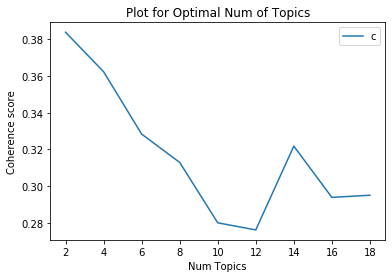

In [142]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Plot for Optimal Num of Topics')
plt.show()

In [143]:
# Print the coherence scores
# so the result shows that when my number of topic is 2, I have the highest coherence score with my LDA model
# but that's not applicable with song lyric topic modeling
# so I will choose 14 topics for my LDA model as it's more close to the actualy number of song genres
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3838
Num Topics = 4  has Coherence Value of 0.3623
Num Topics = 6  has Coherence Value of 0.3284
Num Topics = 8  has Coherence Value of 0.3129
Num Topics = 10  has Coherence Value of 0.28
Num Topics = 12  has Coherence Value of 0.2762
Num Topics = 14  has Coherence Value of 0.3218
Num Topics = 16  has Coherence Value of 0.2939
Num Topics = 18  has Coherence Value of 0.2951


##### <font color='black'>Retrain LDA Model with Optimal # of Topics (14)</font>
Just checkout how the topics will look like if the number of topics is 14

In [46]:
# build LDA model with 14 topics
lda_model_14 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

2019-08-21 17:05:33,186 : INFO : using autotuned alpha, starting with [0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575]
2019-08-21 17:05:33,189 : INFO : using symmetric eta at 0.07142857142857142
2019-08-21 17:05:33,194 : INFO : using serial LDA version on this node
2019-08-21 17:05:33,225 : INFO : running online (multi-pass) LDA training, 14 topics, 10 passes over the supplied corpus of 4028 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-21 17:05:33,226 : INFO : PROGRESS: pass 0, at document #100/4028
2019-08-21 17:05:33,317 : INFO : optimized alpha [0.060097992, 0.057218958, 0.056346714, 0.059408538, 0.05869092, 0.05898314, 0.063620776, 0.05939075, 0.070423365, 0.0617958, 0.063746735, 0.06488001, 0.05765711, 0.07132935]
2019-08-21 17:05:33,318

2019-08-21 17:05:34,071 : INFO : optimized alpha [0.10717642, 0.10342219, 0.061017267, 0.092671335, 0.067050666, 0.0636423, 0.090374805, 0.088079065, 0.11753391, 0.08616714, 0.06535128, 0.09774465, 0.06294517, 0.14283268]
2019-08-21 17:05:34,073 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:34,102 : INFO : topic #2 (0.061): 0.028*"summer" + 0.028*"magic" + 0.026*"hooray" + 0.024*"high" + 0.021*"hazel" + 0.019*"light" + 0.019*"love" + 0.019*"paperback_writer" + 0.017*"tonight" + 0.016*"bright"
2019-08-21 17:05:34,104 : INFO : topic #12 (0.063): 0.044*"man" + 0.033*"law" + 0.032*"stop" + 0.031*"wild" + 0.025*"child" + 0.020*"soul" + 0.019*"time" + 0.016*"people" + 0.014*"everything" + 0.013*"train"
2019-08-21 17:05:34,106 : INFO : topic #0 (0.107): 0.212*"love" + 0.027*"thing" + 0.023*"dream" + 0.021*"true" + 0.019*"much" + 0.018*"year" + 0.016*"life" + 0.016*"know" + 0.016*"young" + 0.015*"nobody"
2019-08-21 17:05:34,107 : INFO : topic #8 (0

2019-08-21 17:05:34,817 : INFO : topic #8 (0.165): 0.094*"day" + 0.044*"night" + 0.036*"heart" + 0.031*"love" + 0.029*"home" + 0.028*"time" + 0.025*"beach" + 0.019*"people" + 0.015*"letter" + 0.015*"last"
2019-08-21 17:05:34,818 : INFO : topic #0 (0.190): 0.276*"love" + 0.027*"life" + 0.026*"world" + 0.026*"thing" + 0.020*"hold" + 0.017*"way" + 0.017*"dream" + 0.016*"something" + 0.015*"call" + 0.014*"know"
2019-08-21 17:05:34,820 : INFO : topic #13 (0.239): 0.200*"baby" + 0.064*"love" + 0.049*"girl" + 0.043*"good" + 0.038*"little" + 0.025*"bad" + 0.024*"sweet" + 0.019*"head" + 0.014*"nothing" + 0.011*"goodbye"
2019-08-21 17:05:34,822 : INFO : topic diff=0.339572, rho=0.301511
2019-08-21 17:05:34,824 : INFO : PROGRESS: pass 0, at document #1200/4028
2019-08-21 17:05:34,883 : INFO : optimized alpha [0.2158384, 0.17287426, 0.08670344, 0.14692494, 0.09030992, 0.09416901, 0.1560212, 0.13679886, 0.1762015, 0.12991655, 0.085359335, 0.16648124, 0.103308186, 0.2525133]
2019-08-21 17:05:34,886 

2019-08-21 17:05:35,515 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:35,550 : INFO : topic #10 (0.106): 0.045*"strong" + 0.043*"wind" + 0.028*"mickey" + 0.025*"door" + 0.024*"hand" + 0.023*"boogie" + 0.021*"open" + 0.020*"number" + 0.019*"mon" + 0.018*"funk"
2019-08-21 17:05:35,552 : INFO : topic #4 (0.108): 0.062*"everybody" + 0.044*"song" + 0.042*"round" + 0.030*"cool" + 0.022*"big" + 0.022*"kick" + 0.021*"burnin" + 0.020*"ring" + 0.016*"dance" + 0.014*"wa"
2019-08-21 17:05:35,554 : INFO : topic #8 (0.252): 0.100*"night" + 0.067*"heart" + 0.058*"day" + 0.023*"home" + 0.023*"time" + 0.018*"today" + 0.017*"kid" + 0.015*"break" + 0.014*"eye" + 0.014*"love"
2019-08-21 17:05:35,556 : INFO : topic #13 (0.368): 0.164*"baby" + 0.062*"girl" + 0.055*"little" + 0.045*"love" + 0.033*"good" + 0.023*"sweet" + 0.023*"nothing" + 0.017*"bad" + 0.016*"head" + 0.014*"well"
2019-08-21 17:05:35,558 : INFO : topic #0 (0.383): 0.288*"love" + 0.035*"life" + 0.0

2019-08-21 17:05:36,764 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:36,792 : INFO : topic #4 (0.167): 0.064*"everybody" + 0.037*"shit" + 0.032*"big" + 0.030*"song" + 0.028*"singing" + 0.027*"party" + 0.019*"cool" + 0.017*"daddy" + 0.016*"round" + 0.015*"kick"
2019-08-21 17:05:36,794 : INFO : topic #10 (0.191): 0.045*"strong" + 0.042*"yo" + 0.024*"wit" + 0.021*"bitch" + 0.020*"open" + 0.016*"hell" + 0.015*"go" + 0.015*"door" + 0.014*"understand" + 0.013*"wind"
2019-08-21 17:05:36,796 : INFO : topic #11 (0.499): 0.049*"eye" + 0.038*"wrong" + 0.032*"word" + 0.032*"mind" + 0.028*"close" + 0.028*"turn" + 0.022*"roll" + 0.022*"life" + 0.021*"deep" + 0.020*"sun"
2019-08-21 17:05:36,798 : INFO : topic #13 (0.789): 0.203*"baby" + 0.065*"girl" + 0.039*"good" + 0.034*"little" + 0.027*"bad" + 0.024*"nothing" + 0.023*"love" + 0.021*"sweet" + 0.013*"something" + 0.013*"feel"
2019-08-21 17:05:36,800 : INFO : topic #0 (0.829): 0.248*"love" + 0.040*"life"

2019-08-21 17:05:37,443 : INFO : topic #0 (0.966): 0.219*"love" + 0.044*"life" + 0.041*"thing" + 0.026*"real" + 0.021*"nobody" + 0.021*"way" + 0.020*"something" + 0.020*"heart" + 0.018*"true" + 0.017*"hold"
2019-08-21 17:05:37,445 : INFO : topic #13 (0.983): 0.179*"baby" + 0.116*"girl" + 0.034*"good" + 0.030*"little" + 0.021*"bad" + 0.020*"head" + 0.019*"nothing" + 0.017*"love" + 0.016*"crazy" + 0.012*"thing"
2019-08-21 17:05:37,448 : INFO : topic diff=0.613204, rho=0.174078
2019-08-21 17:05:37,452 : INFO : PROGRESS: pass 0, at document #3400/4028
2019-08-21 17:05:37,512 : INFO : optimized alpha [0.9758467, 0.5915023, 0.28616107, 0.5590435, 0.25860688, 0.30089504, 0.4716499, 0.49440384, 0.6053345, 0.33943984, 0.28049764, 0.6429062, 0.40968186, 1.0266981]
2019-08-21 17:05:37,515 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:37,543 : INFO : topic #4 (0.259): 0.039*"shit" + 0.035*"club" + 0.035*"everybody" + 0.027*"song" + 0.026*"big" + 0.017*

2019-08-21 17:05:38,010 : INFO : topic #10 (0.332): 0.059*"bitch" + 0.051*"yo" + 0.035*"wit" + 0.024*"hell" + 0.017*"strong" + 0.014*"nigga" + 0.014*"number" + 0.013*"call" + 0.013*"go" + 0.012*"push"
2019-08-21 17:05:38,012 : INFO : topic #4 (0.343): 0.046*"everybody" + 0.038*"song" + 0.037*"club" + 0.037*"shit" + 0.030*"party" + 0.029*"big" + 0.020*"round" + 0.018*"chick" + 0.014*"nigga" + 0.014*"cool"
2019-08-21 17:05:38,013 : INFO : topic #11 (0.767): 0.046*"turn" + 0.038*"eye" + 0.028*"wrong" + 0.026*"run" + 0.024*"close" + 0.024*"mind" + 0.023*"sky" + 0.023*"life" + 0.019*"word" + 0.018*"face"
2019-08-21 17:05:38,015 : INFO : topic #0 (1.053): 0.234*"love" + 0.052*"life" + 0.035*"thing" + 0.024*"way" + 0.021*"real" + 0.021*"heart" + 0.018*"nobody" + 0.017*"something" + 0.017*"touch" + 0.015*"hold"
2019-08-21 17:05:38,017 : INFO : topic #13 (1.226): 0.161*"baby" + 0.113*"girl" + 0.046*"good" + 0.028*"bad" + 0.026*"little" + 0.022*"nothing" + 0.020*"head" + 0.016*"feel" + 0.014*"cr

2019-08-21 17:05:38,557 : INFO : topic #13 (1.058): 0.163*"baby" + 0.092*"girl" + 0.049*"good" + 0.035*"little" + 0.026*"bad" + 0.023*"sweet" + 0.023*"nothing" + 0.020*"head" + 0.015*"crazy" + 0.013*"feel"
2019-08-21 17:05:38,558 : INFO : topic #0 (1.066): 0.250*"love" + 0.045*"life" + 0.029*"thing" + 0.026*"heart" + 0.024*"nobody" + 0.021*"way" + 0.020*"true" + 0.019*"dream" + 0.018*"hold" + 0.016*"someone"
2019-08-21 17:05:38,560 : INFO : topic diff=0.324484, rho=0.153792
2019-08-21 17:05:38,563 : INFO : PROGRESS: pass 1, at document #400/4028
2019-08-21 17:05:38,604 : INFO : optimized alpha [1.036583, 0.60283965, 0.34652176, 0.5843439, 0.3341046, 0.32374984, 0.48495477, 0.49865535, 0.78771394, 0.35807723, 0.29194662, 0.6964276, 0.43698627, 1.0410627]
2019-08-21 17:05:38,606 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:38,638 : INFO : topic #10 (0.292): 0.054*"bitch" + 0.032*"yo" + 0.019*"wit" + 0.018*"hell" + 0.016*"strong" + 0.016*"nig

2019-08-21 17:05:39,056 : INFO : topic #10 (0.248): 0.036*"bitch" + 0.029*"yo" + 0.027*"strong" + 0.019*"call" + 0.017*"golden" + 0.015*"number" + 0.015*"hell" + 0.014*"clothe" + 0.013*"skin" + 0.013*"wit"
2019-08-21 17:05:39,058 : INFO : topic #4 (0.291): 0.055*"everybody" + 0.053*"song" + 0.045*"round" + 0.037*"big" + 0.023*"twist" + 0.018*"club" + 0.017*"party" + 0.017*"cool" + 0.016*"daddy" + 0.015*"shit"
2019-08-21 17:05:39,060 : INFO : topic #8 (0.779): 0.092*"day" + 0.087*"night" + 0.053*"heart" + 0.031*"home" + 0.027*"lonely" + 0.020*"old" + 0.018*"last" + 0.017*"time" + 0.015*"break" + 0.014*"tomorrow"
2019-08-21 17:05:39,061 : INFO : topic #0 (1.017): 0.289*"love" + 0.036*"life" + 0.032*"thing" + 0.024*"way" + 0.023*"heart" + 0.022*"hold" + 0.020*"dream" + 0.020*"true" + 0.018*"world" + 0.017*"nobody"
2019-08-21 17:05:39,063 : INFO : topic #13 (1.057): 0.180*"baby" + 0.091*"girl" + 0.050*"little" + 0.049*"good" + 0.035*"sweet" + 0.021*"head" + 0.020*"nothing" + 0.020*"bad" + 

2019-08-21 17:05:39,575 : INFO : topic #13 (1.002): 0.186*"baby" + 0.070*"girl" + 0.057*"little" + 0.056*"good" + 0.038*"sweet" + 0.022*"bad" + 0.020*"nothing" + 0.018*"head" + 0.015*"need" + 0.012*"feel"
2019-08-21 17:05:39,577 : INFO : topic #0 (1.097): 0.336*"love" + 0.036*"thing" + 0.035*"life" + 0.026*"way" + 0.020*"heart" + 0.020*"hold" + 0.019*"dream" + 0.018*"world" + 0.018*"much" + 0.016*"true"
2019-08-21 17:05:39,579 : INFO : topic diff=0.261033, rho=0.153792
2019-08-21 17:05:39,581 : INFO : PROGRESS: pass 1, at document #1500/4028
2019-08-21 17:05:39,633 : INFO : optimized alpha [1.1539534, 0.5415815, 0.32009575, 0.5851782, 0.281945, 0.2968288, 0.48390034, 0.4574846, 0.79693735, 0.31487754, 0.23439899, 0.7200709, 0.4093204, 0.99192524]
2019-08-21 17:05:39,635 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:39,666 : INFO : topic #10 (0.234): 0.038*"wind" + 0.035*"boogie" + 0.026*"funk" + 0.025*"strong" + 0.023*"number" + 0.023*"call

2019-08-21 17:05:40,141 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:40,170 : INFO : topic #10 (0.235): 0.031*"strong" + 0.031*"wind" + 0.029*"cha" + 0.022*"mickey" + 0.020*"number" + 0.019*"open" + 0.016*"boogie" + 0.015*"midnight" + 0.014*"call" + 0.014*"door"
2019-08-21 17:05:40,172 : INFO : topic #4 (0.272): 0.077*"everybody" + 0.064*"song" + 0.049*"big" + 0.035*"round" + 0.032*"cool" + 0.031*"party" + 0.019*"ring" + 0.018*"burnin" + 0.014*"school" + 0.014*"sing"
2019-08-21 17:05:40,174 : INFO : topic #8 (0.830): 0.143*"night" + 0.071*"day" + 0.058*"heart" + 0.029*"home" + 0.026*"lonely" + 0.016*"time" + 0.016*"morning" + 0.014*"sad" + 0.014*"last" + 0.013*"break"
2019-08-21 17:05:40,175 : INFO : topic #13 (1.020): 0.165*"baby" + 0.080*"girl" + 0.057*"good" + 0.049*"little" + 0.038*"bad" + 0.031*"sweet" + 0.027*"nothing" + 0.018*"need" + 0.017*"head" + 0.014*"crazy"
2019-08-21 17:05:40,177 : INFO : topic #0 (1.205): 0.305*"love" + 0.04

2019-08-21 17:05:40,630 : INFO : topic #0 (1.344): 0.297*"love" + 0.038*"life" + 0.034*"heart" + 0.032*"thing" + 0.025*"way" + 0.025*"true" + 0.023*"real" + 0.020*"dream" + 0.020*"hold" + 0.019*"something"
2019-08-21 17:05:40,633 : INFO : topic diff=0.358195, rho=0.153792
2019-08-21 17:05:40,635 : INFO : PROGRESS: pass 1, at document #2600/4028
2019-08-21 17:05:40,675 : INFO : optimized alpha [1.355463, 0.5738653, 0.34609368, 0.69261813, 0.28804454, 0.3274077, 0.5470332, 0.50189525, 0.8625971, 0.32689354, 0.25969246, 0.84328294, 0.4648449, 1.1940625]
2019-08-21 17:05:40,680 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:40,709 : INFO : topic #10 (0.260): 0.036*"yo" + 0.027*"strong" + 0.019*"cha" + 0.016*"call" + 0.015*"hell" + 0.015*"bone" + 0.014*"bitch" + 0.014*"funk" + 0.013*"shoop_shoop" + 0.013*"go"
2019-08-21 17:05:40,711 : INFO : topic #4 (0.288): 0.069*"everybody" + 0.038*"song" + 0.034*"party" + 0.033*"big" + 0.025*"daddy" + 0.025*"

2019-08-21 17:05:41,246 : INFO : topic #10 (0.309): 0.045*"yo" + 0.043*"bitch" + 0.028*"wit" + 0.019*"nigga" + 0.016*"superman" + 0.016*"dem" + 0.015*"call" + 0.015*"hell" + 0.014*"mon" + 0.013*"niggaz"
2019-08-21 17:05:41,247 : INFO : topic #4 (0.334): 0.044*"everybody" + 0.031*"shit" + 0.030*"song" + 0.028*"big" + 0.022*"fuck" + 0.022*"club" + 0.020*"party" + 0.016*"cool" + 0.013*"round" + 0.013*"daddy"
2019-08-21 17:05:41,249 : INFO : topic #8 (0.906): 0.100*"night" + 0.086*"day" + 0.049*"heart" + 0.025*"home" + 0.021*"break" + 0.019*"wake" + 0.019*"lonely" + 0.014*"tomorrow" + 0.014*"everything" + 0.014*"morning"
2019-08-21 17:05:41,250 : INFO : topic #13 (1.333): 0.202*"baby" + 0.096*"girl" + 0.048*"good" + 0.036*"little" + 0.025*"bad" + 0.020*"everything" + 0.019*"nothing" + 0.018*"sweet" + 0.018*"crazy" + 0.015*"need"
2019-08-21 17:05:41,252 : INFO : topic #0 (1.421): 0.246*"love" + 0.052*"life" + 0.040*"thing" + 0.027*"way" + 0.026*"heart" + 0.022*"true" + 0.022*"real" + 0.019*

2019-08-21 17:05:41,681 : INFO : topic #13 (1.421): 0.164*"baby" + 0.130*"girl" + 0.053*"good" + 0.028*"little" + 0.026*"bad" + 0.022*"head" + 0.020*"nothing" + 0.017*"everything" + 0.016*"crazy" + 0.016*"sweet"
2019-08-21 17:05:41,683 : INFO : topic diff=0.396744, rho=0.153792
2019-08-21 17:05:41,685 : INFO : PROGRESS: pass 1, at document #3700/4028
2019-08-21 17:05:41,726 : INFO : optimized alpha [1.3155516, 0.7992466, 0.45604607, 0.8086844, 0.46881846, 0.47695366, 0.6679826, 0.7253458, 0.91327417, 0.42715195, 0.38403133, 0.9202548, 0.66542083, 1.4555273]
2019-08-21 17:05:41,728 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:41,761 : INFO : topic #10 (0.384): 0.061*"yo" + 0.046*"bitch" + 0.042*"wit" + 0.025*"hell" + 0.021*"call" + 0.019*"nigga" + 0.015*"damn" + 0.012*"number" + 0.012*"dem" + 0.011*"clothe"
2019-08-21 17:05:41,764 : INFO : topic #9 (0.427): 0.070*"dance" + 0.065*"move" + 0.055*"floor" + 0.036*"sexy" + 0.036*"play" + 0.032*"

2019-08-21 17:05:42,245 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:42,276 : INFO : topic #10 (0.387): 0.067*"bitch" + 0.039*"yo" + 0.024*"nigga" + 0.024*"wit" + 0.023*"hell" + 0.023*"call" + 0.014*"clothe" + 0.012*"skin" + 0.012*"damn" + 0.012*"push"
2019-08-21 17:05:42,277 : INFO : topic #9 (0.423): 0.065*"dance" + 0.057*"move" + 0.046*"play" + 0.041*"floor" + 0.028*"music" + 0.028*"somebody" + 0.025*"worth" + 0.025*"sexy" + 0.024*"bass" + 0.019*"check"
2019-08-21 17:05:42,279 : INFO : topic #8 (0.980): 0.112*"night" + 0.053*"day" + 0.053*"heart" + 0.032*"home" + 0.023*"break" + 0.022*"cold" + 0.021*"last" + 0.017*"lonely" + 0.016*"long" + 0.014*"bed"
2019-08-21 17:05:42,281 : INFO : topic #0 (1.274): 0.251*"love" + 0.054*"life" + 0.035*"thing" + 0.031*"heart" + 0.028*"way" + 0.027*"nobody" + 0.018*"true" + 0.018*"hold" + 0.017*"touch" + 0.016*"real"
2019-08-21 17:05:42,282 : INFO : topic #13 (1.320): 0.163*"baby" + 0.106*"girl" + 0.061

2019-08-21 17:05:42,667 : INFO : topic #0 (1.172): 0.286*"love" + 0.040*"life" + 0.035*"thing" + 0.031*"heart" + 0.028*"way" + 0.025*"true" + 0.020*"dream" + 0.019*"nobody" + 0.018*"someone" + 0.016*"hold"
2019-08-21 17:05:42,668 : INFO : topic diff=0.225532, rho=0.152004
2019-08-21 17:05:42,670 : INFO : PROGRESS: pass 2, at document #700/4028
2019-08-21 17:05:42,707 : INFO : optimized alpha [1.145922, 0.60045534, 0.37320343, 0.65491027, 0.3708412, 0.3408861, 0.5266847, 0.53684026, 0.92958546, 0.34216568, 0.2759696, 0.7935896, 0.48203665, 1.1583891]
2019-08-21 17:05:42,709 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:42,738 : INFO : topic #10 (0.276): 0.044*"bitch" + 0.027*"yo" + 0.019*"call" + 0.018*"number" + 0.016*"nigga" + 0.016*"wit" + 0.016*"hell" + 0.015*"jude" + 0.014*"golden" + 0.014*"skin"
2019-08-21 17:05:42,739 : INFO : topic #5 (0.341): 0.054*"hand" + 0.040*"body" + 0.031*"lady" + 0.018*"air" + 0.017*"anyone" + 0.016*"wonder" 

2019-08-21 17:05:43,231 : INFO : topic #10 (0.247): 0.050*"boogie" + 0.025*"bitch" + 0.020*"call" + 0.019*"yo" + 0.017*"funk" + 0.017*"business" + 0.015*"number" + 0.014*"hell" + 0.012*"golden" + 0.011*"go"
2019-08-21 17:05:43,233 : INFO : topic #9 (0.316): 0.091*"dance" + 0.055*"music" + 0.046*"play" + 0.038*"move" + 0.033*"help" + 0.025*"floor" + 0.025*"somebody" + 0.024*"sexy" + 0.023*"place" + 0.019*"band"
2019-08-21 17:05:43,235 : INFO : topic #8 (0.879): 0.098*"day" + 0.094*"night" + 0.044*"heart" + 0.028*"home" + 0.023*"old" + 0.022*"lonely" + 0.021*"long" + 0.019*"morning" + 0.016*"last" + 0.013*"cold"
2019-08-21 17:05:43,236 : INFO : topic #13 (1.104): 0.190*"baby" + 0.086*"girl" + 0.065*"good" + 0.046*"little" + 0.043*"sweet" + 0.026*"bad" + 0.019*"head" + 0.016*"nothing" + 0.014*"need" + 0.011*"everything"
2019-08-21 17:05:43,238 : INFO : topic #0 (1.142): 0.336*"love" + 0.039*"life" + 0.037*"thing" + 0.030*"way" + 0.025*"heart" + 0.019*"dream" + 0.018*"world" + 0.018*"true"

2019-08-21 17:05:43,653 : INFO : topic #0 (1.288): 0.315*"love" + 0.043*"life" + 0.030*"thing" + 0.029*"heart" + 0.029*"way" + 0.023*"much" + 0.021*"hold" + 0.021*"dream" + 0.020*"true" + 0.018*"someone"
2019-08-21 17:05:43,657 : INFO : topic diff=0.221362, rho=0.152004
2019-08-21 17:05:43,659 : INFO : PROGRESS: pass 2, at document #1800/4028
2019-08-21 17:05:43,695 : INFO : optimized alpha [1.2861289, 0.53068465, 0.36436984, 0.6468421, 0.3126223, 0.31081218, 0.5332227, 0.49877888, 0.9287664, 0.315067, 0.23553155, 0.81835496, 0.45965558, 1.0978007]
2019-08-21 17:05:43,697 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:43,729 : INFO : topic #10 (0.236): 0.031*"mickey" + 0.027*"call" + 0.023*"boogie" + 0.018*"number" + 0.016*"funk" + 0.014*"door" + 0.014*"mon" + 0.013*"open" + 0.012*"go" + 0.012*"yo"
2019-08-21 17:05:43,731 : INFO : topic #5 (0.311): 0.059*"hand" + 0.045*"lady" + 0.039*"control" + 0.034*"body" + 0.029*"wonder" + 0.016*"hall" +

2019-08-21 17:05:44,198 : INFO : topic #10 (0.234): 0.031*"yo" + 0.028*"cha" + 0.027*"shack" + 0.021*"call" + 0.021*"mon" + 0.021*"number" + 0.017*"open" + 0.016*"hell" + 0.016*"heartbeat" + 0.015*"mickey"
2019-08-21 17:05:44,200 : INFO : topic #4 (0.304): 0.082*"everybody" + 0.045*"song" + 0.035*"big" + 0.030*"party" + 0.027*"round" + 0.023*"cool" + 0.019*"jump_jump" + 0.018*"daddy" + 0.013*"school" + 0.012*"ring"
2019-08-21 17:05:44,202 : INFO : topic #8 (0.947): 0.124*"night" + 0.082*"day" + 0.063*"heart" + 0.027*"home" + 0.023*"long" + 0.022*"lonely" + 0.018*"break" + 0.018*"cold" + 0.015*"last" + 0.013*"morning"
2019-08-21 17:05:44,204 : INFO : topic #13 (1.186): 0.192*"baby" + 0.088*"girl" + 0.057*"good" + 0.045*"little" + 0.031*"sweet" + 0.027*"bad" + 0.019*"nothing" + 0.017*"need" + 0.015*"something" + 0.014*"head"
2019-08-21 17:05:44,205 : INFO : topic #0 (1.411): 0.305*"love" + 0.040*"life" + 0.038*"heart" + 0.034*"thing" + 0.031*"way" + 0.025*"true" + 0.021*"dream" + 0.020*"

2019-08-21 17:05:44,599 : INFO : topic #0 (1.466): 0.271*"love" + 0.046*"life" + 0.038*"heart" + 0.037*"thing" + 0.030*"way" + 0.024*"true" + 0.023*"someone" + 0.020*"hold" + 0.019*"nobody" + 0.019*"dream"
2019-08-21 17:05:44,602 : INFO : topic diff=0.379170, rho=0.152004
2019-08-21 17:05:44,604 : INFO : PROGRESS: pass 2, at document #2900/4028
2019-08-21 17:05:44,640 : INFO : optimized alpha [1.4963555, 0.62260115, 0.3751392, 0.7607647, 0.327981, 0.3647642, 0.61130893, 0.58641446, 0.98309517, 0.3333865, 0.27418804, 0.943824, 0.53799766, 1.3569695]
2019-08-21 17:05:44,642 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:44,673 : INFO : topic #10 (0.274): 0.045*"yo" + 0.022*"bitch" + 0.022*"wit" + 0.021*"nigga" + 0.019*"niggaz" + 0.018*"call" + 0.016*"hell" + 0.014*"go" + 0.012*"cha" + 0.011*"understand"
2019-08-21 17:05:44,675 : INFO : topic #4 (0.328): 0.053*"everybody" + 0.032*"big" + 0.028*"shit" + 0.028*"song" + 0.023*"party" + 0.019*"fuck

2019-08-21 17:05:45,171 : INFO : topic #10 (0.353): 0.055*"wit" + 0.053*"yo" + 0.043*"bitch" + 0.023*"nigga" + 0.019*"hell" + 0.019*"call" + 0.017*"dem" + 0.015*"niggaz" + 0.013*"go" + 0.012*"number"
2019-08-21 17:05:45,174 : INFO : topic #9 (0.387): 0.077*"move" + 0.066*"dance" + 0.042*"play" + 0.042*"sexy" + 0.040*"floor" + 0.039*"music" + 0.026*"somebody" + 0.023*"check" + 0.022*"room" + 0.017*"right"
2019-08-21 17:05:45,176 : INFO : topic #8 (0.973): 0.086*"night" + 0.074*"day" + 0.037*"heart" + 0.026*"home" + 0.024*"long" + 0.024*"lonely" + 0.022*"cold" + 0.022*"break" + 0.016*"bed" + 0.015*"place"
2019-08-21 17:05:45,178 : INFO : topic #0 (1.395): 0.238*"love" + 0.051*"life" + 0.047*"thing" + 0.035*"way" + 0.029*"heart" + 0.024*"nobody" + 0.021*"real" + 0.021*"true" + 0.019*"touch" + 0.017*"hold"
2019-08-21 17:05:45,180 : INFO : topic #13 (1.437): 0.173*"baby" + 0.128*"girl" + 0.051*"good" + 0.034*"little" + 0.021*"bad" + 0.020*"head" + 0.018*"crazy" + 0.018*"everything" + 0.016*

2019-08-21 17:05:45,678 : INFO : topic diff=0.344235, rho=0.152004
2019-08-21 17:05:45,767 : INFO : -7.998 per-word bound, 255.7 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 17:05:45,768 : INFO : PROGRESS: pass 2, at document #4000/4028
2019-08-21 17:05:45,802 : INFO : optimized alpha [1.3320093, 0.81770897, 0.51177114, 0.8178374, 0.5255262, 0.5003342, 0.70727366, 0.75743544, 1.0275512, 0.43501207, 0.39564463, 1.0235658, 0.7395858, 1.5422504]
2019-08-21 17:05:45,803 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:45,835 : INFO : topic #10 (0.396): 0.068*"bitch" + 0.045*"yo" + 0.031*"wit" + 0.026*"call" + 0.025*"nigga" + 0.023*"hell" + 0.017*"damn" + 0.012*"number" + 0.012*"fuckin" + 0.012*"clothe"
2019-08-21 17:05:45,837 : INFO : topic #9 (0.435): 0.066*"dance" + 0.056*"move" + 0.048*"play" + 0.046*"floor" + 0.032*"somebody" + 0.031*"sexy" + 0.030*"bass" + 0.029*"music" + 0.025*"worth" + 0.020*"b

2019-08-21 17:05:46,246 : INFO : topic #9 (0.364): 0.082*"dance" + 0.049*"move" + 0.042*"play" + 0.041*"floor" + 0.034*"music" + 0.033*"somebody" + 0.022*"worth" + 0.022*"blow" + 0.021*"help" + 0.020*"sexy"
2019-08-21 17:05:46,247 : INFO : topic #8 (1.003): 0.100*"night" + 0.068*"day" + 0.051*"heart" + 0.029*"home" + 0.027*"long" + 0.022*"lonely" + 0.021*"last" + 0.020*"break" + 0.020*"old" + 0.017*"cold"
2019-08-21 17:05:46,249 : INFO : topic #13 (1.202): 0.169*"baby" + 0.101*"girl" + 0.064*"good" + 0.049*"little" + 0.028*"sweet" + 0.024*"bad" + 0.020*"head" + 0.017*"crazy" + 0.015*"something" + 0.015*"nothing"
2019-08-21 17:05:46,251 : INFO : topic #0 (1.229): 0.258*"love" + 0.048*"life" + 0.038*"heart" + 0.035*"thing" + 0.031*"way" + 0.024*"true" + 0.023*"nobody" + 0.023*"dream" + 0.018*"hold" + 0.017*"someone"
2019-08-21 17:05:46,253 : INFO : topic diff=0.220279, rho=0.150278
2019-08-21 17:05:46,256 : INFO : PROGRESS: pass 3, at document #500/4028
2019-08-21 17:05:46,285 : INFO : o

2019-08-21 17:05:46,640 : INFO : topic diff=0.210874, rho=0.150278
2019-08-21 17:05:46,720 : INFO : -7.866 per-word bound, 233.2 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 17:05:46,721 : INFO : PROGRESS: pass 3, at document #1000/4028
2019-08-21 17:05:46,752 : INFO : optimized alpha [1.1482226, 0.5741444, 0.3581144, 0.65981025, 0.36259538, 0.3325594, 0.5467848, 0.53639805, 0.95218, 0.32006526, 0.25706652, 0.8479395, 0.514104, 1.1796019]
2019-08-21 17:05:46,755 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:46,784 : INFO : topic #10 (0.257): 0.031*"bitch" + 0.026*"call" + 0.025*"yo" + 0.015*"number" + 0.015*"wit" + 0.015*"hell" + 0.014*"golden" + 0.014*"clothe" + 0.013*"go" + 0.013*"family_affair"
2019-08-21 17:05:46,786 : INFO : topic #9 (0.320): 0.075*"dance" + 0.043*"music" + 0.041*"play" + 0.036*"move" + 0.034*"help" + 0.028*"somebody" + 0.027*"floor" + 0.026*"band" + 0.023*"place" + 0.019*"

2019-08-21 17:05:47,179 : INFO : topic #9 (0.310): 0.103*"dance" + 0.067*"music" + 0.047*"move" + 0.040*"play" + 0.032*"somebody" + 0.030*"floor" + 0.026*"help" + 0.025*"sexy" + 0.018*"room" + 0.017*"place"
2019-08-21 17:05:47,181 : INFO : topic #8 (0.976): 0.116*"night" + 0.086*"day" + 0.034*"long" + 0.034*"home" + 0.033*"heart" + 0.022*"morning" + 0.021*"lonely" + 0.020*"old" + 0.017*"wind" + 0.016*"last"
2019-08-21 17:05:47,183 : INFO : topic #13 (1.113): 0.182*"baby" + 0.075*"girl" + 0.073*"good" + 0.054*"little" + 0.037*"sweet" + 0.025*"bad" + 0.020*"head" + 0.016*"need" + 0.014*"nothing" + 0.013*"feel"
2019-08-21 17:05:47,185 : INFO : topic #0 (1.313): 0.326*"love" + 0.046*"life" + 0.035*"way" + 0.034*"thing" + 0.029*"heart" + 0.021*"dream" + 0.020*"much" + 0.018*"hold" + 0.017*"true" + 0.016*"someone"
2019-08-21 17:05:47,187 : INFO : topic diff=0.181342, rho=0.150278
2019-08-21 17:05:47,189 : INFO : PROGRESS: pass 3, at document #1600/4028
2019-08-21 17:05:47,221 : INFO : optimi

2019-08-21 17:05:47,689 : INFO : topic diff=0.153491, rho=0.150278
2019-08-21 17:05:47,690 : INFO : PROGRESS: pass 3, at document #2100/4028
2019-08-21 17:05:47,723 : INFO : optimized alpha [1.4002663, 0.522747, 0.366578, 0.6971397, 0.311846, 0.31187183, 0.56159395, 0.50643116, 0.99537075, 0.31107488, 0.22846475, 0.90182275, 0.48612893, 1.1620319]
2019-08-21 17:05:47,726 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:47,755 : INFO : topic #10 (0.228): 0.029*"cha" + 0.027*"call" + 0.023*"number" + 0.022*"mickey" + 0.017*"boogie" + 0.015*"go" + 0.014*"darkness" + 0.014*"business" + 0.014*"hell" + 0.014*"motion"
2019-08-21 17:05:47,758 : INFO : topic #9 (0.311): 0.108*"dance" + 0.056*"play" + 0.053*"music" + 0.052*"somebody" + 0.044*"move" + 0.027*"rhythm" + 0.024*"help" + 0.020*"floor" + 0.018*"room" + 0.017*"place"
2019-08-21 17:05:47,761 : INFO : topic #8 (0.995): 0.136*"night" + 0.071*"day" + 0.047*"heart" + 0.028*"home" + 0.027*"long" + 0.

2019-08-21 17:05:48,167 : INFO : topic #8 (0.992): 0.113*"night" + 0.086*"day" + 0.041*"heart" + 0.031*"long" + 0.028*"wake" + 0.022*"home" + 0.018*"lonely" + 0.018*"break" + 0.016*"last" + 0.015*"cold"
2019-08-21 17:05:48,168 : INFO : topic #13 (1.284): 0.210*"baby" + 0.079*"girl" + 0.066*"good" + 0.039*"little" + 0.030*"sweet" + 0.026*"bad" + 0.020*"something" + 0.019*"strong" + 0.016*"need" + 0.016*"crazy"
2019-08-21 17:05:48,170 : INFO : topic #0 (1.472): 0.291*"love" + 0.044*"heart" + 0.042*"life" + 0.035*"way" + 0.034*"thing" + 0.026*"true" + 0.022*"someone" + 0.021*"hold" + 0.020*"real" + 0.020*"dream"
2019-08-21 17:05:48,173 : INFO : topic diff=0.302627, rho=0.150278
2019-08-21 17:05:48,177 : INFO : PROGRESS: pass 3, at document #2700/4028
2019-08-21 17:05:48,214 : INFO : optimized alpha [1.4941747, 0.5710759, 0.3695225, 0.74151224, 0.3259379, 0.34404668, 0.594838, 0.5505067, 0.99902594, 0.3195429, 0.25281745, 0.9781679, 0.5411121, 1.3208808]
2019-08-21 17:05:48,215 : INFO : me

2019-08-21 17:05:48,688 : INFO : PROGRESS: pass 3, at document #3200/4028
2019-08-21 17:05:48,730 : INFO : optimized alpha [1.4536849, 0.67860246, 0.4091149, 0.78344506, 0.39436153, 0.41042265, 0.65140045, 0.657843, 1.0015255, 0.36299038, 0.3120137, 0.98876816, 0.6212572, 1.4168738]
2019-08-21 17:05:48,732 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:48,771 : INFO : topic #10 (0.312): 0.046*"bitch" + 0.044*"yo" + 0.036*"wit" + 0.027*"nigga" + 0.020*"call" + 0.019*"hell" + 0.016*"dem" + 0.015*"niggaz" + 0.013*"mon" + 0.013*"superman"
2019-08-21 17:05:48,774 : INFO : topic #9 (0.363): 0.079*"move" + 0.077*"dance" + 0.046*"music" + 0.038*"play" + 0.034*"floor" + 0.027*"somebody" + 0.024*"sexy" + 0.021*"room" + 0.019*"groove" + 0.016*"check"
2019-08-21 17:05:48,776 : INFO : topic #8 (1.002): 0.091*"night" + 0.080*"day" + 0.031*"long" + 0.030*"heart" + 0.025*"home" + 0.021*"break" + 0.019*"lonely" + 0.015*"wake" + 0.014*"everything" + 0.014*"co

2019-08-21 17:05:49,310 : INFO : topic #0 (1.371): 0.253*"love" + 0.062*"life" + 0.042*"thing" + 0.042*"way" + 0.034*"heart" + 0.020*"nobody" + 0.019*"touch" + 0.017*"game" + 0.016*"real" + 0.015*"much"
2019-08-21 17:05:49,312 : INFO : topic #13 (1.511): 0.163*"baby" + 0.135*"girl" + 0.063*"good" + 0.027*"little" + 0.026*"bad" + 0.023*"head" + 0.020*"everything" + 0.019*"right" + 0.017*"something" + 0.017*"crazy"
2019-08-21 17:05:49,314 : INFO : topic diff=0.377900, rho=0.150278
2019-08-21 17:05:49,315 : INFO : PROGRESS: pass 3, at document #3800/4028
2019-08-21 17:05:49,351 : INFO : optimized alpha [1.349918, 0.77579796, 0.47526467, 0.825046, 0.50294733, 0.48448145, 0.705257, 0.7453001, 1.0389867, 0.41904742, 0.37911782, 1.0280837, 0.73781765, 1.5274426]
2019-08-21 17:05:49,353 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:49,385 : INFO : topic #10 (0.379): 0.056*"yo" + 0.050*"bitch" + 0.039*"wit" + 0.024*"call" + 0.024*"hell" + 0.022*"nig

2019-08-21 17:05:49,870 : INFO : optimized alpha [1.3266648, 0.7117996, 0.47033316, 0.73945385, 0.4733646, 0.41475862, 0.61462694, 0.64941084, 1.0257459, 0.38856527, 0.34898895, 0.97524667, 0.627058, 1.303158]
2019-08-21 17:05:49,872 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:49,914 : INFO : topic #10 (0.349): 0.066*"bitch" + 0.038*"yo" + 0.029*"nigga" + 0.025*"call" + 0.024*"wit" + 0.023*"hell" + 0.014*"clothe" + 0.014*"damn" + 0.012*"skin" + 0.011*"push"
2019-08-21 17:05:49,916 : INFO : topic #9 (0.389): 0.072*"dance" + 0.058*"move" + 0.047*"play" + 0.043*"floor" + 0.034*"music" + 0.029*"somebody" + 0.026*"worth" + 0.025*"sexy" + 0.024*"bass" + 0.019*"check"
2019-08-21 17:05:49,920 : INFO : topic #8 (1.026): 0.106*"night" + 0.060*"day" + 0.037*"heart" + 0.032*"long" + 0.031*"home" + 0.021*"break" + 0.021*"last" + 0.020*"cold" + 0.018*"old" + 0.018*"lonely"
2019-08-21 17:05:49,921 : INFO : topic #13 (1.303): 0.167*"baby" + 0.106*"girl" 

2019-08-21 17:05:50,406 : INFO : topic #13 (1.192): 0.183*"baby" + 0.103*"girl" + 0.065*"good" + 0.051*"little" + 0.030*"sweet" + 0.020*"bad" + 0.018*"head" + 0.015*"everything" + 0.014*"need" + 0.014*"something"
2019-08-21 17:05:50,408 : INFO : topic #0 (1.203): 0.287*"love" + 0.043*"heart" + 0.042*"life" + 0.036*"way" + 0.035*"thing" + 0.023*"true" + 0.021*"dream" + 0.020*"hold" + 0.019*"someone" + 0.018*"nobody"
2019-08-21 17:05:50,410 : INFO : topic diff=0.202176, rho=0.148610
2019-08-21 17:05:50,412 : INFO : PROGRESS: pass 4, at document #800/4028
2019-08-21 17:05:50,445 : INFO : optimized alpha [1.2124825, 0.5777345, 0.37282735, 0.66719216, 0.37472236, 0.335452, 0.5395857, 0.54779387, 0.9942368, 0.32213092, 0.26722074, 0.8788982, 0.5285918, 1.2128631]
2019-08-21 17:05:50,447 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:50,481 : INFO : topic #10 (0.267): 0.042*"bitch" + 0.026*"yo" + 0.019*"call" + 0.018*"nigga" + 0.016*"hell" + 0.016*

2019-08-21 17:05:50,908 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:50,939 : INFO : topic #10 (0.241): 0.047*"boogie" + 0.024*"bitch" + 0.019*"yo" + 0.019*"call" + 0.016*"hill" + 0.016*"funk" + 0.016*"business" + 0.015*"number" + 0.015*"hell" + 0.013*"go"
2019-08-21 17:05:50,941 : INFO : topic #9 (0.309): 0.104*"dance" + 0.061*"music" + 0.048*"move" + 0.043*"play" + 0.031*"help" + 0.030*"somebody" + 0.028*"floor" + 0.021*"sexy" + 0.019*"band" + 0.017*"room"
2019-08-21 17:05:50,944 : INFO : topic #8 (0.970): 0.102*"night" + 0.094*"day" + 0.031*"long" + 0.028*"home" + 0.027*"heart" + 0.022*"lonely" + 0.022*"old" + 0.019*"morning" + 0.016*"last" + 0.016*"sad"
2019-08-21 17:05:50,946 : INFO : topic #13 (1.143): 0.187*"baby" + 0.084*"girl" + 0.069*"good" + 0.058*"little" + 0.041*"sweet" + 0.025*"bad" + 0.019*"head" + 0.015*"need" + 0.013*"right" + 0.013*"something"
2019-08-21 17:05:50,948 : INFO : topic #0 (1.232): 0.329*"love" + 0.041*"life" 

2019-08-21 17:05:51,362 : INFO : topic #0 (1.352): 0.301*"love" + 0.047*"life" + 0.043*"heart" + 0.033*"way" + 0.031*"thing" + 0.023*"hold" + 0.023*"dream" + 0.023*"much" + 0.020*"true" + 0.018*"lover"
2019-08-21 17:05:51,364 : INFO : topic diff=0.171430, rho=0.148610
2019-08-21 17:05:51,366 : INFO : PROGRESS: pass 4, at document #1900/4028
2019-08-21 17:05:51,395 : INFO : optimized alpha [1.365769, 0.518623, 0.37245607, 0.6677816, 0.3202431, 0.31003192, 0.54746646, 0.5172178, 0.9927093, 0.30479836, 0.22947642, 0.9031544, 0.5024948, 1.1445266]
2019-08-21 17:05:51,397 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:51,427 : INFO : topic #10 (0.229): 0.028*"mickey" + 0.028*"call" + 0.022*"number" + 0.022*"boogie" + 0.017*"motion" + 0.017*"kyrie_eleison" + 0.015*"funk" + 0.015*"darkness" + 0.014*"mon" + 0.013*"go"
2019-08-21 17:05:51,430 : INFO : topic #9 (0.305): 0.118*"dance" + 0.060*"music" + 0.051*"play" + 0.044*"move" + 0.039*"somebody" + 0

2019-08-21 17:05:51,872 : INFO : topic #10 (0.235): 0.034*"cha" + 0.033*"yo" + 0.022*"call" + 0.019*"shack" + 0.018*"mon" + 0.016*"go" + 0.015*"hell" + 0.014*"number" + 0.014*"wit" + 0.013*"bone"
2019-08-21 17:05:51,874 : INFO : topic #9 (0.318): 0.089*"dance" + 0.065*"move" + 0.051*"play" + 0.040*"music" + 0.035*"somebody" + 0.034*"help" + 0.023*"room" + 0.023*"groove" + 0.022*"die" + 0.022*"rhythm"
2019-08-21 17:05:51,876 : INFO : topic #8 (0.992): 0.124*"night" + 0.081*"day" + 0.036*"heart" + 0.031*"long" + 0.027*"home" + 0.021*"lonely" + 0.018*"break" + 0.018*"place" + 0.017*"last" + 0.016*"cold"
2019-08-21 17:05:51,878 : INFO : topic #13 (1.244): 0.208*"baby" + 0.082*"girl" + 0.065*"good" + 0.042*"little" + 0.031*"bad" + 0.030*"sweet" + 0.021*"something" + 0.016*"need" + 0.016*"crazy" + 0.015*"strong"
2019-08-21 17:05:51,880 : INFO : topic #0 (1.483): 0.297*"love" + 0.057*"heart" + 0.042*"life" + 0.038*"way" + 0.034*"thing" + 0.024*"true" + 0.023*"real" + 0.020*"dream" + 0.020*"ho

2019-08-21 17:05:52,264 : INFO : topic #0 (1.551): 0.257*"love" + 0.052*"life" + 0.050*"heart" + 0.045*"way" + 0.038*"thing" + 0.024*"true" + 0.020*"someone" + 0.019*"real" + 0.018*"hold" + 0.018*"nobody"
2019-08-21 17:05:52,266 : INFO : topic diff=0.289056, rho=0.148610
2019-08-21 17:05:52,366 : INFO : -7.949 per-word bound, 247.1 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:05:52,367 : INFO : PROGRESS: pass 4, at document #3000/4028
2019-08-21 17:05:52,404 : INFO : optimized alpha [1.5465201, 0.6049098, 0.38510862, 0.7853821, 0.34607342, 0.3743958, 0.6217016, 0.6127325, 1.0248815, 0.33479032, 0.27819782, 1.0184639, 0.5815353, 1.3918296]
2019-08-21 17:05:52,406 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:52,436 : INFO : topic #10 (0.278): 0.045*"yo" + 0.041*"bitch" + 0.022*"nigga" + 0.020*"wit" + 0.018*"niggaz" + 0.017*"call" + 0.016*"mon" + 0.014*"hell" + 0.012*"go" + 0.011*"got"
2019-08

2019-08-21 17:05:52,854 : INFO : topic #9 (0.387): 0.073*"move" + 0.068*"dance" + 0.046*"floor" + 0.044*"music" + 0.044*"sexy" + 0.040*"play" + 0.026*"somebody" + 0.025*"help" + 0.021*"room" + 0.021*"check"
2019-08-21 17:05:52,855 : INFO : topic #11 (1.032): 0.046*"eye" + 0.040*"turn" + 0.035*"nothing" + 0.032*"face" + 0.026*"wrong" + 0.026*"word" + 0.022*"close" + 0.020*"get" + 0.020*"sun" + 0.018*"soul"
2019-08-21 17:05:52,858 : INFO : topic #0 (1.405): 0.243*"love" + 0.059*"life" + 0.046*"thing" + 0.044*"way" + 0.040*"heart" + 0.023*"nobody" + 0.022*"touch" + 0.019*"real" + 0.019*"true" + 0.017*"much"
2019-08-21 17:05:52,859 : INFO : topic #13 (1.466): 0.161*"baby" + 0.131*"girl" + 0.059*"good" + 0.031*"little" + 0.022*"bad" + 0.020*"everything" + 0.020*"head" + 0.020*"right" + 0.019*"something" + 0.018*"crazy"
2019-08-21 17:05:52,861 : INFO : topic diff=0.318492, rho=0.148610
2019-08-21 17:05:52,864 : INFO : PROGRESS: pass 4, at document #3600/4028
2019-08-21 17:05:52,908 : INFO : 

2019-08-21 17:05:53,505 : INFO : topic diff=0.323224, rho=0.148610
2019-08-21 17:05:53,549 : INFO : -7.561 per-word bound, 188.8 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 17:05:53,551 : INFO : PROGRESS: pass 4, at document #4028/4028
2019-08-21 17:05:53,565 : INFO : optimized alpha [1.3864242, 0.78754985, 0.5262289, 0.8269862, 0.5461512, 0.4761908, 0.7054156, 0.73822355, 1.0836672, 0.4369844, 0.39595848, 1.1005099, 0.7697096, 1.5205185]
2019-08-21 17:05:53,567 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-21 17:05:53,598 : INFO : topic #10 (0.396): 0.072*"bitch" + 0.042*"yo" + 0.034*"nigga" + 0.027*"wit" + 0.025*"hell" + 0.024*"call" + 0.016*"damn" + 0.014*"clothe" + 0.013*"skin" + 0.013*"push"
2019-08-21 17:05:53,599 : INFO : topic #9 (0.437): 0.072*"dance" + 0.063*"move" + 0.051*"play" + 0.044*"floor" + 0.030*"somebody" + 0.029*"music" + 0.028*"sexy" + 0.027*"worth" + 0.026*"bass" + 0.022*"check"
2019

2019-08-21 17:05:54,019 : INFO : topic #8 (1.016): 0.102*"night" + 0.081*"day" + 0.032*"long" + 0.030*"home" + 0.029*"heart" + 0.022*"lonely" + 0.021*"break" + 0.021*"last" + 0.019*"old" + 0.017*"cold"
2019-08-21 17:05:54,020 : INFO : topic #13 (1.216): 0.171*"baby" + 0.105*"girl" + 0.065*"good" + 0.049*"little" + 0.029*"sweet" + 0.024*"bad" + 0.019*"head" + 0.017*"something" + 0.016*"crazy" + 0.015*"right"
2019-08-21 17:05:54,022 : INFO : topic #0 (1.270): 0.266*"love" + 0.057*"heart" + 0.046*"life" + 0.041*"way" + 0.036*"thing" + 0.024*"true" + 0.021*"dream" + 0.021*"nobody" + 0.018*"hold" + 0.018*"someone"
2019-08-21 17:05:54,024 : INFO : topic diff=0.175464, rho=0.146995
2019-08-21 17:05:54,026 : INFO : PROGRESS: pass 5, at document #600/4028
2019-08-21 17:05:54,059 : INFO : optimized alpha [1.2557136, 0.58208644, 0.3817295, 0.6854521, 0.40672317, 0.3433879, 0.5437393, 0.56215763, 1.0026195, 0.34257492, 0.2804909, 0.89155644, 0.5299639, 1.2034482]
2019-08-21 17:05:54,062 : INFO : m

2019-08-21 17:05:54,521 : INFO : PROGRESS: pass 5, at document #1100/4028
2019-08-21 17:05:54,558 : INFO : optimized alpha [1.2055988, 0.5461712, 0.36014536, 0.652685, 0.3678591, 0.33154735, 0.55282587, 0.5381106, 0.9676338, 0.3130409, 0.25433654, 0.88734853, 0.5373329, 1.1948472]
2019-08-21 17:05:54,560 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:54,593 : INFO : topic #10 (0.254): 0.037*"boogie" + 0.026*"bitch" + 0.023*"yo" + 0.022*"call" + 0.019*"business" + 0.016*"number" + 0.015*"hell" + 0.014*"golden" + 0.012*"wit" + 0.012*"nigga"
2019-08-21 17:05:54,596 : INFO : topic #9 (0.313): 0.081*"dance" + 0.047*"music" + 0.043*"play" + 0.042*"help" + 0.038*"move" + 0.028*"floor" + 0.026*"somebody" + 0.025*"band" + 0.020*"room" + 0.017*"place"
2019-08-21 17:05:54,598 : INFO : topic #8 (0.968): 0.102*"day" + 0.082*"night" + 0.037*"long" + 0.033*"home" + 0.025*"old" + 0.023*"lonely" + 0.021*"heart" + 0.020*"last" + 0.019*"place" + 0.017*"morning

2019-08-21 17:05:55,019 : INFO : topic #13 (1.151): 0.183*"baby" + 0.078*"girl" + 0.072*"good" + 0.059*"little" + 0.038*"sweet" + 0.022*"bad" + 0.018*"head" + 0.017*"right" + 0.016*"need" + 0.014*"everything"
2019-08-21 17:05:55,020 : INFO : topic #0 (1.384): 0.316*"love" + 0.048*"life" + 0.040*"heart" + 0.040*"way" + 0.033*"thing" + 0.022*"hold" + 0.020*"dream" + 0.019*"much" + 0.018*"someone" + 0.017*"true"
2019-08-21 17:05:55,022 : INFO : topic diff=0.142609, rho=0.146995
2019-08-21 17:05:55,024 : INFO : PROGRESS: pass 5, at document #1700/4028
2019-08-21 17:05:55,065 : INFO : optimized alpha [1.3781412, 0.51059484, 0.36349276, 0.6686528, 0.33342525, 0.3087167, 0.547751, 0.5127085, 0.9783259, 0.30673212, 0.2306717, 0.9091746, 0.49923646, 1.1514856]
2019-08-21 17:05:55,067 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:55,098 : INFO : topic #10 (0.231): 0.039*"mickey" + 0.030*"boogie" + 0.029*"call" + 0.020*"funk" + 0.019*"number" + 0.018*

2019-08-21 17:05:55,585 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:55,621 : INFO : topic #10 (0.227): 0.035*"cha" + 0.029*"yo" + 0.024*"call" + 0.023*"number" + 0.020*"mickey" + 0.018*"mon" + 0.017*"hell" + 0.015*"go" + 0.015*"boogie" + 0.015*"wit"
2019-08-21 17:05:55,622 : INFO : topic #9 (0.312): 0.111*"dance" + 0.052*"move" + 0.051*"music" + 0.050*"play" + 0.043*"somebody" + 0.027*"floor" + 0.025*"rhythm" + 0.023*"help" + 0.022*"room" + 0.016*"worth"
2019-08-21 17:05:55,625 : INFO : topic #8 (1.000): 0.136*"night" + 0.081*"day" + 0.031*"long" + 0.030*"home" + 0.023*"lonely" + 0.023*"heart" + 0.019*"cold" + 0.016*"end" + 0.016*"break" + 0.016*"place"
2019-08-21 17:05:55,627 : INFO : topic #13 (1.210): 0.187*"baby" + 0.091*"girl" + 0.068*"good" + 0.046*"little" + 0.031*"bad" + 0.030*"sweet" + 0.018*"something" + 0.018*"need" + 0.016*"head" + 0.016*"right"
2019-08-21 17:05:55,630 : INFO : topic #0 (1.477): 0.294*"love" + 0.059*"heart" + 

2019-08-21 17:05:56,120 : INFO : topic #0 (1.542): 0.275*"love" + 0.059*"heart" + 0.048*"life" + 0.040*"way" + 0.033*"thing" + 0.026*"true" + 0.022*"someone" + 0.020*"nobody" + 0.020*"hold" + 0.019*"lover"
2019-08-21 17:05:56,122 : INFO : topic diff=0.268978, rho=0.146995
2019-08-21 17:05:56,124 : INFO : PROGRESS: pass 5, at document #2800/4028
2019-08-21 17:05:56,163 : INFO : optimized alpha [1.5445079, 0.5661717, 0.3773258, 0.7665503, 0.33480945, 0.35313013, 0.6039426, 0.5799154, 1.025818, 0.3232095, 0.25903168, 1.0280066, 0.5607404, 1.3539255]
2019-08-21 17:05:56,165 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:56,197 : INFO : topic #10 (0.259): 0.039*"yo" + 0.022*"wit" + 0.021*"nigga" + 0.021*"bitch" + 0.019*"niggaz" + 0.018*"call" + 0.015*"hell" + 0.014*"go" + 0.013*"cha" + 0.013*"understand"
2019-08-21 17:05:56,199 : INFO : topic #9 (0.323): 0.063*"dance" + 0.052*"move" + 0.040*"play" + 0.035*"somebody" + 0.029*"help" + 0.029*"west" 

2019-08-21 17:05:56,716 : INFO : topic #9 (0.371): 0.078*"move" + 0.076*"dance" + 0.045*"music" + 0.043*"play" + 0.037*"floor" + 0.036*"sexy" + 0.026*"check" + 0.025*"somebody" + 0.020*"room" + 0.016*"groove"
2019-08-21 17:05:56,718 : INFO : topic #11 (1.034): 0.050*"eye" + 0.038*"turn" + 0.037*"nothing" + 0.030*"word" + 0.030*"wrong" + 0.026*"face" + 0.024*"get" + 0.023*"sun" + 0.023*"close" + 0.021*"door"
2019-08-21 17:05:56,720 : INFO : topic #13 (1.440): 0.181*"baby" + 0.128*"girl" + 0.058*"good" + 0.033*"little" + 0.022*"head" + 0.021*"bad" + 0.021*"something" + 0.020*"everything" + 0.020*"right" + 0.020*"crazy"
2019-08-21 17:05:56,722 : INFO : topic #0 (1.462): 0.241*"love" + 0.054*"life" + 0.047*"heart" + 0.045*"way" + 0.044*"thing" + 0.021*"true" + 0.020*"real" + 0.020*"nobody" + 0.017*"hold" + 0.017*"someone"
2019-08-21 17:05:56,725 : INFO : topic diff=0.361409, rho=0.146995
2019-08-21 17:05:56,728 : INFO : PROGRESS: pass 5, at document #3400/4028
2019-08-21 17:05:56,767 : INF

2019-08-21 17:05:57,158 : INFO : topic diff=0.284703, rho=0.146995
2019-08-21 17:05:57,160 : INFO : PROGRESS: pass 5, at document #3900/4028
2019-08-21 17:05:57,200 : INFO : optimized alpha [1.3939378, 0.76834625, 0.4945981, 0.83659273, 0.5179695, 0.48650104, 0.71186066, 0.7533704, 1.0811151, 0.41990474, 0.38107145, 1.0949898, 0.7598273, 1.5554303]
2019-08-21 17:05:57,202 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:57,234 : INFO : topic #10 (0.381): 0.058*"bitch" + 0.050*"yo" + 0.034*"wit" + 0.027*"call" + 0.026*"nigga" + 0.024*"hell" + 0.017*"damn" + 0.013*"go" + 0.013*"shit" + 0.012*"push"
2019-08-21 17:05:57,235 : INFO : topic #9 (0.420): 0.070*"dance" + 0.064*"move" + 0.053*"floor" + 0.042*"play" + 0.036*"sexy" + 0.033*"music" + 0.026*"somebody" + 0.021*"blow" + 0.021*"help" + 0.019*"room"
2019-08-21 17:05:57,239 : INFO : topic #11 (1.095): 0.047*"eye" + 0.042*"turn" + 0.040*"nothing" + 0.026*"wrong" + 0.026*"close" + 0.024*"face" + 0

2019-08-21 17:05:57,745 : INFO : topic #9 (0.373): 0.070*"dance" + 0.055*"move" + 0.045*"play" + 0.044*"floor" + 0.034*"music" + 0.030*"somebody" + 0.024*"worth" + 0.023*"sexy" + 0.023*"blow" + 0.022*"bass"
2019-08-21 17:05:57,746 : INFO : topic #8 (1.018): 0.104*"night" + 0.071*"day" + 0.033*"home" + 0.032*"long" + 0.023*"lonely" + 0.021*"last" + 0.021*"break" + 0.020*"heart" + 0.019*"cold" + 0.019*"old"
2019-08-21 17:05:57,749 : INFO : topic #13 (1.265): 0.165*"baby" + 0.105*"girl" + 0.072*"good" + 0.037*"little" + 0.027*"bad" + 0.026*"sweet" + 0.022*"head" + 0.021*"something" + 0.018*"right" + 0.018*"crazy"
2019-08-21 17:05:57,751 : INFO : topic #0 (1.342): 0.252*"love" + 0.061*"heart" + 0.053*"life" + 0.045*"way" + 0.031*"thing" + 0.023*"nobody" + 0.021*"true" + 0.019*"dream" + 0.018*"hold" + 0.017*"someone"
2019-08-21 17:05:57,754 : INFO : topic diff=0.198449, rho=0.145432
2019-08-21 17:05:57,757 : INFO : PROGRESS: pass 6, at document #400/4028
2019-08-21 17:05:57,787 : INFO : opt

2019-08-21 17:05:58,163 : INFO : topic diff=0.187694, rho=0.145432
2019-08-21 17:05:58,166 : INFO : PROGRESS: pass 6, at document #900/4028
2019-08-21 17:05:58,201 : INFO : optimized alpha [1.2401322, 0.56038374, 0.36563545, 0.66642785, 0.37432837, 0.32730407, 0.5502451, 0.5471909, 0.9953386, 0.32207945, 0.26099676, 0.91058457, 0.5462093, 1.2274271]
2019-08-21 17:05:58,203 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:58,234 : INFO : topic #10 (0.261): 0.039*"bitch" + 0.031*"yo" + 0.029*"call" + 0.020*"nigga" + 0.017*"golden" + 0.016*"hell" + 0.015*"wit" + 0.014*"clothe" + 0.014*"skin" + 0.014*"number"
2019-08-21 17:05:58,237 : INFO : topic #9 (0.322): 0.064*"dance" + 0.046*"music" + 0.045*"play" + 0.038*"move" + 0.032*"floor" + 0.031*"help" + 0.030*"somebody" + 0.021*"room" + 0.017*"blow" + 0.016*"bring"
2019-08-21 17:05:58,238 : INFO : topic #8 (0.995): 0.099*"day" + 0.088*"night" + 0.038*"long" + 0.032*"home" + 0.026*"lonely" + 0.024*"ol

2019-08-21 17:05:58,722 : INFO : topic #9 (0.312): 0.112*"dance" + 0.067*"music" + 0.048*"move" + 0.041*"play" + 0.031*"floor" + 0.029*"help" + 0.028*"somebody" + 0.019*"sexy" + 0.019*"band" + 0.016*"room"
2019-08-21 17:05:58,723 : INFO : topic #8 (0.979): 0.109*"night" + 0.092*"day" + 0.035*"home" + 0.031*"long" + 0.022*"lonely" + 0.022*"old" + 0.020*"morning" + 0.017*"place" + 0.017*"last" + 0.016*"sad"
2019-08-21 17:05:58,724 : INFO : topic #13 (1.166): 0.187*"baby" + 0.079*"girl" + 0.075*"good" + 0.057*"little" + 0.041*"sweet" + 0.023*"bad" + 0.019*"head" + 0.017*"right" + 0.016*"need" + 0.014*"something"
2019-08-21 17:05:58,727 : INFO : topic #0 (1.313): 0.331*"love" + 0.046*"way" + 0.042*"heart" + 0.042*"life" + 0.036*"thing" + 0.020*"hold" + 0.019*"much" + 0.019*"dream" + 0.016*"true" + 0.015*"someone"
2019-08-21 17:05:58,731 : INFO : topic diff=0.147929, rho=0.145432
2019-08-21 17:05:58,733 : INFO : PROGRESS: pass 6, at document #1500/4028
2019-08-21 17:05:58,763 : INFO : optim

2019-08-21 17:05:59,151 : INFO : topic diff=0.150942, rho=0.145432
2019-08-21 17:05:59,235 : INFO : -7.152 per-word bound, 142.2 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-21 17:05:59,236 : INFO : PROGRESS: pass 6, at document #2000/4028
2019-08-21 17:05:59,273 : INFO : optimized alpha [1.4113983, 0.499657, 0.37423167, 0.68193877, 0.32207996, 0.3085096, 0.55848205, 0.51396006, 0.9923922, 0.30915233, 0.22900602, 0.9378113, 0.5180381, 1.1503677]
2019-08-21 17:05:59,275 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:05:59,304 : INFO : topic #10 (0.229): 0.032*"cha" + 0.024*"mickey" + 0.024*"call" + 0.019*"boogie" + 0.019*"number" + 0.014*"darkness" + 0.014*"motion" + 0.014*"kyrie_eleison" + 0.013*"funk" + 0.013*"mon"
2019-08-21 17:05:59,307 : INFO : topic #5 (0.309): 0.060*"hand" + 0.049*"control" + 0.041*"lady" + 0.041*"body" + 0.031*"fresh" + 0.028*"wonder" + 0.012*"family" + 0.012*"beat" + 0.011*"any

2019-08-21 17:05:59,713 : INFO : topic #11 (1.005): 0.066*"eye" + 0.048*"nothing" + 0.034*"wrong" + 0.033*"word" + 0.027*"close" + 0.026*"turn" + 0.023*"face" + 0.021*"deep" + 0.020*"soul" + 0.020*"roll"
2019-08-21 17:05:59,714 : INFO : topic #13 (1.282): 0.212*"baby" + 0.082*"girl" + 0.066*"good" + 0.039*"little" + 0.028*"bad" + 0.027*"sweet" + 0.025*"something" + 0.019*"strong" + 0.018*"crazy" + 0.017*"right"
2019-08-21 17:05:59,716 : INFO : topic #0 (1.532): 0.291*"love" + 0.066*"heart" + 0.044*"way" + 0.043*"life" + 0.032*"thing" + 0.025*"true" + 0.021*"real" + 0.020*"dream" + 0.019*"hold" + 0.019*"lover"
2019-08-21 17:05:59,718 : INFO : topic diff=0.240498, rho=0.145432
2019-08-21 17:05:59,721 : INFO : PROGRESS: pass 6, at document #2600/4028
2019-08-21 17:05:59,758 : INFO : optimized alpha [1.5350616, 0.5377904, 0.36903873, 0.751035, 0.3285741, 0.33267, 0.58680713, 0.5452129, 1.0066873, 0.3193799, 0.245256, 1.0233352, 0.5538024, 1.313286]
2019-08-21 17:05:59,760 : INFO : merging 

2019-08-21 17:06:00,244 : INFO : PROGRESS: pass 6, at document #3100/4028
2019-08-21 17:06:00,284 : INFO : optimized alpha [1.5576195, 0.6102277, 0.40177637, 0.7890387, 0.3696035, 0.39017347, 0.64105767, 0.6406479, 1.0329837, 0.34632328, 0.29171517, 1.0453188, 0.6159579, 1.4352098]
2019-08-21 17:06:00,286 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:00,315 : INFO : topic #10 (0.292): 0.044*"yo" + 0.042*"bitch" + 0.028*"wit" + 0.024*"nigga" + 0.017*"call" + 0.016*"dem" + 0.015*"superman" + 0.015*"hell" + 0.014*"niggaz" + 0.014*"shit"
2019-08-21 17:06:00,317 : INFO : topic #9 (0.346): 0.080*"dance" + 0.060*"move" + 0.048*"music" + 0.045*"play" + 0.030*"somebody" + 0.027*"floor" + 0.025*"room" + 0.022*"sexy" + 0.020*"help" + 0.019*"check"
2019-08-21 17:06:00,319 : INFO : topic #11 (1.045): 0.057*"eye" + 0.040*"nothing" + 0.035*"turn" + 0.034*"word" + 0.031*"wrong" + 0.027*"close" + 0.024*"face" + 0.023*"sun" + 0.021*"soul" + 0.020*"roll"
2019

2019-08-21 17:06:00,742 : INFO : topic #0 (1.412): 0.256*"love" + 0.057*"life" + 0.053*"way" + 0.046*"heart" + 0.044*"thing" + 0.021*"touch" + 0.021*"nobody" + 0.018*"game" + 0.017*"real" + 0.017*"much"
2019-08-21 17:06:00,744 : INFO : topic #13 (1.501): 0.164*"baby" + 0.134*"girl" + 0.064*"good" + 0.027*"little" + 0.025*"bad" + 0.024*"right" + 0.024*"head" + 0.021*"everything" + 0.018*"something" + 0.018*"crazy"
2019-08-21 17:06:00,747 : INFO : topic diff=0.275860, rho=0.145432
2019-08-21 17:06:00,750 : INFO : PROGRESS: pass 6, at document #3700/4028
2019-08-21 17:06:00,787 : INFO : optimized alpha [1.4137383, 0.7308771, 0.46286792, 0.83422524, 0.49716726, 0.46871096, 0.68966097, 0.73862875, 1.0305139, 0.4093701, 0.3664868, 1.060678, 0.7407907, 1.5344005]
2019-08-21 17:06:00,789 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:00,822 : INFO : topic #10 (0.366): 0.060*"yo" + 0.045*"bitch" + 0.042*"wit" + 0.027*"nigga" + 0.025*"hell" + 0.023*"c

2019-08-21 17:06:01,326 : INFO : optimized alpha [1.3749638, 0.67674917, 0.4908713, 0.77011716, 0.4991332, 0.43762448, 0.65394396, 0.68374217, 1.0498836, 0.40727597, 0.3712282, 1.064393, 0.7047195, 1.3806202]
2019-08-21 17:06:01,328 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:01,358 : INFO : topic #10 (0.371): 0.065*"bitch" + 0.039*"yo" + 0.035*"nigga" + 0.025*"wit" + 0.024*"call" + 0.023*"hell" + 0.016*"niggas" + 0.015*"shit" + 0.014*"damn" + 0.014*"clothe"
2019-08-21 17:06:01,359 : INFO : topic #9 (0.407): 0.070*"dance" + 0.061*"move" + 0.049*"play" + 0.045*"floor" + 0.031*"music" + 0.027*"somebody" + 0.027*"worth" + 0.027*"sexy" + 0.025*"bass" + 0.021*"check"
2019-08-21 17:06:01,361 : INFO : topic #11 (1.064): 0.049*"eye" + 0.043*"nothing" + 0.035*"turn" + 0.032*"deep" + 0.027*"word" + 0.024*"wrong" + 0.022*"close" + 0.020*"face" + 0.020*"run" + 0.020*"sky"
2019-08-21 17:06:01,365 : INFO : topic #0 (1.375): 0.245*"love" + 0.062*"heart"

2019-08-21 17:06:01,752 : INFO : topic #13 (1.219): 0.174*"baby" + 0.103*"girl" + 0.070*"good" + 0.046*"little" + 0.031*"sweet" + 0.022*"bad" + 0.019*"right" + 0.017*"head" + 0.017*"something" + 0.017*"everything"
2019-08-21 17:06:01,753 : INFO : topic #0 (1.288): 0.275*"love" + 0.064*"heart" + 0.047*"way" + 0.044*"life" + 0.033*"thing" + 0.024*"true" + 0.019*"dream" + 0.019*"nobody" + 0.017*"someone" + 0.016*"much"
2019-08-21 17:06:01,756 : INFO : topic diff=0.162020, rho=0.143918
2019-08-21 17:06:01,757 : INFO : PROGRESS: pass 7, at document #700/4028
2019-08-21 17:06:01,792 : INFO : optimized alpha [1.2609601, 0.5636076, 0.37992045, 0.6786765, 0.3947153, 0.33584183, 0.5452566, 0.5594127, 0.9836057, 0.33416817, 0.2739502, 0.92091227, 0.53581643, 1.2177613]
2019-08-21 17:06:01,794 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:01,823 : INFO : topic #10 (0.274): 0.046*"bitch" + 0.028*"yo" + 0.024*"nigga" + 0.020*"call" + 0.017*"wit" + 0.016*

2019-08-21 17:06:02,283 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:02,316 : INFO : topic #10 (0.248): 0.048*"boogie" + 0.028*"bitch" + 0.021*"yo" + 0.019*"call" + 0.017*"business" + 0.017*"funk" + 0.015*"hell" + 0.014*"number" + 0.013*"nigga" + 0.012*"golden"
2019-08-21 17:06:02,318 : INFO : topic #9 (0.311): 0.096*"dance" + 0.058*"music" + 0.049*"play" + 0.041*"move" + 0.035*"help" + 0.029*"floor" + 0.025*"sexy" + 0.024*"somebody" + 0.021*"band" + 0.018*"room"
2019-08-21 17:06:02,319 : INFO : topic #8 (0.957): 0.101*"day" + 0.095*"night" + 0.035*"long" + 0.029*"home" + 0.025*"old" + 0.022*"lonely" + 0.020*"place" + 0.019*"morning" + 0.018*"last" + 0.015*"well"
2019-08-21 17:06:02,320 : INFO : topic #13 (1.183): 0.189*"baby" + 0.089*"girl" + 0.074*"good" + 0.044*"little" + 0.043*"sweet" + 0.025*"bad" + 0.020*"head" + 0.018*"right" + 0.014*"everything" + 0.014*"need"
2019-08-21 17:06:02,322 : INFO : topic #0 (1.249): 0.324*"love" + 0.050*

2019-08-21 17:06:02,733 : INFO : topic #0 (1.404): 0.304*"love" + 0.056*"heart" + 0.046*"life" + 0.044*"way" + 0.029*"thing" + 0.023*"much" + 0.021*"hold" + 0.020*"dream" + 0.020*"true" + 0.017*"someone"
2019-08-21 17:06:02,736 : INFO : topic diff=0.160431, rho=0.143918
2019-08-21 17:06:02,739 : INFO : PROGRESS: pass 7, at document #1800/4028
2019-08-21 17:06:02,776 : INFO : optimized alpha [1.4017909, 0.49095055, 0.37117997, 0.66870296, 0.33384454, 0.3083066, 0.5529632, 0.5153828, 0.98982286, 0.31132704, 0.23200382, 0.93963444, 0.50984025, 1.1668781]
2019-08-21 17:06:02,778 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:02,808 : INFO : topic #10 (0.232): 0.031*"mickey" + 0.027*"call" + 0.025*"boogie" + 0.017*"funk" + 0.016*"number" + 0.014*"mon" + 0.013*"yo" + 0.013*"go" + 0.012*"bitch" + 0.012*"hell"
2019-08-21 17:06:02,810 : INFO : topic #5 (0.308): 0.054*"hand" + 0.047*"lady" + 0.041*"body" + 0.039*"control" + 0.030*"wonder" + 0.016*"hal

2019-08-21 17:06:03,309 : INFO : topic #10 (0.229): 0.032*"yo" + 0.029*"cha" + 0.027*"shack" + 0.022*"mon" + 0.021*"call" + 0.020*"number" + 0.017*"hell" + 0.017*"heartbeat" + 0.016*"mickey" + 0.015*"wit"
2019-08-21 17:06:03,311 : INFO : topic #5 (0.313): 0.058*"hand" + 0.041*"control" + 0.037*"body" + 0.035*"lady" + 0.020*"fresh" + 0.020*"wonder" + 0.019*"knee" + 0.019*"sign" + 0.018*"earth" + 0.016*"beat"
2019-08-21 17:06:03,314 : INFO : topic #8 (0.998): 0.127*"night" + 0.087*"day" + 0.032*"long" + 0.028*"home" + 0.022*"place" + 0.022*"lonely" + 0.019*"cold" + 0.018*"break" + 0.017*"end" + 0.017*"last"
2019-08-21 17:06:03,316 : INFO : topic #13 (1.244): 0.193*"baby" + 0.091*"girl" + 0.064*"good" + 0.043*"little" + 0.032*"sweet" + 0.027*"bad" + 0.021*"something" + 0.021*"right" + 0.017*"need" + 0.016*"everything"
2019-08-21 17:06:03,319 : INFO : topic #0 (1.533): 0.293*"love" + 0.069*"heart" + 0.047*"way" + 0.043*"life" + 0.033*"thing" + 0.024*"true" + 0.021*"dream" + 0.019*"much" + 

2019-08-21 17:06:03,758 : INFO : topic #0 (1.565): 0.265*"love" + 0.065*"heart" + 0.049*"life" + 0.046*"way" + 0.034*"thing" + 0.024*"true" + 0.022*"someone" + 0.019*"hold" + 0.019*"much" + 0.018*"dream"
2019-08-21 17:06:03,760 : INFO : topic diff=0.313577, rho=0.143918
2019-08-21 17:06:03,763 : INFO : PROGRESS: pass 7, at document #2900/4028
2019-08-21 17:06:03,805 : INFO : optimized alpha [1.5862898, 0.5650822, 0.3780708, 0.7766842, 0.3414227, 0.35758466, 0.6220517, 0.6006876, 1.0290347, 0.32749718, 0.26734224, 1.0528542, 0.57855433, 1.4025627]
2019-08-21 17:06:03,807 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:03,838 : INFO : topic #10 (0.267): 0.044*"yo" + 0.025*"nigga" + 0.021*"bitch" + 0.021*"wit" + 0.018*"niggaz" + 0.017*"call" + 0.016*"shit" + 0.015*"hell" + 0.014*"go" + 0.012*"cha"
2019-08-21 17:06:03,843 : INFO : topic #9 (0.327): 0.067*"dance" + 0.053*"move" + 0.039*"play" + 0.037*"music" + 0.034*"somebody" + 0.028*"help" + 0.0

2019-08-21 17:06:04,384 : INFO : topic #9 (0.378): 0.079*"move" + 0.068*"dance" + 0.044*"play" + 0.043*"sexy" + 0.042*"floor" + 0.040*"music" + 0.025*"somebody" + 0.024*"check" + 0.022*"room" + 0.018*"help"
2019-08-21 17:06:04,385 : INFO : topic #11 (1.066): 0.049*"eye" + 0.043*"nothing" + 0.042*"turn" + 0.028*"word" + 0.028*"face" + 0.027*"wrong" + 0.022*"get" + 0.021*"close" + 0.021*"sun" + 0.020*"door"
2019-08-21 17:06:04,387 : INFO : topic #0 (1.461): 0.236*"love" + 0.055*"way" + 0.055*"life" + 0.050*"heart" + 0.044*"thing" + 0.023*"nobody" + 0.021*"true" + 0.021*"real" + 0.019*"touch" + 0.017*"hold"
2019-08-21 17:06:04,389 : INFO : topic #13 (1.480): 0.173*"baby" + 0.128*"girl" + 0.058*"good" + 0.031*"little" + 0.026*"right" + 0.022*"everything" + 0.021*"something" + 0.021*"bad" + 0.020*"head" + 0.019*"crazy"
2019-08-21 17:06:04,392 : INFO : topic diff=0.296988, rho=0.143918
2019-08-21 17:06:04,394 : INFO : PROGRESS: pass 7, at document #3500/4028
2019-08-21 17:06:04,428 : INFO : 

2019-08-21 17:06:04,905 : INFO : -7.889 per-word bound, 237.1 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-21 17:06:04,906 : INFO : PROGRESS: pass 7, at document #4000/4028
2019-08-21 17:06:04,943 : INFO : optimized alpha [1.3993518, 0.7495014, 0.50643903, 0.8225996, 0.52825016, 0.48288897, 0.7092564, 0.7576576, 1.059045, 0.42595413, 0.3876864, 1.1155065, 0.7690536, 1.570862]
2019-08-21 17:06:04,945 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:04,977 : INFO : topic #10 (0.388): 0.065*"bitch" + 0.044*"yo" + 0.034*"nigga" + 0.030*"wit" + 0.024*"call" + 0.022*"hell" + 0.021*"niggas" + 0.017*"damn" + 0.017*"shit" + 0.012*"clothe"
2019-08-21 17:06:04,979 : INFO : topic #9 (0.426): 0.068*"dance" + 0.058*"move" + 0.049*"play" + 0.048*"floor" + 0.032*"sexy" + 0.030*"music" + 0.030*"bass" + 0.029*"somebody" + 0.025*"worth" + 0.021*"blow"
2019-08-21 17:06:04,981 : INFO : topic #11 (1.116): 0.047*"eye" + 0.

2019-08-21 17:06:05,397 : INFO : topic #9 (0.361): 0.083*"dance" + 0.051*"move" + 0.043*"play" + 0.043*"floor" + 0.035*"music" + 0.030*"somebody" + 0.022*"worth" + 0.022*"blow" + 0.022*"sexy" + 0.021*"help"
2019-08-21 17:06:05,402 : INFO : topic #8 (1.010): 0.104*"night" + 0.073*"day" + 0.033*"long" + 0.031*"home" + 0.023*"lonely" + 0.023*"last" + 0.021*"old" + 0.021*"break" + 0.018*"cold" + 0.015*"place"
2019-08-21 17:06:05,404 : INFO : topic #13 (1.246): 0.169*"baby" + 0.104*"girl" + 0.069*"good" + 0.044*"little" + 0.028*"sweet" + 0.025*"bad" + 0.021*"right" + 0.021*"head" + 0.020*"something" + 0.018*"crazy"
2019-08-21 17:06:05,405 : INFO : topic #0 (1.328): 0.247*"love" + 0.070*"heart" + 0.050*"life" + 0.048*"way" + 0.032*"thing" + 0.023*"true" + 0.022*"nobody" + 0.021*"dream" + 0.018*"hold" + 0.016*"someone"
2019-08-21 17:06:05,408 : INFO : topic diff=0.175014, rho=0.142451
2019-08-21 17:06:05,410 : INFO : PROGRESS: pass 8, at document #500/4028
2019-08-21 17:06:05,452 : INFO : opt

2019-08-21 17:06:05,939 : INFO : topic diff=0.168083, rho=0.142451
2019-08-21 17:06:06,042 : INFO : -7.769 per-word bound, 218.0 perplexity estimate based on a held-out corpus of 100 documents with 6369 words
2019-08-21 17:06:06,043 : INFO : PROGRESS: pass 8, at document #1000/4028
2019-08-21 17:06:06,074 : INFO : optimized alpha [1.2310742, 0.5364003, 0.3631206, 0.67149085, 0.37609097, 0.3292903, 0.5586765, 0.55107653, 0.9811734, 0.3197445, 0.25995478, 0.94114286, 0.5478811, 1.229083]
2019-08-21 17:06:06,077 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:06,108 : INFO : topic #10 (0.260): 0.033*"bitch" + 0.026*"yo" + 0.023*"call" + 0.018*"nigga" + 0.016*"wit" + 0.015*"hell" + 0.014*"golden" + 0.014*"clothe" + 0.013*"go" + 0.013*"number"
2019-08-21 17:06:06,111 : INFO : topic #9 (0.320): 0.077*"dance" + 0.045*"music" + 0.042*"play" + 0.039*"move" + 0.034*"help" + 0.029*"floor" + 0.027*"band" + 0.026*"somebody" + 0.019*"room" + 0.016*"blow"
2

2019-08-21 17:06:06,519 : INFO : topic #9 (0.311): 0.106*"dance" + 0.068*"music" + 0.048*"move" + 0.042*"play" + 0.032*"floor" + 0.029*"somebody" + 0.027*"help" + 0.026*"sexy" + 0.019*"room" + 0.017*"band"
2019-08-21 17:06:06,521 : INFO : topic #8 (1.004): 0.118*"night" + 0.090*"day" + 0.038*"long" + 0.035*"home" + 0.022*"lonely" + 0.022*"morning" + 0.022*"old" + 0.017*"place" + 0.017*"wind" + 0.017*"last"
2019-08-21 17:06:06,524 : INFO : topic #13 (1.170): 0.181*"baby" + 0.077*"good" + 0.077*"girl" + 0.051*"little" + 0.037*"sweet" + 0.024*"bad" + 0.021*"right" + 0.020*"head" + 0.016*"need" + 0.016*"everything"
2019-08-21 17:06:06,527 : INFO : topic #0 (1.396): 0.316*"love" + 0.050*"way" + 0.048*"life" + 0.047*"heart" + 0.032*"thing" + 0.020*"much" + 0.020*"dream" + 0.018*"hold" + 0.017*"true" + 0.016*"someone"
2019-08-21 17:06:06,530 : INFO : topic diff=0.149750, rho=0.142451
2019-08-21 17:06:06,532 : INFO : PROGRESS: pass 8, at document #1600/4028
2019-08-21 17:06:06,564 : INFO : opt

2019-08-21 17:06:07,011 : INFO : topic #0 (1.430): 0.297*"love" + 0.061*"heart" + 0.049*"life" + 0.046*"way" + 0.029*"thing" + 0.024*"true" + 0.022*"dream" + 0.020*"hold" + 0.020*"much" + 0.017*"lover"
2019-08-21 17:06:07,013 : INFO : topic diff=0.124697, rho=0.142451
2019-08-21 17:06:07,016 : INFO : PROGRESS: pass 8, at document #2100/4028
2019-08-21 17:06:07,048 : INFO : optimized alpha [1.4890532, 0.48429057, 0.36908287, 0.70732945, 0.32532653, 0.30867505, 0.5731627, 0.5172641, 1.0090061, 0.31180167, 0.22925133, 0.984595, 0.5164641, 1.2093884]
2019-08-21 17:06:07,051 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:07,083 : INFO : topic #10 (0.229): 0.029*"cha" + 0.025*"call" + 0.022*"mickey" + 0.021*"number" + 0.018*"boogie" + 0.015*"go" + 0.014*"darkness" + 0.014*"yo" + 0.014*"hell" + 0.014*"business"
2019-08-21 17:06:07,085 : INFO : topic #5 (0.309): 0.053*"hand" + 0.052*"control" + 0.043*"body" + 0.038*"lady" + 0.029*"wonder" + 0.027*"f

2019-08-21 17:06:07,495 : INFO : topic #9 (0.319): 0.076*"dance" + 0.059*"move" + 0.041*"play" + 0.034*"somebody" + 0.032*"music" + 0.031*"help" + 0.025*"check" + 0.023*"groove" + 0.022*"floor" + 0.020*"room"
2019-08-21 17:06:07,497 : INFO : topic #11 (1.042): 0.065*"eye" + 0.048*"nothing" + 0.037*"wrong" + 0.035*"word" + 0.030*"turn" + 0.026*"close" + 0.022*"face" + 0.021*"sun" + 0.020*"deep" + 0.020*"roll"
2019-08-21 17:06:07,499 : INFO : topic #13 (1.327): 0.208*"baby" + 0.080*"girl" + 0.070*"good" + 0.037*"little" + 0.030*"sweet" + 0.026*"bad" + 0.025*"something" + 0.020*"strong" + 0.020*"right" + 0.017*"everything"
2019-08-21 17:06:07,503 : INFO : topic #0 (1.550): 0.284*"love" + 0.065*"heart" + 0.048*"way" + 0.043*"life" + 0.032*"thing" + 0.025*"true" + 0.021*"someone" + 0.021*"hold" + 0.019*"lover" + 0.019*"dream"
2019-08-21 17:06:07,504 : INFO : topic diff=0.255823, rho=0.142451
2019-08-21 17:06:07,506 : INFO : PROGRESS: pass 8, at document #2700/4028
2019-08-21 17:06:07,542 : 

2019-08-21 17:06:08,034 : INFO : topic diff=0.377873, rho=0.142451
2019-08-21 17:06:08,036 : INFO : PROGRESS: pass 8, at document #3200/4028
2019-08-21 17:06:08,072 : INFO : optimized alpha [1.5108371, 0.61878616, 0.40828443, 0.78756636, 0.39859417, 0.39987636, 0.6597681, 0.66298515, 1.0153083, 0.3602545, 0.30851886, 1.0579542, 0.64113384, 1.4534338]
2019-08-21 17:06:08,076 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:08,104 : INFO : topic #10 (0.309): 0.044*"bitch" + 0.043*"yo" + 0.035*"wit" + 0.032*"nigga" + 0.019*"shit" + 0.018*"hell" + 0.018*"call" + 0.015*"dem" + 0.014*"niggaz" + 0.013*"mon"
2019-08-21 17:06:08,107 : INFO : topic #9 (0.360): 0.079*"move" + 0.078*"dance" + 0.047*"music" + 0.039*"play" + 0.035*"floor" + 0.025*"somebody" + 0.024*"sexy" + 0.022*"room" + 0.019*"groove" + 0.017*"check"
2019-08-21 17:06:08,109 : INFO : topic #11 (1.058): 0.053*"eye" + 0.042*"nothing" + 0.036*"turn" + 0.030*"word" + 0.028*"wrong" + 0.026*"clo

2019-08-21 17:06:08,557 : INFO : topic #11 (1.080): 0.049*"eye" + 0.043*"nothing" + 0.037*"turn" + 0.028*"face" + 0.024*"word" + 0.024*"wrong" + 0.023*"close" + 0.020*"run" + 0.018*"sun" + 0.017*"get"
2019-08-21 17:06:08,559 : INFO : topic #0 (1.428): 0.248*"love" + 0.063*"life" + 0.061*"way" + 0.051*"heart" + 0.039*"thing" + 0.019*"nobody" + 0.019*"touch" + 0.017*"game" + 0.016*"real" + 0.016*"much"
2019-08-21 17:06:08,560 : INFO : topic #13 (1.548): 0.162*"baby" + 0.134*"girl" + 0.065*"good" + 0.033*"right" + 0.026*"bad" + 0.025*"everything" + 0.024*"little" + 0.023*"head" + 0.020*"something" + 0.017*"crazy"
2019-08-21 17:06:08,564 : INFO : topic diff=0.318884, rho=0.142451
2019-08-21 17:06:08,566 : INFO : PROGRESS: pass 8, at document #3800/4028
2019-08-21 17:06:08,616 : INFO : optimized alpha [1.4082063, 0.7127578, 0.47219002, 0.82040656, 0.5014601, 0.4690932, 0.7082609, 0.747303, 1.054492, 0.41433606, 0.37753722, 1.0983901, 0.7523277, 1.564823]
2019-08-21 17:06:08,618 : INFO : mer

2019-08-21 17:06:09,148 : INFO : topic diff=0.192515, rho=0.141027
2019-08-21 17:06:09,153 : INFO : PROGRESS: pass 9, at document #200/4028
2019-08-21 17:06:09,188 : INFO : optimized alpha [1.3957366, 0.6672635, 0.46750587, 0.7429241, 0.4747239, 0.40660802, 0.6235402, 0.65916324, 1.0238961, 0.3871126, 0.35058185, 1.0545774, 0.646105, 1.3446168]
2019-08-21 17:06:09,190 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:09,223 : INFO : topic #10 (0.351): 0.063*"bitch" + 0.038*"yo" + 0.036*"nigga" + 0.024*"wit" + 0.023*"call" + 0.022*"hell" + 0.019*"niggas" + 0.017*"shit" + 0.014*"damn" + 0.013*"clothe"
2019-08-21 17:06:09,225 : INFO : topic #9 (0.387): 0.073*"dance" + 0.059*"move" + 0.047*"play" + 0.044*"floor" + 0.034*"music" + 0.026*"worth" + 0.026*"somebody" + 0.025*"sexy" + 0.024*"bass" + 0.019*"check"
2019-08-21 17:06:09,227 : INFO : topic #11 (1.055): 0.049*"eye" + 0.043*"nothing" + 0.032*"turn" + 0.030*"deep" + 0.025*"word" + 0.022*"wrong" 

2019-08-21 17:06:09,685 : INFO : topic #8 (0.984): 0.099*"night" + 0.087*"day" + 0.034*"long" + 0.031*"home" + 0.027*"lonely" + 0.024*"last" + 0.021*"old" + 0.020*"break" + 0.019*"place" + 0.016*"cold"
2019-08-21 17:06:09,687 : INFO : topic #13 (1.234): 0.182*"baby" + 0.104*"girl" + 0.067*"good" + 0.045*"little" + 0.030*"sweet" + 0.022*"right" + 0.021*"bad" + 0.019*"everything" + 0.018*"head" + 0.016*"something"
2019-08-21 17:06:09,689 : INFO : topic #0 (1.279): 0.276*"love" + 0.066*"heart" + 0.049*"way" + 0.043*"life" + 0.032*"thing" + 0.022*"true" + 0.020*"dream" + 0.019*"hold" + 0.018*"someone" + 0.018*"nobody"
2019-08-21 17:06:09,692 : INFO : topic diff=0.167286, rho=0.141027
2019-08-21 17:06:09,693 : INFO : PROGRESS: pass 9, at document #800/4028
2019-08-21 17:06:09,730 : INFO : optimized alpha [1.2860495, 0.54550683, 0.3758433, 0.6737811, 0.38257527, 0.33211595, 0.5530233, 0.56305784, 0.9991574, 0.32388073, 0.27181962, 0.9594595, 0.5504671, 1.2553021]
2019-08-21 17:06:09,732 : IN

2019-08-21 17:06:10,192 : INFO : PROGRESS: pass 9, at document #1300/4028
2019-08-21 17:06:10,252 : INFO : optimized alpha [1.2934122, 0.51098853, 0.3566351, 0.6454427, 0.35665497, 0.32104984, 0.5592299, 0.53773624, 0.98403656, 0.3098242, 0.24504511, 0.93285066, 0.53423953, 1.1916542]
2019-08-21 17:06:10,254 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:10,290 : INFO : topic #10 (0.245): 0.045*"boogie" + 0.026*"bitch" + 0.020*"yo" + 0.017*"call" + 0.016*"hill" + 0.015*"business" + 0.015*"hell" + 0.015*"funk" + 0.014*"number" + 0.013*"nigga"
2019-08-21 17:06:10,291 : INFO : topic #9 (0.310): 0.105*"dance" + 0.061*"music" + 0.049*"move" + 0.044*"play" + 0.031*"help" + 0.030*"floor" + 0.028*"somebody" + 0.021*"sexy" + 0.019*"band" + 0.017*"room"
2019-08-21 17:06:10,292 : INFO : topic #8 (0.984): 0.104*"night" + 0.096*"day" + 0.033*"long" + 0.029*"home" + 0.024*"old" + 0.023*"lonely" + 0.019*"morning" + 0.019*"place" + 0.017*"last" + 0.016*"sad

2019-08-21 17:06:10,715 : INFO : topic #8 (0.991): 0.144*"night" + 0.080*"day" + 0.038*"long" + 0.030*"home" + 0.024*"lonely" + 0.019*"morning" + 0.018*"old" + 0.017*"well" + 0.015*"break" + 0.015*"place"
2019-08-21 17:06:10,717 : INFO : topic #13 (1.186): 0.170*"baby" + 0.091*"girl" + 0.065*"good" + 0.052*"little" + 0.031*"sweet" + 0.025*"right" + 0.021*"head" + 0.020*"bad" + 0.018*"something" + 0.018*"everything"
2019-08-21 17:06:10,720 : INFO : topic #0 (1.417): 0.295*"love" + 0.060*"heart" + 0.047*"life" + 0.045*"way" + 0.029*"thing" + 0.023*"much" + 0.022*"hold" + 0.022*"dream" + 0.019*"true" + 0.018*"lover"
2019-08-21 17:06:10,723 : INFO : topic diff=0.142073, rho=0.141027
2019-08-21 17:06:10,726 : INFO : PROGRESS: pass 9, at document #1900/4028
2019-08-21 17:06:10,759 : INFO : optimized alpha [1.4285136, 0.48727807, 0.37444812, 0.6727623, 0.3306926, 0.30726397, 0.5616911, 0.5284633, 0.99972075, 0.30697894, 0.23276468, 0.9704909, 0.5231746, 1.1942991]
2019-08-21 17:06:10,762 : IN

2019-08-21 17:06:11,189 : INFO : PROGRESS: pass 9, at document #2400/4028
2019-08-21 17:06:11,219 : INFO : optimized alpha [1.5459441, 0.4973033, 0.36270753, 0.7377229, 0.32797873, 0.3172574, 0.5919785, 0.52848685, 0.99757093, 0.3183587, 0.2372006, 1.0143979, 0.5378951, 1.2865252]
2019-08-21 17:06:11,221 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:11,250 : INFO : topic #10 (0.237): 0.033*"cha" + 0.033*"yo" + 0.020*"call" + 0.018*"shack" + 0.018*"mon" + 0.016*"go" + 0.015*"hell" + 0.014*"number" + 0.013*"wit" + 0.012*"bone"
2019-08-21 17:06:11,252 : INFO : topic #5 (0.317): 0.053*"body" + 0.050*"hand" + 0.037*"control" + 0.034*"lady" + 0.020*"brown" + 0.020*"knee" + 0.019*"snow" + 0.018*"wonder" + 0.017*"earth" + 0.017*"fresh"
2019-08-21 17:06:11,254 : INFO : topic #11 (1.014): 0.070*"eye" + 0.046*"nothing" + 0.031*"word" + 0.028*"close" + 0.025*"wrong" + 0.025*"turn" + 0.025*"face" + 0.022*"deep" + 0.021*"soul" + 0.018*"sun"
2019-08-21 17

2019-08-21 17:06:11,598 : INFO : topic #13 (1.417): 0.194*"baby" + 0.093*"girl" + 0.065*"good" + 0.032*"little" + 0.027*"bad" + 0.026*"something" + 0.025*"everything" + 0.024*"right" + 0.023*"sweet" + 0.018*"need"
2019-08-21 17:06:11,599 : INFO : topic #0 (1.597): 0.255*"love" + 0.063*"heart" + 0.058*"way" + 0.052*"life" + 0.035*"thing" + 0.024*"true" + 0.020*"someone" + 0.019*"real" + 0.018*"hold" + 0.018*"much"
2019-08-21 17:06:11,602 : INFO : topic diff=0.246635, rho=0.141027
2019-08-21 17:06:11,687 : INFO : -7.881 per-word bound, 235.8 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-21 17:06:11,688 : INFO : PROGRESS: pass 9, at document #3000/4028
2019-08-21 17:06:11,717 : INFO : optimized alpha [1.5924089, 0.55617607, 0.38495973, 0.7838917, 0.35052648, 0.3653619, 0.6306439, 0.61843455, 1.0279588, 0.33345696, 0.2788682, 1.0712067, 0.5942305, 1.4262681]
2019-08-21 17:06:11,718 : INFO : merging changes from 100 documents into a model of 4028 d

2019-08-21 17:06:12,073 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-21 17:06:12,100 : INFO : topic #10 (0.349): 0.050*"yo" + 0.048*"wit" + 0.043*"bitch" + 0.032*"nigga" + 0.024*"hell" + 0.020*"call" + 0.019*"shit" + 0.014*"damn" + 0.014*"dem" + 0.013*"niggas"
2019-08-21 17:06:12,102 : INFO : topic #9 (0.384): 0.074*"move" + 0.069*"dance" + 0.046*"floor" + 0.044*"music" + 0.043*"sexy" + 0.041*"play" + 0.025*"help" + 0.023*"somebody" + 0.022*"room" + 0.021*"check"
2019-08-21 17:06:12,103 : INFO : topic #11 (1.080): 0.048*"eye" + 0.043*"nothing" + 0.038*"turn" + 0.032*"face" + 0.026*"word" + 0.025*"wrong" + 0.022*"close" + 0.020*"sun" + 0.019*"get" + 0.019*"door"
2019-08-21 17:06:12,105 : INFO : topic #0 (1.447): 0.241*"love" + 0.062*"way" + 0.059*"life" + 0.051*"heart" + 0.041*"thing" + 0.022*"nobody" + 0.021*"touch" + 0.019*"real" + 0.019*"true" + 0.017*"much"
2019-08-21 17:06:12,107 : INFO : topic #13 (1.500): 0.160*"baby" + 0.129*"girl" + 0.061*"

2019-08-21 17:06:12,510 : INFO : topic #0 (1.410): 0.246*"love" + 0.061*"life" + 0.060*"way" + 0.057*"heart" + 0.035*"thing" + 0.019*"touch" + 0.017*"real" + 0.017*"nobody" + 0.016*"hold" + 0.015*"want"
2019-08-21 17:06:12,511 : INFO : topic #13 (1.587): 0.158*"baby" + 0.122*"girl" + 0.073*"good" + 0.034*"right" + 0.031*"bad" + 0.027*"little" + 0.023*"something" + 0.022*"head" + 0.021*"everything" + 0.016*"crazy"
2019-08-21 17:06:12,514 : INFO : topic diff=0.271551, rho=0.141027
2019-08-21 17:06:12,551 : INFO : -7.493 per-word bound, 180.1 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-21 17:06:12,552 : INFO : PROGRESS: pass 9, at document #4028/4028
2019-08-21 17:06:12,561 : INFO : optimized alpha [1.4273075, 0.7284774, 0.5184821, 0.8147581, 0.53735703, 0.46149167, 0.7090223, 0.7411657, 1.0774283, 0.4316751, 0.39600933, 1.1587826, 0.77474684, 1.5534058]
2019-08-21 17:06:12,563 : INFO : merging changes from 28 documents into a model of 4028 docum

In [47]:
# Print the Keyword in the 14 topics
# the weights reflect how important a keyword is to that topic
pprint(lda_model_14.print_topics())
# lyric_lda = lda_model[corpus]

2019-08-21 17:06:26,488 : INFO : topic #0 (1.427): 0.245*"love" + 0.062*"life" + 0.060*"heart" + 0.059*"way" + 0.035*"thing" + 0.028*"nobody" + 0.019*"touch" + 0.018*"hold" + 0.015*"real" + 0.014*"want"
2019-08-21 17:06:26,491 : INFO : topic #1 (0.728): 0.052*"shake" + 0.039*"show" + 0.039*"way" + 0.036*"work" + 0.031*"fire" + 0.026*"low" + 0.017*"bottom" + 0.014*"top" + 0.013*"drive" + 0.012*"worry"
2019-08-21 17:06:26,493 : INFO : topic #2 (0.518): 0.134*"tonight" + 0.080*"light" + 0.056*"high" + 0.028*"city" + 0.026*"diamond" + 0.018*"bottle" + 0.017*"summer" + 0.010*"wall" + 0.010*"scared" + 0.009*"taste"
2019-08-21 17:06:26,495 : INFO : topic #3 (0.815): 0.200*"time" + 0.048*"name" + 0.037*"side" + 0.034*"lie" + 0.026*"pain" + 0.025*"mind" + 0.022*"right" + 0.022*"hate" + 0.022*"open" + 0.020*"mine"
2019-08-21 17:06:26,496 : INFO : topic #4 (0.537): 0.051*"song" + 0.044*"everybody" + 0.038*"club" + 0.036*"fuck" + 0.030*"party" + 0.026*"big" + 0.020*"shit" + 0.018*"drink" + 0.017*"

[(0,
  '0.245*"love" + 0.062*"life" + 0.060*"heart" + 0.059*"way" + 0.035*"thing" + '
  '0.028*"nobody" + 0.019*"touch" + 0.018*"hold" + 0.015*"real" + '
  '0.014*"want"'),
 (1,
  '0.052*"shake" + 0.039*"show" + 0.039*"way" + 0.036*"work" + 0.031*"fire" + '
  '0.026*"low" + 0.017*"bottom" + 0.014*"top" + 0.013*"drive" + 0.012*"worry"'),
 (2,
  '0.134*"tonight" + 0.080*"light" + 0.056*"high" + 0.028*"city" + '
  '0.026*"diamond" + 0.018*"bottle" + 0.017*"summer" + 0.010*"wall" + '
  '0.010*"scared" + 0.009*"taste"'),
 (3,
  '0.200*"time" + 0.048*"name" + 0.037*"side" + 0.034*"lie" + 0.026*"pain" + '
  '0.025*"mind" + 0.022*"right" + 0.022*"hate" + 0.022*"open" + 0.020*"mine"'),
 (4,
  '0.051*"song" + 0.044*"everybody" + 0.038*"club" + 0.036*"fuck" + '
  '0.030*"party" + 0.026*"big" + 0.020*"shit" + 0.018*"drink" + 0.017*"cool" + '
  '0.014*"chick"'),
 (5,
  '0.082*"body" + 0.056*"hand" + 0.041*"lady" + 0.018*"control" + '
  '0.017*"drunk" + 0.016*"fly" + 0.015*"wonder" + 0.011*"bag" + 0

In [48]:
# visualize topics from LDA model with 14 topics
pyLDAvis.enable_notebook()
vis_14 = pyLDAvis.gensim.prepare(lda_model_14, corpus, id2word)

/Users/monkeyjiashuo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [117]:
pyLDAvis.display(vis_14)

##### <font color='black'>Retrain LDA Model with Optimal # of Topics (8)</font>
As Tutor suggests, lower down the # of topics again to see if the overlaps disappears

In [119]:
# try to fit model with 8 topics
lda_model_8 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

2019-08-22 16:59:12,494 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2019-08-22 16:59:12,566 : INFO : using symmetric eta at 0.125
2019-08-22 16:59:12,612 : INFO : using serial LDA version on this node
2019-08-22 16:59:12,663 : INFO : running online (multi-pass) LDA training, 8 topics, 10 passes over the supplied corpus of 4028 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-22 16:59:12,672 : INFO : PROGRESS: pass 0, at document #100/4028
2019-08-22 16:59:12,892 : INFO : optimized alpha [0.104286924, 0.107112296, 0.07982358, 0.10235438, 0.08265566, 0.08919506, 0.12352661, 0.10419904]
2019-08-22 16:59:12,908 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:12,946 : INFO : topic #2 (0.080): 0.050*"lonely" + 0.037*"love" + 0.026*"jealous" + 0.025*"lover" + 0.023*"baby" + 0.022*"sh

2019-08-22 16:59:13,565 : INFO : topic #5 (0.109): 0.072*"love" + 0.033*"much" + 0.016*"anyone" + 0.016*"night" + 0.015*"big" + 0.013*"home" + 0.013*"heart" + 0.013*"guy" + 0.013*"many" + 0.013*"eye"
2019-08-22 16:59:13,566 : INFO : topic #1 (0.173): 0.097*"love" + 0.049*"little" + 0.040*"day" + 0.032*"girl" + 0.022*"blue" + 0.021*"need" + 0.017*"time" + 0.017*"way" + 0.016*"sweet" + 0.014*"last"
2019-08-22 16:59:13,568 : INFO : topic #7 (0.175): 0.150*"baby" + 0.046*"girl" + 0.042*"good" + 0.015*"man" + 0.014*"love" + 0.013*"bit" + 0.012*"work" + 0.012*"soul" + 0.011*"way" + 0.009*"music"
2019-08-22 16:59:13,572 : INFO : topic #6 (0.234): 0.031*"night" + 0.030*"love" + 0.030*"thing" + 0.024*"heart" + 0.019*"care" + 0.018*"world" + 0.016*"time" + 0.014*"man" + 0.014*"long" + 0.014*"friend"
2019-08-22 16:59:13,573 : INFO : topic diff=0.283207, rho=0.408248
2019-08-22 16:59:13,577 : INFO : PROGRESS: pass 0, at document #700/4028
2019-08-22 16:59:13,672 : INFO : optimized alpha [0.1853610

2019-08-22 16:59:14,368 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:14,383 : INFO : topic #2 (0.126): 0.047*"boogie" + 0.018*"funk" + 0.016*"high" + 0.014*"city" + 0.013*"summer" + 0.013*"country" + 0.013*"island" + 0.012*"band" + 0.010*"drive" + 0.010*"dirty"
2019-08-22 16:59:14,385 : INFO : topic #5 (0.156): 0.032*"wonder" + 0.025*"love" + 0.023*"much" + 0.022*"sky" + 0.016*"star" + 0.015*"big" + 0.015*"devil" + 0.015*"run" + 0.010*"eye" + 0.009*"son"
2019-08-22 16:59:14,387 : INFO : topic #0 (0.310): 0.253*"love" + 0.032*"sweet" + 0.020*"heart" + 0.018*"way" + 0.015*"someone" + 0.015*"dream" + 0.013*"life" + 0.011*"nothing" + 0.011*"nobody" + 0.010*"fall"
2019-08-22 16:59:14,388 : INFO : topic #7 (0.320): 0.146*"baby" + 0.040*"good" + 0.032*"rock" + 0.027*"shake" + 0.025*"girl" + 0.018*"boy" + 0.015*"right" + 0.014*"music" + 0.013*"man" + 0.012*"roll"
2019-08-22 16:59:14,390 : INFO : topic #6 (0.480): 0.035*"night" + 0.030*"thing" + 0.

2019-08-22 16:59:14,939 : INFO : PROGRESS: pass 0, at document #1800/4028
2019-08-22 16:59:15,007 : INFO : optimized alpha [0.5669975, 0.38250577, 0.16156265, 0.3860216, 0.21988314, 0.20737089, 0.81227523, 0.4542685]
2019-08-22 16:59:15,009 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:15,026 : INFO : topic #2 (0.162): 0.039*"city" + 0.018*"magic" + 0.016*"wall" + 0.016*"hot" + 0.014*"heat" + 0.014*"america" + 0.011*"summer" + 0.011*"uptown" + 0.011*"power" + 0.010*"high"
2019-08-22 16:59:15,028 : INFO : topic #5 (0.207): 0.030*"much" + 0.027*"eye" + 0.021*"control" + 0.017*"chance" + 0.017*"run" + 0.016*"mickey" + 0.015*"poison" + 0.014*"big" + 0.014*"mind" + 0.014*"wonder"
2019-08-22 16:59:15,030 : INFO : topic #7 (0.454): 0.135*"baby" + 0.035*"tonight" + 0.034*"rock" + 0.031*"good" + 0.030*"girl" + 0.019*"boy" + 0.016*"music" + 0.015*"right" + 0.013*"enough" + 0.013*"fun"
2019-08-22 16:59:15,032 : INFO : topic #0 (0.567): 0.230*"love" + 

2019-08-22 16:59:15,567 : INFO : topic #6 (1.050): 0.050*"night" + 0.027*"thing" + 0.023*"world" + 0.020*"way" + 0.020*"life" + 0.019*"heart" + 0.018*"time" + 0.017*"hand" + 0.016*"man" + 0.015*"light"
2019-08-22 16:59:15,568 : INFO : topic diff=0.351689, rho=0.208514
2019-08-22 16:59:15,572 : INFO : PROGRESS: pass 0, at document #2400/4028
2019-08-22 16:59:15,650 : INFO : optimized alpha [0.8469046, 0.53784084, 0.18614379, 0.5635759, 0.27012607, 0.2693387, 1.1128734, 0.6418208]
2019-08-22 16:59:15,651 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:15,667 : INFO : topic #2 (0.186): 0.022*"city" + 0.012*"seed" + 0.011*"hot" + 0.010*"duuh_duuh" + 0.010*"man" + 0.010*"room" + 0.010*"monkey" + 0.009*"high" + 0.009*"gun" + 0.008*"hour"
2019-08-22 16:59:15,669 : INFO : topic #5 (0.269): 0.024*"big" + 0.021*"eye" + 0.021*"control" + 0.017*"much" + 0.015*"brown" + 0.014*"run" + 0.013*"sign" + 0.012*"chance" + 0.012*"snow" + 0.011*"wonder"
2019-08-22

2019-08-22 16:59:16,124 : INFO : topic #0 (1.018): 0.205*"love" + 0.040*"heart" + 0.022*"way" + 0.020*"real" + 0.018*"someone" + 0.018*"true" + 0.018*"nothing" + 0.017*"nobody" + 0.015*"dream" + 0.014*"life"
2019-08-22 16:59:16,125 : INFO : topic #6 (1.371): 0.041*"night" + 0.030*"thing" + 0.026*"life" + 0.020*"way" + 0.018*"world" + 0.017*"man" + 0.016*"everything" + 0.015*"hand" + 0.013*"time" + 0.013*"something"
2019-08-22 16:59:16,127 : INFO : topic diff=0.382106, rho=0.185695
2019-08-22 16:59:16,239 : INFO : -8.007 per-word bound, 257.3 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-22 16:59:16,240 : INFO : PROGRESS: pass 0, at document #3000/4028
2019-08-22 16:59:16,289 : INFO : optimized alpha [1.0313859, 0.7421485, 0.25089544, 0.73152685, 0.34825224, 0.35339186, 1.4041406, 0.8754385]
2019-08-22 16:59:16,291 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:16,307 : INFO : topic #2 (0.251): 0.014

2019-08-22 16:59:16,842 : INFO : topic #0 (1.016): 0.198*"love" + 0.032*"heart" + 0.024*"way" + 0.021*"nobody" + 0.020*"real" + 0.019*"nothing" + 0.017*"touch" + 0.015*"game" + 0.014*"life" + 0.013*"someone"
2019-08-22 16:59:16,844 : INFO : topic #7 (1.079): 0.114*"baby" + 0.031*"good" + 0.026*"boy" + 0.023*"shake" + 0.022*"girl" + 0.020*"right" + 0.020*"body" + 0.019*"tonight" + 0.018*"move" + 0.017*"rock"
2019-08-22 16:59:16,846 : INFO : topic #6 (1.506): 0.034*"thing" + 0.030*"night" + 0.027*"life" + 0.020*"way" + 0.017*"world" + 0.017*"man" + 0.016*"everything" + 0.014*"light" + 0.014*"right" + 0.013*"time"
2019-08-22 16:59:16,848 : INFO : topic diff=0.389872, rho=0.169031
2019-08-22 16:59:16,856 : INFO : PROGRESS: pass 0, at document #3600/4028
2019-08-22 16:59:16,915 : INFO : optimized alpha [1.0341061, 0.8915054, 0.37402123, 0.8207989, 0.5281495, 0.48416632, 1.5521977, 1.1244043]
2019-08-22 16:59:16,916 : INFO : merging changes from 100 documents into a model of 4028 documents
2

2019-08-22 16:59:17,478 : INFO : topic #2 (0.465): 0.020*"nigga" + 0.020*"hot" + 0.019*"fuck" + 0.014*"wit" + 0.013*"city" + 0.013*"bottom" + 0.013*"niggas" + 0.011*"man" + 0.009*"shot" + 0.009*"drive"
2019-08-22 16:59:17,480 : INFO : topic #5 (0.563): 0.032*"shit" + 0.027*"big" + 0.022*"run" + 0.017*"low" + 0.015*"full" + 0.014*"watch" + 0.011*"air" + 0.011*"swear" + 0.011*"drunk" + 0.009*"fly"
2019-08-22 16:59:17,482 : INFO : topic #0 (1.091): 0.210*"love" + 0.042*"heart" + 0.026*"nobody" + 0.023*"way" + 0.021*"nothing" + 0.016*"real" + 0.015*"touch" + 0.014*"somebody" + 0.014*"game" + 0.012*"life"
2019-08-22 16:59:17,484 : INFO : topic #7 (1.225): 0.123*"baby" + 0.038*"good" + 0.031*"tonight" + 0.022*"boy" + 0.021*"shake" + 0.021*"body" + 0.020*"girl" + 0.020*"rock" + 0.019*"right" + 0.016*"move"
2019-08-22 16:59:17,485 : INFO : topic #6 (1.859): 0.045*"night" + 0.027*"life" + 0.026*"thing" + 0.018*"light" + 0.017*"way" + 0.015*"hand" + 0.014*"man" + 0.014*"money" + 0.014*"long" + 0

2019-08-22 16:59:17,921 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:17,940 : INFO : topic #2 (0.327): 0.015*"hot" + 0.014*"city" + 0.014*"summer" + 0.013*"nigga" + 0.012*"fuck" + 0.010*"man" + 0.009*"bottom" + 0.008*"wit" + 0.008*"niggas" + 0.008*"dirty"
2019-08-22 16:59:17,942 : INFO : topic #5 (0.398): 0.032*"big" + 0.019*"run" + 0.019*"shit" + 0.014*"low" + 0.012*"full" + 0.012*"watch" + 0.011*"kind" + 0.010*"eye" + 0.010*"wonder" + 0.009*"chance"
2019-08-22 16:59:17,943 : INFO : topic #7 (0.806): 0.146*"baby" + 0.043*"good" + 0.022*"tonight" + 0.018*"boy" + 0.018*"girl" + 0.017*"rock" + 0.017*"shake" + 0.016*"right" + 0.014*"work" + 0.013*"body"
2019-08-22 16:59:17,945 : INFO : topic #0 (1.014): 0.222*"love" + 0.049*"heart" + 0.020*"way" + 0.020*"sweet" + 0.017*"true" + 0.017*"dream" + 0.015*"nobody" + 0.014*"nothing" + 0.014*"someone" + 0.013*"somebody"
2019-08-22 16:59:17,947 : INFO : topic #6 (1.318): 0.046*"night" + 0.027*"thing" 

2019-08-22 16:59:18,412 : INFO : topic diff=0.235258, rho=0.153792
2019-08-22 16:59:18,414 : INFO : PROGRESS: pass 1, at document #1200/4028
2019-08-22 16:59:18,454 : INFO : optimized alpha [0.9578328, 0.7159329, 0.29913932, 0.66100127, 0.41491324, 0.36579233, 1.3652552, 0.77824825]
2019-08-22 16:59:18,458 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:18,477 : INFO : topic #2 (0.299): 0.027*"boogie" + 0.019*"city" + 0.016*"man" + 0.015*"summer" + 0.011*"hot" + 0.011*"band" + 0.009*"funk" + 0.009*"dirty" + 0.009*"beach" + 0.008*"hour"
2019-08-22 16:59:18,479 : INFO : topic #5 (0.366): 0.027*"big" + 0.026*"wonder" + 0.020*"run" + 0.013*"sky" + 0.011*"low" + 0.011*"son" + 0.011*"devil" + 0.010*"watch" + 0.010*"kind" + 0.009*"sign"
2019-08-22 16:59:18,481 : INFO : topic #7 (0.778): 0.161*"baby" + 0.045*"good" + 0.030*"rock" + 0.022*"shake" + 0.022*"boy" + 0.017*"right" + 0.016*"tonight" + 0.014*"music" + 0.014*"girl" + 0.012*"roll"
2019-08-22 1

2019-08-22 16:59:18,840 : INFO : topic #6 (1.492): 0.047*"night" + 0.024*"life" + 0.023*"thing" + 0.021*"man" + 0.019*"world" + 0.018*"light" + 0.018*"woman" + 0.017*"way" + 0.017*"time" + 0.014*"people"
2019-08-22 16:59:18,842 : INFO : topic diff=0.242860, rho=0.153792
2019-08-22 16:59:18,843 : INFO : PROGRESS: pass 1, at document #1800/4028
2019-08-22 16:59:18,886 : INFO : optimized alpha [1.0951622, 0.67224556, 0.2861037, 0.7193729, 0.3887697, 0.35422158, 1.4916748, 0.7601879]
2019-08-22 16:59:18,888 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:18,909 : INFO : topic #2 (0.286): 0.036*"city" + 0.022*"hot" + 0.015*"man" + 0.014*"summer" + 0.013*"heat" + 0.012*"boogie" + 0.012*"wall" + 0.011*"america" + 0.009*"street" + 0.009*"funk"
2019-08-22 16:59:18,911 : INFO : topic #5 (0.354): 0.022*"big" + 0.021*"eye" + 0.020*"run" + 0.018*"control" + 0.017*"wonder" + 0.017*"mickey" + 0.011*"poison" + 0.011*"chance" + 0.011*"stranger" + 0.010*"watch

2019-08-22 16:59:19,337 : INFO : topic #0 (1.203): 0.253*"love" + 0.058*"heart" + 0.020*"way" + 0.020*"true" + 0.020*"dream" + 0.019*"sweet" + 0.017*"nothing" + 0.016*"touch" + 0.014*"real" + 0.014*"much"
2019-08-22 16:59:19,340 : INFO : topic #6 (1.544): 0.052*"night" + 0.027*"thing" + 0.025*"life" + 0.022*"way" + 0.021*"world" + 0.018*"man" + 0.017*"hand" + 0.016*"time" + 0.016*"light" + 0.013*"something"
2019-08-22 16:59:19,342 : INFO : topic diff=0.268184, rho=0.153792
2019-08-22 16:59:19,343 : INFO : PROGRESS: pass 1, at document #2400/4028
2019-08-22 16:59:19,393 : INFO : optimized alpha [1.2045008, 0.70366895, 0.2719881, 0.7753801, 0.38530105, 0.36253002, 1.5637692, 0.8234858]
2019-08-22 16:59:19,394 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:19,413 : INFO : topic #2 (0.272): 0.024*"city" + 0.016*"duuh_duuh" + 0.016*"hot" + 0.014*"man" + 0.010*"seed" + 0.009*"summer" + 0.009*"gun" + 0.009*"monkey" + 0.007*"street" + 0.007*"hour"
2

2019-08-22 16:59:19,790 : INFO : topic #7 (0.931): 0.177*"baby" + 0.041*"good" + 0.021*"tonight" + 0.021*"boy" + 0.019*"body" + 0.019*"rock" + 0.017*"right" + 0.013*"move" + 0.013*"enough" + 0.013*"crazy"
2019-08-22 16:59:19,793 : INFO : topic #0 (1.230): 0.223*"love" + 0.051*"heart" + 0.024*"way" + 0.020*"true" + 0.018*"someone" + 0.018*"real" + 0.017*"nothing" + 0.016*"dream" + 0.016*"nobody" + 0.015*"sweet"
2019-08-22 16:59:19,795 : INFO : topic #6 (1.679): 0.043*"night" + 0.030*"thing" + 0.029*"life" + 0.021*"way" + 0.019*"man" + 0.018*"world" + 0.017*"everything" + 0.016*"something" + 0.016*"hand" + 0.013*"time"
2019-08-22 16:59:19,797 : INFO : topic diff=0.300936, rho=0.153792
2019-08-22 16:59:19,886 : INFO : -7.844 per-word bound, 229.7 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-22 16:59:19,887 : INFO : PROGRESS: pass 1, at document #3000/4028
2019-08-22 16:59:19,931 : INFO : optimized alpha [1.2248726, 0.8109626, 0.31976303, 0.83213

2019-08-22 16:59:20,336 : INFO : topic #5 (0.483): 0.027*"big" + 0.027*"low" + 0.025*"shit" + 0.019*"watch" + 0.017*"wonder" + 0.014*"club" + 0.013*"air" + 0.012*"run" + 0.011*"fly" + 0.011*"control"
2019-08-22 16:59:20,338 : INFO : topic #7 (1.089): 0.124*"baby" + 0.034*"good" + 0.027*"boy" + 0.024*"shake" + 0.022*"right" + 0.021*"body" + 0.020*"tonight" + 0.019*"move" + 0.018*"rock" + 0.015*"bout"
2019-08-22 16:59:20,340 : INFO : topic #0 (1.104): 0.213*"love" + 0.042*"heart" + 0.026*"way" + 0.021*"nobody" + 0.018*"real" + 0.017*"touch" + 0.017*"nothing" + 0.015*"true" + 0.014*"game" + 0.014*"dream"
2019-08-22 16:59:20,341 : INFO : topic #6 (1.683): 0.034*"thing" + 0.032*"night" + 0.030*"life" + 0.022*"way" + 0.019*"man" + 0.017*"world" + 0.017*"everything" + 0.014*"light" + 0.014*"hand" + 0.014*"something"
2019-08-22 16:59:20,343 : INFO : topic diff=0.324019, rho=0.153792
2019-08-22 16:59:20,344 : INFO : PROGRESS: pass 1, at document #3600/4028
2019-08-22 16:59:20,405 : INFO : optim

2019-08-22 16:59:20,853 : INFO : optimized alpha [1.1042753, 0.9232998, 0.5083083, 0.9020136, 0.66176194, 0.54095924, 1.9475495, 1.1691586]
2019-08-22 16:59:20,855 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:20,876 : INFO : topic #2 (0.508): 0.025*"fuck" + 0.022*"nigga" + 0.019*"hot" + 0.015*"bitch" + 0.013*"man" + 0.013*"niggas" + 0.013*"wit" + 0.012*"city" + 0.012*"bottom" + 0.009*"shit"
2019-08-22 16:59:20,878 : INFO : topic #5 (0.541): 0.029*"big" + 0.023*"run" + 0.021*"shit" + 0.021*"low" + 0.016*"watch" + 0.016*"full" + 0.014*"club" + 0.013*"air" + 0.012*"swear" + 0.011*"drunk"
2019-08-22 16:59:20,879 : INFO : topic #0 (1.104): 0.220*"love" + 0.051*"heart" + 0.026*"nobody" + 0.025*"way" + 0.018*"nothing" + 0.015*"touch" + 0.014*"real" + 0.014*"somebody" + 0.013*"game" + 0.012*"dream"
2019-08-22 16:59:20,880 : INFO : topic #7 (1.169): 0.132*"baby" + 0.041*"good" + 0.033*"tonight" + 0.023*"boy" + 0.022*"body" + 0.022*"shake" + 0.021*"r

2019-08-22 16:59:21,232 : INFO : topic diff=0.169109, rho=0.152004
2019-08-22 16:59:21,233 : INFO : PROGRESS: pass 2, at document #600/4028
2019-08-22 16:59:21,273 : INFO : optimized alpha [1.0303643, 0.7347464, 0.33909416, 0.6683288, 0.44452515, 0.37922364, 1.3874395, 0.77681243]
2019-08-22 16:59:21,275 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:21,294 : INFO : topic #2 (0.339): 0.016*"fuck" + 0.015*"hot" + 0.014*"nigga" + 0.013*"city" + 0.013*"summer" + 0.013*"man" + 0.010*"bitch" + 0.008*"niggas" + 0.008*"wit" + 0.008*"bottom"
2019-08-22 16:59:21,296 : INFO : topic #5 (0.379): 0.034*"big" + 0.020*"run" + 0.016*"low" + 0.014*"watch" + 0.013*"full" + 0.013*"kind" + 0.012*"shit" + 0.011*"wonder" + 0.009*"eye" + 0.009*"sign"
2019-08-22 16:59:21,297 : INFO : topic #7 (0.777): 0.155*"baby" + 0.046*"good" + 0.023*"tonight" + 0.019*"boy" + 0.018*"rock" + 0.018*"shake" + 0.017*"right" + 0.016*"work" + 0.014*"body" + 0.012*"bout"
2019-08-22 16:

2019-08-22 16:59:21,729 : INFO : topic #6 (1.464): 0.034*"night" + 0.027*"thing" + 0.023*"man" + 0.023*"life" + 0.022*"world" + 0.017*"hand" + 0.017*"woman" + 0.017*"way" + 0.016*"people" + 0.015*"long"
2019-08-22 16:59:21,731 : INFO : topic diff=0.194290, rho=0.152004
2019-08-22 16:59:21,732 : INFO : PROGRESS: pass 2, at document #1200/4028
2019-08-22 16:59:21,772 : INFO : optimized alpha [0.97494996, 0.70358115, 0.30437124, 0.6589028, 0.4176693, 0.34851608, 1.4484322, 0.756673]
2019-08-22 16:59:21,774 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:21,794 : INFO : topic #2 (0.304): 0.026*"boogie" + 0.019*"city" + 0.018*"man" + 0.015*"summer" + 0.012*"hot" + 0.010*"band" + 0.009*"funk" + 0.009*"dirty" + 0.008*"hour" + 0.008*"country"
2019-08-22 16:59:21,796 : INFO : topic #5 (0.349): 0.028*"wonder" + 0.028*"big" + 0.020*"run" + 0.013*"low" + 0.012*"son" + 0.011*"watch" + 0.011*"devil" + 0.011*"kind" + 0.009*"sign" + 0.009*"full"
2019-08-22 1

2019-08-22 16:59:22,156 : INFO : topic #0 (1.120): 0.267*"love" + 0.052*"heart" + 0.022*"sweet" + 0.020*"dream" + 0.020*"way" + 0.019*"much" + 0.017*"true" + 0.015*"someone" + 0.013*"nothing" + 0.012*"fall"
2019-08-22 16:59:22,158 : INFO : topic #6 (1.578): 0.047*"night" + 0.027*"life" + 0.023*"thing" + 0.022*"man" + 0.018*"world" + 0.018*"way" + 0.018*"light" + 0.017*"woman" + 0.016*"time" + 0.015*"hand"
2019-08-22 16:59:22,160 : INFO : topic diff=0.202416, rho=0.152004
2019-08-22 16:59:22,161 : INFO : PROGRESS: pass 2, at document #1800/4028
2019-08-22 16:59:22,206 : INFO : optimized alpha [1.117308, 0.6579116, 0.28789902, 0.7171286, 0.3914442, 0.33571848, 1.5766742, 0.7458781]
2019-08-22 16:59:22,210 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:22,228 : INFO : topic #2 (0.288): 0.036*"city" + 0.022*"hot" + 0.016*"man" + 0.014*"summer" + 0.012*"heat" + 0.012*"boogie" + 0.011*"wall" + 0.011*"america" + 0.009*"street" + 0.008*"funk"
2019-0

2019-08-22 16:59:22,652 : INFO : topic #7 (0.791): 0.181*"baby" + 0.041*"good" + 0.030*"tonight" + 0.027*"rock" + 0.022*"boy" + 0.020*"right" + 0.015*"roll" + 0.014*"move" + 0.013*"music" + 0.011*"chance"
2019-08-22 16:59:22,653 : INFO : topic #0 (1.223): 0.253*"love" + 0.063*"heart" + 0.021*"true" + 0.021*"way" + 0.020*"dream" + 0.019*"sweet" + 0.016*"touch" + 0.016*"nothing" + 0.015*"much" + 0.014*"real"
2019-08-22 16:59:22,655 : INFO : topic #6 (1.624): 0.051*"night" + 0.027*"thing" + 0.027*"life" + 0.023*"way" + 0.021*"world" + 0.019*"man" + 0.017*"hand" + 0.016*"time" + 0.015*"light" + 0.014*"something"
2019-08-22 16:59:22,657 : INFO : topic diff=0.234863, rho=0.152004
2019-08-22 16:59:22,658 : INFO : PROGRESS: pass 2, at document #2400/4028
2019-08-22 16:59:22,702 : INFO : optimized alpha [1.2207133, 0.68404186, 0.27414203, 0.7685841, 0.38597572, 0.34596676, 1.6363795, 0.8061678]
2019-08-22 16:59:22,704 : INFO : merging changes from 100 documents into a model of 4028 documents
20

2019-08-22 16:59:23,079 : INFO : topic #5 (0.374): 0.029*"big" + 0.020*"wonder" + 0.017*"angel" + 0.015*"run" + 0.014*"eye" + 0.013*"control" + 0.012*"low" + 0.012*"sign" + 0.011*"watch" + 0.010*"melanie"
2019-08-22 16:59:23,081 : INFO : topic #7 (0.911): 0.181*"baby" + 0.041*"good" + 0.022*"tonight" + 0.021*"boy" + 0.020*"body" + 0.019*"rock" + 0.018*"right" + 0.014*"move" + 0.013*"crazy" + 0.013*"enough"
2019-08-22 16:59:23,083 : INFO : topic #0 (1.239): 0.224*"love" + 0.055*"heart" + 0.024*"way" + 0.021*"true" + 0.018*"someone" + 0.017*"real" + 0.017*"dream" + 0.016*"nobody" + 0.015*"sweet" + 0.015*"nothing"
2019-08-22 16:59:23,084 : INFO : topic #6 (1.744): 0.043*"night" + 0.031*"life" + 0.030*"thing" + 0.023*"way" + 0.020*"man" + 0.018*"world" + 0.017*"something" + 0.017*"everything" + 0.016*"hand" + 0.013*"day"
2019-08-22 16:59:23,086 : INFO : topic diff=0.271787, rho=0.152004
2019-08-22 16:59:23,180 : INFO : -7.795 per-word bound, 222.0 perplexity estimate based on a held-out co

2019-08-22 16:59:23,587 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:23,605 : INFO : topic #2 (0.425): 0.024*"wit" + 0.024*"hot" + 0.021*"bitch" + 0.020*"shit" + 0.019*"nigga" + 0.016*"man" + 0.013*"fuck" + 0.011*"pop" + 0.008*"drive" + 0.008*"spot"
2019-08-22 16:59:23,607 : INFO : topic #5 (0.454): 0.029*"low" + 0.026*"big" + 0.021*"watch" + 0.020*"club" + 0.018*"wonder" + 0.015*"air" + 0.012*"fly" + 0.011*"full" + 0.011*"run" + 0.011*"control"
2019-08-22 16:59:23,609 : INFO : topic #7 (1.061): 0.128*"baby" + 0.035*"good" + 0.027*"boy" + 0.024*"shake" + 0.023*"right" + 0.022*"body" + 0.021*"tonight" + 0.020*"move" + 0.019*"rock" + 0.015*"bout"
2019-08-22 16:59:23,611 : INFO : topic #0 (1.103): 0.216*"love" + 0.045*"heart" + 0.026*"way" + 0.021*"nobody" + 0.018*"touch" + 0.017*"real" + 0.016*"true" + 0.015*"nothing" + 0.015*"dream" + 0.014*"game"
2019-08-22 16:59:23,613 : INFO : topic #6 (1.738): 0.034*"thing" + 0.032*"life" + 0.032*"night

2019-08-22 16:59:24,052 : INFO : topic diff=0.283382, rho=0.152004
2019-08-22 16:59:24,087 : INFO : -7.517 per-word bound, 183.2 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:24,088 : INFO : PROGRESS: pass 2, at document #4028/4028
2019-08-22 16:59:24,104 : INFO : optimized alpha [1.0936745, 0.9009924, 0.51492435, 0.86847585, 0.6478375, 0.5100255, 1.9853967, 1.1318427]
2019-08-22 16:59:24,108 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:24,129 : INFO : topic #5 (0.510): 0.028*"big" + 0.023*"run" + 0.022*"low" + 0.018*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.012*"swear" + 0.012*"drunk" + 0.011*"wonder"
2019-08-22 16:59:24,131 : INFO : topic #2 (0.515): 0.034*"bitch" + 0.024*"fuck" + 0.023*"nigga" + 0.020*"shit" + 0.018*"hot" + 0.014*"man" + 0.012*"wit" + 0.012*"niggas" + 0.012*"city" + 0.011*"bottom"
2019-08-22 16:59:24,133 : INFO : topic #0 (1.094): 0.222*"love" + 0.055*"heart

2019-08-22 16:59:24,473 : INFO : topic #6 (1.464): 0.044*"night" + 0.027*"thing" + 0.025*"life" + 0.020*"way" + 0.016*"man" + 0.015*"hand" + 0.014*"long" + 0.014*"day" + 0.014*"light" + 0.013*"world"
2019-08-22 16:59:24,474 : INFO : topic diff=0.159339, rho=0.150278
2019-08-22 16:59:24,476 : INFO : PROGRESS: pass 3, at document #600/4028
2019-08-22 16:59:24,520 : INFO : optimized alpha [1.0375468, 0.7276438, 0.34262785, 0.6642413, 0.44388294, 0.3662119, 1.4496744, 0.7679863]
2019-08-22 16:59:24,522 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:24,543 : INFO : topic #2 (0.343): 0.023*"bitch" + 0.016*"fuck" + 0.015*"nigga" + 0.015*"hot" + 0.014*"shit" + 0.013*"man" + 0.013*"city" + 0.012*"summer" + 0.008*"wit" + 0.008*"niggas"
2019-08-22 16:59:24,544 : INFO : topic #5 (0.366): 0.033*"big" + 0.020*"run" + 0.018*"low" + 0.015*"watch" + 0.014*"full" + 0.014*"kind" + 0.011*"wonder" + 0.010*"club" + 0.010*"tree" + 0.009*"air"
2019-08-22 16:59:24,5

2019-08-22 16:59:24,951 : INFO : topic #0 (0.995): 0.261*"love" + 0.047*"heart" + 0.027*"sweet" + 0.021*"way" + 0.018*"dream" + 0.016*"true" + 0.014*"someone" + 0.013*"arm" + 0.013*"much" + 0.012*"nothing"
2019-08-22 16:59:24,953 : INFO : topic #6 (1.539): 0.033*"night" + 0.027*"thing" + 0.023*"life" + 0.023*"man" + 0.021*"world" + 0.018*"way" + 0.018*"day" + 0.017*"hand" + 0.016*"woman" + 0.015*"people"
2019-08-22 16:59:24,955 : INFO : topic diff=0.181942, rho=0.150278
2019-08-22 16:59:24,956 : INFO : PROGRESS: pass 3, at document #1200/4028
2019-08-22 16:59:24,994 : INFO : optimized alpha [0.987413, 0.70232725, 0.3073069, 0.6558075, 0.42043886, 0.34216833, 1.5236423, 0.7510993]
2019-08-22 16:59:24,996 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:25,015 : INFO : topic #2 (0.307): 0.025*"boogie" + 0.018*"city" + 0.018*"man" + 0.014*"summer" + 0.013*"bitch" + 0.012*"hot" + 0.010*"band" + 0.009*"funk" + 0.008*"dirty" + 0.008*"hour"
2019-08-2

2019-08-22 16:59:25,383 : INFO : topic #0 (1.131): 0.268*"love" + 0.054*"heart" + 0.022*"sweet" + 0.020*"dream" + 0.019*"much" + 0.019*"way" + 0.017*"true" + 0.015*"someone" + 0.012*"nothing" + 0.012*"fall"
2019-08-22 16:59:25,385 : INFO : topic #6 (1.653): 0.045*"night" + 0.027*"life" + 0.023*"thing" + 0.023*"man" + 0.020*"way" + 0.018*"world" + 0.017*"light" + 0.017*"woman" + 0.016*"time" + 0.015*"day"
2019-08-22 16:59:25,387 : INFO : topic diff=0.188639, rho=0.150278
2019-08-22 16:59:25,389 : INFO : PROGRESS: pass 3, at document #1800/4028
2019-08-22 16:59:25,432 : INFO : optimized alpha [1.1307077, 0.65531796, 0.29026294, 0.7158511, 0.39443928, 0.32998443, 1.6536704, 0.74304205]
2019-08-22 16:59:25,434 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:25,453 : INFO : topic #2 (0.290): 0.036*"city" + 0.022*"hot" + 0.016*"man" + 0.013*"summer" + 0.012*"boogie" + 0.012*"heat" + 0.011*"america" + 0.009*"wall" + 0.009*"street" + 0.008*"funk"
201

2019-08-22 16:59:26,296 : INFO : topic #2 (0.310): 0.017*"shit" + 0.016*"nigga" + 0.015*"man" + 0.014*"hot" + 0.011*"city" + 0.011*"bitch" + 0.011*"fuck" + 0.011*"wit" + 0.010*"niggaz" + 0.007*"cash"
2019-08-22 16:59:26,298 : INFO : topic #5 (0.366): 0.028*"big" + 0.021*"wonder" + 0.020*"angel" + 0.014*"run" + 0.014*"eye" + 0.013*"low" + 0.012*"control" + 0.012*"sign" + 0.012*"watch" + 0.010*"melanie"
2019-08-22 16:59:26,299 : INFO : topic #7 (0.903): 0.184*"baby" + 0.041*"good" + 0.022*"tonight" + 0.021*"boy" + 0.020*"body" + 0.020*"rock" + 0.018*"right" + 0.014*"move" + 0.013*"crazy" + 0.013*"wish"
2019-08-22 16:59:26,301 : INFO : topic #0 (1.246): 0.225*"love" + 0.057*"heart" + 0.024*"way" + 0.021*"true" + 0.018*"someone" + 0.017*"dream" + 0.017*"real" + 0.016*"nobody" + 0.016*"sweet" + 0.014*"much"
2019-08-22 16:59:26,302 : INFO : topic #6 (1.805): 0.042*"night" + 0.032*"life" + 0.030*"thing" + 0.025*"way" + 0.020*"man" + 0.018*"world" + 0.018*"something" + 0.017*"everything" + 0.0

2019-08-22 16:59:26,793 : INFO : PROGRESS: pass 3, at document #3500/4028
2019-08-22 16:59:26,861 : INFO : optimized alpha [1.1046523, 0.87157786, 0.42757544, 0.82366437, 0.5379438, 0.44430798, 1.793752, 1.0485022]
2019-08-22 16:59:26,863 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:26,888 : INFO : topic #2 (0.428): 0.024*"wit" + 0.024*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.019*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:26,891 : INFO : topic #5 (0.444): 0.030*"low" + 0.025*"big" + 0.022*"club" + 0.021*"watch" + 0.019*"wonder" + 0.015*"air" + 0.012*"fly" + 0.012*"full" + 0.011*"control" + 0.011*"run"
2019-08-22 16:59:26,893 : INFO : topic #7 (1.049): 0.130*"baby" + 0.035*"good" + 0.027*"boy" + 0.024*"shake" + 0.024*"right" + 0.022*"body" + 0.021*"tonight" + 0.020*"move" + 0.019*"rock" + 0.016*"bout"
2019-08-22 16:59:26,896 : INFO : topic #0 (1.105): 0.218*"love" + 0.047*"heart" + 0.0

2019-08-22 16:59:27,452 : INFO : topic #6 (1.966): 0.043*"night" + 0.031*"life" + 0.027*"thing" + 0.021*"way" + 0.018*"light" + 0.018*"hand" + 0.016*"world" + 0.015*"something" + 0.015*"man" + 0.014*"money"
2019-08-22 16:59:27,453 : INFO : topic diff=0.274698, rho=0.150278
2019-08-22 16:59:27,486 : INFO : -7.496 per-word bound, 180.5 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:27,487 : INFO : PROGRESS: pass 3, at document #4028/4028
2019-08-22 16:59:27,503 : INFO : optimized alpha [1.0907135, 0.8965722, 0.5166627, 0.8591836, 0.6416989, 0.49923703, 2.0280313, 1.1159242]
2019-08-22 16:59:27,507 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:27,527 : INFO : topic #5 (0.499): 0.026*"big" + 0.023*"run" + 0.023*"low" + 0.019*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.013*"swear" + 0.012*"drunk" + 0.012*"tree"
2019-08-22 16:59:27,529 : INFO : topic #2 (0.517): 0.034*"bitch" + 0.024*"fu

2019-08-22 16:59:27,865 : INFO : topic #0 (1.049): 0.220*"love" + 0.066*"heart" + 0.021*"sweet" + 0.021*"way" + 0.020*"dream" + 0.020*"true" + 0.017*"nobody" + 0.015*"someone" + 0.015*"arm" + 0.012*"somebody"
2019-08-22 16:59:27,867 : INFO : topic #6 (1.517): 0.044*"night" + 0.027*"thing" + 0.026*"life" + 0.022*"way" + 0.017*"day" + 0.016*"man" + 0.015*"hand" + 0.014*"long" + 0.013*"time" + 0.013*"world"
2019-08-22 16:59:27,870 : INFO : topic diff=0.154363, rho=0.148610
2019-08-22 16:59:27,873 : INFO : PROGRESS: pass 4, at document #600/4028
2019-08-22 16:59:27,912 : INFO : optimized alpha [1.0424669, 0.72984666, 0.34567308, 0.6643591, 0.4448608, 0.3624928, 1.5048919, 0.76607686]
2019-08-22 16:59:27,915 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:27,932 : INFO : topic #2 (0.346): 0.023*"bitch" + 0.016*"fuck" + 0.015*"nigga" + 0.015*"shit" + 0.014*"hot" + 0.013*"man" + 0.013*"city" + 0.011*"summer" + 0.008*"wit" + 0.008*"niggas"
2019-08-22

2019-08-22 16:59:28,346 : INFO : topic #7 (0.754): 0.182*"baby" + 0.048*"good" + 0.032*"rock" + 0.020*"boy" + 0.018*"tonight" + 0.017*"right" + 0.012*"bout" + 0.012*"music" + 0.011*"work" + 0.010*"shake"
2019-08-22 16:59:28,347 : INFO : topic #0 (1.002): 0.262*"love" + 0.048*"heart" + 0.027*"sweet" + 0.020*"way" + 0.018*"dream" + 0.016*"true" + 0.014*"someone" + 0.014*"much" + 0.013*"arm" + 0.012*"nobody"
2019-08-22 16:59:28,349 : INFO : topic #6 (1.600): 0.032*"night" + 0.027*"thing" + 0.024*"life" + 0.023*"man" + 0.021*"world" + 0.021*"day" + 0.020*"way" + 0.017*"hand" + 0.016*"woman" + 0.015*"people"
2019-08-22 16:59:28,350 : INFO : topic diff=0.175712, rho=0.148610
2019-08-22 16:59:28,352 : INFO : PROGRESS: pass 4, at document #1200/4028
2019-08-22 16:59:28,397 : INFO : optimized alpha [0.99505913, 0.70404166, 0.30916968, 0.6527761, 0.42248565, 0.34105542, 1.5848974, 0.7493774]
2019-08-22 16:59:28,399 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-0

2019-08-22 16:59:28,758 : INFO : topic #7 (0.737): 0.170*"baby" + 0.044*"good" + 0.031*"tonight" + 0.030*"rock" + 0.021*"boy" + 0.019*"right" + 0.019*"music" + 0.018*"shake" + 0.016*"move" + 0.015*"enough"
2019-08-22 16:59:28,760 : INFO : topic #0 (1.137): 0.270*"love" + 0.055*"heart" + 0.023*"sweet" + 0.021*"dream" + 0.020*"much" + 0.019*"way" + 0.017*"true" + 0.015*"someone" + 0.012*"fall" + 0.011*"arm"
2019-08-22 16:59:28,762 : INFO : topic #6 (1.715): 0.044*"night" + 0.028*"life" + 0.023*"thing" + 0.022*"man" + 0.021*"way" + 0.018*"world" + 0.017*"day" + 0.017*"light" + 0.017*"woman" + 0.016*"time"
2019-08-22 16:59:28,764 : INFO : topic diff=0.182326, rho=0.148610
2019-08-22 16:59:28,770 : INFO : PROGRESS: pass 4, at document #1800/4028
2019-08-22 16:59:28,813 : INFO : optimized alpha [1.1374582, 0.6569211, 0.29185328, 0.71211785, 0.39717606, 0.3291586, 1.7190009, 0.7413774]
2019-08-22 16:59:28,815 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-2

2019-08-22 16:59:29,247 : INFO : topic #5 (0.336): 0.030*"big" + 0.023*"control" + 0.018*"run" + 0.018*"sign" + 0.018*"eye" + 0.017*"wonder" + 0.014*"poison" + 0.014*"fresh" + 0.013*"devil" + 0.013*"angel"
2019-08-22 16:59:29,248 : INFO : topic #7 (0.782): 0.186*"baby" + 0.040*"good" + 0.031*"tonight" + 0.028*"rock" + 0.021*"boy" + 0.021*"right" + 0.015*"roll" + 0.015*"move" + 0.013*"music" + 0.013*"chance"
2019-08-22 16:59:29,250 : INFO : topic #0 (1.240): 0.256*"love" + 0.066*"heart" + 0.021*"true" + 0.021*"dream" + 0.020*"sweet" + 0.019*"way" + 0.016*"much" + 0.016*"touch" + 0.015*"lover" + 0.014*"real"
2019-08-22 16:59:29,251 : INFO : topic #6 (1.760): 0.049*"night" + 0.027*"life" + 0.027*"thing" + 0.026*"way" + 0.021*"world" + 0.020*"day" + 0.019*"man" + 0.017*"time" + 0.017*"hand" + 0.015*"something"
2019-08-22 16:59:29,253 : INFO : topic diff=0.217853, rho=0.148610
2019-08-22 16:59:29,255 : INFO : PROGRESS: pass 4, at document #2400/4028
2019-08-22 16:59:29,299 : INFO : optimize

2019-08-22 16:59:29,652 : INFO : topic #2 (0.310): 0.017*"shit" + 0.015*"nigga" + 0.015*"man" + 0.014*"hot" + 0.011*"city" + 0.011*"bitch" + 0.011*"fuck" + 0.011*"wit" + 0.010*"niggaz" + 0.007*"cash"
2019-08-22 16:59:29,655 : INFO : topic #5 (0.364): 0.027*"big" + 0.023*"angel" + 0.021*"wonder" + 0.014*"run" + 0.014*"eye" + 0.013*"low" + 0.013*"sign" + 0.012*"control" + 0.012*"watch" + 0.010*"melanie"
2019-08-22 16:59:29,656 : INFO : topic #7 (0.896): 0.186*"baby" + 0.041*"good" + 0.022*"tonight" + 0.020*"boy" + 0.020*"body" + 0.020*"rock" + 0.018*"right" + 0.014*"move" + 0.013*"crazy" + 0.013*"wish"
2019-08-22 16:59:29,658 : INFO : topic #0 (1.248): 0.226*"love" + 0.058*"heart" + 0.023*"way" + 0.021*"true" + 0.018*"someone" + 0.017*"dream" + 0.017*"real" + 0.016*"sweet" + 0.016*"nobody" + 0.015*"much"
2019-08-22 16:59:29,659 : INFO : topic #6 (1.861): 0.041*"night" + 0.031*"life" + 0.030*"thing" + 0.026*"way" + 0.020*"man" + 0.019*"day" + 0.018*"world" + 0.018*"something" + 0.017*"eve

2019-08-22 16:59:30,121 : INFO : PROGRESS: pass 4, at document #3500/4028
2019-08-22 16:59:30,158 : INFO : optimized alpha [1.1036382, 0.8688406, 0.42820296, 0.8162763, 0.536386, 0.44070503, 1.8426129, 1.0385764]
2019-08-22 16:59:30,162 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:30,181 : INFO : topic #2 (0.428): 0.024*"wit" + 0.024*"hot" + 0.022*"shit" + 0.021*"bitch" + 0.019*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:30,185 : INFO : topic #5 (0.441): 0.030*"low" + 0.024*"big" + 0.023*"club" + 0.022*"watch" + 0.019*"wonder" + 0.015*"air" + 0.013*"angel" + 0.012*"fly" + 0.012*"full" + 0.011*"run"
2019-08-22 16:59:30,187 : INFO : topic #7 (1.039): 0.132*"baby" + 0.034*"good" + 0.026*"boy" + 0.024*"shake" + 0.024*"right" + 0.023*"body" + 0.021*"tonight" + 0.021*"move" + 0.019*"rock" + 0.016*"bout"
2019-08-22 16:59:30,189 : INFO : topic #0 (1.104): 0.220*"love" + 0.048*"heart" + 0.024*"

2019-08-22 16:59:30,615 : INFO : topic #6 (2.005): 0.042*"night" + 0.031*"life" + 0.027*"thing" + 0.022*"way" + 0.018*"light" + 0.018*"hand" + 0.016*"world" + 0.015*"something" + 0.015*"day" + 0.015*"man"
2019-08-22 16:59:30,616 : INFO : topic diff=0.269124, rho=0.148610
2019-08-22 16:59:30,647 : INFO : -7.483 per-word bound, 178.9 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:30,649 : INFO : PROGRESS: pass 4, at document #4028/4028
2019-08-22 16:59:30,665 : INFO : optimized alpha [1.0867127, 0.897023, 0.51621306, 0.8496306, 0.63795775, 0.49453878, 2.0654593, 1.105051]
2019-08-22 16:59:30,667 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:30,684 : INFO : topic #5 (0.495): 0.025*"big" + 0.024*"run" + 0.023*"low" + 0.020*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.013*"swear" + 0.012*"tree" + 0.012*"drunk"
2019-08-22 16:59:30,686 : INFO : topic #2 (0.516): 0.034*"bitch" + 0.024*"fuck

2019-08-22 16:59:31,017 : INFO : topic #0 (1.050): 0.222*"love" + 0.067*"heart" + 0.022*"sweet" + 0.021*"dream" + 0.020*"true" + 0.020*"way" + 0.017*"nobody" + 0.015*"arm" + 0.015*"someone" + 0.012*"somebody"
2019-08-22 16:59:31,019 : INFO : topic #6 (1.566): 0.043*"night" + 0.027*"thing" + 0.026*"life" + 0.023*"way" + 0.019*"day" + 0.016*"man" + 0.015*"hand" + 0.015*"time" + 0.013*"long" + 0.013*"world"
2019-08-22 16:59:31,021 : INFO : topic diff=0.150821, rho=0.146995
2019-08-22 16:59:31,022 : INFO : PROGRESS: pass 5, at document #600/4028
2019-08-22 16:59:31,065 : INFO : optimized alpha [1.0445975, 0.7327566, 0.3474548, 0.6605357, 0.44607362, 0.36182395, 1.5547453, 0.7655378]
2019-08-22 16:59:31,066 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:31,084 : INFO : topic #2 (0.347): 0.023*"bitch" + 0.016*"fuck" + 0.015*"nigga" + 0.015*"shit" + 0.015*"hot" + 0.013*"man" + 0.013*"city" + 0.009*"summer" + 0.009*"wit" + 0.008*"niggas"
2019-08-22 

2019-08-22 16:59:31,483 : INFO : topic #7 (0.753): 0.183*"baby" + 0.047*"good" + 0.032*"rock" + 0.020*"boy" + 0.018*"tonight" + 0.017*"right" + 0.012*"bout" + 0.012*"music" + 0.011*"work" + 0.011*"shake"
2019-08-22 16:59:31,484 : INFO : topic #0 (1.006): 0.262*"love" + 0.049*"heart" + 0.028*"sweet" + 0.019*"way" + 0.019*"dream" + 0.016*"true" + 0.014*"someone" + 0.014*"much" + 0.014*"arm" + 0.012*"nobody"
2019-08-22 16:59:31,486 : INFO : topic #6 (1.651): 0.032*"night" + 0.026*"thing" + 0.024*"life" + 0.023*"day" + 0.022*"man" + 0.021*"way" + 0.021*"world" + 0.017*"hand" + 0.016*"time" + 0.016*"woman"
2019-08-22 16:59:31,487 : INFO : topic diff=0.171290, rho=0.146995
2019-08-22 16:59:31,489 : INFO : PROGRESS: pass 5, at document #1200/4028
2019-08-22 16:59:31,536 : INFO : optimized alpha [0.998458, 0.70542824, 0.3095097, 0.6457344, 0.42368355, 0.3409615, 1.6350656, 0.7480935]
2019-08-22 16:59:31,537 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 1

2019-08-22 16:59:31,887 : INFO : topic #7 (0.735): 0.172*"baby" + 0.043*"good" + 0.031*"tonight" + 0.030*"rock" + 0.021*"boy" + 0.019*"right" + 0.019*"music" + 0.018*"shake" + 0.016*"move" + 0.014*"chance"
2019-08-22 16:59:31,889 : INFO : topic #0 (1.139): 0.271*"love" + 0.056*"heart" + 0.023*"sweet" + 0.021*"dream" + 0.020*"much" + 0.018*"true" + 0.018*"way" + 0.015*"someone" + 0.012*"fall" + 0.012*"eye"
2019-08-22 16:59:31,891 : INFO : topic #6 (1.765): 0.043*"night" + 0.027*"life" + 0.023*"thing" + 0.022*"way" + 0.022*"man" + 0.020*"day" + 0.018*"world" + 0.018*"time" + 0.016*"light" + 0.016*"woman"
2019-08-22 16:59:31,893 : INFO : topic diff=0.178199, rho=0.146995
2019-08-22 16:59:31,896 : INFO : PROGRESS: pass 5, at document #1800/4028
2019-08-22 16:59:31,935 : INFO : optimized alpha [1.1401559, 0.6591505, 0.29178682, 0.70405823, 0.39880732, 0.32973248, 1.7717018, 0.73955506]
2019-08-22 16:59:31,937 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08

2019-08-22 16:59:32,356 : INFO : topic #5 (0.336): 0.030*"big" + 0.023*"control" + 0.018*"run" + 0.018*"sign" + 0.017*"eye" + 0.017*"wonder" + 0.014*"fresh" + 0.014*"poison" + 0.014*"angel" + 0.013*"devil"
2019-08-22 16:59:32,357 : INFO : topic #7 (0.778): 0.188*"baby" + 0.040*"good" + 0.031*"tonight" + 0.028*"rock" + 0.021*"boy" + 0.021*"right" + 0.015*"roll" + 0.015*"move" + 0.014*"music" + 0.013*"chance"
2019-08-22 16:59:32,359 : INFO : topic #0 (1.241): 0.258*"love" + 0.067*"heart" + 0.021*"true" + 0.021*"dream" + 0.021*"sweet" + 0.018*"way" + 0.016*"much" + 0.016*"touch" + 0.015*"lover" + 0.014*"real"
2019-08-22 16:59:32,362 : INFO : topic #6 (1.810): 0.048*"night" + 0.028*"way" + 0.027*"life" + 0.027*"thing" + 0.022*"day" + 0.020*"world" + 0.019*"man" + 0.018*"time" + 0.017*"hand" + 0.015*"something"
2019-08-22 16:59:32,364 : INFO : topic diff=0.213545, rho=0.146995
2019-08-22 16:59:32,366 : INFO : PROGRESS: pass 5, at document #2400/4028
2019-08-22 16:59:32,407 : INFO : optimize

2019-08-22 16:59:32,772 : INFO : topic #2 (0.309): 0.017*"shit" + 0.015*"nigga" + 0.015*"man" + 0.014*"hot" + 0.011*"city" + 0.011*"bitch" + 0.011*"wit" + 0.011*"fuck" + 0.010*"niggaz" + 0.007*"cash"
2019-08-22 16:59:32,775 : INFO : topic #5 (0.363): 0.026*"big" + 0.025*"angel" + 0.022*"wonder" + 0.014*"run" + 0.013*"eye" + 0.013*"low" + 0.013*"sign" + 0.012*"watch" + 0.012*"control" + 0.010*"melanie"
2019-08-22 16:59:32,780 : INFO : topic #7 (0.890): 0.188*"baby" + 0.040*"good" + 0.022*"tonight" + 0.020*"boy" + 0.020*"body" + 0.020*"rock" + 0.018*"right" + 0.014*"move" + 0.014*"crazy" + 0.013*"wish"
2019-08-22 16:59:32,782 : INFO : topic #0 (1.248): 0.228*"love" + 0.058*"heart" + 0.022*"true" + 0.021*"way" + 0.018*"someone" + 0.018*"dream" + 0.017*"real" + 0.016*"sweet" + 0.016*"nobody" + 0.015*"much"
2019-08-22 16:59:32,784 : INFO : topic #6 (1.907): 0.040*"night" + 0.031*"life" + 0.030*"thing" + 0.028*"way" + 0.022*"day" + 0.019*"man" + 0.018*"world" + 0.018*"something" + 0.016*"eve

2019-08-22 16:59:33,230 : INFO : PROGRESS: pass 5, at document #3500/4028
2019-08-22 16:59:33,269 : INFO : optimized alpha [1.1010485, 0.8695814, 0.42660385, 0.80598533, 0.53475, 0.43857068, 1.8812233, 1.0297248]
2019-08-22 16:59:33,271 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:33,289 : INFO : topic #2 (0.427): 0.024*"wit" + 0.024*"hot" + 0.022*"shit" + 0.021*"bitch" + 0.019*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:33,292 : INFO : topic #5 (0.439): 0.030*"low" + 0.023*"big" + 0.023*"club" + 0.022*"watch" + 0.019*"wonder" + 0.015*"air" + 0.014*"angel" + 0.012*"fly" + 0.012*"full" + 0.011*"run"
2019-08-22 16:59:33,294 : INFO : topic #7 (1.030): 0.134*"baby" + 0.034*"good" + 0.026*"boy" + 0.025*"shake" + 0.024*"right" + 0.023*"body" + 0.021*"tonight" + 0.021*"move" + 0.020*"rock" + 0.016*"bout"
2019-08-22 16:59:33,297 : INFO : topic #0 (1.101): 0.221*"love" + 0.049*"heart" + 0.023*"

2019-08-22 16:59:33,720 : INFO : topic #6 (2.037): 0.041*"night" + 0.030*"life" + 0.027*"thing" + 0.024*"way" + 0.018*"light" + 0.017*"hand" + 0.017*"day" + 0.016*"world" + 0.015*"something" + 0.015*"good"
2019-08-22 16:59:33,722 : INFO : topic diff=0.264424, rho=0.146995
2019-08-22 16:59:33,754 : INFO : -7.474 per-word bound, 177.7 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:33,755 : INFO : PROGRESS: pass 5, at document #4028/4028
2019-08-22 16:59:33,772 : INFO : optimized alpha [1.0828549, 0.9012475, 0.5135252, 0.83767617, 0.63480335, 0.4916097, 2.0955255, 1.0962498]
2019-08-22 16:59:33,774 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:33,790 : INFO : topic #5 (0.492): 0.024*"big" + 0.024*"run" + 0.023*"low" + 0.021*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.013*"swear" + 0.012*"tree" + 0.012*"drunk"
2019-08-22 16:59:33,791 : INFO : topic #2 (0.514): 0.034*"bitch" + 0.024*"fu

2019-08-22 16:59:34,110 : INFO : topic #0 (1.050): 0.223*"love" + 0.067*"heart" + 0.022*"sweet" + 0.021*"dream" + 0.020*"true" + 0.019*"way" + 0.017*"nobody" + 0.015*"arm" + 0.015*"someone" + 0.012*"somebody"
2019-08-22 16:59:34,112 : INFO : topic #6 (1.607): 0.042*"night" + 0.027*"thing" + 0.025*"life" + 0.024*"way" + 0.022*"day" + 0.016*"time" + 0.016*"man" + 0.015*"hand" + 0.013*"world" + 0.013*"long"
2019-08-22 16:59:34,113 : INFO : topic diff=0.147909, rho=0.145432
2019-08-22 16:59:34,114 : INFO : PROGRESS: pass 6, at document #600/4028
2019-08-22 16:59:34,149 : INFO : optimized alpha [1.0456421, 0.738177, 0.34713018, 0.65398383, 0.44714904, 0.36188367, 1.5965594, 0.76528525]
2019-08-22 16:59:34,151 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:34,169 : INFO : topic #2 (0.347): 0.023*"bitch" + 0.016*"fuck" + 0.016*"nigga" + 0.015*"shit" + 0.015*"hot" + 0.013*"man" + 0.013*"city" + 0.009*"wit" + 0.008*"niggas" + 0.008*"bottom"
2019-08-2

2019-08-22 16:59:34,574 : INFO : topic #7 (0.753): 0.184*"baby" + 0.046*"good" + 0.032*"rock" + 0.019*"boy" + 0.018*"tonight" + 0.017*"right" + 0.013*"bout" + 0.012*"music" + 0.012*"work" + 0.011*"shake"
2019-08-22 16:59:34,576 : INFO : topic #0 (1.009): 0.263*"love" + 0.049*"heart" + 0.028*"sweet" + 0.019*"dream" + 0.018*"way" + 0.016*"true" + 0.014*"much" + 0.014*"someone" + 0.014*"arm" + 0.012*"nobody"
2019-08-22 16:59:34,578 : INFO : topic #6 (1.695): 0.031*"night" + 0.026*"thing" + 0.026*"day" + 0.023*"life" + 0.022*"way" + 0.022*"man" + 0.021*"world" + 0.017*"time" + 0.017*"hand" + 0.015*"woman"
2019-08-22 16:59:34,580 : INFO : topic diff=0.167757, rho=0.145432
2019-08-22 16:59:34,581 : INFO : PROGRESS: pass 6, at document #1200/4028
2019-08-22 16:59:34,623 : INFO : optimized alpha [1.0005533, 0.70982623, 0.3097224, 0.63658226, 0.42455554, 0.34130785, 1.677219, 0.7476089]
2019-08-22 16:59:34,625 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22

2019-08-22 16:59:34,999 : INFO : topic #7 (0.734): 0.173*"baby" + 0.042*"good" + 0.031*"tonight" + 0.031*"rock" + 0.021*"boy" + 0.019*"right" + 0.019*"music" + 0.018*"shake" + 0.016*"move" + 0.014*"chance"
2019-08-22 16:59:35,001 : INFO : topic #0 (1.141): 0.272*"love" + 0.056*"heart" + 0.023*"sweet" + 0.021*"dream" + 0.021*"much" + 0.018*"true" + 0.016*"way" + 0.015*"someone" + 0.012*"eye" + 0.012*"fall"
2019-08-22 16:59:35,003 : INFO : topic #6 (1.809): 0.043*"night" + 0.027*"life" + 0.023*"way" + 0.023*"thing" + 0.022*"day" + 0.021*"man" + 0.020*"time" + 0.018*"world" + 0.016*"light" + 0.016*"woman"
2019-08-22 16:59:35,004 : INFO : topic diff=0.174772, rho=0.145432
2019-08-22 16:59:35,006 : INFO : PROGRESS: pass 6, at document #1800/4028
2019-08-22 16:59:35,043 : INFO : optimized alpha [1.1423209, 0.6639868, 0.29237255, 0.694333, 0.40047598, 0.33048227, 1.8173782, 0.7391153]
2019-08-22 16:59:35,048 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22

2019-08-22 16:59:35,471 : INFO : topic #5 (0.336): 0.030*"big" + 0.022*"control" + 0.018*"run" + 0.018*"sign" + 0.017*"wonder" + 0.017*"eye" + 0.015*"angel" + 0.014*"fresh" + 0.014*"poison" + 0.013*"devil"
2019-08-22 16:59:35,472 : INFO : topic #7 (0.775): 0.189*"baby" + 0.039*"good" + 0.031*"tonight" + 0.028*"rock" + 0.021*"right" + 0.021*"boy" + 0.015*"roll" + 0.015*"move" + 0.014*"music" + 0.013*"chance"
2019-08-22 16:59:35,474 : INFO : topic #0 (1.242): 0.259*"love" + 0.067*"heart" + 0.022*"true" + 0.021*"dream" + 0.021*"sweet" + 0.017*"way" + 0.017*"much" + 0.016*"touch" + 0.015*"lover" + 0.014*"real"
2019-08-22 16:59:35,476 : INFO : topic #6 (1.854): 0.047*"night" + 0.029*"way" + 0.027*"life" + 0.027*"thing" + 0.024*"day" + 0.020*"world" + 0.020*"time" + 0.018*"man" + 0.017*"hand" + 0.015*"something"
2019-08-22 16:59:35,478 : INFO : topic diff=0.209907, rho=0.145432
2019-08-22 16:59:35,480 : INFO : PROGRESS: pass 6, at document #2400/4028
2019-08-22 16:59:35,523 : INFO : optimize

2019-08-22 16:59:35,869 : INFO : topic #2 (0.309): 0.017*"shit" + 0.015*"nigga" + 0.015*"man" + 0.014*"hot" + 0.012*"city" + 0.011*"bitch" + 0.011*"wit" + 0.011*"fuck" + 0.009*"niggaz" + 0.007*"gun"
2019-08-22 16:59:35,871 : INFO : topic #5 (0.363): 0.026*"angel" + 0.026*"big" + 0.022*"wonder" + 0.014*"run" + 0.013*"eye" + 0.013*"low" + 0.013*"sign" + 0.012*"watch" + 0.012*"control" + 0.010*"melanie"
2019-08-22 16:59:35,874 : INFO : topic #7 (0.886): 0.189*"baby" + 0.039*"good" + 0.022*"tonight" + 0.020*"body" + 0.020*"rock" + 0.020*"boy" + 0.018*"right" + 0.015*"move" + 0.014*"crazy" + 0.013*"wish"
2019-08-22 16:59:35,876 : INFO : topic #0 (1.247): 0.229*"love" + 0.059*"heart" + 0.022*"true" + 0.020*"way" + 0.018*"someone" + 0.018*"dream" + 0.017*"real" + 0.016*"sweet" + 0.016*"nobody" + 0.015*"much"
2019-08-22 16:59:35,878 : INFO : topic #6 (1.946): 0.040*"night" + 0.031*"life" + 0.030*"thing" + 0.029*"way" + 0.024*"day" + 0.018*"man" + 0.018*"world" + 0.017*"something" + 0.017*"time

2019-08-22 16:59:36,333 : INFO : PROGRESS: pass 6, at document #3500/4028
2019-08-22 16:59:36,372 : INFO : optimized alpha [1.0993208, 0.8710098, 0.42500907, 0.79502034, 0.53338987, 0.43750829, 1.9122169, 1.0230892]
2019-08-22 16:59:36,374 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:36,393 : INFO : topic #2 (0.425): 0.024*"wit" + 0.023*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.019*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:36,394 : INFO : topic #5 (0.438): 0.030*"low" + 0.024*"club" + 0.023*"big" + 0.021*"watch" + 0.019*"wonder" + 0.015*"angel" + 0.015*"air" + 0.012*"fly" + 0.012*"full" + 0.011*"run"
2019-08-22 16:59:36,398 : INFO : topic #7 (1.023): 0.135*"baby" + 0.033*"good" + 0.026*"boy" + 0.025*"shake" + 0.024*"right" + 0.023*"body" + 0.021*"tonight" + 0.021*"move" + 0.020*"rock" + 0.016*"bout"
2019-08-22 16:59:36,400 : INFO : topic #0 (1.099): 0.223*"love" + 0.049*"heart" + 0.02

2019-08-22 16:59:36,857 : INFO : topic #6 (2.064): 0.041*"night" + 0.030*"life" + 0.027*"thing" + 0.025*"way" + 0.018*"day" + 0.017*"hand" + 0.017*"light" + 0.016*"time" + 0.016*"world" + 0.015*"something"
2019-08-22 16:59:36,859 : INFO : topic diff=0.260250, rho=0.145432
2019-08-22 16:59:36,908 : INFO : -7.466 per-word bound, 176.8 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:36,909 : INFO : PROGRESS: pass 6, at document #4028/4028
2019-08-22 16:59:36,928 : INFO : optimized alpha [1.0806162, 0.9048848, 0.51173276, 0.8254321, 0.6323111, 0.49003255, 2.1209407, 1.0900027]
2019-08-22 16:59:36,934 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:36,953 : INFO : topic #5 (0.490): 0.024*"big" + 0.024*"run" + 0.023*"low" + 0.021*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.013*"swear" + 0.012*"tree" + 0.012*"wonder"
2019-08-22 16:59:36,955 : INFO : topic #2 (0.512): 0.034*"bitch" + 0.024*"f

2019-08-22 16:59:37,303 : INFO : topic #0 (1.051): 0.224*"love" + 0.068*"heart" + 0.022*"sweet" + 0.021*"dream" + 0.020*"true" + 0.018*"way" + 0.017*"nobody" + 0.015*"arm" + 0.015*"someone" + 0.012*"somebody"
2019-08-22 16:59:37,305 : INFO : topic #6 (1.640): 0.041*"night" + 0.027*"thing" + 0.026*"way" + 0.025*"life" + 0.024*"day" + 0.018*"time" + 0.015*"man" + 0.015*"hand" + 0.013*"world" + 0.013*"long"
2019-08-22 16:59:37,307 : INFO : topic diff=0.145308, rho=0.143918
2019-08-22 16:59:37,309 : INFO : PROGRESS: pass 7, at document #600/4028
2019-08-22 16:59:37,342 : INFO : optimized alpha [1.0469912, 0.7426438, 0.34801018, 0.647074, 0.44816568, 0.36261058, 1.6302713, 0.7656099]
2019-08-22 16:59:37,348 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:37,365 : INFO : topic #2 (0.348): 0.023*"bitch" + 0.016*"fuck" + 0.016*"nigga" + 0.015*"shit" + 0.015*"hot" + 0.013*"man" + 0.013*"city" + 0.009*"wit" + 0.008*"niggas" + 0.008*"bottom"
2019-08-22 

2019-08-22 16:59:37,770 : INFO : topic #7 (0.753): 0.185*"baby" + 0.045*"good" + 0.032*"rock" + 0.019*"boy" + 0.019*"tonight" + 0.017*"right" + 0.013*"bout" + 0.012*"music" + 0.012*"work" + 0.011*"shake"
2019-08-22 16:59:37,772 : INFO : topic #0 (1.011): 0.263*"love" + 0.050*"heart" + 0.028*"sweet" + 0.019*"dream" + 0.017*"way" + 0.016*"true" + 0.014*"much" + 0.014*"someone" + 0.014*"arm" + 0.012*"nobody"
2019-08-22 16:59:37,774 : INFO : topic #6 (1.729): 0.031*"night" + 0.028*"day" + 0.026*"thing" + 0.023*"life" + 0.023*"way" + 0.021*"man" + 0.020*"world" + 0.019*"time" + 0.017*"hand" + 0.015*"woman"
2019-08-22 16:59:37,776 : INFO : topic diff=0.164717, rho=0.143918
2019-08-22 16:59:37,777 : INFO : PROGRESS: pass 7, at document #1200/4028
2019-08-22 16:59:37,811 : INFO : optimized alpha [1.002379, 0.71415466, 0.3108903, 0.628061, 0.4253555, 0.3417886, 1.709818, 0.74764013]
2019-08-22 16:59:37,816 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:

2019-08-22 16:59:38,176 : INFO : topic #7 (0.734): 0.174*"baby" + 0.041*"good" + 0.031*"tonight" + 0.031*"rock" + 0.021*"boy" + 0.019*"music" + 0.019*"right" + 0.018*"shake" + 0.016*"move" + 0.014*"chance"
2019-08-22 16:59:38,177 : INFO : topic #0 (1.142): 0.273*"love" + 0.056*"heart" + 0.023*"sweet" + 0.021*"dream" + 0.021*"much" + 0.018*"true" + 0.015*"way" + 0.015*"someone" + 0.012*"eye" + 0.012*"fall"
2019-08-22 16:59:38,178 : INFO : topic #6 (1.843): 0.042*"night" + 0.027*"life" + 0.024*"way" + 0.023*"day" + 0.023*"thing" + 0.021*"time" + 0.021*"man" + 0.018*"world" + 0.016*"light" + 0.016*"woman"
2019-08-22 16:59:38,181 : INFO : topic diff=0.171620, rho=0.143918
2019-08-22 16:59:38,182 : INFO : PROGRESS: pass 7, at document #1800/4028
2019-08-22 16:59:38,220 : INFO : optimized alpha [1.1438205, 0.6686301, 0.29372668, 0.6847222, 0.40151885, 0.3311774, 1.8523713, 0.7389896]
2019-08-22 16:59:38,222 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22

2019-08-22 16:59:39,048 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:39,065 : INFO : topic #2 (0.310): 0.017*"shit" + 0.015*"man" + 0.015*"nigga" + 0.014*"hot" + 0.012*"city" + 0.011*"bitch" + 0.011*"wit" + 0.011*"fuck" + 0.009*"niggaz" + 0.007*"gun"
2019-08-22 16:59:39,067 : INFO : topic #5 (0.363): 0.027*"angel" + 0.025*"big" + 0.022*"wonder" + 0.014*"run" + 0.013*"eye" + 0.013*"low" + 0.013*"sign" + 0.012*"watch" + 0.011*"control" + 0.010*"melanie"
2019-08-22 16:59:39,069 : INFO : topic #7 (0.883): 0.191*"baby" + 0.038*"good" + 0.023*"tonight" + 0.021*"body" + 0.020*"rock" + 0.020*"boy" + 0.018*"right" + 0.015*"move" + 0.014*"crazy" + 0.013*"wish"
2019-08-22 16:59:39,070 : INFO : topic #0 (1.247): 0.231*"love" + 0.059*"heart" + 0.022*"true" + 0.019*"way" + 0.018*"someone" + 0.018*"dream" + 0.017*"real" + 0.017*"sweet" + 0.016*"nobody" + 0.016*"much"
2019-08-22 16:59:39,072 : INFO : topic #6 (1.977): 0.039*"night" + 0.031*"life" + 0.030*

2019-08-22 16:59:39,497 : INFO : topic diff=0.285649, rho=0.143918
2019-08-22 16:59:39,499 : INFO : PROGRESS: pass 7, at document #3500/4028
2019-08-22 16:59:39,536 : INFO : optimized alpha [1.0983199, 0.8716266, 0.4245636, 0.78437024, 0.53212917, 0.4364012, 1.9358491, 1.0179589]
2019-08-22 16:59:39,538 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:39,555 : INFO : topic #2 (0.425): 0.024*"wit" + 0.023*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.019*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:39,559 : INFO : topic #5 (0.436): 0.030*"low" + 0.024*"club" + 0.023*"big" + 0.021*"watch" + 0.020*"wonder" + 0.015*"angel" + 0.015*"air" + 0.012*"fly" + 0.012*"full" + 0.011*"run"
2019-08-22 16:59:39,561 : INFO : topic #7 (1.018): 0.136*"baby" + 0.033*"good" + 0.026*"boy" + 0.025*"shake" + 0.024*"right" + 0.023*"body" + 0.021*"tonight" + 0.021*"move" + 0.020*"rock" + 0.016*"bout"
2019-08-22 16:59:39,5

2019-08-22 16:59:39,973 : INFO : topic #6 (2.085): 0.040*"night" + 0.030*"life" + 0.027*"thing" + 0.026*"way" + 0.019*"day" + 0.017*"time" + 0.017*"hand" + 0.017*"light" + 0.016*"good" + 0.016*"world"
2019-08-22 16:59:39,975 : INFO : topic diff=0.256321, rho=0.143918
2019-08-22 16:59:40,009 : INFO : -7.460 per-word bound, 176.0 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:40,011 : INFO : PROGRESS: pass 7, at document #4028/4028
2019-08-22 16:59:40,027 : INFO : optimized alpha [1.0792027, 0.90700734, 0.5109398, 0.8135573, 0.63017666, 0.48856255, 2.14032, 1.0852448]
2019-08-22 16:59:40,030 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:40,046 : INFO : topic #5 (0.489): 0.024*"run" + 0.023*"big" + 0.023*"low" + 0.021*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.013*"swear" + 0.012*"tree" + 0.012*"wonder"
2019-08-22 16:59:40,049 : INFO : topic #2 (0.511): 0.034*"bitch" + 0.023*"fuck" +

2019-08-22 16:59:40,371 : INFO : topic #0 (1.051): 0.225*"love" + 0.068*"heart" + 0.022*"sweet" + 0.021*"dream" + 0.020*"true" + 0.018*"nobody" + 0.017*"way" + 0.015*"arm" + 0.015*"someone" + 0.012*"somebody"
2019-08-22 16:59:40,373 : INFO : topic #6 (1.665): 0.041*"night" + 0.027*"thing" + 0.026*"way" + 0.025*"day" + 0.025*"life" + 0.019*"time" + 0.015*"hand" + 0.015*"man" + 0.013*"good" + 0.013*"world"
2019-08-22 16:59:40,376 : INFO : topic diff=0.142840, rho=0.142451
2019-08-22 16:59:40,378 : INFO : PROGRESS: pass 8, at document #600/4028
2019-08-22 16:59:40,410 : INFO : optimized alpha [1.0482152, 0.7459785, 0.34916514, 0.6403113, 0.44901788, 0.36324286, 1.6560392, 0.7661692]
2019-08-22 16:59:40,415 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:40,432 : INFO : topic #2 (0.349): 0.023*"bitch" + 0.016*"fuck" + 0.016*"nigga" + 0.015*"shit" + 0.015*"hot" + 0.013*"man" + 0.013*"city" + 0.009*"wit" + 0.008*"niggas" + 0.008*"bottom"
2019-08-22

2019-08-22 16:59:40,839 : INFO : topic #7 (0.754): 0.185*"baby" + 0.044*"good" + 0.032*"rock" + 0.019*"boy" + 0.019*"tonight" + 0.017*"right" + 0.013*"bout" + 0.012*"music" + 0.012*"work" + 0.011*"shake"
2019-08-22 16:59:40,841 : INFO : topic #0 (1.012): 0.264*"love" + 0.050*"heart" + 0.028*"sweet" + 0.019*"dream" + 0.016*"true" + 0.016*"way" + 0.014*"much" + 0.014*"someone" + 0.014*"arm" + 0.012*"nobody"
2019-08-22 16:59:40,843 : INFO : topic #6 (1.754): 0.031*"night" + 0.029*"day" + 0.026*"thing" + 0.024*"way" + 0.023*"life" + 0.020*"man" + 0.020*"time" + 0.020*"world" + 0.016*"hand" + 0.015*"woman"
2019-08-22 16:59:40,844 : INFO : topic diff=0.161862, rho=0.142451
2019-08-22 16:59:40,846 : INFO : PROGRESS: pass 8, at document #1200/4028
2019-08-22 16:59:40,892 : INFO : optimized alpha [1.0038655, 0.7179185, 0.31206855, 0.6200773, 0.42584094, 0.34226942, 1.7343909, 0.7479342]
2019-08-22 16:59:40,902 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22

2019-08-22 16:59:41,253 : INFO : topic #7 (0.734): 0.175*"baby" + 0.040*"good" + 0.031*"tonight" + 0.031*"rock" + 0.021*"boy" + 0.019*"music" + 0.019*"right" + 0.018*"shake" + 0.016*"move" + 0.014*"chance"
2019-08-22 16:59:41,255 : INFO : topic #0 (1.143): 0.274*"love" + 0.056*"heart" + 0.024*"sweet" + 0.021*"dream" + 0.021*"much" + 0.018*"true" + 0.015*"someone" + 0.014*"way" + 0.012*"eye" + 0.012*"mine"
2019-08-22 16:59:41,257 : INFO : topic #6 (1.869): 0.042*"night" + 0.027*"life" + 0.025*"way" + 0.024*"day" + 0.024*"time" + 0.023*"thing" + 0.020*"man" + 0.017*"world" + 0.016*"light" + 0.016*"woman"
2019-08-22 16:59:41,259 : INFO : topic diff=0.168673, rho=0.142451
2019-08-22 16:59:41,261 : INFO : PROGRESS: pass 8, at document #1800/4028
2019-08-22 16:59:41,302 : INFO : optimized alpha [1.1446117, 0.6724524, 0.29506677, 0.67508537, 0.40223375, 0.3316422, 1.8787066, 0.73885655]
2019-08-22 16:59:41,304 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-

2019-08-22 16:59:41,787 : INFO : topic #5 (0.337): 0.029*"big" + 0.021*"control" + 0.018*"run" + 0.018*"wonder" + 0.018*"sign" + 0.016*"eye" + 0.016*"angel" + 0.014*"fresh" + 0.014*"poison" + 0.013*"devil"
2019-08-22 16:59:41,789 : INFO : topic #7 (0.773): 0.190*"baby" + 0.037*"good" + 0.031*"tonight" + 0.029*"rock" + 0.021*"right" + 0.020*"boy" + 0.015*"roll" + 0.015*"move" + 0.014*"music" + 0.013*"chance"
2019-08-22 16:59:41,791 : INFO : topic #0 (1.242): 0.261*"love" + 0.067*"heart" + 0.022*"true" + 0.021*"dream" + 0.021*"sweet" + 0.017*"much" + 0.016*"touch" + 0.016*"lover" + 0.015*"way" + 0.014*"real"
2019-08-22 16:59:41,793 : INFO : topic #6 (1.914): 0.046*"night" + 0.030*"way" + 0.027*"life" + 0.027*"thing" + 0.026*"day" + 0.025*"time" + 0.020*"world" + 0.017*"man" + 0.016*"hand" + 0.015*"something"
2019-08-22 16:59:41,795 : INFO : topic diff=0.203382, rho=0.142451
2019-08-22 16:59:41,796 : INFO : PROGRESS: pass 8, at document #2400/4028
2019-08-22 16:59:41,833 : INFO : optimize

2019-08-22 16:59:42,192 : INFO : topic #2 (0.311): 0.017*"shit" + 0.015*"man" + 0.015*"nigga" + 0.014*"hot" + 0.012*"city" + 0.011*"bitch" + 0.011*"wit" + 0.011*"fuck" + 0.009*"niggaz" + 0.007*"gun"
2019-08-22 16:59:42,194 : INFO : topic #5 (0.363): 0.027*"angel" + 0.025*"big" + 0.022*"wonder" + 0.014*"run" + 0.013*"eye" + 0.013*"low" + 0.013*"sign" + 0.012*"watch" + 0.011*"control" + 0.010*"melanie"
2019-08-22 16:59:42,195 : INFO : topic #7 (0.880): 0.191*"baby" + 0.038*"good" + 0.023*"tonight" + 0.021*"body" + 0.021*"rock" + 0.020*"boy" + 0.018*"right" + 0.015*"move" + 0.014*"crazy" + 0.013*"wish"
2019-08-22 16:59:42,197 : INFO : topic #0 (1.246): 0.231*"love" + 0.059*"heart" + 0.022*"true" + 0.018*"someone" + 0.018*"dream" + 0.018*"way" + 0.017*"real" + 0.017*"sweet" + 0.016*"nobody" + 0.016*"much"
2019-08-22 16:59:42,200 : INFO : topic #6 (2.000): 0.039*"night" + 0.031*"life" + 0.030*"way" + 0.029*"thing" + 0.026*"day" + 0.021*"time" + 0.017*"world" + 0.017*"man" + 0.017*"something

2019-08-22 16:59:42,635 : INFO : PROGRESS: pass 8, at document #3500/4028
2019-08-22 16:59:42,672 : INFO : optimized alpha [1.0973653, 0.87215513, 0.4241424, 0.773446, 0.5309596, 0.43551016, 1.9540247, 1.0133392]
2019-08-22 16:59:42,673 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:42,692 : INFO : topic #2 (0.424): 0.024*"wit" + 0.023*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.018*"nigga" + 0.017*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:42,696 : INFO : topic #5 (0.436): 0.030*"low" + 0.024*"club" + 0.022*"big" + 0.021*"watch" + 0.020*"wonder" + 0.016*"angel" + 0.015*"air" + 0.012*"fly" + 0.012*"full" + 0.011*"run"
2019-08-22 16:59:42,697 : INFO : topic #7 (1.013): 0.137*"baby" + 0.032*"good" + 0.025*"boy" + 0.025*"shake" + 0.024*"right" + 0.023*"body" + 0.022*"tonight" + 0.021*"move" + 0.020*"rock" + 0.016*"bout"
2019-08-22 16:59:42,702 : INFO : topic #0 (1.097): 0.225*"love" + 0.050*"heart" + 0.021*"

2019-08-22 16:59:43,128 : INFO : topic #6 (2.100): 0.040*"night" + 0.030*"life" + 0.027*"way" + 0.027*"thing" + 0.020*"day" + 0.019*"time" + 0.017*"hand" + 0.017*"light" + 0.016*"good" + 0.016*"world"
2019-08-22 16:59:43,130 : INFO : topic diff=0.252505, rho=0.142451
2019-08-22 16:59:43,167 : INFO : -7.454 per-word bound, 175.3 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:43,168 : INFO : PROGRESS: pass 8, at document #4028/4028
2019-08-22 16:59:43,181 : INFO : optimized alpha [1.0777165, 0.9085885, 0.50997454, 0.80163413, 0.62797844, 0.4872818, 2.1542716, 1.0807558]
2019-08-22 16:59:43,185 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:43,202 : INFO : topic #5 (0.487): 0.024*"run" + 0.023*"low" + 0.023*"big" + 0.021*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.013*"swear" + 0.012*"wonder" + 0.012*"tree"
2019-08-22 16:59:43,203 : INFO : topic #2 (0.510): 0.034*"bitch" + 0.023*"fuck"

2019-08-22 16:59:43,507 : INFO : topic #0 (1.051): 0.225*"love" + 0.068*"heart" + 0.022*"sweet" + 0.021*"dream" + 0.020*"true" + 0.018*"nobody" + 0.016*"way" + 0.015*"arm" + 0.015*"someone" + 0.012*"somebody"
2019-08-22 16:59:43,509 : INFO : topic #6 (1.684): 0.041*"night" + 0.027*"way" + 0.027*"thing" + 0.026*"day" + 0.025*"life" + 0.021*"time" + 0.015*"hand" + 0.014*"man" + 0.014*"good" + 0.013*"world"
2019-08-22 16:59:43,510 : INFO : topic diff=0.140426, rho=0.141027
2019-08-22 16:59:43,511 : INFO : PROGRESS: pass 9, at document #600/4028
2019-08-22 16:59:43,548 : INFO : optimized alpha [1.0487659, 0.7489991, 0.35011026, 0.6332988, 0.44962475, 0.36374995, 1.6760045, 0.7664091]
2019-08-22 16:59:43,550 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:43,568 : INFO : topic #2 (0.350): 0.023*"bitch" + 0.016*"fuck" + 0.016*"nigga" + 0.015*"shit" + 0.015*"hot" + 0.013*"man" + 0.013*"city" + 0.009*"wit" + 0.008*"niggas" + 0.008*"bottom"
2019-08-22

2019-08-22 16:59:43,969 : INFO : topic #7 (0.754): 0.186*"baby" + 0.044*"good" + 0.032*"rock" + 0.019*"boy" + 0.019*"tonight" + 0.017*"right" + 0.013*"bout" + 0.012*"music" + 0.012*"work" + 0.011*"shake"
2019-08-22 16:59:43,970 : INFO : topic #0 (1.013): 0.264*"love" + 0.050*"heart" + 0.028*"sweet" + 0.019*"dream" + 0.016*"true" + 0.015*"way" + 0.014*"much" + 0.014*"someone" + 0.014*"arm" + 0.012*"nobody"
2019-08-22 16:59:43,972 : INFO : topic #6 (1.773): 0.031*"day" + 0.030*"night" + 0.026*"thing" + 0.024*"way" + 0.023*"life" + 0.022*"time" + 0.020*"world" + 0.020*"man" + 0.016*"hand" + 0.015*"good"
2019-08-22 16:59:43,973 : INFO : topic diff=0.159073, rho=0.141027
2019-08-22 16:59:43,974 : INFO : PROGRESS: pass 9, at document #1200/4028
2019-08-22 16:59:44,014 : INFO : optimized alpha [1.0052146, 0.7212761, 0.313096, 0.612229, 0.4264818, 0.34271282, 1.7537032, 0.7480264]
2019-08-22 16:59:44,018 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:5

2019-08-22 16:59:44,366 : INFO : topic #7 (0.734): 0.176*"baby" + 0.039*"good" + 0.031*"tonight" + 0.031*"rock" + 0.020*"boy" + 0.019*"music" + 0.019*"right" + 0.019*"shake" + 0.017*"move" + 0.014*"chance"
2019-08-22 16:59:44,367 : INFO : topic #0 (1.143): 0.274*"love" + 0.056*"heart" + 0.024*"sweet" + 0.021*"dream" + 0.021*"much" + 0.018*"true" + 0.015*"someone" + 0.014*"way" + 0.013*"mine" + 0.012*"eye"
2019-08-22 16:59:44,369 : INFO : topic #6 (1.889): 0.041*"night" + 0.027*"life" + 0.026*"time" + 0.025*"way" + 0.025*"day" + 0.023*"thing" + 0.020*"man" + 0.017*"world" + 0.016*"light" + 0.015*"woman"
2019-08-22 16:59:44,370 : INFO : topic diff=0.165766, rho=0.141027
2019-08-22 16:59:44,371 : INFO : PROGRESS: pass 9, at document #1800/4028
2019-08-22 16:59:44,415 : INFO : optimized alpha [1.1451811, 0.6759146, 0.29633003, 0.66528416, 0.40298486, 0.33203518, 1.8998625, 0.7385443]
2019-08-22 16:59:44,417 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-

2019-08-22 16:59:44,864 : INFO : topic #5 (0.337): 0.028*"big" + 0.021*"control" + 0.018*"run" + 0.018*"wonder" + 0.017*"sign" + 0.016*"angel" + 0.016*"eye" + 0.014*"fresh" + 0.014*"poison" + 0.013*"devil"
2019-08-22 16:59:44,867 : INFO : topic #7 (0.771): 0.191*"baby" + 0.037*"good" + 0.031*"tonight" + 0.029*"rock" + 0.021*"right" + 0.020*"boy" + 0.015*"roll" + 0.015*"move" + 0.014*"music" + 0.013*"chance"
2019-08-22 16:59:44,870 : INFO : topic #0 (1.242): 0.261*"love" + 0.067*"heart" + 0.022*"true" + 0.021*"dream" + 0.021*"sweet" + 0.017*"much" + 0.016*"touch" + 0.016*"lover" + 0.014*"way" + 0.014*"real"
2019-08-22 16:59:44,872 : INFO : topic #6 (1.936): 0.045*"night" + 0.031*"way" + 0.028*"time" + 0.027*"day" + 0.026*"thing" + 0.026*"life" + 0.020*"world" + 0.017*"man" + 0.016*"hand" + 0.014*"something"
2019-08-22 16:59:44,874 : INFO : topic diff=0.200287, rho=0.141027
2019-08-22 16:59:44,875 : INFO : PROGRESS: pass 9, at document #2400/4028
2019-08-22 16:59:44,923 : INFO : optimize

2019-08-22 16:59:45,286 : INFO : topic #2 (0.311): 0.017*"shit" + 0.015*"man" + 0.015*"nigga" + 0.014*"hot" + 0.012*"city" + 0.011*"bitch" + 0.011*"wit" + 0.011*"fuck" + 0.009*"niggaz" + 0.007*"gun"
2019-08-22 16:59:45,288 : INFO : topic #5 (0.363): 0.027*"angel" + 0.024*"big" + 0.022*"wonder" + 0.014*"run" + 0.013*"eye" + 0.013*"low" + 0.013*"sign" + 0.012*"watch" + 0.011*"control" + 0.010*"melanie"
2019-08-22 16:59:45,290 : INFO : topic #7 (0.878): 0.192*"baby" + 0.037*"good" + 0.023*"tonight" + 0.021*"rock" + 0.021*"body" + 0.019*"boy" + 0.018*"right" + 0.015*"move" + 0.014*"crazy" + 0.013*"wish"
2019-08-22 16:59:45,292 : INFO : topic #0 (1.245): 0.232*"love" + 0.059*"heart" + 0.022*"true" + 0.018*"dream" + 0.018*"someone" + 0.017*"real" + 0.017*"way" + 0.017*"sweet" + 0.016*"nobody" + 0.016*"much"
2019-08-22 16:59:45,294 : INFO : topic #6 (2.019): 0.039*"night" + 0.031*"way" + 0.030*"life" + 0.029*"thing" + 0.027*"day" + 0.023*"time" + 0.017*"world" + 0.017*"something" + 0.017*"man

2019-08-22 16:59:45,742 : INFO : PROGRESS: pass 9, at document #3500/4028
2019-08-22 16:59:45,778 : INFO : optimized alpha [1.09665, 0.87286407, 0.42355892, 0.76181614, 0.5299315, 0.4347097, 1.9688631, 1.009118]
2019-08-22 16:59:45,779 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 16:59:45,798 : INFO : topic #2 (0.424): 0.024*"wit" + 0.023*"hot" + 0.021*"shit" + 0.021*"bitch" + 0.018*"nigga" + 0.016*"man" + 0.013*"fuck" + 0.010*"pop" + 0.008*"drive" + 0.007*"spot"
2019-08-22 16:59:45,802 : INFO : topic #5 (0.435): 0.030*"low" + 0.024*"club" + 0.022*"big" + 0.021*"watch" + 0.020*"wonder" + 0.016*"angel" + 0.015*"air" + 0.012*"fly" + 0.012*"full" + 0.012*"shorty"
2019-08-22 16:59:45,807 : INFO : topic #7 (1.009): 0.138*"baby" + 0.032*"good" + 0.025*"shake" + 0.025*"boy" + 0.024*"right" + 0.023*"body" + 0.022*"tonight" + 0.021*"move" + 0.020*"rock" + 0.016*"bout"
2019-08-22 16:59:45,808 : INFO : topic #0 (1.097): 0.225*"love" + 0.050*"heart" + 0.021

2019-08-22 16:59:46,216 : INFO : topic #6 (2.112): 0.040*"night" + 0.030*"life" + 0.028*"way" + 0.027*"thing" + 0.021*"time" + 0.020*"day" + 0.017*"hand" + 0.017*"good" + 0.017*"light" + 0.015*"world"
2019-08-22 16:59:46,222 : INFO : topic diff=0.248771, rho=0.141027
2019-08-22 16:59:46,254 : INFO : -7.448 per-word bound, 174.7 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 16:59:46,255 : INFO : PROGRESS: pass 9, at document #4028/4028
2019-08-22 16:59:46,273 : INFO : optimized alpha [1.0765402, 0.9101099, 0.5086109, 0.78987724, 0.6258373, 0.48616222, 2.1650615, 1.0766559]
2019-08-22 16:59:46,275 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 16:59:46,293 : INFO : topic #5 (0.486): 0.023*"run" + 0.023*"low" + 0.023*"big" + 0.021*"club" + 0.018*"watch" + 0.017*"full" + 0.014*"air" + 0.012*"swear" + 0.012*"wonder" + 0.012*"tree"
2019-08-22 16:59:46,295 : INFO : topic #2 (0.509): 0.033*"bitch" + 0.023*"fuck" 

In [120]:
# Print the Keyword in the 8 topics
# the weights reflect how important a keyword is to that topic
pprint(lda_model_8.print_topics())
# lyric_lda = lda_model[corpus]

2019-08-22 17:00:46,267 : INFO : topic #0 (1.077): 0.229*"love" + 0.058*"heart" + 0.026*"nobody" + 0.016*"way" + 0.016*"touch" + 0.014*"real" + 0.014*"somebody" + 0.014*"game" + 0.014*"close" + 0.014*"dream"
2019-08-22 17:00:46,269 : INFO : topic #1 (0.910): 0.137*"girl" + 0.037*"little" + 0.036*"bad" + 0.020*"yo" + 0.019*"play" + 0.018*"call" + 0.012*"boy" + 0.011*"mama" + 0.011*"man" + 0.011*"miss"
2019-08-22 17:00:46,271 : INFO : topic #2 (0.509): 0.033*"bitch" + 0.023*"fuck" + 0.022*"nigga" + 0.022*"shit" + 0.018*"hot" + 0.014*"man" + 0.013*"wit" + 0.012*"niggas" + 0.012*"city" + 0.011*"bottom"
2019-08-22 17:00:46,273 : INFO : topic #3 (0.790): 0.067*"time" + 0.034*"name" + 0.032*"deep" + 0.022*"lie" + 0.019*"pain" + 0.018*"word" + 0.016*"dark" + 0.015*"well" + 0.014*"cry" + 0.014*"step"
2019-08-22 17:00:46,275 : INFO : topic #4 (0.626): 0.035*"song" + 0.031*"dance" + 0.031*"everybody" + 0.026*"ass" + 0.018*"turn" + 0.017*"lady" + 0.013*"floor" + 0.013*"slow" + 0.012*"sexy" + 0.012

[(0,
  '0.229*"love" + 0.058*"heart" + 0.026*"nobody" + 0.016*"way" + 0.016*"touch" '
  '+ 0.014*"real" + 0.014*"somebody" + 0.014*"game" + 0.014*"close" + '
  '0.014*"dream"'),
 (1,
  '0.137*"girl" + 0.037*"little" + 0.036*"bad" + 0.020*"yo" + 0.019*"play" + '
  '0.018*"call" + 0.012*"boy" + 0.011*"mama" + 0.011*"man" + 0.011*"miss"'),
 (2,
  '0.033*"bitch" + 0.023*"fuck" + 0.022*"nigga" + 0.022*"shit" + 0.018*"hot" + '
  '0.014*"man" + 0.013*"wit" + 0.012*"niggas" + 0.012*"city" + 0.011*"bottom"'),
 (3,
  '0.067*"time" + 0.034*"name" + 0.032*"deep" + 0.022*"lie" + 0.019*"pain" + '
  '0.018*"word" + 0.016*"dark" + 0.015*"well" + 0.014*"cry" + 0.014*"step"'),
 (4,
  '0.035*"song" + 0.031*"dance" + 0.031*"everybody" + 0.026*"ass" + '
  '0.018*"turn" + 0.017*"lady" + 0.013*"floor" + 0.013*"slow" + 0.012*"sexy" + '
  '0.012*"drink"'),
 (5,
  '0.023*"run" + 0.023*"low" + 0.023*"big" + 0.021*"club" + 0.018*"watch" + '
  '0.017*"full" + 0.014*"air" + 0.012*"swear" + 0.012*"wonder" + 0.012*"t

In [121]:
# visualize topics from LDA model with 8 topics
pyLDAvis.enable_notebook()
vis_8 = pyLDAvis.gensim.prepare(lda_model_8, corpus, id2word)

/Users/monkeyjiashuo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [137]:
pyLDAvis.display(vis_8)

##### <font color='black'>Retrain LDA Model with Optimal # of Topics (9)</font>
Number of topics as 8 gives me better seperation of topics!! Finally I don't have overlaps from my visualization. Now I'm interested if the number of topics is 9

In [123]:
# try to fit model with 9 topics
lda_model_9 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

2019-08-22 17:22:58,359 : INFO : using autotuned alpha, starting with [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111]
2019-08-22 17:22:58,363 : INFO : using symmetric eta at 0.1111111111111111
2019-08-22 17:22:58,370 : INFO : using serial LDA version on this node
2019-08-22 17:22:58,399 : INFO : running online (multi-pass) LDA training, 9 topics, 10 passes over the supplied corpus of 4028 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-22 17:22:58,401 : INFO : PROGRESS: pass 0, at document #100/4028
2019-08-22 17:22:58,532 : INFO : optimized alpha [0.098060705, 0.08832262, 0.07475358, 0.084158584, 0.08002007, 0.08309488, 0.09591057, 0.09799151, 0.10700559]
2019-08-22 17:22:58,537 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:22:58,560 : INFO : topic #2 (0.075): 0.066*"lonely

2019-08-22 17:22:59,194 : INFO : topic #5 (0.106): 0.041*"love" + 0.037*"work" + 0.022*"anyone" + 0.018*"long" + 0.017*"big" + 0.016*"guy" + 0.016*"sound" + 0.016*"hand" + 0.015*"sign" + 0.015*"chance"
2019-08-22 17:22:59,195 : INFO : topic #8 (0.163): 0.032*"heart" + 0.029*"day" + 0.027*"man" + 0.025*"love" + 0.024*"night" + 0.022*"eye" + 0.021*"home" + 0.020*"many" + 0.017*"people" + 0.015*"deep"
2019-08-22 17:22:59,197 : INFO : topic #7 (0.167): 0.158*"baby" + 0.073*"girl" + 0.042*"good" + 0.021*"love" + 0.015*"little" + 0.014*"sweet" + 0.014*"woman" + 0.009*"bout" + 0.009*"stone" + 0.009*"right"
2019-08-22 17:22:59,201 : INFO : topic #0 (0.185): 0.204*"love" + 0.024*"heart" + 0.020*"true" + 0.018*"life" + 0.017*"dream" + 0.015*"someone" + 0.015*"somebody" + 0.013*"much" + 0.013*"night" + 0.013*"nothing"
2019-08-22 17:22:59,204 : INFO : topic diff=0.312014, rho=0.408248
2019-08-22 17:22:59,206 : INFO : PROGRESS: pass 0, at document #700/4028
2019-08-22 17:22:59,310 : INFO : optimize

2019-08-22 17:22:59,927 : INFO : PROGRESS: pass 0, at document #1200/4028
2019-08-22 17:22:59,987 : INFO : optimized alpha [0.34689152, 0.24022363, 0.11724988, 0.16919872, 0.15923889, 0.15522367, 0.30090708, 0.3125255, 0.2719547]
2019-08-22 17:22:59,989 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:00,008 : INFO : topic #2 (0.117): 0.054*"boogie" + 0.044*"high" + 0.021*"funk" + 0.019*"black" + 0.018*"lonely" + 0.015*"summer" + 0.012*"drive" + 0.011*"magic" + 0.011*"first" + 0.010*"dirty"
2019-08-22 17:23:00,009 : INFO : topic #5 (0.155): 0.041*"wonder" + 0.020*"long" + 0.018*"big" + 0.017*"enough" + 0.016*"work" + 0.014*"city" + 0.013*"fun" + 0.013*"run" + 0.013*"love" + 0.011*"watch"
2019-08-22 17:23:00,011 : INFO : topic #6 (0.301): 0.034*"night" + 0.032*"thing" + 0.028*"way" + 0.028*"time" + 0.026*"money" + 0.025*"world" + 0.020*"light" + 0.019*"music" + 0.016*"dancing" + 0.016*"hand"
2019-08-22 17:23:00,014 : INFO : topic #7 (0.313): 0.

2019-08-22 17:23:00,576 : INFO : topic #0 (0.604): 0.237*"love" + 0.038*"heart" + 0.035*"life" + 0.019*"much" + 0.018*"something" + 0.017*"hold" + 0.017*"dream" + 0.016*"true" + 0.016*"nothing" + 0.013*"someone"
2019-08-22 17:23:00,578 : INFO : topic diff=0.317973, rho=0.242536
2019-08-22 17:23:00,583 : INFO : PROGRESS: pass 0, at document #1800/4028
2019-08-22 17:23:00,655 : INFO : optimized alpha [0.6455232, 0.3572552, 0.14776903, 0.2519333, 0.21368116, 0.21530798, 0.49531358, 0.4271284, 0.44102034]
2019-08-22 17:23:00,657 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:00,679 : INFO : topic #2 (0.148): 0.034*"high" + 0.024*"lonely" + 0.024*"magic" + 0.020*"wall" + 0.020*"passion" + 0.019*"heat" + 0.013*"summer" + 0.012*"boogie" + 0.011*"first" + 0.010*"find"
2019-08-22 17:23:00,681 : INFO : topic #4 (0.214): 0.073*"dance" + 0.036*"everybody" + 0.033*"song" + 0.024*"cool" + 0.020*"slow" + 0.019*"round" + 0.017*"roll" + 0.016*"burnin" + 0.01

2019-08-22 17:23:01,377 : INFO : topic #8 (0.583): 0.035*"man" + 0.034*"eye" + 0.024*"mind" + 0.020*"free" + 0.018*"heart" + 0.017*"home" + 0.016*"people" + 0.013*"close" + 0.013*"deep" + 0.013*"turn"
2019-08-22 17:23:01,379 : INFO : topic #6 (0.705): 0.064*"night" + 0.035*"way" + 0.030*"world" + 0.025*"thing" + 0.023*"hand" + 0.023*"light" + 0.021*"right" + 0.019*"time" + 0.016*"talk" + 0.015*"place"
2019-08-22 17:23:01,380 : INFO : topic #0 (0.930): 0.227*"love" + 0.049*"heart" + 0.028*"life" + 0.021*"something" + 0.019*"true" + 0.018*"nothing" + 0.016*"real" + 0.016*"touch" + 0.016*"dream" + 0.014*"hold"
2019-08-22 17:23:01,382 : INFO : topic diff=0.375979, rho=0.208514
2019-08-22 17:23:01,384 : INFO : PROGRESS: pass 0, at document #2400/4028
2019-08-22 17:23:01,451 : INFO : optimized alpha [0.97352767, 0.5028427, 0.17958921, 0.3601175, 0.26968944, 0.2851427, 0.74917173, 0.6160067, 0.62330467]
2019-08-22 17:23:01,453 : INFO : merging changes from 100 documents into a model of 4028 d

2019-08-22 17:23:02,042 : INFO : topic #4 (0.331): 0.041*"everybody" + 0.033*"dance" + 0.021*"reason" + 0.019*"song" + 0.018*"roll" + 0.016*"singing" + 0.012*"rain" + 0.012*"party" + 0.012*"cool" + 0.012*"daddy"
2019-08-22 17:23:02,044 : INFO : topic #7 (0.820): 0.168*"baby" + 0.083*"girl" + 0.040*"good" + 0.023*"boy" + 0.020*"tonight" + 0.019*"body" + 0.016*"rock" + 0.015*"woman" + 0.015*"bad" + 0.013*"little"
2019-08-22 17:23:02,046 : INFO : topic #6 (0.984): 0.052*"night" + 0.035*"way" + 0.025*"thing" + 0.022*"world" + 0.021*"hand" + 0.020*"everything" + 0.018*"light" + 0.016*"anything" + 0.016*"right" + 0.016*"chorus"
2019-08-22 17:23:02,048 : INFO : topic #0 (1.200): 0.188*"love" + 0.042*"heart" + 0.035*"life" + 0.025*"something" + 0.018*"real" + 0.018*"true" + 0.017*"nothing" + 0.015*"thing" + 0.015*"someone" + 0.015*"nobody"
2019-08-22 17:23:02,049 : INFO : topic diff=0.408999, rho=0.185695
2019-08-22 17:23:02,205 : INFO : -8.095 per-word bound, 273.4 perplexity estimate based o

2019-08-22 17:23:02,648 : INFO : PROGRESS: pass 0, at document #3500/4028
2019-08-22 17:23:02,828 : INFO : optimized alpha [1.2549127, 0.8292178, 0.33634713, 0.6618384, 0.48913082, 0.53530544, 1.162216, 1.0803597, 0.9453257]
2019-08-22 17:23:02,829 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:02,851 : INFO : topic #2 (0.336): 0.032*"wit" + 0.021*"nigga" + 0.015*"pop" + 0.011*"drive" + 0.011*"high" + 0.011*"spot" + 0.010*"dem" + 0.010*"hump" + 0.010*"verse" + 0.010*"top"
2019-08-22 17:23:02,852 : INFO : topic #4 (0.489): 0.033*"dance" + 0.025*"song" + 0.024*"everybody" + 0.021*"sexy" + 0.021*"club" + 0.014*"round" + 0.014*"slow" + 0.013*"reason" + 0.012*"daddy" + 0.011*"roll"
2019-08-22 17:23:02,854 : INFO : topic #7 (1.080): 0.120*"baby" + 0.103*"girl" + 0.035*"good" + 0.030*"boy" + 0.024*"shake" + 0.021*"body" + 0.020*"tonight" + 0.018*"hot" + 0.018*"rock" + 0.016*"bout"
2019-08-22 17:23:02,856 : INFO : topic #6 (1.162): 0.040*"way" + 0.0

2019-08-22 17:23:03,396 : INFO : topic #0 (1.359): 0.180*"love" + 0.040*"life" + 0.039*"heart" + 0.025*"something" + 0.018*"nothing" + 0.016*"real" + 0.015*"time" + 0.014*"thing" + 0.013*"touch" + 0.013*"nobody"
2019-08-22 17:23:03,398 : INFO : topic diff=0.391044, rho=0.158114
2019-08-22 17:23:03,432 : INFO : -7.719 per-word bound, 210.7 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 17:23:03,434 : INFO : PROGRESS: pass 0, at document #4028/4028
2019-08-22 17:23:03,447 : INFO : optimized alpha [1.4209218, 0.9077171, 0.42224768, 0.7927095, 0.62518585, 0.64761525, 1.3830036, 1.2215269, 1.1524107]
2019-08-22 17:23:03,448 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 17:23:03,466 : INFO : topic #2 (0.422): 0.028*"nigga" + 0.020*"high" + 0.016*"niggas" + 0.016*"wit" + 0.014*"bottom" + 0.013*"fuck" + 0.012*"drive" + 0.011*"type" + 0.011*"bottle" + 0.011*"pop"
2019-08-22 17:23:03,467 : INFO : topic #4 (0.625): 

2019-08-22 17:23:04,035 : INFO : topic #8 (0.877): 0.035*"man" + 0.023*"eye" + 0.018*"home" + 0.017*"deep" + 0.014*"mind" + 0.014*"turn" + 0.014*"break" + 0.013*"old" + 0.013*"people" + 0.011*"well"
2019-08-22 17:23:04,037 : INFO : topic #6 (0.985): 0.064*"night" + 0.034*"way" + 0.025*"thing" + 0.024*"hand" + 0.022*"light" + 0.021*"money" + 0.020*"long" + 0.020*"right" + 0.018*"time" + 0.017*"world"
2019-08-22 17:23:04,039 : INFO : topic #0 (1.234): 0.199*"love" + 0.055*"heart" + 0.030*"life" + 0.018*"true" + 0.017*"something" + 0.017*"dream" + 0.016*"nobody" + 0.015*"time" + 0.015*"nothing" + 0.013*"thing"
2019-08-22 17:23:04,041 : INFO : topic diff=0.217037, rho=0.153792
2019-08-22 17:23:04,042 : INFO : PROGRESS: pass 1, at document #600/4028
2019-08-22 17:23:04,089 : INFO : optimized alpha [1.2094326, 0.77725977, 0.29980913, 0.5294205, 0.43777344, 0.44445187, 0.9700442, 0.84526205, 0.8774716]
2019-08-22 17:23:04,091 : INFO : merging changes from 100 documents into a model of 4028 do

2019-08-22 17:23:04,705 : INFO : topic #2 (0.271): 0.033*"high" + 0.026*"boogie" + 0.015*"summer" + 0.010*"green" + 0.010*"dirty" + 0.009*"nigga" + 0.008*"black" + 0.007*"cut" + 0.007*"drive" + 0.007*"wit"
2019-08-22 17:23:04,707 : INFO : topic #4 (0.403): 0.050*"song" + 0.038*"dance" + 0.035*"everybody" + 0.030*"round" + 0.019*"daddy" + 0.012*"slow" + 0.012*"sing" + 0.012*"burnin" + 0.011*"roll" + 0.011*"band"
2019-08-22 17:23:04,709 : INFO : topic #8 (0.884): 0.046*"man" + 0.026*"eye" + 0.026*"people" + 0.019*"home" + 0.016*"old" + 0.016*"mind" + 0.015*"lady" + 0.015*"well" + 0.013*"deep" + 0.012*"free"
2019-08-22 17:23:04,711 : INFO : topic #6 (0.964): 0.049*"night" + 0.032*"way" + 0.028*"thing" + 0.027*"hand" + 0.027*"world" + 0.023*"light" + 0.022*"long" + 0.022*"time" + 0.020*"money" + 0.018*"right"
2019-08-22 17:23:04,713 : INFO : topic #0 (1.161): 0.237*"love" + 0.039*"heart" + 0.030*"life" + 0.018*"time" + 0.015*"something" + 0.015*"dream" + 0.014*"nothing" + 0.014*"true" + 0.

2019-08-22 17:23:05,380 : INFO : PROGRESS: pass 1, at document #1700/4028
2019-08-22 17:23:05,593 : INFO : optimized alpha [1.3428919, 0.73912764, 0.25227246, 0.484829, 0.38032344, 0.4032809, 0.99238384, 0.7840244, 0.906012]
2019-08-22 17:23:05,594 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:05,623 : INFO : topic #2 (0.252): 0.028*"high" + 0.024*"passion" + 0.020*"boogie" + 0.017*"wall" + 0.013*"funk" + 0.013*"summer" + 0.011*"secret" + 0.011*"heat" + 0.010*"owner" + 0.010*"green"
2019-08-22 17:23:05,627 : INFO : topic #4 (0.380): 0.070*"dance" + 0.041*"song" + 0.038*"everybody" + 0.028*"round" + 0.018*"slow" + 0.017*"roll" + 0.015*"cool" + 0.014*"reason" + 0.012*"ring" + 0.012*"burnin"
2019-08-22 17:23:05,636 : INFO : topic #8 (0.906): 0.047*"man" + 0.040*"eye" + 0.024*"people" + 0.022*"mind" + 0.018*"well" + 0.017*"turn" + 0.017*"home" + 0.014*"lady" + 0.014*"free" + 0.012*"fool"
2019-08-22 17:23:05,640 : INFO : topic #6 (0.992): 0.072*

2019-08-22 17:23:06,363 : INFO : topic #6 (1.076): 0.087*"night" + 0.033*"way" + 0.028*"hand" + 0.025*"world" + 0.025*"right" + 0.025*"light" + 0.022*"time" + 0.021*"thing" + 0.019*"long" + 0.016*"fire"
2019-08-22 17:23:06,364 : INFO : topic #0 (1.469): 0.222*"love" + 0.052*"heart" + 0.032*"life" + 0.022*"time" + 0.020*"true" + 0.017*"something" + 0.016*"dream" + 0.016*"nothing" + 0.016*"hold" + 0.015*"much"
2019-08-22 17:23:06,365 : INFO : topic diff=0.322933, rho=0.153792
2019-08-22 17:23:06,367 : INFO : PROGRESS: pass 1, at document #2300/4028
2019-08-22 17:23:06,411 : INFO : optimized alpha [1.4981151, 0.7757899, 0.24522664, 0.51098937, 0.387314, 0.42327374, 1.0964758, 0.84650654, 0.9279442]
2019-08-22 17:23:06,413 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:06,434 : INFO : topic #2 (0.245): 0.031*"high" + 0.017*"heat" + 0.017*"seed" + 0.012*"wall" + 0.011*"passion" + 0.011*"green" + 0.011*"secret" + 0.010*"summer" + 0.010*"humpty_hum

2019-08-22 17:23:06,789 : INFO : topic #4 (0.408): 0.047*"everybody" + 0.035*"dance" + 0.026*"song" + 0.022*"roll" + 0.019*"party" + 0.019*"reason" + 0.018*"singing" + 0.016*"daddy" + 0.014*"blame" + 0.014*"round"
2019-08-22 17:23:06,792 : INFO : topic #8 (0.981): 0.046*"man" + 0.035*"eye" + 0.028*"mind" + 0.018*"close" + 0.017*"free" + 0.016*"pain" + 0.015*"turn" + 0.014*"deep" + 0.014*"people" + 0.014*"break"
2019-08-22 17:23:06,794 : INFO : topic #6 (1.196): 0.069*"night" + 0.038*"way" + 0.024*"thing" + 0.024*"right" + 0.023*"world" + 0.022*"hand" + 0.021*"time" + 0.020*"light" + 0.018*"anything" + 0.018*"everything"
2019-08-22 17:23:06,796 : INFO : topic #0 (1.535): 0.200*"love" + 0.051*"heart" + 0.033*"life" + 0.024*"something" + 0.023*"time" + 0.018*"true" + 0.017*"nothing" + 0.017*"someone" + 0.015*"thing" + 0.014*"nobody"
2019-08-22 17:23:06,798 : INFO : topic diff=0.365706, rho=0.153792
2019-08-22 17:23:06,799 : INFO : PROGRESS: pass 1, at document #2900/4028
2019-08-22 17:23:

2019-08-22 17:23:07,207 : INFO : PROGRESS: pass 1, at document #3400/4028
2019-08-22 17:23:07,245 : INFO : optimized alpha [1.4353918, 0.9252, 0.3799787, 0.66739726, 0.52506936, 0.582433, 1.2911228, 1.1535885, 1.068275]
2019-08-22 17:23:07,247 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:07,265 : INFO : topic #2 (0.380): 0.033*"wit" + 0.022*"nigga" + 0.014*"pop" + 0.012*"drive" + 0.011*"fuck" + 0.011*"spot" + 0.010*"dem" + 0.010*"verse" + 0.010*"hump" + 0.009*"niggaz"
2019-08-22 17:23:07,267 : INFO : topic #4 (0.525): 0.035*"dance" + 0.028*"everybody" + 0.025*"song" + 0.022*"sexy" + 0.021*"club" + 0.014*"daddy" + 0.014*"slow" + 0.013*"roll" + 0.013*"reason" + 0.012*"party"
2019-08-22 17:23:07,268 : INFO : topic #7 (1.154): 0.137*"baby" + 0.104*"girl" + 0.038*"good" + 0.035*"boy" + 0.020*"body" + 0.020*"tonight" + 0.018*"rock" + 0.017*"shake" + 0.016*"hot" + 0.016*"yo"
2019-08-22 17:23:07,270 : INFO : topic #6 (1.291): 0.046*"night" + 0.046

2019-08-22 17:23:07,587 : INFO : topic #0 (1.449): 0.181*"love" + 0.042*"heart" + 0.041*"life" + 0.024*"time" + 0.021*"something" + 0.018*"nothing" + 0.015*"thing" + 0.014*"way" + 0.013*"touch" + 0.013*"real"
2019-08-22 17:23:07,589 : INFO : topic diff=0.310324, rho=0.153792
2019-08-22 17:23:07,661 : INFO : -7.895 per-word bound, 238.0 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-22 17:23:07,663 : INFO : PROGRESS: pass 1, at document #4000/4028
2019-08-22 17:23:07,697 : INFO : optimized alpha [1.4520075, 0.9336276, 0.4519484, 0.780163, 0.61739814, 0.67457825, 1.3966782, 1.252433, 1.1556158]
2019-08-22 17:23:07,698 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:07,715 : INFO : topic #2 (0.452): 0.027*"nigga" + 0.019*"fuck" + 0.018*"wit" + 0.017*"niggas" + 0.017*"bottom" + 0.012*"drive" + 0.011*"pop" + 0.011*"high" + 0.010*"drunk" + 0.010*"shawty"
2019-08-22 17:23:07,716 : INFO : topic #4 (0.617): 0.

2019-08-22 17:23:08,015 : INFO : topic #4 (0.485): 0.042*"everybody" + 0.038*"dance" + 0.035*"song" + 0.026*"round" + 0.022*"twist" + 0.018*"party" + 0.016*"club" + 0.016*"slow" + 0.013*"daddy" + 0.012*"roll"
2019-08-22 17:23:08,017 : INFO : topic #8 (0.941): 0.039*"man" + 0.025*"eye" + 0.018*"deep" + 0.018*"mind" + 0.016*"home" + 0.015*"old" + 0.015*"turn" + 0.013*"break" + 0.012*"well" + 0.011*"lady"
2019-08-22 17:23:08,018 : INFO : topic #6 (1.034): 0.070*"night" + 0.039*"way" + 0.028*"hand" + 0.024*"light" + 0.024*"right" + 0.023*"thing" + 0.022*"long" + 0.021*"time" + 0.019*"everything" + 0.017*"world"
2019-08-22 17:23:08,020 : INFO : topic #0 (1.309): 0.184*"love" + 0.056*"heart" + 0.033*"life" + 0.023*"time" + 0.019*"something" + 0.017*"true" + 0.017*"dream" + 0.016*"nobody" + 0.015*"nothing" + 0.014*"thing"
2019-08-22 17:23:08,021 : INFO : topic diff=0.208961, rho=0.152004
2019-08-22 17:23:08,022 : INFO : PROGRESS: pass 2, at document #500/4028
2019-08-22 17:23:08,052 : INFO : 

2019-08-22 17:23:08,387 : INFO : PROGRESS: pass 2, at document #1000/4028
2019-08-22 17:23:08,424 : INFO : optimized alpha [1.2014183, 0.79606545, 0.27321717, 0.482381, 0.409512, 0.42097378, 0.9918085, 0.83026403, 0.9300417]
2019-08-22 17:23:08,426 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:08,443 : INFO : topic #2 (0.273): 0.020*"high" + 0.013*"nigga" + 0.011*"dirty" + 0.010*"green" + 0.009*"wit" + 0.009*"fuck" + 0.008*"ooga_ooga" + 0.008*"ooga_chaka" + 0.007*"boogie" + 0.007*"bottle"
2019-08-22 17:23:08,444 : INFO : topic #4 (0.410): 0.049*"song" + 0.037*"dance" + 0.036*"everybody" + 0.034*"round" + 0.019*"daddy" + 0.014*"roll" + 0.014*"twist" + 0.013*"band" + 0.012*"slow" + 0.012*"sing"
2019-08-22 17:23:08,445 : INFO : topic #8 (0.930): 0.051*"man" + 0.026*"eye" + 0.023*"people" + 0.018*"home" + 0.017*"mind" + 0.017*"old" + 0.016*"well" + 0.015*"deep" + 0.014*"free" + 0.012*"child"
2019-08-22 17:23:08,447 : INFO : topic #6 (0.992): 0.

2019-08-22 17:23:08,748 : INFO : topic #0 (1.351): 0.248*"love" + 0.038*"heart" + 0.035*"life" + 0.028*"time" + 0.016*"dream" + 0.016*"much" + 0.014*"thing" + 0.013*"true" + 0.013*"hold" + 0.012*"way"
2019-08-22 17:23:08,750 : INFO : topic diff=0.171057, rho=0.152004
2019-08-22 17:23:08,751 : INFO : PROGRESS: pass 2, at document #1600/4028
2019-08-22 17:23:08,782 : INFO : optimized alpha [1.3857156, 0.7631523, 0.24627733, 0.44926172, 0.37234703, 0.39914384, 1.0340006, 0.78965026, 0.93088967]
2019-08-22 17:23:08,783 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:08,801 : INFO : topic #2 (0.246): 0.026*"passion" + 0.024*"boogie" + 0.020*"wall" + 0.017*"funk" + 0.013*"high" + 0.012*"navy" + 0.011*"drive" + 0.009*"shot" + 0.008*"heat" + 0.008*"secret"
2019-08-22 17:23:08,802 : INFO : topic #4 (0.372): 0.064*"dance" + 0.049*"song" + 0.035*"everybody" + 0.034*"round" + 0.020*"slow" + 0.020*"roll" + 0.019*"cool" + 0.015*"burnin" + 0.015*"ring" + 0.

2019-08-22 17:23:09,190 : INFO : topic #8 (0.951): 0.044*"man" + 0.041*"eye" + 0.033*"mind" + 0.020*"people" + 0.020*"well" + 0.016*"free" + 0.016*"turn" + 0.015*"close" + 0.015*"home" + 0.012*"fool"
2019-08-22 17:23:09,192 : INFO : topic #6 (1.104): 0.092*"night" + 0.037*"way" + 0.027*"time" + 0.027*"hand" + 0.026*"light" + 0.026*"right" + 0.024*"world" + 0.021*"thing" + 0.020*"long" + 0.016*"everything"
2019-08-22 17:23:09,194 : INFO : topic #0 (1.521): 0.213*"love" + 0.054*"heart" + 0.033*"time" + 0.032*"life" + 0.019*"true" + 0.018*"something" + 0.016*"dream" + 0.016*"nothing" + 0.015*"much" + 0.015*"hold"
2019-08-22 17:23:09,196 : INFO : topic diff=0.156296, rho=0.152004
2019-08-22 17:23:09,197 : INFO : PROGRESS: pass 2, at document #2200/4028
2019-08-22 17:23:09,232 : INFO : optimized alpha [1.5323901, 0.77499163, 0.24138774, 0.4688759, 0.3785953, 0.42120308, 1.1078107, 0.8494866, 0.9483844]
2019-08-22 17:23:09,233 : INFO : merging changes from 100 documents into a model of 4028 

2019-08-22 17:23:09,555 : INFO : topic #2 (0.263): 0.019*"nigga" + 0.012*"wit" + 0.012*"verse" + 0.011*"mack" + 0.010*"secret" + 0.010*"freek" + 0.008*"duuh_duuh" + 0.008*"brown" + 0.008*"fuck" + 0.008*"zoom_zoom"
2019-08-22 17:23:09,557 : INFO : topic #4 (0.393): 0.047*"everybody" + 0.039*"dance" + 0.029*"song" + 0.025*"roll" + 0.021*"party" + 0.020*"reason" + 0.018*"daddy" + 0.016*"blame" + 0.015*"cool" + 0.014*"round"
2019-08-22 17:23:09,559 : INFO : topic #8 (0.997): 0.050*"man" + 0.037*"eye" + 0.029*"mind" + 0.019*"free" + 0.017*"close" + 0.015*"pain" + 0.015*"well" + 0.015*"turn" + 0.015*"fool" + 0.015*"deep"
2019-08-22 17:23:09,560 : INFO : topic #6 (1.198): 0.073*"night" + 0.042*"way" + 0.026*"right" + 0.025*"time" + 0.024*"world" + 0.024*"hand" + 0.023*"thing" + 0.021*"light" + 0.020*"long" + 0.020*"everything"
2019-08-22 17:23:09,562 : INFO : topic #0 (1.580): 0.202*"love" + 0.051*"heart" + 0.033*"time" + 0.033*"life" + 0.022*"something" + 0.019*"true" + 0.017*"someone" + 0.0

2019-08-22 17:23:09,950 : INFO : topic diff=0.440092, rho=0.152004
2019-08-22 17:23:09,950 : INFO : PROGRESS: pass 2, at document #3300/4028
2019-08-22 17:23:09,989 : INFO : optimized alpha [1.4609636, 0.8876728, 0.35451666, 0.58988553, 0.48512852, 0.5414221, 1.2644838, 1.1023093, 1.0643945]
2019-08-22 17:23:09,990 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:10,007 : INFO : topic #2 (0.355): 0.036*"wit" + 0.023*"nigga" + 0.015*"pop" + 0.013*"fuck" + 0.011*"hump" + 0.010*"dem" + 0.009*"verse" + 0.009*"niggaz" + 0.009*"spot" + 0.008*"niggas"
2019-08-22 17:23:10,008 : INFO : topic #4 (0.485): 0.042*"dance" + 0.033*"everybody" + 0.027*"song" + 0.020*"sexy" + 0.019*"club" + 0.016*"roll" + 0.016*"party" + 0.016*"slow" + 0.014*"thoia_thoia" + 0.014*"reason"
2019-08-22 17:23:10,010 : INFO : topic #7 (1.102): 0.146*"baby" + 0.106*"girl" + 0.041*"good" + 0.034*"boy" + 0.022*"body" + 0.019*"tonight" + 0.018*"rock" + 0.017*"yo" + 0.016*"shake" + 0.01

2019-08-22 17:23:10,323 : INFO : topic #0 (1.435): 0.180*"love" + 0.042*"heart" + 0.042*"life" + 0.034*"time" + 0.021*"something" + 0.017*"thing" + 0.017*"nothing" + 0.014*"way" + 0.014*"nobody" + 0.013*"touch"
2019-08-22 17:23:10,325 : INFO : topic diff=0.276791, rho=0.152004
2019-08-22 17:23:10,326 : INFO : PROGRESS: pass 2, at document #3900/4028
2019-08-22 17:23:10,358 : INFO : optimized alpha [1.4580371, 0.92043793, 0.4372437, 0.7179932, 0.5815276, 0.64974624, 1.4232173, 1.2248715, 1.1680315]
2019-08-22 17:23:10,359 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:10,376 : INFO : topic #2 (0.437): 0.023*"nigga" + 0.021*"wit" + 0.017*"fuck" + 0.017*"bottom" + 0.014*"niggas" + 0.011*"shawty" + 0.011*"pop" + 0.011*"drive" + 0.009*"imma" + 0.009*"bottle"
2019-08-22 17:23:10,378 : INFO : topic #4 (0.582): 0.037*"everybody" + 0.036*"dance" + 0.033*"song" + 0.024*"club" + 0.024*"party" + 0.019*"sexy" + 0.017*"round" + 0.014*"chick" + 0.014*"put"

2019-08-22 17:23:10,750 : INFO : topic #4 (0.484): 0.039*"song" + 0.038*"everybody" + 0.035*"dance" + 0.024*"round" + 0.019*"club" + 0.019*"party" + 0.015*"daddy" + 0.015*"slow" + 0.014*"roll" + 0.013*"cool"
2019-08-22 17:23:10,751 : INFO : topic #8 (1.018): 0.040*"man" + 0.026*"eye" + 0.020*"deep" + 0.019*"mind" + 0.015*"home" + 0.015*"old" + 0.013*"well" + 0.013*"break" + 0.013*"turn" + 0.012*"close"
2019-08-22 17:23:10,753 : INFO : topic #6 (1.112): 0.069*"night" + 0.045*"way" + 0.028*"hand" + 0.027*"right" + 0.025*"light" + 0.024*"time" + 0.021*"thing" + 0.021*"long" + 0.021*"everything" + 0.017*"world"
2019-08-22 17:23:10,754 : INFO : topic #0 (1.387): 0.183*"love" + 0.055*"heart" + 0.034*"life" + 0.028*"time" + 0.020*"something" + 0.016*"nobody" + 0.016*"nothing" + 0.015*"true" + 0.015*"dream" + 0.014*"thing"
2019-08-22 17:23:10,756 : INFO : topic diff=0.197433, rho=0.150278
2019-08-22 17:23:10,757 : INFO : PROGRESS: pass 3, at document #400/4028
2019-08-22 17:23:10,784 : INFO : 

2019-08-22 17:23:11,167 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:11,188 : INFO : topic #2 (0.274): 0.016*"nigga" + 0.013*"dirty" + 0.013*"fuck" + 0.012*"green" + 0.009*"wit" + 0.009*"bottom" + 0.008*"niggas" + 0.008*"bottle" + 0.008*"drive" + 0.007*"high"
2019-08-22 17:23:11,189 : INFO : topic #4 (0.396): 0.042*"song" + 0.040*"everybody" + 0.033*"round" + 0.033*"dance" + 0.017*"daddy" + 0.017*"twist" + 0.014*"slow" + 0.012*"party" + 0.012*"cool" + 0.011*"club"
2019-08-22 17:23:11,191 : INFO : topic #8 (0.956): 0.049*"man" + 0.024*"eye" + 0.022*"people" + 0.020*"mind" + 0.018*"old" + 0.016*"home" + 0.016*"deep" + 0.015*"well" + 0.012*"child" + 0.012*"lady"
2019-08-22 17:23:11,194 : INFO : topic #6 (0.995): 0.063*"night" + 0.044*"way" + 0.028*"time" + 0.027*"long" + 0.025*"hand" + 0.023*"world" + 0.023*"thing" + 0.023*"light" + 0.021*"right" + 0.020*"everything"
2019-08-22 17:23:11,196 : INFO : topic #0 (1.264): 0.212*"love" + 0.048*"hea

2019-08-22 17:23:11,579 : INFO : topic diff=0.160372, rho=0.150278
2019-08-22 17:23:11,580 : INFO : PROGRESS: pass 3, at document #1500/4028
2019-08-22 17:23:11,611 : INFO : optimized alpha [1.3868538, 0.7811438, 0.24735087, 0.43814775, 0.3746178, 0.40011537, 1.0631368, 0.7925293, 0.9457474]
2019-08-22 17:23:11,612 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:11,632 : INFO : topic #2 (0.247): 0.027*"passion" + 0.026*"boogie" + 0.019*"funk" + 0.013*"navy" + 0.012*"drive" + 0.010*"shot" + 0.009*"brown" + 0.008*"secret" + 0.008*"dirty" + 0.008*"freak"
2019-08-22 17:23:11,633 : INFO : topic #4 (0.375): 0.062*"dance" + 0.055*"song" + 0.037*"everybody" + 0.029*"round" + 0.023*"slow" + 0.019*"cool" + 0.019*"roll" + 0.016*"ring" + 0.016*"reason" + 0.015*"daddy"
2019-08-22 17:23:11,635 : INFO : topic #8 (0.946): 0.054*"man" + 0.030*"eye" + 0.029*"people" + 0.022*"mind" + 0.020*"well" + 0.017*"home" + 0.017*"lady" + 0.016*"old" + 0.015*"fool" + 0.01

2019-08-22 17:23:12,135 : INFO : topic #6 (1.129): 0.092*"night" + 0.041*"way" + 0.034*"time" + 0.029*"right" + 0.028*"hand" + 0.027*"light" + 0.023*"world" + 0.021*"long" + 0.019*"thing" + 0.015*"music"
2019-08-22 17:23:12,137 : INFO : topic #0 (1.496): 0.216*"love" + 0.048*"heart" + 0.043*"time" + 0.034*"life" + 0.018*"true" + 0.017*"something" + 0.016*"dream" + 0.016*"nothing" + 0.015*"much" + 0.014*"hold"
2019-08-22 17:23:12,139 : INFO : topic diff=0.144545, rho=0.150278
2019-08-22 17:23:12,140 : INFO : PROGRESS: pass 3, at document #2100/4028
2019-08-22 17:23:12,191 : INFO : optimized alpha [1.5647433, 0.7670644, 0.24174963, 0.4429599, 0.36730078, 0.41528544, 1.135677, 0.8357469, 0.9763151]
2019-08-22 17:23:12,193 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:12,211 : INFO : topic #2 (0.242): 0.021*"heat" + 0.017*"passion" + 0.015*"secret" + 0.015*"wall" + 0.012*"boogie" + 0.010*"drive" + 0.009*"brown" + 0.008*"high" + 0.008*"funk" + 0

2019-08-22 17:23:12,547 : INFO : topic #4 (0.386): 0.051*"everybody" + 0.045*"dance" + 0.029*"song" + 0.028*"roll" + 0.024*"party" + 0.023*"reason" + 0.020*"daddy" + 0.019*"blame" + 0.017*"cool" + 0.014*"slow"
2019-08-22 17:23:12,549 : INFO : topic #8 (1.019): 0.053*"man" + 0.035*"eye" + 0.030*"mind" + 0.021*"free" + 0.017*"well" + 0.017*"people" + 0.016*"close" + 0.015*"fool" + 0.015*"turn" + 0.014*"deep"
2019-08-22 17:23:12,552 : INFO : topic #6 (1.185): 0.073*"night" + 0.046*"way" + 0.032*"time" + 0.028*"hand" + 0.027*"right" + 0.024*"world" + 0.023*"light" + 0.022*"thing" + 0.022*"long" + 0.021*"anything"
2019-08-22 17:23:12,559 : INFO : topic #0 (1.597): 0.209*"love" + 0.051*"heart" + 0.043*"time" + 0.029*"life" + 0.021*"something" + 0.018*"true" + 0.017*"nothing" + 0.016*"someone" + 0.015*"thing" + 0.015*"hold"
2019-08-22 17:23:12,561 : INFO : topic diff=0.278539, rho=0.150278
2019-08-22 17:23:12,569 : INFO : PROGRESS: pass 3, at document #2700/4028
2019-08-22 17:23:12,607 : INFO

2019-08-22 17:23:13,096 : INFO : PROGRESS: pass 3, at document #3200/4028
2019-08-22 17:23:13,159 : INFO : optimized alpha [1.5153172, 0.8598198, 0.33138877, 0.5492401, 0.45620418, 0.5176458, 1.2855146, 1.0865082, 1.0842079]
2019-08-22 17:23:13,161 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:13,182 : INFO : topic #2 (0.331): 0.024*"nigga" + 0.023*"wit" + 0.014*"pop" + 0.012*"fuck" + 0.011*"verse" + 0.010*"dem" + 0.009*"niggaz" + 0.009*"niggas" + 0.008*"hoe" + 0.008*"bottle"
2019-08-22 17:23:13,183 : INFO : topic #4 (0.456): 0.046*"dance" + 0.038*"everybody" + 0.028*"song" + 0.022*"roll" + 0.019*"party" + 0.019*"thoia_thoia" + 0.017*"club" + 0.016*"reason" + 0.015*"sexy" + 0.014*"round"
2019-08-22 17:23:13,185 : INFO : topic #7 (1.087): 0.160*"baby" + 0.095*"girl" + 0.042*"good" + 0.037*"boy" + 0.020*"body" + 0.019*"tonight" + 0.018*"little" + 0.018*"rock" + 0.017*"crazy" + 0.016*"yo"
2019-08-22 17:23:13,187 : INFO : topic #6 (1.286): 0.05

2019-08-22 17:23:13,524 : INFO : topic #0 (1.453): 0.185*"love" + 0.042*"life" + 0.040*"heart" + 0.040*"time" + 0.021*"something" + 0.018*"thing" + 0.016*"nothing" + 0.014*"nobody" + 0.014*"way" + 0.013*"touch"
2019-08-22 17:23:13,526 : INFO : topic diff=0.325931, rho=0.150278
2019-08-22 17:23:13,527 : INFO : PROGRESS: pass 3, at document #3800/4028
2019-08-22 17:23:13,559 : INFO : optimized alpha [1.4429909, 0.8816574, 0.42470458, 0.6753109, 0.5598656, 0.6261178, 1.401878, 1.2377284, 1.1540301]
2019-08-22 17:23:13,560 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:13,579 : INFO : topic #2 (0.425): 0.024*"wit" + 0.022*"nigga" + 0.018*"bottom" + 0.015*"fuck" + 0.013*"niggas" + 0.013*"shawty" + 0.012*"pop" + 0.010*"drive" + 0.009*"bottle" + 0.008*"imma"
2019-08-22 17:23:13,580 : INFO : topic #4 (0.560): 0.040*"dance" + 0.039*"everybody" + 0.027*"club" + 0.026*"song" + 0.021*"sexy" + 0.021*"party" + 0.016*"chick" + 0.015*"round" + 0.014*"roll" 

2019-08-22 17:23:14,146 : INFO : topic #4 (0.508): 0.040*"song" + 0.037*"dance" + 0.036*"everybody" + 0.022*"club" + 0.021*"round" + 0.021*"party" + 0.016*"roll" + 0.015*"slow" + 0.013*"reason" + 0.013*"sexy"
2019-08-22 17:23:14,148 : INFO : topic #8 (1.079): 0.041*"man" + 0.025*"eye" + 0.021*"deep" + 0.019*"mind" + 0.014*"old" + 0.014*"well" + 0.014*"home" + 0.013*"close" + 0.013*"break" + 0.012*"lady"
2019-08-22 17:23:14,151 : INFO : topic #6 (1.182): 0.069*"night" + 0.047*"way" + 0.030*"time" + 0.029*"hand" + 0.028*"right" + 0.026*"light" + 0.022*"everything" + 0.022*"long" + 0.021*"thing" + 0.016*"world"
2019-08-22 17:23:14,157 : INFO : topic #0 (1.426): 0.181*"love" + 0.052*"heart" + 0.036*"life" + 0.033*"time" + 0.021*"something" + 0.018*"nobody" + 0.015*"thing" + 0.015*"nothing" + 0.015*"true" + 0.015*"dream"
2019-08-22 17:23:14,162 : INFO : topic diff=0.185525, rho=0.148610
2019-08-22 17:23:14,166 : INFO : PROGRESS: pass 4, at document #300/4028
2019-08-22 17:23:14,216 : INFO :

2019-08-22 17:23:14,762 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:14,780 : INFO : topic #2 (0.283): 0.018*"nigga" + 0.015*"fuck" + 0.013*"green" + 0.010*"wit" + 0.010*"bottom" + 0.009*"dirty" + 0.009*"niggas" + 0.008*"bottle" + 0.008*"drive" + 0.008*"secret"
2019-08-22 17:23:14,782 : INFO : topic #4 (0.400): 0.042*"everybody" + 0.038*"song" + 0.035*"dance" + 0.034*"round" + 0.019*"twist" + 0.014*"party" + 0.014*"slow" + 0.012*"club" + 0.012*"daddy" + 0.011*"cool"
2019-08-22 17:23:14,783 : INFO : topic #8 (0.967): 0.043*"man" + 0.025*"eye" + 0.022*"mind" + 0.021*"people" + 0.018*"deep" + 0.017*"well" + 0.016*"old" + 0.014*"home" + 0.012*"free" + 0.011*"close"
2019-08-22 17:23:14,785 : INFO : topic #6 (1.013): 0.066*"night" + 0.048*"way" + 0.033*"time" + 0.028*"hand" + 0.024*"long" + 0.023*"light" + 0.023*"right" + 0.023*"thing" + 0.023*"world" + 0.022*"everything"
2019-08-22 17:23:14,786 : INFO : topic #0 (1.297): 0.207*"love" + 0.048*"h

2019-08-22 17:23:15,146 : INFO : topic diff=0.169069, rho=0.148610
2019-08-22 17:23:15,147 : INFO : PROGRESS: pass 4, at document #1400/4028
2019-08-22 17:23:15,180 : INFO : optimized alpha [1.349903, 0.7807935, 0.24986139, 0.43224645, 0.37689745, 0.39569873, 1.056266, 0.8102822, 0.9566159]
2019-08-22 17:23:15,181 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:15,204 : INFO : topic #2 (0.250): 0.029*"boogie" + 0.021*"funk" + 0.015*"navy" + 0.010*"drive" + 0.010*"brown" + 0.009*"freak" + 0.009*"dirty" + 0.008*"nigga" + 0.008*"green" + 0.008*"secret"
2019-08-22 17:23:15,209 : INFO : topic #4 (0.377): 0.067*"dance" + 0.057*"song" + 0.035*"everybody" + 0.032*"round" + 0.021*"roll" + 0.021*"slow" + 0.017*"ring" + 0.016*"daddy" + 0.014*"sing" + 0.013*"reason"
2019-08-22 17:23:15,214 : INFO : topic #8 (0.957): 0.056*"man" + 0.028*"people" + 0.027*"eye" + 0.023*"mind" + 0.018*"well" + 0.018*"old" + 0.016*"home" + 0.015*"fool" + 0.015*"free" + 0.014*

2019-08-22 17:23:15,669 : INFO : topic #0 (1.499): 0.218*"love" + 0.048*"heart" + 0.047*"time" + 0.033*"life" + 0.018*"dream" + 0.017*"true" + 0.016*"much" + 0.016*"something" + 0.015*"hold" + 0.014*"thing"
2019-08-22 17:23:15,671 : INFO : topic diff=0.156494, rho=0.148610
2019-08-22 17:23:15,757 : INFO : -7.154 per-word bound, 142.4 perplexity estimate based on a held-out corpus of 100 documents with 6622 words
2019-08-22 17:23:15,758 : INFO : PROGRESS: pass 4, at document #2000/4028
2019-08-22 17:23:15,794 : INFO : optimized alpha [1.5186461, 0.75553465, 0.24496613, 0.43351483, 0.36608005, 0.41525245, 1.1573657, 0.8235712, 0.9941218]
2019-08-22 17:23:15,796 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:15,815 : INFO : topic #2 (0.245): 0.021*"heat" + 0.019*"passion" + 0.016*"wall" + 0.016*"secret" + 0.013*"boogie" + 0.010*"drive" + 0.009*"funk" + 0.008*"color" + 0.008*"shot" + 0.008*"cut"
2019-08-22 17:23:15,817 : INFO : topic #4 (0.366):

2019-08-22 17:23:16,164 : INFO : topic #8 (1.021): 0.056*"man" + 0.035*"eye" + 0.030*"mind" + 0.022*"free" + 0.018*"well" + 0.018*"people" + 0.017*"close" + 0.015*"deep" + 0.014*"fool" + 0.014*"pain"
2019-08-22 17:23:16,165 : INFO : topic #6 (1.204): 0.076*"night" + 0.049*"way" + 0.037*"time" + 0.028*"right" + 0.026*"hand" + 0.025*"light" + 0.024*"world" + 0.023*"long" + 0.021*"thing" + 0.019*"anything"
2019-08-22 17:23:16,167 : INFO : topic #0 (1.615): 0.210*"love" + 0.054*"heart" + 0.044*"time" + 0.029*"life" + 0.022*"something" + 0.018*"true" + 0.016*"nothing" + 0.015*"real" + 0.015*"dream" + 0.015*"thing"
2019-08-22 17:23:16,168 : INFO : topic diff=0.247208, rho=0.148610
2019-08-22 17:23:16,169 : INFO : PROGRESS: pass 4, at document #2600/4028
2019-08-22 17:23:16,202 : INFO : optimized alpha [1.6188538, 0.7895691, 0.25246704, 0.45433724, 0.3865116, 0.43761396, 1.2116417, 0.9343199, 1.0375175]
2019-08-22 17:23:16,204 : INFO : merging changes from 100 documents into a model of 4028 d

2019-08-22 17:23:16,588 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:16,607 : INFO : topic #2 (0.311): 0.020*"nigga" + 0.019*"wit" + 0.013*"fuck" + 0.011*"verse" + 0.010*"dem" + 0.010*"niggaz" + 0.009*"bottle" + 0.009*"hoe" + 0.009*"niggas" + 0.008*"drive"
2019-08-22 17:23:16,608 : INFO : topic #4 (0.433): 0.048*"dance" + 0.038*"everybody" + 0.029*"song" + 0.026*"thoia_thoia" + 0.024*"roll" + 0.017*"party" + 0.016*"reason" + 0.014*"club" + 0.013*"sexy" + 0.013*"superman"
2019-08-22 17:23:16,610 : INFO : topic #8 (1.091): 0.053*"man" + 0.029*"eye" + 0.025*"mind" + 0.018*"lady" + 0.017*"people" + 0.016*"pain" + 0.016*"close" + 0.016*"well" + 0.015*"free" + 0.014*"deep"
2019-08-22 17:23:16,611 : INFO : topic #6 (1.313): 0.058*"night" + 0.054*"way" + 0.034*"time" + 0.029*"right" + 0.028*"everything" + 0.025*"hand" + 0.024*"thing" + 0.022*"light" + 0.022*"world" + 0.021*"long"
2019-08-22 17:23:16,613 : INFO : topic #0 (1.601): 0.181*"love" + 0.

2019-08-22 17:23:17,053 : INFO : topic diff=0.277943, rho=0.148610
2019-08-22 17:23:17,062 : INFO : PROGRESS: pass 4, at document #3700/4028
2019-08-22 17:23:17,116 : INFO : optimized alpha [1.4610981, 0.866719, 0.41315153, 0.6548249, 0.5509712, 0.6028692, 1.3996375, 1.2275211, 1.1516278]
2019-08-22 17:23:17,117 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:17,147 : INFO : topic #2 (0.413): 0.025*"wit" + 0.022*"nigga" + 0.019*"bottom" + 0.016*"fuck" + 0.014*"shawty" + 0.012*"pop" + 0.010*"niggas" + 0.009*"bottle" + 0.009*"drive" + 0.009*"secret"
2019-08-22 17:23:17,150 : INFO : topic #4 (0.551): 0.042*"dance" + 0.035*"everybody" + 0.027*"club" + 0.027*"song" + 0.022*"sexy" + 0.018*"chick" + 0.018*"party" + 0.016*"roll" + 0.016*"round" + 0.015*"daddy"
2019-08-22 17:23:17,153 : INFO : topic #7 (1.228): 0.131*"baby" + 0.109*"girl" + 0.047*"good" + 0.036*"boy" + 0.030*"tonight" + 0.028*"rock" + 0.025*"body" + 0.020*"yo" + 0.017*"shake" + 0.016*

2019-08-22 17:23:17,780 : INFO : topic #8 (1.174): 0.042*"man" + 0.025*"eye" + 0.021*"deep" + 0.019*"mind" + 0.015*"well" + 0.014*"break" + 0.013*"close" + 0.013*"home" + 0.013*"lady" + 0.013*"old"
2019-08-22 17:23:17,782 : INFO : topic #6 (1.302): 0.069*"night" + 0.046*"way" + 0.035*"time" + 0.030*"hand" + 0.029*"right" + 0.027*"light" + 0.023*"everything" + 0.021*"long" + 0.021*"thing" + 0.016*"world"
2019-08-22 17:23:17,784 : INFO : topic #0 (1.455): 0.177*"love" + 0.052*"heart" + 0.038*"life" + 0.035*"time" + 0.023*"something" + 0.019*"nobody" + 0.016*"thing" + 0.016*"nothing" + 0.013*"true" + 0.012*"way"
2019-08-22 17:23:17,785 : INFO : topic diff=0.198676, rho=0.146995
2019-08-22 17:23:17,787 : INFO : PROGRESS: pass 5, at document #200/4028
2019-08-22 17:23:17,813 : INFO : optimized alpha [1.4351834, 0.82533514, 0.38831437, 0.57872427, 0.5070647, 0.53171885, 1.2042857, 0.9945328, 1.095653]
2019-08-22 17:23:17,814 : INFO : merging changes from 100 documents into a model of 4028 do

2019-08-22 17:23:18,122 : INFO : topic #4 (0.413): 0.044*"everybody" + 0.038*"dance" + 0.037*"round" + 0.036*"song" + 0.021*"twist" + 0.016*"party" + 0.013*"club" + 0.013*"slow" + 0.012*"roll" + 0.012*"cool"
2019-08-22 17:23:18,123 : INFO : topic #8 (0.955): 0.045*"man" + 0.026*"eye" + 0.022*"mind" + 0.019*"people" + 0.017*"old" + 0.017*"deep" + 0.014*"well" + 0.014*"home" + 0.012*"fool" + 0.011*"break"
2019-08-22 17:23:18,125 : INFO : topic #6 (1.023): 0.068*"night" + 0.048*"way" + 0.037*"time" + 0.028*"hand" + 0.026*"right" + 0.025*"light" + 0.024*"long" + 0.023*"everything" + 0.022*"thing" + 0.019*"world"
2019-08-22 17:23:18,127 : INFO : topic #0 (1.295): 0.204*"love" + 0.052*"heart" + 0.033*"time" + 0.029*"life" + 0.016*"true" + 0.016*"thing" + 0.016*"dream" + 0.015*"something" + 0.015*"sweet" + 0.014*"lonely"
2019-08-22 17:23:18,128 : INFO : topic diff=0.179807, rho=0.146995
2019-08-22 17:23:18,129 : INFO : PROGRESS: pass 5, at document #800/4028
2019-08-22 17:23:18,161 : INFO : o

2019-08-22 17:23:18,682 : INFO : optimized alpha [1.3240076, 0.79131013, 0.25778082, 0.43242592, 0.3840486, 0.4011318, 1.0645792, 0.8241765, 0.9832302]
2019-08-22 17:23:18,683 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:18,702 : INFO : topic #2 (0.258): 0.031*"boogie" + 0.011*"drive" + 0.011*"funk" + 0.010*"dirty" + 0.010*"brown" + 0.009*"nigga" + 0.009*"green" + 0.008*"fuck" + 0.007*"cut" + 0.007*"secret"
2019-08-22 17:23:18,706 : INFO : topic #4 (0.384): 0.062*"song" + 0.061*"dance" + 0.033*"everybody" + 0.027*"round" + 0.021*"roll" + 0.020*"slow" + 0.016*"sing" + 0.016*"daddy" + 0.013*"party" + 0.013*"reason"
2019-08-22 17:23:18,713 : INFO : topic #8 (0.983): 0.054*"man" + 0.028*"people" + 0.027*"eye" + 0.023*"mind" + 0.019*"old" + 0.016*"well" + 0.015*"free" + 0.015*"lady" + 0.014*"home" + 0.013*"deep"
2019-08-22 17:23:18,715 : INFO : topic #6 (1.065): 0.071*"night" + 0.049*"way" + 0.037*"time" + 0.028*"thing" + 0.027*"hand" + 0.027*"

2019-08-22 17:23:19,093 : INFO : topic diff=0.167986, rho=0.146995
2019-08-22 17:23:19,094 : INFO : PROGRESS: pass 5, at document #1900/4028
2019-08-22 17:23:19,127 : INFO : optimized alpha [1.5057061, 0.76512533, 0.24905483, 0.42780423, 0.37252712, 0.40926942, 1.1653343, 0.8411166, 1.0099208]
2019-08-22 17:23:19,128 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:19,146 : INFO : topic #2 (0.249): 0.020*"passion" + 0.018*"heat" + 0.017*"secret" + 0.016*"wall" + 0.015*"boogie" + 0.010*"funk" + 0.009*"drive" + 0.009*"color" + 0.008*"casbah" + 0.008*"smooth_operator"
2019-08-22 17:23:19,148 : INFO : topic #4 (0.373): 0.073*"dance" + 0.048*"song" + 0.039*"everybody" + 0.025*"round" + 0.022*"cool" + 0.021*"slow" + 0.021*"roll" + 0.019*"party" + 0.014*"reason" + 0.014*"burnin"
2019-08-22 17:23:19,148 : INFO : topic #8 (1.010): 0.051*"man" + 0.040*"eye" + 0.028*"mind" + 0.023*"people" + 0.020*"well" + 0.017*"free" + 0.015*"close" + 0.015*"old" + 0.0

2019-08-22 17:23:19,575 : INFO : topic #6 (1.220): 0.078*"night" + 0.052*"way" + 0.043*"time" + 0.029*"right" + 0.028*"hand" + 0.025*"world" + 0.022*"light" + 0.021*"thing" + 0.020*"long" + 0.017*"everything"
2019-08-22 17:23:19,578 : INFO : topic #0 (1.614): 0.214*"love" + 0.057*"heart" + 0.044*"time" + 0.029*"life" + 0.019*"something" + 0.018*"true" + 0.016*"real" + 0.015*"thing" + 0.015*"nothing" + 0.015*"dream"
2019-08-22 17:23:19,581 : INFO : topic diff=0.302182, rho=0.146995
2019-08-22 17:23:19,583 : INFO : PROGRESS: pass 5, at document #2500/4028
2019-08-22 17:23:19,626 : INFO : optimized alpha [1.6213765, 0.77128994, 0.24952425, 0.44210243, 0.3844305, 0.42959797, 1.2305603, 0.9229804, 1.0310389]
2019-08-22 17:23:19,627 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:19,644 : INFO : topic #2 (0.250): 0.014*"duuh_duuh" + 0.013*"zoom_zoom" + 0.013*"brown" + 0.012*"funk" + 0.010*"nigga" + 0.010*"secret" + 0.009*"verse" + 0.009*"faithful" 

2019-08-22 17:23:20,075 : INFO : topic #4 (0.415): 0.050*"dance" + 0.044*"everybody" + 0.031*"song" + 0.025*"roll" + 0.019*"reason" + 0.018*"party" + 0.015*"cool" + 0.014*"round" + 0.012*"singing" + 0.012*"daddy"
2019-08-22 17:23:20,078 : INFO : topic #8 (1.078): 0.054*"man" + 0.031*"eye" + 0.026*"mind" + 0.019*"lady" + 0.019*"close" + 0.018*"pain" + 0.018*"well" + 0.017*"free" + 0.015*"people" + 0.014*"deep"
2019-08-22 17:23:20,079 : INFO : topic #6 (1.321): 0.062*"night" + 0.056*"way" + 0.039*"time" + 0.028*"everything" + 0.026*"right" + 0.025*"hand" + 0.023*"thing" + 0.022*"world" + 0.021*"light" + 0.019*"long"
2019-08-22 17:23:20,081 : INFO : topic #0 (1.629): 0.183*"love" + 0.047*"heart" + 0.040*"life" + 0.038*"time" + 0.021*"something" + 0.019*"thing" + 0.018*"true" + 0.015*"real" + 0.014*"nobody" + 0.014*"someone"
2019-08-22 17:23:20,082 : INFO : topic diff=0.346228, rho=0.146995
2019-08-22 17:23:20,084 : INFO : PROGRESS: pass 5, at document #3100/4028
2019-08-22 17:23:20,122 : 

2019-08-22 17:23:20,478 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:20,520 : INFO : topic #2 (0.395): 0.028*"wit" + 0.022*"nigga" + 0.016*"shawty" + 0.013*"pop" + 0.013*"fuck" + 0.010*"drive" + 0.009*"bottle" + 0.008*"niggas" + 0.008*"spot" + 0.008*"hump"
2019-08-22 17:23:20,522 : INFO : topic #4 (0.529): 0.044*"dance" + 0.030*"everybody" + 0.029*"club" + 0.027*"song" + 0.024*"sexy" + 0.017*"party" + 0.015*"round" + 0.015*"low" + 0.014*"roll" + 0.014*"reason"
2019-08-22 17:23:20,526 : INFO : topic #7 (1.191): 0.132*"baby" + 0.109*"girl" + 0.047*"good" + 0.038*"boy" + 0.023*"tonight" + 0.021*"body" + 0.021*"little" + 0.021*"shake" + 0.019*"rock" + 0.018*"yo"
2019-08-22 17:23:20,530 : INFO : topic #6 (1.378): 0.058*"way" + 0.053*"night" + 0.038*"time" + 0.036*"right" + 0.028*"hand" + 0.026*"thing" + 0.024*"everything" + 0.021*"light" + 0.019*"turn" + 0.018*"world"
2019-08-22 17:23:20,532 : INFO : topic #0 (1.455): 0.190*"love" + 0.040*"time

2019-08-22 17:23:21,047 : INFO : topic #0 (1.504): 0.181*"love" + 0.046*"heart" + 0.041*"life" + 0.036*"time" + 0.026*"something" + 0.021*"nobody" + 0.018*"thing" + 0.016*"nothing" + 0.013*"touch" + 0.013*"hold"
2019-08-22 17:23:21,049 : INFO : topic diff=0.166768, rho=0.146995
2019-08-22 17:23:21,050 : INFO : PROGRESS: pass 6, at document #100/4028
2019-08-22 17:23:21,088 : INFO : optimized alpha [1.4547242, 0.8305385, 0.40481457, 0.60976285, 0.53846776, 0.57298803, 1.3276988, 1.062767, 1.1861893]
2019-08-22 17:23:21,091 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:21,112 : INFO : topic #2 (0.405): 0.030*"nigga" + 0.027*"fuck" + 0.017*"wit" + 0.016*"niggas" + 0.014*"bottom" + 0.011*"shawty" + 0.010*"drive" + 0.010*"type" + 0.010*"bottle" + 0.010*"pop"
2019-08-22 17:23:21,115 : INFO : topic #4 (0.538): 0.042*"song" + 0.037*"dance" + 0.036*"everybody" + 0.024*"party" + 0.023*"club" + 0.016*"slow" + 0.015*"roll" + 0.014*"sexy" + 0.014*"reaso

2019-08-22 17:23:21,779 : INFO : topic #6 (1.052): 0.071*"night" + 0.051*"way" + 0.040*"time" + 0.028*"hand" + 0.027*"right" + 0.022*"long" + 0.022*"thing" + 0.021*"light" + 0.020*"everything" + 0.017*"world"
2019-08-22 17:23:21,787 : INFO : topic #0 (1.322): 0.202*"love" + 0.055*"heart" + 0.033*"time" + 0.029*"life" + 0.017*"true" + 0.016*"something" + 0.016*"sweet" + 0.016*"thing" + 0.015*"dream" + 0.014*"nobody"
2019-08-22 17:23:21,788 : INFO : topic diff=0.158662, rho=0.145432
2019-08-22 17:23:21,792 : INFO : PROGRESS: pass 6, at document #700/4028
2019-08-22 17:23:21,856 : INFO : optimized alpha [1.2988304, 0.7824929, 0.29365847, 0.46638766, 0.4138284, 0.42566088, 1.0425475, 0.86275923, 0.9674981]
2019-08-22 17:23:21,858 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:21,917 : INFO : topic #2 (0.294): 0.019*"nigga" + 0.018*"fuck" + 0.011*"green" + 0.011*"wit" + 0.010*"niggas" + 0.010*"bottom" + 0.009*"dirty" + 0.008*"secret" + 0.007*"dri

2019-08-22 17:23:22,612 : INFO : topic #4 (0.390): 0.059*"song" + 0.052*"dance" + 0.035*"everybody" + 0.029*"round" + 0.023*"roll" + 0.018*"slow" + 0.018*"sing" + 0.017*"daddy" + 0.014*"party" + 0.014*"sexy"
2019-08-22 17:23:22,615 : INFO : topic #8 (0.980): 0.055*"man" + 0.027*"people" + 0.025*"eye" + 0.023*"mind" + 0.021*"old" + 0.017*"well" + 0.016*"free" + 0.014*"lady" + 0.014*"child" + 0.013*"home"
2019-08-22 17:23:22,620 : INFO : topic #6 (1.066): 0.063*"night" + 0.048*"way" + 0.044*"time" + 0.029*"hand" + 0.027*"right" + 0.025*"thing" + 0.023*"long" + 0.023*"world" + 0.022*"light" + 0.021*"high"
2019-08-22 17:23:22,622 : INFO : topic #0 (1.286): 0.245*"love" + 0.043*"heart" + 0.032*"time" + 0.030*"life" + 0.023*"sweet" + 0.016*"thing" + 0.015*"dream" + 0.013*"true" + 0.013*"someone" + 0.013*"something"
2019-08-22 17:23:22,634 : INFO : topic diff=0.159250, rho=0.145432
2019-08-22 17:23:22,635 : INFO : PROGRESS: pass 6, at document #1300/4028
2019-08-22 17:23:22,704 : INFO : optim

2019-08-22 17:23:23,603 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:23,667 : INFO : topic #2 (0.249): 0.020*"passion" + 0.018*"heat" + 0.017*"boogie" + 0.015*"wall" + 0.012*"funk" + 0.010*"secret" + 0.010*"drive" + 0.009*"casbah" + 0.009*"green" + 0.008*"owner"
2019-08-22 17:23:23,669 : INFO : topic #4 (0.375): 0.073*"dance" + 0.045*"song" + 0.041*"everybody" + 0.026*"round" + 0.025*"roll" + 0.024*"cool" + 0.021*"slow" + 0.015*"burnin" + 0.014*"reason" + 0.011*"ring"
2019-08-22 17:23:23,671 : INFO : topic #8 (1.014): 0.054*"man" + 0.040*"eye" + 0.029*"mind" + 0.025*"people" + 0.021*"well" + 0.015*"free" + 0.015*"close" + 0.015*"old" + 0.013*"young" + 0.012*"fool"
2019-08-22 17:23:23,673 : INFO : topic #6 (1.159): 0.093*"night" + 0.051*"time" + 0.042*"way" + 0.028*"right" + 0.028*"light" + 0.026*"hand" + 0.025*"long" + 0.021*"world" + 0.019*"thing" + 0.018*"turn"
2019-08-22 17:23:23,675 : INFO : topic #0 (1.477): 0.218*"love" + 0.047*"hear

2019-08-22 17:23:24,629 : INFO : topic #0 (1.628): 0.216*"love" + 0.056*"heart" + 0.043*"time" + 0.029*"life" + 0.018*"true" + 0.018*"something" + 0.015*"dream" + 0.015*"thing" + 0.014*"nothing" + 0.014*"much"
2019-08-22 17:23:24,633 : INFO : topic diff=0.210779, rho=0.145432
2019-08-22 17:23:24,635 : INFO : PROGRESS: pass 6, at document #2400/4028
2019-08-22 17:23:24,708 : INFO : optimized alpha [1.6102681, 0.77257556, 0.2484476, 0.43351778, 0.38467434, 0.4202428, 1.2434884, 0.9010734, 1.0313954]
2019-08-22 17:23:24,713 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:24,763 : INFO : topic #2 (0.248): 0.018*"duuh_duuh" + 0.018*"zoom_zoom" + 0.015*"brown" + 0.011*"seed" + 0.011*"heat" + 0.009*"secret" + 0.009*"humpty_hump" + 0.009*"wit" + 0.008*"passion" + 0.008*"green"
2019-08-22 17:23:24,768 : INFO : topic #4 (0.385): 0.054*"dance" + 0.051*"everybody" + 0.033*"song" + 0.025*"roll" + 0.025*"blame" + 0.020*"daddy" + 0.020*"reason" + 0.020*"par

2019-08-22 17:23:25,616 : INFO : topic #8 (1.072): 0.053*"man" + 0.034*"eye" + 0.027*"mind" + 0.019*"close" + 0.019*"well" + 0.018*"free" + 0.015*"people" + 0.015*"pain" + 0.014*"lady" + 0.014*"fool"
2019-08-22 17:23:25,618 : INFO : topic #6 (1.344): 0.065*"night" + 0.053*"way" + 0.045*"time" + 0.026*"everything" + 0.026*"hand" + 0.026*"right" + 0.022*"world" + 0.021*"thing" + 0.019*"light" + 0.018*"long"
2019-08-22 17:23:25,621 : INFO : topic #0 (1.640): 0.190*"love" + 0.049*"heart" + 0.036*"time" + 0.035*"life" + 0.022*"something" + 0.018*"thing" + 0.018*"true" + 0.015*"someone" + 0.014*"nothing" + 0.014*"way"
2019-08-22 17:23:25,625 : INFO : topic diff=0.255437, rho=0.145432
2019-08-22 17:23:25,801 : INFO : -7.793 per-word bound, 221.9 perplexity estimate based on a held-out corpus of 100 documents with 11051 words
2019-08-22 17:23:25,802 : INFO : PROGRESS: pass 6, at document #3000/4028
2019-08-22 17:23:25,858 : INFO : optimized alpha [1.6248252, 0.84394103, 0.294474, 0.4793998, 0.

2019-08-22 17:23:26,419 : INFO : topic #2 (0.385): 0.030*"wit" + 0.023*"nigga" + 0.015*"fuck" + 0.014*"shawty" + 0.013*"pop" + 0.010*"drive" + 0.009*"hump" + 0.009*"spot" + 0.009*"niggas" + 0.009*"hoe"
2019-08-22 17:23:26,425 : INFO : topic #4 (0.512): 0.036*"dance" + 0.029*"everybody" + 0.028*"song" + 0.027*"club" + 0.023*"sexy" + 0.017*"roll" + 0.016*"low" + 0.016*"round" + 0.015*"slow" + 0.014*"party"
2019-08-22 17:23:26,433 : INFO : topic #7 (1.163): 0.130*"baby" + 0.106*"girl" + 0.045*"good" + 0.036*"boy" + 0.024*"little" + 0.024*"shake" + 0.022*"body" + 0.019*"rock" + 0.019*"yo" + 0.019*"tonight"
2019-08-22 17:23:26,439 : INFO : topic #6 (1.390): 0.059*"way" + 0.047*"night" + 0.045*"time" + 0.034*"right" + 0.026*"thing" + 0.025*"everything" + 0.025*"hand" + 0.021*"turn" + 0.021*"light" + 0.018*"world"
2019-08-22 17:23:26,450 : INFO : topic #0 (1.470): 0.181*"love" + 0.040*"heart" + 0.040*"life" + 0.037*"time" + 0.022*"something" + 0.020*"thing" + 0.017*"nobody" + 0.015*"touch" + 

2019-08-22 17:23:26,975 : INFO : topic diff=0.273877, rho=0.145432
2019-08-22 17:23:27,007 : INFO : -7.476 per-word bound, 178.0 perplexity estimate based on a held-out corpus of 28 documents with 2473 words
2019-08-22 17:23:27,008 : INFO : PROGRESS: pass 6, at document #4028/4028
2019-08-22 17:23:27,020 : INFO : optimized alpha [1.4936801, 0.8946221, 0.44644657, 0.68114483, 0.59977853, 0.6295187, 1.5000875, 1.2128892, 1.2648644]
2019-08-22 17:23:27,022 : INFO : merging changes from 28 documents into a model of 4028 documents
2019-08-22 17:23:27,042 : INFO : topic #2 (0.446): 0.031*"nigga" + 0.030*"fuck" + 0.017*"wit" + 0.016*"niggas" + 0.015*"bottom" + 0.011*"shawty" + 0.011*"drive" + 0.010*"type" + 0.010*"bottle" + 0.010*"pop"
2019-08-22 17:23:27,044 : INFO : topic #4 (0.600): 0.044*"song" + 0.038*"dance" + 0.038*"everybody" + 0.025*"party" + 0.024*"club" + 0.016*"slow" + 0.015*"roll" + 0.015*"sexy" + 0.014*"reason" + 0.014*"bass"
2019-08-22 17:23:27,045 : INFO : topic #8 (1.265): 0.

2019-08-22 17:23:27,366 : INFO : topic #6 (1.089): 0.070*"night" + 0.051*"way" + 0.044*"time" + 0.028*"hand" + 0.027*"right" + 0.022*"long" + 0.022*"thing" + 0.022*"light" + 0.020*"everything" + 0.017*"turn"
2019-08-22 17:23:27,370 : INFO : topic #0 (1.342): 0.193*"love" + 0.058*"heart" + 0.030*"life" + 0.030*"time" + 0.017*"true" + 0.017*"something" + 0.016*"thing" + 0.016*"dream" + 0.015*"sweet" + 0.015*"nobody"
2019-08-22 17:23:27,373 : INFO : topic diff=0.152378, rho=0.143918
2019-08-22 17:23:27,375 : INFO : PROGRESS: pass 7, at document #600/4028
2019-08-22 17:23:27,423 : INFO : optimized alpha [1.3183767, 0.78246284, 0.30880615, 0.46900484, 0.42606834, 0.43596214, 1.071137, 0.8716815, 0.9706434]
2019-08-22 17:23:27,425 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:27,448 : INFO : topic #2 (0.309): 0.021*"nigga" + 0.020*"fuck" + 0.012*"wit" + 0.011*"niggas" + 0.010*"bottom" + 0.009*"dirty" + 0.008*"secret" + 0.008*"bottle" + 0.008*"pop

2019-08-22 17:23:27,881 : INFO : topic #4 (0.396): 0.053*"song" + 0.041*"dance" + 0.039*"everybody" + 0.032*"round" + 0.020*"daddy" + 0.017*"roll" + 0.013*"slow" + 0.013*"twist" + 0.012*"sing" + 0.012*"party"
2019-08-22 17:23:27,883 : INFO : topic #8 (1.000): 0.053*"man" + 0.027*"people" + 0.026*"eye" + 0.021*"old" + 0.019*"mind" + 0.018*"well" + 0.014*"home" + 0.014*"lady" + 0.014*"free" + 0.013*"child"
2019-08-22 17:23:27,886 : INFO : topic #6 (1.079): 0.055*"night" + 0.047*"time" + 0.047*"way" + 0.032*"hand" + 0.025*"long" + 0.025*"world" + 0.024*"right" + 0.024*"thing" + 0.023*"light" + 0.022*"high"
2019-08-22 17:23:27,887 : INFO : topic #0 (1.276): 0.228*"love" + 0.043*"heart" + 0.030*"life" + 0.029*"time" + 0.019*"sweet" + 0.016*"thing" + 0.015*"something" + 0.015*"dream" + 0.015*"mine" + 0.014*"true"
2019-08-22 17:23:27,889 : INFO : topic diff=0.166179, rho=0.143918
2019-08-22 17:23:27,890 : INFO : PROGRESS: pass 7, at document #1200/4028
2019-08-22 17:23:27,927 : INFO : optimiz

2019-08-22 17:23:28,252 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:28,275 : INFO : topic #2 (0.251): 0.023*"passion" + 0.020*"boogie" + 0.015*"wall" + 0.013*"funk" + 0.011*"secret" + 0.011*"casbah" + 0.010*"green" + 0.010*"owner" + 0.009*"drive" + 0.009*"heat"
2019-08-22 17:23:28,278 : INFO : topic #4 (0.375): 0.072*"dance" + 0.044*"song" + 0.040*"everybody" + 0.030*"round" + 0.023*"roll" + 0.019*"slow" + 0.017*"cool" + 0.014*"reason" + 0.012*"burnin" + 0.012*"daddy"
2019-08-22 17:23:28,280 : INFO : topic #8 (1.021): 0.054*"man" + 0.039*"eye" + 0.025*"people" + 0.025*"mind" + 0.022*"well" + 0.016*"old" + 0.015*"free" + 0.014*"close" + 0.014*"young" + 0.013*"lady"
2019-08-22 17:23:28,282 : INFO : topic #6 (1.157): 0.072*"night" + 0.053*"time" + 0.046*"way" + 0.029*"right" + 0.027*"light" + 0.026*"hand" + 0.021*"long" + 0.021*"world" + 0.019*"thing" + 0.019*"turn"
2019-08-22 17:23:28,284 : INFO : topic #0 (1.470): 0.227*"love" + 0.047*"hea

2019-08-22 17:23:28,746 : INFO : topic #0 (1.590): 0.216*"love" + 0.053*"heart" + 0.036*"time" + 0.031*"life" + 0.020*"true" + 0.017*"something" + 0.016*"dream" + 0.016*"hold" + 0.015*"much" + 0.015*"lover"
2019-08-22 17:23:28,747 : INFO : topic diff=0.242898, rho=0.143918
2019-08-22 17:23:28,749 : INFO : PROGRESS: pass 7, at document #2300/4028
2019-08-22 17:23:28,782 : INFO : optimized alpha [1.6176392, 0.7694306, 0.24300505, 0.43527934, 0.3813214, 0.41485763, 1.2625614, 0.89307725, 1.0298773]
2019-08-22 17:23:28,783 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:28,800 : INFO : topic #2 (0.243): 0.016*"seed" + 0.015*"heat" + 0.013*"humpty_hump" + 0.012*"passion" + 0.011*"secret" + 0.011*"green" + 0.011*"wall" + 0.010*"okay_annie" + 0.010*"wit" + 0.009*"lifetime"
2019-08-22 17:23:28,801 : INFO : topic #4 (0.381): 0.063*"dance" + 0.053*"everybody" + 0.031*"song" + 0.031*"roll" + 0.025*"blame" + 0.020*"reason" + 0.020*"party" + 0.019*"round"

2019-08-22 17:23:29,151 : INFO : topic #8 (1.069): 0.052*"man" + 0.035*"eye" + 0.028*"mind" + 0.020*"close" + 0.019*"free" + 0.017*"well" + 0.015*"people" + 0.015*"pain" + 0.014*"deep" + 0.013*"break"
2019-08-22 17:23:29,152 : INFO : topic #6 (1.336): 0.069*"night" + 0.053*"time" + 0.050*"way" + 0.028*"right" + 0.024*"hand" + 0.022*"world" + 0.020*"thing" + 0.020*"everything" + 0.019*"light" + 0.018*"long"
2019-08-22 17:23:29,154 : INFO : topic #0 (1.620): 0.198*"love" + 0.052*"heart" + 0.033*"time" + 0.032*"life" + 0.023*"something" + 0.018*"true" + 0.017*"thing" + 0.016*"someone" + 0.015*"nothing" + 0.014*"hold"
2019-08-22 17:23:29,156 : INFO : topic diff=0.294270, rho=0.143918
2019-08-22 17:23:29,157 : INFO : PROGRESS: pass 7, at document #2900/4028
2019-08-22 17:23:29,194 : INFO : optimized alpha [1.629972, 0.8303142, 0.28066963, 0.45995522, 0.40357757, 0.46158525, 1.3655118, 1.0250487, 1.078589]
2019-08-22 17:23:29,195 : INFO : merging changes from 100 documents into a model of 40

2019-08-22 17:23:29,621 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:29,640 : INFO : topic #2 (0.374): 0.033*"wit" + 0.022*"nigga" + 0.016*"fuck" + 0.014*"pop" + 0.011*"drive" + 0.010*"spot" + 0.010*"dem" + 0.010*"verse" + 0.009*"hump" + 0.009*"hoe"
2019-08-22 17:23:29,641 : INFO : topic #4 (0.500): 0.037*"dance" + 0.030*"everybody" + 0.026*"song" + 0.023*"sexy" + 0.022*"club" + 0.018*"roll" + 0.015*"party" + 0.015*"slow" + 0.015*"daddy" + 0.014*"reason"
2019-08-22 17:23:29,643 : INFO : topic #7 (1.163): 0.141*"baby" + 0.105*"girl" + 0.042*"good" + 0.039*"boy" + 0.027*"little" + 0.021*"body" + 0.019*"yo" + 0.018*"rock" + 0.017*"shake" + 0.015*"crazy"
2019-08-22 17:23:29,645 : INFO : topic #6 (1.409): 0.058*"way" + 0.050*"time" + 0.047*"night" + 0.034*"right" + 0.026*"thing" + 0.024*"hand" + 0.024*"everything" + 0.023*"turn" + 0.018*"world" + 0.017*"move"
2019-08-22 17:23:29,647 : INFO : topic #0 (1.480): 0.178*"love" + 0.042*"heart" + 0.03

2019-08-22 17:23:29,988 : INFO : topic diff=0.256142, rho=0.143918
2019-08-22 17:23:30,088 : INFO : -7.795 per-word bound, 222.1 perplexity estimate based on a held-out corpus of 100 documents with 10693 words
2019-08-22 17:23:30,089 : INFO : PROGRESS: pass 7, at document #4000/4028
2019-08-22 17:23:30,122 : INFO : optimized alpha [1.4515874, 0.89105946, 0.444591, 0.6807907, 0.5779584, 0.6318798, 1.5009826, 1.2392094, 1.2268624]
2019-08-22 17:23:30,124 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:30,142 : INFO : topic #2 (0.445): 0.028*"fuck" + 0.027*"nigga" + 0.019*"wit" + 0.016*"niggas" + 0.016*"bottom" + 0.012*"shawty" + 0.012*"drive" + 0.011*"pop" + 0.010*"drunk" + 0.009*"shot"
2019-08-22 17:23:30,144 : INFO : topic #4 (0.578): 0.044*"everybody" + 0.037*"dance" + 0.032*"song" + 0.026*"party" + 0.024*"club" + 0.017*"sexy" + 0.017*"roll" + 0.016*"bass" + 0.016*"cool" + 0.015*"round"
2019-08-22 17:23:30,146 : INFO : topic #7 (1.239): 0.13

2019-08-22 17:23:30,495 : INFO : topic #8 (1.013): 0.043*"man" + 0.025*"eye" + 0.019*"mind" + 0.018*"old" + 0.017*"deep" + 0.014*"well" + 0.013*"young" + 0.013*"break" + 0.012*"close" + 0.012*"home"
2019-08-22 17:23:30,497 : INFO : topic #6 (1.149): 0.067*"night" + 0.050*"way" + 0.048*"time" + 0.029*"hand" + 0.027*"right" + 0.022*"light" + 0.021*"long" + 0.020*"thing" + 0.020*"everything" + 0.018*"turn"
2019-08-22 17:23:30,499 : INFO : topic #0 (1.350): 0.183*"love" + 0.058*"heart" + 0.032*"life" + 0.027*"time" + 0.019*"something" + 0.017*"true" + 0.017*"dream" + 0.016*"nobody" + 0.016*"thing" + 0.015*"sweet"
2019-08-22 17:23:30,501 : INFO : topic diff=0.171776, rho=0.142451
2019-08-22 17:23:30,502 : INFO : PROGRESS: pass 8, at document #500/4028
2019-08-22 17:23:30,534 : INFO : optimized alpha [1.3343675, 0.7940285, 0.32390755, 0.4855861, 0.4456274, 0.45794746, 1.1091511, 0.8932387, 0.9776924]
2019-08-22 17:23:30,536 : INFO : merging changes from 100 documents into a model of 4028 doc

2019-08-22 17:23:30,904 : INFO : topic #2 (0.276): 0.014*"fuck" + 0.014*"nigga" + 0.011*"dirty" + 0.010*"green" + 0.010*"wit" + 0.008*"bottom" + 0.007*"niggas" + 0.007*"bottle" + 0.007*"drive" + 0.007*"ooga_ooga"
2019-08-22 17:23:30,906 : INFO : topic #4 (0.406): 0.050*"song" + 0.038*"dance" + 0.038*"everybody" + 0.035*"round" + 0.019*"roll" + 0.018*"daddy" + 0.014*"twist" + 0.013*"party" + 0.013*"slow" + 0.013*"band"
2019-08-22 17:23:30,907 : INFO : topic #8 (1.018): 0.054*"man" + 0.025*"eye" + 0.023*"people" + 0.019*"old" + 0.018*"mind" + 0.017*"well" + 0.015*"free" + 0.014*"home" + 0.014*"deep" + 0.012*"child"
2019-08-22 17:23:30,909 : INFO : topic #6 (1.100): 0.054*"night" + 0.052*"time" + 0.048*"way" + 0.027*"hand" + 0.025*"long" + 0.025*"right" + 0.024*"world" + 0.022*"thing" + 0.022*"high" + 0.021*"light"
2019-08-22 17:23:30,911 : INFO : topic #0 (1.261): 0.220*"love" + 0.046*"heart" + 0.029*"life" + 0.026*"time" + 0.020*"sweet" + 0.016*"thing" + 0.015*"something" + 0.015*"true"

2019-08-22 17:23:31,305 : INFO : optimized alpha [1.4366671, 0.7598213, 0.25032154, 0.4174168, 0.37236395, 0.3936551, 1.1813494, 0.8289611, 1.0098499]
2019-08-22 17:23:31,307 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:31,324 : INFO : topic #2 (0.250): 0.025*"passion" + 0.024*"boogie" + 0.018*"wall" + 0.016*"funk" + 0.011*"navy" + 0.011*"drive" + 0.009*"shot" + 0.008*"secret" + 0.008*"brown" + 0.007*"freak"
2019-08-22 17:23:31,326 : INFO : topic #4 (0.372): 0.064*"dance" + 0.050*"song" + 0.036*"everybody" + 0.034*"round" + 0.024*"roll" + 0.020*"slow" + 0.019*"cool" + 0.015*"burnin" + 0.015*"daddy" + 0.014*"reason"
2019-08-22 17:23:31,328 : INFO : topic #8 (1.010): 0.053*"man" + 0.036*"eye" + 0.029*"people" + 0.024*"mind" + 0.020*"well" + 0.018*"old" + 0.017*"free" + 0.016*"fool" + 0.015*"young" + 0.015*"close"
2019-08-22 17:23:31,329 : INFO : topic #6 (1.181): 0.073*"night" + 0.059*"time" + 0.048*"way" + 0.030*"right" + 0.028*"light" + 0.

2019-08-22 17:23:31,784 : INFO : topic #0 (1.568): 0.215*"love" + 0.055*"heart" + 0.031*"time" + 0.031*"life" + 0.019*"true" + 0.018*"something" + 0.017*"dream" + 0.016*"sweet" + 0.016*"much" + 0.015*"hold"
2019-08-22 17:23:31,786 : INFO : topic diff=0.130341, rho=0.142451
2019-08-22 17:23:31,787 : INFO : PROGRESS: pass 8, at document #2200/4028
2019-08-22 17:23:31,839 : INFO : optimized alpha [1.577457, 0.7672039, 0.2435171, 0.43587202, 0.3794904, 0.41464153, 1.2636285, 0.88502944, 1.0256473]
2019-08-22 17:23:31,841 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:31,863 : INFO : topic #2 (0.244): 0.019*"seed" + 0.015*"humpty_hump" + 0.014*"heat" + 0.013*"passion" + 0.012*"okay_annie" + 0.012*"secret" + 0.011*"wall" + 0.011*"green" + 0.009*"jungle" + 0.009*"boogie"
2019-08-22 17:23:31,865 : INFO : topic #4 (0.379): 0.066*"dance" + 0.048*"everybody" + 0.036*"song" + 0.029*"blame" + 0.028*"roll" + 0.019*"round" + 0.019*"reason" + 0.019*"party" 

2019-08-22 17:23:32,248 : INFO : topic #8 (1.071): 0.053*"man" + 0.036*"eye" + 0.028*"mind" + 0.021*"free" + 0.017*"close" + 0.017*"well" + 0.016*"people" + 0.015*"fool" + 0.014*"pain" + 0.014*"deep"
2019-08-22 17:23:32,251 : INFO : topic #6 (1.348): 0.069*"night" + 0.060*"time" + 0.049*"way" + 0.027*"right" + 0.023*"hand" + 0.021*"world" + 0.020*"light" + 0.020*"everything" + 0.019*"thing" + 0.019*"long"
2019-08-22 17:23:32,252 : INFO : topic #0 (1.621): 0.204*"love" + 0.052*"heart" + 0.032*"life" + 0.030*"time" + 0.022*"something" + 0.019*"true" + 0.017*"someone" + 0.016*"thing" + 0.015*"nobody" + 0.015*"hold"
2019-08-22 17:23:32,254 : INFO : topic diff=0.239662, rho=0.142451
2019-08-22 17:23:32,255 : INFO : PROGRESS: pass 8, at document #2800/4028
2019-08-22 17:23:32,299 : INFO : optimized alpha [1.6076657, 0.80987537, 0.27233213, 0.4542859, 0.39863065, 0.45566756, 1.3591257, 0.99213856, 1.0730462]
2019-08-22 17:23:32,300 : INFO : merging changes from 100 documents into a model of 4

2019-08-22 17:23:32,713 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:32,731 : INFO : topic #2 (0.352): 0.035*"wit" + 0.022*"nigga" + 0.016*"fuck" + 0.014*"pop" + 0.011*"hump" + 0.010*"dem" + 0.009*"verse" + 0.009*"niggaz" + 0.008*"niggas" + 0.008*"spot"
2019-08-22 17:23:32,733 : INFO : topic #4 (0.478): 0.043*"dance" + 0.034*"everybody" + 0.028*"song" + 0.021*"roll" + 0.020*"sexy" + 0.019*"club" + 0.018*"party" + 0.016*"slow" + 0.014*"reason" + 0.014*"thoia_thoia"
2019-08-22 17:23:32,734 : INFO : topic #8 (1.126): 0.059*"man" + 0.026*"eye" + 0.022*"mind" + 0.021*"lady" + 0.018*"people" + 0.016*"well" + 0.014*"close" + 0.014*"pain" + 0.013*"deep" + 0.012*"free"
2019-08-22 17:23:32,736 : INFO : topic #6 (1.390): 0.054*"way" + 0.052*"time" + 0.047*"night" + 0.032*"right" + 0.024*"thing" + 0.024*"hand" + 0.024*"everything" + 0.020*"turn" + 0.019*"world" + 0.018*"light"
2019-08-22 17:23:32,738 : INFO : topic #0 (1.481): 0.183*"love" + 0.042*"he

2019-08-22 17:23:33,079 : INFO : topic diff=0.242043, rho=0.142451
2019-08-22 17:23:33,081 : INFO : PROGRESS: pass 8, at document #3900/4028
2019-08-22 17:23:33,122 : INFO : optimized alpha [1.4372606, 0.895432, 0.43261015, 0.6577501, 0.5652299, 0.61949843, 1.5545427, 1.2079883, 1.223988]
2019-08-22 17:23:33,123 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:33,141 : INFO : topic #2 (0.433): 0.023*"nigga" + 0.022*"fuck" + 0.022*"wit" + 0.016*"bottom" + 0.014*"niggas" + 0.012*"shawty" + 0.011*"pop" + 0.010*"drive" + 0.009*"bottle" + 0.009*"imma"
2019-08-22 17:23:33,143 : INFO : topic #4 (0.565): 0.038*"everybody" + 0.037*"dance" + 0.033*"song" + 0.026*"party" + 0.024*"club" + 0.020*"sexy" + 0.017*"round" + 0.017*"roll" + 0.014*"chick" + 0.014*"put"
2019-08-22 17:23:33,144 : INFO : topic #8 (1.224): 0.043*"man" + 0.025*"eye" + 0.020*"mind" + 0.019*"well" + 0.016*"close" + 0.016*"break" + 0.015*"young" + 0.013*"lady" + 0.013*"people" + 0.012*"o

2019-08-22 17:23:33,556 : INFO : topic #8 (1.079): 0.043*"man" + 0.025*"eye" + 0.019*"mind" + 0.019*"deep" + 0.016*"old" + 0.014*"well" + 0.013*"young" + 0.013*"close" + 0.013*"break" + 0.012*"people"
2019-08-22 17:23:33,559 : INFO : topic #6 (1.243): 0.063*"night" + 0.050*"time" + 0.049*"way" + 0.028*"right" + 0.028*"tonight" + 0.027*"hand" + 0.023*"light" + 0.020*"everything" + 0.019*"long" + 0.018*"thing"
2019-08-22 17:23:33,561 : INFO : topic #0 (1.392): 0.187*"love" + 0.056*"heart" + 0.033*"life" + 0.024*"time" + 0.020*"something" + 0.017*"nobody" + 0.015*"true" + 0.015*"thing" + 0.015*"dream" + 0.014*"sweet"
2019-08-22 17:23:33,562 : INFO : topic diff=0.170565, rho=0.141027
2019-08-22 17:23:33,563 : INFO : PROGRESS: pass 9, at document #400/4028
2019-08-22 17:23:33,596 : INFO : optimized alpha [1.3399091, 0.79296815, 0.3424709, 0.49712348, 0.4706565, 0.47318244, 1.1685903, 0.9045401, 1.0137057]
2019-08-22 17:23:33,598 : INFO : merging changes from 100 documents into a model of 40

2019-08-22 17:23:34,005 : INFO : topic #4 (0.401): 0.042*"song" + 0.041*"everybody" + 0.033*"dance" + 0.033*"round" + 0.017*"twist" + 0.016*"daddy" + 0.015*"slow" + 0.014*"party" + 0.012*"roll" + 0.012*"cool"
2019-08-22 17:23:34,007 : INFO : topic #8 (1.021): 0.051*"man" + 0.023*"eye" + 0.022*"people" + 0.020*"old" + 0.019*"mind" + 0.016*"well" + 0.015*"deep" + 0.013*"home" + 0.012*"free" + 0.012*"child"
2019-08-22 17:23:34,008 : INFO : topic #6 (1.103): 0.059*"night" + 0.054*"time" + 0.050*"way" + 0.026*"long" + 0.025*"hand" + 0.022*"right" + 0.021*"light" + 0.021*"world" + 0.020*"everything" + 0.020*"thing"
2019-08-22 17:23:34,010 : INFO : topic #0 (1.288): 0.212*"love" + 0.049*"heart" + 0.028*"life" + 0.023*"time" + 0.021*"sweet" + 0.016*"thing" + 0.016*"dream" + 0.015*"hold" + 0.015*"true" + 0.015*"something"
2019-08-22 17:23:34,011 : INFO : topic diff=0.161346, rho=0.141027
2019-08-22 17:23:34,071 : INFO : -7.703 per-word bound, 208.3 perplexity estimate based on a held-out corpus

2019-08-22 17:23:34,566 : INFO : optimized alpha [1.3988895, 0.7792025, 0.25356868, 0.42406398, 0.38046247, 0.39622903, 1.1938642, 0.82566875, 1.0052204]
2019-08-22 17:23:34,567 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:34,588 : INFO : topic #2 (0.254): 0.026*"passion" + 0.025*"boogie" + 0.018*"funk" + 0.012*"navy" + 0.011*"drive" + 0.010*"shot" + 0.008*"brown" + 0.008*"secret" + 0.008*"fuck" + 0.008*"dirty"
2019-08-22 17:23:34,590 : INFO : topic #4 (0.380): 0.061*"dance" + 0.055*"song" + 0.038*"everybody" + 0.029*"round" + 0.023*"slow" + 0.023*"roll" + 0.019*"cool" + 0.016*"reason" + 0.015*"sexy" + 0.015*"daddy"
2019-08-22 17:23:34,592 : INFO : topic #8 (1.005): 0.056*"man" + 0.029*"eye" + 0.029*"people" + 0.022*"mind" + 0.021*"well" + 0.019*"old" + 0.016*"lady" + 0.016*"young" + 0.015*"free" + 0.015*"fool"
2019-08-22 17:23:34,594 : INFO : topic #6 (1.194): 0.073*"night" + 0.061*"time" + 0.050*"way" + 0.028*"light" + 0.027*"right" + 0.

2019-08-22 17:23:35,243 : INFO : topic #0 (1.492): 0.222*"love" + 0.049*"heart" + 0.033*"life" + 0.029*"time" + 0.018*"true" + 0.017*"something" + 0.017*"dream" + 0.016*"sweet" + 0.015*"much" + 0.015*"hold"
2019-08-22 17:23:35,245 : INFO : topic diff=0.126851, rho=0.141027
2019-08-22 17:23:35,246 : INFO : PROGRESS: pass 9, at document #2100/4028
2019-08-22 17:23:35,297 : INFO : optimized alpha [1.5565265, 0.76128614, 0.24534231, 0.42662346, 0.37181252, 0.41063005, 1.2817681, 0.8525553, 1.0301347]
2019-08-22 17:23:35,299 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:35,327 : INFO : topic #2 (0.245): 0.017*"passion" + 0.015*"secret" + 0.014*"heat" + 0.013*"wall" + 0.012*"boogie" + 0.010*"drive" + 0.009*"brown" + 0.008*"funk" + 0.008*"cut" + 0.008*"dirty"
2019-08-22 17:23:35,329 : INFO : topic #4 (0.372): 0.068*"dance" + 0.051*"everybody" + 0.042*"song" + 0.028*"roll" + 0.022*"round" + 0.020*"cool" + 0.020*"blame" + 0.019*"party" + 0.019*"reas

2019-08-22 17:23:35,776 : INFO : topic #8 (1.070): 0.055*"man" + 0.034*"eye" + 0.029*"mind" + 0.022*"free" + 0.018*"well" + 0.018*"people" + 0.017*"close" + 0.015*"fool" + 0.014*"deep" + 0.014*"pain"
2019-08-22 17:23:35,783 : INFO : topic #6 (1.329): 0.067*"time" + 0.067*"night" + 0.049*"way" + 0.026*"right" + 0.026*"hand" + 0.022*"tonight" + 0.021*"light" + 0.021*"world" + 0.020*"long" + 0.019*"anything"
2019-08-22 17:23:35,787 : INFO : topic #0 (1.591): 0.215*"love" + 0.052*"heart" + 0.028*"time" + 0.028*"life" + 0.022*"something" + 0.019*"true" + 0.016*"someone" + 0.016*"thing" + 0.015*"hold" + 0.015*"nothing"
2019-08-22 17:23:35,789 : INFO : topic diff=0.247108, rho=0.141027
2019-08-22 17:23:35,790 : INFO : PROGRESS: pass 9, at document #2700/4028
2019-08-22 17:23:35,843 : INFO : optimized alpha [1.6098746, 0.7895342, 0.26401234, 0.44585532, 0.3934655, 0.44706225, 1.3668537, 0.9696976, 1.0734773]
2019-08-22 17:23:35,845 : INFO : merging changes from 100 documents into a model of 40

2019-08-22 17:23:36,396 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:36,421 : INFO : topic #2 (0.331): 0.024*"nigga" + 0.022*"wit" + 0.015*"fuck" + 0.013*"pop" + 0.011*"verse" + 0.010*"dem" + 0.009*"niggaz" + 0.009*"niggas" + 0.008*"hoe" + 0.007*"bottle"
2019-08-22 17:23:36,422 : INFO : topic #4 (0.456): 0.047*"dance" + 0.039*"everybody" + 0.028*"song" + 0.026*"roll" + 0.021*"party" + 0.018*"thoia_thoia" + 0.016*"reason" + 0.016*"club" + 0.015*"sexy" + 0.014*"round"
2019-08-22 17:23:36,426 : INFO : topic #8 (1.129): 0.057*"man" + 0.026*"eye" + 0.022*"mind" + 0.020*"lady" + 0.017*"people" + 0.017*"well" + 0.016*"close" + 0.014*"pain" + 0.014*"free" + 0.013*"deep"
2019-08-22 17:23:36,428 : INFO : topic #6 (1.411): 0.056*"time" + 0.055*"way" + 0.049*"night" + 0.029*"right" + 0.025*"everything" + 0.023*"hand" + 0.021*"thing" + 0.020*"tonight" + 0.019*"light" + 0.019*"turn"
2019-08-22 17:23:36,430 : INFO : topic #0 (1.508): 0.188*"love" + 0.042

2019-08-22 17:23:36,841 : INFO : topic diff=0.294761, rho=0.141027
2019-08-22 17:23:36,843 : INFO : PROGRESS: pass 9, at document #3800/4028
2019-08-22 17:23:36,883 : INFO : optimized alpha [1.4119258, 0.86839694, 0.42063794, 0.63968676, 0.55218697, 0.6041449, 1.5396818, 1.2090304, 1.1953592]
2019-08-22 17:23:36,886 : INFO : merging changes from 100 documents into a model of 4028 documents
2019-08-22 17:23:36,908 : INFO : topic #2 (0.421): 0.024*"wit" + 0.022*"nigga" + 0.019*"fuck" + 0.017*"bottom" + 0.013*"niggas" + 0.013*"shawty" + 0.012*"pop" + 0.010*"drive" + 0.009*"bottle" + 0.008*"hood"
2019-08-22 17:23:36,911 : INFO : topic #4 (0.552): 0.040*"dance" + 0.039*"everybody" + 0.027*"song" + 0.026*"club" + 0.022*"party" + 0.021*"sexy" + 0.018*"roll" + 0.016*"chick" + 0.015*"round" + 0.015*"low"
2019-08-22 17:23:36,913 : INFO : topic #7 (1.209): 0.143*"baby" + 0.114*"girl" + 0.054*"good" + 0.035*"boy" + 0.026*"rock" + 0.025*"body" + 0.025*"little" + 0.020*"bad" + 0.019*"yo" + 0.017*"sh

In [124]:
# Print the Keyword in the 9 topics
# the weights reflect how important a keyword is to that topic
pprint(lda_model_9.print_topics())
# lyric_lda = lda_model[corpus]

2019-08-22 17:24:23,581 : INFO : topic #0 (1.454): 0.187*"love" + 0.048*"heart" + 0.039*"life" + 0.026*"something" + 0.023*"time" + 0.021*"nobody" + 0.019*"thing" + 0.014*"nothing" + 0.014*"hold" + 0.014*"touch"
2019-08-22 17:24:23,583 : INFO : topic #1 (0.891): 0.054*"day" + 0.022*"play" + 0.018*"sun" + 0.017*"door" + 0.015*"open" + 0.015*"dark" + 0.014*"cry" + 0.013*"miss" + 0.013*"end" + 0.013*"rain"
2019-08-22 17:24:23,585 : INFO : topic #2 (0.441): 0.031*"fuck" + 0.030*"nigga" + 0.017*"wit" + 0.016*"niggas" + 0.014*"bottom" + 0.011*"shawty" + 0.011*"drive" + 0.010*"type" + 0.010*"bottle" + 0.010*"pop"
2019-08-22 17:24:23,587 : INFO : topic #3 (0.671): 0.050*"money" + 0.043*"bitch" + 0.034*"name" + 0.032*"ass" + 0.027*"call" + 0.024*"head" + 0.017*"stop" + 0.016*"hate" + 0.015*"car" + 0.014*"step"
2019-08-22 17:24:23,589 : INFO : topic #4 (0.595): 0.043*"song" + 0.038*"dance" + 0.038*"everybody" + 0.025*"party" + 0.024*"club" + 0.016*"roll" + 0.016*"slow" + 0.015*"sexy" + 0.014*"re

[(0,
  '0.187*"love" + 0.048*"heart" + 0.039*"life" + 0.026*"something" + '
  '0.023*"time" + 0.021*"nobody" + 0.019*"thing" + 0.014*"nothing" + '
  '0.014*"hold" + 0.014*"touch"'),
 (1,
  '0.054*"day" + 0.022*"play" + 0.018*"sun" + 0.017*"door" + 0.015*"open" + '
  '0.015*"dark" + 0.014*"cry" + 0.013*"miss" + 0.013*"end" + 0.013*"rain"'),
 (2,
  '0.031*"fuck" + 0.030*"nigga" + 0.017*"wit" + 0.016*"niggas" + '
  '0.014*"bottom" + 0.011*"shawty" + 0.011*"drive" + 0.010*"type" + '
  '0.010*"bottle" + 0.010*"pop"'),
 (3,
  '0.050*"money" + 0.043*"bitch" + 0.034*"name" + 0.032*"ass" + 0.027*"call" + '
  '0.024*"head" + 0.017*"stop" + 0.016*"hate" + 0.015*"car" + 0.014*"step"'),
 (4,
  '0.043*"song" + 0.038*"dance" + 0.038*"everybody" + 0.025*"party" + '
  '0.024*"club" + 0.016*"roll" + 0.016*"slow" + 0.015*"sexy" + 0.014*"reason" '
  '+ 0.014*"round"'),
 (5,
  '0.034*"shit" + 0.033*"work" + 0.029*"big" + 0.025*"run" + 0.022*"hot" + '
  '0.020*"air" + 0.019*"enough" + 0.018*"city" + 0.017*"

In [125]:
# visualize topics from LDA model with 8 topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(lda_model_9, corpus, id2word)

/Users/monkeyjiashuo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [138]:
pyLDAvis.display(vis_9)

In [ ]:
# it seems like # of topics as 8 gives me reasonable coherence score (same as that of 14 topics) and also all topics are perfectly seperated
# when topics number equals or greater than 9, there are overlaps between topics
# so I'll finally try to stay with 8 topics and continue clustering analysis

##### Placeholder for TFIDF. If have time, try TFIDF with NMF model

In [ ]:
# tfidf = models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]
# for doc in corpus_tfidf:
#     print(doc)

##### <font color='black'>Topic Space - Map the 10 Topics from LDA Model to Dataframe for Later Analysis</font>

In [52]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus_10 = lda_model_10[corpus]
lda_corpus_10

In [53]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs_10 = [doc for doc in lda_corpus_10]

In [ ]:
# Check out the document vectors in the topic space for the first songs
pprint(lda_docs_10[0])

In [72]:
# create a numpy array to append the proportion of topics applied on each song
topic_features = np.zeros((4028, 10))

# fill in the proportions to the numpy array
for song_idx, current_song in enumerate(lda_docs_10):
    topic_dist = current_song[0]
    
    for topic_tuple in topic_dist:
        
        topic_features[song_idx][topic_tuple[0]] = topic_tuple[1]

In [73]:
# create feature columns in dataframe 
df['topic1'] = topic_features[:, 0]
df['topic2'] = topic_features[:, 1]
df['topic3'] = topic_features[:, 2]
df['topic4'] = topic_features[:, 3]
df['topic5'] = topic_features[:, 4]
df['topic6'] = topic_features[:, 5]
df['topic7'] = topic_features[:, 6]
df['topic8'] = topic_features[:, 7]
df['topic9'] = topic_features[:, 8]
df['topic10'] = topic_features[:, 9]

In [74]:
# we can see the proportion of topics of each song in the dataframe
df.head()

lyrics  num_syllables    pos  \
0  Mona Lisa, Mona Lisa, men have named you\nYou'...          189.0  0.199   
1  I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...          270.9  0.224   
2  I was dancing with my darling to the Tennessee...          174.6  0.351   
3  Each time I hold someone new\nMy arms grow col...          135.9  0.231   
4  Unfortunately, we are not licensed to display ...           46.8  0.079   

   year  fog_index  flesch_index  num_words  num_lines               title  \
0  1950        5.2         88.74        145         17           Mona Lisa   
1  1950        4.4         82.31        189         31    I Wanna Be Loved   
2  1950        5.2         88.74        138         16     Tennessee Waltz   
3  1950        4.4         99.23        117         18  I'll Never Be Free   
4  1950        6.0         69.79         32          3         All My Love   

   f_k_grade                artist  difficult_words  num_dupes    neg    neu  \
0        2.9         Nat King Cole               13         10  0.155  0.646   
1        3.3       Andrews Sisters               40         32  0.036  0.740   
2        2.9            Patti Page                5         10  0.053  0.596   
3        0.9  Tennessee Ernie Ford               10          3  0.167  0.602   
4        6.0            Patti Page                9          0  0.070  0.850   

   compound                      id  danceability  energy  key  loudness  \
0    0.8443  3k5ycyXX5qsCjLd7R2vphp         0.214   0.194    1   -15.636   
1    0.9897  4UY81WrDU3jTROGaKuz4uZ         0.358   0.085    8   -13.664   
2    0.9948  6DKt9vMnMN0HmlnK3EAHRQ         0.424   0.163    3   -15.899   
3    0.8842  0KnD456yC5JuweN932Ems3         0.697   0.182    7   -12.586   
4    0.0772  05sXHTLqIpwywbpui1JT4o         0.631   0.273    8   -11.538   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1       0.0325         0.903          0.000001     0.107    0.339   
1     1       0.0389         0.939          0.000000     0.160    0.181   
2     1       0.0276         0.784          0.000671     0.116    0.294   
3     1       0.0357         0.780          0.000000     0.126    0.474   
4     1       0.0408         0.801          0.000000     0.158    0.633   

     tempo  duration_ms  time_signature                                   uri  \
0   86.198     207573.0               3  spotify:track:3k5ycyXX5qsCjLd7R2vphp   
1  170.869     198027.0               5  spotify:track:4UY81WrDU3jTROGaKuz4uZ   
2   86.335     182733.0               3  spotify:track:6DKt9vMnMN0HmlnK3EAHRQ   
3   82.184     158000.0               3  spotify:track:0KnD456yC5JuweN932Ems3   
4  123.314     190933.0               4  spotify:track:05sXHTLqIpwywbpui1JT4o   

                                        analysis_url artist_with_features  \
0  https://api.spotify.com/v1/audio-analysis/3k5y...                  NaN   
1  https://api.spotify.com/v1/audio-analysis/4UY8...       Gordon Jenkins   
2  https://api.spotify.com/v1/audio-analysis/6DKt...                  NaN   
3  https://api.spotify.com/v1/audio-analysis/0KnD...            Kay Starr   
4  https://api.spotify.com/v1/audio-analysis/05sX...                  NaN   

  year_bin                                              image       cluster  \
0      50s  https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...  String Lover   
1      50s  https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...  String Lover   
2      50s  https://i.scdn.co/image/353b05113b1a140d64d83d...  String Lover   
3      50s  https://i.scdn.co/image/4bd427bb9181914d0fa448...  String Lover   
4      50s  https://i.scdn.co/image/353b05113b1a140d64d83d...  String Lover   

   Gender                                               tags  \
0    male  [american, death by lung cancer, easy listenin...   
1   Group                                  [andrews sisters]   
2  female                                     [country, pop]   
3    male                [death by liv

In [88]:
# save the full dataframe to pickle format for later analysis
df.to_pickle('df_with_lyric_10_topics.pickle')

##### <font color='black'>Topic Space - Map the 14 Topics from LDA Model to Dataframe for Later Analysis</font>
14 topics gives me reasonable coherence score and is closest to the actual # of song genres
So I also save a dataframe with 14 topics for future clustering analysis and compare which one gives me better results

In [103]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus_14 = lda_model_14[corpus]
lda_corpus_14

In [104]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs_14 = [doc for doc in lda_corpus_14]

In [105]:
# create a numpy array to append the proportion of 14 topics applied on each song
topic_features = np.zeros((4028, 14))

# fill in the proportions to the numpy array
for song_idx, current_song in enumerate(lda_docs_14):
    topic_dist = current_song[0]
    
    for topic_tuple in topic_dist:
        
        topic_features[song_idx][topic_tuple[0]] = topic_tuple[1]

In [107]:
# remove the 10 topic features from previous analysis
df = df.drop(['topic1', 'topic2', 'topic3', 'topic4',
       'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10'], axis=1)

In [111]:
# create feature columns for 14 topics in dataframe 
df['topic1'] = topic_features[:, 0]
df['topic2'] = topic_features[:, 1]
df['topic3'] = topic_features[:, 2]
df['topic4'] = topic_features[:, 3]
df['topic5'] = topic_features[:, 4]
df['topic6'] = topic_features[:, 5]
df['topic7'] = topic_features[:, 6]
df['topic8'] = topic_features[:, 7]
df['topic9'] = topic_features[:, 8]
df['topic10'] = topic_features[:, 9]
df['topic11'] = topic_features[:, 10]
df['topic12'] = topic_features[:, 11]
df['topic13'] = topic_features[:, 12]
df['topic14'] = topic_features[:, 13]

In [114]:
# save the full dataframe to pickle format for later analysis
df.to_pickle('df_with_lyric_14_topics.pickle')

##### <font color='red'>Topic Space - Map the 8 Topics from LDA Model to Dataframe for Later Analysis</font>
##### <font color='red'>This is going to be my final dataset for future analysis</font>
it seems like # of topics as 8 gives me reasonable coherence score (same as that of 14 topics) and also all topics are perfectly seperated. when topics number equals or greater than 9, there are overlaps between topics. so I'll finally try to stay with 8 topics and continue clustering analysis

In [127]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus_8 = lda_model_8[corpus]
lda_corpus_8

In [129]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs_8 = [doc for doc in lda_corpus_8]

In [130]:
# create a numpy array to append the proportion of 8 topics applied on each song
topic_features = np.zeros((4028, 8))

# fill in the proportions to the numpy array
for song_idx, current_song in enumerate(lda_docs_8):
    topic_dist = current_song[0]
    
    for topic_tuple in topic_dist:
        
        topic_features[song_idx][topic_tuple[0]] = topic_tuple[1]

In [132]:
# remove the 14 topic features from previous analysis
df = df.drop(['topic1', 'topic2', 'topic3', 'topic4',
       'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10','topic11','topic12','topic13','topic14'], axis=1)

In [134]:
# create feature columns for 8 topics in dataframe 
df['topic1'] = topic_features[:, 0]
df['topic2'] = topic_features[:, 1]
df['topic3'] = topic_features[:, 2]
df['topic4'] = topic_features[:, 3]
df['topic5'] = topic_features[:, 4]
df['topic6'] = topic_features[:, 5]
df['topic7'] = topic_features[:, 6]
df['topic8'] = topic_features[:, 7]

In [135]:
# save the full dataframe to pickle format for later analysis
df.to_pickle('df_with_lyric_8_topics.pickle')